# Style Transfer using VGG19

Style transfer (https://arxiv.org/abs/1508.06576) allows to apply the style underlying an image to another input image. The idea is to load 2 images: i) a content image and ii) a style image and mix them so that the content image is processed to look like the style image. 

For the purpose, the VGG19 CNN previously trained for image classification can be used as a feature extractor to separate the style of an image from its content and viceversa, and consequently extract the content from one and the style of a different one and mix them together. In a CNN the convolution layers learn progressively complex features while the maxpooling layers break the spatial relationship between those features. So deeper layer are more concerned with the actual content of an image, rather than size, rotation, color variation, etc. On the opposite, we need features capturing texture and other aspects typical of the style which are normally detected in the initial layers of the network. So by ingesting in the VGG19 the content image and the style image we can respectively extract the content representation from the final convolutional layers (in the paper from the 4th convolution block) and the style representation from the initial convolutional layers. For the latter we aim at finding style similarities by checking the correlation (see Gram Matrix) between different convolution layers in all blocks, which have different sizes (given the presence of maxpooling layers) and consequently allow for the extraction of some sort of multi-scale style representation.

This way an input image can be compared firstly to refer to the content image and then to the style image.
This is achieved by computing 2 difference distance or loss functions: i) a L_<sub>content</sub> describing the difference in terms of content and ii) a L_<sub>style</sub> indicating the style difference between the images. The loss function can be a simple mean squared error (MSE) between the reference and input representation (i.e., their Gram Matrix). A heuristic function, i.e. a coefficient $\alpha$ and $\beta$ respectively for content and style, can be used to weight the amount of style to be applied, i.e., to adjust the share accounted by each of those losses while doing backpropagation to generate a target image. We normally talk of $\alpha/\beta$ ratio.

![VGG19](https://cdn-images-1.medium.com/max/1600/1*-lIw_z6HEPHaGSpSOhyBow.png "VGG19")

**P.S.:** The Gram Matrix is computed by flattening the input feature matrix (image) into a vector. This way a 3D convolutional layer can be converted to a matrix, which can then be multiplied to its transpose. Multiplying the feature matrix to its transpose generates the so-called Gram Matrix. Matrix multiplication treats each value as unrelated of neighbouring values which means that the resulting Gram Matrix will contain location-unrelated (i.e., the latent texture represented in the layer is insensitive to location differences) information for the layer.

In [1]:
%matplotlib inline

import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import os

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

Using TensorFlow backend.


## Limit GPU Resource Usage

In [2]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# use only half of available GPU RAM
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

## Download Style images

In [3]:
!ls

Denoising_autoencoders.ipynb	data
FashionMNIST_GAN.ipynb		fashion_mnist.ipynb
GANs.ipynb			image_segmentation_VOC.ipynb
README.md			style_transfer_example.ipynb
convolutional_nets_tests.ipynb


In [4]:
!mkdir data
!mkdir data/style_transfer

mkdir: cannot create directory 'data': File exists
mkdir: cannot create directory 'data/style_transfer': File exists


In [5]:
!wget https://upload.wikimedia.org/wikipedia/commons/a/a5/Tsunami_by_hokusai_19th_century.jpg
!mv Tsunami_by_hokusai_19th_century.jpg data/style_transfer/  
!ls data/style_transfer

--2018-11-27 16:18:43--  https://upload.wikimedia.org/wikipedia/commons/a/a5/Tsunami_by_hokusai_19th_century.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2354187 (2.2M) [image/jpeg]
Saving to: 'Tsunami_by_hokusai_19th_century.jpg'

Tsunami_by_hokusai_ 100%[===================>]   2.25M  1.17MB/s    in 1.9s    

2018-11-27 16:18:45 (1.17 MB/s) - 'Tsunami_by_hokusai_19th_century.jpg' saved [2354187/2354187]

Gubbio.jpg  Tsunami_by_hokusai_19th_century.jpg  gubbio.png  results


In [6]:
!wget "https://scontent-mxp1-1.xx.fbcdn.net/v/t1.0-9/14470563_1032883740142277_8130142664825565788_n.jpg?_nc_cat=100&_nc_ht=scontent-mxp1-1.xx&oh=adbdd2d34eaa6a05d7e447686d557e64&oe=5C77CBBB" -O Gubbio.jpg
#https://www.osterialecivette.it/wordpress/wp-content/uploads/2016/06/maxresdefault1.jpg -O Gubbio.jpg
!mv Gubbio.jpg data/style_transfer    
!ls data/style_transfer

--2018-11-27 16:18:46--  https://scontent-mxp1-1.xx.fbcdn.net/v/t1.0-9/14470563_1032883740142277_8130142664825565788_n.jpg?_nc_cat=100&_nc_ht=scontent-mxp1-1.xx&oh=adbdd2d34eaa6a05d7e447686d557e64&oe=5C77CBBB
Resolving scontent-mxp1-1.xx.fbcdn.net (scontent-mxp1-1.xx.fbcdn.net)... 31.13.86.4, 2a03:2880:f008:8:face:b00c:0:1
Connecting to scontent-mxp1-1.xx.fbcdn.net (scontent-mxp1-1.xx.fbcdn.net)|31.13.86.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71440 (70K) [image/jpeg]
Saving to: 'Gubbio.jpg'

Gubbio.jpg          100%[===================>]  69.77K  --.-KB/s    in 0.1s    

2018-11-27 16:18:46 (661 KB/s) - 'Gubbio.jpg' saved [71440/71440]

Gubbio.jpg  Tsunami_by_hokusai_19th_century.jpg  gubbio.png  results


Let's define a target size for the images:

In [7]:
w = 800
h = 800

## Load the VGG 19 Model for Image Classification

In [8]:
from keras.applications.vgg19 import VGG19
#https://keras.io/applications/#vgg19
vgg19_model = keras.applications.vgg19.VGG19(include_top=False,
                                             weights='imagenet',
                                             input_tensor=None,
                                             input_shape=(w, h, 3),
                                             pooling=None,
                                             classes=1000)
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 800, 800, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 800, 800, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 800, 800, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 400, 400, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 400, 400, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 400, 400, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 200, 200, 128)     0         
__________

We want to use Vgg19 as feature extractor, so training should be disabled:

In [9]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [10]:
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 800, 800, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 800, 800, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 800, 800, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 400, 400, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 400, 400, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 400, 400, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 200, 200, 128)     0         
__________

In [11]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

def load_image_1(path, shape=None):
    img = load_img( path )
    if shape is not None:
        img = img.resize((shape[0], shape[1]))
    return img_to_array( img )

from skimage.io import imread
from skimage.transform import resize

def load_image_2(path, shape=None):
    img = imread(path)
    if shape is not None:
        img = resize(img, shape)
    return img_to_array(img)

from PIL import Image
def load_image_3(path, shape=None):
    img = Image.open(path)
    if shape is not None:
        img = img.resize((shape[0], shape[1]))
    return img_to_array(img)

## Loading the Input Images

### Load the Style Image

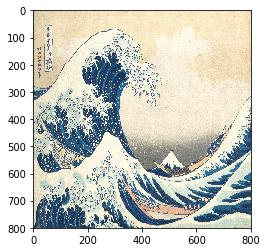

In [12]:
style_img = load_image_1("data/style_transfer/Tsunami_by_hokusai_19th_century.jpg", shape=(w,h))
style_img = style_img.astype('uint8')
plt.imshow(style_img)

### Load the Content Image

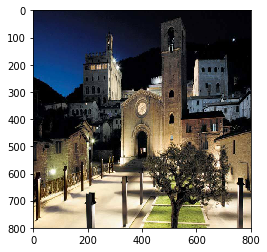

In [13]:
content_img = load_image_1("data/style_transfer/Gubbio.jpg", shape=(w,h))
content_img = content_img.astype("uint8")
plt.imshow(content_img)

Apparently, VGG networks were trained on images represented as BGR instead of RGB and that were initially normalized on the mean color, i.e., BGR_mean = [103.939, 116.779, 123.68]. Keras provides a preprocess_input method to adapt our pictures to the VGG input format.

In [14]:
def adapt_to_vgg19(img):
    print "source image", img.shape
    # add batch dimension
    img = np.expand_dims(img, axis=0)
    print "adapted image", img.shape
    return keras.applications.vgg19.preprocess_input(img)

We can similarly define the opposite function:

In [49]:
def adapt_from_vgg19(img):
    #print "vgg19 format", img.shape
    img = np.squeeze(img, axis=0)
    #print "adapted to", img.shape
    # remove the normalization from the normalized output
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # reverse to RGB from BGR
    img = img[:, :, ::-1]
    return img.astype("uint8")

Let's do an example conversion to and from VGG19 format:

In [16]:
ci_vgg19 = adapt_to_vgg19(content_img)
print "ci_vgg19.shape", ci_vgg19.shape

source image (800, 800, 3)
adapted image (1, 800, 800, 3)
ci_vgg19.shape (1, 800, 800, 3)


ci.shape (800, 800, 3)


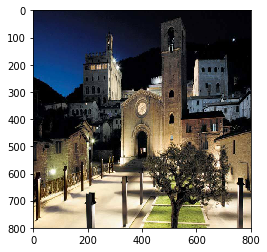

In [17]:
ci = adapt_from_vgg19(ci_vgg19)
print "ci.shape", ci.shape
plt.imshow(ci)

In [18]:
content_image = adapt_to_vgg19(content_img)
style_image = adapt_to_vgg19(style_img)

source image (800, 800, 3)
adapted image (1, 800, 800, 3)
source image (800, 800, 3)
adapted image (1, 800, 800, 3)


Let's generate an image from random noise:

In [19]:
generated_image = K.placeholder(content_image.shape)
print generated_image.shape

(1, 800, 800, 3)


### Extracting content and style representations of the images

Based on the original paper, let's start by defining the layers to use for the content representation and those for the style representation:

In [20]:
# content representation is on output of layer conv4_2
content_layers = [
    "block4_conv2"
    #'block5_conv2'
    ] 

In [21]:
# style representation is on layers:
# conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
style_layers = ["block1_conv1",
                "block2_conv1",
                "block3_conv1", 
                "block4_conv1", 
                "block5_conv1"]

In [22]:
def get_layers_as_tensors(adapted_content_image, adapted_style_image, generated_image):
    """
    Inputs the ANN with the different images and returns the specific layers as defined above
    """
    # we can use images of any size actually
    # https://stackoverflow.com/questions/41903051/change-input-tensor-shape-for-vgg16-application
    # the concatenate adds an input stage that appends multiple tensors in a batch
    # so its output is (3, 224, 224, 3) and this allows for extracting the value of each image for any layer we desire
    # https://keras.io/backend/#concatenate
    input_tensors = K.concatenate([adapted_content_image,
                                   adapted_style_image,
                                   generated_image
                                  ], axis=0)
    
    vgg19_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensors, 
                        #input_shape=(224, 224, 3),
                        #pooling=None,
                        #classes=1000
                       )
    """
    input_6 Tensor("concat_4:0", shape=(3, 224, 224, 3), dtype=float32)
    block1_conv1 Tensor("block1_conv1_5/Relu:0", shape=(3, 224, 224, 64), dtype=float32)
    block1_conv2 Tensor("block1_conv2_5/Relu:0", shape=(3, 224, 224, 64), dtype=float32)
    ...
    """
    parametrized_layers = dict([(layer.name, layer.output) for layer in vgg19_model.layers])
    return [parametrized_layers[l] for l in content_layers], [parametrized_layers[l] for l in style_layers]

In [23]:
content_layers_tensors, style_layers_tensors = get_layers_as_tensors(content_image, style_image, generated_image)
print content_layers_tensors
print style_layers_tensors

[<tf.Tensor 'block4_conv2_1/Relu:0' shape=(3, 100, 100, 512) dtype=float32>]
[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 800, 800, 64) dtype=float32>, <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 400, 400, 128) dtype=float32>, <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 200, 200, 256) dtype=float32>, <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 100, 100, 512) dtype=float32>, <tf.Tensor 'block5_conv1_1/Relu:0' shape=(3, 50, 50, 512) dtype=float32>]


In [24]:
for l in content_layers_tensors:
    print l

Tensor("block4_conv2_1/Relu:0", shape=(3, 100, 100, 512), dtype=float32)


### Defining the Loss Functions

In [25]:
# pass the content image and the input image
# compute mse over content layer of the 2 different feedforward passes
def mse(reference, predicted):
    # calculate mse for tensors, using Keras' tensor operations
    return K.mean(K.square(predicted - reference))

def se(reference, predicted):
    return K.sum(K.square(predicted - reference))

def content_loss(content_representation, input_representation):
    return se(content_representation, input_representation)

In [26]:
content_representation = content_layers_tensors[0][0]
input_img_representation = content_layers_tensors[0][2]
content_loss(content_representation, input_img_representation)

<tf.Tensor 'Sum:0' shape=() dtype=float32>

In [27]:
# pass the style image and the input image
# compute the loss as distance between gram matrices
def gram_matrix(tensor):
    # reshape to have the channel at the beginning
    # i.e. (224,224,3) -> (3,224,224)
    if K.image_data_format() == "channels_last":
        # reorder with channel first, leave the rest untouched
        tensor = K.permute_dimensions(tensor, (2, 0, 1))
    flattened_tensor = K.batch_flatten(tensor)
    # a gram matrix is a flattened layer tensor multiplied to its transpose
    return K.dot(flattened_tensor, K.transpose(flattened_tensor))

# the layer contribution depends on the number of channels and the image size
size = w*h
channels = 3
layer_contribution = (4.0 * (channels ** 2) * (size ** 2))

def style_layer_loss(target_style_representation, input_representation):
    # compare the gram matrices of the target style and input representation
    target_style_gram = gram_matrix(target_style_representation)
    gram_input = gram_matrix(input_representation)
    return se(target_style_gram, gram_input) / layer_contribution

In [28]:
def compute_loss_from_model(nn,
                            input_image_tensor,
                            alpha=0.5,
                            beta=0.5):
    
    # Extract context and style representation by passing the images in the VGG19 network with a feedforward pass
    loss = K.variable(0.0)
    # **** compute content loss ****
    for layer in content_layers:
        print nn.get_layer(layer).output
        # get tensor for the content image
        # content_representation = nn.get_layer("block4_conv2").output[0]
        content_representation = nn.get_layer(layer).output[0]
        print "content_representation["+layer+"].shape", content_representation.shape

        # get tensor for the input image
        # input_img_representation = nn.get_layer("block4_conv2").output[2]
        input_img_representation = nn.get_layer(layer).output[2]
        print "input_img_representation["+layer+"].shape", input_img_representation.shape

        # compute loss for the layer being visited
        # the loss is equally divided for each layer accounting to the content loss
        # the loss is weighted to the heuristic weight for the content
        loss = loss + (alpha * (1/len(content_layers)) * content_loss(content_representation, input_img_representation))
    # **** compute content loss ****
    
    # **** compute style loss ****
    for layer in style_layers:
        style_representation = nn.get_layer(layer).output[1]
        print "style_representation["+layer+"].shape", style_representation.shape
        input_img_representation = nn.get_layer(layer).output[2]
        print "input_img_representation["+layer+"].shape", input_img_representation.shape
        # the style loss is the weighted sum of the loss of all style layers
        # the weight is calculated so that the 5 style layers have each 1/5 weight and all others 0
        # also, since we use a heuristic to define the weight of style wrt content we also multiply to that
        loss = loss + (beta * (1/len(style_layers)) * style_layer_loss(style_representation, input_img_representation))
    # **** compute style loss ****
    return loss

In [29]:
def compute_loss_from_layer_tensors(content_layers_tensors,
                                    style_layers_tensors,
                                    alpha=0.5,
                                    beta=0.5):
     # Extract context and style representation by passing the images in the VGG19 network with a feedforward pass
    loss = K.variable(0.0)
    # **** compute content loss ****
    for layer in content_layers_tensors:
        #print layer, layer.shape
        # get tensor for the content image
        content_representation = layer[0]
        #print "content_representation["+layer.name+"].shape", content_representation.shape

        # get tensor for the input image
        input_img_representation = layer[2]
        #print "input_img_representation["+layer.name+"].shape", input_img_representation.shape

        # compute loss for the layer being visited
        # the loss is equally divided for each layer accounting to the content loss
        # the loss is weighted to the heuristic weight for the content
        loss = loss + (alpha * (1/len(content_layers)) * content_loss(content_representation, input_img_representation))
    # **** compute content loss ****
    
    # **** compute style loss ****
    for layer in style_layers_tensors:
        style_representation = layer[1]
        #print "style_representation["+layer.name+"].shape", style_representation.shape
        input_img_representation = layer[2]
        #print "input_img_representation["+layer.name+"].shape", input_img_representation.shape
        # the style loss is the weighted sum of the loss of all style layers
        # the weight is calculated so that the 5 style layers have each 1/5 weight and all others 0
        # also, since we use a heuristic to define the weight of style wrt content we also multiply to that
        loss = loss + (beta * (1/len(style_layers)) * style_layer_loss(style_representation, input_img_representation))
    # **** compute style loss ****
    return loss

In [30]:
loss = compute_loss_from_layer_tensors(content_layers_tensors, style_layers_tensors)
loss

<tf.Tensor 'add_5:0' shape=() dtype=float32>

In [31]:
def compute_gradient(loss, current_input_image_tensor):
    # calculate loss gradients wrt the currently used input image
    # keras.backend.gradients(loss, variables)
    # Returns the gradients of loss w.r.t. variables.
    grads = K.gradients(loss, current_input_image_tensor)
    return grads

In [32]:
compute_gradient(loss, generated_image)

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 800, 800, 3) dtype=float32>]

Let's define a function to optimize the loss function:

In [33]:
from scipy.optimize import fmin_l_bfgs_b
import math
from tqdm import tqdm

def iterate_over_loss_optimization(content_img,
                                   style_img,
                                   alpha = 0.025,
                                   beta = 1.0,
                                   iterations=10, 
                                   plots_per_row = 10,
                                   plot_every=1):
    # 1. open input images
    content_image = adapt_to_vgg19(content_img)
    style_image = adapt_to_vgg19(style_img)

    # 2. transform images to tensors
    content_image_tensor = K.variable(content_image)
    style_image_tensor = K.variable(style_image)
    
    # 3. create empty tensor for the input image - (1, 224, 224, 3)
    generated_image_tensor = K.placeholder(content_image.shape)
    #K.placeholder((1, h, w, 3)) 
    # keras.backend.function(inputs, outputs, updates=None)
    content_image_tensors, style_image_tensors = get_layers_as_tensors(content_image_tensor,
                                                                       style_image_tensor,
                                                                       generated_image_tensor)

    current_loss = K.variable(0.0)
    current_loss = compute_loss_from_layer_tensors(content_image_tensors, style_image_tensors, alpha=alpha, beta=beta)
    gradient = compute_gradient(current_loss, generated_image_tensor)
    
    # compute the graph by defining a callable function
    # https://keras.io/backend/#function
    # keras.backend.function(inputs, outputs, updates=None)
    o = [current_loss]
    o += gradient
    resulting_graph = K.function([generated_image_tensor],o)

    class Performance():
        def __init__(self):
            self.curr_loss = 0
            self.curr_grad = 0
            
        def get_loss(self, curr_x):
            # add batch dimension
            curr_x = curr_x.reshape((1, w, h, 3))
            # compute graph
            # https://stackoverflow.com/questions/42045092/does-k-function-method-of-keras-with-tensorflow-backend-work-with-network-layers
            results = resulting_graph([curr_x])
            
            self.curr_loss = results[0]
            self.curr_grad = results[1].flatten().astype('float64')
            return self.curr_loss
    
        def get_grad(self, curr_x):    
            return self.curr_grad
    
    p = Performance()
    
    # input image to start from is the content image
    x = content_image.flatten()
    to_plot = int(math.ceil(iterations / float(plot_every)))
    num_rows = int(math.ceil(to_plot / float(plots_per_row)))
    fig = plt.figure(figsize=(2*plots_per_row, 2*num_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    ims = 0

    for i in tqdm(range(iterations)):
    #for i in range(1,iterations):
        print "epoch", i
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html        
        x, min_val, info = fmin_l_bfgs_b(p.get_loss,
                                         x,
                                         #approx_grad=True,
                                         fprime=p.get_grad,
                                         maxfun=20
                                        )
    
        if i % plot_every == 0:
            ims += 1
            ax1 = plt.subplot(num_rows, plots_per_row, ims)
            ax1.imshow( adapt_from_vgg19(content_image) )
            #plt.imshow( adapt_from_vgg19(content_image) )
            plt.title("Iteration "+str(i))

    return adapt_from_vgg19(content_image)

source image (800, 800, 3)
adapted image (1, 800, 800, 3)
source image (800, 800, 3)
adapted image (1, 800, 800, 3)






  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0






  0%|          | 1/10000 [00:10<30:32:54, 11.00s/it]

epoch 1






  0%|          | 2/10000 [00:12<22:33:05,  8.12s/it]

epoch 2






  0%|          | 3/10000 [00:13<16:55:41,  6.10s/it]

epoch 3






  0%|          | 4/10000 [00:15<13:01:17,  4.69s/it]

epoch 4






  0%|          | 5/10000 [00:16<10:15:11,  3.69s/it]

epoch 5






  0%|          | 6/10000 [00:17<8:19:04,  3.00s/it] 

epoch 6






  0%|          | 7/10000 [00:19<6:57:13,  2.51s/it]

epoch 7






  0%|          | 8/10000 [00:20<5:59:49,  2.16s/it]

epoch 8






  0%|          | 9/10000 [00:22<5:20:07,  1.92s/it]

epoch 9






  0%|          | 10/10000 [00:23<4:50:45,  1.75s/it]

epoch 10






  0%|          | 11/10000 [00:24<4:30:18,  1.62s/it]

epoch 11






  0%|          | 12/10000 [00:26<4:20:24,  1.56s/it]

epoch 12






  0%|          | 13/10000 [00:27<4:10:45,  1.51s/it]

epoch 13






  0%|          | 14/10000 [00:28<4:05:54,  1.48s/it]

epoch 14






  0%|          | 15/10000 [00:30<3:58:50,  1.44s/it]

epoch 15






  0%|          | 16/10000 [00:31<3:55:37,  1.42s/it]

epoch 16






  0%|          | 17/10000 [00:32<3:53:35,  1.40s/it]

epoch 17






  0%|          | 18/10000 [00:34<3:52:38,  1.40s/it]

epoch 18






  0%|          | 19/10000 [00:35<3:52:07,  1.40s/it]

epoch 19






  0%|          | 20/10000 [00:37<3:50:10,  1.38s/it]

epoch 20






  0%|          | 21/10000 [00:38<3:49:26,  1.38s/it]

epoch 21






  0%|          | 22/10000 [00:39<3:49:08,  1.38s/it]

epoch 22






  0%|          | 23/10000 [00:41<3:48:19,  1.37s/it]

epoch 23






  0%|          | 24/10000 [00:42<3:48:00,  1.37s/it]

epoch 24






  0%|          | 25/10000 [00:43<3:46:29,  1.36s/it]

epoch 25






  0%|          | 26/10000 [00:45<3:45:34,  1.36s/it]

epoch 26






  0%|          | 27/10000 [00:46<3:47:14,  1.37s/it]

epoch 27






  0%|          | 28/10000 [00:48<3:49:58,  1.38s/it]

epoch 28






  0%|          | 29/10000 [00:49<3:50:57,  1.39s/it]

epoch 29






  0%|          | 30/10000 [00:50<3:51:26,  1.39s/it]

epoch 30






  0%|          | 31/10000 [00:52<3:51:30,  1.39s/it]

epoch 31






  0%|          | 32/10000 [00:53<3:50:40,  1.39s/it]

epoch 32






  0%|          | 33/10000 [00:55<3:50:02,  1.38s/it]

epoch 33






  0%|          | 34/10000 [00:56<3:47:43,  1.37s/it]

epoch 34






  0%|          | 35/10000 [00:57<3:46:00,  1.36s/it]

epoch 35






  0%|          | 36/10000 [00:59<3:46:18,  1.36s/it]

epoch 36






  0%|          | 37/10000 [01:00<3:46:45,  1.37s/it]

epoch 37






  0%|          | 38/10000 [01:01<3:48:24,  1.38s/it]

epoch 38






  0%|          | 39/10000 [01:03<3:46:07,  1.36s/it]

epoch 39






  0%|          | 40/10000 [01:04<3:48:38,  1.38s/it]

epoch 40






  0%|          | 41/10000 [01:05<3:47:09,  1.37s/it]

epoch 41






  0%|          | 42/10000 [01:07<3:45:58,  1.36s/it]

epoch 42






  0%|          | 43/10000 [01:08<3:44:58,  1.36s/it]

epoch 43






  0%|          | 44/10000 [01:09<3:43:42,  1.35s/it]

epoch 44






  0%|          | 45/10000 [01:11<3:43:09,  1.34s/it]

epoch 45






  0%|          | 46/10000 [01:12<3:43:31,  1.35s/it]

epoch 46






  0%|          | 47/10000 [01:13<3:43:54,  1.35s/it]

epoch 47






  0%|          | 48/10000 [01:15<3:42:38,  1.34s/it]

epoch 48






  0%|          | 49/10000 [01:16<3:42:01,  1.34s/it]

epoch 49






  0%|          | 50/10000 [01:17<3:42:37,  1.34s/it]

epoch 50






  1%|          | 51/10000 [01:19<3:43:11,  1.35s/it]

epoch 51






  1%|          | 52/10000 [01:20<3:43:16,  1.35s/it]

epoch 52






  1%|          | 53/10000 [01:22<3:44:13,  1.35s/it]

epoch 53






  1%|          | 54/10000 [01:23<3:46:11,  1.36s/it]

epoch 54






  1%|          | 55/10000 [01:24<3:45:42,  1.36s/it]

epoch 55






  1%|          | 56/10000 [01:26<3:46:05,  1.36s/it]

epoch 56






  1%|          | 57/10000 [01:27<3:45:31,  1.36s/it]

epoch 57






  1%|          | 58/10000 [01:28<3:46:56,  1.37s/it]

epoch 58






  1%|          | 59/10000 [01:30<3:49:15,  1.38s/it]

epoch 59






  1%|          | 60/10000 [01:31<3:49:08,  1.38s/it]

epoch 60






  1%|          | 61/10000 [01:33<3:47:56,  1.38s/it]

epoch 61






  1%|          | 62/10000 [01:34<3:48:31,  1.38s/it]

epoch 62






  1%|          | 63/10000 [01:35<3:49:34,  1.39s/it]

epoch 63






  1%|          | 64/10000 [01:37<3:48:20,  1.38s/it]

epoch 64






  1%|          | 65/10000 [01:38<3:47:23,  1.37s/it]

epoch 65






  1%|          | 66/10000 [01:39<3:46:14,  1.37s/it]

epoch 66






  1%|          | 67/10000 [01:41<3:45:46,  1.36s/it]

epoch 67






  1%|          | 68/10000 [01:42<3:46:00,  1.37s/it]

epoch 68






  1%|          | 69/10000 [01:44<3:46:16,  1.37s/it]

epoch 69






  1%|          | 70/10000 [01:45<3:46:19,  1.37s/it]

epoch 70






  1%|          | 71/10000 [01:46<3:45:38,  1.36s/it]

epoch 71






  1%|          | 72/10000 [01:48<3:52:51,  1.41s/it]

epoch 72






  1%|          | 73/10000 [01:49<3:52:18,  1.40s/it]

epoch 73






  1%|          | 74/10000 [01:51<3:50:49,  1.40s/it]

epoch 74






  1%|          | 75/10000 [01:52<3:50:26,  1.39s/it]

epoch 75






  1%|          | 76/10000 [01:53<3:49:30,  1.39s/it]

epoch 76






  1%|          | 77/10000 [01:55<3:52:39,  1.41s/it]

epoch 77






  1%|          | 78/10000 [01:56<3:52:08,  1.40s/it]

epoch 78






  1%|          | 79/10000 [01:58<3:54:31,  1.42s/it]

epoch 79






  1%|          | 80/10000 [01:59<3:52:19,  1.41s/it]

epoch 80






  1%|          | 81/10000 [02:00<3:50:44,  1.40s/it]

epoch 81






  1%|          | 82/10000 [02:02<3:48:22,  1.38s/it]

epoch 82






  1%|          | 83/10000 [02:03<3:46:05,  1.37s/it]

epoch 83






  1%|          | 84/10000 [02:04<3:49:45,  1.39s/it]

epoch 84






  1%|          | 85/10000 [02:06<3:49:02,  1.39s/it]

epoch 85






  1%|          | 86/10000 [02:07<3:49:33,  1.39s/it]

epoch 86






  1%|          | 87/10000 [02:09<3:47:06,  1.37s/it]

epoch 87






  1%|          | 88/10000 [02:10<3:47:47,  1.38s/it]

epoch 88






  1%|          | 89/10000 [02:11<3:46:41,  1.37s/it]

epoch 89






  1%|          | 90/10000 [02:13<3:45:00,  1.36s/it]

epoch 90






  1%|          | 91/10000 [02:14<3:50:17,  1.39s/it]

epoch 91






  1%|          | 92/10000 [02:16<3:58:58,  1.45s/it]

epoch 92






  1%|          | 93/10000 [02:17<3:56:47,  1.43s/it]

epoch 93






  1%|          | 94/10000 [02:19<3:54:14,  1.42s/it]

epoch 94






  1%|          | 95/10000 [02:20<3:52:59,  1.41s/it]

epoch 95






  1%|          | 96/10000 [02:21<3:48:59,  1.39s/it]

epoch 96






  1%|          | 97/10000 [02:23<3:49:21,  1.39s/it]

epoch 97






  1%|          | 98/10000 [02:24<3:49:16,  1.39s/it]

epoch 98






  1%|          | 99/10000 [02:25<3:51:52,  1.41s/it]

epoch 99






  1%|          | 100/10000 [02:27<3:49:09,  1.39s/it]

epoch 100






  1%|          | 101/10000 [02:28<3:48:10,  1.38s/it]

epoch 101






  1%|          | 102/10000 [02:30<3:45:35,  1.37s/it]

epoch 102






  1%|          | 103/10000 [02:31<3:45:29,  1.37s/it]

epoch 103






  1%|          | 104/10000 [02:32<3:49:12,  1.39s/it]

epoch 104






  1%|          | 105/10000 [02:34<3:49:14,  1.39s/it]

epoch 105






  1%|          | 106/10000 [02:35<3:46:39,  1.37s/it]

epoch 106






  1%|          | 107/10000 [02:36<3:46:48,  1.38s/it]

epoch 107






  1%|          | 108/10000 [02:38<3:44:53,  1.36s/it]

epoch 108






  1%|          | 109/10000 [02:39<3:44:40,  1.36s/it]

epoch 109






  1%|          | 110/10000 [02:40<3:43:00,  1.35s/it]

epoch 110






  1%|          | 111/10000 [02:42<3:42:20,  1.35s/it]

epoch 111






  1%|          | 112/10000 [02:43<3:41:07,  1.34s/it]

epoch 112






  1%|          | 113/10000 [02:44<3:41:01,  1.34s/it]

epoch 113






  1%|          | 114/10000 [02:46<3:40:39,  1.34s/it]

epoch 114






  1%|          | 115/10000 [02:47<3:40:29,  1.34s/it]

epoch 115






  1%|          | 116/10000 [02:48<3:41:10,  1.34s/it]

epoch 116






  1%|          | 117/10000 [02:50<3:41:56,  1.35s/it]

epoch 117






  1%|          | 118/10000 [02:51<3:41:38,  1.35s/it]

epoch 118






  1%|          | 119/10000 [02:53<3:41:07,  1.34s/it]

epoch 119






  1%|          | 120/10000 [02:54<3:40:54,  1.34s/it]

epoch 120






  1%|          | 121/10000 [02:55<3:39:58,  1.34s/it]

epoch 121






  1%|          | 122/10000 [02:57<3:41:06,  1.34s/it]

epoch 122






  1%|          | 123/10000 [02:58<3:40:31,  1.34s/it]

epoch 123






  1%|          | 124/10000 [02:59<3:40:21,  1.34s/it]

epoch 124






  1%|▏         | 125/10000 [03:01<3:41:06,  1.34s/it]

epoch 125






  1%|▏         | 126/10000 [03:02<3:40:40,  1.34s/it]

epoch 126






  1%|▏         | 127/10000 [03:03<3:40:32,  1.34s/it]

epoch 127






  1%|▏         | 128/10000 [03:05<3:41:24,  1.35s/it]

epoch 128






  1%|▏         | 129/10000 [03:06<3:41:55,  1.35s/it]

epoch 129






  1%|▏         | 130/10000 [03:07<3:40:45,  1.34s/it]

epoch 130






  1%|▏         | 131/10000 [03:09<3:40:22,  1.34s/it]

epoch 131






  1%|▏         | 132/10000 [03:10<3:41:18,  1.35s/it]

epoch 132






  1%|▏         | 133/10000 [03:11<3:41:11,  1.34s/it]

epoch 133






  1%|▏         | 134/10000 [03:13<3:42:25,  1.35s/it]

epoch 134






  1%|▏         | 135/10000 [03:14<3:41:31,  1.35s/it]

epoch 135






  1%|▏         | 136/10000 [03:15<3:41:08,  1.35s/it]

epoch 136






  1%|▏         | 137/10000 [03:17<3:40:54,  1.34s/it]

epoch 137






  1%|▏         | 138/10000 [03:18<3:41:44,  1.35s/it]

epoch 138






  1%|▏         | 139/10000 [03:19<3:42:04,  1.35s/it]

epoch 139






  1%|▏         | 140/10000 [03:21<3:41:07,  1.35s/it]

epoch 140






  1%|▏         | 141/10000 [03:22<3:42:32,  1.35s/it]

epoch 141






  1%|▏         | 142/10000 [03:23<3:42:16,  1.35s/it]

epoch 142






  1%|▏         | 143/10000 [03:25<3:44:19,  1.37s/it]

epoch 143






  1%|▏         | 144/10000 [03:26<3:43:21,  1.36s/it]

epoch 144






  1%|▏         | 145/10000 [03:28<3:43:46,  1.36s/it]

epoch 145






  1%|▏         | 146/10000 [03:29<3:43:39,  1.36s/it]

epoch 146






  1%|▏         | 147/10000 [03:30<3:44:59,  1.37s/it]

epoch 147






  1%|▏         | 148/10000 [03:32<3:45:20,  1.37s/it]

epoch 148






  1%|▏         | 149/10000 [03:33<3:43:37,  1.36s/it]

epoch 149






  2%|▏         | 150/10000 [03:34<3:41:15,  1.35s/it]

epoch 150






  2%|▏         | 151/10000 [03:36<3:40:27,  1.34s/it]

epoch 151






  2%|▏         | 152/10000 [03:37<3:39:25,  1.34s/it]

epoch 152






  2%|▏         | 153/10000 [03:38<3:38:26,  1.33s/it]

epoch 153






  2%|▏         | 154/10000 [03:40<3:38:08,  1.33s/it]

epoch 154






  2%|▏         | 155/10000 [03:41<3:39:13,  1.34s/it]

epoch 155






  2%|▏         | 156/10000 [03:42<3:38:53,  1.33s/it]

epoch 156






  2%|▏         | 157/10000 [03:44<3:38:10,  1.33s/it]

epoch 157






  2%|▏         | 158/10000 [03:45<3:38:31,  1.33s/it]

epoch 158






  2%|▏         | 159/10000 [03:46<3:39:21,  1.34s/it]

epoch 159






  2%|▏         | 160/10000 [03:48<3:39:54,  1.34s/it]

epoch 160






  2%|▏         | 161/10000 [03:49<3:40:54,  1.35s/it]

epoch 161






  2%|▏         | 162/10000 [03:50<3:41:44,  1.35s/it]

epoch 162






  2%|▏         | 163/10000 [03:52<3:41:50,  1.35s/it]

epoch 163






  2%|▏         | 164/10000 [03:53<3:41:53,  1.35s/it]

epoch 164






  2%|▏         | 165/10000 [03:54<3:41:35,  1.35s/it]

epoch 165






  2%|▏         | 166/10000 [03:56<3:41:30,  1.35s/it]

epoch 166






  2%|▏         | 167/10000 [03:57<3:42:08,  1.36s/it]

epoch 167






  2%|▏         | 168/10000 [03:59<3:41:09,  1.35s/it]

epoch 168






  2%|▏         | 169/10000 [04:00<3:41:35,  1.35s/it]

epoch 169






  2%|▏         | 170/10000 [04:01<3:41:24,  1.35s/it]

epoch 170






  2%|▏         | 171/10000 [04:03<3:40:53,  1.35s/it]

epoch 171






  2%|▏         | 172/10000 [04:04<3:41:06,  1.35s/it]

epoch 172






  2%|▏         | 173/10000 [04:05<3:41:07,  1.35s/it]

epoch 173






  2%|▏         | 174/10000 [04:07<3:40:15,  1.34s/it]

epoch 174






  2%|▏         | 175/10000 [04:08<3:39:20,  1.34s/it]

epoch 175






  2%|▏         | 176/10000 [04:09<3:39:35,  1.34s/it]

epoch 176






  2%|▏         | 177/10000 [04:11<3:39:50,  1.34s/it]

epoch 177






  2%|▏         | 178/10000 [04:12<3:39:08,  1.34s/it]

epoch 178






  2%|▏         | 179/10000 [04:13<3:40:30,  1.35s/it]

epoch 179






  2%|▏         | 180/10000 [04:15<3:40:59,  1.35s/it]

epoch 180






  2%|▏         | 181/10000 [04:16<3:39:52,  1.34s/it]

epoch 181






  2%|▏         | 182/10000 [04:17<3:39:33,  1.34s/it]

epoch 182






  2%|▏         | 183/10000 [04:19<3:39:17,  1.34s/it]

epoch 183






  2%|▏         | 184/10000 [04:20<3:38:31,  1.34s/it]

epoch 184






  2%|▏         | 185/10000 [04:21<3:40:04,  1.35s/it]

epoch 185






  2%|▏         | 186/10000 [04:23<3:39:59,  1.34s/it]

epoch 186






  2%|▏         | 187/10000 [04:24<3:39:15,  1.34s/it]

epoch 187






  2%|▏         | 188/10000 [04:25<3:40:28,  1.35s/it]

epoch 188






  2%|▏         | 189/10000 [04:27<3:41:25,  1.35s/it]

epoch 189






  2%|▏         | 190/10000 [04:28<3:44:49,  1.38s/it]

epoch 190






  2%|▏         | 191/10000 [04:30<3:46:52,  1.39s/it]

epoch 191






  2%|▏         | 192/10000 [04:31<3:48:39,  1.40s/it]

epoch 192






  2%|▏         | 193/10000 [04:32<3:47:53,  1.39s/it]

epoch 193






  2%|▏         | 194/10000 [04:34<3:45:26,  1.38s/it]

epoch 194






  2%|▏         | 195/10000 [04:35<3:45:23,  1.38s/it]

epoch 195






  2%|▏         | 196/10000 [04:37<3:46:12,  1.38s/it]

epoch 196






  2%|▏         | 197/10000 [04:38<3:46:20,  1.39s/it]

epoch 197






  2%|▏         | 198/10000 [04:39<3:45:10,  1.38s/it]

epoch 198






  2%|▏         | 199/10000 [04:41<3:42:58,  1.36s/it]

epoch 199






  2%|▏         | 200/10000 [04:42<3:42:31,  1.36s/it]

epoch 200






  2%|▏         | 201/10000 [04:43<3:41:42,  1.36s/it]

epoch 201






  2%|▏         | 202/10000 [04:45<3:42:31,  1.36s/it]

epoch 202






  2%|▏         | 203/10000 [04:46<3:43:14,  1.37s/it]

epoch 203






  2%|▏         | 204/10000 [04:47<3:42:36,  1.36s/it]

epoch 204






  2%|▏         | 205/10000 [04:49<3:44:12,  1.37s/it]

epoch 205






  2%|▏         | 206/10000 [04:50<3:44:23,  1.37s/it]

epoch 206






  2%|▏         | 207/10000 [04:52<3:43:59,  1.37s/it]

epoch 207






  2%|▏         | 208/10000 [04:53<3:41:55,  1.36s/it]

epoch 208






  2%|▏         | 209/10000 [04:54<3:44:25,  1.38s/it]

epoch 209






  2%|▏         | 210/10000 [04:56<3:43:07,  1.37s/it]

epoch 210






  2%|▏         | 211/10000 [04:57<3:41:43,  1.36s/it]

epoch 211






  2%|▏         | 212/10000 [04:58<3:42:04,  1.36s/it]

epoch 212






  2%|▏         | 213/10000 [05:00<3:43:51,  1.37s/it]

epoch 213






  2%|▏         | 214/10000 [05:01<3:44:20,  1.38s/it]

epoch 214






  2%|▏         | 215/10000 [05:03<3:43:04,  1.37s/it]

epoch 215






  2%|▏         | 216/10000 [05:04<3:41:52,  1.36s/it]

epoch 216






  2%|▏         | 217/10000 [05:05<3:41:14,  1.36s/it]

epoch 217






  2%|▏         | 218/10000 [05:07<3:39:52,  1.35s/it]

epoch 218






  2%|▏         | 219/10000 [05:08<3:40:13,  1.35s/it]

epoch 219






  2%|▏         | 220/10000 [05:09<3:40:42,  1.35s/it]

epoch 220






  2%|▏         | 221/10000 [05:11<3:40:14,  1.35s/it]

epoch 221






  2%|▏         | 222/10000 [05:12<3:39:53,  1.35s/it]

epoch 222






  2%|▏         | 223/10000 [05:13<3:40:29,  1.35s/it]

epoch 223






  2%|▏         | 224/10000 [05:15<3:39:49,  1.35s/it]

epoch 224






  2%|▏         | 225/10000 [05:16<3:41:45,  1.36s/it]

epoch 225






  2%|▏         | 226/10000 [05:17<3:42:49,  1.37s/it]

epoch 226






  2%|▏         | 227/10000 [05:19<3:46:35,  1.39s/it]

epoch 227






  2%|▏         | 228/10000 [05:20<3:46:17,  1.39s/it]

epoch 228






  2%|▏         | 229/10000 [05:22<3:45:55,  1.39s/it]

epoch 229






  2%|▏         | 230/10000 [05:23<3:43:28,  1.37s/it]

epoch 230






  2%|▏         | 231/10000 [05:24<3:43:43,  1.37s/it]

epoch 231






  2%|▏         | 232/10000 [05:26<3:44:58,  1.38s/it]

epoch 232






  2%|▏         | 233/10000 [05:27<3:45:06,  1.38s/it]

epoch 233






  2%|▏         | 234/10000 [05:29<3:45:34,  1.39s/it]

epoch 234






  2%|▏         | 235/10000 [05:30<3:45:16,  1.38s/it]

epoch 235






  2%|▏         | 236/10000 [05:31<3:44:06,  1.38s/it]

epoch 236






  2%|▏         | 237/10000 [05:33<3:44:56,  1.38s/it]

epoch 237






  2%|▏         | 238/10000 [05:34<3:44:28,  1.38s/it]

epoch 238






  2%|▏         | 239/10000 [05:35<3:44:13,  1.38s/it]

epoch 239






  2%|▏         | 240/10000 [05:37<3:42:10,  1.37s/it]

epoch 240






  2%|▏         | 241/10000 [05:38<3:41:34,  1.36s/it]

epoch 241






  2%|▏         | 242/10000 [05:39<3:41:28,  1.36s/it]

epoch 242






  2%|▏         | 243/10000 [05:41<3:39:29,  1.35s/it]

epoch 243






  2%|▏         | 244/10000 [05:42<3:39:24,  1.35s/it]

epoch 244






  2%|▏         | 245/10000 [05:43<3:38:37,  1.34s/it]

epoch 245






  2%|▏         | 246/10000 [05:45<3:38:13,  1.34s/it]

epoch 246






  2%|▏         | 247/10000 [05:46<3:38:05,  1.34s/it]

epoch 247






  2%|▏         | 248/10000 [05:48<3:39:06,  1.35s/it]

epoch 248






  2%|▏         | 249/10000 [05:49<3:39:21,  1.35s/it]

epoch 249






  2%|▎         | 250/10000 [05:50<3:38:27,  1.34s/it]

epoch 250






  3%|▎         | 251/10000 [05:52<3:38:40,  1.35s/it]

epoch 251






  3%|▎         | 252/10000 [05:53<3:38:51,  1.35s/it]

epoch 252






  3%|▎         | 253/10000 [05:54<3:39:18,  1.35s/it]

epoch 253






  3%|▎         | 254/10000 [05:56<3:39:48,  1.35s/it]

epoch 254






  3%|▎         | 255/10000 [05:57<3:38:32,  1.35s/it]

epoch 255






  3%|▎         | 256/10000 [05:58<3:38:17,  1.34s/it]

epoch 256






  3%|▎         | 257/10000 [06:00<3:39:02,  1.35s/it]

epoch 257






  3%|▎         | 258/10000 [06:01<3:38:41,  1.35s/it]

epoch 258






  3%|▎         | 259/10000 [06:02<3:38:33,  1.35s/it]

epoch 259






  3%|▎         | 260/10000 [06:04<3:39:14,  1.35s/it]

epoch 260






  3%|▎         | 261/10000 [06:05<3:40:13,  1.36s/it]

epoch 261






  3%|▎         | 262/10000 [06:06<3:39:21,  1.35s/it]

epoch 262






  3%|▎         | 263/10000 [06:08<3:39:25,  1.35s/it]

epoch 263






  3%|▎         | 264/10000 [06:09<3:39:42,  1.35s/it]

epoch 264






  3%|▎         | 265/10000 [06:10<3:39:21,  1.35s/it]

epoch 265






  3%|▎         | 266/10000 [06:12<3:39:05,  1.35s/it]

epoch 266






  3%|▎         | 267/10000 [06:13<3:40:37,  1.36s/it]

epoch 267






  3%|▎         | 268/10000 [06:15<3:41:03,  1.36s/it]

epoch 268






  3%|▎         | 269/10000 [06:16<3:40:41,  1.36s/it]

epoch 269






  3%|▎         | 270/10000 [06:17<3:40:04,  1.36s/it]

epoch 270






  3%|▎         | 271/10000 [06:19<3:39:54,  1.36s/it]

epoch 271






  3%|▎         | 272/10000 [06:20<3:39:43,  1.36s/it]

epoch 272






  3%|▎         | 273/10000 [06:21<3:39:20,  1.35s/it]

epoch 273






  3%|▎         | 274/10000 [06:23<3:39:57,  1.36s/it]

epoch 274






  3%|▎         | 275/10000 [06:24<3:39:24,  1.35s/it]

epoch 275






  3%|▎         | 276/10000 [06:25<3:38:26,  1.35s/it]

epoch 276






  3%|▎         | 277/10000 [06:27<3:38:50,  1.35s/it]

epoch 277






  3%|▎         | 278/10000 [06:28<3:38:20,  1.35s/it]

epoch 278






  3%|▎         | 279/10000 [06:29<3:38:04,  1.35s/it]

epoch 279






  3%|▎         | 280/10000 [06:31<3:38:50,  1.35s/it]

epoch 280






  3%|▎         | 281/10000 [06:32<3:39:30,  1.36s/it]

epoch 281






  3%|▎         | 282/10000 [06:33<3:38:31,  1.35s/it]

epoch 282






  3%|▎         | 283/10000 [06:35<3:38:35,  1.35s/it]

epoch 283






  3%|▎         | 284/10000 [06:36<3:37:56,  1.35s/it]

epoch 284






  3%|▎         | 285/10000 [06:38<3:39:14,  1.35s/it]

epoch 285






  3%|▎         | 286/10000 [06:39<3:38:17,  1.35s/it]

epoch 286






  3%|▎         | 287/10000 [06:40<3:39:01,  1.35s/it]

epoch 287






  3%|▎         | 288/10000 [06:42<3:39:29,  1.36s/it]

epoch 288






  3%|▎         | 289/10000 [06:43<3:39:20,  1.36s/it]

epoch 289






  3%|▎         | 290/10000 [06:44<3:38:17,  1.35s/it]

epoch 290






  3%|▎         | 291/10000 [06:46<3:37:02,  1.34s/it]

epoch 291






  3%|▎         | 292/10000 [06:47<3:37:26,  1.34s/it]

epoch 292






  3%|▎         | 293/10000 [06:48<3:36:56,  1.34s/it]

epoch 293






  3%|▎         | 294/10000 [06:50<3:37:49,  1.35s/it]

epoch 294






  3%|▎         | 295/10000 [06:51<3:37:41,  1.35s/it]

epoch 295






  3%|▎         | 296/10000 [06:52<3:38:18,  1.35s/it]

epoch 296






  3%|▎         | 297/10000 [06:54<3:38:18,  1.35s/it]

epoch 297






  3%|▎         | 298/10000 [06:55<3:37:13,  1.34s/it]

epoch 298






  3%|▎         | 299/10000 [06:56<3:37:08,  1.34s/it]

epoch 299






  3%|▎         | 300/10000 [06:58<3:37:38,  1.35s/it]

epoch 300






  3%|▎         | 301/10000 [06:59<3:37:36,  1.35s/it]

epoch 301






  3%|▎         | 302/10000 [07:00<3:37:08,  1.34s/it]

epoch 302






  3%|▎         | 303/10000 [07:02<3:38:02,  1.35s/it]

epoch 303






  3%|▎         | 304/10000 [07:03<3:37:40,  1.35s/it]

epoch 304






  3%|▎         | 305/10000 [07:04<3:37:31,  1.35s/it]

epoch 305






  3%|▎         | 306/10000 [07:06<3:39:16,  1.36s/it]

epoch 306






  3%|▎         | 307/10000 [07:07<3:38:56,  1.36s/it]

epoch 307






  3%|▎         | 308/10000 [07:09<3:39:10,  1.36s/it]

epoch 308






  3%|▎         | 309/10000 [07:10<3:38:58,  1.36s/it]

epoch 309






  3%|▎         | 310/10000 [07:11<3:39:18,  1.36s/it]

epoch 310






  3%|▎         | 311/10000 [07:13<3:38:35,  1.35s/it]

epoch 311






  3%|▎         | 312/10000 [07:14<3:38:02,  1.35s/it]

epoch 312






  3%|▎         | 313/10000 [07:15<3:37:47,  1.35s/it]

epoch 313






  3%|▎         | 314/10000 [07:17<3:37:44,  1.35s/it]

epoch 314






  3%|▎         | 315/10000 [07:18<3:37:43,  1.35s/it]

epoch 315






  3%|▎         | 316/10000 [07:19<3:37:22,  1.35s/it]

epoch 316






  3%|▎         | 317/10000 [07:21<3:37:03,  1.34s/it]

epoch 317






  3%|▎         | 318/10000 [07:22<3:37:53,  1.35s/it]

epoch 318






  3%|▎         | 319/10000 [07:23<3:37:59,  1.35s/it]

epoch 319






  3%|▎         | 320/10000 [07:25<3:38:28,  1.35s/it]

epoch 320






  3%|▎         | 321/10000 [07:26<3:37:57,  1.35s/it]

epoch 321






  3%|▎         | 322/10000 [07:27<3:36:47,  1.34s/it]

epoch 322






  3%|▎         | 323/10000 [07:29<3:37:04,  1.35s/it]

epoch 323






  3%|▎         | 324/10000 [07:30<3:37:11,  1.35s/it]

epoch 324






  3%|▎         | 325/10000 [07:31<3:37:09,  1.35s/it]

epoch 325






  3%|▎         | 326/10000 [07:33<3:37:49,  1.35s/it]

epoch 326






  3%|▎         | 327/10000 [07:34<3:39:19,  1.36s/it]

epoch 327






  3%|▎         | 328/10000 [07:36<3:37:51,  1.35s/it]

epoch 328






  3%|▎         | 329/10000 [07:37<3:38:06,  1.35s/it]

epoch 329






  3%|▎         | 330/10000 [07:38<3:38:52,  1.36s/it]

epoch 330






  3%|▎         | 331/10000 [07:40<3:38:58,  1.36s/it]

epoch 331






  3%|▎         | 332/10000 [07:41<3:39:47,  1.36s/it]

epoch 332






  3%|▎         | 333/10000 [07:42<3:38:47,  1.36s/it]

epoch 333






  3%|▎         | 334/10000 [07:44<3:38:03,  1.35s/it]

epoch 334






  3%|▎         | 335/10000 [07:45<3:37:25,  1.35s/it]

epoch 335






  3%|▎         | 336/10000 [07:46<3:37:32,  1.35s/it]

epoch 336






  3%|▎         | 337/10000 [07:48<3:38:02,  1.35s/it]

epoch 337






  3%|▎         | 338/10000 [07:49<3:37:53,  1.35s/it]

epoch 338






  3%|▎         | 339/10000 [07:51<3:39:42,  1.36s/it]

epoch 339






  3%|▎         | 340/10000 [07:52<3:39:28,  1.36s/it]

epoch 340






  3%|▎         | 341/10000 [07:53<3:38:48,  1.36s/it]

epoch 341






  3%|▎         | 342/10000 [07:55<3:38:29,  1.36s/it]

epoch 342






  3%|▎         | 343/10000 [07:56<3:40:08,  1.37s/it]

epoch 343






  3%|▎         | 344/10000 [07:57<3:39:58,  1.37s/it]

epoch 344






  3%|▎         | 345/10000 [07:59<3:38:26,  1.36s/it]

epoch 345






  3%|▎         | 346/10000 [08:00<3:38:39,  1.36s/it]

epoch 346






  3%|▎         | 347/10000 [08:01<3:38:40,  1.36s/it]

epoch 347






  3%|▎         | 348/10000 [08:03<3:38:12,  1.36s/it]

epoch 348






  3%|▎         | 349/10000 [08:04<3:38:09,  1.36s/it]

epoch 349






  4%|▎         | 350/10000 [08:05<3:36:45,  1.35s/it]

epoch 350






  4%|▎         | 351/10000 [08:07<3:37:23,  1.35s/it]

epoch 351






  4%|▎         | 352/10000 [08:08<3:36:24,  1.35s/it]

epoch 352






  4%|▎         | 353/10000 [08:09<3:38:16,  1.36s/it]

epoch 353






  4%|▎         | 354/10000 [08:11<3:37:43,  1.35s/it]

epoch 354






  4%|▎         | 355/10000 [08:12<3:37:38,  1.35s/it]

epoch 355






  4%|▎         | 356/10000 [08:14<3:38:08,  1.36s/it]

epoch 356






  4%|▎         | 357/10000 [08:15<3:36:38,  1.35s/it]

epoch 357






  4%|▎         | 358/10000 [08:16<3:36:23,  1.35s/it]

epoch 358






  4%|▎         | 359/10000 [08:18<3:35:41,  1.34s/it]

epoch 359






  4%|▎         | 360/10000 [08:19<3:35:32,  1.34s/it]

epoch 360






  4%|▎         | 361/10000 [08:20<3:36:47,  1.35s/it]

epoch 361






  4%|▎         | 362/10000 [08:22<3:37:15,  1.35s/it]

epoch 362






  4%|▎         | 363/10000 [08:23<3:37:03,  1.35s/it]

epoch 363






  4%|▎         | 364/10000 [08:24<3:37:12,  1.35s/it]

epoch 364






  4%|▎         | 365/10000 [08:26<3:36:38,  1.35s/it]

epoch 365






  4%|▎         | 366/10000 [08:27<3:35:36,  1.34s/it]

epoch 366






  4%|▎         | 367/10000 [08:28<3:37:25,  1.35s/it]

epoch 367






  4%|▎         | 368/10000 [08:30<3:37:03,  1.35s/it]

epoch 368






  4%|▎         | 369/10000 [08:31<3:36:30,  1.35s/it]

epoch 369






  4%|▎         | 370/10000 [08:32<3:37:34,  1.36s/it]

epoch 370






  4%|▎         | 371/10000 [08:34<3:36:54,  1.35s/it]

epoch 371






  4%|▎         | 372/10000 [08:35<3:35:42,  1.34s/it]

epoch 372






  4%|▎         | 373/10000 [08:36<3:35:04,  1.34s/it]

epoch 373






  4%|▎         | 374/10000 [08:38<3:36:50,  1.35s/it]

epoch 374






  4%|▍         | 375/10000 [08:39<3:36:49,  1.35s/it]

epoch 375






  4%|▍         | 376/10000 [08:41<3:37:09,  1.35s/it]

epoch 376






  4%|▍         | 377/10000 [08:42<3:36:58,  1.35s/it]

epoch 377






  4%|▍         | 378/10000 [08:43<3:37:30,  1.36s/it]

epoch 378






  4%|▍         | 379/10000 [08:45<3:38:04,  1.36s/it]

epoch 379






  4%|▍         | 380/10000 [08:46<3:38:43,  1.36s/it]

epoch 380






  4%|▍         | 381/10000 [08:47<3:36:42,  1.35s/it]

epoch 381






  4%|▍         | 382/10000 [08:49<3:35:50,  1.35s/it]

epoch 382






  4%|▍         | 383/10000 [08:50<3:35:07,  1.34s/it]

epoch 383






  4%|▍         | 384/10000 [08:51<3:35:47,  1.35s/it]

epoch 384






  4%|▍         | 385/10000 [08:53<3:36:43,  1.35s/it]

epoch 385






  4%|▍         | 386/10000 [08:54<3:35:50,  1.35s/it]

epoch 386






  4%|▍         | 387/10000 [08:55<3:36:47,  1.35s/it]

epoch 387






  4%|▍         | 388/10000 [08:57<3:36:45,  1.35s/it]

epoch 388






  4%|▍         | 389/10000 [08:58<3:36:36,  1.35s/it]

epoch 389






  4%|▍         | 390/10000 [08:59<3:37:39,  1.36s/it]

epoch 390






  4%|▍         | 391/10000 [09:01<3:37:49,  1.36s/it]

epoch 391






  4%|▍         | 392/10000 [09:02<3:37:28,  1.36s/it]

epoch 392






  4%|▍         | 393/10000 [09:04<3:35:51,  1.35s/it]

epoch 393






  4%|▍         | 394/10000 [09:05<3:35:07,  1.34s/it]

epoch 394






  4%|▍         | 395/10000 [09:06<3:34:56,  1.34s/it]

epoch 395






  4%|▍         | 396/10000 [09:08<3:35:18,  1.35s/it]

epoch 396






  4%|▍         | 397/10000 [09:09<3:35:28,  1.35s/it]

epoch 397






  4%|▍         | 398/10000 [09:10<3:36:41,  1.35s/it]

epoch 398






  4%|▍         | 399/10000 [09:12<3:37:57,  1.36s/it]

epoch 399






  4%|▍         | 400/10000 [09:13<3:36:59,  1.36s/it]

epoch 400






  4%|▍         | 401/10000 [09:14<3:37:48,  1.36s/it]

epoch 401






  4%|▍         | 402/10000 [09:16<3:37:18,  1.36s/it]

epoch 402






  4%|▍         | 403/10000 [09:17<3:36:53,  1.36s/it]

epoch 403






  4%|▍         | 404/10000 [09:18<3:36:55,  1.36s/it]

epoch 404






  4%|▍         | 405/10000 [09:20<3:36:39,  1.35s/it]

epoch 405






  4%|▍         | 406/10000 [09:21<3:35:55,  1.35s/it]

epoch 406






  4%|▍         | 407/10000 [09:22<3:35:55,  1.35s/it]

epoch 407






  4%|▍         | 408/10000 [09:24<3:35:05,  1.35s/it]

epoch 408






  4%|▍         | 409/10000 [09:25<3:34:34,  1.34s/it]

epoch 409






  4%|▍         | 410/10000 [09:26<3:34:11,  1.34s/it]

epoch 410






  4%|▍         | 411/10000 [09:28<3:34:46,  1.34s/it]

epoch 411






  4%|▍         | 412/10000 [09:29<3:34:55,  1.34s/it]

epoch 412






  4%|▍         | 413/10000 [09:30<3:34:16,  1.34s/it]

epoch 413






  4%|▍         | 414/10000 [09:32<3:34:09,  1.34s/it]

epoch 414






  4%|▍         | 415/10000 [09:33<3:33:23,  1.34s/it]

epoch 415






  4%|▍         | 416/10000 [09:34<3:33:18,  1.34s/it]

epoch 416






  4%|▍         | 417/10000 [09:36<3:34:07,  1.34s/it]

epoch 417






  4%|▍         | 418/10000 [09:37<3:33:43,  1.34s/it]

epoch 418






  4%|▍         | 419/10000 [09:39<3:34:30,  1.34s/it]

epoch 419






  4%|▍         | 420/10000 [09:40<3:35:26,  1.35s/it]

epoch 420






  4%|▍         | 421/10000 [09:41<3:35:45,  1.35s/it]

epoch 421






  4%|▍         | 422/10000 [09:43<3:35:19,  1.35s/it]

epoch 422






  4%|▍         | 423/10000 [09:44<3:35:21,  1.35s/it]

epoch 423






  4%|▍         | 424/10000 [09:45<3:34:31,  1.34s/it]

epoch 424






  4%|▍         | 425/10000 [09:47<3:34:51,  1.35s/it]

epoch 425






  4%|▍         | 426/10000 [09:48<3:34:45,  1.35s/it]

epoch 426






  4%|▍         | 427/10000 [09:49<3:34:01,  1.34s/it]

epoch 427






  4%|▍         | 428/10000 [09:51<3:33:28,  1.34s/it]

epoch 428






  4%|▍         | 429/10000 [09:52<3:33:02,  1.34s/it]

epoch 429






  4%|▍         | 430/10000 [09:53<3:34:13,  1.34s/it]

epoch 430






  4%|▍         | 431/10000 [09:55<3:34:52,  1.35s/it]

epoch 431






  4%|▍         | 432/10000 [09:56<3:34:46,  1.35s/it]

epoch 432






  4%|▍         | 433/10000 [09:57<3:35:27,  1.35s/it]

epoch 433






  4%|▍         | 434/10000 [09:59<3:34:44,  1.35s/it]

epoch 434






  4%|▍         | 435/10000 [10:00<3:34:52,  1.35s/it]

epoch 435






  4%|▍         | 436/10000 [10:01<3:34:37,  1.35s/it]

epoch 436






  4%|▍         | 437/10000 [10:03<3:33:44,  1.34s/it]

epoch 437






  4%|▍         | 438/10000 [10:04<3:34:48,  1.35s/it]

epoch 438






  4%|▍         | 439/10000 [10:05<3:34:40,  1.35s/it]

epoch 439






  4%|▍         | 440/10000 [10:07<3:35:06,  1.35s/it]

epoch 440






  4%|▍         | 441/10000 [10:08<3:34:57,  1.35s/it]

epoch 441






  4%|▍         | 442/10000 [10:09<3:34:02,  1.34s/it]

epoch 442






  4%|▍         | 443/10000 [10:11<3:34:34,  1.35s/it]

epoch 443






  4%|▍         | 444/10000 [10:12<3:35:39,  1.35s/it]

epoch 444






  4%|▍         | 445/10000 [10:14<3:34:42,  1.35s/it]

epoch 445






  4%|▍         | 446/10000 [10:15<3:34:36,  1.35s/it]

epoch 446






  4%|▍         | 447/10000 [10:16<3:34:10,  1.35s/it]

epoch 447






  4%|▍         | 448/10000 [10:18<3:36:05,  1.36s/it]

epoch 448






  4%|▍         | 449/10000 [10:19<3:36:41,  1.36s/it]

epoch 449






  4%|▍         | 450/10000 [10:20<3:36:29,  1.36s/it]

epoch 450






  5%|▍         | 451/10000 [10:22<3:35:57,  1.36s/it]

epoch 451






  5%|▍         | 452/10000 [10:23<3:35:37,  1.35s/it]

epoch 452






  5%|▍         | 453/10000 [10:24<3:35:54,  1.36s/it]

epoch 453






  5%|▍         | 454/10000 [10:26<3:35:11,  1.35s/it]

epoch 454






  5%|▍         | 455/10000 [10:27<3:34:44,  1.35s/it]

epoch 455






  5%|▍         | 456/10000 [10:28<3:35:11,  1.35s/it]

epoch 456






  5%|▍         | 457/10000 [10:30<3:36:21,  1.36s/it]

epoch 457






  5%|▍         | 458/10000 [10:31<3:36:02,  1.36s/it]

epoch 458






  5%|▍         | 459/10000 [10:33<3:35:18,  1.35s/it]

epoch 459






  5%|▍         | 460/10000 [10:34<3:33:36,  1.34s/it]

epoch 460






  5%|▍         | 461/10000 [10:35<3:34:20,  1.35s/it]

epoch 461






  5%|▍         | 462/10000 [10:37<3:34:52,  1.35s/it]

epoch 462






  5%|▍         | 463/10000 [10:38<3:34:31,  1.35s/it]

epoch 463






  5%|▍         | 464/10000 [10:39<3:34:09,  1.35s/it]

epoch 464






  5%|▍         | 465/10000 [10:41<3:34:29,  1.35s/it]

epoch 465






  5%|▍         | 466/10000 [10:42<3:34:29,  1.35s/it]

epoch 466






  5%|▍         | 467/10000 [10:43<3:33:34,  1.34s/it]

epoch 467






  5%|▍         | 468/10000 [10:45<3:33:35,  1.34s/it]

epoch 468






  5%|▍         | 469/10000 [10:46<3:34:25,  1.35s/it]

epoch 469






  5%|▍         | 470/10000 [10:47<3:33:21,  1.34s/it]

epoch 470






  5%|▍         | 471/10000 [10:49<3:32:59,  1.34s/it]

epoch 471






  5%|▍         | 472/10000 [10:50<3:33:52,  1.35s/it]

epoch 472






  5%|▍         | 473/10000 [10:51<3:33:03,  1.34s/it]

epoch 473






  5%|▍         | 474/10000 [10:53<3:33:48,  1.35s/it]

epoch 474






  5%|▍         | 475/10000 [10:54<3:33:53,  1.35s/it]

epoch 475






  5%|▍         | 476/10000 [10:55<3:34:13,  1.35s/it]

epoch 476






  5%|▍         | 477/10000 [10:57<3:33:15,  1.34s/it]

epoch 477






  5%|▍         | 478/10000 [10:58<3:33:53,  1.35s/it]

epoch 478






  5%|▍         | 479/10000 [10:59<3:34:37,  1.35s/it]

epoch 479






  5%|▍         | 480/10000 [11:01<3:34:38,  1.35s/it]

epoch 480






  5%|▍         | 481/10000 [11:02<3:34:14,  1.35s/it]

epoch 481






  5%|▍         | 482/10000 [11:04<3:33:54,  1.35s/it]

epoch 482






  5%|▍         | 483/10000 [11:05<3:33:28,  1.35s/it]

epoch 483






  5%|▍         | 484/10000 [11:06<3:33:10,  1.34s/it]

epoch 484






  5%|▍         | 485/10000 [11:08<3:35:20,  1.36s/it]

epoch 485






  5%|▍         | 486/10000 [11:09<3:34:41,  1.35s/it]

epoch 486






  5%|▍         | 487/10000 [11:10<3:34:04,  1.35s/it]

epoch 487






  5%|▍         | 488/10000 [11:12<3:33:25,  1.35s/it]

epoch 488






  5%|▍         | 489/10000 [11:13<3:33:08,  1.34s/it]

epoch 489






  5%|▍         | 490/10000 [11:14<3:33:43,  1.35s/it]

epoch 490






  5%|▍         | 491/10000 [11:16<3:34:58,  1.36s/it]

epoch 491






  5%|▍         | 492/10000 [11:17<3:35:16,  1.36s/it]

epoch 492






  5%|▍         | 493/10000 [11:18<3:34:59,  1.36s/it]

epoch 493






  5%|▍         | 494/10000 [11:20<3:35:02,  1.36s/it]

epoch 494






  5%|▍         | 495/10000 [11:21<3:34:39,  1.36s/it]

epoch 495






  5%|▍         | 496/10000 [11:22<3:34:47,  1.36s/it]

epoch 496






  5%|▍         | 497/10000 [11:24<3:35:10,  1.36s/it]

epoch 497






  5%|▍         | 498/10000 [11:25<3:35:18,  1.36s/it]

epoch 498






  5%|▍         | 499/10000 [11:27<3:34:28,  1.35s/it]

epoch 499






  5%|▌         | 500/10000 [11:28<3:33:32,  1.35s/it]

epoch 500






  5%|▌         | 501/10000 [11:29<3:32:46,  1.34s/it]

epoch 501






  5%|▌         | 502/10000 [11:31<3:32:35,  1.34s/it]

epoch 502






  5%|▌         | 503/10000 [11:32<3:33:34,  1.35s/it]

epoch 503






  5%|▌         | 504/10000 [11:33<3:33:16,  1.35s/it]

epoch 504






  5%|▌         | 505/10000 [11:35<3:33:24,  1.35s/it]

epoch 505






  5%|▌         | 506/10000 [11:36<3:34:37,  1.36s/it]

epoch 506






  5%|▌         | 507/10000 [11:37<3:34:24,  1.36s/it]

epoch 507






  5%|▌         | 508/10000 [11:39<3:34:43,  1.36s/it]

epoch 508






  5%|▌         | 509/10000 [11:40<3:36:35,  1.37s/it]

epoch 509






  5%|▌         | 510/10000 [11:41<3:35:04,  1.36s/it]

epoch 510






  5%|▌         | 511/10000 [11:43<3:35:06,  1.36s/it]

epoch 511






  5%|▌         | 512/10000 [11:44<3:34:38,  1.36s/it]

epoch 512






  5%|▌         | 513/10000 [11:46<3:34:53,  1.36s/it]

epoch 513






  5%|▌         | 514/10000 [11:47<3:34:39,  1.36s/it]

epoch 514






  5%|▌         | 515/10000 [11:48<3:35:48,  1.37s/it]

epoch 515






  5%|▌         | 516/10000 [11:50<3:37:32,  1.38s/it]

epoch 516






  5%|▌         | 517/10000 [11:51<3:38:09,  1.38s/it]

epoch 517






  5%|▌         | 518/10000 [11:52<3:36:33,  1.37s/it]

epoch 518






  5%|▌         | 519/10000 [11:54<3:35:45,  1.37s/it]

epoch 519






  5%|▌         | 520/10000 [11:55<3:35:33,  1.36s/it]

epoch 520






  5%|▌         | 521/10000 [11:56<3:35:28,  1.36s/it]

epoch 521






  5%|▌         | 522/10000 [11:58<3:34:49,  1.36s/it]

epoch 522






  5%|▌         | 523/10000 [11:59<3:34:51,  1.36s/it]

epoch 523






  5%|▌         | 524/10000 [12:01<3:33:33,  1.35s/it]

epoch 524






  5%|▌         | 525/10000 [12:02<3:34:20,  1.36s/it]

epoch 525






  5%|▌         | 526/10000 [12:03<3:33:35,  1.35s/it]

epoch 526






  5%|▌         | 527/10000 [12:05<3:33:39,  1.35s/it]

epoch 527






  5%|▌         | 528/10000 [12:06<3:34:09,  1.36s/it]

epoch 528






  5%|▌         | 529/10000 [12:07<3:34:10,  1.36s/it]

epoch 529






  5%|▌         | 530/10000 [12:09<3:34:03,  1.36s/it]

epoch 530






  5%|▌         | 531/10000 [12:10<3:34:43,  1.36s/it]

epoch 531






  5%|▌         | 532/10000 [12:11<3:34:01,  1.36s/it]

epoch 532






  5%|▌         | 533/10000 [12:13<3:33:42,  1.35s/it]

epoch 533






  5%|▌         | 534/10000 [12:14<3:33:38,  1.35s/it]

epoch 534






  5%|▌         | 535/10000 [12:15<3:33:29,  1.35s/it]

epoch 535






  5%|▌         | 536/10000 [12:17<3:33:28,  1.35s/it]

epoch 536






  5%|▌         | 537/10000 [12:18<3:33:02,  1.35s/it]

epoch 537






  5%|▌         | 538/10000 [12:19<3:32:05,  1.34s/it]

epoch 538






  5%|▌         | 539/10000 [12:21<3:31:37,  1.34s/it]

epoch 539






  5%|▌         | 540/10000 [12:22<3:33:43,  1.36s/it]

epoch 540






  5%|▌         | 541/10000 [12:24<3:33:58,  1.36s/it]

epoch 541






  5%|▌         | 542/10000 [12:25<3:34:07,  1.36s/it]

epoch 542






  5%|▌         | 543/10000 [12:26<3:33:43,  1.36s/it]

epoch 543






  5%|▌         | 544/10000 [12:28<3:33:36,  1.36s/it]

epoch 544






  5%|▌         | 545/10000 [12:29<3:32:59,  1.35s/it]

epoch 545






  5%|▌         | 546/10000 [12:30<3:33:03,  1.35s/it]

epoch 546






  5%|▌         | 547/10000 [12:32<3:33:32,  1.36s/it]

epoch 547






  5%|▌         | 548/10000 [12:33<3:35:33,  1.37s/it]

epoch 548






  5%|▌         | 549/10000 [12:34<3:34:29,  1.36s/it]

epoch 549






  6%|▌         | 550/10000 [12:36<3:34:07,  1.36s/it]

epoch 550






  6%|▌         | 551/10000 [12:37<3:33:18,  1.35s/it]

epoch 551






  6%|▌         | 552/10000 [12:38<3:32:52,  1.35s/it]

epoch 552






  6%|▌         | 553/10000 [12:40<3:33:14,  1.35s/it]

epoch 553






  6%|▌         | 554/10000 [12:41<3:34:13,  1.36s/it]

epoch 554






  6%|▌         | 555/10000 [12:43<3:32:39,  1.35s/it]

epoch 555






  6%|▌         | 556/10000 [12:44<3:32:37,  1.35s/it]

epoch 556






  6%|▌         | 557/10000 [12:45<3:33:58,  1.36s/it]

epoch 557






  6%|▌         | 558/10000 [12:47<3:33:40,  1.36s/it]

epoch 558






  6%|▌         | 559/10000 [12:48<3:35:40,  1.37s/it]

epoch 559






  6%|▌         | 560/10000 [12:49<3:35:05,  1.37s/it]

epoch 560






  6%|▌         | 561/10000 [12:51<3:35:11,  1.37s/it]

epoch 561






  6%|▌         | 562/10000 [12:52<3:34:25,  1.36s/it]

epoch 562






  6%|▌         | 563/10000 [12:53<3:34:34,  1.36s/it]

epoch 563






  6%|▌         | 564/10000 [12:55<3:34:59,  1.37s/it]

epoch 564






  6%|▌         | 565/10000 [12:56<3:34:44,  1.37s/it]

epoch 565






  6%|▌         | 566/10000 [12:58<3:35:39,  1.37s/it]

epoch 566






  6%|▌         | 567/10000 [12:59<3:35:18,  1.37s/it]

epoch 567






  6%|▌         | 568/10000 [13:00<3:34:55,  1.37s/it]

epoch 568






  6%|▌         | 569/10000 [13:02<3:33:20,  1.36s/it]

epoch 569






  6%|▌         | 570/10000 [13:03<3:33:32,  1.36s/it]

epoch 570






  6%|▌         | 571/10000 [13:04<3:33:25,  1.36s/it]

epoch 571






  6%|▌         | 572/10000 [13:06<3:33:30,  1.36s/it]

epoch 572






  6%|▌         | 573/10000 [13:07<3:34:51,  1.37s/it]

epoch 573






  6%|▌         | 574/10000 [13:08<3:34:47,  1.37s/it]

epoch 574






  6%|▌         | 575/10000 [13:10<3:34:32,  1.37s/it]

epoch 575






  6%|▌         | 576/10000 [13:11<3:34:00,  1.36s/it]

epoch 576






  6%|▌         | 577/10000 [13:13<3:35:32,  1.37s/it]

epoch 577






  6%|▌         | 578/10000 [13:14<3:35:08,  1.37s/it]

epoch 578






  6%|▌         | 579/10000 [13:15<3:33:28,  1.36s/it]

epoch 579






  6%|▌         | 580/10000 [13:17<3:34:13,  1.36s/it]

epoch 580






  6%|▌         | 581/10000 [13:18<3:33:38,  1.36s/it]

epoch 581






  6%|▌         | 582/10000 [13:19<3:34:32,  1.37s/it]

epoch 582






  6%|▌         | 583/10000 [13:21<3:35:00,  1.37s/it]

epoch 583






  6%|▌         | 584/10000 [13:22<3:33:45,  1.36s/it]

epoch 584






  6%|▌         | 585/10000 [13:24<3:35:48,  1.38s/it]

epoch 585






  6%|▌         | 586/10000 [13:25<3:36:45,  1.38s/it]

epoch 586






  6%|▌         | 587/10000 [13:26<3:36:19,  1.38s/it]

epoch 587






  6%|▌         | 588/10000 [13:28<3:36:32,  1.38s/it]

epoch 588






  6%|▌         | 589/10000 [13:29<3:35:31,  1.37s/it]

epoch 589






  6%|▌         | 590/10000 [13:30<3:34:41,  1.37s/it]

epoch 590






  6%|▌         | 591/10000 [13:32<3:34:40,  1.37s/it]

epoch 591






  6%|▌         | 592/10000 [13:33<3:35:36,  1.38s/it]

epoch 592






  6%|▌         | 593/10000 [13:35<3:35:42,  1.38s/it]

epoch 593






  6%|▌         | 594/10000 [13:36<3:36:31,  1.38s/it]

epoch 594






  6%|▌         | 595/10000 [13:37<3:36:46,  1.38s/it]

epoch 595






  6%|▌         | 596/10000 [13:39<3:36:07,  1.38s/it]

epoch 596






  6%|▌         | 597/10000 [13:40<3:35:18,  1.37s/it]

epoch 597






  6%|▌         | 598/10000 [13:41<3:35:38,  1.38s/it]

epoch 598






  6%|▌         | 599/10000 [13:43<3:35:14,  1.37s/it]

epoch 599






  6%|▌         | 600/10000 [13:44<3:35:05,  1.37s/it]

epoch 600






  6%|▌         | 601/10000 [13:45<3:33:45,  1.36s/it]

epoch 601






  6%|▌         | 602/10000 [13:47<3:32:45,  1.36s/it]

epoch 602






  6%|▌         | 603/10000 [13:48<3:32:41,  1.36s/it]

epoch 603






  6%|▌         | 604/10000 [13:50<3:33:47,  1.37s/it]

epoch 604






  6%|▌         | 605/10000 [13:51<3:32:53,  1.36s/it]

epoch 605






  6%|▌         | 606/10000 [13:52<3:32:07,  1.35s/it]

epoch 606






  6%|▌         | 607/10000 [13:54<3:34:04,  1.37s/it]

epoch 607






  6%|▌         | 608/10000 [13:55<3:33:38,  1.36s/it]

epoch 608






  6%|▌         | 609/10000 [13:56<3:34:58,  1.37s/it]

epoch 609






  6%|▌         | 610/10000 [13:58<3:34:00,  1.37s/it]

epoch 610






  6%|▌         | 611/10000 [13:59<3:34:02,  1.37s/it]

epoch 611






  6%|▌         | 612/10000 [14:00<3:32:41,  1.36s/it]

epoch 612






  6%|▌         | 613/10000 [14:02<3:32:48,  1.36s/it]

epoch 613






  6%|▌         | 614/10000 [14:03<3:31:39,  1.35s/it]

epoch 614






  6%|▌         | 615/10000 [14:05<3:32:43,  1.36s/it]

epoch 615






  6%|▌         | 616/10000 [14:06<3:33:51,  1.37s/it]

epoch 616






  6%|▌         | 617/10000 [14:07<3:33:59,  1.37s/it]

epoch 617






  6%|▌         | 618/10000 [14:09<3:33:37,  1.37s/it]

epoch 618






  6%|▌         | 619/10000 [14:10<3:33:18,  1.36s/it]

epoch 619






  6%|▌         | 620/10000 [14:11<3:32:41,  1.36s/it]

epoch 620






  6%|▌         | 621/10000 [14:13<3:33:53,  1.37s/it]

epoch 621






  6%|▌         | 622/10000 [14:14<3:34:51,  1.37s/it]

epoch 622






  6%|▌         | 623/10000 [14:16<3:34:00,  1.37s/it]

epoch 623






  6%|▌         | 624/10000 [14:17<3:33:22,  1.37s/it]

epoch 624






  6%|▋         | 625/10000 [14:18<3:33:32,  1.37s/it]

epoch 625






  6%|▋         | 626/10000 [14:20<3:33:20,  1.37s/it]

epoch 626






  6%|▋         | 627/10000 [14:21<3:34:32,  1.37s/it]

epoch 627






  6%|▋         | 628/10000 [14:22<3:34:43,  1.37s/it]

epoch 628






  6%|▋         | 629/10000 [14:24<3:34:35,  1.37s/it]

epoch 629






  6%|▋         | 630/10000 [14:25<3:33:11,  1.37s/it]

epoch 630






  6%|▋         | 631/10000 [14:26<3:33:29,  1.37s/it]

epoch 631






  6%|▋         | 632/10000 [14:28<3:32:24,  1.36s/it]

epoch 632






  6%|▋         | 633/10000 [14:29<3:32:50,  1.36s/it]

epoch 633






  6%|▋         | 634/10000 [14:31<3:33:55,  1.37s/it]

epoch 634






  6%|▋         | 635/10000 [14:32<3:34:02,  1.37s/it]

epoch 635






  6%|▋         | 636/10000 [14:33<3:33:35,  1.37s/it]

epoch 636






  6%|▋         | 637/10000 [14:35<3:33:30,  1.37s/it]

epoch 637






  6%|▋         | 638/10000 [14:36<3:32:54,  1.36s/it]

epoch 638






  6%|▋         | 639/10000 [14:37<3:32:25,  1.36s/it]

epoch 639






  6%|▋         | 640/10000 [14:39<3:33:20,  1.37s/it]

epoch 640






  6%|▋         | 641/10000 [14:40<3:33:17,  1.37s/it]

epoch 641






  6%|▋         | 642/10000 [14:41<3:33:29,  1.37s/it]

epoch 642






  6%|▋         | 643/10000 [14:43<3:34:11,  1.37s/it]

epoch 643






  6%|▋         | 644/10000 [14:44<3:33:42,  1.37s/it]

epoch 644






  6%|▋         | 645/10000 [14:46<3:33:12,  1.37s/it]

epoch 645






  6%|▋         | 646/10000 [14:47<3:33:16,  1.37s/it]

epoch 646






  6%|▋         | 647/10000 [14:48<3:40:54,  1.42s/it]

epoch 647






  6%|▋         | 648/10000 [14:50<3:38:05,  1.40s/it]

epoch 648






  6%|▋         | 649/10000 [14:51<3:36:04,  1.39s/it]

epoch 649






  6%|▋         | 650/10000 [14:53<3:34:25,  1.38s/it]

epoch 650






  7%|▋         | 651/10000 [14:54<3:32:55,  1.37s/it]

epoch 651






  7%|▋         | 652/10000 [14:55<3:32:10,  1.36s/it]

epoch 652






  7%|▋         | 653/10000 [14:57<3:31:03,  1.35s/it]

epoch 653






  7%|▋         | 654/10000 [14:58<3:30:58,  1.35s/it]

epoch 654






  7%|▋         | 655/10000 [14:59<3:31:22,  1.36s/it]

epoch 655






  7%|▋         | 656/10000 [15:01<3:30:49,  1.35s/it]

epoch 656






  7%|▋         | 657/10000 [15:02<3:32:34,  1.37s/it]

epoch 657






  7%|▋         | 658/10000 [15:03<3:33:39,  1.37s/it]

epoch 658






  7%|▋         | 659/10000 [15:05<3:33:33,  1.37s/it]

epoch 659






  7%|▋         | 660/10000 [15:06<3:33:12,  1.37s/it]

epoch 660






  7%|▋         | 661/10000 [15:08<3:31:52,  1.36s/it]

epoch 661






  7%|▋         | 662/10000 [15:09<3:32:34,  1.37s/it]

epoch 662






  7%|▋         | 663/10000 [15:10<3:31:25,  1.36s/it]

epoch 663






  7%|▋         | 664/10000 [15:12<3:31:36,  1.36s/it]

epoch 664






  7%|▋         | 665/10000 [15:13<3:32:51,  1.37s/it]

epoch 665






  7%|▋         | 666/10000 [15:14<3:33:46,  1.37s/it]

epoch 666






  7%|▋         | 667/10000 [15:16<3:34:08,  1.38s/it]

epoch 667






  7%|▋         | 668/10000 [15:17<3:34:36,  1.38s/it]

epoch 668






  7%|▋         | 669/10000 [15:18<3:32:53,  1.37s/it]

epoch 669






  7%|▋         | 670/10000 [15:20<3:32:28,  1.37s/it]

epoch 670






  7%|▋         | 671/10000 [15:21<3:31:55,  1.36s/it]

epoch 671






  7%|▋         | 672/10000 [15:23<3:32:42,  1.37s/it]

epoch 672






  7%|▋         | 673/10000 [15:24<3:33:30,  1.37s/it]

epoch 673






  7%|▋         | 674/10000 [15:25<3:32:15,  1.37s/it]

epoch 674






  7%|▋         | 675/10000 [15:27<3:32:21,  1.37s/it]

epoch 675






  7%|▋         | 676/10000 [15:28<3:31:31,  1.36s/it]

epoch 676






  7%|▋         | 677/10000 [15:29<3:32:42,  1.37s/it]

epoch 677






  7%|▋         | 678/10000 [15:31<3:32:39,  1.37s/it]

epoch 678






  7%|▋         | 679/10000 [15:32<3:31:19,  1.36s/it]

epoch 679






  7%|▋         | 680/10000 [15:33<3:31:16,  1.36s/it]

epoch 680






  7%|▋         | 681/10000 [15:35<3:31:59,  1.36s/it]

epoch 681






  7%|▋         | 682/10000 [15:36<3:30:47,  1.36s/it]

epoch 682






  7%|▋         | 683/10000 [15:38<3:29:48,  1.35s/it]

epoch 683






  7%|▋         | 684/10000 [15:39<3:30:24,  1.36s/it]

epoch 684






  7%|▋         | 685/10000 [15:40<3:31:46,  1.36s/it]

epoch 685






  7%|▋         | 686/10000 [15:42<3:30:56,  1.36s/it]

epoch 686






  7%|▋         | 687/10000 [15:43<3:31:45,  1.36s/it]

epoch 687






  7%|▋         | 688/10000 [15:44<3:31:57,  1.37s/it]

epoch 688






  7%|▋         | 689/10000 [15:46<3:30:26,  1.36s/it]

epoch 689






  7%|▋         | 690/10000 [15:47<3:30:30,  1.36s/it]

epoch 690






  7%|▋         | 691/10000 [15:48<3:30:00,  1.35s/it]

epoch 691






  7%|▋         | 692/10000 [15:50<3:31:22,  1.36s/it]

epoch 692






  7%|▋         | 693/10000 [15:51<3:30:36,  1.36s/it]

epoch 693






  7%|▋         | 694/10000 [15:53<3:32:17,  1.37s/it]

epoch 694






  7%|▋         | 695/10000 [15:54<3:31:40,  1.36s/it]

epoch 695






  7%|▋         | 696/10000 [15:55<3:31:23,  1.36s/it]

epoch 696






  7%|▋         | 697/10000 [15:57<3:30:26,  1.36s/it]

epoch 697






  7%|▋         | 698/10000 [15:58<3:29:50,  1.35s/it]

epoch 698






  7%|▋         | 699/10000 [15:59<3:30:58,  1.36s/it]

epoch 699






  7%|▋         | 700/10000 [16:01<3:31:13,  1.36s/it]

epoch 700






  7%|▋         | 701/10000 [16:02<3:30:44,  1.36s/it]

epoch 701






  7%|▋         | 702/10000 [16:03<3:31:20,  1.36s/it]

epoch 702






  7%|▋         | 703/10000 [16:05<3:30:44,  1.36s/it]

epoch 703






  7%|▋         | 704/10000 [16:06<3:31:45,  1.37s/it]

epoch 704






  7%|▋         | 705/10000 [16:08<3:31:09,  1.36s/it]

epoch 705






  7%|▋         | 706/10000 [16:09<3:29:52,  1.35s/it]

epoch 706






  7%|▋         | 707/10000 [16:10<3:29:04,  1.35s/it]

epoch 707






  7%|▋         | 708/10000 [16:12<3:29:16,  1.35s/it]

epoch 708






  7%|▋         | 709/10000 [16:13<3:28:56,  1.35s/it]

epoch 709






  7%|▋         | 710/10000 [16:14<3:28:51,  1.35s/it]

epoch 710






  7%|▋         | 711/10000 [16:16<3:29:12,  1.35s/it]

epoch 711






  7%|▋         | 712/10000 [16:17<3:30:26,  1.36s/it]

epoch 712






  7%|▋         | 713/10000 [16:18<3:31:42,  1.37s/it]

epoch 713






  7%|▋         | 714/10000 [16:20<3:31:21,  1.37s/it]

epoch 714






  7%|▋         | 715/10000 [16:21<3:30:39,  1.36s/it]

epoch 715






  7%|▋         | 716/10000 [16:22<3:29:21,  1.35s/it]

epoch 716






  7%|▋         | 717/10000 [16:24<3:29:03,  1.35s/it]

epoch 717






  7%|▋         | 718/10000 [16:25<3:29:11,  1.35s/it]

epoch 718






  7%|▋         | 719/10000 [16:26<3:29:52,  1.36s/it]

epoch 719






  7%|▋         | 720/10000 [16:28<3:31:14,  1.37s/it]

epoch 720






  7%|▋         | 721/10000 [16:29<3:30:21,  1.36s/it]

epoch 721






  7%|▋         | 722/10000 [16:31<3:29:39,  1.36s/it]

epoch 722






  7%|▋         | 723/10000 [16:32<3:31:00,  1.36s/it]

epoch 723






  7%|▋         | 724/10000 [16:33<3:29:47,  1.36s/it]

epoch 724






  7%|▋         | 725/10000 [16:35<3:28:44,  1.35s/it]

epoch 725






  7%|▋         | 726/10000 [16:36<3:28:45,  1.35s/it]

epoch 726






  7%|▋         | 727/10000 [16:37<3:28:49,  1.35s/it]

epoch 727






  7%|▋         | 728/10000 [16:39<3:31:11,  1.37s/it]

epoch 728






  7%|▋         | 729/10000 [16:40<3:30:38,  1.36s/it]

epoch 729






  7%|▋         | 730/10000 [16:41<3:29:09,  1.35s/it]

epoch 730






  7%|▋         | 731/10000 [16:43<3:28:04,  1.35s/it]

epoch 731






  7%|▋         | 732/10000 [16:44<3:28:38,  1.35s/it]

epoch 732






  7%|▋         | 733/10000 [16:45<3:29:27,  1.36s/it]

epoch 733






  7%|▋         | 734/10000 [16:47<3:28:08,  1.35s/it]

epoch 734






  7%|▋         | 735/10000 [16:48<3:29:24,  1.36s/it]

epoch 735






  7%|▋         | 736/10000 [16:50<3:30:33,  1.36s/it]

epoch 736






  7%|▋         | 737/10000 [16:51<3:29:08,  1.35s/it]

epoch 737






  7%|▋         | 738/10000 [16:52<3:29:06,  1.35s/it]

epoch 738






  7%|▋         | 739/10000 [16:54<3:29:47,  1.36s/it]

epoch 739






  7%|▋         | 740/10000 [16:55<3:30:05,  1.36s/it]

epoch 740






  7%|▋         | 741/10000 [16:56<3:31:09,  1.37s/it]

epoch 741






  7%|▋         | 742/10000 [16:58<3:31:20,  1.37s/it]

epoch 742






  7%|▋         | 743/10000 [16:59<3:31:59,  1.37s/it]

epoch 743






  7%|▋         | 744/10000 [17:00<3:31:58,  1.37s/it]

epoch 744






  7%|▋         | 745/10000 [17:02<3:31:19,  1.37s/it]

epoch 745






  7%|▋         | 746/10000 [17:03<3:30:49,  1.37s/it]

epoch 746






  7%|▋         | 747/10000 [17:05<3:31:13,  1.37s/it]

epoch 747






  7%|▋         | 748/10000 [17:06<3:30:32,  1.37s/it]

epoch 748






  7%|▋         | 749/10000 [17:07<3:29:24,  1.36s/it]

epoch 749






  8%|▊         | 750/10000 [17:09<3:28:54,  1.36s/it]

epoch 750






  8%|▊         | 751/10000 [17:10<3:28:13,  1.35s/it]

epoch 751






  8%|▊         | 752/10000 [17:11<3:28:13,  1.35s/it]

epoch 752






  8%|▊         | 753/10000 [17:13<3:28:16,  1.35s/it]

epoch 753






  8%|▊         | 754/10000 [17:14<3:29:27,  1.36s/it]

epoch 754






  8%|▊         | 755/10000 [17:15<3:30:00,  1.36s/it]

epoch 755






  8%|▊         | 756/10000 [17:17<3:30:06,  1.36s/it]

epoch 756






  8%|▊         | 757/10000 [17:18<3:29:39,  1.36s/it]

epoch 757






  8%|▊         | 758/10000 [17:19<3:29:16,  1.36s/it]

epoch 758






  8%|▊         | 759/10000 [17:21<3:28:39,  1.35s/it]

epoch 759






  8%|▊         | 760/10000 [17:22<3:29:21,  1.36s/it]

epoch 760






  8%|▊         | 761/10000 [17:24<3:30:43,  1.37s/it]

epoch 761






  8%|▊         | 762/10000 [17:25<3:29:35,  1.36s/it]

epoch 762






  8%|▊         | 763/10000 [17:26<3:29:33,  1.36s/it]

epoch 763






  8%|▊         | 764/10000 [17:28<3:29:37,  1.36s/it]

epoch 764






  8%|▊         | 765/10000 [17:29<3:28:29,  1.35s/it]

epoch 765






  8%|▊         | 766/10000 [17:30<3:28:46,  1.36s/it]

epoch 766






  8%|▊         | 767/10000 [17:32<3:29:24,  1.36s/it]

epoch 767






  8%|▊         | 768/10000 [17:33<3:30:04,  1.37s/it]

epoch 768






  8%|▊         | 769/10000 [17:35<3:31:43,  1.38s/it]

epoch 769






  8%|▊         | 770/10000 [17:36<3:30:32,  1.37s/it]

epoch 770






  8%|▊         | 771/10000 [17:37<3:31:19,  1.37s/it]

epoch 771






  8%|▊         | 772/10000 [17:39<3:30:24,  1.37s/it]

epoch 772






  8%|▊         | 773/10000 [17:40<3:30:38,  1.37s/it]

epoch 773






  8%|▊         | 774/10000 [17:41<3:29:48,  1.36s/it]

epoch 774






  8%|▊         | 775/10000 [17:43<3:30:04,  1.37s/it]

epoch 775






  8%|▊         | 776/10000 [17:44<3:30:37,  1.37s/it]

epoch 776






  8%|▊         | 777/10000 [17:45<3:29:30,  1.36s/it]

epoch 777






  8%|▊         | 778/10000 [17:47<3:30:07,  1.37s/it]

epoch 778






  8%|▊         | 779/10000 [17:48<3:29:26,  1.36s/it]

epoch 779






  8%|▊         | 780/10000 [17:50<3:29:16,  1.36s/it]

epoch 780






  8%|▊         | 781/10000 [17:51<3:29:13,  1.36s/it]

epoch 781






  8%|▊         | 782/10000 [17:52<3:30:20,  1.37s/it]

epoch 782






  8%|▊         | 783/10000 [17:54<3:30:24,  1.37s/it]

epoch 783






  8%|▊         | 784/10000 [17:55<3:30:20,  1.37s/it]

epoch 784






  8%|▊         | 785/10000 [17:56<3:30:05,  1.37s/it]

epoch 785






  8%|▊         | 786/10000 [17:58<3:30:07,  1.37s/it]

epoch 786






  8%|▊         | 787/10000 [17:59<3:30:04,  1.37s/it]

epoch 787






  8%|▊         | 788/10000 [18:00<3:29:28,  1.36s/it]

epoch 788






  8%|▊         | 789/10000 [18:02<3:29:33,  1.37s/it]

epoch 789






  8%|▊         | 790/10000 [18:03<3:28:52,  1.36s/it]

epoch 790






  8%|▊         | 791/10000 [18:05<3:28:55,  1.36s/it]

epoch 791






  8%|▊         | 792/10000 [18:06<3:28:07,  1.36s/it]

epoch 792






  8%|▊         | 793/10000 [18:07<3:28:27,  1.36s/it]

epoch 793






  8%|▊         | 794/10000 [18:09<3:28:55,  1.36s/it]

epoch 794






  8%|▊         | 795/10000 [18:10<3:30:19,  1.37s/it]

epoch 795






  8%|▊         | 796/10000 [18:11<3:30:15,  1.37s/it]

epoch 796






  8%|▊         | 797/10000 [18:13<3:30:51,  1.37s/it]

epoch 797






  8%|▊         | 798/10000 [18:14<3:29:09,  1.36s/it]

epoch 798






  8%|▊         | 799/10000 [18:15<3:29:27,  1.37s/it]

epoch 799






  8%|▊         | 800/10000 [18:17<3:29:49,  1.37s/it]

epoch 800






  8%|▊         | 801/10000 [18:18<3:29:50,  1.37s/it]

epoch 801






  8%|▊         | 802/10000 [18:20<3:28:35,  1.36s/it]

epoch 802






  8%|▊         | 803/10000 [18:21<3:28:05,  1.36s/it]

epoch 803






  8%|▊         | 804/10000 [18:22<3:27:24,  1.35s/it]

epoch 804






  8%|▊         | 805/10000 [18:24<3:27:05,  1.35s/it]

epoch 805






  8%|▊         | 806/10000 [18:25<3:26:25,  1.35s/it]

epoch 806






  8%|▊         | 807/10000 [18:26<3:29:37,  1.37s/it]

epoch 807






  8%|▊         | 808/10000 [18:28<3:29:27,  1.37s/it]

epoch 808






  8%|▊         | 809/10000 [18:29<3:29:03,  1.36s/it]

epoch 809






  8%|▊         | 810/10000 [18:30<3:27:56,  1.36s/it]

epoch 810






  8%|▊         | 811/10000 [18:32<3:27:43,  1.36s/it]

epoch 811






  8%|▊         | 812/10000 [18:33<3:27:44,  1.36s/it]

epoch 812






  8%|▊         | 813/10000 [18:35<3:28:15,  1.36s/it]

epoch 813






  8%|▊         | 814/10000 [18:36<3:27:18,  1.35s/it]

epoch 814






  8%|▊         | 815/10000 [18:37<3:28:37,  1.36s/it]

epoch 815






  8%|▊         | 816/10000 [18:39<3:27:21,  1.35s/it]

epoch 816






  8%|▊         | 817/10000 [18:40<3:27:33,  1.36s/it]

epoch 817






  8%|▊         | 818/10000 [18:41<3:26:41,  1.35s/it]

epoch 818






  8%|▊         | 819/10000 [18:43<3:27:44,  1.36s/it]

epoch 819






  8%|▊         | 820/10000 [18:44<3:28:00,  1.36s/it]

epoch 820






  8%|▊         | 821/10000 [18:45<3:27:48,  1.36s/it]

epoch 821






  8%|▊         | 822/10000 [18:47<3:27:36,  1.36s/it]

epoch 822






  8%|▊         | 823/10000 [18:48<3:26:34,  1.35s/it]

epoch 823






  8%|▊         | 824/10000 [18:49<3:26:06,  1.35s/it]

epoch 824






  8%|▊         | 825/10000 [18:51<3:26:34,  1.35s/it]

epoch 825






  8%|▊         | 826/10000 [18:52<3:26:43,  1.35s/it]

epoch 826






  8%|▊         | 827/10000 [18:53<3:27:02,  1.35s/it]

epoch 827






  8%|▊         | 828/10000 [18:55<3:26:07,  1.35s/it]

epoch 828






  8%|▊         | 829/10000 [18:56<3:26:10,  1.35s/it]

epoch 829






  8%|▊         | 830/10000 [18:57<3:25:36,  1.35s/it]

epoch 830






  8%|▊         | 831/10000 [18:59<3:25:17,  1.34s/it]

epoch 831






  8%|▊         | 832/10000 [19:00<3:24:47,  1.34s/it]

epoch 832






  8%|▊         | 833/10000 [19:02<3:25:44,  1.35s/it]

epoch 833






  8%|▊         | 834/10000 [19:03<3:26:15,  1.35s/it]

epoch 834






  8%|▊         | 835/10000 [19:04<3:26:34,  1.35s/it]

epoch 835






  8%|▊         | 836/10000 [19:06<3:26:42,  1.35s/it]

epoch 836






  8%|▊         | 837/10000 [19:07<3:26:35,  1.35s/it]

epoch 837






  8%|▊         | 838/10000 [19:08<3:25:52,  1.35s/it]

epoch 838






  8%|▊         | 839/10000 [19:10<3:25:31,  1.35s/it]

epoch 839






  8%|▊         | 840/10000 [19:11<3:26:17,  1.35s/it]

epoch 840






  8%|▊         | 841/10000 [19:12<3:24:52,  1.34s/it]

epoch 841






  8%|▊         | 842/10000 [19:14<3:25:39,  1.35s/it]

epoch 842






  8%|▊         | 843/10000 [19:15<3:24:56,  1.34s/it]

epoch 843






  8%|▊         | 844/10000 [19:16<3:25:22,  1.35s/it]

epoch 844






  8%|▊         | 845/10000 [19:18<3:25:02,  1.34s/it]

epoch 845






  8%|▊         | 846/10000 [19:19<3:23:57,  1.34s/it]

epoch 846






  8%|▊         | 847/10000 [19:20<3:24:12,  1.34s/it]

epoch 847






  8%|▊         | 848/10000 [19:22<3:25:29,  1.35s/it]

epoch 848






  8%|▊         | 849/10000 [19:23<3:25:39,  1.35s/it]

epoch 849






  8%|▊         | 850/10000 [19:24<3:25:32,  1.35s/it]

epoch 850






  9%|▊         | 851/10000 [19:26<3:25:32,  1.35s/it]

epoch 851






  9%|▊         | 852/10000 [19:27<3:25:31,  1.35s/it]

epoch 852






  9%|▊         | 853/10000 [19:28<3:26:37,  1.36s/it]

epoch 853






  9%|▊         | 854/10000 [19:30<3:26:20,  1.35s/it]

epoch 854






  9%|▊         | 855/10000 [19:31<3:26:18,  1.35s/it]

epoch 855






  9%|▊         | 856/10000 [19:33<3:26:28,  1.35s/it]

epoch 856






  9%|▊         | 857/10000 [19:34<3:26:41,  1.36s/it]

epoch 857






  9%|▊         | 858/10000 [19:35<3:25:49,  1.35s/it]

epoch 858






  9%|▊         | 859/10000 [19:37<3:26:52,  1.36s/it]

epoch 859






  9%|▊         | 860/10000 [19:38<3:26:44,  1.36s/it]

epoch 860






  9%|▊         | 861/10000 [19:39<3:27:27,  1.36s/it]

epoch 861






  9%|▊         | 862/10000 [19:41<3:27:50,  1.36s/it]

epoch 862






  9%|▊         | 863/10000 [19:42<3:27:39,  1.36s/it]

epoch 863






  9%|▊         | 864/10000 [19:43<3:28:28,  1.37s/it]

epoch 864






  9%|▊         | 865/10000 [19:45<3:27:16,  1.36s/it]

epoch 865






  9%|▊         | 866/10000 [19:46<3:27:33,  1.36s/it]

epoch 866






  9%|▊         | 867/10000 [19:48<3:27:25,  1.36s/it]

epoch 867






  9%|▊         | 868/10000 [19:49<3:27:58,  1.37s/it]

epoch 868






  9%|▊         | 869/10000 [19:50<3:27:49,  1.37s/it]

epoch 869






  9%|▊         | 870/10000 [19:52<3:27:49,  1.37s/it]

epoch 870






  9%|▊         | 871/10000 [19:53<3:26:11,  1.36s/it]

epoch 871






  9%|▊         | 872/10000 [19:54<3:25:51,  1.35s/it]

epoch 872






  9%|▊         | 873/10000 [19:56<3:25:52,  1.35s/it]

epoch 873






  9%|▊         | 874/10000 [19:57<3:26:31,  1.36s/it]

epoch 874






  9%|▉         | 875/10000 [19:58<3:25:17,  1.35s/it]

epoch 875






  9%|▉         | 876/10000 [20:00<3:25:56,  1.35s/it]

epoch 876






  9%|▉         | 877/10000 [20:01<3:26:57,  1.36s/it]

epoch 877






  9%|▉         | 878/10000 [20:02<3:27:16,  1.36s/it]

epoch 878






  9%|▉         | 879/10000 [20:04<3:27:38,  1.37s/it]

epoch 879






  9%|▉         | 880/10000 [20:05<3:28:11,  1.37s/it]

epoch 880






  9%|▉         | 881/10000 [20:07<3:26:57,  1.36s/it]

epoch 881






  9%|▉         | 882/10000 [20:08<3:27:05,  1.36s/it]

epoch 882






  9%|▉         | 883/10000 [20:09<3:26:36,  1.36s/it]

epoch 883






  9%|▉         | 884/10000 [20:11<3:26:44,  1.36s/it]

epoch 884






  9%|▉         | 885/10000 [20:12<3:27:23,  1.37s/it]

epoch 885






  9%|▉         | 886/10000 [20:13<3:28:19,  1.37s/it]

epoch 886






  9%|▉         | 887/10000 [20:15<3:28:22,  1.37s/it]

epoch 887






  9%|▉         | 888/10000 [20:16<3:28:28,  1.37s/it]

epoch 888






  9%|▉         | 889/10000 [20:17<3:26:29,  1.36s/it]

epoch 889






  9%|▉         | 890/10000 [20:19<3:25:53,  1.36s/it]

epoch 890






  9%|▉         | 891/10000 [20:20<3:26:03,  1.36s/it]

epoch 891






  9%|▉         | 892/10000 [20:22<3:26:07,  1.36s/it]

epoch 892






  9%|▉         | 893/10000 [20:23<3:26:36,  1.36s/it]

epoch 893






  9%|▉         | 894/10000 [20:24<3:27:18,  1.37s/it]

epoch 894






  9%|▉         | 895/10000 [20:26<3:27:44,  1.37s/it]

epoch 895






  9%|▉         | 896/10000 [20:27<3:26:37,  1.36s/it]

epoch 896






  9%|▉         | 897/10000 [20:28<3:25:20,  1.35s/it]

epoch 897






  9%|▉         | 898/10000 [20:30<3:26:13,  1.36s/it]

epoch 898






  9%|▉         | 899/10000 [20:31<3:25:53,  1.36s/it]

epoch 899






  9%|▉         | 900/10000 [20:32<3:26:37,  1.36s/it]

epoch 900






  9%|▉         | 901/10000 [20:34<3:26:38,  1.36s/it]

epoch 901






  9%|▉         | 902/10000 [20:35<3:26:41,  1.36s/it]

epoch 902






  9%|▉         | 903/10000 [20:37<3:25:53,  1.36s/it]

epoch 903






  9%|▉         | 904/10000 [20:38<3:26:54,  1.36s/it]

epoch 904






  9%|▉         | 905/10000 [20:39<3:27:02,  1.37s/it]

epoch 905






  9%|▉         | 906/10000 [20:41<3:27:49,  1.37s/it]

epoch 906






  9%|▉         | 907/10000 [20:42<3:27:51,  1.37s/it]

epoch 907






  9%|▉         | 908/10000 [20:43<3:27:42,  1.37s/it]

epoch 908






  9%|▉         | 909/10000 [20:45<3:27:18,  1.37s/it]

epoch 909






  9%|▉         | 910/10000 [20:46<3:26:37,  1.36s/it]

epoch 910






  9%|▉         | 911/10000 [20:47<3:25:31,  1.36s/it]

epoch 911






  9%|▉         | 912/10000 [20:49<3:25:34,  1.36s/it]

epoch 912






  9%|▉         | 913/10000 [20:50<3:26:45,  1.37s/it]

epoch 913






  9%|▉         | 914/10000 [20:52<3:26:35,  1.36s/it]

epoch 914






  9%|▉         | 915/10000 [20:53<3:27:13,  1.37s/it]

epoch 915






  9%|▉         | 916/10000 [20:54<3:26:56,  1.37s/it]

epoch 916






  9%|▉         | 917/10000 [20:56<3:26:43,  1.37s/it]

epoch 917






  9%|▉         | 918/10000 [20:57<3:27:03,  1.37s/it]

epoch 918






  9%|▉         | 919/10000 [20:58<3:26:38,  1.37s/it]

epoch 919






  9%|▉         | 920/10000 [21:00<3:27:04,  1.37s/it]

epoch 920






  9%|▉         | 921/10000 [21:01<3:26:21,  1.36s/it]

epoch 921






  9%|▉         | 922/10000 [21:02<3:26:25,  1.36s/it]

epoch 922






  9%|▉         | 923/10000 [21:04<3:26:01,  1.36s/it]

epoch 923






  9%|▉         | 924/10000 [21:05<3:25:46,  1.36s/it]

epoch 924






  9%|▉         | 925/10000 [21:07<3:26:23,  1.36s/it]

epoch 925






  9%|▉         | 926/10000 [21:08<3:26:36,  1.37s/it]

epoch 926






  9%|▉         | 927/10000 [21:09<3:25:16,  1.36s/it]

epoch 927






  9%|▉         | 928/10000 [21:11<3:25:38,  1.36s/it]

epoch 928






  9%|▉         | 929/10000 [21:12<3:25:37,  1.36s/it]

epoch 929






  9%|▉         | 930/10000 [21:13<3:26:49,  1.37s/it]

epoch 930






  9%|▉         | 931/10000 [21:15<3:25:57,  1.36s/it]

epoch 931






  9%|▉         | 932/10000 [21:16<3:25:20,  1.36s/it]

epoch 932






  9%|▉         | 933/10000 [21:17<3:24:44,  1.35s/it]

epoch 933






  9%|▉         | 934/10000 [21:19<3:26:00,  1.36s/it]

epoch 934






  9%|▉         | 935/10000 [21:20<3:25:31,  1.36s/it]

epoch 935






  9%|▉         | 936/10000 [21:22<3:26:19,  1.37s/it]

epoch 936






  9%|▉         | 937/10000 [21:23<3:26:01,  1.36s/it]

epoch 937






  9%|▉         | 938/10000 [21:24<3:25:50,  1.36s/it]

epoch 938






  9%|▉         | 939/10000 [21:26<3:25:14,  1.36s/it]

epoch 939






  9%|▉         | 940/10000 [21:27<3:26:26,  1.37s/it]

epoch 940






  9%|▉         | 941/10000 [21:28<3:25:29,  1.36s/it]

epoch 941






  9%|▉         | 942/10000 [21:30<3:24:42,  1.36s/it]

epoch 942






  9%|▉         | 943/10000 [21:31<3:25:28,  1.36s/it]

epoch 943






  9%|▉         | 944/10000 [21:32<3:24:45,  1.36s/it]

epoch 944






  9%|▉         | 945/10000 [21:34<3:24:48,  1.36s/it]

epoch 945






  9%|▉         | 946/10000 [21:35<3:25:08,  1.36s/it]

epoch 946






  9%|▉         | 947/10000 [21:37<3:25:10,  1.36s/it]

epoch 947






  9%|▉         | 948/10000 [21:38<3:25:15,  1.36s/it]

epoch 948






  9%|▉         | 949/10000 [21:39<3:25:41,  1.36s/it]

epoch 949






 10%|▉         | 950/10000 [21:41<3:25:19,  1.36s/it]

epoch 950






 10%|▉         | 951/10000 [21:42<3:24:41,  1.36s/it]

epoch 951






 10%|▉         | 952/10000 [21:43<3:24:28,  1.36s/it]

epoch 952






 10%|▉         | 953/10000 [21:45<3:26:07,  1.37s/it]

epoch 953






 10%|▉         | 954/10000 [21:46<3:26:21,  1.37s/it]

epoch 954






 10%|▉         | 955/10000 [21:47<3:26:16,  1.37s/it]

epoch 955






 10%|▉         | 956/10000 [21:49<3:26:40,  1.37s/it]

epoch 956






 10%|▉         | 957/10000 [21:50<3:26:31,  1.37s/it]

epoch 957






 10%|▉         | 958/10000 [21:52<3:26:32,  1.37s/it]

epoch 958






 10%|▉         | 959/10000 [21:53<3:24:22,  1.36s/it]

epoch 959






 10%|▉         | 960/10000 [21:54<3:24:39,  1.36s/it]

epoch 960






 10%|▉         | 961/10000 [21:56<3:23:55,  1.35s/it]

epoch 961






 10%|▉         | 962/10000 [21:57<3:24:58,  1.36s/it]

epoch 962






 10%|▉         | 963/10000 [21:58<3:24:41,  1.36s/it]

epoch 963






 10%|▉         | 964/10000 [22:00<3:25:20,  1.36s/it]

epoch 964






 10%|▉         | 965/10000 [22:01<3:25:03,  1.36s/it]

epoch 965






 10%|▉         | 966/10000 [22:02<3:25:51,  1.37s/it]

epoch 966






 10%|▉         | 967/10000 [22:04<3:25:17,  1.36s/it]

epoch 967






 10%|▉         | 968/10000 [22:05<3:24:21,  1.36s/it]

epoch 968






 10%|▉         | 969/10000 [22:07<3:25:50,  1.37s/it]

epoch 969






 10%|▉         | 970/10000 [22:08<3:25:47,  1.37s/it]

epoch 970






 10%|▉         | 971/10000 [22:09<3:25:21,  1.36s/it]

epoch 971






 10%|▉         | 972/10000 [22:11<3:25:11,  1.36s/it]

epoch 972






 10%|▉         | 973/10000 [22:12<3:24:25,  1.36s/it]

epoch 973






 10%|▉         | 974/10000 [22:13<3:25:50,  1.37s/it]

epoch 974






 10%|▉         | 975/10000 [22:15<3:25:25,  1.37s/it]

epoch 975






 10%|▉         | 976/10000 [22:16<3:25:50,  1.37s/it]

epoch 976






 10%|▉         | 977/10000 [22:17<3:25:12,  1.36s/it]

epoch 977






 10%|▉         | 978/10000 [22:19<3:25:20,  1.37s/it]

epoch 978






 10%|▉         | 979/10000 [22:20<3:24:38,  1.36s/it]

epoch 979






 10%|▉         | 980/10000 [22:21<3:24:11,  1.36s/it]

epoch 980






 10%|▉         | 981/10000 [22:23<3:22:51,  1.35s/it]

epoch 981






 10%|▉         | 982/10000 [22:24<3:23:49,  1.36s/it]

epoch 982






 10%|▉         | 983/10000 [22:26<3:24:19,  1.36s/it]

epoch 983






 10%|▉         | 984/10000 [22:27<3:24:57,  1.36s/it]

epoch 984






 10%|▉         | 985/10000 [22:28<3:25:08,  1.37s/it]

epoch 985






 10%|▉         | 986/10000 [22:30<3:25:28,  1.37s/it]

epoch 986






 10%|▉         | 987/10000 [22:31<3:24:53,  1.36s/it]

epoch 987






 10%|▉         | 988/10000 [22:32<3:25:11,  1.37s/it]

epoch 988






 10%|▉         | 989/10000 [22:34<3:25:58,  1.37s/it]

epoch 989






 10%|▉         | 990/10000 [22:35<3:25:45,  1.37s/it]

epoch 990






 10%|▉         | 991/10000 [22:37<3:24:51,  1.36s/it]

epoch 991






 10%|▉         | 992/10000 [22:38<3:24:51,  1.36s/it]

epoch 992






 10%|▉         | 993/10000 [22:39<3:24:08,  1.36s/it]

epoch 993






 10%|▉         | 994/10000 [22:41<3:23:52,  1.36s/it]

epoch 994






 10%|▉         | 995/10000 [22:42<3:23:40,  1.36s/it]

epoch 995






 10%|▉         | 996/10000 [22:43<3:23:57,  1.36s/it]

epoch 996






 10%|▉         | 997/10000 [22:45<3:23:58,  1.36s/it]

epoch 997






 10%|▉         | 998/10000 [22:46<3:23:36,  1.36s/it]

epoch 998






 10%|▉         | 999/10000 [22:47<3:23:41,  1.36s/it]

epoch 999






 10%|█         | 1000/10000 [22:49<3:24:26,  1.36s/it]

epoch 1000






 10%|█         | 1001/10000 [22:50<3:24:23,  1.36s/it]

epoch 1001






 10%|█         | 1002/10000 [22:51<3:25:05,  1.37s/it]

epoch 1002






 10%|█         | 1003/10000 [22:53<3:24:17,  1.36s/it]

epoch 1003






 10%|█         | 1004/10000 [22:54<3:23:50,  1.36s/it]

epoch 1004






 10%|█         | 1005/10000 [22:56<3:23:32,  1.36s/it]

epoch 1005






 10%|█         | 1006/10000 [22:57<3:22:49,  1.35s/it]

epoch 1006






 10%|█         | 1007/10000 [22:58<3:23:27,  1.36s/it]

epoch 1007






 10%|█         | 1008/10000 [23:00<3:23:29,  1.36s/it]

epoch 1008






 10%|█         | 1009/10000 [23:01<3:24:41,  1.37s/it]

epoch 1009






 10%|█         | 1010/10000 [23:02<3:25:22,  1.37s/it]

epoch 1010






 10%|█         | 1011/10000 [23:04<3:25:04,  1.37s/it]

epoch 1011






 10%|█         | 1012/10000 [23:05<3:23:34,  1.36s/it]

epoch 1012






 10%|█         | 1013/10000 [23:06<3:22:55,  1.35s/it]

epoch 1013






 10%|█         | 1014/10000 [23:08<3:22:44,  1.35s/it]

epoch 1014






 10%|█         | 1015/10000 [23:09<3:23:53,  1.36s/it]

epoch 1015






 10%|█         | 1016/10000 [23:11<3:24:52,  1.37s/it]

epoch 1016






 10%|█         | 1017/10000 [23:12<3:25:42,  1.37s/it]

epoch 1017






 10%|█         | 1018/10000 [23:13<3:24:29,  1.37s/it]

epoch 1018






 10%|█         | 1019/10000 [23:15<3:23:13,  1.36s/it]

epoch 1019






 10%|█         | 1020/10000 [23:16<3:22:18,  1.35s/it]

epoch 1020






 10%|█         | 1021/10000 [23:17<3:23:16,  1.36s/it]

epoch 1021






 10%|█         | 1022/10000 [23:19<3:23:58,  1.36s/it]

epoch 1022






 10%|█         | 1023/10000 [23:20<3:24:31,  1.37s/it]

epoch 1023






 10%|█         | 1024/10000 [23:21<3:23:11,  1.36s/it]

epoch 1024






 10%|█         | 1025/10000 [23:23<3:24:23,  1.37s/it]

epoch 1025






 10%|█         | 1026/10000 [23:24<3:23:16,  1.36s/it]

epoch 1026






 10%|█         | 1027/10000 [23:26<3:23:49,  1.36s/it]

epoch 1027






 10%|█         | 1028/10000 [23:27<3:23:39,  1.36s/it]

epoch 1028






 10%|█         | 1029/10000 [23:28<3:24:33,  1.37s/it]

epoch 1029






 10%|█         | 1030/10000 [23:30<3:24:01,  1.36s/it]

epoch 1030






 10%|█         | 1031/10000 [23:31<3:23:21,  1.36s/it]

epoch 1031






 10%|█         | 1032/10000 [23:32<3:22:12,  1.35s/it]

epoch 1032






 10%|█         | 1033/10000 [23:34<3:23:31,  1.36s/it]

epoch 1033






 10%|█         | 1034/10000 [23:35<3:23:32,  1.36s/it]

epoch 1034






 10%|█         | 1035/10000 [23:36<3:23:46,  1.36s/it]

epoch 1035






 10%|█         | 1036/10000 [23:38<3:23:16,  1.36s/it]

epoch 1036






 10%|█         | 1037/10000 [23:39<3:24:40,  1.37s/it]

epoch 1037






 10%|█         | 1038/10000 [23:41<3:24:50,  1.37s/it]

epoch 1038






 10%|█         | 1039/10000 [23:42<3:23:50,  1.36s/it]

epoch 1039






 10%|█         | 1040/10000 [23:43<3:22:57,  1.36s/it]

epoch 1040






 10%|█         | 1041/10000 [23:45<3:21:57,  1.35s/it]

epoch 1041






 10%|█         | 1042/10000 [23:46<3:22:34,  1.36s/it]

epoch 1042






 10%|█         | 1043/10000 [23:47<3:23:18,  1.36s/it]

epoch 1043






 10%|█         | 1044/10000 [23:49<3:22:55,  1.36s/it]

epoch 1044






 10%|█         | 1045/10000 [23:50<3:21:48,  1.35s/it]

epoch 1045






 10%|█         | 1046/10000 [23:51<3:21:32,  1.35s/it]

epoch 1046






 10%|█         | 1047/10000 [23:53<3:22:16,  1.36s/it]

epoch 1047






 10%|█         | 1048/10000 [23:54<3:23:11,  1.36s/it]

epoch 1048






 10%|█         | 1049/10000 [23:55<3:23:44,  1.37s/it]

epoch 1049






 10%|█         | 1050/10000 [23:57<3:23:35,  1.36s/it]

epoch 1050






 11%|█         | 1051/10000 [23:58<3:23:51,  1.37s/it]

epoch 1051






 11%|█         | 1052/10000 [24:00<3:24:24,  1.37s/it]

epoch 1052






 11%|█         | 1053/10000 [24:01<3:24:04,  1.37s/it]

epoch 1053






 11%|█         | 1054/10000 [24:02<3:24:09,  1.37s/it]

epoch 1054






 11%|█         | 1055/10000 [24:04<3:24:32,  1.37s/it]

epoch 1055






 11%|█         | 1056/10000 [24:05<3:23:58,  1.37s/it]

epoch 1056






 11%|█         | 1057/10000 [24:06<3:24:06,  1.37s/it]

epoch 1057






 11%|█         | 1058/10000 [24:08<3:22:37,  1.36s/it]

epoch 1058






 11%|█         | 1059/10000 [24:09<3:24:00,  1.37s/it]

epoch 1059






 11%|█         | 1060/10000 [24:11<3:23:53,  1.37s/it]

epoch 1060






 11%|█         | 1061/10000 [24:12<3:22:59,  1.36s/it]

epoch 1061






 11%|█         | 1062/10000 [24:13<3:21:46,  1.35s/it]

epoch 1062






 11%|█         | 1063/10000 [24:15<3:22:16,  1.36s/it]

epoch 1063






 11%|█         | 1064/10000 [24:16<3:22:42,  1.36s/it]

epoch 1064






 11%|█         | 1065/10000 [24:17<3:24:07,  1.37s/it]

epoch 1065






 11%|█         | 1066/10000 [24:19<3:24:23,  1.37s/it]

epoch 1066






 11%|█         | 1067/10000 [24:20<3:23:42,  1.37s/it]

epoch 1067






 11%|█         | 1068/10000 [24:21<3:21:50,  1.36s/it]

epoch 1068






 11%|█         | 1069/10000 [24:23<3:22:25,  1.36s/it]

epoch 1069






 11%|█         | 1070/10000 [24:24<3:21:15,  1.35s/it]

epoch 1070






 11%|█         | 1071/10000 [24:25<3:20:15,  1.35s/it]

epoch 1071






 11%|█         | 1072/10000 [24:27<3:21:09,  1.35s/it]

epoch 1072






 11%|█         | 1073/10000 [24:28<3:21:55,  1.36s/it]

epoch 1073






 11%|█         | 1074/10000 [24:29<3:21:25,  1.35s/it]

epoch 1074






 11%|█         | 1075/10000 [24:31<3:21:18,  1.35s/it]

epoch 1075






 11%|█         | 1076/10000 [24:32<3:21:47,  1.36s/it]

epoch 1076






 11%|█         | 1077/10000 [24:34<3:23:00,  1.37s/it]

epoch 1077






 11%|█         | 1078/10000 [24:35<3:23:13,  1.37s/it]

epoch 1078






 11%|█         | 1079/10000 [24:36<3:23:21,  1.37s/it]

epoch 1079






 11%|█         | 1080/10000 [24:38<3:22:34,  1.36s/it]

epoch 1080






 11%|█         | 1081/10000 [24:39<3:21:48,  1.36s/it]

epoch 1081






 11%|█         | 1082/10000 [24:40<3:22:18,  1.36s/it]

epoch 1082






 11%|█         | 1083/10000 [24:42<3:21:33,  1.36s/it]

epoch 1083






 11%|█         | 1084/10000 [24:43<3:21:03,  1.35s/it]

epoch 1084






 11%|█         | 1085/10000 [24:44<3:20:02,  1.35s/it]

epoch 1085






 11%|█         | 1086/10000 [24:46<3:20:19,  1.35s/it]

epoch 1086






 11%|█         | 1087/10000 [24:47<3:19:41,  1.34s/it]

epoch 1087






 11%|█         | 1088/10000 [24:48<3:20:35,  1.35s/it]

epoch 1088






 11%|█         | 1089/10000 [24:50<3:20:09,  1.35s/it]

epoch 1089






 11%|█         | 1090/10000 [24:51<3:20:24,  1.35s/it]

epoch 1090






 11%|█         | 1091/10000 [24:53<3:19:32,  1.34s/it]

epoch 1091






 11%|█         | 1092/10000 [24:54<3:20:58,  1.35s/it]

epoch 1092






 11%|█         | 1093/10000 [24:55<3:21:25,  1.36s/it]

epoch 1093






 11%|█         | 1094/10000 [24:57<3:21:46,  1.36s/it]

epoch 1094






 11%|█         | 1095/10000 [24:58<3:22:08,  1.36s/it]

epoch 1095






 11%|█         | 1096/10000 [24:59<3:21:05,  1.36s/it]

epoch 1096






 11%|█         | 1097/10000 [25:01<3:20:33,  1.35s/it]

epoch 1097






 11%|█         | 1098/10000 [25:02<3:21:16,  1.36s/it]

epoch 1098






 11%|█         | 1099/10000 [25:03<3:19:58,  1.35s/it]

epoch 1099






 11%|█         | 1100/10000 [25:05<3:20:32,  1.35s/it]

epoch 1100






 11%|█         | 1101/10000 [25:06<3:19:41,  1.35s/it]

epoch 1101






 11%|█         | 1102/10000 [25:07<3:19:46,  1.35s/it]

epoch 1102






 11%|█         | 1103/10000 [25:09<3:19:21,  1.34s/it]

epoch 1103






 11%|█         | 1104/10000 [25:10<3:19:08,  1.34s/it]

epoch 1104






 11%|█         | 1105/10000 [25:11<3:19:52,  1.35s/it]

epoch 1105






 11%|█         | 1106/10000 [25:13<3:21:11,  1.36s/it]

epoch 1106






 11%|█         | 1107/10000 [25:14<3:21:18,  1.36s/it]

epoch 1107






 11%|█         | 1108/10000 [25:16<3:20:40,  1.35s/it]

epoch 1108






 11%|█         | 1109/10000 [25:17<3:21:12,  1.36s/it]

epoch 1109






 11%|█         | 1110/10000 [25:18<3:21:15,  1.36s/it]

epoch 1110






 11%|█         | 1111/10000 [25:20<3:20:57,  1.36s/it]

epoch 1111






 11%|█         | 1112/10000 [25:21<3:21:24,  1.36s/it]

epoch 1112






 11%|█         | 1113/10000 [25:22<3:21:31,  1.36s/it]

epoch 1113






 11%|█         | 1114/10000 [25:24<3:21:14,  1.36s/it]

epoch 1114






 11%|█         | 1115/10000 [25:25<3:21:16,  1.36s/it]

epoch 1115






 11%|█         | 1116/10000 [25:26<3:21:42,  1.36s/it]

epoch 1116






 11%|█         | 1117/10000 [25:28<3:22:20,  1.37s/it]

epoch 1117






 11%|█         | 1118/10000 [25:29<3:21:36,  1.36s/it]

epoch 1118






 11%|█         | 1119/10000 [25:30<3:21:01,  1.36s/it]

epoch 1119






 11%|█         | 1120/10000 [25:32<3:20:13,  1.35s/it]

epoch 1120






 11%|█         | 1121/10000 [25:33<3:20:28,  1.35s/it]

epoch 1121






 11%|█         | 1122/10000 [25:35<3:19:46,  1.35s/it]

epoch 1122






 11%|█         | 1123/10000 [25:36<3:18:27,  1.34s/it]

epoch 1123






 11%|█         | 1124/10000 [25:37<3:19:27,  1.35s/it]

epoch 1124






 11%|█▏        | 1125/10000 [25:39<3:18:41,  1.34s/it]

epoch 1125






 11%|█▏        | 1126/10000 [25:40<3:18:06,  1.34s/it]

epoch 1126






 11%|█▏        | 1127/10000 [25:41<3:19:26,  1.35s/it]

epoch 1127






 11%|█▏        | 1128/10000 [25:43<3:20:11,  1.35s/it]

epoch 1128






 11%|█▏        | 1129/10000 [25:44<3:20:59,  1.36s/it]

epoch 1129






 11%|█▏        | 1130/10000 [25:45<3:19:51,  1.35s/it]

epoch 1130






 11%|█▏        | 1131/10000 [25:47<3:19:03,  1.35s/it]

epoch 1131






 11%|█▏        | 1132/10000 [25:48<3:19:39,  1.35s/it]

epoch 1132






 11%|█▏        | 1133/10000 [25:49<3:19:58,  1.35s/it]

epoch 1133






 11%|█▏        | 1134/10000 [25:51<3:20:08,  1.35s/it]

epoch 1134






 11%|█▏        | 1135/10000 [25:52<3:20:47,  1.36s/it]

epoch 1135






 11%|█▏        | 1136/10000 [25:53<3:20:42,  1.36s/it]

epoch 1136






 11%|█▏        | 1137/10000 [25:55<3:20:16,  1.36s/it]

epoch 1137






 11%|█▏        | 1138/10000 [25:56<3:20:08,  1.36s/it]

epoch 1138






 11%|█▏        | 1139/10000 [25:57<3:19:14,  1.35s/it]

epoch 1139






 11%|█▏        | 1140/10000 [25:59<3:20:57,  1.36s/it]

epoch 1140






 11%|█▏        | 1141/10000 [26:00<3:20:12,  1.36s/it]

epoch 1141






 11%|█▏        | 1142/10000 [26:02<3:18:50,  1.35s/it]

epoch 1142






 11%|█▏        | 1143/10000 [26:03<3:19:05,  1.35s/it]

epoch 1143






 11%|█▏        | 1144/10000 [26:04<3:18:43,  1.35s/it]

epoch 1144






 11%|█▏        | 1145/10000 [26:06<3:17:53,  1.34s/it]

epoch 1145






 11%|█▏        | 1146/10000 [26:07<3:18:49,  1.35s/it]

epoch 1146






 11%|█▏        | 1147/10000 [26:08<3:18:11,  1.34s/it]

epoch 1147






 11%|█▏        | 1148/10000 [26:10<3:17:32,  1.34s/it]

epoch 1148






 11%|█▏        | 1149/10000 [26:11<3:18:50,  1.35s/it]

epoch 1149






 12%|█▏        | 1150/10000 [26:12<3:17:18,  1.34s/it]

epoch 1150






 12%|█▏        | 1151/10000 [26:14<3:17:36,  1.34s/it]

epoch 1151






 12%|█▏        | 1152/10000 [26:15<3:18:09,  1.34s/it]

epoch 1152






 12%|█▏        | 1153/10000 [26:16<3:18:14,  1.34s/it]

epoch 1153






 12%|█▏        | 1154/10000 [26:18<3:17:43,  1.34s/it]

epoch 1154






 12%|█▏        | 1155/10000 [26:19<3:17:23,  1.34s/it]

epoch 1155






 12%|█▏        | 1156/10000 [26:20<3:17:45,  1.34s/it]

epoch 1156






 12%|█▏        | 1157/10000 [26:22<3:18:24,  1.35s/it]

epoch 1157






 12%|█▏        | 1158/10000 [26:23<3:18:58,  1.35s/it]

epoch 1158






 12%|█▏        | 1159/10000 [26:24<3:18:15,  1.35s/it]

epoch 1159






 12%|█▏        | 1160/10000 [26:26<3:19:03,  1.35s/it]

epoch 1160






 12%|█▏        | 1161/10000 [26:27<3:19:23,  1.35s/it]

epoch 1161






 12%|█▏        | 1162/10000 [26:28<3:19:57,  1.36s/it]

epoch 1162






 12%|█▏        | 1163/10000 [26:30<3:19:44,  1.36s/it]

epoch 1163






 12%|█▏        | 1164/10000 [26:31<3:18:55,  1.35s/it]

epoch 1164






 12%|█▏        | 1165/10000 [26:33<3:18:07,  1.35s/it]

epoch 1165






 12%|█▏        | 1166/10000 [26:34<3:17:26,  1.34s/it]

epoch 1166






 12%|█▏        | 1167/10000 [26:35<3:16:59,  1.34s/it]

epoch 1167






 12%|█▏        | 1168/10000 [26:37<3:18:23,  1.35s/it]

epoch 1168






 12%|█▏        | 1169/10000 [26:38<3:19:24,  1.35s/it]

epoch 1169






 12%|█▏        | 1170/10000 [26:39<3:20:01,  1.36s/it]

epoch 1170






 12%|█▏        | 1171/10000 [26:41<3:19:29,  1.36s/it]

epoch 1171






 12%|█▏        | 1172/10000 [26:42<3:19:05,  1.35s/it]

epoch 1172






 12%|█▏        | 1173/10000 [26:43<3:19:40,  1.36s/it]

epoch 1173






 12%|█▏        | 1174/10000 [26:45<3:18:32,  1.35s/it]

epoch 1174






 12%|█▏        | 1175/10000 [26:46<3:18:41,  1.35s/it]

epoch 1175






 12%|█▏        | 1176/10000 [26:47<3:18:49,  1.35s/it]

epoch 1176






 12%|█▏        | 1177/10000 [26:49<3:19:04,  1.35s/it]

epoch 1177






 12%|█▏        | 1178/10000 [26:50<3:18:13,  1.35s/it]

epoch 1178






 12%|█▏        | 1179/10000 [26:51<3:16:44,  1.34s/it]

epoch 1179






 12%|█▏        | 1180/10000 [26:53<3:17:52,  1.35s/it]

epoch 1180






 12%|█▏        | 1181/10000 [26:54<3:17:50,  1.35s/it]

epoch 1181






 12%|█▏        | 1182/10000 [26:55<3:18:07,  1.35s/it]

epoch 1182






 12%|█▏        | 1183/10000 [26:57<3:17:36,  1.34s/it]

epoch 1183






 12%|█▏        | 1184/10000 [26:58<3:17:53,  1.35s/it]

epoch 1184






 12%|█▏        | 1185/10000 [26:59<3:18:11,  1.35s/it]

epoch 1185






 12%|█▏        | 1186/10000 [27:01<3:18:35,  1.35s/it]

epoch 1186






 12%|█▏        | 1187/10000 [27:02<3:18:14,  1.35s/it]

epoch 1187






 12%|█▏        | 1188/10000 [27:04<3:18:29,  1.35s/it]

epoch 1188






 12%|█▏        | 1189/10000 [27:05<3:18:31,  1.35s/it]

epoch 1189






 12%|█▏        | 1190/10000 [27:06<3:17:54,  1.35s/it]

epoch 1190






 12%|█▏        | 1191/10000 [27:08<3:16:48,  1.34s/it]

epoch 1191






 12%|█▏        | 1192/10000 [27:09<3:16:48,  1.34s/it]

epoch 1192






 12%|█▏        | 1193/10000 [27:10<3:16:08,  1.34s/it]

epoch 1193






 12%|█▏        | 1194/10000 [27:12<3:16:06,  1.34s/it]

epoch 1194






 12%|█▏        | 1195/10000 [27:13<3:16:23,  1.34s/it]

epoch 1195






 12%|█▏        | 1196/10000 [27:14<3:17:10,  1.34s/it]

epoch 1196






 12%|█▏        | 1197/10000 [27:16<3:17:27,  1.35s/it]

epoch 1197






 12%|█▏        | 1198/10000 [27:17<3:16:33,  1.34s/it]

epoch 1198






 12%|█▏        | 1199/10000 [27:18<3:16:38,  1.34s/it]

epoch 1199






 12%|█▏        | 1200/10000 [27:20<3:16:17,  1.34s/it]

epoch 1200






 12%|█▏        | 1201/10000 [27:21<3:16:44,  1.34s/it]

epoch 1201






 12%|█▏        | 1202/10000 [27:22<3:16:13,  1.34s/it]

epoch 1202






 12%|█▏        | 1203/10000 [27:24<3:16:28,  1.34s/it]

epoch 1203






 12%|█▏        | 1204/10000 [27:25<3:16:50,  1.34s/it]

epoch 1204






 12%|█▏        | 1205/10000 [27:26<3:16:16,  1.34s/it]

epoch 1205






 12%|█▏        | 1206/10000 [27:28<3:16:22,  1.34s/it]

epoch 1206






 12%|█▏        | 1207/10000 [27:29<3:17:28,  1.35s/it]

epoch 1207






 12%|█▏        | 1208/10000 [27:30<3:17:20,  1.35s/it]

epoch 1208






 12%|█▏        | 1209/10000 [27:32<3:16:30,  1.34s/it]

epoch 1209






 12%|█▏        | 1210/10000 [27:33<3:16:14,  1.34s/it]

epoch 1210






 12%|█▏        | 1211/10000 [27:34<3:17:16,  1.35s/it]

epoch 1211






 12%|█▏        | 1212/10000 [27:36<3:17:34,  1.35s/it]

epoch 1212






 12%|█▏        | 1213/10000 [27:37<3:17:41,  1.35s/it]

epoch 1213






 12%|█▏        | 1214/10000 [27:38<3:17:49,  1.35s/it]

epoch 1214






 12%|█▏        | 1215/10000 [27:40<3:17:05,  1.35s/it]

epoch 1215






 12%|█▏        | 1216/10000 [27:41<3:16:59,  1.35s/it]

epoch 1216






 12%|█▏        | 1217/10000 [27:43<3:17:20,  1.35s/it]

epoch 1217






 12%|█▏        | 1218/10000 [27:44<3:17:08,  1.35s/it]

epoch 1218






 12%|█▏        | 1219/10000 [27:45<3:16:23,  1.34s/it]

epoch 1219






 12%|█▏        | 1220/10000 [27:47<3:17:30,  1.35s/it]

epoch 1220






 12%|█▏        | 1221/10000 [27:48<3:17:35,  1.35s/it]

epoch 1221






 12%|█▏        | 1222/10000 [27:49<3:17:31,  1.35s/it]

epoch 1222






 12%|█▏        | 1223/10000 [27:51<3:16:23,  1.34s/it]

epoch 1223






 12%|█▏        | 1224/10000 [27:52<3:16:26,  1.34s/it]

epoch 1224






 12%|█▏        | 1225/10000 [27:53<3:16:49,  1.35s/it]

epoch 1225






 12%|█▏        | 1226/10000 [27:55<3:16:38,  1.34s/it]

epoch 1226






 12%|█▏        | 1227/10000 [27:56<3:18:06,  1.35s/it]

epoch 1227






 12%|█▏        | 1228/10000 [27:57<3:17:16,  1.35s/it]

epoch 1228






 12%|█▏        | 1229/10000 [27:59<3:16:46,  1.35s/it]

epoch 1229






 12%|█▏        | 1230/10000 [28:00<3:17:54,  1.35s/it]

epoch 1230






 12%|█▏        | 1231/10000 [28:01<3:18:06,  1.36s/it]

epoch 1231






 12%|█▏        | 1232/10000 [28:03<3:16:52,  1.35s/it]

epoch 1232






 12%|█▏        | 1233/10000 [28:04<3:16:41,  1.35s/it]

epoch 1233






 12%|█▏        | 1234/10000 [28:05<3:17:20,  1.35s/it]

epoch 1234






 12%|█▏        | 1235/10000 [28:07<3:18:33,  1.36s/it]

epoch 1235






 12%|█▏        | 1236/10000 [28:08<3:17:08,  1.35s/it]

epoch 1236






 12%|█▏        | 1237/10000 [28:09<3:17:10,  1.35s/it]

epoch 1237






 12%|█▏        | 1238/10000 [28:11<3:17:35,  1.35s/it]

epoch 1238






 12%|█▏        | 1239/10000 [28:12<3:17:16,  1.35s/it]

epoch 1239






 12%|█▏        | 1240/10000 [28:14<3:16:23,  1.35s/it]

epoch 1240






 12%|█▏        | 1241/10000 [28:15<3:16:05,  1.34s/it]

epoch 1241






 12%|█▏        | 1242/10000 [28:16<3:16:14,  1.34s/it]

epoch 1242






 12%|█▏        | 1243/10000 [28:18<3:16:44,  1.35s/it]

epoch 1243






 12%|█▏        | 1244/10000 [28:19<3:17:11,  1.35s/it]

epoch 1244






 12%|█▏        | 1245/10000 [28:20<3:17:56,  1.36s/it]

epoch 1245






 12%|█▏        | 1246/10000 [28:22<3:17:22,  1.35s/it]

epoch 1246






 12%|█▏        | 1247/10000 [28:23<3:17:18,  1.35s/it]

epoch 1247






 12%|█▏        | 1248/10000 [28:24<3:16:26,  1.35s/it]

epoch 1248






 12%|█▏        | 1249/10000 [28:26<3:17:01,  1.35s/it]

epoch 1249






 12%|█▎        | 1250/10000 [28:27<3:18:24,  1.36s/it]

epoch 1250






 13%|█▎        | 1251/10000 [28:28<3:18:14,  1.36s/it]

epoch 1251






 13%|█▎        | 1252/10000 [28:30<3:17:23,  1.35s/it]

epoch 1252






 13%|█▎        | 1253/10000 [28:31<3:17:20,  1.35s/it]

epoch 1253






 13%|█▎        | 1254/10000 [28:32<3:17:35,  1.36s/it]

epoch 1254






 13%|█▎        | 1255/10000 [28:34<3:17:50,  1.36s/it]

epoch 1255






 13%|█▎        | 1256/10000 [28:35<3:17:34,  1.36s/it]

epoch 1256






 13%|█▎        | 1257/10000 [28:37<3:15:49,  1.34s/it]

epoch 1257






 13%|█▎        | 1258/10000 [28:38<3:15:53,  1.34s/it]

epoch 1258






 13%|█▎        | 1259/10000 [28:39<3:15:34,  1.34s/it]

epoch 1259






 13%|█▎        | 1260/10000 [28:41<3:15:57,  1.35s/it]

epoch 1260






 13%|█▎        | 1261/10000 [28:42<3:16:00,  1.35s/it]

epoch 1261






 13%|█▎        | 1262/10000 [28:43<3:15:54,  1.35s/it]

epoch 1262






 13%|█▎        | 1263/10000 [28:45<3:16:26,  1.35s/it]

epoch 1263






 13%|█▎        | 1264/10000 [28:46<3:15:52,  1.35s/it]

epoch 1264






 13%|█▎        | 1265/10000 [28:47<3:14:54,  1.34s/it]

epoch 1265






 13%|█▎        | 1266/10000 [28:49<3:16:11,  1.35s/it]

epoch 1266






 13%|█▎        | 1267/10000 [28:50<3:16:36,  1.35s/it]

epoch 1267






 13%|█▎        | 1268/10000 [28:51<3:16:01,  1.35s/it]

epoch 1268






 13%|█▎        | 1269/10000 [28:53<3:14:52,  1.34s/it]

epoch 1269






 13%|█▎        | 1270/10000 [28:54<3:15:57,  1.35s/it]

epoch 1270






 13%|█▎        | 1271/10000 [28:55<3:17:09,  1.36s/it]

epoch 1271






 13%|█▎        | 1272/10000 [28:57<3:16:56,  1.35s/it]

epoch 1272






 13%|█▎        | 1273/10000 [28:58<3:17:35,  1.36s/it]

epoch 1273






 13%|█▎        | 1274/10000 [28:59<3:17:37,  1.36s/it]

epoch 1274






 13%|█▎        | 1275/10000 [29:01<3:16:37,  1.35s/it]

epoch 1275






 13%|█▎        | 1276/10000 [29:02<3:15:40,  1.35s/it]

epoch 1276






 13%|█▎        | 1277/10000 [29:03<3:16:24,  1.35s/it]

epoch 1277






 13%|█▎        | 1278/10000 [29:05<3:16:16,  1.35s/it]

epoch 1278






 13%|█▎        | 1279/10000 [29:06<3:15:16,  1.34s/it]

epoch 1279






 13%|█▎        | 1280/10000 [29:08<3:16:23,  1.35s/it]

epoch 1280






 13%|█▎        | 1281/10000 [29:09<3:16:02,  1.35s/it]

epoch 1281






 13%|█▎        | 1282/10000 [29:10<3:17:02,  1.36s/it]

epoch 1282






 13%|█▎        | 1283/10000 [29:12<3:16:28,  1.35s/it]

epoch 1283






 13%|█▎        | 1284/10000 [29:13<3:17:24,  1.36s/it]

epoch 1284






 13%|█▎        | 1285/10000 [29:14<3:17:14,  1.36s/it]

epoch 1285






 13%|█▎        | 1286/10000 [29:16<3:14:55,  1.34s/it]

epoch 1286






 13%|█▎        | 1287/10000 [29:17<3:16:01,  1.35s/it]

epoch 1287






 13%|█▎        | 1288/10000 [29:18<3:17:38,  1.36s/it]

epoch 1288






 13%|█▎        | 1289/10000 [29:20<3:17:25,  1.36s/it]

epoch 1289






 13%|█▎        | 1290/10000 [29:21<3:17:58,  1.36s/it]

epoch 1290






 13%|█▎        | 1291/10000 [29:22<3:17:45,  1.36s/it]

epoch 1291






 13%|█▎        | 1292/10000 [29:24<3:17:28,  1.36s/it]

epoch 1292






 13%|█▎        | 1293/10000 [29:25<3:17:37,  1.36s/it]

epoch 1293






 13%|█▎        | 1294/10000 [29:27<3:18:23,  1.37s/it]

epoch 1294






 13%|█▎        | 1295/10000 [29:28<3:17:46,  1.36s/it]

epoch 1295






 13%|█▎        | 1296/10000 [29:29<3:16:42,  1.36s/it]

epoch 1296






 13%|█▎        | 1297/10000 [29:31<3:15:41,  1.35s/it]

epoch 1297






 13%|█▎        | 1298/10000 [29:32<3:16:11,  1.35s/it]

epoch 1298






 13%|█▎        | 1299/10000 [29:33<3:16:02,  1.35s/it]

epoch 1299






 13%|█▎        | 1300/10000 [29:35<3:15:22,  1.35s/it]

epoch 1300






 13%|█▎        | 1301/10000 [29:36<3:15:32,  1.35s/it]

epoch 1301






 13%|█▎        | 1302/10000 [29:37<3:15:13,  1.35s/it]

epoch 1302






 13%|█▎        | 1303/10000 [29:39<3:15:10,  1.35s/it]

epoch 1303






 13%|█▎        | 1304/10000 [29:40<3:15:34,  1.35s/it]

epoch 1304






 13%|█▎        | 1305/10000 [29:41<3:15:01,  1.35s/it]

epoch 1305






 13%|█▎        | 1306/10000 [29:43<3:14:31,  1.34s/it]

epoch 1306






 13%|█▎        | 1307/10000 [29:44<3:13:37,  1.34s/it]

epoch 1307






 13%|█▎        | 1308/10000 [29:45<3:14:08,  1.34s/it]

epoch 1308






 13%|█▎        | 1309/10000 [29:47<3:14:15,  1.34s/it]

epoch 1309






 13%|█▎        | 1310/10000 [29:48<3:15:01,  1.35s/it]

epoch 1310






 13%|█▎        | 1311/10000 [29:49<3:15:58,  1.35s/it]

epoch 1311






 13%|█▎        | 1312/10000 [29:51<3:15:00,  1.35s/it]

epoch 1312






 13%|█▎        | 1313/10000 [29:52<3:16:00,  1.35s/it]

epoch 1313






 13%|█▎        | 1314/10000 [29:54<3:17:12,  1.36s/it]

epoch 1314






 13%|█▎        | 1315/10000 [29:55<3:15:57,  1.35s/it]

epoch 1315






 13%|█▎        | 1316/10000 [29:56<3:14:32,  1.34s/it]

epoch 1316






 13%|█▎        | 1317/10000 [29:58<3:13:53,  1.34s/it]

epoch 1317






 13%|█▎        | 1318/10000 [29:59<3:14:18,  1.34s/it]

epoch 1318






 13%|█▎        | 1319/10000 [30:00<3:14:27,  1.34s/it]

epoch 1319






 13%|█▎        | 1320/10000 [30:02<3:14:55,  1.35s/it]

epoch 1320






 13%|█▎        | 1321/10000 [30:03<3:15:10,  1.35s/it]

epoch 1321






 13%|█▎        | 1322/10000 [30:04<3:14:12,  1.34s/it]

epoch 1322






 13%|█▎        | 1323/10000 [30:06<3:13:56,  1.34s/it]

epoch 1323






 13%|█▎        | 1324/10000 [30:07<3:13:06,  1.34s/it]

epoch 1324






 13%|█▎        | 1325/10000 [30:08<3:13:49,  1.34s/it]

epoch 1325






 13%|█▎        | 1326/10000 [30:10<3:13:57,  1.34s/it]

epoch 1326






 13%|█▎        | 1327/10000 [30:11<3:13:50,  1.34s/it]

epoch 1327






 13%|█▎        | 1328/10000 [30:12<3:14:31,  1.35s/it]

epoch 1328






 13%|█▎        | 1329/10000 [30:14<3:14:07,  1.34s/it]

epoch 1329






 13%|█▎        | 1330/10000 [30:15<3:14:04,  1.34s/it]

epoch 1330






 13%|█▎        | 1331/10000 [30:16<3:15:04,  1.35s/it]

epoch 1331






 13%|█▎        | 1332/10000 [30:18<3:14:27,  1.35s/it]

epoch 1332






 13%|█▎        | 1333/10000 [30:19<3:13:51,  1.34s/it]

epoch 1333






 13%|█▎        | 1334/10000 [30:20<3:13:12,  1.34s/it]

epoch 1334






 13%|█▎        | 1335/10000 [30:22<3:14:36,  1.35s/it]

epoch 1335






 13%|█▎        | 1336/10000 [30:23<3:14:41,  1.35s/it]

epoch 1336






 13%|█▎        | 1337/10000 [30:24<3:14:03,  1.34s/it]

epoch 1337






 13%|█▎        | 1338/10000 [30:26<3:14:33,  1.35s/it]

epoch 1338






 13%|█▎        | 1339/10000 [30:27<3:14:43,  1.35s/it]

epoch 1339






 13%|█▎        | 1340/10000 [30:28<3:13:29,  1.34s/it]

epoch 1340






 13%|█▎        | 1341/10000 [30:30<3:13:08,  1.34s/it]

epoch 1341






 13%|█▎        | 1342/10000 [30:31<3:13:31,  1.34s/it]

epoch 1342






 13%|█▎        | 1343/10000 [30:32<3:13:12,  1.34s/it]

epoch 1343






 13%|█▎        | 1344/10000 [30:34<3:13:34,  1.34s/it]

epoch 1344






 13%|█▎        | 1345/10000 [30:35<3:12:46,  1.34s/it]

epoch 1345






 13%|█▎        | 1346/10000 [30:36<3:11:50,  1.33s/it]

epoch 1346






 13%|█▎        | 1347/10000 [30:38<3:13:36,  1.34s/it]

epoch 1347






 13%|█▎        | 1348/10000 [30:39<3:13:42,  1.34s/it]

epoch 1348






 13%|█▎        | 1349/10000 [30:40<3:13:20,  1.34s/it]

epoch 1349






 14%|█▎        | 1350/10000 [30:42<3:13:14,  1.34s/it]

epoch 1350






 14%|█▎        | 1351/10000 [30:43<3:12:24,  1.33s/it]

epoch 1351






 14%|█▎        | 1352/10000 [30:44<3:12:02,  1.33s/it]

epoch 1352






 14%|█▎        | 1353/10000 [30:46<3:11:59,  1.33s/it]

epoch 1353






 14%|█▎        | 1354/10000 [30:47<3:12:06,  1.33s/it]

epoch 1354






 14%|█▎        | 1355/10000 [30:48<3:12:35,  1.34s/it]

epoch 1355






 14%|█▎        | 1356/10000 [30:50<3:13:17,  1.34s/it]

epoch 1356






 14%|█▎        | 1357/10000 [30:51<3:13:57,  1.35s/it]

epoch 1357






 14%|█▎        | 1358/10000 [30:53<3:14:55,  1.35s/it]

epoch 1358






 14%|█▎        | 1359/10000 [30:54<3:14:00,  1.35s/it]

epoch 1359






 14%|█▎        | 1360/10000 [30:55<3:14:32,  1.35s/it]

epoch 1360






 14%|█▎        | 1361/10000 [30:57<3:14:48,  1.35s/it]

epoch 1361






 14%|█▎        | 1362/10000 [30:58<3:14:32,  1.35s/it]

epoch 1362






 14%|█▎        | 1363/10000 [30:59<3:14:43,  1.35s/it]

epoch 1363






 14%|█▎        | 1364/10000 [31:01<3:14:38,  1.35s/it]

epoch 1364






 14%|█▎        | 1365/10000 [31:02<3:14:12,  1.35s/it]

epoch 1365






 14%|█▎        | 1366/10000 [31:03<3:13:32,  1.34s/it]

epoch 1366






 14%|█▎        | 1367/10000 [31:05<3:13:16,  1.34s/it]

epoch 1367






 14%|█▎        | 1368/10000 [31:06<3:13:42,  1.35s/it]

epoch 1368






 14%|█▎        | 1369/10000 [31:07<3:13:58,  1.35s/it]

epoch 1369






 14%|█▎        | 1370/10000 [31:09<3:12:51,  1.34s/it]

epoch 1370






 14%|█▎        | 1371/10000 [31:10<3:13:04,  1.34s/it]

epoch 1371






 14%|█▎        | 1372/10000 [31:11<3:12:53,  1.34s/it]

epoch 1372






 14%|█▎        | 1373/10000 [31:13<3:12:00,  1.34s/it]

epoch 1373






 14%|█▎        | 1374/10000 [31:14<3:12:10,  1.34s/it]

epoch 1374






 14%|█▍        | 1375/10000 [31:15<3:11:59,  1.34s/it]

epoch 1375






 14%|█▍        | 1376/10000 [31:17<3:11:33,  1.33s/it]

epoch 1376






 14%|█▍        | 1377/10000 [31:18<3:12:12,  1.34s/it]

epoch 1377






 14%|█▍        | 1378/10000 [31:19<3:12:56,  1.34s/it]

epoch 1378






 14%|█▍        | 1379/10000 [31:21<3:13:45,  1.35s/it]

epoch 1379






 14%|█▍        | 1380/10000 [31:22<3:13:53,  1.35s/it]

epoch 1380






 14%|█▍        | 1381/10000 [31:23<3:12:54,  1.34s/it]

epoch 1381






 14%|█▍        | 1382/10000 [31:25<3:13:00,  1.34s/it]

epoch 1382






 14%|█▍        | 1383/10000 [31:26<3:12:48,  1.34s/it]

epoch 1383






 14%|█▍        | 1384/10000 [31:27<3:12:35,  1.34s/it]

epoch 1384






 14%|█▍        | 1385/10000 [31:29<3:11:51,  1.34s/it]

epoch 1385






 14%|█▍        | 1386/10000 [31:30<3:13:00,  1.34s/it]

epoch 1386






 14%|█▍        | 1387/10000 [31:32<3:13:02,  1.34s/it]

epoch 1387






 14%|█▍        | 1388/10000 [31:33<3:14:23,  1.35s/it]

epoch 1388






 14%|█▍        | 1389/10000 [31:34<3:14:32,  1.36s/it]

epoch 1389






 14%|█▍        | 1390/10000 [31:36<3:14:10,  1.35s/it]

epoch 1390






 14%|█▍        | 1391/10000 [31:37<3:15:25,  1.36s/it]

epoch 1391






 14%|█▍        | 1392/10000 [31:38<3:14:45,  1.36s/it]

epoch 1392






 14%|█▍        | 1393/10000 [31:40<3:14:39,  1.36s/it]

epoch 1393






 14%|█▍        | 1394/10000 [31:41<3:14:04,  1.35s/it]

epoch 1394






 14%|█▍        | 1395/10000 [31:42<3:14:38,  1.36s/it]

epoch 1395






 14%|█▍        | 1396/10000 [31:44<3:13:28,  1.35s/it]

epoch 1396






 14%|█▍        | 1397/10000 [31:45<3:13:29,  1.35s/it]

epoch 1397






 14%|█▍        | 1398/10000 [31:46<3:13:29,  1.35s/it]

epoch 1398






 14%|█▍        | 1399/10000 [31:48<3:12:38,  1.34s/it]

epoch 1399






 14%|█▍        | 1400/10000 [31:49<3:13:18,  1.35s/it]

epoch 1400






 14%|█▍        | 1401/10000 [31:50<3:12:39,  1.34s/it]

epoch 1401






 14%|█▍        | 1402/10000 [31:52<3:13:32,  1.35s/it]

epoch 1402






 14%|█▍        | 1403/10000 [31:53<3:14:03,  1.35s/it]

epoch 1403






 14%|█▍        | 1404/10000 [31:55<3:13:42,  1.35s/it]

epoch 1404






 14%|█▍        | 1405/10000 [31:56<3:13:51,  1.35s/it]

epoch 1405






 14%|█▍        | 1406/10000 [31:57<3:13:11,  1.35s/it]

epoch 1406






 14%|█▍        | 1407/10000 [31:59<3:12:31,  1.34s/it]

epoch 1407






 14%|█▍        | 1408/10000 [32:00<3:12:13,  1.34s/it]

epoch 1408






 14%|█▍        | 1409/10000 [32:01<3:13:09,  1.35s/it]

epoch 1409






 14%|█▍        | 1410/10000 [32:03<3:12:17,  1.34s/it]

epoch 1410






 14%|█▍        | 1411/10000 [32:04<3:13:16,  1.35s/it]

epoch 1411






 14%|█▍        | 1412/10000 [32:05<3:13:47,  1.35s/it]

epoch 1412






 14%|█▍        | 1413/10000 [32:07<3:14:37,  1.36s/it]

epoch 1413






 14%|█▍        | 1414/10000 [32:08<3:14:19,  1.36s/it]

epoch 1414






 14%|█▍        | 1415/10000 [32:09<3:12:48,  1.35s/it]

epoch 1415






 14%|█▍        | 1416/10000 [32:11<3:13:28,  1.35s/it]

epoch 1416






 14%|█▍        | 1417/10000 [32:12<3:12:51,  1.35s/it]

epoch 1417






 14%|█▍        | 1418/10000 [32:13<3:12:21,  1.34s/it]

epoch 1418






 14%|█▍        | 1419/10000 [32:15<3:12:01,  1.34s/it]

epoch 1419






 14%|█▍        | 1420/10000 [32:16<3:13:43,  1.35s/it]

epoch 1420






 14%|█▍        | 1421/10000 [32:17<3:12:30,  1.35s/it]

epoch 1421






 14%|█▍        | 1422/10000 [32:19<3:12:15,  1.34s/it]

epoch 1422






 14%|█▍        | 1423/10000 [32:20<3:11:25,  1.34s/it]

epoch 1423






 14%|█▍        | 1424/10000 [32:21<3:11:36,  1.34s/it]

epoch 1424






 14%|█▍        | 1425/10000 [32:23<3:12:09,  1.34s/it]

epoch 1425






 14%|█▍        | 1426/10000 [32:24<3:12:10,  1.34s/it]

epoch 1426






 14%|█▍        | 1427/10000 [32:26<3:12:45,  1.35s/it]

epoch 1427






 14%|█▍        | 1428/10000 [32:27<3:13:12,  1.35s/it]

epoch 1428






 14%|█▍        | 1429/10000 [32:28<3:13:04,  1.35s/it]

epoch 1429






 14%|█▍        | 1430/10000 [32:30<3:12:45,  1.35s/it]

epoch 1430






 14%|█▍        | 1431/10000 [32:31<3:11:28,  1.34s/it]

epoch 1431






 14%|█▍        | 1432/10000 [32:32<3:12:23,  1.35s/it]

epoch 1432






 14%|█▍        | 1433/10000 [32:34<3:12:33,  1.35s/it]

epoch 1433






 14%|█▍        | 1434/10000 [32:35<3:12:10,  1.35s/it]

epoch 1434






 14%|█▍        | 1435/10000 [32:36<3:12:48,  1.35s/it]

epoch 1435






 14%|█▍        | 1436/10000 [32:38<3:13:18,  1.35s/it]

epoch 1436






 14%|█▍        | 1437/10000 [32:39<3:13:27,  1.36s/it]

epoch 1437






 14%|█▍        | 1438/10000 [32:40<3:13:40,  1.36s/it]

epoch 1438






 14%|█▍        | 1439/10000 [32:42<3:13:23,  1.36s/it]

epoch 1439






 14%|█▍        | 1440/10000 [32:43<3:13:49,  1.36s/it]

epoch 1440






 14%|█▍        | 1441/10000 [32:44<3:13:51,  1.36s/it]

epoch 1441






 14%|█▍        | 1442/10000 [32:46<3:14:15,  1.36s/it]

epoch 1442






 14%|█▍        | 1443/10000 [32:47<3:13:59,  1.36s/it]

epoch 1443






 14%|█▍        | 1444/10000 [32:49<3:14:21,  1.36s/it]

epoch 1444






 14%|█▍        | 1445/10000 [32:50<3:14:14,  1.36s/it]

epoch 1445






 14%|█▍        | 1446/10000 [32:51<3:13:24,  1.36s/it]

epoch 1446






 14%|█▍        | 1447/10000 [32:53<3:14:13,  1.36s/it]

epoch 1447






 14%|█▍        | 1448/10000 [32:54<3:13:56,  1.36s/it]

epoch 1448






 14%|█▍        | 1449/10000 [32:55<3:13:10,  1.36s/it]

epoch 1449






 14%|█▍        | 1450/10000 [32:57<3:12:12,  1.35s/it]

epoch 1450






 15%|█▍        | 1451/10000 [32:58<3:11:40,  1.35s/it]

epoch 1451






 15%|█▍        | 1452/10000 [32:59<3:10:57,  1.34s/it]

epoch 1452






 15%|█▍        | 1453/10000 [33:01<3:11:05,  1.34s/it]

epoch 1453






 15%|█▍        | 1454/10000 [33:02<3:11:11,  1.34s/it]

epoch 1454






 15%|█▍        | 1455/10000 [33:03<3:12:22,  1.35s/it]

epoch 1455






 15%|█▍        | 1456/10000 [33:05<3:12:17,  1.35s/it]

epoch 1456






 15%|█▍        | 1457/10000 [33:06<3:12:22,  1.35s/it]

epoch 1457






 15%|█▍        | 1458/10000 [33:07<3:12:41,  1.35s/it]

epoch 1458






 15%|█▍        | 1459/10000 [33:09<3:12:41,  1.35s/it]

epoch 1459






 15%|█▍        | 1460/10000 [33:10<3:12:10,  1.35s/it]

epoch 1460






 15%|█▍        | 1461/10000 [33:12<3:12:01,  1.35s/it]

epoch 1461






 15%|█▍        | 1462/10000 [33:13<3:12:42,  1.35s/it]

epoch 1462






 15%|█▍        | 1463/10000 [33:14<3:11:48,  1.35s/it]

epoch 1463






 15%|█▍        | 1464/10000 [33:16<3:11:24,  1.35s/it]

epoch 1464






 15%|█▍        | 1465/10000 [33:17<3:11:39,  1.35s/it]

epoch 1465






 15%|█▍        | 1466/10000 [33:18<3:13:15,  1.36s/it]

epoch 1466






 15%|█▍        | 1467/10000 [33:20<3:12:18,  1.35s/it]

epoch 1467






 15%|█▍        | 1468/10000 [33:21<3:13:37,  1.36s/it]

epoch 1468






 15%|█▍        | 1469/10000 [33:22<3:13:28,  1.36s/it]

epoch 1469






 15%|█▍        | 1470/10000 [33:24<3:13:23,  1.36s/it]

epoch 1470






 15%|█▍        | 1471/10000 [33:25<3:13:35,  1.36s/it]

epoch 1471






 15%|█▍        | 1472/10000 [33:26<3:13:48,  1.36s/it]

epoch 1472






 15%|█▍        | 1473/10000 [33:28<3:12:46,  1.36s/it]

epoch 1473






 15%|█▍        | 1474/10000 [33:29<3:12:57,  1.36s/it]

epoch 1474






 15%|█▍        | 1475/10000 [33:31<3:12:42,  1.36s/it]

epoch 1475






 15%|█▍        | 1476/10000 [33:32<3:11:30,  1.35s/it]

epoch 1476






 15%|█▍        | 1477/10000 [33:33<3:11:04,  1.35s/it]

epoch 1477






 15%|█▍        | 1478/10000 [33:35<3:09:50,  1.34s/it]

epoch 1478






 15%|█▍        | 1479/10000 [33:36<3:09:02,  1.33s/it]

epoch 1479






 15%|█▍        | 1480/10000 [33:37<3:09:09,  1.33s/it]

epoch 1480






 15%|█▍        | 1481/10000 [33:39<3:10:17,  1.34s/it]

epoch 1481






 15%|█▍        | 1482/10000 [33:40<3:10:30,  1.34s/it]

epoch 1482






 15%|█▍        | 1483/10000 [33:41<3:11:29,  1.35s/it]

epoch 1483






 15%|█▍        | 1484/10000 [33:43<3:10:59,  1.35s/it]

epoch 1484






 15%|█▍        | 1485/10000 [33:44<3:09:56,  1.34s/it]

epoch 1485






 15%|█▍        | 1486/10000 [33:45<3:09:45,  1.34s/it]

epoch 1486






 15%|█▍        | 1487/10000 [33:47<3:09:51,  1.34s/it]

epoch 1487






 15%|█▍        | 1488/10000 [33:48<3:10:18,  1.34s/it]

epoch 1488






 15%|█▍        | 1489/10000 [33:49<3:11:12,  1.35s/it]

epoch 1489






 15%|█▍        | 1490/10000 [33:51<3:11:22,  1.35s/it]

epoch 1490






 15%|█▍        | 1491/10000 [33:52<3:11:20,  1.35s/it]

epoch 1491






 15%|█▍        | 1492/10000 [33:53<3:10:36,  1.34s/it]

epoch 1492






 15%|█▍        | 1493/10000 [33:55<3:10:41,  1.34s/it]

epoch 1493






 15%|█▍        | 1494/10000 [33:56<3:11:30,  1.35s/it]

epoch 1494






 15%|█▍        | 1495/10000 [33:57<3:12:31,  1.36s/it]

epoch 1495






 15%|█▍        | 1496/10000 [33:59<3:12:11,  1.36s/it]

epoch 1496






 15%|█▍        | 1497/10000 [34:00<3:12:01,  1.35s/it]

epoch 1497






 15%|█▍        | 1498/10000 [34:01<3:12:27,  1.36s/it]

epoch 1498






 15%|█▍        | 1499/10000 [34:03<3:12:10,  1.36s/it]

epoch 1499






 15%|█▌        | 1500/10000 [34:04<3:12:39,  1.36s/it]

epoch 1500






 15%|█▌        | 1501/10000 [34:06<3:12:17,  1.36s/it]

epoch 1501






 15%|█▌        | 1502/10000 [34:07<3:12:09,  1.36s/it]

epoch 1502






 15%|█▌        | 1503/10000 [34:08<3:12:11,  1.36s/it]

epoch 1503






 15%|█▌        | 1504/10000 [34:10<3:12:39,  1.36s/it]

epoch 1504






 15%|█▌        | 1505/10000 [34:11<3:11:46,  1.35s/it]

epoch 1505






 15%|█▌        | 1506/10000 [34:12<3:11:54,  1.36s/it]

epoch 1506






 15%|█▌        | 1507/10000 [34:14<3:11:10,  1.35s/it]

epoch 1507






 15%|█▌        | 1508/10000 [34:15<3:12:14,  1.36s/it]

epoch 1508






 15%|█▌        | 1509/10000 [34:16<3:12:16,  1.36s/it]

epoch 1509






 15%|█▌        | 1510/10000 [34:18<3:12:15,  1.36s/it]

epoch 1510






 15%|█▌        | 1511/10000 [34:19<3:11:42,  1.35s/it]

epoch 1511






 15%|█▌        | 1512/10000 [34:20<3:11:31,  1.35s/it]

epoch 1512






 15%|█▌        | 1513/10000 [34:22<3:11:50,  1.36s/it]

epoch 1513






 15%|█▌        | 1514/10000 [34:23<3:10:27,  1.35s/it]

epoch 1514






 15%|█▌        | 1515/10000 [34:24<3:10:26,  1.35s/it]

epoch 1515






 15%|█▌        | 1516/10000 [34:26<3:10:38,  1.35s/it]

epoch 1516






 15%|█▌        | 1517/10000 [34:27<3:10:27,  1.35s/it]

epoch 1517






 15%|█▌        | 1518/10000 [34:29<3:09:32,  1.34s/it]

epoch 1518






 15%|█▌        | 1519/10000 [34:30<3:10:13,  1.35s/it]

epoch 1519






 15%|█▌        | 1520/10000 [34:31<3:10:03,  1.34s/it]

epoch 1520






 15%|█▌        | 1521/10000 [34:33<3:10:55,  1.35s/it]

epoch 1521






 15%|█▌        | 1522/10000 [34:34<3:10:02,  1.34s/it]

epoch 1522






 15%|█▌        | 1523/10000 [34:35<3:10:11,  1.35s/it]

epoch 1523






 15%|█▌        | 1524/10000 [34:37<3:10:42,  1.35s/it]

epoch 1524






 15%|█▌        | 1525/10000 [34:38<3:09:49,  1.34s/it]

epoch 1525






 15%|█▌        | 1526/10000 [34:39<3:10:32,  1.35s/it]

epoch 1526






 15%|█▌        | 1527/10000 [34:41<3:10:31,  1.35s/it]

epoch 1527






 15%|█▌        | 1528/10000 [34:42<3:09:24,  1.34s/it]

epoch 1528






 15%|█▌        | 1529/10000 [34:43<3:10:15,  1.35s/it]

epoch 1529






 15%|█▌        | 1530/10000 [34:45<3:10:20,  1.35s/it]

epoch 1530






 15%|█▌        | 1531/10000 [34:46<3:09:53,  1.35s/it]

epoch 1531






 15%|█▌        | 1532/10000 [34:47<3:09:34,  1.34s/it]

epoch 1532






 15%|█▌        | 1533/10000 [34:49<3:10:07,  1.35s/it]

epoch 1533






 15%|█▌        | 1534/10000 [34:50<3:09:24,  1.34s/it]

epoch 1534






 15%|█▌        | 1535/10000 [34:51<3:09:40,  1.34s/it]

epoch 1535






 15%|█▌        | 1536/10000 [34:53<3:10:01,  1.35s/it]

epoch 1536






 15%|█▌        | 1537/10000 [34:54<3:10:34,  1.35s/it]

epoch 1537






 15%|█▌        | 1538/10000 [34:55<3:10:52,  1.35s/it]

epoch 1538






 15%|█▌        | 1539/10000 [34:57<3:10:12,  1.35s/it]

epoch 1539






 15%|█▌        | 1540/10000 [34:58<3:10:06,  1.35s/it]

epoch 1540






 15%|█▌        | 1541/10000 [34:59<3:09:37,  1.35s/it]

epoch 1541






 15%|█▌        | 1542/10000 [35:01<3:09:24,  1.34s/it]

epoch 1542






 15%|█▌        | 1543/10000 [35:02<3:08:23,  1.34s/it]

epoch 1543






 15%|█▌        | 1544/10000 [35:03<3:08:00,  1.33s/it]

epoch 1544






 15%|█▌        | 1545/10000 [35:05<3:08:54,  1.34s/it]

epoch 1545






 15%|█▌        | 1546/10000 [35:06<3:09:30,  1.35s/it]

epoch 1546






 15%|█▌        | 1547/10000 [35:08<3:08:56,  1.34s/it]

epoch 1547






 15%|█▌        | 1548/10000 [35:09<3:09:20,  1.34s/it]

epoch 1548






 15%|█▌        | 1549/10000 [35:10<3:10:44,  1.35s/it]

epoch 1549






 16%|█▌        | 1550/10000 [35:12<3:10:19,  1.35s/it]

epoch 1550






 16%|█▌        | 1551/10000 [35:13<3:08:46,  1.34s/it]

epoch 1551






 16%|█▌        | 1552/10000 [35:14<3:09:38,  1.35s/it]

epoch 1552






 16%|█▌        | 1553/10000 [35:16<3:11:16,  1.36s/it]

epoch 1553






 16%|█▌        | 1554/10000 [35:17<3:10:41,  1.35s/it]

epoch 1554






 16%|█▌        | 1555/10000 [35:18<3:10:01,  1.35s/it]

epoch 1555






 16%|█▌        | 1556/10000 [35:20<3:10:44,  1.36s/it]

epoch 1556






 16%|█▌        | 1557/10000 [35:21<3:10:57,  1.36s/it]

epoch 1557






 16%|█▌        | 1558/10000 [35:22<3:11:10,  1.36s/it]

epoch 1558






 16%|█▌        | 1559/10000 [35:24<3:11:24,  1.36s/it]

epoch 1559






 16%|█▌        | 1560/10000 [35:25<3:10:59,  1.36s/it]

epoch 1560






 16%|█▌        | 1561/10000 [35:27<3:11:09,  1.36s/it]

epoch 1561






 16%|█▌        | 1562/10000 [35:28<3:11:53,  1.36s/it]

epoch 1562






 16%|█▌        | 1563/10000 [35:29<3:10:54,  1.36s/it]

epoch 1563






 16%|█▌        | 1564/10000 [35:31<3:11:47,  1.36s/it]

epoch 1564






 16%|█▌        | 1565/10000 [35:32<3:10:47,  1.36s/it]

epoch 1565






 16%|█▌        | 1566/10000 [35:33<3:09:39,  1.35s/it]

epoch 1566






 16%|█▌        | 1567/10000 [35:35<3:10:48,  1.36s/it]

epoch 1567






 16%|█▌        | 1568/10000 [35:36<3:10:44,  1.36s/it]

epoch 1568






 16%|█▌        | 1569/10000 [35:37<3:10:31,  1.36s/it]

epoch 1569






 16%|█▌        | 1570/10000 [35:39<3:11:02,  1.36s/it]

epoch 1570






 16%|█▌        | 1571/10000 [35:40<3:09:46,  1.35s/it]

epoch 1571






 16%|█▌        | 1572/10000 [35:41<3:09:06,  1.35s/it]

epoch 1572






 16%|█▌        | 1573/10000 [35:43<3:09:10,  1.35s/it]

epoch 1573






 16%|█▌        | 1574/10000 [35:44<3:10:17,  1.36s/it]

epoch 1574






 16%|█▌        | 1575/10000 [35:45<3:10:48,  1.36s/it]

epoch 1575






 16%|█▌        | 1576/10000 [35:47<3:10:38,  1.36s/it]

epoch 1576






 16%|█▌        | 1577/10000 [35:48<3:10:54,  1.36s/it]

epoch 1577






 16%|█▌        | 1578/10000 [35:50<3:10:38,  1.36s/it]

epoch 1578






 16%|█▌        | 1579/10000 [35:51<3:10:11,  1.36s/it]

epoch 1579






 16%|█▌        | 1580/10000 [35:52<3:09:39,  1.35s/it]

epoch 1580






 16%|█▌        | 1581/10000 [35:54<3:10:35,  1.36s/it]

epoch 1581






 16%|█▌        | 1582/10000 [35:55<3:09:39,  1.35s/it]

epoch 1582






 16%|█▌        | 1583/10000 [35:56<3:08:46,  1.35s/it]

epoch 1583






 16%|█▌        | 1584/10000 [35:58<3:08:26,  1.34s/it]

epoch 1584






 16%|█▌        | 1585/10000 [35:59<3:08:39,  1.35s/it]

epoch 1585






 16%|█▌        | 1586/10000 [36:00<3:08:27,  1.34s/it]

epoch 1586






 16%|█▌        | 1587/10000 [36:02<3:07:42,  1.34s/it]

epoch 1587






 16%|█▌        | 1588/10000 [36:03<3:08:16,  1.34s/it]

epoch 1588






 16%|█▌        | 1589/10000 [36:04<3:08:20,  1.34s/it]

epoch 1589






 16%|█▌        | 1590/10000 [36:06<3:08:15,  1.34s/it]

epoch 1590






 16%|█▌        | 1591/10000 [36:07<3:07:36,  1.34s/it]

epoch 1591






 16%|█▌        | 1592/10000 [36:08<3:07:25,  1.34s/it]

epoch 1592






 16%|█▌        | 1593/10000 [36:10<3:07:47,  1.34s/it]

epoch 1593






 16%|█▌        | 1594/10000 [36:11<3:07:44,  1.34s/it]

epoch 1594






 16%|█▌        | 1595/10000 [36:12<3:07:32,  1.34s/it]

epoch 1595






 16%|█▌        | 1596/10000 [36:14<3:06:34,  1.33s/it]

epoch 1596






 16%|█▌        | 1597/10000 [36:15<3:07:19,  1.34s/it]

epoch 1597






 16%|█▌        | 1598/10000 [36:16<3:07:20,  1.34s/it]

epoch 1598






 16%|█▌        | 1599/10000 [36:18<3:06:59,  1.34s/it]

epoch 1599






 16%|█▌        | 1600/10000 [36:19<3:06:30,  1.33s/it]

epoch 1600






 16%|█▌        | 1601/10000 [36:20<3:07:35,  1.34s/it]

epoch 1601






 16%|█▌        | 1602/10000 [36:22<3:06:48,  1.33s/it]

epoch 1602






 16%|█▌        | 1603/10000 [36:23<3:06:18,  1.33s/it]

epoch 1603






 16%|█▌        | 1604/10000 [36:24<3:06:33,  1.33s/it]

epoch 1604






 16%|█▌        | 1605/10000 [36:26<3:07:50,  1.34s/it]

epoch 1605






 16%|█▌        | 1606/10000 [36:27<3:09:27,  1.35s/it]

epoch 1606






 16%|█▌        | 1607/10000 [36:28<3:08:06,  1.34s/it]

epoch 1607






 16%|█▌        | 1608/10000 [36:30<3:10:11,  1.36s/it]

epoch 1608






 16%|█▌        | 1609/10000 [36:31<3:09:20,  1.35s/it]

epoch 1609






 16%|█▌        | 1610/10000 [36:33<3:09:30,  1.36s/it]

epoch 1610






 16%|█▌        | 1611/10000 [36:34<3:09:46,  1.36s/it]

epoch 1611






 16%|█▌        | 1612/10000 [36:35<3:09:14,  1.35s/it]

epoch 1612






 16%|█▌        | 1613/10000 [36:37<3:09:57,  1.36s/it]

epoch 1613






 16%|█▌        | 1614/10000 [36:38<3:08:12,  1.35s/it]

epoch 1614






 16%|█▌        | 1615/10000 [36:39<3:07:34,  1.34s/it]

epoch 1615






 16%|█▌        | 1616/10000 [36:41<3:06:45,  1.34s/it]

epoch 1616






 16%|█▌        | 1617/10000 [36:42<3:07:57,  1.35s/it]

epoch 1617






 16%|█▌        | 1618/10000 [36:43<3:08:36,  1.35s/it]

epoch 1618






 16%|█▌        | 1619/10000 [36:45<3:08:49,  1.35s/it]

epoch 1619






 16%|█▌        | 1620/10000 [36:46<3:08:41,  1.35s/it]

epoch 1620






 16%|█▌        | 1621/10000 [36:47<3:07:33,  1.34s/it]

epoch 1621






 16%|█▌        | 1622/10000 [36:49<3:07:36,  1.34s/it]

epoch 1622






 16%|█▌        | 1623/10000 [36:50<3:07:09,  1.34s/it]

epoch 1623






 16%|█▌        | 1624/10000 [36:51<3:06:36,  1.34s/it]

epoch 1624






 16%|█▋        | 1625/10000 [36:53<3:07:38,  1.34s/it]

epoch 1625






 16%|█▋        | 1626/10000 [36:54<3:07:24,  1.34s/it]

epoch 1626






 16%|█▋        | 1627/10000 [36:55<3:07:55,  1.35s/it]

epoch 1627






 16%|█▋        | 1628/10000 [36:57<3:07:50,  1.35s/it]

epoch 1628






 16%|█▋        | 1629/10000 [36:58<3:08:01,  1.35s/it]

epoch 1629






 16%|█▋        | 1630/10000 [36:59<3:07:54,  1.35s/it]

epoch 1630






 16%|█▋        | 1631/10000 [37:01<3:06:48,  1.34s/it]

epoch 1631






 16%|█▋        | 1632/10000 [37:02<3:06:26,  1.34s/it]

epoch 1632






 16%|█▋        | 1633/10000 [37:03<3:06:21,  1.34s/it]

epoch 1633






 16%|█▋        | 1634/10000 [37:05<3:06:48,  1.34s/it]

epoch 1634






 16%|█▋        | 1635/10000 [37:06<3:06:24,  1.34s/it]

epoch 1635






 16%|█▋        | 1636/10000 [37:07<3:07:07,  1.34s/it]

epoch 1636






 16%|█▋        | 1637/10000 [37:09<3:07:21,  1.34s/it]

epoch 1637






 16%|█▋        | 1638/10000 [37:10<3:06:25,  1.34s/it]

epoch 1638






 16%|█▋        | 1639/10000 [37:12<3:07:38,  1.35s/it]

epoch 1639






 16%|█▋        | 1640/10000 [37:13<3:07:27,  1.35s/it]

epoch 1640






 16%|█▋        | 1641/10000 [37:14<3:07:52,  1.35s/it]

epoch 1641






 16%|█▋        | 1642/10000 [37:16<3:07:17,  1.34s/it]

epoch 1642






 16%|█▋        | 1643/10000 [37:17<3:07:37,  1.35s/it]

epoch 1643






 16%|█▋        | 1644/10000 [37:18<3:08:37,  1.35s/it]

epoch 1644






 16%|█▋        | 1645/10000 [37:20<3:08:07,  1.35s/it]

epoch 1645






 16%|█▋        | 1646/10000 [37:21<3:07:41,  1.35s/it]

epoch 1646






 16%|█▋        | 1647/10000 [37:22<3:07:26,  1.35s/it]

epoch 1647






 16%|█▋        | 1648/10000 [37:24<3:07:55,  1.35s/it]

epoch 1648






 16%|█▋        | 1649/10000 [37:25<3:06:58,  1.34s/it]

epoch 1649






 16%|█▋        | 1650/10000 [37:26<3:07:12,  1.35s/it]

epoch 1650






 17%|█▋        | 1651/10000 [37:28<3:06:48,  1.34s/it]

epoch 1651






 17%|█▋        | 1652/10000 [37:29<3:07:22,  1.35s/it]

epoch 1652






 17%|█▋        | 1653/10000 [37:30<3:06:46,  1.34s/it]

epoch 1653






 17%|█▋        | 1654/10000 [37:32<3:06:21,  1.34s/it]

epoch 1654






 17%|█▋        | 1655/10000 [37:33<3:06:23,  1.34s/it]

epoch 1655






 17%|█▋        | 1656/10000 [37:34<3:07:08,  1.35s/it]

epoch 1656






 17%|█▋        | 1657/10000 [37:36<3:07:43,  1.35s/it]

epoch 1657






 17%|█▋        | 1658/10000 [37:37<3:07:58,  1.35s/it]

epoch 1658






 17%|█▋        | 1659/10000 [37:38<3:08:39,  1.36s/it]

epoch 1659






 17%|█▋        | 1660/10000 [37:40<3:08:28,  1.36s/it]

epoch 1660






 17%|█▋        | 1661/10000 [37:41<3:07:58,  1.35s/it]

epoch 1661






 17%|█▋        | 1662/10000 [37:43<3:08:15,  1.35s/it]

epoch 1662






 17%|█▋        | 1663/10000 [37:44<3:08:57,  1.36s/it]

epoch 1663






 17%|█▋        | 1664/10000 [37:45<3:09:38,  1.37s/it]

epoch 1664






 17%|█▋        | 1665/10000 [37:47<3:09:11,  1.36s/it]

epoch 1665






 17%|█▋        | 1666/10000 [37:48<3:09:03,  1.36s/it]

epoch 1666






 17%|█▋        | 1667/10000 [37:49<3:08:09,  1.35s/it]

epoch 1667






 17%|█▋        | 1668/10000 [37:51<3:07:57,  1.35s/it]

epoch 1668






 17%|█▋        | 1669/10000 [37:52<3:06:53,  1.35s/it]

epoch 1669






 17%|█▋        | 1670/10000 [37:53<3:05:51,  1.34s/it]

epoch 1670






 17%|█▋        | 1671/10000 [37:55<3:06:34,  1.34s/it]

epoch 1671






 17%|█▋        | 1672/10000 [37:56<3:08:41,  1.36s/it]

epoch 1672






 17%|█▋        | 1673/10000 [37:57<3:08:05,  1.36s/it]

epoch 1673






 17%|█▋        | 1674/10000 [37:59<3:08:05,  1.36s/it]

epoch 1674






 17%|█▋        | 1675/10000 [38:00<3:07:39,  1.35s/it]

epoch 1675






 17%|█▋        | 1676/10000 [38:02<3:08:29,  1.36s/it]

epoch 1676






 17%|█▋        | 1677/10000 [38:03<3:08:32,  1.36s/it]

epoch 1677






 17%|█▋        | 1678/10000 [38:04<3:09:48,  1.37s/it]

epoch 1678






 17%|█▋        | 1679/10000 [38:06<3:09:09,  1.36s/it]

epoch 1679






 17%|█▋        | 1680/10000 [38:07<3:08:58,  1.36s/it]

epoch 1680






 17%|█▋        | 1681/10000 [38:08<3:08:01,  1.36s/it]

epoch 1681






 17%|█▋        | 1682/10000 [38:10<3:08:17,  1.36s/it]

epoch 1682






 17%|█▋        | 1683/10000 [38:11<3:06:49,  1.35s/it]

epoch 1683






 17%|█▋        | 1684/10000 [38:12<3:07:46,  1.35s/it]

epoch 1684






 17%|█▋        | 1685/10000 [38:14<3:08:03,  1.36s/it]

epoch 1685






 17%|█▋        | 1686/10000 [38:15<3:07:43,  1.35s/it]

epoch 1686






 17%|█▋        | 1687/10000 [38:16<3:08:56,  1.36s/it]

epoch 1687






 17%|█▋        | 1688/10000 [38:18<3:09:06,  1.37s/it]

epoch 1688






 17%|█▋        | 1689/10000 [38:19<3:07:59,  1.36s/it]

epoch 1689






 17%|█▋        | 1690/10000 [38:21<3:08:14,  1.36s/it]

epoch 1690






 17%|█▋        | 1691/10000 [38:22<3:08:48,  1.36s/it]

epoch 1691






 17%|█▋        | 1692/10000 [38:23<3:09:12,  1.37s/it]

epoch 1692






 17%|█▋        | 1693/10000 [38:25<3:09:30,  1.37s/it]

epoch 1693






 17%|█▋        | 1694/10000 [38:26<3:08:36,  1.36s/it]

epoch 1694






 17%|█▋        | 1695/10000 [38:27<3:08:12,  1.36s/it]

epoch 1695






 17%|█▋        | 1696/10000 [38:29<3:08:31,  1.36s/it]

epoch 1696






 17%|█▋        | 1697/10000 [38:30<3:09:18,  1.37s/it]

epoch 1697






 17%|█▋        | 1698/10000 [38:31<3:07:57,  1.36s/it]

epoch 1698






 17%|█▋        | 1699/10000 [38:33<3:07:13,  1.35s/it]

epoch 1699






 17%|█▋        | 1700/10000 [38:34<3:07:41,  1.36s/it]

epoch 1700






 17%|█▋        | 1701/10000 [38:36<3:06:46,  1.35s/it]

epoch 1701






 17%|█▋        | 1702/10000 [38:37<3:05:30,  1.34s/it]

epoch 1702






 17%|█▋        | 1703/10000 [38:38<3:05:00,  1.34s/it]

epoch 1703






 17%|█▋        | 1704/10000 [38:40<3:05:51,  1.34s/it]

epoch 1704






 17%|█▋        | 1705/10000 [38:41<3:06:41,  1.35s/it]

epoch 1705






 17%|█▋        | 1706/10000 [38:42<3:08:12,  1.36s/it]

epoch 1706






 17%|█▋        | 1707/10000 [38:44<3:08:12,  1.36s/it]

epoch 1707






 17%|█▋        | 1708/10000 [38:45<3:08:44,  1.37s/it]

epoch 1708






 17%|█▋        | 1709/10000 [38:46<3:08:11,  1.36s/it]

epoch 1709






 17%|█▋        | 1710/10000 [38:48<3:07:55,  1.36s/it]

epoch 1710






 17%|█▋        | 1711/10000 [38:49<3:06:39,  1.35s/it]

epoch 1711






 17%|█▋        | 1712/10000 [38:50<3:06:59,  1.35s/it]

epoch 1712






 17%|█▋        | 1713/10000 [38:52<3:07:11,  1.36s/it]

epoch 1713






 17%|█▋        | 1714/10000 [38:53<3:07:29,  1.36s/it]

epoch 1714






 17%|█▋        | 1715/10000 [38:54<3:07:09,  1.36s/it]

epoch 1715






 17%|█▋        | 1716/10000 [38:56<3:06:43,  1.35s/it]

epoch 1716






 17%|█▋        | 1717/10000 [38:57<3:07:16,  1.36s/it]

epoch 1717






 17%|█▋        | 1718/10000 [38:59<3:06:52,  1.35s/it]

epoch 1718






 17%|█▋        | 1719/10000 [39:00<3:07:05,  1.36s/it]

epoch 1719






 17%|█▋        | 1720/10000 [39:01<3:07:06,  1.36s/it]

epoch 1720






 17%|█▋        | 1721/10000 [39:03<3:06:28,  1.35s/it]

epoch 1721






 17%|█▋        | 1722/10000 [39:04<3:07:24,  1.36s/it]

epoch 1722






 17%|█▋        | 1723/10000 [39:05<3:07:53,  1.36s/it]

epoch 1723






 17%|█▋        | 1724/10000 [39:07<3:08:02,  1.36s/it]

epoch 1724






 17%|█▋        | 1725/10000 [39:08<3:08:03,  1.36s/it]

epoch 1725






 17%|█▋        | 1726/10000 [39:09<3:08:05,  1.36s/it]

epoch 1726






 17%|█▋        | 1727/10000 [39:11<3:07:19,  1.36s/it]

epoch 1727






 17%|█▋        | 1728/10000 [39:12<3:07:19,  1.36s/it]

epoch 1728






 17%|█▋        | 1729/10000 [39:14<3:07:49,  1.36s/it]

epoch 1729






 17%|█▋        | 1730/10000 [39:15<3:07:22,  1.36s/it]

epoch 1730






 17%|█▋        | 1731/10000 [39:16<3:08:34,  1.37s/it]

epoch 1731






 17%|█▋        | 1732/10000 [39:18<3:09:11,  1.37s/it]

epoch 1732






 17%|█▋        | 1733/10000 [39:19<3:09:11,  1.37s/it]

epoch 1733






 17%|█▋        | 1734/10000 [39:20<3:09:36,  1.38s/it]

epoch 1734






 17%|█▋        | 1735/10000 [39:22<3:09:38,  1.38s/it]

epoch 1735






 17%|█▋        | 1736/10000 [39:23<3:09:16,  1.37s/it]

epoch 1736






 17%|█▋        | 1737/10000 [39:25<3:09:30,  1.38s/it]

epoch 1737






 17%|█▋        | 1738/10000 [39:26<3:09:30,  1.38s/it]

epoch 1738






 17%|█▋        | 1739/10000 [39:27<3:08:36,  1.37s/it]

epoch 1739






 17%|█▋        | 1740/10000 [39:29<3:08:05,  1.37s/it]

epoch 1740






 17%|█▋        | 1741/10000 [39:30<3:09:15,  1.37s/it]

epoch 1741






 17%|█▋        | 1742/10000 [39:31<3:07:58,  1.37s/it]

epoch 1742






 17%|█▋        | 1743/10000 [39:33<3:07:24,  1.36s/it]

epoch 1743






 17%|█▋        | 1744/10000 [39:34<3:07:26,  1.36s/it]

epoch 1744






 17%|█▋        | 1745/10000 [39:35<3:07:23,  1.36s/it]

epoch 1745






 17%|█▋        | 1746/10000 [39:37<3:07:54,  1.37s/it]

epoch 1746






 17%|█▋        | 1747/10000 [39:38<3:07:39,  1.36s/it]

epoch 1747






 17%|█▋        | 1748/10000 [39:40<3:06:56,  1.36s/it]

epoch 1748






 17%|█▋        | 1749/10000 [39:41<3:07:11,  1.36s/it]

epoch 1749






 18%|█▊        | 1750/10000 [39:42<3:07:42,  1.37s/it]

epoch 1750






 18%|█▊        | 1751/10000 [39:44<3:06:51,  1.36s/it]

epoch 1751






 18%|█▊        | 1752/10000 [39:45<3:07:33,  1.36s/it]

epoch 1752






 18%|█▊        | 1753/10000 [39:46<3:07:19,  1.36s/it]

epoch 1753






 18%|█▊        | 1754/10000 [39:48<3:07:50,  1.37s/it]

epoch 1754






 18%|█▊        | 1755/10000 [39:49<3:08:44,  1.37s/it]

epoch 1755






 18%|█▊        | 1756/10000 [39:50<3:09:34,  1.38s/it]

epoch 1756






 18%|█▊        | 1757/10000 [39:52<3:08:14,  1.37s/it]

epoch 1757






 18%|█▊        | 1758/10000 [39:53<3:08:07,  1.37s/it]

epoch 1758






 18%|█▊        | 1759/10000 [39:55<3:08:23,  1.37s/it]

epoch 1759






 18%|█▊        | 1760/10000 [39:56<3:09:03,  1.38s/it]

epoch 1760






 18%|█▊        | 1761/10000 [39:57<3:09:09,  1.38s/it]

epoch 1761






 18%|█▊        | 1762/10000 [39:59<3:09:37,  1.38s/it]

epoch 1762






 18%|█▊        | 1763/10000 [40:00<3:08:37,  1.37s/it]

epoch 1763






 18%|█▊        | 1764/10000 [40:01<3:07:44,  1.37s/it]

epoch 1764






 18%|█▊        | 1765/10000 [40:03<3:07:35,  1.37s/it]

epoch 1765






 18%|█▊        | 1766/10000 [40:04<3:07:42,  1.37s/it]

epoch 1766






 18%|█▊        | 1767/10000 [40:06<3:06:58,  1.36s/it]

epoch 1767






 18%|█▊        | 1768/10000 [40:07<3:06:49,  1.36s/it]

epoch 1768






 18%|█▊        | 1769/10000 [40:08<3:06:00,  1.36s/it]

epoch 1769






 18%|█▊        | 1770/10000 [40:10<3:06:45,  1.36s/it]

epoch 1770






 18%|█▊        | 1771/10000 [40:11<3:06:51,  1.36s/it]

epoch 1771






 18%|█▊        | 1772/10000 [40:12<3:07:05,  1.36s/it]

epoch 1772






 18%|█▊        | 1773/10000 [40:14<3:07:33,  1.37s/it]

epoch 1773






 18%|█▊        | 1774/10000 [40:15<3:06:37,  1.36s/it]

epoch 1774






 18%|█▊        | 1775/10000 [40:16<3:07:06,  1.36s/it]

epoch 1775






 18%|█▊        | 1776/10000 [40:18<3:07:13,  1.37s/it]

epoch 1776






 18%|█▊        | 1777/10000 [40:19<3:07:22,  1.37s/it]

epoch 1777






 18%|█▊        | 1778/10000 [40:21<3:06:53,  1.36s/it]

epoch 1778






 18%|█▊        | 1779/10000 [40:22<3:07:32,  1.37s/it]

epoch 1779






 18%|█▊        | 1780/10000 [40:23<3:07:36,  1.37s/it]

epoch 1780






 18%|█▊        | 1781/10000 [40:25<3:08:23,  1.38s/it]

epoch 1781






 18%|█▊        | 1782/10000 [40:26<3:06:51,  1.36s/it]

epoch 1782






 18%|█▊        | 1783/10000 [40:27<3:06:15,  1.36s/it]

epoch 1783






 18%|█▊        | 1784/10000 [40:29<3:05:17,  1.35s/it]

epoch 1784






 18%|█▊        | 1785/10000 [40:30<3:05:32,  1.36s/it]

epoch 1785






 18%|█▊        | 1786/10000 [40:31<3:06:14,  1.36s/it]

epoch 1786






 18%|█▊        | 1787/10000 [40:33<3:06:55,  1.37s/it]

epoch 1787






 18%|█▊        | 1788/10000 [40:34<3:06:57,  1.37s/it]

epoch 1788






 18%|█▊        | 1789/10000 [40:36<3:06:25,  1.36s/it]

epoch 1789






 18%|█▊        | 1790/10000 [40:37<3:05:52,  1.36s/it]

epoch 1790






 18%|█▊        | 1791/10000 [40:38<3:05:52,  1.36s/it]

epoch 1791






 18%|█▊        | 1792/10000 [40:40<3:05:20,  1.35s/it]

epoch 1792






 18%|█▊        | 1793/10000 [40:41<3:06:01,  1.36s/it]

epoch 1793






 18%|█▊        | 1794/10000 [40:42<3:06:25,  1.36s/it]

epoch 1794






 18%|█▊        | 1795/10000 [40:44<3:06:45,  1.37s/it]

epoch 1795






 18%|█▊        | 1796/10000 [40:45<3:05:54,  1.36s/it]

epoch 1796






 18%|█▊        | 1797/10000 [40:46<3:04:35,  1.35s/it]

epoch 1797






 18%|█▊        | 1798/10000 [40:48<3:04:37,  1.35s/it]

epoch 1798






 18%|█▊        | 1799/10000 [40:49<3:04:46,  1.35s/it]

epoch 1799






 18%|█▊        | 1800/10000 [40:50<3:04:48,  1.35s/it]

epoch 1800






 18%|█▊        | 1801/10000 [40:52<3:05:26,  1.36s/it]

epoch 1801






 18%|█▊        | 1802/10000 [40:53<3:05:50,  1.36s/it]

epoch 1802






 18%|█▊        | 1803/10000 [40:55<3:06:04,  1.36s/it]

epoch 1803






 18%|█▊        | 1804/10000 [40:56<3:07:14,  1.37s/it]

epoch 1804






 18%|█▊        | 1805/10000 [40:57<3:06:28,  1.37s/it]

epoch 1805






 18%|█▊        | 1806/10000 [40:59<3:06:29,  1.37s/it]

epoch 1806






 18%|█▊        | 1807/10000 [41:00<3:05:36,  1.36s/it]

epoch 1807






 18%|█▊        | 1808/10000 [41:01<3:05:17,  1.36s/it]

epoch 1808






 18%|█▊        | 1809/10000 [41:03<3:05:24,  1.36s/it]

epoch 1809






 18%|█▊        | 1810/10000 [41:04<3:04:43,  1.35s/it]

epoch 1810






 18%|█▊        | 1811/10000 [41:05<3:04:53,  1.35s/it]

epoch 1811






 18%|█▊        | 1812/10000 [41:07<3:05:50,  1.36s/it]

epoch 1812






 18%|█▊        | 1813/10000 [41:08<3:06:53,  1.37s/it]

epoch 1813






 18%|█▊        | 1814/10000 [41:10<3:07:08,  1.37s/it]

epoch 1814






 18%|█▊        | 1815/10000 [41:11<3:06:17,  1.37s/it]

epoch 1815






 18%|█▊        | 1816/10000 [41:12<3:06:20,  1.37s/it]

epoch 1816






 18%|█▊        | 1817/10000 [41:14<3:06:30,  1.37s/it]

epoch 1817






 18%|█▊        | 1818/10000 [41:15<3:06:40,  1.37s/it]

epoch 1818






 18%|█▊        | 1819/10000 [41:16<3:05:48,  1.36s/it]

epoch 1819






 18%|█▊        | 1820/10000 [41:18<3:06:11,  1.37s/it]

epoch 1820






 18%|█▊        | 1821/10000 [41:19<3:05:45,  1.36s/it]

epoch 1821






 18%|█▊        | 1822/10000 [41:20<3:05:44,  1.36s/it]

epoch 1822






 18%|█▊        | 1823/10000 [41:22<3:05:34,  1.36s/it]

epoch 1823






 18%|█▊        | 1824/10000 [41:23<3:04:37,  1.35s/it]

epoch 1824






 18%|█▊        | 1825/10000 [41:24<3:04:34,  1.35s/it]

epoch 1825






 18%|█▊        | 1826/10000 [41:26<3:04:54,  1.36s/it]

epoch 1826






 18%|█▊        | 1827/10000 [41:27<3:04:50,  1.36s/it]

epoch 1827






 18%|█▊        | 1828/10000 [41:29<3:04:59,  1.36s/it]

epoch 1828






 18%|█▊        | 1829/10000 [41:30<3:04:40,  1.36s/it]

epoch 1829






 18%|█▊        | 1830/10000 [41:31<3:04:24,  1.35s/it]

epoch 1830






 18%|█▊        | 1831/10000 [41:33<3:05:00,  1.36s/it]

epoch 1831






 18%|█▊        | 1832/10000 [41:34<3:04:06,  1.35s/it]

epoch 1832






 18%|█▊        | 1833/10000 [41:35<3:03:27,  1.35s/it]

epoch 1833






 18%|█▊        | 1834/10000 [41:37<3:02:58,  1.34s/it]

epoch 1834






 18%|█▊        | 1835/10000 [41:38<3:03:48,  1.35s/it]

epoch 1835






 18%|█▊        | 1836/10000 [41:39<3:04:07,  1.35s/it]

epoch 1836






 18%|█▊        | 1837/10000 [41:41<3:03:50,  1.35s/it]

epoch 1837






 18%|█▊        | 1838/10000 [41:42<3:04:18,  1.35s/it]

epoch 1838






 18%|█▊        | 1839/10000 [41:43<3:04:27,  1.36s/it]

epoch 1839






 18%|█▊        | 1840/10000 [41:45<3:05:51,  1.37s/it]

epoch 1840






 18%|█▊        | 1841/10000 [41:46<3:05:03,  1.36s/it]

epoch 1841






 18%|█▊        | 1842/10000 [41:48<3:05:29,  1.36s/it]

epoch 1842






 18%|█▊        | 1843/10000 [41:49<3:05:34,  1.36s/it]

epoch 1843






 18%|█▊        | 1844/10000 [41:50<3:05:02,  1.36s/it]

epoch 1844






 18%|█▊        | 1845/10000 [41:52<3:05:40,  1.37s/it]

epoch 1845






 18%|█▊        | 1846/10000 [41:53<3:05:01,  1.36s/it]

epoch 1846






 18%|█▊        | 1847/10000 [41:54<3:05:26,  1.36s/it]

epoch 1847






 18%|█▊        | 1848/10000 [41:56<3:05:47,  1.37s/it]

epoch 1848






 18%|█▊        | 1849/10000 [41:57<3:05:38,  1.37s/it]

epoch 1849






 18%|█▊        | 1850/10000 [41:58<3:04:54,  1.36s/it]

epoch 1850






 19%|█▊        | 1851/10000 [42:00<3:03:54,  1.35s/it]

epoch 1851






 19%|█▊        | 1852/10000 [42:01<3:04:17,  1.36s/it]

epoch 1852






 19%|█▊        | 1853/10000 [42:03<3:04:07,  1.36s/it]

epoch 1853






 19%|█▊        | 1854/10000 [42:04<3:03:20,  1.35s/it]

epoch 1854






 19%|█▊        | 1855/10000 [42:05<3:04:01,  1.36s/it]

epoch 1855






 19%|█▊        | 1856/10000 [42:07<3:03:48,  1.35s/it]

epoch 1856






 19%|█▊        | 1857/10000 [42:08<3:03:54,  1.36s/it]

epoch 1857






 19%|█▊        | 1858/10000 [42:09<3:03:48,  1.35s/it]

epoch 1858






 19%|█▊        | 1859/10000 [42:11<3:04:50,  1.36s/it]

epoch 1859






 19%|█▊        | 1860/10000 [42:12<3:04:42,  1.36s/it]

epoch 1860






 19%|█▊        | 1861/10000 [42:13<3:04:45,  1.36s/it]

epoch 1861






 19%|█▊        | 1862/10000 [42:15<3:05:04,  1.36s/it]

epoch 1862






 19%|█▊        | 1863/10000 [42:16<3:05:41,  1.37s/it]

epoch 1863






 19%|█▊        | 1864/10000 [42:17<3:04:26,  1.36s/it]

epoch 1864






 19%|█▊        | 1865/10000 [42:19<3:02:30,  1.35s/it]

epoch 1865






 19%|█▊        | 1866/10000 [42:20<3:01:44,  1.34s/it]

epoch 1866






 19%|█▊        | 1867/10000 [42:21<3:01:00,  1.34s/it]

epoch 1867






 19%|█▊        | 1868/10000 [42:23<3:01:21,  1.34s/it]

epoch 1868






 19%|█▊        | 1869/10000 [42:24<3:02:06,  1.34s/it]

epoch 1869






 19%|█▊        | 1870/10000 [42:26<3:03:39,  1.36s/it]

epoch 1870






 19%|█▊        | 1871/10000 [42:27<3:04:18,  1.36s/it]

epoch 1871






 19%|█▊        | 1872/10000 [42:28<3:02:52,  1.35s/it]

epoch 1872






 19%|█▊        | 1873/10000 [42:30<3:02:58,  1.35s/it]

epoch 1873






 19%|█▊        | 1874/10000 [42:31<3:02:12,  1.35s/it]

epoch 1874






 19%|█▉        | 1875/10000 [42:32<3:02:59,  1.35s/it]

epoch 1875






 19%|█▉        | 1876/10000 [42:34<3:03:28,  1.36s/it]

epoch 1876






 19%|█▉        | 1877/10000 [42:35<3:04:00,  1.36s/it]

epoch 1877






 19%|█▉        | 1878/10000 [42:36<3:03:09,  1.35s/it]

epoch 1878






 19%|█▉        | 1879/10000 [42:38<3:03:04,  1.35s/it]

epoch 1879






 19%|█▉        | 1880/10000 [42:39<3:02:32,  1.35s/it]

epoch 1880






 19%|█▉        | 1881/10000 [42:40<3:02:01,  1.35s/it]

epoch 1881






 19%|█▉        | 1882/10000 [42:42<3:01:14,  1.34s/it]

epoch 1882






 19%|█▉        | 1883/10000 [42:43<3:02:08,  1.35s/it]

epoch 1883






 19%|█▉        | 1884/10000 [42:44<3:01:36,  1.34s/it]

epoch 1884






 19%|█▉        | 1885/10000 [42:46<3:05:48,  1.37s/it]

epoch 1885






 19%|█▉        | 1886/10000 [42:47<3:05:27,  1.37s/it]

epoch 1886






 19%|█▉        | 1887/10000 [42:49<3:05:03,  1.37s/it]

epoch 1887






 19%|█▉        | 1888/10000 [42:50<3:03:42,  1.36s/it]

epoch 1888






 19%|█▉        | 1889/10000 [42:51<3:04:45,  1.37s/it]

epoch 1889






 19%|█▉        | 1890/10000 [42:53<3:03:22,  1.36s/it]

epoch 1890






 19%|█▉        | 1891/10000 [42:54<3:03:01,  1.35s/it]

epoch 1891






 19%|█▉        | 1892/10000 [42:55<3:05:24,  1.37s/it]

epoch 1892






 19%|█▉        | 1893/10000 [42:57<3:05:07,  1.37s/it]

epoch 1893






 19%|█▉        | 1894/10000 [42:58<3:04:19,  1.36s/it]

epoch 1894






 19%|█▉        | 1895/10000 [42:59<3:04:59,  1.37s/it]

epoch 1895






 19%|█▉        | 1896/10000 [43:01<3:07:18,  1.39s/it]

epoch 1896






 19%|█▉        | 1897/10000 [43:02<3:06:02,  1.38s/it]

epoch 1897






 19%|█▉        | 1898/10000 [43:04<3:06:32,  1.38s/it]

epoch 1898






 19%|█▉        | 1899/10000 [43:05<3:04:22,  1.37s/it]

epoch 1899






 19%|█▉        | 1900/10000 [43:06<3:02:30,  1.35s/it]

epoch 1900






 19%|█▉        | 1901/10000 [43:08<3:02:33,  1.35s/it]

epoch 1901






 19%|█▉        | 1902/10000 [43:09<3:01:54,  1.35s/it]

epoch 1902






 19%|█▉        | 1903/10000 [43:10<3:01:56,  1.35s/it]

epoch 1903






 19%|█▉        | 1904/10000 [43:12<3:04:16,  1.37s/it]

epoch 1904






 19%|█▉        | 1905/10000 [43:13<3:03:24,  1.36s/it]

epoch 1905






 19%|█▉        | 1906/10000 [43:15<3:05:03,  1.37s/it]

epoch 1906






 19%|█▉        | 1907/10000 [43:16<3:03:45,  1.36s/it]

epoch 1907






 19%|█▉        | 1908/10000 [43:17<3:03:48,  1.36s/it]

epoch 1908






 19%|█▉        | 1909/10000 [43:19<3:04:55,  1.37s/it]

epoch 1909






 19%|█▉        | 1910/10000 [43:20<3:03:22,  1.36s/it]

epoch 1910






 19%|█▉        | 1911/10000 [43:21<3:03:34,  1.36s/it]

epoch 1911






 19%|█▉        | 1912/10000 [43:23<3:03:29,  1.36s/it]

epoch 1912






 19%|█▉        | 1913/10000 [43:24<3:02:14,  1.35s/it]

epoch 1913






 19%|█▉        | 1914/10000 [43:25<3:01:57,  1.35s/it]

epoch 1914






 19%|█▉        | 1915/10000 [43:27<3:03:04,  1.36s/it]

epoch 1915






 19%|█▉        | 1916/10000 [43:28<3:02:09,  1.35s/it]

epoch 1916






 19%|█▉        | 1917/10000 [43:29<3:03:49,  1.36s/it]

epoch 1917






 19%|█▉        | 1918/10000 [43:31<3:03:15,  1.36s/it]

epoch 1918






 19%|█▉        | 1919/10000 [43:32<3:04:21,  1.37s/it]

epoch 1919






 19%|█▉        | 1920/10000 [43:34<3:03:08,  1.36s/it]

epoch 1920






 19%|█▉        | 1921/10000 [43:35<3:02:52,  1.36s/it]

epoch 1921






 19%|█▉        | 1922/10000 [43:36<3:02:26,  1.36s/it]

epoch 1922






 19%|█▉        | 1923/10000 [43:38<3:01:26,  1.35s/it]

epoch 1923






 19%|█▉        | 1924/10000 [43:39<3:01:49,  1.35s/it]

epoch 1924






 19%|█▉        | 1925/10000 [43:40<3:01:17,  1.35s/it]

epoch 1925






 19%|█▉        | 1926/10000 [43:42<3:03:01,  1.36s/it]

epoch 1926






 19%|█▉        | 1927/10000 [43:43<3:02:02,  1.35s/it]

epoch 1927






 19%|█▉        | 1928/10000 [43:44<3:02:42,  1.36s/it]

epoch 1928






 19%|█▉        | 1929/10000 [43:46<3:02:15,  1.35s/it]

epoch 1929






 19%|█▉        | 1930/10000 [43:47<3:01:30,  1.35s/it]

epoch 1930






 19%|█▉        | 1931/10000 [43:48<3:01:40,  1.35s/it]

epoch 1931






 19%|█▉        | 1932/10000 [43:50<3:01:26,  1.35s/it]

epoch 1932






 19%|█▉        | 1933/10000 [43:51<3:02:06,  1.35s/it]

epoch 1933






 19%|█▉        | 1934/10000 [43:52<3:02:25,  1.36s/it]

epoch 1934






 19%|█▉        | 1935/10000 [43:54<3:03:11,  1.36s/it]

epoch 1935






 19%|█▉        | 1936/10000 [43:55<3:03:56,  1.37s/it]

epoch 1936






 19%|█▉        | 1937/10000 [43:57<3:03:15,  1.36s/it]

epoch 1937






 19%|█▉        | 1938/10000 [43:58<3:02:20,  1.36s/it]

epoch 1938






 19%|█▉        | 1939/10000 [43:59<3:02:29,  1.36s/it]

epoch 1939






 19%|█▉        | 1940/10000 [44:01<3:02:05,  1.36s/it]

epoch 1940






 19%|█▉        | 1941/10000 [44:02<3:03:24,  1.37s/it]

epoch 1941






 19%|█▉        | 1942/10000 [44:03<3:02:04,  1.36s/it]

epoch 1942






 19%|█▉        | 1943/10000 [44:05<3:01:55,  1.35s/it]

epoch 1943






 19%|█▉        | 1944/10000 [44:06<3:01:22,  1.35s/it]

epoch 1944






 19%|█▉        | 1945/10000 [44:07<3:00:41,  1.35s/it]

epoch 1945






 19%|█▉        | 1946/10000 [44:09<3:00:45,  1.35s/it]

epoch 1946






 19%|█▉        | 1947/10000 [44:10<3:00:42,  1.35s/it]

epoch 1947






 19%|█▉        | 1948/10000 [44:11<3:01:16,  1.35s/it]

epoch 1948






 19%|█▉        | 1949/10000 [44:13<3:00:21,  1.34s/it]

epoch 1949






 20%|█▉        | 1950/10000 [44:14<3:00:40,  1.35s/it]

epoch 1950






 20%|█▉        | 1951/10000 [44:15<3:00:55,  1.35s/it]

epoch 1951






 20%|█▉        | 1952/10000 [44:17<3:01:41,  1.35s/it]

epoch 1952






 20%|█▉        | 1953/10000 [44:18<3:03:01,  1.36s/it]

epoch 1953






 20%|█▉        | 1954/10000 [44:20<3:02:30,  1.36s/it]

epoch 1954






 20%|█▉        | 1955/10000 [44:21<3:02:34,  1.36s/it]

epoch 1955






 20%|█▉        | 1956/10000 [44:22<3:02:17,  1.36s/it]

epoch 1956






 20%|█▉        | 1957/10000 [44:24<3:02:41,  1.36s/it]

epoch 1957






 20%|█▉        | 1958/10000 [44:25<3:02:35,  1.36s/it]

epoch 1958






 20%|█▉        | 1959/10000 [44:26<3:03:11,  1.37s/it]

epoch 1959






 20%|█▉        | 1960/10000 [44:28<3:03:38,  1.37s/it]

epoch 1960






 20%|█▉        | 1961/10000 [44:29<3:03:52,  1.37s/it]

epoch 1961






 20%|█▉        | 1962/10000 [44:30<3:02:40,  1.36s/it]

epoch 1962






 20%|█▉        | 1963/10000 [44:32<3:03:22,  1.37s/it]

epoch 1963






 20%|█▉        | 1964/10000 [44:33<3:03:51,  1.37s/it]

epoch 1964






 20%|█▉        | 1965/10000 [44:35<3:03:02,  1.37s/it]

epoch 1965






 20%|█▉        | 1966/10000 [44:36<3:02:30,  1.36s/it]

epoch 1966






 20%|█▉        | 1967/10000 [44:37<3:02:48,  1.37s/it]

epoch 1967






 20%|█▉        | 1968/10000 [44:39<3:01:35,  1.36s/it]

epoch 1968






 20%|█▉        | 1969/10000 [44:40<3:00:31,  1.35s/it]

epoch 1969






 20%|█▉        | 1970/10000 [44:41<3:00:54,  1.35s/it]

epoch 1970






 20%|█▉        | 1971/10000 [44:43<3:00:53,  1.35s/it]

epoch 1971






 20%|█▉        | 1972/10000 [44:44<3:01:41,  1.36s/it]

epoch 1972






 20%|█▉        | 1973/10000 [44:45<3:01:52,  1.36s/it]

epoch 1973






 20%|█▉        | 1974/10000 [44:47<3:01:59,  1.36s/it]

epoch 1974






 20%|█▉        | 1975/10000 [44:48<3:01:09,  1.35s/it]

epoch 1975






 20%|█▉        | 1976/10000 [44:50<3:01:50,  1.36s/it]

epoch 1976






 20%|█▉        | 1977/10000 [44:51<3:01:19,  1.36s/it]

epoch 1977






 20%|█▉        | 1978/10000 [44:52<3:01:04,  1.35s/it]

epoch 1978






 20%|█▉        | 1979/10000 [44:54<3:01:15,  1.36s/it]

epoch 1979






 20%|█▉        | 1980/10000 [44:55<3:01:36,  1.36s/it]

epoch 1980






 20%|█▉        | 1981/10000 [44:56<3:01:37,  1.36s/it]

epoch 1981






 20%|█▉        | 1982/10000 [44:58<3:01:24,  1.36s/it]

epoch 1982






 20%|█▉        | 1983/10000 [44:59<3:01:32,  1.36s/it]

epoch 1983






 20%|█▉        | 1984/10000 [45:00<3:01:21,  1.36s/it]

epoch 1984






 20%|█▉        | 1985/10000 [45:02<3:02:07,  1.36s/it]

epoch 1985






 20%|█▉        | 1986/10000 [45:03<3:02:56,  1.37s/it]

epoch 1986






 20%|█▉        | 1987/10000 [45:04<3:02:30,  1.37s/it]

epoch 1987






 20%|█▉        | 1988/10000 [45:06<3:01:42,  1.36s/it]

epoch 1988






 20%|█▉        | 1989/10000 [45:07<3:00:41,  1.35s/it]

epoch 1989






 20%|█▉        | 1990/10000 [45:09<3:01:01,  1.36s/it]

epoch 1990






 20%|█▉        | 1991/10000 [45:10<3:00:58,  1.36s/it]

epoch 1991






 20%|█▉        | 1992/10000 [45:11<3:00:00,  1.35s/it]

epoch 1992






 20%|█▉        | 1993/10000 [45:13<3:00:27,  1.35s/it]

epoch 1993






 20%|█▉        | 1994/10000 [45:14<3:00:17,  1.35s/it]

epoch 1994






 20%|█▉        | 1995/10000 [45:15<2:58:49,  1.34s/it]

epoch 1995






 20%|█▉        | 1996/10000 [45:17<2:58:54,  1.34s/it]

epoch 1996






 20%|█▉        | 1997/10000 [45:18<2:59:16,  1.34s/it]

epoch 1997






 20%|█▉        | 1998/10000 [45:19<2:59:05,  1.34s/it]

epoch 1998






 20%|█▉        | 1999/10000 [45:21<2:59:41,  1.35s/it]

epoch 1999






 20%|██        | 2000/10000 [45:22<3:00:23,  1.35s/it]

epoch 2000






 20%|██        | 2001/10000 [45:23<3:00:30,  1.35s/it]

epoch 2001






 20%|██        | 2002/10000 [45:25<3:00:28,  1.35s/it]

epoch 2002






 20%|██        | 2003/10000 [45:26<3:00:25,  1.35s/it]

epoch 2003






 20%|██        | 2004/10000 [45:27<2:59:38,  1.35s/it]

epoch 2004






 20%|██        | 2005/10000 [45:29<2:59:54,  1.35s/it]

epoch 2005






 20%|██        | 2006/10000 [45:30<2:59:19,  1.35s/it]

epoch 2006






 20%|██        | 2007/10000 [45:31<2:59:01,  1.34s/it]

epoch 2007






 20%|██        | 2008/10000 [45:33<3:00:53,  1.36s/it]

epoch 2008






 20%|██        | 2009/10000 [45:34<3:01:18,  1.36s/it]

epoch 2009






 20%|██        | 2010/10000 [45:36<3:00:39,  1.36s/it]

epoch 2010






 20%|██        | 2011/10000 [45:37<3:00:43,  1.36s/it]

epoch 2011






 20%|██        | 2012/10000 [45:38<2:59:43,  1.35s/it]

epoch 2012






 20%|██        | 2013/10000 [45:40<2:59:30,  1.35s/it]

epoch 2013






 20%|██        | 2014/10000 [45:41<2:59:57,  1.35s/it]

epoch 2014






 20%|██        | 2015/10000 [45:42<2:59:27,  1.35s/it]

epoch 2015






 20%|██        | 2016/10000 [45:44<2:59:44,  1.35s/it]

epoch 2016






 20%|██        | 2017/10000 [45:45<2:59:27,  1.35s/it]

epoch 2017






 20%|██        | 2018/10000 [45:46<2:59:38,  1.35s/it]

epoch 2018






 20%|██        | 2019/10000 [45:48<2:59:49,  1.35s/it]

epoch 2019






 20%|██        | 2020/10000 [45:49<2:59:20,  1.35s/it]

epoch 2020






 20%|██        | 2021/10000 [45:50<3:01:35,  1.37s/it]

epoch 2021






 20%|██        | 2022/10000 [45:52<3:00:25,  1.36s/it]

epoch 2022






 20%|██        | 2023/10000 [45:53<3:00:36,  1.36s/it]

epoch 2023






 20%|██        | 2024/10000 [45:55<3:00:46,  1.36s/it]

epoch 2024






 20%|██        | 2025/10000 [45:56<3:00:35,  1.36s/it]

epoch 2025






 20%|██        | 2026/10000 [45:57<3:00:50,  1.36s/it]

epoch 2026






 20%|██        | 2027/10000 [45:59<3:00:55,  1.36s/it]

epoch 2027






 20%|██        | 2028/10000 [46:00<3:00:31,  1.36s/it]

epoch 2028






 20%|██        | 2029/10000 [46:01<3:00:22,  1.36s/it]

epoch 2029






 20%|██        | 2030/10000 [46:03<3:00:53,  1.36s/it]

epoch 2030






 20%|██        | 2031/10000 [46:04<3:01:34,  1.37s/it]

epoch 2031






 20%|██        | 2032/10000 [46:05<3:00:24,  1.36s/it]

epoch 2032






 20%|██        | 2033/10000 [46:07<3:01:05,  1.36s/it]

epoch 2033






 20%|██        | 2034/10000 [46:08<3:00:15,  1.36s/it]

epoch 2034






 20%|██        | 2035/10000 [46:09<3:00:13,  1.36s/it]

epoch 2035






 20%|██        | 2036/10000 [46:11<3:00:18,  1.36s/it]

epoch 2036






 20%|██        | 2037/10000 [46:12<2:59:29,  1.35s/it]

epoch 2037






 20%|██        | 2038/10000 [46:14<2:59:18,  1.35s/it]

epoch 2038






 20%|██        | 2039/10000 [46:15<2:59:06,  1.35s/it]

epoch 2039






 20%|██        | 2040/10000 [46:16<3:00:26,  1.36s/it]

epoch 2040






 20%|██        | 2041/10000 [46:18<2:59:34,  1.35s/it]

epoch 2041






 20%|██        | 2042/10000 [46:19<2:59:06,  1.35s/it]

epoch 2042






 20%|██        | 2043/10000 [46:20<3:00:18,  1.36s/it]

epoch 2043






 20%|██        | 2044/10000 [46:22<3:00:50,  1.36s/it]

epoch 2044






 20%|██        | 2045/10000 [46:23<3:00:41,  1.36s/it]

epoch 2045






 20%|██        | 2046/10000 [46:24<3:00:20,  1.36s/it]

epoch 2046






 20%|██        | 2047/10000 [46:26<3:00:31,  1.36s/it]

epoch 2047






 20%|██        | 2048/10000 [46:27<3:00:31,  1.36s/it]

epoch 2048






 20%|██        | 2049/10000 [46:28<3:00:54,  1.37s/it]

epoch 2049






 20%|██        | 2050/10000 [46:30<2:59:37,  1.36s/it]

epoch 2050






 21%|██        | 2051/10000 [46:31<2:58:26,  1.35s/it]

epoch 2051






 21%|██        | 2052/10000 [46:33<2:59:44,  1.36s/it]

epoch 2052






 21%|██        | 2053/10000 [46:34<2:59:18,  1.35s/it]

epoch 2053






 21%|██        | 2054/10000 [46:35<2:58:45,  1.35s/it]

epoch 2054






 21%|██        | 2055/10000 [46:37<2:59:34,  1.36s/it]

epoch 2055






 21%|██        | 2056/10000 [46:38<2:58:54,  1.35s/it]

epoch 2056






 21%|██        | 2057/10000 [46:39<2:59:34,  1.36s/it]

epoch 2057






 21%|██        | 2058/10000 [46:41<3:00:04,  1.36s/it]

epoch 2058






 21%|██        | 2059/10000 [46:42<3:00:58,  1.37s/it]

epoch 2059






 21%|██        | 2060/10000 [46:43<3:00:01,  1.36s/it]

epoch 2060






 21%|██        | 2061/10000 [46:45<3:01:26,  1.37s/it]

epoch 2061






 21%|██        | 2062/10000 [46:46<3:00:59,  1.37s/it]

epoch 2062






 21%|██        | 2063/10000 [46:48<3:00:38,  1.37s/it]

epoch 2063






 21%|██        | 2064/10000 [46:49<3:00:44,  1.37s/it]

epoch 2064






 21%|██        | 2065/10000 [46:50<3:01:10,  1.37s/it]

epoch 2065






 21%|██        | 2066/10000 [46:52<3:00:45,  1.37s/it]

epoch 2066






 21%|██        | 2067/10000 [46:53<2:59:47,  1.36s/it]

epoch 2067






 21%|██        | 2068/10000 [46:54<2:59:35,  1.36s/it]

epoch 2068






 21%|██        | 2069/10000 [46:56<2:59:40,  1.36s/it]

epoch 2069






 21%|██        | 2070/10000 [46:57<3:00:57,  1.37s/it]

epoch 2070






 21%|██        | 2071/10000 [46:58<3:00:52,  1.37s/it]

epoch 2071






 21%|██        | 2072/10000 [47:00<3:01:08,  1.37s/it]

epoch 2072






 21%|██        | 2073/10000 [47:01<3:01:06,  1.37s/it]

epoch 2073






 21%|██        | 2074/10000 [47:03<3:00:11,  1.36s/it]

epoch 2074






 21%|██        | 2075/10000 [47:04<3:00:42,  1.37s/it]

epoch 2075






 21%|██        | 2076/10000 [47:05<2:58:59,  1.36s/it]

epoch 2076






 21%|██        | 2077/10000 [47:07<2:58:13,  1.35s/it]

epoch 2077






 21%|██        | 2078/10000 [47:08<2:57:59,  1.35s/it]

epoch 2078






 21%|██        | 2079/10000 [47:09<2:59:27,  1.36s/it]

epoch 2079






 21%|██        | 2080/10000 [47:11<2:58:42,  1.35s/it]

epoch 2080






 21%|██        | 2081/10000 [47:12<2:59:58,  1.36s/it]

epoch 2081






 21%|██        | 2082/10000 [47:13<2:58:56,  1.36s/it]

epoch 2082






 21%|██        | 2083/10000 [47:15<3:00:06,  1.36s/it]

epoch 2083






 21%|██        | 2084/10000 [47:16<2:58:39,  1.35s/it]

epoch 2084






 21%|██        | 2085/10000 [47:17<2:59:02,  1.36s/it]

epoch 2085






 21%|██        | 2086/10000 [47:19<2:59:17,  1.36s/it]

epoch 2086






 21%|██        | 2087/10000 [47:20<2:58:42,  1.36s/it]

epoch 2087






 21%|██        | 2088/10000 [47:22<2:58:19,  1.35s/it]

epoch 2088






 21%|██        | 2089/10000 [47:23<2:58:22,  1.35s/it]

epoch 2089






 21%|██        | 2090/10000 [47:24<2:58:45,  1.36s/it]

epoch 2090






 21%|██        | 2091/10000 [47:26<2:59:19,  1.36s/it]

epoch 2091






 21%|██        | 2092/10000 [47:27<3:00:03,  1.37s/it]

epoch 2092






 21%|██        | 2093/10000 [47:28<3:01:16,  1.38s/it]

epoch 2093






 21%|██        | 2094/10000 [47:30<3:00:38,  1.37s/it]

epoch 2094






 21%|██        | 2095/10000 [47:31<3:00:31,  1.37s/it]

epoch 2095






 21%|██        | 2096/10000 [47:32<3:00:57,  1.37s/it]

epoch 2096






 21%|██        | 2097/10000 [47:34<3:00:56,  1.37s/it]

epoch 2097






 21%|██        | 2098/10000 [47:35<3:01:18,  1.38s/it]

epoch 2098






 21%|██        | 2099/10000 [47:37<3:00:56,  1.37s/it]

epoch 2099






 21%|██        | 2100/10000 [47:38<2:59:25,  1.36s/it]

epoch 2100






 21%|██        | 2101/10000 [47:39<2:58:57,  1.36s/it]

epoch 2101






 21%|██        | 2102/10000 [47:41<3:00:01,  1.37s/it]

epoch 2102






 21%|██        | 2103/10000 [47:42<3:00:50,  1.37s/it]

epoch 2103






 21%|██        | 2104/10000 [47:43<3:00:32,  1.37s/it]

epoch 2104






 21%|██        | 2105/10000 [47:45<3:00:52,  1.37s/it]

epoch 2105






 21%|██        | 2106/10000 [47:46<3:00:21,  1.37s/it]

epoch 2106






 21%|██        | 2107/10000 [47:48<2:59:03,  1.36s/it]

epoch 2107






 21%|██        | 2108/10000 [47:49<2:59:39,  1.37s/it]

epoch 2108






 21%|██        | 2109/10000 [47:50<2:59:20,  1.36s/it]

epoch 2109






 21%|██        | 2110/10000 [47:52<2:58:57,  1.36s/it]

epoch 2110






 21%|██        | 2111/10000 [47:53<2:58:43,  1.36s/it]

epoch 2111






 21%|██        | 2112/10000 [47:54<2:58:48,  1.36s/it]

epoch 2112






 21%|██        | 2113/10000 [47:56<2:59:24,  1.36s/it]

epoch 2113






 21%|██        | 2114/10000 [47:57<2:57:58,  1.35s/it]

epoch 2114






 21%|██        | 2115/10000 [47:58<2:57:56,  1.35s/it]

epoch 2115






 21%|██        | 2116/10000 [48:00<2:57:59,  1.35s/it]

epoch 2116






 21%|██        | 2117/10000 [48:01<2:59:17,  1.36s/it]

epoch 2117






 21%|██        | 2118/10000 [48:02<2:58:32,  1.36s/it]

epoch 2118






 21%|██        | 2119/10000 [48:04<2:59:28,  1.37s/it]

epoch 2119






 21%|██        | 2120/10000 [48:05<2:59:44,  1.37s/it]

epoch 2120






 21%|██        | 2121/10000 [48:07<2:59:05,  1.36s/it]

epoch 2121






 21%|██        | 2122/10000 [48:08<2:57:55,  1.36s/it]

epoch 2122






 21%|██        | 2123/10000 [48:09<2:57:47,  1.35s/it]

epoch 2123






 21%|██        | 2124/10000 [48:11<2:57:56,  1.36s/it]

epoch 2124






 21%|██▏       | 2125/10000 [48:12<2:58:28,  1.36s/it]

epoch 2125






 21%|██▏       | 2126/10000 [48:13<2:57:49,  1.35s/it]

epoch 2126






 21%|██▏       | 2127/10000 [48:15<2:57:11,  1.35s/it]

epoch 2127






 21%|██▏       | 2128/10000 [48:16<2:57:34,  1.35s/it]

epoch 2128






 21%|██▏       | 2129/10000 [48:17<2:59:48,  1.37s/it]

epoch 2129






 21%|██▏       | 2130/10000 [48:19<2:59:21,  1.37s/it]

epoch 2130






 21%|██▏       | 2131/10000 [48:20<2:59:23,  1.37s/it]

epoch 2131






 21%|██▏       | 2132/10000 [48:22<2:58:55,  1.36s/it]

epoch 2132






 21%|██▏       | 2133/10000 [48:23<2:57:39,  1.35s/it]

epoch 2133






 21%|██▏       | 2134/10000 [48:24<2:56:51,  1.35s/it]

epoch 2134






 21%|██▏       | 2135/10000 [48:26<2:56:19,  1.35s/it]

epoch 2135






 21%|██▏       | 2136/10000 [48:27<2:56:37,  1.35s/it]

epoch 2136






 21%|██▏       | 2137/10000 [48:28<2:56:32,  1.35s/it]

epoch 2137






 21%|██▏       | 2138/10000 [48:30<2:57:32,  1.35s/it]

epoch 2138






 21%|██▏       | 2139/10000 [48:31<2:56:45,  1.35s/it]

epoch 2139






 21%|██▏       | 2140/10000 [48:32<2:57:12,  1.35s/it]

epoch 2140






 21%|██▏       | 2141/10000 [48:34<2:57:15,  1.35s/it]

epoch 2141






 21%|██▏       | 2142/10000 [48:35<2:57:57,  1.36s/it]

epoch 2142






 21%|██▏       | 2143/10000 [48:36<2:58:07,  1.36s/it]

epoch 2143






 21%|██▏       | 2144/10000 [48:38<2:58:31,  1.36s/it]

epoch 2144






 21%|██▏       | 2145/10000 [48:39<2:59:15,  1.37s/it]

epoch 2145






 21%|██▏       | 2146/10000 [48:40<2:58:10,  1.36s/it]

epoch 2146






 21%|██▏       | 2147/10000 [48:42<2:56:31,  1.35s/it]

epoch 2147






 21%|██▏       | 2148/10000 [48:43<2:55:57,  1.34s/it]

epoch 2148






 21%|██▏       | 2149/10000 [48:44<2:55:31,  1.34s/it]

epoch 2149






 22%|██▏       | 2150/10000 [48:46<2:56:07,  1.35s/it]

epoch 2150






 22%|██▏       | 2151/10000 [48:47<2:56:51,  1.35s/it]

epoch 2151






 22%|██▏       | 2152/10000 [48:49<2:57:14,  1.36s/it]

epoch 2152






 22%|██▏       | 2153/10000 [48:50<2:58:22,  1.36s/it]

epoch 2153






 22%|██▏       | 2154/10000 [48:51<2:57:44,  1.36s/it]

epoch 2154






 22%|██▏       | 2155/10000 [48:53<2:57:02,  1.35s/it]

epoch 2155






 22%|██▏       | 2156/10000 [48:54<2:57:22,  1.36s/it]

epoch 2156






 22%|██▏       | 2157/10000 [48:55<2:56:18,  1.35s/it]

epoch 2157






 22%|██▏       | 2158/10000 [48:57<2:56:40,  1.35s/it]

epoch 2158






 22%|██▏       | 2159/10000 [48:58<2:56:33,  1.35s/it]

epoch 2159






 22%|██▏       | 2160/10000 [48:59<2:56:10,  1.35s/it]

epoch 2160






 22%|██▏       | 2161/10000 [49:01<2:56:51,  1.35s/it]

epoch 2161






 22%|██▏       | 2162/10000 [49:02<2:55:58,  1.35s/it]

epoch 2162






 22%|██▏       | 2163/10000 [49:03<2:56:14,  1.35s/it]

epoch 2163






 22%|██▏       | 2164/10000 [49:05<2:56:41,  1.35s/it]

epoch 2164






 22%|██▏       | 2165/10000 [49:06<2:57:20,  1.36s/it]

epoch 2165






 22%|██▏       | 2166/10000 [49:08<2:56:58,  1.36s/it]

epoch 2166






 22%|██▏       | 2167/10000 [49:09<2:56:52,  1.35s/it]

epoch 2167






 22%|██▏       | 2168/10000 [49:10<2:57:07,  1.36s/it]

epoch 2168






 22%|██▏       | 2169/10000 [49:12<2:56:41,  1.35s/it]

epoch 2169






 22%|██▏       | 2170/10000 [49:13<2:57:50,  1.36s/it]

epoch 2170






 22%|██▏       | 2171/10000 [49:14<2:57:04,  1.36s/it]

epoch 2171






 22%|██▏       | 2172/10000 [49:16<2:57:53,  1.36s/it]

epoch 2172






 22%|██▏       | 2173/10000 [49:17<2:57:45,  1.36s/it]

epoch 2173






 22%|██▏       | 2174/10000 [49:18<2:56:27,  1.35s/it]

epoch 2174






 22%|██▏       | 2175/10000 [49:20<2:57:09,  1.36s/it]

epoch 2175






 22%|██▏       | 2176/10000 [49:21<2:56:49,  1.36s/it]

epoch 2176






 22%|██▏       | 2177/10000 [49:22<2:57:11,  1.36s/it]

epoch 2177






 22%|██▏       | 2178/10000 [49:24<2:57:42,  1.36s/it]

epoch 2178






 22%|██▏       | 2179/10000 [49:25<2:58:33,  1.37s/it]

epoch 2179






 22%|██▏       | 2180/10000 [49:27<2:58:30,  1.37s/it]

epoch 2180






 22%|██▏       | 2181/10000 [49:28<2:58:37,  1.37s/it]

epoch 2181






 22%|██▏       | 2182/10000 [49:29<2:58:49,  1.37s/it]

epoch 2182






 22%|██▏       | 2183/10000 [49:31<2:59:06,  1.37s/it]

epoch 2183






 22%|██▏       | 2184/10000 [49:32<2:59:09,  1.38s/it]

epoch 2184






 22%|██▏       | 2185/10000 [49:33<2:58:44,  1.37s/it]

epoch 2185






 22%|██▏       | 2186/10000 [49:35<2:58:29,  1.37s/it]

epoch 2186






 22%|██▏       | 2187/10000 [49:36<2:58:29,  1.37s/it]

epoch 2187






 22%|██▏       | 2188/10000 [49:38<2:57:12,  1.36s/it]

epoch 2188






 22%|██▏       | 2189/10000 [49:39<2:56:51,  1.36s/it]

epoch 2189






 22%|██▏       | 2190/10000 [49:40<2:56:56,  1.36s/it]

epoch 2190






 22%|██▏       | 2191/10000 [49:42<2:57:30,  1.36s/it]

epoch 2191






 22%|██▏       | 2192/10000 [49:43<2:57:21,  1.36s/it]

epoch 2192






 22%|██▏       | 2193/10000 [49:44<2:57:57,  1.37s/it]

epoch 2193






 22%|██▏       | 2194/10000 [49:46<2:58:22,  1.37s/it]

epoch 2194






 22%|██▏       | 2195/10000 [49:47<2:58:18,  1.37s/it]

epoch 2195






 22%|██▏       | 2196/10000 [49:48<2:58:09,  1.37s/it]

epoch 2196






 22%|██▏       | 2197/10000 [49:50<2:57:38,  1.37s/it]

epoch 2197






 22%|██▏       | 2198/10000 [49:51<2:57:45,  1.37s/it]

epoch 2198






 22%|██▏       | 2199/10000 [49:53<2:57:12,  1.36s/it]

epoch 2199






 22%|██▏       | 2200/10000 [49:54<2:56:17,  1.36s/it]

epoch 2200






 22%|██▏       | 2201/10000 [49:55<2:56:00,  1.35s/it]

epoch 2201






 22%|██▏       | 2202/10000 [49:57<2:56:20,  1.36s/it]

epoch 2202






 22%|██▏       | 2203/10000 [49:58<2:55:57,  1.35s/it]

epoch 2203






 22%|██▏       | 2204/10000 [49:59<2:56:31,  1.36s/it]

epoch 2204






 22%|██▏       | 2205/10000 [50:01<2:55:42,  1.35s/it]

epoch 2205






 22%|██▏       | 2206/10000 [50:02<2:56:07,  1.36s/it]

epoch 2206






 22%|██▏       | 2207/10000 [50:03<2:56:30,  1.36s/it]

epoch 2207






 22%|██▏       | 2208/10000 [50:05<2:55:33,  1.35s/it]

epoch 2208






 22%|██▏       | 2209/10000 [50:06<2:56:47,  1.36s/it]

epoch 2209






 22%|██▏       | 2210/10000 [50:07<2:56:54,  1.36s/it]

epoch 2210






 22%|██▏       | 2211/10000 [50:09<2:56:13,  1.36s/it]

epoch 2211






 22%|██▏       | 2212/10000 [50:10<2:56:51,  1.36s/it]

epoch 2212






 22%|██▏       | 2213/10000 [50:12<2:56:10,  1.36s/it]

epoch 2213






 22%|██▏       | 2214/10000 [50:13<2:55:34,  1.35s/it]

epoch 2214






 22%|██▏       | 2215/10000 [50:14<2:55:00,  1.35s/it]

epoch 2215






 22%|██▏       | 2216/10000 [50:16<2:54:51,  1.35s/it]

epoch 2216






 22%|██▏       | 2217/10000 [50:17<2:55:37,  1.35s/it]

epoch 2217






 22%|██▏       | 2218/10000 [50:18<2:54:22,  1.34s/it]

epoch 2218






 22%|██▏       | 2219/10000 [50:20<2:55:01,  1.35s/it]

epoch 2219






 22%|██▏       | 2220/10000 [50:21<2:54:41,  1.35s/it]

epoch 2220






 22%|██▏       | 2221/10000 [50:22<2:56:25,  1.36s/it]

epoch 2221






 22%|██▏       | 2222/10000 [50:24<2:55:56,  1.36s/it]

epoch 2222






 22%|██▏       | 2223/10000 [50:25<2:55:59,  1.36s/it]

epoch 2223






 22%|██▏       | 2224/10000 [50:26<2:57:32,  1.37s/it]

epoch 2224






 22%|██▏       | 2225/10000 [50:28<2:57:15,  1.37s/it]

epoch 2225






 22%|██▏       | 2226/10000 [50:29<2:57:02,  1.37s/it]

epoch 2226






 22%|██▏       | 2227/10000 [50:31<2:56:26,  1.36s/it]

epoch 2227






 22%|██▏       | 2228/10000 [50:32<2:56:35,  1.36s/it]

epoch 2228






 22%|██▏       | 2229/10000 [50:33<2:55:59,  1.36s/it]

epoch 2229






 22%|██▏       | 2230/10000 [50:35<2:56:16,  1.36s/it]

epoch 2230






 22%|██▏       | 2231/10000 [50:36<2:55:57,  1.36s/it]

epoch 2231






 22%|██▏       | 2232/10000 [50:37<2:55:46,  1.36s/it]

epoch 2232






 22%|██▏       | 2233/10000 [50:39<2:57:51,  1.37s/it]

epoch 2233






 22%|██▏       | 2234/10000 [50:40<2:57:06,  1.37s/it]

epoch 2234






 22%|██▏       | 2235/10000 [50:41<2:56:49,  1.37s/it]

epoch 2235






 22%|██▏       | 2236/10000 [50:43<2:57:06,  1.37s/it]

epoch 2236






 22%|██▏       | 2237/10000 [50:44<2:57:32,  1.37s/it]

epoch 2237






 22%|██▏       | 2238/10000 [50:46<2:57:35,  1.37s/it]

epoch 2238






 22%|██▏       | 2239/10000 [50:47<2:57:46,  1.37s/it]

epoch 2239






 22%|██▏       | 2240/10000 [50:48<2:57:06,  1.37s/it]

epoch 2240






 22%|██▏       | 2241/10000 [50:50<2:57:10,  1.37s/it]

epoch 2241






 22%|██▏       | 2242/10000 [50:51<2:55:48,  1.36s/it]

epoch 2242






 22%|██▏       | 2243/10000 [50:52<2:54:56,  1.35s/it]

epoch 2243






 22%|██▏       | 2244/10000 [50:54<2:54:06,  1.35s/it]

epoch 2244






 22%|██▏       | 2245/10000 [50:55<2:54:18,  1.35s/it]

epoch 2245






 22%|██▏       | 2246/10000 [50:56<2:53:52,  1.35s/it]

epoch 2246






 22%|██▏       | 2247/10000 [50:58<2:54:47,  1.35s/it]

epoch 2247






 22%|██▏       | 2248/10000 [50:59<2:55:16,  1.36s/it]

epoch 2248






 22%|██▏       | 2249/10000 [51:01<2:56:09,  1.36s/it]

epoch 2249






 22%|██▎       | 2250/10000 [51:02<2:56:19,  1.37s/it]

epoch 2250






 23%|██▎       | 2251/10000 [51:03<2:56:09,  1.36s/it]

epoch 2251






 23%|██▎       | 2252/10000 [51:05<2:55:20,  1.36s/it]

epoch 2252






 23%|██▎       | 2253/10000 [51:06<2:55:59,  1.36s/it]

epoch 2253






 23%|██▎       | 2254/10000 [51:07<2:57:03,  1.37s/it]

epoch 2254






 23%|██▎       | 2255/10000 [51:09<2:56:09,  1.36s/it]

epoch 2255






 23%|██▎       | 2256/10000 [51:10<2:56:40,  1.37s/it]

epoch 2256






 23%|██▎       | 2257/10000 [51:11<2:57:50,  1.38s/it]

epoch 2257






 23%|██▎       | 2258/10000 [51:13<2:57:14,  1.37s/it]

epoch 2258






 23%|██▎       | 2259/10000 [51:14<2:57:37,  1.38s/it]

epoch 2259






 23%|██▎       | 2260/10000 [51:16<2:57:02,  1.37s/it]

epoch 2260






 23%|██▎       | 2261/10000 [51:17<2:56:35,  1.37s/it]

epoch 2261






 23%|██▎       | 2262/10000 [51:18<2:56:26,  1.37s/it]

epoch 2262






 23%|██▎       | 2263/10000 [51:20<2:56:19,  1.37s/it]

epoch 2263






 23%|██▎       | 2264/10000 [51:21<2:55:05,  1.36s/it]

epoch 2264






 23%|██▎       | 2265/10000 [51:22<2:56:27,  1.37s/it]

epoch 2265






 23%|██▎       | 2266/10000 [51:24<2:56:08,  1.37s/it]

epoch 2266






 23%|██▎       | 2267/10000 [51:25<2:56:32,  1.37s/it]

epoch 2267






 23%|██▎       | 2268/10000 [51:27<2:56:21,  1.37s/it]

epoch 2268






 23%|██▎       | 2269/10000 [51:28<2:55:58,  1.37s/it]

epoch 2269






 23%|██▎       | 2270/10000 [51:29<2:55:21,  1.36s/it]

epoch 2270






 23%|██▎       | 2271/10000 [51:31<2:55:18,  1.36s/it]

epoch 2271






 23%|██▎       | 2272/10000 [51:32<2:55:18,  1.36s/it]

epoch 2272






 23%|██▎       | 2273/10000 [51:33<2:55:58,  1.37s/it]

epoch 2273






 23%|██▎       | 2274/10000 [51:35<2:56:17,  1.37s/it]

epoch 2274






 23%|██▎       | 2275/10000 [51:36<2:56:51,  1.37s/it]

epoch 2275






 23%|██▎       | 2276/10000 [51:37<2:56:11,  1.37s/it]

epoch 2276






 23%|██▎       | 2277/10000 [51:39<2:55:18,  1.36s/it]

epoch 2277






 23%|██▎       | 2278/10000 [51:40<2:55:09,  1.36s/it]

epoch 2278






 23%|██▎       | 2279/10000 [51:42<2:55:13,  1.36s/it]

epoch 2279






 23%|██▎       | 2280/10000 [51:43<2:55:54,  1.37s/it]

epoch 2280






 23%|██▎       | 2281/10000 [51:44<2:55:26,  1.36s/it]

epoch 2281






 23%|██▎       | 2282/10000 [51:46<2:55:47,  1.37s/it]

epoch 2282






 23%|██▎       | 2283/10000 [51:47<2:55:17,  1.36s/it]

epoch 2283






 23%|██▎       | 2284/10000 [51:48<2:54:39,  1.36s/it]

epoch 2284






 23%|██▎       | 2285/10000 [51:50<2:55:51,  1.37s/it]

epoch 2285






 23%|██▎       | 2286/10000 [51:51<2:55:57,  1.37s/it]

epoch 2286






 23%|██▎       | 2287/10000 [51:52<2:56:07,  1.37s/it]

epoch 2287






 23%|██▎       | 2288/10000 [51:54<2:56:03,  1.37s/it]

epoch 2288






 23%|██▎       | 2289/10000 [51:55<2:55:02,  1.36s/it]

epoch 2289






 23%|██▎       | 2290/10000 [51:57<2:54:31,  1.36s/it]

epoch 2290






 23%|██▎       | 2291/10000 [51:58<2:53:45,  1.35s/it]

epoch 2291






 23%|██▎       | 2292/10000 [51:59<2:54:27,  1.36s/it]

epoch 2292






 23%|██▎       | 2293/10000 [52:01<2:54:24,  1.36s/it]

epoch 2293






 23%|██▎       | 2294/10000 [52:02<2:54:51,  1.36s/it]

epoch 2294






 23%|██▎       | 2295/10000 [52:03<2:53:16,  1.35s/it]

epoch 2295






 23%|██▎       | 2296/10000 [52:05<2:53:28,  1.35s/it]

epoch 2296






 23%|██▎       | 2297/10000 [52:06<2:54:31,  1.36s/it]

epoch 2297






 23%|██▎       | 2298/10000 [52:07<2:55:03,  1.36s/it]

epoch 2298






 23%|██▎       | 2299/10000 [52:09<2:55:22,  1.37s/it]

epoch 2299






 23%|██▎       | 2300/10000 [52:10<2:55:30,  1.37s/it]

epoch 2300






 23%|██▎       | 2301/10000 [52:12<2:56:15,  1.37s/it]

epoch 2301






 23%|██▎       | 2302/10000 [52:13<2:55:17,  1.37s/it]

epoch 2302






 23%|██▎       | 2303/10000 [52:14<2:54:33,  1.36s/it]

epoch 2303






 23%|██▎       | 2304/10000 [52:16<2:54:28,  1.36s/it]

epoch 2304






 23%|██▎       | 2305/10000 [52:17<2:54:38,  1.36s/it]

epoch 2305






 23%|██▎       | 2306/10000 [52:18<2:54:40,  1.36s/it]

epoch 2306






 23%|██▎       | 2307/10000 [52:20<2:55:40,  1.37s/it]

epoch 2307






 23%|██▎       | 2308/10000 [52:21<2:55:25,  1.37s/it]

epoch 2308






 23%|██▎       | 2309/10000 [52:22<2:53:53,  1.36s/it]

epoch 2309






 23%|██▎       | 2310/10000 [52:24<2:53:52,  1.36s/it]

epoch 2310






 23%|██▎       | 2311/10000 [52:25<2:54:19,  1.36s/it]

epoch 2311






 23%|██▎       | 2312/10000 [52:26<2:54:54,  1.36s/it]

epoch 2312






 23%|██▎       | 2313/10000 [52:28<2:55:08,  1.37s/it]

epoch 2313






 23%|██▎       | 2314/10000 [52:29<2:53:54,  1.36s/it]

epoch 2314






 23%|██▎       | 2315/10000 [52:31<2:53:40,  1.36s/it]

epoch 2315






 23%|██▎       | 2316/10000 [52:32<2:53:27,  1.35s/it]

epoch 2316






 23%|██▎       | 2317/10000 [52:33<2:53:39,  1.36s/it]

epoch 2317






 23%|██▎       | 2318/10000 [52:35<2:53:43,  1.36s/it]

epoch 2318






 23%|██▎       | 2319/10000 [52:36<2:53:40,  1.36s/it]

epoch 2319






 23%|██▎       | 2320/10000 [52:37<2:52:49,  1.35s/it]

epoch 2320






 23%|██▎       | 2321/10000 [52:39<2:53:22,  1.35s/it]

epoch 2321






 23%|██▎       | 2322/10000 [52:40<2:53:03,  1.35s/it]

epoch 2322






 23%|██▎       | 2323/10000 [52:41<2:52:55,  1.35s/it]

epoch 2323






 23%|██▎       | 2324/10000 [52:43<2:52:41,  1.35s/it]

epoch 2324






 23%|██▎       | 2325/10000 [52:44<2:53:37,  1.36s/it]

epoch 2325






 23%|██▎       | 2326/10000 [52:45<2:53:39,  1.36s/it]

epoch 2326






 23%|██▎       | 2327/10000 [52:47<2:53:10,  1.35s/it]

epoch 2327






 23%|██▎       | 2328/10000 [52:48<2:53:29,  1.36s/it]

epoch 2328






 23%|██▎       | 2329/10000 [52:50<2:54:02,  1.36s/it]

epoch 2329






 23%|██▎       | 2330/10000 [52:51<2:53:47,  1.36s/it]

epoch 2330






 23%|██▎       | 2331/10000 [52:52<2:54:23,  1.36s/it]

epoch 2331






 23%|██▎       | 2332/10000 [52:54<2:54:30,  1.37s/it]

epoch 2332






 23%|██▎       | 2333/10000 [52:55<2:53:29,  1.36s/it]

epoch 2333






 23%|██▎       | 2334/10000 [52:56<2:53:28,  1.36s/it]

epoch 2334






 23%|██▎       | 2335/10000 [52:58<2:53:33,  1.36s/it]

epoch 2335






 23%|██▎       | 2336/10000 [52:59<2:52:57,  1.35s/it]

epoch 2336






 23%|██▎       | 2337/10000 [53:00<2:53:03,  1.35s/it]

epoch 2337






 23%|██▎       | 2338/10000 [53:02<2:54:06,  1.36s/it]

epoch 2338






 23%|██▎       | 2339/10000 [53:03<2:54:40,  1.37s/it]

epoch 2339






 23%|██▎       | 2340/10000 [53:05<2:55:40,  1.38s/it]

epoch 2340






 23%|██▎       | 2341/10000 [53:06<2:56:54,  1.39s/it]

epoch 2341






 23%|██▎       | 2342/10000 [53:07<2:55:45,  1.38s/it]

epoch 2342






 23%|██▎       | 2343/10000 [53:09<2:55:31,  1.38s/it]

epoch 2343






 23%|██▎       | 2344/10000 [53:10<2:55:00,  1.37s/it]

epoch 2344






 23%|██▎       | 2345/10000 [53:11<2:54:55,  1.37s/it]

epoch 2345






 23%|██▎       | 2346/10000 [53:13<2:54:41,  1.37s/it]

epoch 2346






 23%|██▎       | 2347/10000 [53:14<2:55:09,  1.37s/it]

epoch 2347






 23%|██▎       | 2348/10000 [53:16<2:54:29,  1.37s/it]

epoch 2348






 23%|██▎       | 2349/10000 [53:17<2:54:23,  1.37s/it]

epoch 2349






 24%|██▎       | 2350/10000 [53:18<2:53:59,  1.36s/it]

epoch 2350






 24%|██▎       | 2351/10000 [53:20<2:54:30,  1.37s/it]

epoch 2351






 24%|██▎       | 2352/10000 [53:21<2:54:11,  1.37s/it]

epoch 2352






 24%|██▎       | 2353/10000 [53:22<2:53:41,  1.36s/it]

epoch 2353






 24%|██▎       | 2354/10000 [53:24<2:53:50,  1.36s/it]

epoch 2354






 24%|██▎       | 2355/10000 [53:25<2:54:45,  1.37s/it]

epoch 2355






 24%|██▎       | 2356/10000 [53:26<2:55:34,  1.38s/it]

epoch 2356






 24%|██▎       | 2357/10000 [53:28<2:55:49,  1.38s/it]

epoch 2357






 24%|██▎       | 2358/10000 [53:29<2:55:21,  1.38s/it]

epoch 2358






 24%|██▎       | 2359/10000 [53:31<2:54:55,  1.37s/it]

epoch 2359






 24%|██▎       | 2360/10000 [53:32<2:54:37,  1.37s/it]

epoch 2360






 24%|██▎       | 2361/10000 [53:33<2:55:14,  1.38s/it]

epoch 2361






 24%|██▎       | 2362/10000 [53:35<2:55:51,  1.38s/it]

epoch 2362






 24%|██▎       | 2363/10000 [53:36<2:55:10,  1.38s/it]

epoch 2363






 24%|██▎       | 2364/10000 [53:37<2:54:54,  1.37s/it]

epoch 2364






 24%|██▎       | 2365/10000 [53:39<2:54:05,  1.37s/it]

epoch 2365






 24%|██▎       | 2366/10000 [53:40<2:52:29,  1.36s/it]

epoch 2366






 24%|██▎       | 2367/10000 [53:42<2:52:13,  1.35s/it]

epoch 2367






 24%|██▎       | 2368/10000 [53:43<2:51:50,  1.35s/it]

epoch 2368






 24%|██▎       | 2369/10000 [53:44<2:51:31,  1.35s/it]

epoch 2369






 24%|██▎       | 2370/10000 [53:46<2:51:26,  1.35s/it]

epoch 2370






 24%|██▎       | 2371/10000 [53:47<2:51:43,  1.35s/it]

epoch 2371






 24%|██▎       | 2372/10000 [53:48<2:53:36,  1.37s/it]

epoch 2372






 24%|██▎       | 2373/10000 [53:50<2:53:18,  1.36s/it]

epoch 2373






 24%|██▎       | 2374/10000 [53:51<2:53:11,  1.36s/it]

epoch 2374






 24%|██▍       | 2375/10000 [53:52<2:54:14,  1.37s/it]

epoch 2375






 24%|██▍       | 2376/10000 [53:54<2:53:43,  1.37s/it]

epoch 2376






 24%|██▍       | 2377/10000 [53:55<2:53:23,  1.36s/it]

epoch 2377






 24%|██▍       | 2378/10000 [53:56<2:52:21,  1.36s/it]

epoch 2378






 24%|██▍       | 2379/10000 [53:58<2:52:23,  1.36s/it]

epoch 2379






 24%|██▍       | 2380/10000 [53:59<2:52:07,  1.36s/it]

epoch 2380






 24%|██▍       | 2381/10000 [54:01<2:52:35,  1.36s/it]

epoch 2381






 24%|██▍       | 2382/10000 [54:02<2:52:20,  1.36s/it]

epoch 2382






 24%|██▍       | 2383/10000 [54:03<2:52:19,  1.36s/it]

epoch 2383






 24%|██▍       | 2384/10000 [54:05<2:53:22,  1.37s/it]

epoch 2384






 24%|██▍       | 2385/10000 [54:06<2:54:07,  1.37s/it]

epoch 2385






 24%|██▍       | 2386/10000 [54:07<2:54:31,  1.38s/it]

epoch 2386






 24%|██▍       | 2387/10000 [54:09<2:53:17,  1.37s/it]

epoch 2387






 24%|██▍       | 2388/10000 [54:10<2:52:48,  1.36s/it]

epoch 2388






 24%|██▍       | 2389/10000 [54:11<2:52:41,  1.36s/it]

epoch 2389






 24%|██▍       | 2390/10000 [54:13<2:51:34,  1.35s/it]

epoch 2390






 24%|██▍       | 2391/10000 [54:14<2:51:51,  1.36s/it]

epoch 2391






 24%|██▍       | 2392/10000 [54:16<2:52:32,  1.36s/it]

epoch 2392






 24%|██▍       | 2393/10000 [54:17<2:53:13,  1.37s/it]

epoch 2393






 24%|██▍       | 2394/10000 [54:18<2:52:29,  1.36s/it]

epoch 2394






 24%|██▍       | 2395/10000 [54:20<2:52:42,  1.36s/it]

epoch 2395






 24%|██▍       | 2396/10000 [54:21<2:51:58,  1.36s/it]

epoch 2396






 24%|██▍       | 2397/10000 [54:22<2:51:17,  1.35s/it]

epoch 2397






 24%|██▍       | 2398/10000 [54:24<2:51:56,  1.36s/it]

epoch 2398






 24%|██▍       | 2399/10000 [54:25<2:52:30,  1.36s/it]

epoch 2399






 24%|██▍       | 2400/10000 [54:26<2:51:58,  1.36s/it]

epoch 2400






 24%|██▍       | 2401/10000 [54:28<2:51:58,  1.36s/it]

epoch 2401






 24%|██▍       | 2402/10000 [54:29<2:51:56,  1.36s/it]

epoch 2402






 24%|██▍       | 2403/10000 [54:31<2:52:43,  1.36s/it]

epoch 2403






 24%|██▍       | 2404/10000 [54:32<2:54:06,  1.38s/it]

epoch 2404






 24%|██▍       | 2405/10000 [54:33<2:54:10,  1.38s/it]

epoch 2405






 24%|██▍       | 2406/10000 [54:35<2:53:31,  1.37s/it]

epoch 2406






 24%|██▍       | 2407/10000 [54:36<2:53:03,  1.37s/it]

epoch 2407






 24%|██▍       | 2408/10000 [54:37<2:53:50,  1.37s/it]

epoch 2408






 24%|██▍       | 2409/10000 [54:39<2:53:20,  1.37s/it]

epoch 2409






 24%|██▍       | 2410/10000 [54:40<2:52:52,  1.37s/it]

epoch 2410






 24%|██▍       | 2411/10000 [54:41<2:52:09,  1.36s/it]

epoch 2411






 24%|██▍       | 2412/10000 [54:43<2:51:56,  1.36s/it]

epoch 2412






 24%|██▍       | 2413/10000 [54:44<2:52:43,  1.37s/it]

epoch 2413






 24%|██▍       | 2414/10000 [54:46<2:52:12,  1.36s/it]

epoch 2414






 24%|██▍       | 2415/10000 [54:47<2:53:11,  1.37s/it]

epoch 2415






 24%|██▍       | 2416/10000 [54:48<2:52:36,  1.37s/it]

epoch 2416






 24%|██▍       | 2417/10000 [54:50<2:52:07,  1.36s/it]

epoch 2417






 24%|██▍       | 2418/10000 [54:51<2:51:32,  1.36s/it]

epoch 2418






 24%|██▍       | 2419/10000 [54:52<2:52:35,  1.37s/it]

epoch 2419






 24%|██▍       | 2420/10000 [54:54<2:52:50,  1.37s/it]

epoch 2420






 24%|██▍       | 2421/10000 [54:55<2:53:13,  1.37s/it]

epoch 2421






 24%|██▍       | 2422/10000 [54:57<2:53:20,  1.37s/it]

epoch 2422






 24%|██▍       | 2423/10000 [54:58<2:53:14,  1.37s/it]

epoch 2423






 24%|██▍       | 2424/10000 [54:59<2:52:26,  1.37s/it]

epoch 2424






 24%|██▍       | 2425/10000 [55:01<2:52:10,  1.36s/it]

epoch 2425






 24%|██▍       | 2426/10000 [55:02<2:51:51,  1.36s/it]

epoch 2426






 24%|██▍       | 2427/10000 [55:03<2:52:12,  1.36s/it]

epoch 2427






 24%|██▍       | 2428/10000 [55:05<2:52:03,  1.36s/it]

epoch 2428






 24%|██▍       | 2429/10000 [55:06<2:51:31,  1.36s/it]

epoch 2429






 24%|██▍       | 2430/10000 [55:07<2:51:41,  1.36s/it]

epoch 2430






 24%|██▍       | 2431/10000 [55:09<2:50:47,  1.35s/it]

epoch 2431






 24%|██▍       | 2432/10000 [55:10<2:50:53,  1.35s/it]

epoch 2432






 24%|██▍       | 2433/10000 [55:11<2:51:47,  1.36s/it]

epoch 2433






 24%|██▍       | 2434/10000 [55:13<2:52:24,  1.37s/it]

epoch 2434






 24%|██▍       | 2435/10000 [55:14<2:52:34,  1.37s/it]

epoch 2435






 24%|██▍       | 2436/10000 [55:16<2:51:51,  1.36s/it]

epoch 2436






 24%|██▍       | 2437/10000 [55:17<2:52:04,  1.37s/it]

epoch 2437






 24%|██▍       | 2438/10000 [55:18<2:53:09,  1.37s/it]

epoch 2438






 24%|██▍       | 2439/10000 [55:20<2:51:45,  1.36s/it]

epoch 2439






 24%|██▍       | 2440/10000 [55:21<2:50:44,  1.36s/it]

epoch 2440






 24%|██▍       | 2441/10000 [55:22<2:50:55,  1.36s/it]

epoch 2441






 24%|██▍       | 2442/10000 [55:24<2:51:43,  1.36s/it]

epoch 2442






 24%|██▍       | 2443/10000 [55:25<2:51:31,  1.36s/it]

epoch 2443






 24%|██▍       | 2444/10000 [55:26<2:50:10,  1.35s/it]

epoch 2444






 24%|██▍       | 2445/10000 [55:28<2:49:52,  1.35s/it]

epoch 2445






 24%|██▍       | 2446/10000 [55:29<2:51:21,  1.36s/it]

epoch 2446






 24%|██▍       | 2447/10000 [55:31<2:51:32,  1.36s/it]

epoch 2447






 24%|██▍       | 2448/10000 [55:32<2:51:36,  1.36s/it]

epoch 2448






 24%|██▍       | 2449/10000 [55:33<2:52:36,  1.37s/it]

epoch 2449






 24%|██▍       | 2450/10000 [55:35<2:52:15,  1.37s/it]

epoch 2450






 25%|██▍       | 2451/10000 [55:36<2:52:45,  1.37s/it]

epoch 2451






 25%|██▍       | 2452/10000 [55:37<2:52:35,  1.37s/it]

epoch 2452






 25%|██▍       | 2453/10000 [55:39<2:51:35,  1.36s/it]

epoch 2453






 25%|██▍       | 2454/10000 [55:40<2:50:43,  1.36s/it]

epoch 2454






 25%|██▍       | 2455/10000 [55:41<2:50:17,  1.35s/it]

epoch 2455






 25%|██▍       | 2456/10000 [55:43<2:50:50,  1.36s/it]

epoch 2456






 25%|██▍       | 2457/10000 [55:44<2:50:53,  1.36s/it]

epoch 2457






 25%|██▍       | 2458/10000 [55:45<2:49:42,  1.35s/it]

epoch 2458






 25%|██▍       | 2459/10000 [55:47<2:51:19,  1.36s/it]

epoch 2459






 25%|██▍       | 2460/10000 [55:48<2:52:26,  1.37s/it]

epoch 2460






 25%|██▍       | 2461/10000 [55:50<2:51:16,  1.36s/it]

epoch 2461






 25%|██▍       | 2462/10000 [55:51<2:51:56,  1.37s/it]

epoch 2462






 25%|██▍       | 2463/10000 [55:52<2:52:20,  1.37s/it]

epoch 2463






 25%|██▍       | 2464/10000 [55:54<2:51:52,  1.37s/it]

epoch 2464






 25%|██▍       | 2465/10000 [55:55<2:52:08,  1.37s/it]

epoch 2465






 25%|██▍       | 2466/10000 [55:56<2:50:50,  1.36s/it]

epoch 2466






 25%|██▍       | 2467/10000 [55:58<2:50:47,  1.36s/it]

epoch 2467






 25%|██▍       | 2468/10000 [55:59<2:50:53,  1.36s/it]

epoch 2468






 25%|██▍       | 2469/10000 [56:01<2:50:40,  1.36s/it]

epoch 2469






 25%|██▍       | 2470/10000 [56:02<2:50:00,  1.35s/it]

epoch 2470






 25%|██▍       | 2471/10000 [56:03<2:50:50,  1.36s/it]

epoch 2471






 25%|██▍       | 2472/10000 [56:05<2:51:04,  1.36s/it]

epoch 2472






 25%|██▍       | 2473/10000 [56:06<2:50:47,  1.36s/it]

epoch 2473






 25%|██▍       | 2474/10000 [56:07<2:50:38,  1.36s/it]

epoch 2474






 25%|██▍       | 2475/10000 [56:09<2:50:28,  1.36s/it]

epoch 2475






 25%|██▍       | 2476/10000 [56:10<2:51:10,  1.37s/it]

epoch 2476






 25%|██▍       | 2477/10000 [56:11<2:51:33,  1.37s/it]

epoch 2477






 25%|██▍       | 2478/10000 [56:13<2:51:01,  1.36s/it]

epoch 2478






 25%|██▍       | 2479/10000 [56:14<2:50:35,  1.36s/it]

epoch 2479






 25%|██▍       | 2480/10000 [56:16<2:50:29,  1.36s/it]

epoch 2480






 25%|██▍       | 2481/10000 [56:17<2:51:17,  1.37s/it]

epoch 2481






 25%|██▍       | 2482/10000 [56:18<2:51:08,  1.37s/it]

epoch 2482






 25%|██▍       | 2483/10000 [56:20<2:50:48,  1.36s/it]

epoch 2483






 25%|██▍       | 2484/10000 [56:21<2:51:22,  1.37s/it]

epoch 2484






 25%|██▍       | 2485/10000 [56:22<2:52:13,  1.38s/it]

epoch 2485






 25%|██▍       | 2486/10000 [56:24<2:50:52,  1.36s/it]

epoch 2486






 25%|██▍       | 2487/10000 [56:25<2:50:23,  1.36s/it]

epoch 2487






 25%|██▍       | 2488/10000 [56:26<2:50:20,  1.36s/it]

epoch 2488






 25%|██▍       | 2489/10000 [56:28<2:50:18,  1.36s/it]

epoch 2489






 25%|██▍       | 2490/10000 [56:29<2:49:28,  1.35s/it]

epoch 2490






 25%|██▍       | 2491/10000 [56:30<2:48:35,  1.35s/it]

epoch 2491






 25%|██▍       | 2492/10000 [56:32<2:48:04,  1.34s/it]

epoch 2492






 25%|██▍       | 2493/10000 [56:33<2:49:33,  1.36s/it]

epoch 2493






 25%|██▍       | 2494/10000 [56:35<2:50:51,  1.37s/it]

epoch 2494






 25%|██▍       | 2495/10000 [56:36<2:50:33,  1.36s/it]

epoch 2495






 25%|██▍       | 2496/10000 [56:37<2:52:03,  1.38s/it]

epoch 2496






 25%|██▍       | 2497/10000 [56:39<2:51:34,  1.37s/it]

epoch 2497






 25%|██▍       | 2498/10000 [56:40<2:51:32,  1.37s/it]

epoch 2498






 25%|██▍       | 2499/10000 [56:41<2:50:59,  1.37s/it]

epoch 2499






 25%|██▌       | 2500/10000 [56:43<2:49:37,  1.36s/it]

epoch 2500






 25%|██▌       | 2501/10000 [56:44<2:50:45,  1.37s/it]

epoch 2501






 25%|██▌       | 2502/10000 [56:45<2:49:12,  1.35s/it]

epoch 2502






 25%|██▌       | 2503/10000 [56:47<2:49:42,  1.36s/it]

epoch 2503






 25%|██▌       | 2504/10000 [56:48<2:48:46,  1.35s/it]

epoch 2504






 25%|██▌       | 2505/10000 [56:50<2:48:41,  1.35s/it]

epoch 2505






 25%|██▌       | 2506/10000 [56:51<2:48:01,  1.35s/it]

epoch 2506






 25%|██▌       | 2507/10000 [56:52<2:48:28,  1.35s/it]

epoch 2507






 25%|██▌       | 2508/10000 [56:54<2:48:07,  1.35s/it]

epoch 2508






 25%|██▌       | 2509/10000 [56:55<2:47:48,  1.34s/it]

epoch 2509






 25%|██▌       | 2510/10000 [56:56<2:48:23,  1.35s/it]

epoch 2510






 25%|██▌       | 2511/10000 [56:58<2:48:53,  1.35s/it]

epoch 2511






 25%|██▌       | 2512/10000 [56:59<2:48:45,  1.35s/it]

epoch 2512






 25%|██▌       | 2513/10000 [57:00<2:48:20,  1.35s/it]

epoch 2513






 25%|██▌       | 2514/10000 [57:02<2:49:38,  1.36s/it]

epoch 2514






 25%|██▌       | 2515/10000 [57:03<2:50:55,  1.37s/it]

epoch 2515






 25%|██▌       | 2516/10000 [57:04<2:50:24,  1.37s/it]

epoch 2516






 25%|██▌       | 2517/10000 [57:06<2:49:55,  1.36s/it]

epoch 2517






 25%|██▌       | 2518/10000 [57:07<2:48:42,  1.35s/it]

epoch 2518






 25%|██▌       | 2519/10000 [57:08<2:48:43,  1.35s/it]

epoch 2519






 25%|██▌       | 2520/10000 [57:10<2:51:10,  1.37s/it]

epoch 2520






 25%|██▌       | 2521/10000 [57:11<2:49:47,  1.36s/it]

epoch 2521






 25%|██▌       | 2522/10000 [57:13<2:50:26,  1.37s/it]

epoch 2522






 25%|██▌       | 2523/10000 [57:14<2:52:08,  1.38s/it]

epoch 2523






 25%|██▌       | 2524/10000 [57:15<2:52:12,  1.38s/it]

epoch 2524






 25%|██▌       | 2525/10000 [57:17<2:51:56,  1.38s/it]

epoch 2525






 25%|██▌       | 2526/10000 [57:18<2:51:18,  1.38s/it]

epoch 2526






 25%|██▌       | 2527/10000 [57:20<2:51:45,  1.38s/it]

epoch 2527






 25%|██▌       | 2528/10000 [57:21<2:55:26,  1.41s/it]

epoch 2528






 25%|██▌       | 2529/10000 [57:22<2:54:02,  1.40s/it]

epoch 2529






 25%|██▌       | 2530/10000 [57:24<2:52:52,  1.39s/it]

epoch 2530






 25%|██▌       | 2531/10000 [57:25<2:51:59,  1.38s/it]

epoch 2531






 25%|██▌       | 2532/10000 [57:27<2:52:41,  1.39s/it]

epoch 2532






 25%|██▌       | 2533/10000 [57:28<2:52:05,  1.38s/it]

epoch 2533






 25%|██▌       | 2534/10000 [57:29<2:52:27,  1.39s/it]

epoch 2534






 25%|██▌       | 2535/10000 [57:31<2:53:18,  1.39s/it]

epoch 2535






 25%|██▌       | 2536/10000 [57:32<2:52:30,  1.39s/it]

epoch 2536






 25%|██▌       | 2537/10000 [57:33<2:52:00,  1.38s/it]

epoch 2537






 25%|██▌       | 2538/10000 [57:35<2:50:40,  1.37s/it]

epoch 2538






 25%|██▌       | 2539/10000 [57:36<2:53:27,  1.39s/it]

epoch 2539






 25%|██▌       | 2540/10000 [57:38<2:51:28,  1.38s/it]

epoch 2540






 25%|██▌       | 2541/10000 [57:39<2:50:51,  1.37s/it]

epoch 2541






 25%|██▌       | 2542/10000 [57:40<2:50:23,  1.37s/it]

epoch 2542






 25%|██▌       | 2543/10000 [57:42<2:50:41,  1.37s/it]

epoch 2543






 25%|██▌       | 2544/10000 [57:43<2:49:10,  1.36s/it]

epoch 2544






 25%|██▌       | 2545/10000 [57:44<2:49:21,  1.36s/it]

epoch 2545






 25%|██▌       | 2546/10000 [57:46<2:49:18,  1.36s/it]

epoch 2546






 25%|██▌       | 2547/10000 [57:47<2:48:44,  1.36s/it]

epoch 2547






 25%|██▌       | 2548/10000 [57:48<2:49:12,  1.36s/it]

epoch 2548






 25%|██▌       | 2549/10000 [57:50<2:49:52,  1.37s/it]

epoch 2549






 26%|██▌       | 2550/10000 [57:51<2:49:14,  1.36s/it]

epoch 2550






 26%|██▌       | 2551/10000 [57:53<2:50:01,  1.37s/it]

epoch 2551






 26%|██▌       | 2552/10000 [57:54<2:50:41,  1.38s/it]

epoch 2552






 26%|██▌       | 2553/10000 [57:55<2:50:45,  1.38s/it]

epoch 2553






 26%|██▌       | 2554/10000 [57:57<2:51:33,  1.38s/it]

epoch 2554






 26%|██▌       | 2555/10000 [57:58<2:51:33,  1.38s/it]

epoch 2555






 26%|██▌       | 2556/10000 [58:00<2:50:37,  1.38s/it]

epoch 2556






 26%|██▌       | 2557/10000 [58:01<2:50:47,  1.38s/it]

epoch 2557






 26%|██▌       | 2558/10000 [58:02<2:51:40,  1.38s/it]

epoch 2558






 26%|██▌       | 2559/10000 [58:04<2:51:58,  1.39s/it]

epoch 2559






 26%|██▌       | 2560/10000 [58:05<2:50:58,  1.38s/it]

epoch 2560






 26%|██▌       | 2561/10000 [58:06<2:50:47,  1.38s/it]

epoch 2561






 26%|██▌       | 2562/10000 [58:08<2:49:54,  1.37s/it]

epoch 2562






 26%|██▌       | 2563/10000 [58:09<2:49:49,  1.37s/it]

epoch 2563






 26%|██▌       | 2564/10000 [58:10<2:48:31,  1.36s/it]

epoch 2564






 26%|██▌       | 2565/10000 [58:12<2:48:18,  1.36s/it]

epoch 2565






 26%|██▌       | 2566/10000 [58:13<2:48:26,  1.36s/it]

epoch 2566






 26%|██▌       | 2567/10000 [58:15<2:48:54,  1.36s/it]

epoch 2567






 26%|██▌       | 2568/10000 [58:16<2:47:59,  1.36s/it]

epoch 2568






 26%|██▌       | 2569/10000 [58:17<2:47:56,  1.36s/it]

epoch 2569






 26%|██▌       | 2570/10000 [58:19<2:47:15,  1.35s/it]

epoch 2570






 26%|██▌       | 2571/10000 [58:20<2:47:56,  1.36s/it]

epoch 2571






 26%|██▌       | 2572/10000 [58:21<2:47:29,  1.35s/it]

epoch 2572






 26%|██▌       | 2573/10000 [58:23<2:47:23,  1.35s/it]

epoch 2573






 26%|██▌       | 2574/10000 [58:24<2:47:30,  1.35s/it]

epoch 2574






 26%|██▌       | 2575/10000 [58:25<2:47:51,  1.36s/it]

epoch 2575






 26%|██▌       | 2576/10000 [58:27<2:47:59,  1.36s/it]

epoch 2576






 26%|██▌       | 2577/10000 [58:28<2:48:45,  1.36s/it]

epoch 2577






 26%|██▌       | 2578/10000 [58:29<2:48:07,  1.36s/it]

epoch 2578






 26%|██▌       | 2579/10000 [58:31<2:48:38,  1.36s/it]

epoch 2579






 26%|██▌       | 2580/10000 [58:32<2:48:36,  1.36s/it]

epoch 2580






 26%|██▌       | 2581/10000 [58:34<2:48:28,  1.36s/it]

epoch 2581






 26%|██▌       | 2582/10000 [58:35<2:48:06,  1.36s/it]

epoch 2582






 26%|██▌       | 2583/10000 [58:36<2:48:11,  1.36s/it]

epoch 2583






 26%|██▌       | 2584/10000 [58:38<2:48:38,  1.36s/it]

epoch 2584






 26%|██▌       | 2585/10000 [58:39<2:48:06,  1.36s/it]

epoch 2585






 26%|██▌       | 2586/10000 [58:40<2:47:21,  1.35s/it]

epoch 2586






 26%|██▌       | 2587/10000 [58:42<2:47:50,  1.36s/it]

epoch 2587






 26%|██▌       | 2588/10000 [58:43<2:46:36,  1.35s/it]

epoch 2588






 26%|██▌       | 2589/10000 [58:44<2:46:18,  1.35s/it]

epoch 2589






 26%|██▌       | 2590/10000 [58:46<2:46:15,  1.35s/it]

epoch 2590






 26%|██▌       | 2591/10000 [58:47<2:46:48,  1.35s/it]

epoch 2591






 26%|██▌       | 2592/10000 [58:48<2:47:52,  1.36s/it]

epoch 2592






 26%|██▌       | 2593/10000 [58:50<2:47:41,  1.36s/it]

epoch 2593






 26%|██▌       | 2594/10000 [58:51<2:47:25,  1.36s/it]

epoch 2594






 26%|██▌       | 2595/10000 [58:53<2:47:58,  1.36s/it]

epoch 2595






 26%|██▌       | 2596/10000 [58:54<2:47:18,  1.36s/it]

epoch 2596






 26%|██▌       | 2597/10000 [58:55<2:46:44,  1.35s/it]

epoch 2597






 26%|██▌       | 2598/10000 [58:57<2:47:08,  1.35s/it]

epoch 2598






 26%|██▌       | 2599/10000 [58:58<2:47:49,  1.36s/it]

epoch 2599






 26%|██▌       | 2600/10000 [58:59<2:47:57,  1.36s/it]

epoch 2600






 26%|██▌       | 2601/10000 [59:01<2:47:27,  1.36s/it]

epoch 2601






 26%|██▌       | 2602/10000 [59:02<2:46:54,  1.35s/it]

epoch 2602






 26%|██▌       | 2603/10000 [59:03<2:46:29,  1.35s/it]

epoch 2603






 26%|██▌       | 2604/10000 [59:05<2:46:36,  1.35s/it]

epoch 2604






 26%|██▌       | 2605/10000 [59:06<2:46:25,  1.35s/it]

epoch 2605






 26%|██▌       | 2606/10000 [59:07<2:47:03,  1.36s/it]

epoch 2606






 26%|██▌       | 2607/10000 [59:09<2:47:21,  1.36s/it]

epoch 2607






 26%|██▌       | 2608/10000 [59:10<2:46:47,  1.35s/it]

epoch 2608






 26%|██▌       | 2609/10000 [59:12<2:47:06,  1.36s/it]

epoch 2609






 26%|██▌       | 2610/10000 [59:13<2:47:33,  1.36s/it]

epoch 2610






 26%|██▌       | 2611/10000 [59:14<2:48:36,  1.37s/it]

epoch 2611






 26%|██▌       | 2612/10000 [59:16<2:47:01,  1.36s/it]

epoch 2612






 26%|██▌       | 2613/10000 [59:17<2:48:01,  1.36s/it]

epoch 2613






 26%|██▌       | 2614/10000 [59:18<2:46:48,  1.36s/it]

epoch 2614






 26%|██▌       | 2615/10000 [59:20<2:47:20,  1.36s/it]

epoch 2615






 26%|██▌       | 2616/10000 [59:21<2:47:40,  1.36s/it]

epoch 2616






 26%|██▌       | 2617/10000 [59:22<2:47:18,  1.36s/it]

epoch 2617






 26%|██▌       | 2618/10000 [59:24<2:45:50,  1.35s/it]

epoch 2618






 26%|██▌       | 2619/10000 [59:25<2:45:52,  1.35s/it]

epoch 2619






 26%|██▌       | 2620/10000 [59:26<2:45:14,  1.34s/it]

epoch 2620






 26%|██▌       | 2621/10000 [59:28<2:45:21,  1.34s/it]

epoch 2621






 26%|██▌       | 2622/10000 [59:29<2:46:01,  1.35s/it]

epoch 2622






 26%|██▌       | 2623/10000 [59:30<2:45:32,  1.35s/it]

epoch 2623






 26%|██▌       | 2624/10000 [59:32<2:45:53,  1.35s/it]

epoch 2624






 26%|██▋       | 2625/10000 [59:33<2:46:20,  1.35s/it]

epoch 2625






 26%|██▋       | 2626/10000 [59:34<2:45:11,  1.34s/it]

epoch 2626






 26%|██▋       | 2627/10000 [59:36<2:45:49,  1.35s/it]

epoch 2627






 26%|██▋       | 2628/10000 [59:37<2:46:39,  1.36s/it]

epoch 2628






 26%|██▋       | 2629/10000 [59:39<2:47:55,  1.37s/it]

epoch 2629






 26%|██▋       | 2630/10000 [59:40<2:48:55,  1.38s/it]

epoch 2630






 26%|██▋       | 2631/10000 [59:41<2:49:14,  1.38s/it]

epoch 2631






 26%|██▋       | 2632/10000 [59:43<2:48:58,  1.38s/it]

epoch 2632






 26%|██▋       | 2633/10000 [59:44<2:47:47,  1.37s/it]

epoch 2633






 26%|██▋       | 2634/10000 [59:45<2:47:15,  1.36s/it]

epoch 2634






 26%|██▋       | 2635/10000 [59:47<2:48:16,  1.37s/it]

epoch 2635






 26%|██▋       | 2636/10000 [59:48<2:47:18,  1.36s/it]

epoch 2636






 26%|██▋       | 2637/10000 [59:50<2:47:26,  1.36s/it]

epoch 2637






 26%|██▋       | 2638/10000 [59:51<2:47:30,  1.37s/it]

epoch 2638






 26%|██▋       | 2639/10000 [59:52<2:45:54,  1.35s/it]

epoch 2639






 26%|██▋       | 2640/10000 [59:54<2:45:37,  1.35s/it]

epoch 2640






 26%|██▋       | 2641/10000 [59:55<2:45:45,  1.35s/it]

epoch 2641






 26%|██▋       | 2642/10000 [59:56<2:46:11,  1.36s/it]

epoch 2642






 26%|██▋       | 2643/10000 [59:58<2:46:14,  1.36s/it]

epoch 2643






 26%|██▋       | 2644/10000 [59:59<2:46:42,  1.36s/it]

epoch 2644






 26%|██▋       | 2645/10000 [1:00:00<2:47:20,  1.37s/it]

epoch 2645






 26%|██▋       | 2646/10000 [1:00:02<2:46:51,  1.36s/it]

epoch 2646






 26%|██▋       | 2647/10000 [1:00:03<2:47:07,  1.36s/it]

epoch 2647






 26%|██▋       | 2648/10000 [1:00:04<2:46:07,  1.36s/it]

epoch 2648






 26%|██▋       | 2649/10000 [1:00:06<2:45:50,  1.35s/it]

epoch 2649






 26%|██▋       | 2650/10000 [1:00:07<2:45:11,  1.35s/it]

epoch 2650






 27%|██▋       | 2651/10000 [1:00:09<2:45:08,  1.35s/it]

epoch 2651






 27%|██▋       | 2652/10000 [1:00:10<2:45:15,  1.35s/it]

epoch 2652






 27%|██▋       | 2653/10000 [1:00:11<2:45:32,  1.35s/it]

epoch 2653






 27%|██▋       | 2654/10000 [1:00:13<2:45:26,  1.35s/it]

epoch 2654






 27%|██▋       | 2655/10000 [1:00:14<2:45:07,  1.35s/it]

epoch 2655






 27%|██▋       | 2656/10000 [1:00:15<2:44:52,  1.35s/it]

epoch 2656






 27%|██▋       | 2657/10000 [1:00:17<2:45:53,  1.36s/it]

epoch 2657






 27%|██▋       | 2658/10000 [1:00:18<2:45:18,  1.35s/it]

epoch 2658






 27%|██▋       | 2659/10000 [1:00:19<2:45:14,  1.35s/it]

epoch 2659






 27%|██▋       | 2660/10000 [1:00:21<2:45:23,  1.35s/it]

epoch 2660






 27%|██▋       | 2661/10000 [1:00:22<2:45:29,  1.35s/it]

epoch 2661






 27%|██▋       | 2662/10000 [1:00:23<2:45:15,  1.35s/it]

epoch 2662






 27%|██▋       | 2663/10000 [1:00:25<2:45:28,  1.35s/it]

epoch 2663






 27%|██▋       | 2664/10000 [1:00:26<2:46:52,  1.36s/it]

epoch 2664






 27%|██▋       | 2665/10000 [1:00:27<2:46:31,  1.36s/it]

epoch 2665






 27%|██▋       | 2666/10000 [1:00:29<2:45:54,  1.36s/it]

epoch 2666






 27%|██▋       | 2667/10000 [1:00:30<2:45:45,  1.36s/it]

epoch 2667






 27%|██▋       | 2668/10000 [1:00:32<2:44:59,  1.35s/it]

epoch 2668






 27%|██▋       | 2669/10000 [1:00:33<2:45:15,  1.35s/it]

epoch 2669






 27%|██▋       | 2670/10000 [1:00:34<2:45:39,  1.36s/it]

epoch 2670






 27%|██▋       | 2671/10000 [1:00:36<2:44:58,  1.35s/it]

epoch 2671






 27%|██▋       | 2672/10000 [1:00:37<2:44:49,  1.35s/it]

epoch 2672






 27%|██▋       | 2673/10000 [1:00:38<2:44:51,  1.35s/it]

epoch 2673






 27%|██▋       | 2674/10000 [1:00:40<2:45:39,  1.36s/it]

epoch 2674






 27%|██▋       | 2675/10000 [1:00:41<2:47:13,  1.37s/it]

epoch 2675






 27%|██▋       | 2676/10000 [1:00:42<2:47:44,  1.37s/it]

epoch 2676






 27%|██▋       | 2677/10000 [1:00:44<2:47:09,  1.37s/it]

epoch 2677






 27%|██▋       | 2678/10000 [1:00:45<2:45:38,  1.36s/it]

epoch 2678






 27%|██▋       | 2679/10000 [1:00:46<2:45:37,  1.36s/it]

epoch 2679






 27%|██▋       | 2680/10000 [1:00:48<2:44:30,  1.35s/it]

epoch 2680






 27%|██▋       | 2681/10000 [1:00:49<2:44:15,  1.35s/it]

epoch 2681






 27%|██▋       | 2682/10000 [1:00:50<2:43:37,  1.34s/it]

epoch 2682






 27%|██▋       | 2683/10000 [1:00:52<2:43:40,  1.34s/it]

epoch 2683






 27%|██▋       | 2684/10000 [1:00:53<2:43:12,  1.34s/it]

epoch 2684






 27%|██▋       | 2685/10000 [1:00:55<2:43:25,  1.34s/it]

epoch 2685






 27%|██▋       | 2686/10000 [1:00:56<2:43:08,  1.34s/it]

epoch 2686






 27%|██▋       | 2687/10000 [1:00:57<2:44:04,  1.35s/it]

epoch 2687






 27%|██▋       | 2688/10000 [1:00:59<2:44:42,  1.35s/it]

epoch 2688






 27%|██▋       | 2689/10000 [1:01:00<2:44:31,  1.35s/it]

epoch 2689






 27%|██▋       | 2690/10000 [1:01:01<2:44:46,  1.35s/it]

epoch 2690






 27%|██▋       | 2691/10000 [1:01:03<2:44:53,  1.35s/it]

epoch 2691






 27%|██▋       | 2692/10000 [1:01:04<2:43:41,  1.34s/it]

epoch 2692






 27%|██▋       | 2693/10000 [1:01:05<2:43:23,  1.34s/it]

epoch 2693






 27%|██▋       | 2694/10000 [1:01:07<2:43:00,  1.34s/it]

epoch 2694






 27%|██▋       | 2695/10000 [1:01:08<2:42:53,  1.34s/it]

epoch 2695






 27%|██▋       | 2696/10000 [1:01:09<2:42:53,  1.34s/it]

epoch 2696






 27%|██▋       | 2697/10000 [1:01:11<2:43:46,  1.35s/it]

epoch 2697






 27%|██▋       | 2698/10000 [1:01:12<2:44:25,  1.35s/it]

epoch 2698






 27%|██▋       | 2699/10000 [1:01:13<2:43:46,  1.35s/it]

epoch 2699






 27%|██▋       | 2700/10000 [1:01:15<2:44:59,  1.36s/it]

epoch 2700






 27%|██▋       | 2701/10000 [1:01:16<2:44:15,  1.35s/it]

epoch 2701






 27%|██▋       | 2702/10000 [1:01:17<2:43:31,  1.34s/it]

epoch 2702






 27%|██▋       | 2703/10000 [1:01:19<2:42:57,  1.34s/it]

epoch 2703






 27%|██▋       | 2704/10000 [1:01:20<2:42:33,  1.34s/it]

epoch 2704






 27%|██▋       | 2705/10000 [1:01:21<2:42:19,  1.34s/it]

epoch 2705






 27%|██▋       | 2706/10000 [1:01:23<2:42:45,  1.34s/it]

epoch 2706






 27%|██▋       | 2707/10000 [1:01:24<2:42:55,  1.34s/it]

epoch 2707






 27%|██▋       | 2708/10000 [1:01:25<2:42:54,  1.34s/it]

epoch 2708






 27%|██▋       | 2709/10000 [1:01:27<2:42:17,  1.34s/it]

epoch 2709






 27%|██▋       | 2710/10000 [1:01:28<2:42:24,  1.34s/it]

epoch 2710






 27%|██▋       | 2711/10000 [1:01:29<2:42:07,  1.33s/it]

epoch 2711






 27%|██▋       | 2712/10000 [1:01:31<2:42:30,  1.34s/it]

epoch 2712






 27%|██▋       | 2713/10000 [1:01:32<2:43:35,  1.35s/it]

epoch 2713






 27%|██▋       | 2714/10000 [1:01:33<2:42:41,  1.34s/it]

epoch 2714






 27%|██▋       | 2715/10000 [1:01:35<2:42:44,  1.34s/it]

epoch 2715






 27%|██▋       | 2716/10000 [1:01:36<2:42:16,  1.34s/it]

epoch 2716






 27%|██▋       | 2717/10000 [1:01:37<2:42:29,  1.34s/it]

epoch 2717






 27%|██▋       | 2718/10000 [1:01:39<2:42:19,  1.34s/it]

epoch 2718






 27%|██▋       | 2719/10000 [1:01:40<2:42:44,  1.34s/it]

epoch 2719






 27%|██▋       | 2720/10000 [1:01:41<2:42:42,  1.34s/it]

epoch 2720






 27%|██▋       | 2721/10000 [1:01:43<2:42:24,  1.34s/it]

epoch 2721






 27%|██▋       | 2722/10000 [1:01:44<2:43:06,  1.34s/it]

epoch 2722






 27%|██▋       | 2723/10000 [1:01:46<2:42:55,  1.34s/it]

epoch 2723






 27%|██▋       | 2724/10000 [1:01:47<2:42:34,  1.34s/it]

epoch 2724






 27%|██▋       | 2725/10000 [1:01:48<2:43:12,  1.35s/it]

epoch 2725






 27%|██▋       | 2726/10000 [1:01:50<2:42:49,  1.34s/it]

epoch 2726






 27%|██▋       | 2727/10000 [1:01:51<2:42:14,  1.34s/it]

epoch 2727






 27%|██▋       | 2728/10000 [1:01:52<2:41:47,  1.33s/it]

epoch 2728






 27%|██▋       | 2729/10000 [1:01:54<2:42:29,  1.34s/it]

epoch 2729






 27%|██▋       | 2730/10000 [1:01:55<2:42:55,  1.34s/it]

epoch 2730






 27%|██▋       | 2731/10000 [1:01:56<2:43:39,  1.35s/it]

epoch 2731






 27%|██▋       | 2732/10000 [1:01:58<2:44:08,  1.36s/it]

epoch 2732






 27%|██▋       | 2733/10000 [1:01:59<2:44:21,  1.36s/it]

epoch 2733






 27%|██▋       | 2734/10000 [1:02:00<2:43:24,  1.35s/it]

epoch 2734






 27%|██▋       | 2735/10000 [1:02:02<2:44:52,  1.36s/it]

epoch 2735






 27%|██▋       | 2736/10000 [1:02:03<2:45:25,  1.37s/it]

epoch 2736






 27%|██▋       | 2737/10000 [1:02:04<2:45:06,  1.36s/it]

epoch 2737






 27%|██▋       | 2738/10000 [1:02:06<2:44:36,  1.36s/it]

epoch 2738






 27%|██▋       | 2739/10000 [1:02:07<2:44:03,  1.36s/it]

epoch 2739






 27%|██▋       | 2740/10000 [1:02:09<2:46:08,  1.37s/it]

epoch 2740






 27%|██▋       | 2741/10000 [1:02:10<2:47:01,  1.38s/it]

epoch 2741






 27%|██▋       | 2742/10000 [1:02:11<2:46:11,  1.37s/it]

epoch 2742






 27%|██▋       | 2743/10000 [1:02:13<2:44:31,  1.36s/it]

epoch 2743






 27%|██▋       | 2744/10000 [1:02:14<2:44:31,  1.36s/it]

epoch 2744






 27%|██▋       | 2745/10000 [1:02:15<2:44:24,  1.36s/it]

epoch 2745






 27%|██▋       | 2746/10000 [1:02:17<2:47:27,  1.39s/it]

epoch 2746






 27%|██▋       | 2747/10000 [1:02:18<2:47:14,  1.38s/it]

epoch 2747






 27%|██▋       | 2748/10000 [1:02:20<2:45:55,  1.37s/it]

epoch 2748






 27%|██▋       | 2749/10000 [1:02:21<2:44:56,  1.36s/it]

epoch 2749






 28%|██▊       | 2750/10000 [1:02:22<2:44:11,  1.36s/it]

epoch 2750






 28%|██▊       | 2751/10000 [1:02:24<2:47:57,  1.39s/it]

epoch 2751






 28%|██▊       | 2752/10000 [1:02:25<2:48:10,  1.39s/it]

epoch 2752






 28%|██▊       | 2753/10000 [1:02:26<2:46:51,  1.38s/it]

epoch 2753






 28%|██▊       | 2754/10000 [1:02:28<2:46:10,  1.38s/it]

epoch 2754






 28%|██▊       | 2755/10000 [1:02:29<2:44:50,  1.37s/it]

epoch 2755






 28%|██▊       | 2756/10000 [1:02:30<2:43:28,  1.35s/it]

epoch 2756






 28%|██▊       | 2757/10000 [1:02:32<2:42:47,  1.35s/it]

epoch 2757






 28%|██▊       | 2758/10000 [1:02:33<2:42:01,  1.34s/it]

epoch 2758






 28%|██▊       | 2759/10000 [1:02:34<2:41:36,  1.34s/it]

epoch 2759






 28%|██▊       | 2760/10000 [1:02:36<2:41:29,  1.34s/it]

epoch 2760






 28%|██▊       | 2761/10000 [1:02:37<2:41:30,  1.34s/it]

epoch 2761






 28%|██▊       | 2762/10000 [1:02:38<2:40:46,  1.33s/it]

epoch 2762






 28%|██▊       | 2763/10000 [1:02:40<2:40:42,  1.33s/it]

epoch 2763






 28%|██▊       | 2764/10000 [1:02:41<2:41:24,  1.34s/it]

epoch 2764






 28%|██▊       | 2765/10000 [1:02:43<2:41:48,  1.34s/it]

epoch 2765






 28%|██▊       | 2766/10000 [1:02:44<2:41:45,  1.34s/it]

epoch 2766






 28%|██▊       | 2767/10000 [1:02:45<2:41:08,  1.34s/it]

epoch 2767






 28%|██▊       | 2768/10000 [1:02:46<2:40:23,  1.33s/it]

epoch 2768






 28%|██▊       | 2769/10000 [1:02:48<2:41:16,  1.34s/it]

epoch 2769






 28%|██▊       | 2770/10000 [1:02:49<2:41:47,  1.34s/it]

epoch 2770






 28%|██▊       | 2771/10000 [1:02:51<2:42:34,  1.35s/it]

epoch 2771






 28%|██▊       | 2772/10000 [1:02:52<2:41:56,  1.34s/it]

epoch 2772






 28%|██▊       | 2773/10000 [1:02:53<2:42:35,  1.35s/it]

epoch 2773






 28%|██▊       | 2774/10000 [1:02:55<2:41:29,  1.34s/it]

epoch 2774






 28%|██▊       | 2775/10000 [1:02:56<2:41:34,  1.34s/it]

epoch 2775






 28%|██▊       | 2776/10000 [1:02:57<2:42:00,  1.35s/it]

epoch 2776






 28%|██▊       | 2777/10000 [1:02:59<2:42:17,  1.35s/it]

epoch 2777






 28%|██▊       | 2778/10000 [1:03:00<2:42:20,  1.35s/it]

epoch 2778






 28%|██▊       | 2779/10000 [1:03:01<2:42:10,  1.35s/it]

epoch 2779






 28%|██▊       | 2780/10000 [1:03:03<2:41:29,  1.34s/it]

epoch 2780






 28%|██▊       | 2781/10000 [1:03:04<2:41:21,  1.34s/it]

epoch 2781






 28%|██▊       | 2782/10000 [1:03:05<2:42:16,  1.35s/it]

epoch 2782






 28%|██▊       | 2783/10000 [1:03:07<2:43:08,  1.36s/it]

epoch 2783






 28%|██▊       | 2784/10000 [1:03:08<2:42:10,  1.35s/it]

epoch 2784






 28%|██▊       | 2785/10000 [1:03:09<2:41:48,  1.35s/it]

epoch 2785






 28%|██▊       | 2786/10000 [1:03:11<2:42:17,  1.35s/it]

epoch 2786






 28%|██▊       | 2787/10000 [1:03:12<2:42:11,  1.35s/it]

epoch 2787






 28%|██▊       | 2788/10000 [1:03:13<2:41:30,  1.34s/it]

epoch 2788






 28%|██▊       | 2789/10000 [1:03:15<2:41:40,  1.35s/it]

epoch 2789






 28%|██▊       | 2790/10000 [1:03:16<2:41:06,  1.34s/it]

epoch 2790






 28%|██▊       | 2791/10000 [1:03:17<2:41:57,  1.35s/it]

epoch 2791






 28%|██▊       | 2792/10000 [1:03:19<2:41:21,  1.34s/it]

epoch 2792






 28%|██▊       | 2793/10000 [1:03:20<2:41:02,  1.34s/it]

epoch 2793






 28%|██▊       | 2794/10000 [1:03:22<2:42:09,  1.35s/it]

epoch 2794






 28%|██▊       | 2795/10000 [1:03:23<2:42:05,  1.35s/it]

epoch 2795






 28%|██▊       | 2796/10000 [1:03:24<2:42:37,  1.35s/it]

epoch 2796






 28%|██▊       | 2797/10000 [1:03:26<2:42:08,  1.35s/it]

epoch 2797






 28%|██▊       | 2798/10000 [1:03:27<2:42:08,  1.35s/it]

epoch 2798






 28%|██▊       | 2799/10000 [1:03:28<2:43:57,  1.37s/it]

epoch 2799






 28%|██▊       | 2800/10000 [1:03:30<2:42:36,  1.36s/it]

epoch 2800






 28%|██▊       | 2801/10000 [1:03:31<2:43:13,  1.36s/it]

epoch 2801






 28%|██▊       | 2802/10000 [1:03:32<2:42:58,  1.36s/it]

epoch 2802






 28%|██▊       | 2803/10000 [1:03:34<2:43:56,  1.37s/it]

epoch 2803






 28%|██▊       | 2804/10000 [1:03:35<2:45:23,  1.38s/it]

epoch 2804






 28%|██▊       | 2805/10000 [1:03:37<2:45:54,  1.38s/it]

epoch 2805






 28%|██▊       | 2806/10000 [1:03:38<2:45:08,  1.38s/it]

epoch 2806






 28%|██▊       | 2807/10000 [1:03:39<2:44:37,  1.37s/it]

epoch 2807






 28%|██▊       | 2808/10000 [1:03:41<2:43:22,  1.36s/it]

epoch 2808






 28%|██▊       | 2809/10000 [1:03:42<2:43:05,  1.36s/it]

epoch 2809






 28%|██▊       | 2810/10000 [1:03:43<2:42:42,  1.36s/it]

epoch 2810






 28%|██▊       | 2811/10000 [1:03:45<2:43:20,  1.36s/it]

epoch 2811






 28%|██▊       | 2812/10000 [1:03:46<2:44:07,  1.37s/it]

epoch 2812






 28%|██▊       | 2813/10000 [1:03:47<2:42:45,  1.36s/it]

epoch 2813






 28%|██▊       | 2814/10000 [1:03:49<2:42:30,  1.36s/it]

epoch 2814






 28%|██▊       | 2815/10000 [1:03:50<2:42:44,  1.36s/it]

epoch 2815






 28%|██▊       | 2816/10000 [1:03:52<2:43:44,  1.37s/it]

epoch 2816






 28%|██▊       | 2817/10000 [1:03:53<2:43:19,  1.36s/it]

epoch 2817






 28%|██▊       | 2818/10000 [1:03:54<2:42:08,  1.35s/it]

epoch 2818






 28%|██▊       | 2819/10000 [1:03:56<2:43:33,  1.37s/it]

epoch 2819






 28%|██▊       | 2820/10000 [1:03:57<2:41:52,  1.35s/it]

epoch 2820






 28%|██▊       | 2821/10000 [1:03:58<2:41:04,  1.35s/it]

epoch 2821






 28%|██▊       | 2822/10000 [1:04:00<2:43:21,  1.37s/it]

epoch 2822






 28%|██▊       | 2823/10000 [1:04:01<2:44:56,  1.38s/it]

epoch 2823






 28%|██▊       | 2824/10000 [1:04:03<2:48:33,  1.41s/it]

epoch 2824






 28%|██▊       | 2825/10000 [1:04:04<2:50:41,  1.43s/it]

epoch 2825






 28%|██▊       | 2826/10000 [1:04:05<2:49:29,  1.42s/it]

epoch 2826






 28%|██▊       | 2827/10000 [1:04:07<2:46:30,  1.39s/it]

epoch 2827






 28%|██▊       | 2828/10000 [1:04:08<2:44:22,  1.38s/it]

epoch 2828






 28%|██▊       | 2829/10000 [1:04:09<2:43:30,  1.37s/it]

epoch 2829






 28%|██▊       | 2830/10000 [1:04:11<2:42:01,  1.36s/it]

epoch 2830






 28%|██▊       | 2831/10000 [1:04:12<2:41:15,  1.35s/it]

epoch 2831






 28%|██▊       | 2832/10000 [1:04:13<2:40:31,  1.34s/it]

epoch 2832






 28%|██▊       | 2833/10000 [1:04:15<2:42:08,  1.36s/it]

epoch 2833






 28%|██▊       | 2834/10000 [1:04:16<2:42:56,  1.36s/it]

epoch 2834






 28%|██▊       | 2835/10000 [1:04:18<2:43:00,  1.37s/it]

epoch 2835






 28%|██▊       | 2836/10000 [1:04:19<2:44:35,  1.38s/it]

epoch 2836






 28%|██▊       | 2837/10000 [1:04:20<2:44:07,  1.37s/it]

epoch 2837






 28%|██▊       | 2838/10000 [1:04:22<2:45:24,  1.39s/it]

epoch 2838






 28%|██▊       | 2839/10000 [1:04:23<2:44:27,  1.38s/it]

epoch 2839






 28%|██▊       | 2840/10000 [1:04:25<2:43:53,  1.37s/it]

epoch 2840






 28%|██▊       | 2841/10000 [1:04:26<2:44:56,  1.38s/it]

epoch 2841






 28%|██▊       | 2842/10000 [1:04:27<2:45:24,  1.39s/it]

epoch 2842






 28%|██▊       | 2843/10000 [1:04:29<2:45:56,  1.39s/it]

epoch 2843






 28%|██▊       | 2844/10000 [1:04:30<2:46:12,  1.39s/it]

epoch 2844






 28%|██▊       | 2845/10000 [1:04:31<2:45:27,  1.39s/it]

epoch 2845






 28%|██▊       | 2846/10000 [1:04:33<2:43:49,  1.37s/it]

epoch 2846






 28%|██▊       | 2847/10000 [1:04:34<2:42:52,  1.37s/it]

epoch 2847






 28%|██▊       | 2848/10000 [1:04:36<2:41:14,  1.35s/it]

epoch 2848






 28%|██▊       | 2849/10000 [1:04:37<2:40:06,  1.34s/it]

epoch 2849






 28%|██▊       | 2850/10000 [1:04:38<2:40:11,  1.34s/it]

epoch 2850






 29%|██▊       | 2851/10000 [1:04:39<2:38:46,  1.33s/it]

epoch 2851






 29%|██▊       | 2852/10000 [1:04:41<2:38:38,  1.33s/it]

epoch 2852






 29%|██▊       | 2853/10000 [1:04:42<2:38:33,  1.33s/it]

epoch 2853






 29%|██▊       | 2854/10000 [1:04:43<2:38:10,  1.33s/it]

epoch 2854






 29%|██▊       | 2855/10000 [1:04:45<2:38:23,  1.33s/it]

epoch 2855






 29%|██▊       | 2856/10000 [1:04:46<2:38:16,  1.33s/it]

epoch 2856






 29%|██▊       | 2857/10000 [1:04:47<2:39:08,  1.34s/it]

epoch 2857






 29%|██▊       | 2858/10000 [1:04:49<2:39:46,  1.34s/it]

epoch 2858






 29%|██▊       | 2859/10000 [1:04:50<2:40:55,  1.35s/it]

epoch 2859






 29%|██▊       | 2860/10000 [1:04:52<2:39:54,  1.34s/it]

epoch 2860






 29%|██▊       | 2861/10000 [1:04:53<2:39:09,  1.34s/it]

epoch 2861






 29%|██▊       | 2862/10000 [1:04:54<2:38:26,  1.33s/it]

epoch 2862






 29%|██▊       | 2863/10000 [1:04:55<2:38:08,  1.33s/it]

epoch 2863






 29%|██▊       | 2864/10000 [1:04:57<2:38:41,  1.33s/it]

epoch 2864






 29%|██▊       | 2865/10000 [1:04:58<2:38:18,  1.33s/it]

epoch 2865






 29%|██▊       | 2866/10000 [1:04:59<2:38:20,  1.33s/it]

epoch 2866






 29%|██▊       | 2867/10000 [1:05:01<2:38:57,  1.34s/it]

epoch 2867






 29%|██▊       | 2868/10000 [1:05:02<2:38:20,  1.33s/it]

epoch 2868






 29%|██▊       | 2869/10000 [1:05:04<2:38:53,  1.34s/it]

epoch 2869






 29%|██▊       | 2870/10000 [1:05:05<2:39:15,  1.34s/it]

epoch 2870






 29%|██▊       | 2871/10000 [1:05:06<2:39:51,  1.35s/it]

epoch 2871






 29%|██▊       | 2872/10000 [1:05:08<2:40:02,  1.35s/it]

epoch 2872






 29%|██▊       | 2873/10000 [1:05:09<2:40:21,  1.35s/it]

epoch 2873






 29%|██▊       | 2874/10000 [1:05:10<2:40:25,  1.35s/it]

epoch 2874






 29%|██▉       | 2875/10000 [1:05:12<2:40:03,  1.35s/it]

epoch 2875






 29%|██▉       | 2876/10000 [1:05:13<2:39:49,  1.35s/it]

epoch 2876






 29%|██▉       | 2877/10000 [1:05:14<2:39:57,  1.35s/it]

epoch 2877






 29%|██▉       | 2878/10000 [1:05:16<2:39:26,  1.34s/it]

epoch 2878






 29%|██▉       | 2879/10000 [1:05:17<2:40:12,  1.35s/it]

epoch 2879






 29%|██▉       | 2880/10000 [1:05:18<2:39:38,  1.35s/it]

epoch 2880






 29%|██▉       | 2881/10000 [1:05:20<2:39:30,  1.34s/it]

epoch 2881






 29%|██▉       | 2882/10000 [1:05:21<2:39:17,  1.34s/it]

epoch 2882






 29%|██▉       | 2883/10000 [1:05:22<2:39:34,  1.35s/it]

epoch 2883






 29%|██▉       | 2884/10000 [1:05:24<2:39:25,  1.34s/it]

epoch 2884






 29%|██▉       | 2885/10000 [1:05:25<2:39:53,  1.35s/it]

epoch 2885






 29%|██▉       | 2886/10000 [1:05:26<2:40:05,  1.35s/it]

epoch 2886






 29%|██▉       | 2887/10000 [1:05:28<2:38:59,  1.34s/it]

epoch 2887






 29%|██▉       | 2888/10000 [1:05:29<2:38:13,  1.33s/it]

epoch 2888






 29%|██▉       | 2889/10000 [1:05:30<2:38:15,  1.34s/it]

epoch 2889






 29%|██▉       | 2890/10000 [1:05:32<2:38:23,  1.34s/it]

epoch 2890






 29%|██▉       | 2891/10000 [1:05:33<2:38:09,  1.33s/it]

epoch 2891






 29%|██▉       | 2892/10000 [1:05:34<2:37:44,  1.33s/it]

epoch 2892






 29%|██▉       | 2893/10000 [1:05:36<2:37:44,  1.33s/it]

epoch 2893






 29%|██▉       | 2894/10000 [1:05:37<2:37:09,  1.33s/it]

epoch 2894






 29%|██▉       | 2895/10000 [1:05:38<2:37:01,  1.33s/it]

epoch 2895






 29%|██▉       | 2896/10000 [1:05:40<2:37:51,  1.33s/it]

epoch 2896






 29%|██▉       | 2897/10000 [1:05:41<2:38:22,  1.34s/it]

epoch 2897






 29%|██▉       | 2898/10000 [1:05:42<2:38:48,  1.34s/it]

epoch 2898






 29%|██▉       | 2899/10000 [1:05:44<2:39:01,  1.34s/it]

epoch 2899






 29%|██▉       | 2900/10000 [1:05:45<2:39:14,  1.35s/it]

epoch 2900






 29%|██▉       | 2901/10000 [1:05:46<2:38:47,  1.34s/it]

epoch 2901






 29%|██▉       | 2902/10000 [1:05:48<2:38:10,  1.34s/it]

epoch 2902






 29%|██▉       | 2903/10000 [1:05:49<2:38:42,  1.34s/it]

epoch 2903






 29%|██▉       | 2904/10000 [1:05:50<2:38:10,  1.34s/it]

epoch 2904






 29%|██▉       | 2905/10000 [1:05:52<2:38:06,  1.34s/it]

epoch 2905






 29%|██▉       | 2906/10000 [1:05:53<2:38:00,  1.34s/it]

epoch 2906






 29%|██▉       | 2907/10000 [1:05:54<2:38:07,  1.34s/it]

epoch 2907






 29%|██▉       | 2908/10000 [1:05:56<2:37:56,  1.34s/it]

epoch 2908






 29%|██▉       | 2909/10000 [1:05:57<2:37:12,  1.33s/it]

epoch 2909






 29%|██▉       | 2910/10000 [1:05:58<2:36:48,  1.33s/it]

epoch 2910






 29%|██▉       | 2911/10000 [1:06:00<2:36:23,  1.32s/it]

epoch 2911






 29%|██▉       | 2912/10000 [1:06:01<2:37:29,  1.33s/it]

epoch 2912






 29%|██▉       | 2913/10000 [1:06:02<2:37:20,  1.33s/it]

epoch 2913






 29%|██▉       | 2914/10000 [1:06:04<2:37:23,  1.33s/it]

epoch 2914






 29%|██▉       | 2915/10000 [1:06:05<2:37:08,  1.33s/it]

epoch 2915






 29%|██▉       | 2916/10000 [1:06:06<2:36:43,  1.33s/it]

epoch 2916






 29%|██▉       | 2917/10000 [1:06:08<2:36:59,  1.33s/it]

epoch 2917






 29%|██▉       | 2918/10000 [1:06:09<2:37:25,  1.33s/it]

epoch 2918






 29%|██▉       | 2919/10000 [1:06:10<2:37:30,  1.33s/it]

epoch 2919






 29%|██▉       | 2920/10000 [1:06:12<2:37:17,  1.33s/it]

epoch 2920






 29%|██▉       | 2921/10000 [1:06:13<2:37:30,  1.33s/it]

epoch 2921






 29%|██▉       | 2922/10000 [1:06:14<2:38:01,  1.34s/it]

epoch 2922






 29%|██▉       | 2923/10000 [1:06:16<2:37:52,  1.34s/it]

epoch 2923






 29%|██▉       | 2924/10000 [1:06:17<2:37:56,  1.34s/it]

epoch 2924






 29%|██▉       | 2925/10000 [1:06:18<2:38:01,  1.34s/it]

epoch 2925






 29%|██▉       | 2926/10000 [1:06:20<2:38:31,  1.34s/it]

epoch 2926






 29%|██▉       | 2927/10000 [1:06:21<2:37:32,  1.34s/it]

epoch 2927






 29%|██▉       | 2928/10000 [1:06:22<2:37:33,  1.34s/it]

epoch 2928






 29%|██▉       | 2929/10000 [1:06:24<2:37:36,  1.34s/it]

epoch 2929






 29%|██▉       | 2930/10000 [1:06:25<2:38:13,  1.34s/it]

epoch 2930






 29%|██▉       | 2931/10000 [1:06:27<2:38:22,  1.34s/it]

epoch 2931






 29%|██▉       | 2932/10000 [1:06:28<2:38:50,  1.35s/it]

epoch 2932






 29%|██▉       | 2933/10000 [1:06:29<2:39:04,  1.35s/it]

epoch 2933






 29%|██▉       | 2934/10000 [1:06:31<2:39:06,  1.35s/it]

epoch 2934






 29%|██▉       | 2935/10000 [1:06:32<2:38:31,  1.35s/it]

epoch 2935






 29%|██▉       | 2936/10000 [1:06:33<2:38:32,  1.35s/it]

epoch 2936






 29%|██▉       | 2937/10000 [1:06:35<2:37:45,  1.34s/it]

epoch 2937






 29%|██▉       | 2938/10000 [1:06:36<2:37:36,  1.34s/it]

epoch 2938






 29%|██▉       | 2939/10000 [1:06:37<2:37:45,  1.34s/it]

epoch 2939






 29%|██▉       | 2940/10000 [1:06:39<2:37:22,  1.34s/it]

epoch 2940






 29%|██▉       | 2941/10000 [1:06:40<2:37:18,  1.34s/it]

epoch 2941






 29%|██▉       | 2942/10000 [1:06:41<2:36:42,  1.33s/it]

epoch 2942






 29%|██▉       | 2943/10000 [1:06:43<2:37:04,  1.34s/it]

epoch 2943






 29%|██▉       | 2944/10000 [1:06:44<2:37:26,  1.34s/it]

epoch 2944






 29%|██▉       | 2945/10000 [1:06:45<2:37:55,  1.34s/it]

epoch 2945






 29%|██▉       | 2946/10000 [1:06:47<2:37:19,  1.34s/it]

epoch 2946






 29%|██▉       | 2947/10000 [1:06:48<2:37:55,  1.34s/it]

epoch 2947






 29%|██▉       | 2948/10000 [1:06:49<2:36:45,  1.33s/it]

epoch 2948






 29%|██▉       | 2949/10000 [1:06:51<2:37:33,  1.34s/it]

epoch 2949






 30%|██▉       | 2950/10000 [1:06:52<2:38:49,  1.35s/it]

epoch 2950






 30%|██▉       | 2951/10000 [1:06:53<2:40:52,  1.37s/it]

epoch 2951






 30%|██▉       | 2952/10000 [1:06:55<2:41:24,  1.37s/it]

epoch 2952






 30%|██▉       | 2953/10000 [1:06:56<2:40:33,  1.37s/it]

epoch 2953






 30%|██▉       | 2954/10000 [1:06:58<2:41:23,  1.37s/it]

epoch 2954






 30%|██▉       | 2955/10000 [1:06:59<2:40:39,  1.37s/it]

epoch 2955






 30%|██▉       | 2956/10000 [1:07:00<2:40:06,  1.36s/it]

epoch 2956






 30%|██▉       | 2957/10000 [1:07:02<2:40:17,  1.37s/it]

epoch 2957






 30%|██▉       | 2958/10000 [1:07:03<2:39:30,  1.36s/it]

epoch 2958






 30%|██▉       | 2959/10000 [1:07:04<2:39:24,  1.36s/it]

epoch 2959






 30%|██▉       | 2960/10000 [1:07:06<2:38:23,  1.35s/it]

epoch 2960






 30%|██▉       | 2961/10000 [1:07:07<2:38:42,  1.35s/it]

epoch 2961






 30%|██▉       | 2962/10000 [1:07:08<2:38:10,  1.35s/it]

epoch 2962






 30%|██▉       | 2963/10000 [1:07:10<2:39:00,  1.36s/it]

epoch 2963






 30%|██▉       | 2964/10000 [1:07:11<2:38:47,  1.35s/it]

epoch 2964






 30%|██▉       | 2965/10000 [1:07:12<2:38:37,  1.35s/it]

epoch 2965






 30%|██▉       | 2966/10000 [1:07:14<2:37:35,  1.34s/it]

epoch 2966






 30%|██▉       | 2967/10000 [1:07:15<2:37:55,  1.35s/it]

epoch 2967






 30%|██▉       | 2968/10000 [1:07:16<2:37:26,  1.34s/it]

epoch 2968






 30%|██▉       | 2969/10000 [1:07:18<2:37:38,  1.35s/it]

epoch 2969






 30%|██▉       | 2970/10000 [1:07:19<2:38:49,  1.36s/it]

epoch 2970






 30%|██▉       | 2971/10000 [1:07:21<2:39:05,  1.36s/it]

epoch 2971






 30%|██▉       | 2972/10000 [1:07:22<2:39:02,  1.36s/it]

epoch 2972






 30%|██▉       | 2973/10000 [1:07:23<2:39:17,  1.36s/it]

epoch 2973






 30%|██▉       | 2974/10000 [1:07:25<2:39:48,  1.36s/it]

epoch 2974






 30%|██▉       | 2975/10000 [1:07:26<2:39:18,  1.36s/it]

epoch 2975






 30%|██▉       | 2976/10000 [1:07:27<2:38:40,  1.36s/it]

epoch 2976






 30%|██▉       | 2977/10000 [1:07:29<2:40:08,  1.37s/it]

epoch 2977






 30%|██▉       | 2978/10000 [1:07:30<2:38:43,  1.36s/it]

epoch 2978






 30%|██▉       | 2979/10000 [1:07:31<2:37:54,  1.35s/it]

epoch 2979






 30%|██▉       | 2980/10000 [1:07:33<2:37:38,  1.35s/it]

epoch 2980






 30%|██▉       | 2981/10000 [1:07:34<2:37:33,  1.35s/it]

epoch 2981






 30%|██▉       | 2982/10000 [1:07:35<2:36:50,  1.34s/it]

epoch 2982






 30%|██▉       | 2983/10000 [1:07:37<2:36:44,  1.34s/it]

epoch 2983






 30%|██▉       | 2984/10000 [1:07:38<2:37:20,  1.35s/it]

epoch 2984






 30%|██▉       | 2985/10000 [1:07:39<2:37:17,  1.35s/it]

epoch 2985






 30%|██▉       | 2986/10000 [1:07:41<2:37:21,  1.35s/it]

epoch 2986






 30%|██▉       | 2987/10000 [1:07:42<2:36:42,  1.34s/it]

epoch 2987






 30%|██▉       | 2988/10000 [1:07:43<2:36:29,  1.34s/it]

epoch 2988






 30%|██▉       | 2989/10000 [1:07:45<2:36:54,  1.34s/it]

epoch 2989






 30%|██▉       | 2990/10000 [1:07:46<2:36:48,  1.34s/it]

epoch 2990






 30%|██▉       | 2991/10000 [1:07:48<2:37:35,  1.35s/it]

epoch 2991






 30%|██▉       | 2992/10000 [1:07:49<2:38:21,  1.36s/it]

epoch 2992






 30%|██▉       | 2993/10000 [1:07:50<2:38:01,  1.35s/it]

epoch 2993






 30%|██▉       | 2994/10000 [1:07:52<2:38:09,  1.35s/it]

epoch 2994






 30%|██▉       | 2995/10000 [1:07:53<2:38:09,  1.35s/it]

epoch 2995






 30%|██▉       | 2996/10000 [1:07:54<2:38:50,  1.36s/it]

epoch 2996






 30%|██▉       | 2997/10000 [1:07:56<2:38:28,  1.36s/it]

epoch 2997






 30%|██▉       | 2998/10000 [1:07:57<2:37:36,  1.35s/it]

epoch 2998






 30%|██▉       | 2999/10000 [1:07:58<2:36:38,  1.34s/it]

epoch 2999






 30%|███       | 3000/10000 [1:08:00<2:35:52,  1.34s/it]

epoch 3000






 30%|███       | 3001/10000 [1:08:01<2:36:11,  1.34s/it]

epoch 3001






 30%|███       | 3002/10000 [1:08:02<2:37:24,  1.35s/it]

epoch 3002






 30%|███       | 3003/10000 [1:08:04<2:36:42,  1.34s/it]

epoch 3003






 30%|███       | 3004/10000 [1:08:05<2:36:46,  1.34s/it]

epoch 3004






 30%|███       | 3005/10000 [1:08:06<2:36:11,  1.34s/it]

epoch 3005






 30%|███       | 3006/10000 [1:08:08<2:36:27,  1.34s/it]

epoch 3006






 30%|███       | 3007/10000 [1:08:09<2:36:41,  1.34s/it]

epoch 3007






 30%|███       | 3008/10000 [1:08:10<2:36:12,  1.34s/it]

epoch 3008






 30%|███       | 3009/10000 [1:08:12<2:38:36,  1.36s/it]

epoch 3009






 30%|███       | 3010/10000 [1:08:13<2:37:50,  1.35s/it]

epoch 3010






 30%|███       | 3011/10000 [1:08:15<2:37:14,  1.35s/it]

epoch 3011






 30%|███       | 3012/10000 [1:08:16<2:36:31,  1.34s/it]

epoch 3012






 30%|███       | 3013/10000 [1:08:17<2:36:16,  1.34s/it]

epoch 3013






 30%|███       | 3014/10000 [1:08:19<2:36:26,  1.34s/it]

epoch 3014






 30%|███       | 3015/10000 [1:08:20<2:37:06,  1.35s/it]

epoch 3015






 30%|███       | 3016/10000 [1:08:21<2:37:48,  1.36s/it]

epoch 3016






 30%|███       | 3017/10000 [1:08:23<2:37:12,  1.35s/it]

epoch 3017






 30%|███       | 3018/10000 [1:08:24<2:36:32,  1.35s/it]

epoch 3018






 30%|███       | 3019/10000 [1:08:25<2:37:50,  1.36s/it]

epoch 3019






 30%|███       | 3020/10000 [1:08:27<2:37:23,  1.35s/it]

epoch 3020






 30%|███       | 3021/10000 [1:08:28<2:37:15,  1.35s/it]

epoch 3021






 30%|███       | 3022/10000 [1:08:29<2:38:15,  1.36s/it]

epoch 3022






 30%|███       | 3023/10000 [1:08:31<2:38:02,  1.36s/it]

epoch 3023






 30%|███       | 3024/10000 [1:08:32<2:37:13,  1.35s/it]

epoch 3024






 30%|███       | 3025/10000 [1:08:33<2:37:23,  1.35s/it]

epoch 3025






 30%|███       | 3026/10000 [1:08:35<2:35:53,  1.34s/it]

epoch 3026






 30%|███       | 3027/10000 [1:08:36<2:35:16,  1.34s/it]

epoch 3027






 30%|███       | 3028/10000 [1:08:37<2:35:31,  1.34s/it]

epoch 3028






 30%|███       | 3029/10000 [1:08:39<2:36:01,  1.34s/it]

epoch 3029






 30%|███       | 3030/10000 [1:08:40<2:35:35,  1.34s/it]

epoch 3030






 30%|███       | 3031/10000 [1:08:41<2:35:28,  1.34s/it]

epoch 3031






 30%|███       | 3032/10000 [1:08:43<2:35:32,  1.34s/it]

epoch 3032






 30%|███       | 3033/10000 [1:08:44<2:35:02,  1.34s/it]

epoch 3033






 30%|███       | 3034/10000 [1:08:45<2:35:23,  1.34s/it]

epoch 3034






 30%|███       | 3035/10000 [1:08:47<2:35:14,  1.34s/it]

epoch 3035






 30%|███       | 3036/10000 [1:08:48<2:35:07,  1.34s/it]

epoch 3036






 30%|███       | 3037/10000 [1:08:49<2:35:11,  1.34s/it]

epoch 3037






 30%|███       | 3038/10000 [1:08:51<2:34:58,  1.34s/it]

epoch 3038






 30%|███       | 3039/10000 [1:08:52<2:35:03,  1.34s/it]

epoch 3039






 30%|███       | 3040/10000 [1:08:53<2:35:00,  1.34s/it]

epoch 3040






 30%|███       | 3041/10000 [1:08:55<2:34:27,  1.33s/it]

epoch 3041






 30%|███       | 3042/10000 [1:08:56<2:34:08,  1.33s/it]

epoch 3042






 30%|███       | 3043/10000 [1:08:57<2:34:35,  1.33s/it]

epoch 3043






 30%|███       | 3044/10000 [1:08:59<2:34:04,  1.33s/it]

epoch 3044






 30%|███       | 3045/10000 [1:09:00<2:34:27,  1.33s/it]

epoch 3045






 30%|███       | 3046/10000 [1:09:02<2:36:28,  1.35s/it]

epoch 3046






 30%|███       | 3047/10000 [1:09:03<2:35:54,  1.35s/it]

epoch 3047






 30%|███       | 3048/10000 [1:09:04<2:36:22,  1.35s/it]

epoch 3048






 30%|███       | 3049/10000 [1:09:06<2:37:13,  1.36s/it]

epoch 3049






 30%|███       | 3050/10000 [1:09:07<2:36:09,  1.35s/it]

epoch 3050






 31%|███       | 3051/10000 [1:09:08<2:36:04,  1.35s/it]

epoch 3051






 31%|███       | 3052/10000 [1:09:10<2:35:58,  1.35s/it]

epoch 3052






 31%|███       | 3053/10000 [1:09:11<2:36:50,  1.35s/it]

epoch 3053






 31%|███       | 3054/10000 [1:09:12<2:36:43,  1.35s/it]

epoch 3054






 31%|███       | 3055/10000 [1:09:14<2:36:40,  1.35s/it]

epoch 3055






 31%|███       | 3056/10000 [1:09:15<2:35:42,  1.35s/it]

epoch 3056






 31%|███       | 3057/10000 [1:09:16<2:36:23,  1.35s/it]

epoch 3057






 31%|███       | 3058/10000 [1:09:18<2:36:47,  1.36s/it]

epoch 3058






 31%|███       | 3059/10000 [1:09:19<2:35:57,  1.35s/it]

epoch 3059






 31%|███       | 3060/10000 [1:09:20<2:36:25,  1.35s/it]

epoch 3060






 31%|███       | 3061/10000 [1:09:22<2:35:57,  1.35s/it]

epoch 3061






 31%|███       | 3062/10000 [1:09:23<2:35:28,  1.34s/it]

epoch 3062






 31%|███       | 3063/10000 [1:09:24<2:34:55,  1.34s/it]

epoch 3063






 31%|███       | 3064/10000 [1:09:26<2:34:21,  1.34s/it]

epoch 3064






 31%|███       | 3065/10000 [1:09:27<2:34:37,  1.34s/it]

epoch 3065






 31%|███       | 3066/10000 [1:09:28<2:35:02,  1.34s/it]

epoch 3066






 31%|███       | 3067/10000 [1:09:30<2:34:57,  1.34s/it]

epoch 3067






 31%|███       | 3068/10000 [1:09:31<2:34:34,  1.34s/it]

epoch 3068






 31%|███       | 3069/10000 [1:09:32<2:34:27,  1.34s/it]

epoch 3069






 31%|███       | 3070/10000 [1:09:34<2:34:24,  1.34s/it]

epoch 3070






 31%|███       | 3071/10000 [1:09:35<2:35:18,  1.34s/it]

epoch 3071






 31%|███       | 3072/10000 [1:09:36<2:35:00,  1.34s/it]

epoch 3072






 31%|███       | 3073/10000 [1:09:38<2:34:27,  1.34s/it]

epoch 3073






 31%|███       | 3074/10000 [1:09:39<2:33:57,  1.33s/it]

epoch 3074






 31%|███       | 3075/10000 [1:09:41<2:35:36,  1.35s/it]

epoch 3075






 31%|███       | 3076/10000 [1:09:42<2:36:38,  1.36s/it]

epoch 3076






 31%|███       | 3077/10000 [1:09:43<2:35:50,  1.35s/it]

epoch 3077






 31%|███       | 3078/10000 [1:09:45<2:35:42,  1.35s/it]

epoch 3078






 31%|███       | 3079/10000 [1:09:46<2:36:52,  1.36s/it]

epoch 3079






 31%|███       | 3080/10000 [1:09:47<2:36:34,  1.36s/it]

epoch 3080






 31%|███       | 3081/10000 [1:09:49<2:35:33,  1.35s/it]

epoch 3081






 31%|███       | 3082/10000 [1:09:50<2:35:33,  1.35s/it]

epoch 3082






 31%|███       | 3083/10000 [1:09:51<2:35:20,  1.35s/it]

epoch 3083






 31%|███       | 3084/10000 [1:09:53<2:35:31,  1.35s/it]

epoch 3084






 31%|███       | 3085/10000 [1:09:54<2:35:26,  1.35s/it]

epoch 3085






 31%|███       | 3086/10000 [1:09:55<2:35:43,  1.35s/it]

epoch 3086






 31%|███       | 3087/10000 [1:09:57<2:35:40,  1.35s/it]

epoch 3087






 31%|███       | 3088/10000 [1:09:58<2:35:38,  1.35s/it]

epoch 3088






 31%|███       | 3089/10000 [1:09:59<2:35:28,  1.35s/it]

epoch 3089






 31%|███       | 3090/10000 [1:10:01<2:34:33,  1.34s/it]

epoch 3090






 31%|███       | 3091/10000 [1:10:02<2:35:09,  1.35s/it]

epoch 3091






 31%|███       | 3092/10000 [1:10:03<2:34:19,  1.34s/it]

epoch 3092






 31%|███       | 3093/10000 [1:10:05<2:34:52,  1.35s/it]

epoch 3093






 31%|███       | 3094/10000 [1:10:06<2:35:05,  1.35s/it]

epoch 3094






 31%|███       | 3095/10000 [1:10:08<2:35:02,  1.35s/it]

epoch 3095






 31%|███       | 3096/10000 [1:10:09<2:34:26,  1.34s/it]

epoch 3096






 31%|███       | 3097/10000 [1:10:10<2:34:46,  1.35s/it]

epoch 3097






 31%|███       | 3098/10000 [1:10:12<2:34:16,  1.34s/it]

epoch 3098






 31%|███       | 3099/10000 [1:10:13<2:34:14,  1.34s/it]

epoch 3099






 31%|███       | 3100/10000 [1:10:14<2:33:48,  1.34s/it]

epoch 3100






 31%|███       | 3101/10000 [1:10:16<2:35:14,  1.35s/it]

epoch 3101






 31%|███       | 3102/10000 [1:10:17<2:35:24,  1.35s/it]

epoch 3102






 31%|███       | 3103/10000 [1:10:18<2:35:04,  1.35s/it]

epoch 3103






 31%|███       | 3104/10000 [1:10:20<2:34:40,  1.35s/it]

epoch 3104






 31%|███       | 3105/10000 [1:10:21<2:34:27,  1.34s/it]

epoch 3105






 31%|███       | 3106/10000 [1:10:22<2:34:52,  1.35s/it]

epoch 3106






 31%|███       | 3107/10000 [1:10:24<2:34:45,  1.35s/it]

epoch 3107






 31%|███       | 3108/10000 [1:10:25<2:34:25,  1.34s/it]

epoch 3108






 31%|███       | 3109/10000 [1:10:26<2:35:43,  1.36s/it]

epoch 3109






 31%|███       | 3110/10000 [1:10:28<2:37:14,  1.37s/it]

epoch 3110






 31%|███       | 3111/10000 [1:10:29<2:36:33,  1.36s/it]

epoch 3111






 31%|███       | 3112/10000 [1:10:30<2:35:41,  1.36s/it]

epoch 3112






 31%|███       | 3113/10000 [1:10:32<2:35:54,  1.36s/it]

epoch 3113






 31%|███       | 3114/10000 [1:10:33<2:36:18,  1.36s/it]

epoch 3114






 31%|███       | 3115/10000 [1:10:35<2:35:26,  1.35s/it]

epoch 3115






 31%|███       | 3116/10000 [1:10:36<2:36:29,  1.36s/it]

epoch 3116






 31%|███       | 3117/10000 [1:10:37<2:35:33,  1.36s/it]

epoch 3117






 31%|███       | 3118/10000 [1:10:39<2:35:04,  1.35s/it]

epoch 3118






 31%|███       | 3119/10000 [1:10:40<2:35:00,  1.35s/it]

epoch 3119






 31%|███       | 3120/10000 [1:10:41<2:34:42,  1.35s/it]

epoch 3120






 31%|███       | 3121/10000 [1:10:43<2:33:41,  1.34s/it]

epoch 3121






 31%|███       | 3122/10000 [1:10:44<2:33:43,  1.34s/it]

epoch 3122






 31%|███       | 3123/10000 [1:10:45<2:33:37,  1.34s/it]

epoch 3123






 31%|███       | 3124/10000 [1:10:47<2:34:37,  1.35s/it]

epoch 3124






 31%|███▏      | 3125/10000 [1:10:48<2:34:27,  1.35s/it]

epoch 3125






 31%|███▏      | 3126/10000 [1:10:49<2:34:22,  1.35s/it]

epoch 3126






 31%|███▏      | 3127/10000 [1:10:51<2:35:21,  1.36s/it]

epoch 3127






 31%|███▏      | 3128/10000 [1:10:52<2:34:04,  1.35s/it]

epoch 3128






 31%|███▏      | 3129/10000 [1:10:53<2:34:02,  1.35s/it]

epoch 3129






 31%|███▏      | 3130/10000 [1:10:55<2:33:39,  1.34s/it]

epoch 3130






 31%|███▏      | 3131/10000 [1:10:56<2:33:57,  1.34s/it]

epoch 3131






 31%|███▏      | 3132/10000 [1:10:57<2:34:25,  1.35s/it]

epoch 3132






 31%|███▏      | 3133/10000 [1:10:59<2:34:33,  1.35s/it]

epoch 3133






 31%|███▏      | 3134/10000 [1:11:00<2:34:56,  1.35s/it]

epoch 3134






 31%|███▏      | 3135/10000 [1:11:02<2:34:30,  1.35s/it]

epoch 3135






 31%|███▏      | 3136/10000 [1:11:03<2:34:27,  1.35s/it]

epoch 3136






 31%|███▏      | 3137/10000 [1:11:04<2:33:59,  1.35s/it]

epoch 3137






 31%|███▏      | 3138/10000 [1:11:06<2:34:03,  1.35s/it]

epoch 3138






 31%|███▏      | 3139/10000 [1:11:07<2:34:33,  1.35s/it]

epoch 3139






 31%|███▏      | 3140/10000 [1:11:08<2:34:31,  1.35s/it]

epoch 3140






 31%|███▏      | 3141/10000 [1:11:10<2:33:48,  1.35s/it]

epoch 3141






 31%|███▏      | 3142/10000 [1:11:11<2:33:34,  1.34s/it]

epoch 3142






 31%|███▏      | 3143/10000 [1:11:12<2:33:43,  1.35s/it]

epoch 3143






 31%|███▏      | 3144/10000 [1:11:14<2:33:20,  1.34s/it]

epoch 3144






 31%|███▏      | 3145/10000 [1:11:15<2:33:05,  1.34s/it]

epoch 3145






 31%|███▏      | 3146/10000 [1:11:16<2:32:53,  1.34s/it]

epoch 3146






 31%|███▏      | 3147/10000 [1:11:18<2:34:03,  1.35s/it]

epoch 3147






 31%|███▏      | 3148/10000 [1:11:19<2:35:01,  1.36s/it]

epoch 3148






 31%|███▏      | 3149/10000 [1:11:20<2:35:31,  1.36s/it]

epoch 3149






 32%|███▏      | 3150/10000 [1:11:22<2:34:03,  1.35s/it]

epoch 3150






 32%|███▏      | 3151/10000 [1:11:23<2:34:28,  1.35s/it]

epoch 3151






 32%|███▏      | 3152/10000 [1:11:24<2:33:56,  1.35s/it]

epoch 3152






 32%|███▏      | 3153/10000 [1:11:26<2:33:46,  1.35s/it]

epoch 3153






 32%|███▏      | 3154/10000 [1:11:27<2:33:01,  1.34s/it]

epoch 3154






 32%|███▏      | 3155/10000 [1:11:28<2:34:55,  1.36s/it]

epoch 3155






 32%|███▏      | 3156/10000 [1:11:30<2:34:18,  1.35s/it]

epoch 3156






 32%|███▏      | 3157/10000 [1:11:31<2:34:15,  1.35s/it]

epoch 3157






 32%|███▏      | 3158/10000 [1:11:33<2:34:07,  1.35s/it]

epoch 3158






 32%|███▏      | 3159/10000 [1:11:34<2:33:52,  1.35s/it]

epoch 3159






 32%|███▏      | 3160/10000 [1:11:35<2:33:56,  1.35s/it]

epoch 3160






 32%|███▏      | 3161/10000 [1:11:37<2:34:15,  1.35s/it]

epoch 3161






 32%|███▏      | 3162/10000 [1:11:38<2:34:24,  1.35s/it]

epoch 3162






 32%|███▏      | 3163/10000 [1:11:39<2:33:45,  1.35s/it]

epoch 3163






 32%|███▏      | 3164/10000 [1:11:41<2:34:48,  1.36s/it]

epoch 3164






 32%|███▏      | 3165/10000 [1:11:42<2:34:25,  1.36s/it]

epoch 3165






 32%|███▏      | 3166/10000 [1:11:43<2:33:23,  1.35s/it]

epoch 3166






 32%|███▏      | 3167/10000 [1:11:45<2:33:16,  1.35s/it]

epoch 3167






 32%|███▏      | 3168/10000 [1:11:46<2:32:50,  1.34s/it]

epoch 3168






 32%|███▏      | 3169/10000 [1:11:47<2:33:19,  1.35s/it]

epoch 3169






 32%|███▏      | 3170/10000 [1:11:49<2:32:29,  1.34s/it]

epoch 3170






 32%|███▏      | 3171/10000 [1:11:50<2:32:30,  1.34s/it]

epoch 3171






 32%|███▏      | 3172/10000 [1:11:51<2:34:14,  1.36s/it]

epoch 3172






 32%|███▏      | 3173/10000 [1:11:53<2:34:19,  1.36s/it]

epoch 3173






 32%|███▏      | 3174/10000 [1:11:54<2:33:59,  1.35s/it]

epoch 3174






 32%|███▏      | 3175/10000 [1:11:56<2:35:03,  1.36s/it]

epoch 3175






 32%|███▏      | 3176/10000 [1:11:57<2:34:21,  1.36s/it]

epoch 3176






 32%|███▏      | 3177/10000 [1:11:58<2:33:58,  1.35s/it]

epoch 3177






 32%|███▏      | 3178/10000 [1:12:00<2:33:19,  1.35s/it]

epoch 3178






 32%|███▏      | 3179/10000 [1:12:01<2:33:24,  1.35s/it]

epoch 3179






 32%|███▏      | 3180/10000 [1:12:02<2:32:22,  1.34s/it]

epoch 3180






 32%|███▏      | 3181/10000 [1:12:04<2:32:32,  1.34s/it]

epoch 3181






 32%|███▏      | 3182/10000 [1:12:05<2:33:09,  1.35s/it]

epoch 3182






 32%|███▏      | 3183/10000 [1:12:06<2:32:44,  1.34s/it]

epoch 3183






 32%|███▏      | 3184/10000 [1:12:08<2:32:52,  1.35s/it]

epoch 3184






 32%|███▏      | 3185/10000 [1:12:09<2:33:29,  1.35s/it]

epoch 3185






 32%|███▏      | 3186/10000 [1:12:10<2:32:55,  1.35s/it]

epoch 3186






 32%|███▏      | 3187/10000 [1:12:12<2:33:19,  1.35s/it]

epoch 3187






 32%|███▏      | 3188/10000 [1:12:13<2:33:28,  1.35s/it]

epoch 3188






 32%|███▏      | 3189/10000 [1:12:14<2:33:58,  1.36s/it]

epoch 3189






 32%|███▏      | 3190/10000 [1:12:16<2:34:11,  1.36s/it]

epoch 3190






 32%|███▏      | 3191/10000 [1:12:17<2:33:50,  1.36s/it]

epoch 3191






 32%|███▏      | 3192/10000 [1:12:18<2:33:54,  1.36s/it]

epoch 3192






 32%|███▏      | 3193/10000 [1:12:20<2:34:47,  1.36s/it]

epoch 3193






 32%|███▏      | 3194/10000 [1:12:21<2:33:15,  1.35s/it]

epoch 3194






 32%|███▏      | 3195/10000 [1:12:23<2:33:27,  1.35s/it]

epoch 3195






 32%|███▏      | 3196/10000 [1:12:24<2:33:06,  1.35s/it]

epoch 3196






 32%|███▏      | 3197/10000 [1:12:25<2:32:34,  1.35s/it]

epoch 3197






 32%|███▏      | 3198/10000 [1:12:27<2:32:54,  1.35s/it]

epoch 3198






 32%|███▏      | 3199/10000 [1:12:28<2:32:32,  1.35s/it]

epoch 3199






 32%|███▏      | 3200/10000 [1:12:29<2:32:17,  1.34s/it]

epoch 3200






 32%|███▏      | 3201/10000 [1:12:31<2:31:51,  1.34s/it]

epoch 3201






 32%|███▏      | 3202/10000 [1:12:32<2:31:49,  1.34s/it]

epoch 3202






 32%|███▏      | 3203/10000 [1:12:33<2:31:55,  1.34s/it]

epoch 3203






 32%|███▏      | 3204/10000 [1:12:35<2:31:41,  1.34s/it]

epoch 3204






 32%|███▏      | 3205/10000 [1:12:36<2:31:40,  1.34s/it]

epoch 3205






 32%|███▏      | 3206/10000 [1:12:37<2:31:52,  1.34s/it]

epoch 3206






 32%|███▏      | 3207/10000 [1:12:39<2:31:52,  1.34s/it]

epoch 3207






 32%|███▏      | 3208/10000 [1:12:40<2:31:25,  1.34s/it]

epoch 3208






 32%|███▏      | 3209/10000 [1:12:41<2:31:59,  1.34s/it]

epoch 3209






 32%|███▏      | 3210/10000 [1:12:43<2:31:40,  1.34s/it]

epoch 3210






 32%|███▏      | 3211/10000 [1:12:44<2:31:37,  1.34s/it]

epoch 3211






 32%|███▏      | 3212/10000 [1:12:45<2:31:10,  1.34s/it]

epoch 3212






 32%|███▏      | 3213/10000 [1:12:47<2:31:41,  1.34s/it]

epoch 3213






 32%|███▏      | 3214/10000 [1:12:48<2:31:19,  1.34s/it]

epoch 3214






 32%|███▏      | 3215/10000 [1:12:49<2:31:37,  1.34s/it]

epoch 3215






 32%|███▏      | 3216/10000 [1:12:51<2:31:21,  1.34s/it]

epoch 3216






 32%|███▏      | 3217/10000 [1:12:52<2:31:58,  1.34s/it]

epoch 3217






 32%|███▏      | 3218/10000 [1:12:53<2:32:39,  1.35s/it]

epoch 3218






 32%|███▏      | 3219/10000 [1:12:55<2:33:05,  1.35s/it]

epoch 3219






 32%|███▏      | 3220/10000 [1:12:56<2:32:07,  1.35s/it]

epoch 3220






 32%|███▏      | 3221/10000 [1:12:57<2:31:53,  1.34s/it]

epoch 3221






 32%|███▏      | 3222/10000 [1:12:59<2:31:19,  1.34s/it]

epoch 3222






 32%|███▏      | 3223/10000 [1:13:00<2:31:13,  1.34s/it]

epoch 3223






 32%|███▏      | 3224/10000 [1:13:01<2:31:12,  1.34s/it]

epoch 3224






 32%|███▏      | 3225/10000 [1:13:03<2:31:28,  1.34s/it]

epoch 3225






 32%|███▏      | 3226/10000 [1:13:04<2:31:12,  1.34s/it]

epoch 3226






 32%|███▏      | 3227/10000 [1:13:05<2:30:57,  1.34s/it]

epoch 3227






 32%|███▏      | 3228/10000 [1:13:07<2:31:12,  1.34s/it]

epoch 3228






 32%|███▏      | 3229/10000 [1:13:08<2:30:32,  1.33s/it]

epoch 3229






 32%|███▏      | 3230/10000 [1:13:09<2:30:54,  1.34s/it]

epoch 3230






 32%|███▏      | 3231/10000 [1:13:11<2:30:59,  1.34s/it]

epoch 3231






 32%|███▏      | 3232/10000 [1:13:12<2:30:56,  1.34s/it]

epoch 3232






 32%|███▏      | 3233/10000 [1:13:13<2:31:19,  1.34s/it]

epoch 3233






 32%|███▏      | 3234/10000 [1:13:15<2:31:55,  1.35s/it]

epoch 3234






 32%|███▏      | 3235/10000 [1:13:16<2:31:34,  1.34s/it]

epoch 3235






 32%|███▏      | 3236/10000 [1:13:18<2:31:09,  1.34s/it]

epoch 3236






 32%|███▏      | 3237/10000 [1:13:19<2:32:06,  1.35s/it]

epoch 3237






 32%|███▏      | 3238/10000 [1:13:20<2:33:17,  1.36s/it]

epoch 3238






 32%|███▏      | 3239/10000 [1:13:22<2:33:22,  1.36s/it]

epoch 3239






 32%|███▏      | 3240/10000 [1:13:23<2:32:38,  1.35s/it]

epoch 3240






 32%|███▏      | 3241/10000 [1:13:24<2:32:18,  1.35s/it]

epoch 3241






 32%|███▏      | 3242/10000 [1:13:26<2:31:36,  1.35s/it]

epoch 3242






 32%|███▏      | 3243/10000 [1:13:27<2:31:23,  1.34s/it]

epoch 3243






 32%|███▏      | 3244/10000 [1:13:28<2:31:47,  1.35s/it]

epoch 3244






 32%|███▏      | 3245/10000 [1:13:30<2:32:32,  1.35s/it]

epoch 3245






 32%|███▏      | 3246/10000 [1:13:31<2:31:48,  1.35s/it]

epoch 3246






 32%|███▏      | 3247/10000 [1:13:32<2:32:14,  1.35s/it]

epoch 3247






 32%|███▏      | 3248/10000 [1:13:34<2:32:50,  1.36s/it]

epoch 3248






 32%|███▏      | 3249/10000 [1:13:35<2:31:38,  1.35s/it]

epoch 3249






 32%|███▎      | 3250/10000 [1:13:36<2:30:59,  1.34s/it]

epoch 3250






 33%|███▎      | 3251/10000 [1:13:38<2:31:26,  1.35s/it]

epoch 3251






 33%|███▎      | 3252/10000 [1:13:39<2:31:07,  1.34s/it]

epoch 3252






 33%|███▎      | 3253/10000 [1:13:40<2:30:53,  1.34s/it]

epoch 3253






 33%|███▎      | 3254/10000 [1:13:42<2:30:23,  1.34s/it]

epoch 3254






 33%|███▎      | 3255/10000 [1:13:43<2:30:20,  1.34s/it]

epoch 3255






 33%|███▎      | 3256/10000 [1:13:44<2:30:30,  1.34s/it]

epoch 3256






 33%|███▎      | 3257/10000 [1:13:46<2:30:35,  1.34s/it]

epoch 3257






 33%|███▎      | 3258/10000 [1:13:47<2:31:15,  1.35s/it]

epoch 3258






 33%|███▎      | 3259/10000 [1:13:48<2:30:44,  1.34s/it]

epoch 3259






 33%|███▎      | 3260/10000 [1:13:50<2:29:53,  1.33s/it]

epoch 3260






 33%|███▎      | 3261/10000 [1:13:51<2:30:15,  1.34s/it]

epoch 3261






 33%|███▎      | 3262/10000 [1:13:52<2:29:55,  1.34s/it]

epoch 3262






 33%|███▎      | 3263/10000 [1:13:54<2:30:00,  1.34s/it]

epoch 3263






 33%|███▎      | 3264/10000 [1:13:55<2:29:57,  1.34s/it]

epoch 3264






 33%|███▎      | 3265/10000 [1:13:57<2:30:12,  1.34s/it]

epoch 3265






 33%|███▎      | 3266/10000 [1:13:58<2:29:28,  1.33s/it]

epoch 3266






 33%|███▎      | 3267/10000 [1:13:59<2:30:06,  1.34s/it]

epoch 3267






 33%|███▎      | 3268/10000 [1:14:01<2:30:04,  1.34s/it]

epoch 3268






 33%|███▎      | 3269/10000 [1:14:02<2:30:09,  1.34s/it]

epoch 3269






 33%|███▎      | 3270/10000 [1:14:03<2:30:19,  1.34s/it]

epoch 3270






 33%|███▎      | 3271/10000 [1:14:05<2:31:24,  1.35s/it]

epoch 3271






 33%|███▎      | 3272/10000 [1:14:06<2:31:41,  1.35s/it]

epoch 3272






 33%|███▎      | 3273/10000 [1:14:07<2:31:51,  1.35s/it]

epoch 3273






 33%|███▎      | 3274/10000 [1:14:09<2:32:29,  1.36s/it]

epoch 3274






 33%|███▎      | 3275/10000 [1:14:10<2:32:33,  1.36s/it]

epoch 3275






 33%|███▎      | 3276/10000 [1:14:11<2:32:02,  1.36s/it]

epoch 3276






 33%|███▎      | 3277/10000 [1:14:13<2:32:12,  1.36s/it]

epoch 3277






 33%|███▎      | 3278/10000 [1:14:14<2:31:38,  1.35s/it]

epoch 3278






 33%|███▎      | 3279/10000 [1:14:15<2:33:41,  1.37s/it]

epoch 3279






 33%|███▎      | 3280/10000 [1:14:17<2:31:58,  1.36s/it]

epoch 3280






 33%|███▎      | 3281/10000 [1:14:18<2:32:15,  1.36s/it]

epoch 3281






 33%|███▎      | 3282/10000 [1:14:20<2:32:51,  1.37s/it]

epoch 3282






 33%|███▎      | 3283/10000 [1:14:21<2:32:23,  1.36s/it]

epoch 3283






 33%|███▎      | 3284/10000 [1:14:22<2:31:41,  1.36s/it]

epoch 3284






 33%|███▎      | 3285/10000 [1:14:24<2:31:10,  1.35s/it]

epoch 3285






 33%|███▎      | 3286/10000 [1:14:25<2:30:38,  1.35s/it]

epoch 3286






 33%|███▎      | 3287/10000 [1:14:26<2:32:23,  1.36s/it]

epoch 3287






 33%|███▎      | 3288/10000 [1:14:28<2:32:25,  1.36s/it]

epoch 3288






 33%|███▎      | 3289/10000 [1:14:29<2:31:33,  1.36s/it]

epoch 3289






 33%|███▎      | 3290/10000 [1:14:30<2:31:24,  1.35s/it]

epoch 3290






 33%|███▎      | 3291/10000 [1:14:32<2:30:51,  1.35s/it]

epoch 3291






 33%|███▎      | 3292/10000 [1:14:33<2:30:51,  1.35s/it]

epoch 3292






 33%|███▎      | 3293/10000 [1:14:34<2:31:32,  1.36s/it]

epoch 3293






 33%|███▎      | 3294/10000 [1:14:36<2:31:21,  1.35s/it]

epoch 3294






 33%|███▎      | 3295/10000 [1:14:37<2:30:39,  1.35s/it]

epoch 3295






 33%|███▎      | 3296/10000 [1:14:38<2:30:03,  1.34s/it]

epoch 3296






 33%|███▎      | 3297/10000 [1:14:40<2:31:02,  1.35s/it]

epoch 3297






 33%|███▎      | 3298/10000 [1:14:41<2:32:59,  1.37s/it]

epoch 3298






 33%|███▎      | 3299/10000 [1:14:43<2:33:56,  1.38s/it]

epoch 3299






 33%|███▎      | 3300/10000 [1:14:44<2:33:15,  1.37s/it]

epoch 3300






 33%|███▎      | 3301/10000 [1:14:45<2:31:35,  1.36s/it]

epoch 3301






 33%|███▎      | 3302/10000 [1:14:47<2:30:45,  1.35s/it]

epoch 3302






 33%|███▎      | 3303/10000 [1:14:48<2:31:37,  1.36s/it]

epoch 3303






 33%|███▎      | 3304/10000 [1:14:49<2:31:04,  1.35s/it]

epoch 3304






 33%|███▎      | 3305/10000 [1:14:51<2:30:16,  1.35s/it]

epoch 3305






 33%|███▎      | 3306/10000 [1:14:52<2:31:01,  1.35s/it]

epoch 3306






 33%|███▎      | 3307/10000 [1:14:53<2:30:49,  1.35s/it]

epoch 3307






 33%|███▎      | 3308/10000 [1:14:55<2:30:31,  1.35s/it]

epoch 3308






 33%|███▎      | 3309/10000 [1:14:56<2:30:21,  1.35s/it]

epoch 3309






 33%|███▎      | 3310/10000 [1:14:57<2:29:46,  1.34s/it]

epoch 3310






 33%|███▎      | 3311/10000 [1:14:59<2:30:22,  1.35s/it]

epoch 3311






 33%|███▎      | 3312/10000 [1:15:00<2:30:55,  1.35s/it]

epoch 3312






 33%|███▎      | 3313/10000 [1:15:02<2:30:52,  1.35s/it]

epoch 3313






 33%|███▎      | 3314/10000 [1:15:03<2:30:03,  1.35s/it]

epoch 3314






 33%|███▎      | 3315/10000 [1:15:04<2:30:16,  1.35s/it]

epoch 3315






 33%|███▎      | 3316/10000 [1:15:06<2:31:12,  1.36s/it]

epoch 3316






 33%|███▎      | 3317/10000 [1:15:07<2:30:56,  1.36s/it]

epoch 3317






 33%|███▎      | 3318/10000 [1:15:08<2:30:02,  1.35s/it]

epoch 3318






 33%|███▎      | 3319/10000 [1:15:10<2:31:30,  1.36s/it]

epoch 3319






 33%|███▎      | 3320/10000 [1:15:11<2:33:35,  1.38s/it]

epoch 3320






 33%|███▎      | 3321/10000 [1:15:12<2:34:39,  1.39s/it]

epoch 3321






 33%|███▎      | 3322/10000 [1:15:14<2:34:06,  1.38s/it]

epoch 3322






 33%|███▎      | 3323/10000 [1:15:15<2:32:26,  1.37s/it]

epoch 3323






 33%|███▎      | 3324/10000 [1:15:17<2:30:28,  1.35s/it]

epoch 3324






 33%|███▎      | 3325/10000 [1:15:18<2:31:10,  1.36s/it]

epoch 3325






 33%|███▎      | 3326/10000 [1:15:19<2:30:40,  1.35s/it]

epoch 3326






 33%|███▎      | 3327/10000 [1:15:21<2:30:37,  1.35s/it]

epoch 3327






 33%|███▎      | 3328/10000 [1:15:22<2:29:43,  1.35s/it]

epoch 3328






 33%|███▎      | 3329/10000 [1:15:23<2:29:42,  1.35s/it]

epoch 3329






 33%|███▎      | 3330/10000 [1:15:25<2:28:53,  1.34s/it]

epoch 3330






 33%|███▎      | 3331/10000 [1:15:26<2:29:43,  1.35s/it]

epoch 3331






 33%|███▎      | 3332/10000 [1:15:27<2:29:09,  1.34s/it]

epoch 3332






 33%|███▎      | 3333/10000 [1:15:29<2:29:21,  1.34s/it]

epoch 3333






 33%|███▎      | 3334/10000 [1:15:30<2:29:14,  1.34s/it]

epoch 3334






 33%|███▎      | 3335/10000 [1:15:31<2:29:27,  1.35s/it]

epoch 3335






 33%|███▎      | 3336/10000 [1:15:33<2:29:28,  1.35s/it]

epoch 3336






 33%|███▎      | 3337/10000 [1:15:34<2:28:55,  1.34s/it]

epoch 3337






 33%|███▎      | 3338/10000 [1:15:35<2:27:57,  1.33s/it]

epoch 3338






 33%|███▎      | 3339/10000 [1:15:37<2:28:35,  1.34s/it]

epoch 3339






 33%|███▎      | 3340/10000 [1:15:38<2:28:43,  1.34s/it]

epoch 3340






 33%|███▎      | 3341/10000 [1:15:39<2:28:40,  1.34s/it]

epoch 3341






 33%|███▎      | 3342/10000 [1:15:41<2:29:05,  1.34s/it]

epoch 3342






 33%|███▎      | 3343/10000 [1:15:42<2:28:34,  1.34s/it]

epoch 3343






 33%|███▎      | 3344/10000 [1:15:43<2:28:50,  1.34s/it]

epoch 3344






 33%|███▎      | 3345/10000 [1:15:45<2:29:31,  1.35s/it]

epoch 3345






 33%|███▎      | 3346/10000 [1:15:46<2:29:53,  1.35s/it]

epoch 3346






 33%|███▎      | 3347/10000 [1:15:47<2:29:18,  1.35s/it]

epoch 3347






 33%|███▎      | 3348/10000 [1:15:49<2:28:18,  1.34s/it]

epoch 3348






 33%|███▎      | 3349/10000 [1:15:50<2:28:38,  1.34s/it]

epoch 3349






 34%|███▎      | 3350/10000 [1:15:51<2:28:36,  1.34s/it]

epoch 3350






 34%|███▎      | 3351/10000 [1:15:53<2:27:49,  1.33s/it]

epoch 3351






 34%|███▎      | 3352/10000 [1:15:54<2:27:54,  1.33s/it]

epoch 3352






 34%|███▎      | 3353/10000 [1:15:55<2:27:16,  1.33s/it]

epoch 3353






 34%|███▎      | 3354/10000 [1:15:57<2:27:03,  1.33s/it]

epoch 3354






 34%|███▎      | 3355/10000 [1:15:58<2:28:06,  1.34s/it]

epoch 3355






 34%|███▎      | 3356/10000 [1:15:59<2:27:28,  1.33s/it]

epoch 3356






 34%|███▎      | 3357/10000 [1:16:01<2:27:50,  1.34s/it]

epoch 3357






 34%|███▎      | 3358/10000 [1:16:02<2:27:36,  1.33s/it]

epoch 3358






 34%|███▎      | 3359/10000 [1:16:03<2:28:09,  1.34s/it]

epoch 3359






 34%|███▎      | 3360/10000 [1:16:05<2:28:32,  1.34s/it]

epoch 3360






 34%|███▎      | 3361/10000 [1:16:06<2:28:28,  1.34s/it]

epoch 3361






 34%|███▎      | 3362/10000 [1:16:07<2:28:03,  1.34s/it]

epoch 3362






 34%|███▎      | 3363/10000 [1:16:09<2:28:01,  1.34s/it]

epoch 3363






 34%|███▎      | 3364/10000 [1:16:10<2:27:50,  1.34s/it]

epoch 3364






 34%|███▎      | 3365/10000 [1:16:11<2:27:11,  1.33s/it]

epoch 3365






 34%|███▎      | 3366/10000 [1:16:13<2:27:45,  1.34s/it]

epoch 3366






 34%|███▎      | 3367/10000 [1:16:14<2:27:36,  1.34s/it]

epoch 3367






 34%|███▎      | 3368/10000 [1:16:15<2:27:11,  1.33s/it]

epoch 3368






 34%|███▎      | 3369/10000 [1:16:17<2:28:31,  1.34s/it]

epoch 3369






 34%|███▎      | 3370/10000 [1:16:18<2:27:58,  1.34s/it]

epoch 3370






 34%|███▎      | 3371/10000 [1:16:20<2:29:24,  1.35s/it]

epoch 3371






 34%|███▎      | 3372/10000 [1:16:21<2:28:10,  1.34s/it]

epoch 3372






 34%|███▎      | 3373/10000 [1:16:22<2:28:01,  1.34s/it]

epoch 3373






 34%|███▎      | 3374/10000 [1:16:24<2:28:30,  1.34s/it]

epoch 3374






 34%|███▍      | 3375/10000 [1:16:25<2:28:07,  1.34s/it]

epoch 3375






 34%|███▍      | 3376/10000 [1:16:26<2:28:18,  1.34s/it]

epoch 3376






 34%|███▍      | 3377/10000 [1:16:28<2:29:09,  1.35s/it]

epoch 3377






 34%|███▍      | 3378/10000 [1:16:29<2:30:11,  1.36s/it]

epoch 3378






 34%|███▍      | 3379/10000 [1:16:30<2:29:13,  1.35s/it]

epoch 3379






 34%|███▍      | 3380/10000 [1:16:32<2:28:38,  1.35s/it]

epoch 3380






 34%|███▍      | 3381/10000 [1:16:33<2:28:05,  1.34s/it]

epoch 3381






 34%|███▍      | 3382/10000 [1:16:34<2:27:58,  1.34s/it]

epoch 3382






 34%|███▍      | 3383/10000 [1:16:36<2:27:49,  1.34s/it]

epoch 3383






 34%|███▍      | 3384/10000 [1:16:37<2:28:54,  1.35s/it]

epoch 3384






 34%|███▍      | 3385/10000 [1:16:38<2:29:52,  1.36s/it]

epoch 3385






 34%|███▍      | 3386/10000 [1:16:40<2:28:54,  1.35s/it]

epoch 3386






 34%|███▍      | 3387/10000 [1:16:41<2:29:12,  1.35s/it]

epoch 3387






 34%|███▍      | 3388/10000 [1:16:42<2:28:47,  1.35s/it]

epoch 3388






 34%|███▍      | 3389/10000 [1:16:44<2:28:53,  1.35s/it]

epoch 3389






 34%|███▍      | 3390/10000 [1:16:45<2:29:17,  1.36s/it]

epoch 3390






 34%|███▍      | 3391/10000 [1:16:47<2:29:08,  1.35s/it]

epoch 3391






 34%|███▍      | 3392/10000 [1:16:48<2:29:04,  1.35s/it]

epoch 3392






 34%|███▍      | 3393/10000 [1:16:49<2:29:15,  1.36s/it]

epoch 3393






 34%|███▍      | 3394/10000 [1:16:51<2:28:43,  1.35s/it]

epoch 3394






 34%|███▍      | 3395/10000 [1:16:52<2:28:28,  1.35s/it]

epoch 3395






 34%|███▍      | 3396/10000 [1:16:53<2:29:28,  1.36s/it]

epoch 3396






 34%|███▍      | 3397/10000 [1:16:55<2:30:25,  1.37s/it]

epoch 3397






 34%|███▍      | 3398/10000 [1:16:56<2:30:45,  1.37s/it]

epoch 3398






 34%|███▍      | 3399/10000 [1:16:57<2:30:35,  1.37s/it]

epoch 3399






 34%|███▍      | 3400/10000 [1:16:59<2:28:59,  1.35s/it]

epoch 3400






 34%|███▍      | 3401/10000 [1:17:00<2:28:44,  1.35s/it]

epoch 3401






 34%|███▍      | 3402/10000 [1:17:01<2:28:18,  1.35s/it]

epoch 3402






 34%|███▍      | 3403/10000 [1:17:03<2:27:30,  1.34s/it]

epoch 3403






 34%|███▍      | 3404/10000 [1:17:04<2:27:08,  1.34s/it]

epoch 3404






 34%|███▍      | 3405/10000 [1:17:05<2:27:17,  1.34s/it]

epoch 3405






 34%|███▍      | 3406/10000 [1:17:07<2:29:54,  1.36s/it]

epoch 3406






 34%|███▍      | 3407/10000 [1:17:08<2:29:39,  1.36s/it]

epoch 3407






 34%|███▍      | 3408/10000 [1:17:10<2:29:16,  1.36s/it]

epoch 3408






 34%|███▍      | 3409/10000 [1:17:11<2:29:23,  1.36s/it]

epoch 3409






 34%|███▍      | 3410/10000 [1:17:12<2:28:12,  1.35s/it]

epoch 3410






 34%|███▍      | 3411/10000 [1:17:14<2:28:17,  1.35s/it]

epoch 3411






 34%|███▍      | 3412/10000 [1:17:15<2:28:01,  1.35s/it]

epoch 3412






 34%|███▍      | 3413/10000 [1:17:16<2:29:17,  1.36s/it]

epoch 3413






 34%|███▍      | 3414/10000 [1:17:18<2:28:34,  1.35s/it]

epoch 3414






 34%|███▍      | 3415/10000 [1:17:19<2:29:12,  1.36s/it]

epoch 3415






 34%|███▍      | 3416/10000 [1:17:20<2:29:09,  1.36s/it]

epoch 3416






 34%|███▍      | 3417/10000 [1:17:22<2:29:59,  1.37s/it]

epoch 3417






 34%|███▍      | 3418/10000 [1:17:23<2:29:58,  1.37s/it]

epoch 3418






 34%|███▍      | 3419/10000 [1:17:24<2:29:03,  1.36s/it]

epoch 3419






 34%|███▍      | 3420/10000 [1:17:26<2:28:17,  1.35s/it]

epoch 3420






 34%|███▍      | 3421/10000 [1:17:27<2:27:51,  1.35s/it]

epoch 3421






 34%|███▍      | 3422/10000 [1:17:28<2:27:21,  1.34s/it]

epoch 3422






 34%|███▍      | 3423/10000 [1:17:30<2:28:20,  1.35s/it]

epoch 3423






 34%|███▍      | 3424/10000 [1:17:31<2:27:12,  1.34s/it]

epoch 3424






 34%|███▍      | 3425/10000 [1:17:33<2:27:23,  1.35s/it]

epoch 3425






 34%|███▍      | 3426/10000 [1:17:34<2:28:46,  1.36s/it]

epoch 3426






 34%|███▍      | 3427/10000 [1:17:35<2:29:01,  1.36s/it]

epoch 3427






 34%|███▍      | 3428/10000 [1:17:37<2:29:08,  1.36s/it]

epoch 3428






 34%|███▍      | 3429/10000 [1:17:38<2:28:29,  1.36s/it]

epoch 3429






 34%|███▍      | 3430/10000 [1:17:39<2:28:12,  1.35s/it]

epoch 3430






 34%|███▍      | 3431/10000 [1:17:41<2:27:31,  1.35s/it]

epoch 3431






 34%|███▍      | 3432/10000 [1:17:42<2:27:11,  1.34s/it]

epoch 3432






 34%|███▍      | 3433/10000 [1:17:43<2:27:20,  1.35s/it]

epoch 3433






 34%|███▍      | 3434/10000 [1:17:45<2:27:07,  1.34s/it]

epoch 3434






 34%|███▍      | 3435/10000 [1:17:46<2:28:26,  1.36s/it]

epoch 3435






 34%|███▍      | 3436/10000 [1:17:47<2:28:41,  1.36s/it]

epoch 3436






 34%|███▍      | 3437/10000 [1:17:49<2:28:53,  1.36s/it]

epoch 3437






 34%|███▍      | 3438/10000 [1:17:50<2:27:29,  1.35s/it]

epoch 3438






 34%|███▍      | 3439/10000 [1:17:51<2:27:36,  1.35s/it]

epoch 3439






 34%|███▍      | 3440/10000 [1:17:53<2:26:45,  1.34s/it]

epoch 3440






 34%|███▍      | 3441/10000 [1:17:54<2:27:11,  1.35s/it]

epoch 3441






 34%|███▍      | 3442/10000 [1:17:56<2:27:12,  1.35s/it]

epoch 3442






 34%|███▍      | 3443/10000 [1:17:57<2:27:54,  1.35s/it]

epoch 3443






 34%|███▍      | 3444/10000 [1:17:58<2:27:07,  1.35s/it]

epoch 3444






 34%|███▍      | 3445/10000 [1:18:00<2:27:24,  1.35s/it]

epoch 3445






 34%|███▍      | 3446/10000 [1:18:01<2:26:43,  1.34s/it]

epoch 3446






 34%|███▍      | 3447/10000 [1:18:02<2:26:10,  1.34s/it]

epoch 3447






 34%|███▍      | 3448/10000 [1:18:04<2:27:27,  1.35s/it]

epoch 3448






 34%|███▍      | 3449/10000 [1:18:05<2:27:25,  1.35s/it]

epoch 3449






 34%|███▍      | 3450/10000 [1:18:06<2:27:14,  1.35s/it]

epoch 3450






 35%|███▍      | 3451/10000 [1:18:08<2:27:05,  1.35s/it]

epoch 3451






 35%|███▍      | 3452/10000 [1:18:09<2:26:27,  1.34s/it]

epoch 3452






 35%|███▍      | 3453/10000 [1:18:10<2:27:02,  1.35s/it]

epoch 3453






 35%|███▍      | 3454/10000 [1:18:12<2:27:35,  1.35s/it]

epoch 3454






 35%|███▍      | 3455/10000 [1:18:13<2:27:52,  1.36s/it]

epoch 3455






 35%|███▍      | 3456/10000 [1:18:14<2:26:55,  1.35s/it]

epoch 3456






 35%|███▍      | 3457/10000 [1:18:16<2:27:02,  1.35s/it]

epoch 3457






 35%|███▍      | 3458/10000 [1:18:17<2:26:39,  1.35s/it]

epoch 3458






 35%|███▍      | 3459/10000 [1:18:18<2:26:55,  1.35s/it]

epoch 3459






 35%|███▍      | 3460/10000 [1:18:20<2:26:48,  1.35s/it]

epoch 3460






 35%|███▍      | 3461/10000 [1:18:21<2:26:26,  1.34s/it]

epoch 3461






 35%|███▍      | 3462/10000 [1:18:22<2:26:21,  1.34s/it]

epoch 3462






 35%|███▍      | 3463/10000 [1:18:24<2:26:41,  1.35s/it]

epoch 3463






 35%|███▍      | 3464/10000 [1:18:25<2:26:26,  1.34s/it]

epoch 3464






 35%|███▍      | 3465/10000 [1:18:27<2:27:44,  1.36s/it]

epoch 3465






 35%|███▍      | 3466/10000 [1:18:28<2:27:04,  1.35s/it]

epoch 3466






 35%|███▍      | 3467/10000 [1:18:29<2:26:37,  1.35s/it]

epoch 3467






 35%|███▍      | 3468/10000 [1:18:31<2:26:09,  1.34s/it]

epoch 3468






 35%|███▍      | 3469/10000 [1:18:32<2:27:08,  1.35s/it]

epoch 3469






 35%|███▍      | 3470/10000 [1:18:33<2:25:54,  1.34s/it]

epoch 3470






 35%|███▍      | 3471/10000 [1:18:35<2:27:11,  1.35s/it]

epoch 3471






 35%|███▍      | 3472/10000 [1:18:36<2:27:18,  1.35s/it]

epoch 3472






 35%|███▍      | 3473/10000 [1:18:37<2:27:29,  1.36s/it]

epoch 3473






 35%|███▍      | 3474/10000 [1:18:39<2:26:46,  1.35s/it]

epoch 3474






 35%|███▍      | 3475/10000 [1:18:40<2:26:40,  1.35s/it]

epoch 3475






 35%|███▍      | 3476/10000 [1:18:41<2:27:46,  1.36s/it]

epoch 3476






 35%|███▍      | 3477/10000 [1:18:43<2:28:02,  1.36s/it]

epoch 3477






 35%|███▍      | 3478/10000 [1:18:44<2:26:54,  1.35s/it]

epoch 3478






 35%|███▍      | 3479/10000 [1:18:45<2:27:21,  1.36s/it]

epoch 3479






 35%|███▍      | 3480/10000 [1:18:47<2:29:35,  1.38s/it]

epoch 3480






 35%|███▍      | 3481/10000 [1:18:48<2:29:25,  1.38s/it]

epoch 3481






 35%|███▍      | 3482/10000 [1:18:50<2:29:05,  1.37s/it]

epoch 3482






 35%|███▍      | 3483/10000 [1:18:51<2:29:48,  1.38s/it]

epoch 3483






 35%|███▍      | 3484/10000 [1:18:52<2:28:31,  1.37s/it]

epoch 3484






 35%|███▍      | 3485/10000 [1:18:54<2:27:42,  1.36s/it]

epoch 3485






 35%|███▍      | 3486/10000 [1:18:55<2:26:42,  1.35s/it]

epoch 3486






 35%|███▍      | 3487/10000 [1:18:56<2:26:41,  1.35s/it]

epoch 3487






 35%|███▍      | 3488/10000 [1:18:58<2:25:52,  1.34s/it]

epoch 3488






 35%|███▍      | 3489/10000 [1:18:59<2:26:33,  1.35s/it]

epoch 3489






 35%|███▍      | 3490/10000 [1:19:00<2:26:32,  1.35s/it]

epoch 3490






 35%|███▍      | 3491/10000 [1:19:02<2:25:57,  1.35s/it]

epoch 3491






 35%|███▍      | 3492/10000 [1:19:03<2:24:51,  1.34s/it]

epoch 3492






 35%|███▍      | 3493/10000 [1:19:04<2:24:44,  1.33s/it]

epoch 3493






 35%|███▍      | 3494/10000 [1:19:06<2:24:28,  1.33s/it]

epoch 3494






 35%|███▍      | 3495/10000 [1:19:07<2:25:44,  1.34s/it]

epoch 3495






 35%|███▍      | 3496/10000 [1:19:08<2:25:54,  1.35s/it]

epoch 3496






 35%|███▍      | 3497/10000 [1:19:10<2:26:28,  1.35s/it]

epoch 3497






 35%|███▍      | 3498/10000 [1:19:11<2:26:17,  1.35s/it]

epoch 3498






 35%|███▍      | 3499/10000 [1:19:13<2:25:58,  1.35s/it]

epoch 3499






 35%|███▌      | 3500/10000 [1:19:14<2:25:41,  1.34s/it]

epoch 3500






 35%|███▌      | 3501/10000 [1:19:15<2:25:56,  1.35s/it]

epoch 3501






 35%|███▌      | 3502/10000 [1:19:17<2:25:49,  1.35s/it]

epoch 3502






 35%|███▌      | 3503/10000 [1:19:18<2:26:01,  1.35s/it]

epoch 3503






 35%|███▌      | 3504/10000 [1:19:19<2:26:15,  1.35s/it]

epoch 3504






 35%|███▌      | 3505/10000 [1:19:21<2:26:31,  1.35s/it]

epoch 3505






 35%|███▌      | 3506/10000 [1:19:22<2:25:51,  1.35s/it]

epoch 3506






 35%|███▌      | 3507/10000 [1:19:23<2:25:51,  1.35s/it]

epoch 3507






 35%|███▌      | 3508/10000 [1:19:25<2:26:04,  1.35s/it]

epoch 3508






 35%|███▌      | 3509/10000 [1:19:26<2:26:07,  1.35s/it]

epoch 3509






 35%|███▌      | 3510/10000 [1:19:27<2:25:53,  1.35s/it]

epoch 3510






 35%|███▌      | 3511/10000 [1:19:29<2:27:03,  1.36s/it]

epoch 3511






 35%|███▌      | 3512/10000 [1:19:30<2:28:04,  1.37s/it]

epoch 3512






 35%|███▌      | 3513/10000 [1:19:32<2:32:28,  1.41s/it]

epoch 3513






 35%|███▌      | 3514/10000 [1:19:33<2:32:31,  1.41s/it]

epoch 3514






 35%|███▌      | 3515/10000 [1:19:34<2:30:55,  1.40s/it]

epoch 3515






 35%|███▌      | 3516/10000 [1:19:36<2:29:33,  1.38s/it]

epoch 3516






 35%|███▌      | 3517/10000 [1:19:37<2:27:28,  1.36s/it]

epoch 3517






 35%|███▌      | 3518/10000 [1:19:38<2:27:18,  1.36s/it]

epoch 3518






 35%|███▌      | 3519/10000 [1:19:40<2:27:22,  1.36s/it]

epoch 3519






 35%|███▌      | 3520/10000 [1:19:41<2:26:34,  1.36s/it]

epoch 3520






 35%|███▌      | 3521/10000 [1:19:42<2:25:35,  1.35s/it]

epoch 3521






 35%|███▌      | 3522/10000 [1:19:44<2:24:25,  1.34s/it]

epoch 3522






 35%|███▌      | 3523/10000 [1:19:45<2:24:54,  1.34s/it]

epoch 3523






 35%|███▌      | 3524/10000 [1:19:46<2:25:11,  1.35s/it]

epoch 3524






 35%|███▌      | 3525/10000 [1:19:48<2:27:30,  1.37s/it]

epoch 3525






 35%|███▌      | 3526/10000 [1:19:49<2:26:00,  1.35s/it]

epoch 3526






 35%|███▌      | 3527/10000 [1:19:51<2:25:45,  1.35s/it]

epoch 3527






 35%|███▌      | 3528/10000 [1:19:52<2:25:23,  1.35s/it]

epoch 3528






 35%|███▌      | 3529/10000 [1:19:53<2:26:11,  1.36s/it]

epoch 3529






 35%|███▌      | 3530/10000 [1:19:55<2:25:48,  1.35s/it]

epoch 3530






 35%|███▌      | 3531/10000 [1:19:56<2:24:46,  1.34s/it]

epoch 3531






 35%|███▌      | 3532/10000 [1:19:57<2:24:53,  1.34s/it]

epoch 3532






 35%|███▌      | 3533/10000 [1:19:59<2:24:33,  1.34s/it]

epoch 3533






 35%|███▌      | 3534/10000 [1:20:00<2:24:37,  1.34s/it]

epoch 3534






 35%|███▌      | 3535/10000 [1:20:01<2:25:14,  1.35s/it]

epoch 3535






 35%|███▌      | 3536/10000 [1:20:03<2:24:45,  1.34s/it]

epoch 3536






 35%|███▌      | 3537/10000 [1:20:04<2:25:13,  1.35s/it]

epoch 3537






 35%|███▌      | 3538/10000 [1:20:05<2:24:39,  1.34s/it]

epoch 3538






 35%|███▌      | 3539/10000 [1:20:07<2:25:43,  1.35s/it]

epoch 3539






 35%|███▌      | 3540/10000 [1:20:08<2:25:29,  1.35s/it]

epoch 3540






 35%|███▌      | 3541/10000 [1:20:09<2:24:53,  1.35s/it]

epoch 3541






 35%|███▌      | 3542/10000 [1:20:11<2:25:14,  1.35s/it]

epoch 3542






 35%|███▌      | 3543/10000 [1:20:12<2:25:28,  1.35s/it]

epoch 3543






 35%|███▌      | 3544/10000 [1:20:13<2:25:19,  1.35s/it]

epoch 3544






 35%|███▌      | 3545/10000 [1:20:15<2:25:17,  1.35s/it]

epoch 3545






 35%|███▌      | 3546/10000 [1:20:16<2:25:18,  1.35s/it]

epoch 3546






 35%|███▌      | 3547/10000 [1:20:18<2:24:46,  1.35s/it]

epoch 3547






 35%|███▌      | 3548/10000 [1:20:19<2:24:29,  1.34s/it]

epoch 3548






 35%|███▌      | 3549/10000 [1:20:20<2:24:48,  1.35s/it]

epoch 3549






 36%|███▌      | 3550/10000 [1:20:22<2:24:59,  1.35s/it]

epoch 3550






 36%|███▌      | 3551/10000 [1:20:23<2:25:29,  1.35s/it]

epoch 3551






 36%|███▌      | 3552/10000 [1:20:24<2:24:51,  1.35s/it]

epoch 3552






 36%|███▌      | 3553/10000 [1:20:26<2:25:01,  1.35s/it]

epoch 3553






 36%|███▌      | 3554/10000 [1:20:27<2:24:46,  1.35s/it]

epoch 3554






 36%|███▌      | 3555/10000 [1:20:28<2:24:59,  1.35s/it]

epoch 3555






 36%|███▌      | 3556/10000 [1:20:30<2:24:46,  1.35s/it]

epoch 3556






 36%|███▌      | 3557/10000 [1:20:31<2:24:26,  1.35s/it]

epoch 3557






 36%|███▌      | 3558/10000 [1:20:32<2:24:04,  1.34s/it]

epoch 3558






 36%|███▌      | 3559/10000 [1:20:34<2:23:53,  1.34s/it]

epoch 3559






 36%|███▌      | 3560/10000 [1:20:35<2:25:02,  1.35s/it]

epoch 3560






 36%|███▌      | 3561/10000 [1:20:36<2:24:55,  1.35s/it]

epoch 3561






 36%|███▌      | 3562/10000 [1:20:38<2:24:40,  1.35s/it]

epoch 3562






 36%|███▌      | 3563/10000 [1:20:39<2:24:17,  1.34s/it]

epoch 3563






 36%|███▌      | 3564/10000 [1:20:40<2:24:10,  1.34s/it]

epoch 3564






 36%|███▌      | 3565/10000 [1:20:42<2:25:00,  1.35s/it]

epoch 3565






 36%|███▌      | 3566/10000 [1:20:43<2:25:30,  1.36s/it]

epoch 3566






 36%|███▌      | 3567/10000 [1:20:45<2:25:28,  1.36s/it]

epoch 3567






 36%|███▌      | 3568/10000 [1:20:46<2:25:07,  1.35s/it]

epoch 3568






 36%|███▌      | 3569/10000 [1:20:47<2:24:52,  1.35s/it]

epoch 3569






 36%|███▌      | 3570/10000 [1:20:49<2:24:41,  1.35s/it]

epoch 3570






 36%|███▌      | 3571/10000 [1:20:50<2:25:17,  1.36s/it]

epoch 3571






 36%|███▌      | 3572/10000 [1:20:51<2:24:35,  1.35s/it]

epoch 3572






 36%|███▌      | 3573/10000 [1:20:53<2:24:54,  1.35s/it]

epoch 3573






 36%|███▌      | 3574/10000 [1:20:54<2:23:58,  1.34s/it]

epoch 3574






 36%|███▌      | 3575/10000 [1:20:55<2:23:52,  1.34s/it]

epoch 3575






 36%|███▌      | 3576/10000 [1:20:57<2:23:29,  1.34s/it]

epoch 3576






 36%|███▌      | 3577/10000 [1:20:58<2:23:22,  1.34s/it]

epoch 3577






 36%|███▌      | 3578/10000 [1:20:59<2:23:20,  1.34s/it]

epoch 3578






 36%|███▌      | 3579/10000 [1:21:01<2:23:59,  1.35s/it]

epoch 3579






 36%|███▌      | 3580/10000 [1:21:02<2:23:33,  1.34s/it]

epoch 3580






 36%|███▌      | 3581/10000 [1:21:03<2:23:49,  1.34s/it]

epoch 3581






 36%|███▌      | 3582/10000 [1:21:05<2:23:34,  1.34s/it]

epoch 3582






 36%|███▌      | 3583/10000 [1:21:06<2:23:47,  1.34s/it]

epoch 3583






 36%|███▌      | 3584/10000 [1:21:07<2:24:07,  1.35s/it]

epoch 3584






 36%|███▌      | 3585/10000 [1:21:09<2:25:24,  1.36s/it]

epoch 3585






 36%|███▌      | 3586/10000 [1:21:10<2:25:20,  1.36s/it]

epoch 3586






 36%|███▌      | 3587/10000 [1:21:11<2:25:16,  1.36s/it]

epoch 3587






 36%|███▌      | 3588/10000 [1:21:13<2:25:23,  1.36s/it]

epoch 3588






 36%|███▌      | 3589/10000 [1:21:14<2:26:19,  1.37s/it]

epoch 3589






 36%|███▌      | 3590/10000 [1:21:16<2:27:04,  1.38s/it]

epoch 3590






 36%|███▌      | 3591/10000 [1:21:17<2:27:29,  1.38s/it]

epoch 3591






 36%|███▌      | 3592/10000 [1:21:18<2:26:29,  1.37s/it]

epoch 3592






 36%|███▌      | 3593/10000 [1:21:20<2:25:14,  1.36s/it]

epoch 3593






 36%|███▌      | 3594/10000 [1:21:21<2:25:17,  1.36s/it]

epoch 3594






 36%|███▌      | 3595/10000 [1:21:22<2:25:05,  1.36s/it]

epoch 3595






 36%|███▌      | 3596/10000 [1:21:24<2:24:52,  1.36s/it]

epoch 3596






 36%|███▌      | 3597/10000 [1:21:25<2:24:09,  1.35s/it]

epoch 3597






 36%|███▌      | 3598/10000 [1:21:26<2:24:42,  1.36s/it]

epoch 3598






 36%|███▌      | 3599/10000 [1:21:28<2:24:39,  1.36s/it]

epoch 3599






 36%|███▌      | 3600/10000 [1:21:29<2:24:59,  1.36s/it]

epoch 3600






 36%|███▌      | 3601/10000 [1:21:31<2:25:30,  1.36s/it]

epoch 3601






 36%|███▌      | 3602/10000 [1:21:32<2:25:14,  1.36s/it]

epoch 3602






 36%|███▌      | 3603/10000 [1:21:33<2:24:59,  1.36s/it]

epoch 3603






 36%|███▌      | 3604/10000 [1:21:35<2:25:08,  1.36s/it]

epoch 3604






 36%|███▌      | 3605/10000 [1:21:36<2:25:31,  1.37s/it]

epoch 3605






 36%|███▌      | 3606/10000 [1:21:37<2:25:10,  1.36s/it]

epoch 3606






 36%|███▌      | 3607/10000 [1:21:39<2:25:06,  1.36s/it]

epoch 3607






 36%|███▌      | 3608/10000 [1:21:40<2:25:05,  1.36s/it]

epoch 3608






 36%|███▌      | 3609/10000 [1:21:41<2:25:14,  1.36s/it]

epoch 3609






 36%|███▌      | 3610/10000 [1:21:43<2:25:16,  1.36s/it]

epoch 3610






 36%|███▌      | 3611/10000 [1:21:44<2:25:20,  1.36s/it]

epoch 3611






 36%|███▌      | 3612/10000 [1:21:46<2:25:09,  1.36s/it]

epoch 3612






 36%|███▌      | 3613/10000 [1:21:47<2:24:23,  1.36s/it]

epoch 3613






 36%|███▌      | 3614/10000 [1:21:48<2:23:48,  1.35s/it]

epoch 3614






 36%|███▌      | 3615/10000 [1:21:50<2:23:57,  1.35s/it]

epoch 3615






 36%|███▌      | 3616/10000 [1:21:51<2:23:11,  1.35s/it]

epoch 3616






 36%|███▌      | 3617/10000 [1:21:52<2:22:48,  1.34s/it]

epoch 3617






 36%|███▌      | 3618/10000 [1:21:54<2:22:54,  1.34s/it]

epoch 3618






 36%|███▌      | 3619/10000 [1:21:55<2:23:08,  1.35s/it]

epoch 3619






 36%|███▌      | 3620/10000 [1:21:56<2:24:19,  1.36s/it]

epoch 3620






 36%|███▌      | 3621/10000 [1:21:58<2:24:58,  1.36s/it]

epoch 3621






 36%|███▌      | 3622/10000 [1:21:59<2:24:20,  1.36s/it]

epoch 3622






 36%|███▌      | 3623/10000 [1:22:00<2:23:56,  1.35s/it]

epoch 3623






 36%|███▌      | 3624/10000 [1:22:02<2:23:13,  1.35s/it]

epoch 3624






 36%|███▋      | 3625/10000 [1:22:03<2:24:22,  1.36s/it]

epoch 3625






 36%|███▋      | 3626/10000 [1:22:05<2:24:50,  1.36s/it]

epoch 3626






 36%|███▋      | 3627/10000 [1:22:06<2:24:34,  1.36s/it]

epoch 3627






 36%|███▋      | 3628/10000 [1:22:07<2:24:09,  1.36s/it]

epoch 3628






 36%|███▋      | 3629/10000 [1:22:09<2:24:05,  1.36s/it]

epoch 3629






 36%|███▋      | 3630/10000 [1:22:10<2:24:07,  1.36s/it]

epoch 3630






 36%|███▋      | 3631/10000 [1:22:11<2:23:51,  1.36s/it]

epoch 3631






 36%|███▋      | 3632/10000 [1:22:13<2:24:01,  1.36s/it]

epoch 3632






 36%|███▋      | 3633/10000 [1:22:14<2:23:20,  1.35s/it]

epoch 3633






 36%|███▋      | 3634/10000 [1:22:15<2:22:57,  1.35s/it]

epoch 3634






 36%|███▋      | 3635/10000 [1:22:17<2:24:06,  1.36s/it]

epoch 3635






 36%|███▋      | 3636/10000 [1:22:18<2:23:48,  1.36s/it]

epoch 3636






 36%|███▋      | 3637/10000 [1:22:19<2:24:15,  1.36s/it]

epoch 3637






 36%|███▋      | 3638/10000 [1:22:21<2:23:42,  1.36s/it]

epoch 3638






 36%|███▋      | 3639/10000 [1:22:22<2:24:05,  1.36s/it]

epoch 3639






 36%|███▋      | 3640/10000 [1:22:24<2:24:27,  1.36s/it]

epoch 3640






 36%|███▋      | 3641/10000 [1:22:25<2:24:27,  1.36s/it]

epoch 3641






 36%|███▋      | 3642/10000 [1:22:26<2:24:38,  1.36s/it]

epoch 3642






 36%|███▋      | 3643/10000 [1:22:28<2:23:48,  1.36s/it]

epoch 3643






 36%|███▋      | 3644/10000 [1:22:29<2:23:45,  1.36s/it]

epoch 3644






 36%|███▋      | 3645/10000 [1:22:30<2:24:14,  1.36s/it]

epoch 3645






 36%|███▋      | 3646/10000 [1:22:32<2:24:23,  1.36s/it]

epoch 3646






 36%|███▋      | 3647/10000 [1:22:33<2:23:18,  1.35s/it]

epoch 3647






 36%|███▋      | 3648/10000 [1:22:34<2:22:34,  1.35s/it]

epoch 3648






 36%|███▋      | 3649/10000 [1:22:36<2:23:12,  1.35s/it]

epoch 3649






 36%|███▋      | 3650/10000 [1:22:37<2:22:19,  1.34s/it]

epoch 3650






 37%|███▋      | 3651/10000 [1:22:38<2:22:36,  1.35s/it]

epoch 3651






 37%|███▋      | 3652/10000 [1:22:40<2:22:03,  1.34s/it]

epoch 3652






 37%|███▋      | 3653/10000 [1:22:41<2:21:52,  1.34s/it]

epoch 3653






 37%|███▋      | 3654/10000 [1:22:42<2:22:15,  1.34s/it]

epoch 3654






 37%|███▋      | 3655/10000 [1:22:44<2:22:52,  1.35s/it]

epoch 3655






 37%|███▋      | 3656/10000 [1:22:45<2:22:48,  1.35s/it]

epoch 3656






 37%|███▋      | 3657/10000 [1:22:46<2:23:33,  1.36s/it]

epoch 3657






 37%|███▋      | 3658/10000 [1:22:48<2:22:50,  1.35s/it]

epoch 3658






 37%|███▋      | 3659/10000 [1:22:49<2:23:28,  1.36s/it]

epoch 3659






 37%|███▋      | 3660/10000 [1:22:51<2:23:39,  1.36s/it]

epoch 3660






 37%|███▋      | 3661/10000 [1:22:52<2:23:09,  1.36s/it]

epoch 3661






 37%|███▋      | 3662/10000 [1:22:53<2:23:42,  1.36s/it]

epoch 3662






 37%|███▋      | 3663/10000 [1:22:55<2:23:36,  1.36s/it]

epoch 3663






 37%|███▋      | 3664/10000 [1:22:56<2:23:23,  1.36s/it]

epoch 3664






 37%|███▋      | 3665/10000 [1:22:57<2:24:08,  1.37s/it]

epoch 3665






 37%|███▋      | 3666/10000 [1:22:59<2:23:10,  1.36s/it]

epoch 3666






 37%|███▋      | 3667/10000 [1:23:00<2:23:39,  1.36s/it]

epoch 3667






 37%|███▋      | 3668/10000 [1:23:01<2:22:52,  1.35s/it]

epoch 3668






 37%|███▋      | 3669/10000 [1:23:03<2:22:50,  1.35s/it]

epoch 3669






 37%|███▋      | 3670/10000 [1:23:04<2:23:02,  1.36s/it]

epoch 3670






 37%|███▋      | 3671/10000 [1:23:05<2:22:22,  1.35s/it]

epoch 3671






 37%|███▋      | 3672/10000 [1:23:07<2:23:09,  1.36s/it]

epoch 3672






 37%|███▋      | 3673/10000 [1:23:08<2:22:13,  1.35s/it]

epoch 3673






 37%|███▋      | 3674/10000 [1:23:10<2:22:27,  1.35s/it]

epoch 3674






 37%|███▋      | 3675/10000 [1:23:11<2:22:23,  1.35s/it]

epoch 3675






 37%|███▋      | 3676/10000 [1:23:12<2:22:36,  1.35s/it]

epoch 3676






 37%|███▋      | 3677/10000 [1:23:14<2:22:01,  1.35s/it]

epoch 3677






 37%|███▋      | 3678/10000 [1:23:15<2:22:17,  1.35s/it]

epoch 3678






 37%|███▋      | 3679/10000 [1:23:16<2:21:27,  1.34s/it]

epoch 3679






 37%|███▋      | 3680/10000 [1:23:18<2:21:41,  1.35s/it]

epoch 3680






 37%|███▋      | 3681/10000 [1:23:19<2:21:35,  1.34s/it]

epoch 3681






 37%|███▋      | 3682/10000 [1:23:20<2:22:56,  1.36s/it]

epoch 3682






 37%|███▋      | 3683/10000 [1:23:22<2:22:27,  1.35s/it]

epoch 3683






 37%|███▋      | 3684/10000 [1:23:23<2:22:22,  1.35s/it]

epoch 3684






 37%|███▋      | 3685/10000 [1:23:24<2:22:40,  1.36s/it]

epoch 3685






 37%|███▋      | 3686/10000 [1:23:26<2:22:35,  1.35s/it]

epoch 3686






 37%|███▋      | 3687/10000 [1:23:27<2:21:45,  1.35s/it]

epoch 3687






 37%|███▋      | 3688/10000 [1:23:28<2:21:23,  1.34s/it]

epoch 3688






 37%|███▋      | 3689/10000 [1:23:30<2:21:36,  1.35s/it]

epoch 3689






 37%|███▋      | 3690/10000 [1:23:31<2:21:15,  1.34s/it]

epoch 3690






 37%|███▋      | 3691/10000 [1:23:32<2:21:23,  1.34s/it]

epoch 3691






 37%|███▋      | 3692/10000 [1:23:34<2:21:43,  1.35s/it]

epoch 3692






 37%|███▋      | 3693/10000 [1:23:35<2:21:33,  1.35s/it]

epoch 3693






 37%|███▋      | 3694/10000 [1:23:37<2:21:43,  1.35s/it]

epoch 3694






 37%|███▋      | 3695/10000 [1:23:38<2:22:17,  1.35s/it]

epoch 3695






 37%|███▋      | 3696/10000 [1:23:39<2:23:30,  1.37s/it]

epoch 3696






 37%|███▋      | 3697/10000 [1:23:41<2:23:47,  1.37s/it]

epoch 3697






 37%|███▋      | 3698/10000 [1:23:42<2:23:13,  1.36s/it]

epoch 3698






 37%|███▋      | 3699/10000 [1:23:43<2:23:04,  1.36s/it]

epoch 3699






 37%|███▋      | 3700/10000 [1:23:45<2:22:03,  1.35s/it]

epoch 3700






 37%|███▋      | 3701/10000 [1:23:46<2:22:23,  1.36s/it]

epoch 3701






 37%|███▋      | 3702/10000 [1:23:47<2:22:22,  1.36s/it]

epoch 3702






 37%|███▋      | 3703/10000 [1:23:49<2:22:33,  1.36s/it]

epoch 3703






 37%|███▋      | 3704/10000 [1:23:50<2:22:54,  1.36s/it]

epoch 3704






 37%|███▋      | 3705/10000 [1:23:51<2:21:36,  1.35s/it]

epoch 3705






 37%|███▋      | 3706/10000 [1:23:53<2:22:21,  1.36s/it]

epoch 3706






 37%|███▋      | 3707/10000 [1:23:54<2:22:15,  1.36s/it]

epoch 3707






 37%|███▋      | 3708/10000 [1:23:56<2:21:29,  1.35s/it]

epoch 3708






 37%|███▋      | 3709/10000 [1:23:57<2:21:23,  1.35s/it]

epoch 3709






 37%|███▋      | 3710/10000 [1:23:58<2:21:51,  1.35s/it]

epoch 3710






 37%|███▋      | 3711/10000 [1:24:00<2:23:02,  1.36s/it]

epoch 3711






 37%|███▋      | 3712/10000 [1:24:01<2:23:40,  1.37s/it]

epoch 3712






 37%|███▋      | 3713/10000 [1:24:02<2:23:36,  1.37s/it]

epoch 3713






 37%|███▋      | 3714/10000 [1:24:04<2:23:06,  1.37s/it]

epoch 3714






 37%|███▋      | 3715/10000 [1:24:05<2:23:18,  1.37s/it]

epoch 3715






 37%|███▋      | 3716/10000 [1:24:06<2:22:07,  1.36s/it]

epoch 3716






 37%|███▋      | 3717/10000 [1:24:08<2:21:38,  1.35s/it]

epoch 3717






 37%|███▋      | 3718/10000 [1:24:09<2:21:22,  1.35s/it]

epoch 3718






 37%|███▋      | 3719/10000 [1:24:11<2:22:18,  1.36s/it]

epoch 3719






 37%|███▋      | 3720/10000 [1:24:12<2:22:05,  1.36s/it]

epoch 3720






 37%|███▋      | 3721/10000 [1:24:13<2:22:12,  1.36s/it]

epoch 3721






 37%|███▋      | 3722/10000 [1:24:15<2:22:21,  1.36s/it]

epoch 3722






 37%|███▋      | 3723/10000 [1:24:16<2:21:27,  1.35s/it]

epoch 3723






 37%|███▋      | 3724/10000 [1:24:17<2:21:34,  1.35s/it]

epoch 3724






 37%|███▋      | 3725/10000 [1:24:19<2:22:27,  1.36s/it]

epoch 3725






 37%|███▋      | 3726/10000 [1:24:20<2:22:24,  1.36s/it]

epoch 3726






 37%|███▋      | 3727/10000 [1:24:21<2:22:53,  1.37s/it]

epoch 3727






 37%|███▋      | 3728/10000 [1:24:23<2:22:10,  1.36s/it]

epoch 3728






 37%|███▋      | 3729/10000 [1:24:24<2:22:00,  1.36s/it]

epoch 3729






 37%|███▋      | 3730/10000 [1:24:25<2:22:47,  1.37s/it]

epoch 3730






 37%|███▋      | 3731/10000 [1:24:27<2:22:32,  1.36s/it]

epoch 3731






 37%|███▋      | 3732/10000 [1:24:28<2:22:41,  1.37s/it]

epoch 3732






 37%|███▋      | 3733/10000 [1:24:30<2:22:31,  1.36s/it]

epoch 3733






 37%|███▋      | 3734/10000 [1:24:31<2:22:36,  1.37s/it]

epoch 3734






 37%|███▋      | 3735/10000 [1:24:32<2:22:08,  1.36s/it]

epoch 3735






 37%|███▋      | 3736/10000 [1:24:34<2:22:25,  1.36s/it]

epoch 3736






 37%|███▋      | 3737/10000 [1:24:35<2:22:03,  1.36s/it]

epoch 3737






 37%|███▋      | 3738/10000 [1:24:36<2:21:10,  1.35s/it]

epoch 3738






 37%|███▋      | 3739/10000 [1:24:38<2:21:26,  1.36s/it]

epoch 3739






 37%|███▋      | 3740/10000 [1:24:39<2:20:32,  1.35s/it]

epoch 3740






 37%|███▋      | 3741/10000 [1:24:40<2:21:54,  1.36s/it]

epoch 3741






 37%|███▋      | 3742/10000 [1:24:42<2:21:22,  1.36s/it]

epoch 3742






 37%|███▋      | 3743/10000 [1:24:43<2:22:02,  1.36s/it]

epoch 3743






 37%|███▋      | 3744/10000 [1:24:44<2:21:15,  1.35s/it]

epoch 3744






 37%|███▋      | 3745/10000 [1:24:46<2:21:11,  1.35s/it]

epoch 3745






 37%|███▋      | 3746/10000 [1:24:47<2:20:41,  1.35s/it]

epoch 3746






 37%|███▋      | 3747/10000 [1:24:49<2:20:56,  1.35s/it]

epoch 3747






 37%|███▋      | 3748/10000 [1:24:50<2:20:44,  1.35s/it]

epoch 3748






 37%|███▋      | 3749/10000 [1:24:51<2:20:34,  1.35s/it]

epoch 3749






 38%|███▊      | 3750/10000 [1:24:53<2:21:52,  1.36s/it]

epoch 3750






 38%|███▊      | 3751/10000 [1:24:54<2:21:39,  1.36s/it]

epoch 3751






 38%|███▊      | 3752/10000 [1:24:55<2:21:00,  1.35s/it]

epoch 3752






 38%|███▊      | 3753/10000 [1:24:57<2:21:02,  1.35s/it]

epoch 3753






 38%|███▊      | 3754/10000 [1:24:58<2:21:12,  1.36s/it]

epoch 3754






 38%|███▊      | 3755/10000 [1:24:59<2:21:19,  1.36s/it]

epoch 3755






 38%|███▊      | 3756/10000 [1:25:01<2:21:27,  1.36s/it]

epoch 3756






 38%|███▊      | 3757/10000 [1:25:02<2:21:09,  1.36s/it]

epoch 3757






 38%|███▊      | 3758/10000 [1:25:03<2:21:03,  1.36s/it]

epoch 3758






 38%|███▊      | 3759/10000 [1:25:05<2:21:37,  1.36s/it]

epoch 3759






 38%|███▊      | 3760/10000 [1:25:06<2:21:10,  1.36s/it]

epoch 3760






 38%|███▊      | 3761/10000 [1:25:08<2:20:59,  1.36s/it]

epoch 3761






 38%|███▊      | 3762/10000 [1:25:09<2:21:22,  1.36s/it]

epoch 3762






 38%|███▊      | 3763/10000 [1:25:10<2:21:09,  1.36s/it]

epoch 3763






 38%|███▊      | 3764/10000 [1:25:12<2:20:45,  1.35s/it]

epoch 3764






 38%|███▊      | 3765/10000 [1:25:13<2:20:58,  1.36s/it]

epoch 3765






 38%|███▊      | 3766/10000 [1:25:14<2:21:03,  1.36s/it]

epoch 3766






 38%|███▊      | 3767/10000 [1:25:16<2:21:28,  1.36s/it]

epoch 3767






 38%|███▊      | 3768/10000 [1:25:17<2:21:32,  1.36s/it]

epoch 3768






 38%|███▊      | 3769/10000 [1:25:18<2:21:36,  1.36s/it]

epoch 3769






 38%|███▊      | 3770/10000 [1:25:20<2:20:42,  1.36s/it]

epoch 3770






 38%|███▊      | 3771/10000 [1:25:21<2:20:05,  1.35s/it]

epoch 3771






 38%|███▊      | 3772/10000 [1:25:22<2:19:36,  1.34s/it]

epoch 3772






 38%|███▊      | 3773/10000 [1:25:24<2:20:07,  1.35s/it]

epoch 3773






 38%|███▊      | 3774/10000 [1:25:25<2:20:57,  1.36s/it]

epoch 3774






 38%|███▊      | 3775/10000 [1:25:27<2:20:24,  1.35s/it]

epoch 3775






 38%|███▊      | 3776/10000 [1:25:28<2:20:39,  1.36s/it]

epoch 3776






 38%|███▊      | 3777/10000 [1:25:29<2:20:44,  1.36s/it]

epoch 3777






 38%|███▊      | 3778/10000 [1:25:31<2:21:05,  1.36s/it]

epoch 3778






 38%|███▊      | 3779/10000 [1:25:32<2:20:25,  1.35s/it]

epoch 3779






 38%|███▊      | 3780/10000 [1:25:33<2:20:54,  1.36s/it]

epoch 3780






 38%|███▊      | 3781/10000 [1:25:35<2:19:48,  1.35s/it]

epoch 3781






 38%|███▊      | 3782/10000 [1:25:36<2:19:39,  1.35s/it]

epoch 3782






 38%|███▊      | 3783/10000 [1:25:37<2:20:06,  1.35s/it]

epoch 3783






 38%|███▊      | 3784/10000 [1:25:39<2:19:10,  1.34s/it]

epoch 3784






 38%|███▊      | 3785/10000 [1:25:40<2:19:58,  1.35s/it]

epoch 3785






 38%|███▊      | 3786/10000 [1:25:41<2:19:41,  1.35s/it]

epoch 3786






 38%|███▊      | 3787/10000 [1:25:43<2:19:11,  1.34s/it]

epoch 3787






 38%|███▊      | 3788/10000 [1:25:44<2:19:43,  1.35s/it]

epoch 3788






 38%|███▊      | 3789/10000 [1:25:45<2:19:40,  1.35s/it]

epoch 3789






 38%|███▊      | 3790/10000 [1:25:47<2:19:59,  1.35s/it]

epoch 3790






 38%|███▊      | 3791/10000 [1:25:48<2:20:43,  1.36s/it]

epoch 3791






 38%|███▊      | 3792/10000 [1:25:50<2:20:49,  1.36s/it]

epoch 3792






 38%|███▊      | 3793/10000 [1:25:51<2:20:24,  1.36s/it]

epoch 3793






 38%|███▊      | 3794/10000 [1:25:52<2:20:35,  1.36s/it]

epoch 3794






 38%|███▊      | 3795/10000 [1:25:54<2:20:17,  1.36s/it]

epoch 3795






 38%|███▊      | 3796/10000 [1:25:55<2:20:52,  1.36s/it]

epoch 3796






 38%|███▊      | 3797/10000 [1:25:56<2:21:21,  1.37s/it]

epoch 3797






 38%|███▊      | 3798/10000 [1:25:58<2:21:17,  1.37s/it]

epoch 3798






 38%|███▊      | 3799/10000 [1:25:59<2:21:18,  1.37s/it]

epoch 3799






 38%|███▊      | 3800/10000 [1:26:00<2:20:20,  1.36s/it]

epoch 3800






 38%|███▊      | 3801/10000 [1:26:02<2:21:26,  1.37s/it]

epoch 3801






 38%|███▊      | 3802/10000 [1:26:03<2:20:14,  1.36s/it]

epoch 3802






 38%|███▊      | 3803/10000 [1:26:05<2:20:13,  1.36s/it]

epoch 3803






 38%|███▊      | 3804/10000 [1:26:06<2:19:06,  1.35s/it]

epoch 3804






 38%|███▊      | 3805/10000 [1:26:07<2:19:52,  1.35s/it]

epoch 3805






 38%|███▊      | 3806/10000 [1:26:09<2:20:18,  1.36s/it]

epoch 3806






 38%|███▊      | 3807/10000 [1:26:10<2:20:23,  1.36s/it]

epoch 3807






 38%|███▊      | 3808/10000 [1:26:11<2:20:07,  1.36s/it]

epoch 3808






 38%|███▊      | 3809/10000 [1:26:13<2:20:11,  1.36s/it]

epoch 3809






 38%|███▊      | 3810/10000 [1:26:14<2:19:44,  1.35s/it]

epoch 3810






 38%|███▊      | 3811/10000 [1:26:15<2:20:19,  1.36s/it]

epoch 3811






 38%|███▊      | 3812/10000 [1:26:17<2:20:19,  1.36s/it]

epoch 3812






 38%|███▊      | 3813/10000 [1:26:18<2:20:06,  1.36s/it]

epoch 3813






 38%|███▊      | 3814/10000 [1:26:19<2:20:12,  1.36s/it]

epoch 3814






 38%|███▊      | 3815/10000 [1:26:21<2:20:31,  1.36s/it]

epoch 3815






 38%|███▊      | 3816/10000 [1:26:22<2:19:45,  1.36s/it]

epoch 3816






 38%|███▊      | 3817/10000 [1:26:24<2:20:25,  1.36s/it]

epoch 3817






 38%|███▊      | 3818/10000 [1:26:25<2:19:58,  1.36s/it]

epoch 3818






 38%|███▊      | 3819/10000 [1:26:26<2:19:48,  1.36s/it]

epoch 3819






 38%|███▊      | 3820/10000 [1:26:28<2:19:40,  1.36s/it]

epoch 3820






 38%|███▊      | 3821/10000 [1:26:29<2:19:57,  1.36s/it]

epoch 3821






 38%|███▊      | 3822/10000 [1:26:30<2:19:26,  1.35s/it]

epoch 3822






 38%|███▊      | 3823/10000 [1:26:32<2:19:24,  1.35s/it]

epoch 3823






 38%|███▊      | 3824/10000 [1:26:33<2:19:11,  1.35s/it]

epoch 3824






 38%|███▊      | 3825/10000 [1:26:34<2:19:15,  1.35s/it]

epoch 3825






 38%|███▊      | 3826/10000 [1:26:36<2:19:38,  1.36s/it]

epoch 3826






 38%|███▊      | 3827/10000 [1:26:37<2:19:42,  1.36s/it]

epoch 3827






 38%|███▊      | 3828/10000 [1:26:38<2:19:21,  1.35s/it]

epoch 3828






 38%|███▊      | 3829/10000 [1:26:40<2:20:09,  1.36s/it]

epoch 3829






 38%|███▊      | 3830/10000 [1:26:41<2:20:04,  1.36s/it]

epoch 3830






 38%|███▊      | 3831/10000 [1:26:43<2:19:53,  1.36s/it]

epoch 3831






 38%|███▊      | 3832/10000 [1:26:44<2:19:15,  1.35s/it]

epoch 3832






 38%|███▊      | 3833/10000 [1:26:45<2:19:47,  1.36s/it]

epoch 3833






 38%|███▊      | 3834/10000 [1:26:47<2:18:54,  1.35s/it]

epoch 3834






 38%|███▊      | 3835/10000 [1:26:48<2:19:40,  1.36s/it]

epoch 3835






 38%|███▊      | 3836/10000 [1:26:49<2:19:16,  1.36s/it]

epoch 3836






 38%|███▊      | 3837/10000 [1:26:51<2:19:09,  1.35s/it]

epoch 3837






 38%|███▊      | 3838/10000 [1:26:52<2:19:30,  1.36s/it]

epoch 3838






 38%|███▊      | 3839/10000 [1:26:53<2:19:30,  1.36s/it]

epoch 3839






 38%|███▊      | 3840/10000 [1:26:55<2:19:24,  1.36s/it]

epoch 3840






 38%|███▊      | 3841/10000 [1:26:56<2:18:35,  1.35s/it]

epoch 3841






 38%|███▊      | 3842/10000 [1:26:57<2:18:56,  1.35s/it]

epoch 3842






 38%|███▊      | 3843/10000 [1:26:59<2:19:08,  1.36s/it]

epoch 3843






 38%|███▊      | 3844/10000 [1:27:00<2:19:07,  1.36s/it]

epoch 3844






 38%|███▊      | 3845/10000 [1:27:01<2:19:06,  1.36s/it]

epoch 3845






 38%|███▊      | 3846/10000 [1:27:03<2:18:56,  1.35s/it]

epoch 3846






 38%|███▊      | 3847/10000 [1:27:04<2:18:20,  1.35s/it]

epoch 3847






 38%|███▊      | 3848/10000 [1:27:06<2:18:02,  1.35s/it]

epoch 3848






 38%|███▊      | 3849/10000 [1:27:07<2:18:24,  1.35s/it]

epoch 3849






 38%|███▊      | 3850/10000 [1:27:08<2:18:44,  1.35s/it]

epoch 3850






 39%|███▊      | 3851/10000 [1:27:10<2:19:28,  1.36s/it]

epoch 3851






 39%|███▊      | 3852/10000 [1:27:11<2:19:51,  1.36s/it]

epoch 3852






 39%|███▊      | 3853/10000 [1:27:12<2:19:16,  1.36s/it]

epoch 3853






 39%|███▊      | 3854/10000 [1:27:14<2:19:27,  1.36s/it]

epoch 3854






 39%|███▊      | 3855/10000 [1:27:15<2:19:45,  1.36s/it]

epoch 3855






 39%|███▊      | 3856/10000 [1:27:16<2:18:57,  1.36s/it]

epoch 3856






 39%|███▊      | 3857/10000 [1:27:18<2:18:57,  1.36s/it]

epoch 3857






 39%|███▊      | 3858/10000 [1:27:19<2:18:01,  1.35s/it]

epoch 3858






 39%|███▊      | 3859/10000 [1:27:20<2:18:27,  1.35s/it]

epoch 3859






 39%|███▊      | 3860/10000 [1:27:22<2:18:50,  1.36s/it]

epoch 3860






 39%|███▊      | 3861/10000 [1:27:23<2:18:05,  1.35s/it]

epoch 3861






 39%|███▊      | 3862/10000 [1:27:25<2:18:03,  1.35s/it]

epoch 3862






 39%|███▊      | 3863/10000 [1:27:26<2:18:13,  1.35s/it]

epoch 3863






 39%|███▊      | 3864/10000 [1:27:27<2:18:58,  1.36s/it]

epoch 3864






 39%|███▊      | 3865/10000 [1:27:29<2:19:11,  1.36s/it]

epoch 3865






 39%|███▊      | 3866/10000 [1:27:30<2:19:34,  1.37s/it]

epoch 3866






 39%|███▊      | 3867/10000 [1:27:31<2:19:23,  1.36s/it]

epoch 3867






 39%|███▊      | 3868/10000 [1:27:33<2:19:47,  1.37s/it]

epoch 3868






 39%|███▊      | 3869/10000 [1:27:34<2:19:29,  1.37s/it]

epoch 3869






 39%|███▊      | 3870/10000 [1:27:35<2:18:05,  1.35s/it]

epoch 3870






 39%|███▊      | 3871/10000 [1:27:37<2:18:24,  1.35s/it]

epoch 3871






 39%|███▊      | 3872/10000 [1:27:38<2:19:05,  1.36s/it]

epoch 3872






 39%|███▊      | 3873/10000 [1:27:39<2:18:09,  1.35s/it]

epoch 3873






 39%|███▊      | 3874/10000 [1:27:41<2:18:17,  1.35s/it]

epoch 3874






 39%|███▉      | 3875/10000 [1:27:42<2:19:15,  1.36s/it]

epoch 3875






 39%|███▉      | 3876/10000 [1:27:44<2:19:13,  1.36s/it]

epoch 3876






 39%|███▉      | 3877/10000 [1:27:45<2:19:33,  1.37s/it]

epoch 3877






 39%|███▉      | 3878/10000 [1:27:46<2:18:42,  1.36s/it]

epoch 3878






 39%|███▉      | 3879/10000 [1:27:48<2:19:13,  1.36s/it]

epoch 3879






 39%|███▉      | 3880/10000 [1:27:49<2:18:54,  1.36s/it]

epoch 3880






 39%|███▉      | 3881/10000 [1:27:50<2:18:42,  1.36s/it]

epoch 3881






 39%|███▉      | 3882/10000 [1:27:52<2:19:18,  1.37s/it]

epoch 3882






 39%|███▉      | 3883/10000 [1:27:53<2:17:57,  1.35s/it]

epoch 3883






 39%|███▉      | 3884/10000 [1:27:54<2:17:56,  1.35s/it]

epoch 3884






 39%|███▉      | 3885/10000 [1:27:56<2:17:52,  1.35s/it]

epoch 3885






 39%|███▉      | 3886/10000 [1:27:57<2:17:28,  1.35s/it]

epoch 3886






 39%|███▉      | 3887/10000 [1:27:58<2:17:18,  1.35s/it]

epoch 3887






 39%|███▉      | 3888/10000 [1:28:00<2:17:59,  1.35s/it]

epoch 3888






 39%|███▉      | 3889/10000 [1:28:01<2:18:45,  1.36s/it]

epoch 3889






 39%|███▉      | 3890/10000 [1:28:03<2:18:57,  1.36s/it]

epoch 3890






 39%|███▉      | 3891/10000 [1:28:04<2:18:57,  1.36s/it]

epoch 3891






 39%|███▉      | 3892/10000 [1:28:05<2:18:37,  1.36s/it]

epoch 3892






 39%|███▉      | 3893/10000 [1:28:07<2:18:26,  1.36s/it]

epoch 3893






 39%|███▉      | 3894/10000 [1:28:08<2:18:52,  1.36s/it]

epoch 3894






 39%|███▉      | 3895/10000 [1:28:09<2:18:50,  1.36s/it]

epoch 3895






 39%|███▉      | 3896/10000 [1:28:11<2:18:32,  1.36s/it]

epoch 3896






 39%|███▉      | 3897/10000 [1:28:12<2:18:06,  1.36s/it]

epoch 3897






 39%|███▉      | 3898/10000 [1:28:14<2:18:26,  1.36s/it]

epoch 3898






 39%|███▉      | 3899/10000 [1:28:15<2:18:16,  1.36s/it]

epoch 3899






 39%|███▉      | 3900/10000 [1:28:16<2:17:56,  1.36s/it]

epoch 3900






 39%|███▉      | 3901/10000 [1:28:18<2:18:03,  1.36s/it]

epoch 3901






 39%|███▉      | 3902/10000 [1:28:19<2:17:19,  1.35s/it]

epoch 3902






 39%|███▉      | 3903/10000 [1:28:20<2:16:59,  1.35s/it]

epoch 3903






 39%|███▉      | 3904/10000 [1:28:22<2:17:27,  1.35s/it]

epoch 3904






 39%|███▉      | 3905/10000 [1:28:23<2:16:33,  1.34s/it]

epoch 3905






 39%|███▉      | 3906/10000 [1:28:24<2:16:16,  1.34s/it]

epoch 3906






 39%|███▉      | 3907/10000 [1:28:26<2:16:07,  1.34s/it]

epoch 3907






 39%|███▉      | 3908/10000 [1:28:27<2:16:55,  1.35s/it]

epoch 3908






 39%|███▉      | 3909/10000 [1:28:28<2:17:40,  1.36s/it]

epoch 3909






 39%|███▉      | 3910/10000 [1:28:30<2:23:46,  1.42s/it]

epoch 3910






 39%|███▉      | 3911/10000 [1:28:31<2:21:11,  1.39s/it]

epoch 3911






 39%|███▉      | 3912/10000 [1:28:33<2:20:03,  1.38s/it]

epoch 3912






 39%|███▉      | 3913/10000 [1:28:34<2:19:32,  1.38s/it]

epoch 3913






 39%|███▉      | 3914/10000 [1:28:35<2:18:22,  1.36s/it]

epoch 3914






 39%|███▉      | 3915/10000 [1:28:37<2:17:13,  1.35s/it]

epoch 3915






 39%|███▉      | 3916/10000 [1:28:38<2:17:21,  1.35s/it]

epoch 3916






 39%|███▉      | 3917/10000 [1:28:39<2:17:30,  1.36s/it]

epoch 3917






 39%|███▉      | 3918/10000 [1:28:41<2:18:07,  1.36s/it]

epoch 3918






 39%|███▉      | 3919/10000 [1:28:42<2:18:06,  1.36s/it]

epoch 3919






 39%|███▉      | 3920/10000 [1:28:43<2:17:56,  1.36s/it]

epoch 3920






 39%|███▉      | 3921/10000 [1:28:45<2:17:41,  1.36s/it]

epoch 3921






 39%|███▉      | 3922/10000 [1:28:46<2:17:50,  1.36s/it]

epoch 3922






 39%|███▉      | 3923/10000 [1:28:47<2:17:18,  1.36s/it]

epoch 3923






 39%|███▉      | 3924/10000 [1:28:49<2:16:39,  1.35s/it]

epoch 3924






 39%|███▉      | 3925/10000 [1:28:50<2:16:38,  1.35s/it]

epoch 3925






 39%|███▉      | 3926/10000 [1:28:52<2:17:11,  1.36s/it]

epoch 3926






 39%|███▉      | 3927/10000 [1:28:53<2:16:29,  1.35s/it]

epoch 3927






 39%|███▉      | 3928/10000 [1:28:54<2:17:10,  1.36s/it]

epoch 3928






 39%|███▉      | 3929/10000 [1:28:56<2:17:11,  1.36s/it]

epoch 3929






 39%|███▉      | 3930/10000 [1:28:57<2:17:09,  1.36s/it]

epoch 3930






 39%|███▉      | 3931/10000 [1:28:58<2:17:36,  1.36s/it]

epoch 3931






 39%|███▉      | 3932/10000 [1:29:00<2:17:52,  1.36s/it]

epoch 3932






 39%|███▉      | 3933/10000 [1:29:01<2:18:07,  1.37s/it]

epoch 3933






 39%|███▉      | 3934/10000 [1:29:02<2:18:26,  1.37s/it]

epoch 3934






 39%|███▉      | 3935/10000 [1:29:04<2:18:05,  1.37s/it]

epoch 3935






 39%|███▉      | 3936/10000 [1:29:05<2:17:50,  1.36s/it]

epoch 3936






 39%|███▉      | 3937/10000 [1:29:07<2:17:11,  1.36s/it]

epoch 3937






 39%|███▉      | 3938/10000 [1:29:08<2:17:31,  1.36s/it]

epoch 3938






 39%|███▉      | 3939/10000 [1:29:09<2:17:31,  1.36s/it]

epoch 3939






 39%|███▉      | 3940/10000 [1:29:11<2:16:42,  1.35s/it]

epoch 3940






 39%|███▉      | 3941/10000 [1:29:12<2:16:08,  1.35s/it]

epoch 3941






 39%|███▉      | 3942/10000 [1:29:13<2:16:09,  1.35s/it]

epoch 3942






 39%|███▉      | 3943/10000 [1:29:15<2:16:51,  1.36s/it]

epoch 3943






 39%|███▉      | 3944/10000 [1:29:16<2:16:47,  1.36s/it]

epoch 3944






 39%|███▉      | 3945/10000 [1:29:17<2:17:13,  1.36s/it]

epoch 3945






 39%|███▉      | 3946/10000 [1:29:19<2:16:56,  1.36s/it]

epoch 3946






 39%|███▉      | 3947/10000 [1:29:20<2:16:46,  1.36s/it]

epoch 3947






 39%|███▉      | 3948/10000 [1:29:21<2:16:49,  1.36s/it]

epoch 3948






 39%|███▉      | 3949/10000 [1:29:23<2:17:15,  1.36s/it]

epoch 3949






 40%|███▉      | 3950/10000 [1:29:24<2:16:51,  1.36s/it]

epoch 3950






 40%|███▉      | 3951/10000 [1:29:26<2:16:36,  1.35s/it]

epoch 3951






 40%|███▉      | 3952/10000 [1:29:27<2:16:52,  1.36s/it]

epoch 3952






 40%|███▉      | 3953/10000 [1:29:28<2:16:59,  1.36s/it]

epoch 3953






 40%|███▉      | 3954/10000 [1:29:30<2:17:29,  1.36s/it]

epoch 3954






 40%|███▉      | 3955/10000 [1:29:31<2:17:04,  1.36s/it]

epoch 3955






 40%|███▉      | 3956/10000 [1:29:32<2:16:44,  1.36s/it]

epoch 3956






 40%|███▉      | 3957/10000 [1:29:34<2:16:46,  1.36s/it]

epoch 3957






 40%|███▉      | 3958/10000 [1:29:35<2:16:54,  1.36s/it]

epoch 3958






 40%|███▉      | 3959/10000 [1:29:36<2:17:10,  1.36s/it]

epoch 3959






 40%|███▉      | 3960/10000 [1:29:38<2:16:59,  1.36s/it]

epoch 3960






 40%|███▉      | 3961/10000 [1:29:39<2:16:18,  1.35s/it]

epoch 3961






 40%|███▉      | 3962/10000 [1:29:40<2:16:59,  1.36s/it]

epoch 3962






 40%|███▉      | 3963/10000 [1:29:42<2:17:07,  1.36s/it]

epoch 3963






 40%|███▉      | 3964/10000 [1:29:43<2:18:16,  1.37s/it]

epoch 3964






 40%|███▉      | 3965/10000 [1:29:45<2:17:16,  1.36s/it]

epoch 3965






 40%|███▉      | 3966/10000 [1:29:46<2:17:05,  1.36s/it]

epoch 3966






 40%|███▉      | 3967/10000 [1:29:47<2:17:09,  1.36s/it]

epoch 3967






 40%|███▉      | 3968/10000 [1:29:49<2:17:17,  1.37s/it]

epoch 3968






 40%|███▉      | 3969/10000 [1:29:50<2:17:14,  1.37s/it]

epoch 3969






 40%|███▉      | 3970/10000 [1:29:51<2:17:07,  1.36s/it]

epoch 3970






 40%|███▉      | 3971/10000 [1:29:53<2:16:39,  1.36s/it]

epoch 3971






 40%|███▉      | 3972/10000 [1:29:54<2:16:49,  1.36s/it]

epoch 3972






 40%|███▉      | 3973/10000 [1:29:55<2:17:18,  1.37s/it]

epoch 3973






 40%|███▉      | 3974/10000 [1:29:57<2:17:21,  1.37s/it]

epoch 3974






 40%|███▉      | 3975/10000 [1:29:58<2:16:56,  1.36s/it]

epoch 3975






 40%|███▉      | 3976/10000 [1:30:00<2:16:46,  1.36s/it]

epoch 3976






 40%|███▉      | 3977/10000 [1:30:01<2:17:18,  1.37s/it]

epoch 3977






 40%|███▉      | 3978/10000 [1:30:02<2:17:29,  1.37s/it]

epoch 3978






 40%|███▉      | 3979/10000 [1:30:04<2:16:47,  1.36s/it]

epoch 3979






 40%|███▉      | 3980/10000 [1:30:05<2:16:48,  1.36s/it]

epoch 3980






 40%|███▉      | 3981/10000 [1:30:06<2:17:31,  1.37s/it]

epoch 3981






 40%|███▉      | 3982/10000 [1:30:08<2:16:23,  1.36s/it]

epoch 3982






 40%|███▉      | 3983/10000 [1:30:09<2:16:24,  1.36s/it]

epoch 3983






 40%|███▉      | 3984/10000 [1:30:10<2:16:12,  1.36s/it]

epoch 3984






 40%|███▉      | 3985/10000 [1:30:12<2:15:53,  1.36s/it]

epoch 3985






 40%|███▉      | 3986/10000 [1:30:13<2:16:06,  1.36s/it]

epoch 3986






 40%|███▉      | 3987/10000 [1:30:15<2:15:43,  1.35s/it]

epoch 3987






 40%|███▉      | 3988/10000 [1:30:16<2:16:10,  1.36s/it]

epoch 3988






 40%|███▉      | 3989/10000 [1:30:17<2:16:09,  1.36s/it]

epoch 3989






 40%|███▉      | 3990/10000 [1:30:19<2:15:52,  1.36s/it]

epoch 3990






 40%|███▉      | 3991/10000 [1:30:20<2:15:58,  1.36s/it]

epoch 3991






 40%|███▉      | 3992/10000 [1:30:21<2:15:30,  1.35s/it]

epoch 3992






 40%|███▉      | 3993/10000 [1:30:23<2:15:48,  1.36s/it]

epoch 3993






 40%|███▉      | 3994/10000 [1:30:24<2:16:14,  1.36s/it]

epoch 3994






 40%|███▉      | 3995/10000 [1:30:25<2:15:30,  1.35s/it]

epoch 3995






 40%|███▉      | 3996/10000 [1:30:27<2:14:53,  1.35s/it]

epoch 3996






 40%|███▉      | 3997/10000 [1:30:28<2:14:28,  1.34s/it]

epoch 3997






 40%|███▉      | 3998/10000 [1:30:29<2:14:58,  1.35s/it]

epoch 3998






 40%|███▉      | 3999/10000 [1:30:31<2:14:59,  1.35s/it]

epoch 3999






 40%|████      | 4000/10000 [1:30:32<2:14:43,  1.35s/it]

epoch 4000






 40%|████      | 4001/10000 [1:30:33<2:14:55,  1.35s/it]

epoch 4001






 40%|████      | 4002/10000 [1:30:35<2:15:23,  1.35s/it]

epoch 4002






 40%|████      | 4003/10000 [1:30:36<2:15:33,  1.36s/it]

epoch 4003






 40%|████      | 4004/10000 [1:30:38<2:15:30,  1.36s/it]

epoch 4004






 40%|████      | 4005/10000 [1:30:39<2:15:29,  1.36s/it]

epoch 4005






 40%|████      | 4006/10000 [1:30:40<2:15:21,  1.35s/it]

epoch 4006






 40%|████      | 4007/10000 [1:30:42<2:15:10,  1.35s/it]

epoch 4007






 40%|████      | 4008/10000 [1:30:43<2:15:05,  1.35s/it]

epoch 4008






 40%|████      | 4009/10000 [1:30:44<2:15:36,  1.36s/it]

epoch 4009






 40%|████      | 4010/10000 [1:30:46<2:14:55,  1.35s/it]

epoch 4010






 40%|████      | 4011/10000 [1:30:47<2:14:33,  1.35s/it]

epoch 4011






 40%|████      | 4012/10000 [1:30:48<2:15:03,  1.35s/it]

epoch 4012






 40%|████      | 4013/10000 [1:30:50<2:14:29,  1.35s/it]

epoch 4013






 40%|████      | 4014/10000 [1:30:51<2:15:30,  1.36s/it]

epoch 4014






 40%|████      | 4015/10000 [1:30:52<2:15:24,  1.36s/it]

epoch 4015






 40%|████      | 4016/10000 [1:30:54<2:16:00,  1.36s/it]

epoch 4016






 40%|████      | 4017/10000 [1:30:55<2:15:15,  1.36s/it]

epoch 4017






 40%|████      | 4018/10000 [1:30:57<2:14:23,  1.35s/it]

epoch 4018






 40%|████      | 4019/10000 [1:30:58<2:15:13,  1.36s/it]

epoch 4019






 40%|████      | 4020/10000 [1:30:59<2:15:54,  1.36s/it]

epoch 4020






 40%|████      | 4021/10000 [1:31:01<2:15:00,  1.35s/it]

epoch 4021






 40%|████      | 4022/10000 [1:31:02<2:14:51,  1.35s/it]

epoch 4022






 40%|████      | 4023/10000 [1:31:03<2:15:05,  1.36s/it]

epoch 4023






 40%|████      | 4024/10000 [1:31:05<2:15:13,  1.36s/it]

epoch 4024






 40%|████      | 4025/10000 [1:31:06<2:14:22,  1.35s/it]

epoch 4025






 40%|████      | 4026/10000 [1:31:07<2:13:54,  1.34s/it]

epoch 4026






 40%|████      | 4027/10000 [1:31:09<2:14:38,  1.35s/it]

epoch 4027






 40%|████      | 4028/10000 [1:31:10<2:14:25,  1.35s/it]

epoch 4028






 40%|████      | 4029/10000 [1:31:11<2:14:35,  1.35s/it]

epoch 4029






 40%|████      | 4030/10000 [1:31:13<2:14:43,  1.35s/it]

epoch 4030






 40%|████      | 4031/10000 [1:31:14<2:14:59,  1.36s/it]

epoch 4031






 40%|████      | 4032/10000 [1:31:15<2:15:26,  1.36s/it]

epoch 4032






 40%|████      | 4033/10000 [1:31:17<2:16:04,  1.37s/it]

epoch 4033






 40%|████      | 4034/10000 [1:31:18<2:16:05,  1.37s/it]

epoch 4034






 40%|████      | 4035/10000 [1:31:20<2:14:58,  1.36s/it]

epoch 4035






 40%|████      | 4036/10000 [1:31:21<2:15:32,  1.36s/it]

epoch 4036






 40%|████      | 4037/10000 [1:31:22<2:15:26,  1.36s/it]

epoch 4037






 40%|████      | 4038/10000 [1:31:24<2:15:29,  1.36s/it]

epoch 4038






 40%|████      | 4039/10000 [1:31:25<2:14:54,  1.36s/it]

epoch 4039






 40%|████      | 4040/10000 [1:31:26<2:14:33,  1.35s/it]

epoch 4040






 40%|████      | 4041/10000 [1:31:28<2:14:09,  1.35s/it]

epoch 4041






 40%|████      | 4042/10000 [1:31:29<2:14:15,  1.35s/it]

epoch 4042






 40%|████      | 4043/10000 [1:31:30<2:13:58,  1.35s/it]

epoch 4043






 40%|████      | 4044/10000 [1:31:32<2:13:50,  1.35s/it]

epoch 4044






 40%|████      | 4045/10000 [1:31:33<2:15:33,  1.37s/it]

epoch 4045






 40%|████      | 4046/10000 [1:31:35<2:15:03,  1.36s/it]

epoch 4046






 40%|████      | 4047/10000 [1:31:36<2:14:26,  1.36s/it]

epoch 4047






 40%|████      | 4048/10000 [1:31:37<2:13:33,  1.35s/it]

epoch 4048






 40%|████      | 4049/10000 [1:31:39<2:13:56,  1.35s/it]

epoch 4049






 40%|████      | 4050/10000 [1:31:40<2:14:14,  1.35s/it]

epoch 4050






 41%|████      | 4051/10000 [1:31:41<2:13:53,  1.35s/it]

epoch 4051






 41%|████      | 4052/10000 [1:31:43<2:13:49,  1.35s/it]

epoch 4052






 41%|████      | 4053/10000 [1:31:44<2:13:26,  1.35s/it]

epoch 4053






 41%|████      | 4054/10000 [1:31:45<2:14:09,  1.35s/it]

epoch 4054






 41%|████      | 4055/10000 [1:31:47<2:13:49,  1.35s/it]

epoch 4055






 41%|████      | 4056/10000 [1:31:48<2:14:21,  1.36s/it]

epoch 4056






 41%|████      | 4057/10000 [1:31:49<2:14:29,  1.36s/it]

epoch 4057






 41%|████      | 4058/10000 [1:31:51<2:13:57,  1.35s/it]

epoch 4058






 41%|████      | 4059/10000 [1:31:52<2:13:37,  1.35s/it]

epoch 4059






 41%|████      | 4060/10000 [1:31:53<2:13:54,  1.35s/it]

epoch 4060






 41%|████      | 4061/10000 [1:31:55<2:14:28,  1.36s/it]

epoch 4061






 41%|████      | 4062/10000 [1:31:56<2:13:54,  1.35s/it]

epoch 4062






 41%|████      | 4063/10000 [1:31:58<2:14:38,  1.36s/it]

epoch 4063






 41%|████      | 4064/10000 [1:31:59<2:14:06,  1.36s/it]

epoch 4064






 41%|████      | 4065/10000 [1:32:00<2:14:17,  1.36s/it]

epoch 4065






 41%|████      | 4066/10000 [1:32:02<2:14:35,  1.36s/it]

epoch 4066






 41%|████      | 4067/10000 [1:32:03<2:14:09,  1.36s/it]

epoch 4067






 41%|████      | 4068/10000 [1:32:04<2:13:38,  1.35s/it]

epoch 4068






 41%|████      | 4069/10000 [1:32:06<2:13:31,  1.35s/it]

epoch 4069






 41%|████      | 4070/10000 [1:32:07<2:13:04,  1.35s/it]

epoch 4070






 41%|████      | 4071/10000 [1:32:08<2:13:20,  1.35s/it]

epoch 4071






 41%|████      | 4072/10000 [1:32:10<2:13:34,  1.35s/it]

epoch 4072






 41%|████      | 4073/10000 [1:32:11<2:14:16,  1.36s/it]

epoch 4073






 41%|████      | 4074/10000 [1:32:12<2:14:19,  1.36s/it]

epoch 4074






 41%|████      | 4075/10000 [1:32:14<2:13:48,  1.36s/it]

epoch 4075






 41%|████      | 4076/10000 [1:32:15<2:13:41,  1.35s/it]

epoch 4076






 41%|████      | 4077/10000 [1:32:16<2:14:38,  1.36s/it]

epoch 4077






 41%|████      | 4078/10000 [1:32:18<2:14:29,  1.36s/it]

epoch 4078






 41%|████      | 4079/10000 [1:32:19<2:14:46,  1.37s/it]

epoch 4079






 41%|████      | 4080/10000 [1:32:21<2:15:05,  1.37s/it]

epoch 4080






 41%|████      | 4081/10000 [1:32:22<2:15:34,  1.37s/it]

epoch 4081






 41%|████      | 4082/10000 [1:32:23<2:15:18,  1.37s/it]

epoch 4082






 41%|████      | 4083/10000 [1:32:25<2:15:33,  1.37s/it]

epoch 4083






 41%|████      | 4084/10000 [1:32:26<2:15:21,  1.37s/it]

epoch 4084






 41%|████      | 4085/10000 [1:32:27<2:15:16,  1.37s/it]

epoch 4085






 41%|████      | 4086/10000 [1:32:29<2:14:38,  1.37s/it]

epoch 4086






 41%|████      | 4087/10000 [1:32:30<2:14:18,  1.36s/it]

epoch 4087






 41%|████      | 4088/10000 [1:32:32<2:13:47,  1.36s/it]

epoch 4088






 41%|████      | 4089/10000 [1:32:33<2:14:02,  1.36s/it]

epoch 4089






 41%|████      | 4090/10000 [1:32:34<2:13:26,  1.35s/it]

epoch 4090






 41%|████      | 4091/10000 [1:32:36<2:13:40,  1.36s/it]

epoch 4091






 41%|████      | 4092/10000 [1:32:37<2:14:04,  1.36s/it]

epoch 4092






 41%|████      | 4093/10000 [1:32:38<2:14:17,  1.36s/it]

epoch 4093






 41%|████      | 4094/10000 [1:32:40<2:14:03,  1.36s/it]

epoch 4094






 41%|████      | 4095/10000 [1:32:41<2:15:11,  1.37s/it]

epoch 4095






 41%|████      | 4096/10000 [1:32:42<2:14:36,  1.37s/it]

epoch 4096






 41%|████      | 4097/10000 [1:32:44<2:13:45,  1.36s/it]

epoch 4097






 41%|████      | 4098/10000 [1:32:45<2:14:16,  1.37s/it]

epoch 4098






 41%|████      | 4099/10000 [1:32:47<2:14:35,  1.37s/it]

epoch 4099






 41%|████      | 4100/10000 [1:32:48<2:14:32,  1.37s/it]

epoch 4100






 41%|████      | 4101/10000 [1:32:49<2:13:32,  1.36s/it]

epoch 4101






 41%|████      | 4102/10000 [1:32:51<2:12:27,  1.35s/it]

epoch 4102






 41%|████      | 4103/10000 [1:32:52<2:13:13,  1.36s/it]

epoch 4103






 41%|████      | 4104/10000 [1:32:53<2:13:31,  1.36s/it]

epoch 4104






 41%|████      | 4105/10000 [1:32:55<2:13:44,  1.36s/it]

epoch 4105






 41%|████      | 4106/10000 [1:32:56<2:13:44,  1.36s/it]

epoch 4106






 41%|████      | 4107/10000 [1:32:57<2:14:00,  1.36s/it]

epoch 4107






 41%|████      | 4108/10000 [1:32:59<2:13:10,  1.36s/it]

epoch 4108






 41%|████      | 4109/10000 [1:33:00<2:13:04,  1.36s/it]

epoch 4109






 41%|████      | 4110/10000 [1:33:01<2:13:30,  1.36s/it]

epoch 4110






 41%|████      | 4111/10000 [1:33:03<2:13:59,  1.37s/it]

epoch 4111






 41%|████      | 4112/10000 [1:33:04<2:14:10,  1.37s/it]

epoch 4112






 41%|████      | 4113/10000 [1:33:06<2:13:10,  1.36s/it]

epoch 4113






 41%|████      | 4114/10000 [1:33:07<2:12:57,  1.36s/it]

epoch 4114






 41%|████      | 4115/10000 [1:33:08<2:13:24,  1.36s/it]

epoch 4115






 41%|████      | 4116/10000 [1:33:10<2:13:16,  1.36s/it]

epoch 4116






 41%|████      | 4117/10000 [1:33:11<2:12:48,  1.35s/it]

epoch 4117






 41%|████      | 4118/10000 [1:33:12<2:12:27,  1.35s/it]

epoch 4118






 41%|████      | 4119/10000 [1:33:14<2:12:53,  1.36s/it]

epoch 4119






 41%|████      | 4120/10000 [1:33:15<2:12:24,  1.35s/it]

epoch 4120






 41%|████      | 4121/10000 [1:33:16<2:12:27,  1.35s/it]

epoch 4121






 41%|████      | 4122/10000 [1:33:18<2:12:45,  1.36s/it]

epoch 4122






 41%|████      | 4123/10000 [1:33:19<2:12:40,  1.35s/it]

epoch 4123






 41%|████      | 4124/10000 [1:33:20<2:12:50,  1.36s/it]

epoch 4124






 41%|████▏     | 4125/10000 [1:33:22<2:12:53,  1.36s/it]

epoch 4125






 41%|████▏     | 4126/10000 [1:33:23<2:11:53,  1.35s/it]

epoch 4126






 41%|████▏     | 4127/10000 [1:33:24<2:11:09,  1.34s/it]

epoch 4127






 41%|████▏     | 4128/10000 [1:33:26<2:11:38,  1.35s/it]

epoch 4128






 41%|████▏     | 4129/10000 [1:33:27<2:12:00,  1.35s/it]

epoch 4129






 41%|████▏     | 4130/10000 [1:33:29<2:12:27,  1.35s/it]

epoch 4130






 41%|████▏     | 4131/10000 [1:33:30<2:12:24,  1.35s/it]

epoch 4131






 41%|████▏     | 4132/10000 [1:33:31<2:13:03,  1.36s/it]

epoch 4132






 41%|████▏     | 4133/10000 [1:33:33<2:12:52,  1.36s/it]

epoch 4133






 41%|████▏     | 4134/10000 [1:33:34<2:12:22,  1.35s/it]

epoch 4134






 41%|████▏     | 4135/10000 [1:33:35<2:11:48,  1.35s/it]

epoch 4135






 41%|████▏     | 4136/10000 [1:33:37<2:12:07,  1.35s/it]

epoch 4136






 41%|████▏     | 4137/10000 [1:33:38<2:11:44,  1.35s/it]

epoch 4137






 41%|████▏     | 4138/10000 [1:33:39<2:11:26,  1.35s/it]

epoch 4138






 41%|████▏     | 4139/10000 [1:33:41<2:11:01,  1.34s/it]

epoch 4139






 41%|████▏     | 4140/10000 [1:33:42<2:11:43,  1.35s/it]

epoch 4140






 41%|████▏     | 4141/10000 [1:33:43<2:12:02,  1.35s/it]

epoch 4141






 41%|████▏     | 4142/10000 [1:33:45<2:11:46,  1.35s/it]

epoch 4142






 41%|████▏     | 4143/10000 [1:33:46<2:12:06,  1.35s/it]

epoch 4143






 41%|████▏     | 4144/10000 [1:33:47<2:11:49,  1.35s/it]

epoch 4144






 41%|████▏     | 4145/10000 [1:33:49<2:11:52,  1.35s/it]

epoch 4145






 41%|████▏     | 4146/10000 [1:33:50<2:11:51,  1.35s/it]

epoch 4146






 41%|████▏     | 4147/10000 [1:33:52<2:12:43,  1.36s/it]

epoch 4147






 41%|████▏     | 4148/10000 [1:33:53<2:12:19,  1.36s/it]

epoch 4148






 41%|████▏     | 4149/10000 [1:33:54<2:11:52,  1.35s/it]

epoch 4149






 42%|████▏     | 4150/10000 [1:33:56<2:11:42,  1.35s/it]

epoch 4150






 42%|████▏     | 4151/10000 [1:33:57<2:11:37,  1.35s/it]

epoch 4151






 42%|████▏     | 4152/10000 [1:33:58<2:10:58,  1.34s/it]

epoch 4152






 42%|████▏     | 4153/10000 [1:34:00<2:11:24,  1.35s/it]

epoch 4153






 42%|████▏     | 4154/10000 [1:34:01<2:12:00,  1.35s/it]

epoch 4154






 42%|████▏     | 4155/10000 [1:34:02<2:12:01,  1.36s/it]

epoch 4155






 42%|████▏     | 4156/10000 [1:34:04<2:11:50,  1.35s/it]

epoch 4156






 42%|████▏     | 4157/10000 [1:34:05<2:12:48,  1.36s/it]

epoch 4157






 42%|████▏     | 4158/10000 [1:34:06<2:12:32,  1.36s/it]

epoch 4158






 42%|████▏     | 4159/10000 [1:34:08<2:12:36,  1.36s/it]

epoch 4159






 42%|████▏     | 4160/10000 [1:34:09<2:12:27,  1.36s/it]

epoch 4160






 42%|████▏     | 4161/10000 [1:34:11<2:11:59,  1.36s/it]

epoch 4161






 42%|████▏     | 4162/10000 [1:34:12<2:12:39,  1.36s/it]

epoch 4162






 42%|████▏     | 4163/10000 [1:34:13<2:11:52,  1.36s/it]

epoch 4163






 42%|████▏     | 4164/10000 [1:34:15<2:12:07,  1.36s/it]

epoch 4164






 42%|████▏     | 4165/10000 [1:34:16<2:11:51,  1.36s/it]

epoch 4165






 42%|████▏     | 4166/10000 [1:34:17<2:12:38,  1.36s/it]

epoch 4166






 42%|████▏     | 4167/10000 [1:34:19<2:12:42,  1.37s/it]

epoch 4167






 42%|████▏     | 4168/10000 [1:34:20<2:12:10,  1.36s/it]

epoch 4168






 42%|████▏     | 4169/10000 [1:34:21<2:11:32,  1.35s/it]

epoch 4169






 42%|████▏     | 4170/10000 [1:34:23<2:11:26,  1.35s/it]

epoch 4170






 42%|████▏     | 4171/10000 [1:34:24<2:11:24,  1.35s/it]

epoch 4171






 42%|████▏     | 4172/10000 [1:34:25<2:11:26,  1.35s/it]

epoch 4172






 42%|████▏     | 4173/10000 [1:34:27<2:11:20,  1.35s/it]

epoch 4173






 42%|████▏     | 4174/10000 [1:34:28<2:11:09,  1.35s/it]

epoch 4174






 42%|████▏     | 4175/10000 [1:34:29<2:10:57,  1.35s/it]

epoch 4175






 42%|████▏     | 4176/10000 [1:34:31<2:11:00,  1.35s/it]

epoch 4176






 42%|████▏     | 4177/10000 [1:34:32<2:10:30,  1.34s/it]

epoch 4177






 42%|████▏     | 4178/10000 [1:34:34<2:10:39,  1.35s/it]

epoch 4178






 42%|████▏     | 4179/10000 [1:34:35<2:10:27,  1.34s/it]

epoch 4179






 42%|████▏     | 4180/10000 [1:34:36<2:10:11,  1.34s/it]

epoch 4180






 42%|████▏     | 4181/10000 [1:34:38<2:09:44,  1.34s/it]

epoch 4181






 42%|████▏     | 4182/10000 [1:34:39<2:09:09,  1.33s/it]

epoch 4182






 42%|████▏     | 4183/10000 [1:34:40<2:10:13,  1.34s/it]

epoch 4183






 42%|████▏     | 4184/10000 [1:34:42<2:11:11,  1.35s/it]

epoch 4184






 42%|████▏     | 4185/10000 [1:34:43<2:10:34,  1.35s/it]

epoch 4185






 42%|████▏     | 4186/10000 [1:34:44<2:10:26,  1.35s/it]

epoch 4186






 42%|████▏     | 4187/10000 [1:34:46<2:11:17,  1.36s/it]

epoch 4187






 42%|████▏     | 4188/10000 [1:34:47<2:10:48,  1.35s/it]

epoch 4188






 42%|████▏     | 4189/10000 [1:34:48<2:11:34,  1.36s/it]

epoch 4189






 42%|████▏     | 4190/10000 [1:34:50<2:10:39,  1.35s/it]

epoch 4190






 42%|████▏     | 4191/10000 [1:34:51<2:10:06,  1.34s/it]

epoch 4191






 42%|████▏     | 4192/10000 [1:34:52<2:10:55,  1.35s/it]

epoch 4192






 42%|████▏     | 4193/10000 [1:34:54<2:11:17,  1.36s/it]

epoch 4193






 42%|████▏     | 4194/10000 [1:34:55<2:11:14,  1.36s/it]

epoch 4194






 42%|████▏     | 4195/10000 [1:34:56<2:10:11,  1.35s/it]

epoch 4195






 42%|████▏     | 4196/10000 [1:34:58<2:10:38,  1.35s/it]

epoch 4196






 42%|████▏     | 4197/10000 [1:34:59<2:10:19,  1.35s/it]

epoch 4197






 42%|████▏     | 4198/10000 [1:35:00<2:09:37,  1.34s/it]

epoch 4198






 42%|████▏     | 4199/10000 [1:35:02<2:10:59,  1.35s/it]

epoch 4199






 42%|████▏     | 4200/10000 [1:35:03<2:11:25,  1.36s/it]

epoch 4200






 42%|████▏     | 4201/10000 [1:35:05<2:12:12,  1.37s/it]

epoch 4201






 42%|████▏     | 4202/10000 [1:35:06<2:11:27,  1.36s/it]

epoch 4202






 42%|████▏     | 4203/10000 [1:35:07<2:10:57,  1.36s/it]

epoch 4203






 42%|████▏     | 4204/10000 [1:35:09<2:10:16,  1.35s/it]

epoch 4204






 42%|████▏     | 4205/10000 [1:35:10<2:10:05,  1.35s/it]

epoch 4205






 42%|████▏     | 4206/10000 [1:35:11<2:09:42,  1.34s/it]

epoch 4206






 42%|████▏     | 4207/10000 [1:35:13<2:10:32,  1.35s/it]

epoch 4207






 42%|████▏     | 4208/10000 [1:35:14<2:09:52,  1.35s/it]

epoch 4208






 42%|████▏     | 4209/10000 [1:35:15<2:09:32,  1.34s/it]

epoch 4209






 42%|████▏     | 4210/10000 [1:35:17<2:09:24,  1.34s/it]

epoch 4210






 42%|████▏     | 4211/10000 [1:35:18<2:09:15,  1.34s/it]

epoch 4211






 42%|████▏     | 4212/10000 [1:35:19<2:09:04,  1.34s/it]

epoch 4212






 42%|████▏     | 4213/10000 [1:35:21<2:10:18,  1.35s/it]

epoch 4213






 42%|████▏     | 4214/10000 [1:35:22<2:10:46,  1.36s/it]

epoch 4214






 42%|████▏     | 4215/10000 [1:35:23<2:11:22,  1.36s/it]

epoch 4215






 42%|████▏     | 4216/10000 [1:35:25<2:10:31,  1.35s/it]

epoch 4216






 42%|████▏     | 4217/10000 [1:35:26<2:09:49,  1.35s/it]

epoch 4217






 42%|████▏     | 4218/10000 [1:35:27<2:10:01,  1.35s/it]

epoch 4218






 42%|████▏     | 4219/10000 [1:35:29<2:09:49,  1.35s/it]

epoch 4219






 42%|████▏     | 4220/10000 [1:35:30<2:09:56,  1.35s/it]

epoch 4220






 42%|████▏     | 4221/10000 [1:35:32<2:10:25,  1.35s/it]

epoch 4221






 42%|████▏     | 4222/10000 [1:35:33<2:10:24,  1.35s/it]

epoch 4222






 42%|████▏     | 4223/10000 [1:35:34<2:10:05,  1.35s/it]

epoch 4223






 42%|████▏     | 4224/10000 [1:35:36<2:10:31,  1.36s/it]

epoch 4224






 42%|████▏     | 4225/10000 [1:35:37<2:10:38,  1.36s/it]

epoch 4225






 42%|████▏     | 4226/10000 [1:35:38<2:10:09,  1.35s/it]

epoch 4226






 42%|████▏     | 4227/10000 [1:35:40<2:10:40,  1.36s/it]

epoch 4227






 42%|████▏     | 4228/10000 [1:35:41<2:09:55,  1.35s/it]

epoch 4228






 42%|████▏     | 4229/10000 [1:35:42<2:10:25,  1.36s/it]

epoch 4229






 42%|████▏     | 4230/10000 [1:35:44<2:10:00,  1.35s/it]

epoch 4230






 42%|████▏     | 4231/10000 [1:35:45<2:11:09,  1.36s/it]

epoch 4231






 42%|████▏     | 4232/10000 [1:35:46<2:10:27,  1.36s/it]

epoch 4232






 42%|████▏     | 4233/10000 [1:35:48<2:10:59,  1.36s/it]

epoch 4233






 42%|████▏     | 4234/10000 [1:35:49<2:10:42,  1.36s/it]

epoch 4234






 42%|████▏     | 4235/10000 [1:35:51<2:10:05,  1.35s/it]

epoch 4235






 42%|████▏     | 4236/10000 [1:35:52<2:10:04,  1.35s/it]

epoch 4236






 42%|████▏     | 4237/10000 [1:35:53<2:10:15,  1.36s/it]

epoch 4237






 42%|████▏     | 4238/10000 [1:35:55<2:10:11,  1.36s/it]

epoch 4238






 42%|████▏     | 4239/10000 [1:35:56<2:09:46,  1.35s/it]

epoch 4239






 42%|████▏     | 4240/10000 [1:35:57<2:10:25,  1.36s/it]

epoch 4240






 42%|████▏     | 4241/10000 [1:35:59<2:10:18,  1.36s/it]

epoch 4241






 42%|████▏     | 4242/10000 [1:36:00<2:10:07,  1.36s/it]

epoch 4242






 42%|████▏     | 4243/10000 [1:36:01<2:10:01,  1.36s/it]

epoch 4243






 42%|████▏     | 4244/10000 [1:36:03<2:09:49,  1.35s/it]

epoch 4244






 42%|████▏     | 4245/10000 [1:36:04<2:09:40,  1.35s/it]

epoch 4245






 42%|████▏     | 4246/10000 [1:36:05<2:09:32,  1.35s/it]

epoch 4246






 42%|████▏     | 4247/10000 [1:36:07<2:09:48,  1.35s/it]

epoch 4247






 42%|████▏     | 4248/10000 [1:36:08<2:10:18,  1.36s/it]

epoch 4248






 42%|████▏     | 4249/10000 [1:36:10<2:09:51,  1.35s/it]

epoch 4249






 42%|████▎     | 4250/10000 [1:36:11<2:09:45,  1.35s/it]

epoch 4250






 43%|████▎     | 4251/10000 [1:36:12<2:09:53,  1.36s/it]

epoch 4251






 43%|████▎     | 4252/10000 [1:36:14<2:09:22,  1.35s/it]

epoch 4252






 43%|████▎     | 4253/10000 [1:36:15<2:09:36,  1.35s/it]

epoch 4253






 43%|████▎     | 4254/10000 [1:36:16<2:09:38,  1.35s/it]

epoch 4254






 43%|████▎     | 4255/10000 [1:36:18<2:09:03,  1.35s/it]

epoch 4255






 43%|████▎     | 4256/10000 [1:36:19<2:08:56,  1.35s/it]

epoch 4256






 43%|████▎     | 4257/10000 [1:36:20<2:08:23,  1.34s/it]

epoch 4257






 43%|████▎     | 4258/10000 [1:36:22<2:08:05,  1.34s/it]

epoch 4258






 43%|████▎     | 4259/10000 [1:36:23<2:08:04,  1.34s/it]

epoch 4259






 43%|████▎     | 4260/10000 [1:36:24<2:08:24,  1.34s/it]

epoch 4260






 43%|████▎     | 4261/10000 [1:36:26<2:08:07,  1.34s/it]

epoch 4261






 43%|████▎     | 4262/10000 [1:36:27<2:09:09,  1.35s/it]

epoch 4262






 43%|████▎     | 4263/10000 [1:36:28<2:08:43,  1.35s/it]

epoch 4263






 43%|████▎     | 4264/10000 [1:36:30<2:08:33,  1.34s/it]

epoch 4264






 43%|████▎     | 4265/10000 [1:36:31<2:08:27,  1.34s/it]

epoch 4265






 43%|████▎     | 4266/10000 [1:36:32<2:08:45,  1.35s/it]

epoch 4266






 43%|████▎     | 4267/10000 [1:36:34<2:08:50,  1.35s/it]

epoch 4267






 43%|████▎     | 4268/10000 [1:36:35<2:08:32,  1.35s/it]

epoch 4268






 43%|████▎     | 4269/10000 [1:36:36<2:08:27,  1.34s/it]

epoch 4269






 43%|████▎     | 4270/10000 [1:36:38<2:08:36,  1.35s/it]

epoch 4270






 43%|████▎     | 4271/10000 [1:36:39<2:08:35,  1.35s/it]

epoch 4271






 43%|████▎     | 4272/10000 [1:36:40<2:09:10,  1.35s/it]

epoch 4272






 43%|████▎     | 4273/10000 [1:36:42<2:08:50,  1.35s/it]

epoch 4273






 43%|████▎     | 4274/10000 [1:36:43<2:08:19,  1.34s/it]

epoch 4274






 43%|████▎     | 4275/10000 [1:36:45<2:09:04,  1.35s/it]

epoch 4275






 43%|████▎     | 4276/10000 [1:36:46<2:08:47,  1.35s/it]

epoch 4276






 43%|████▎     | 4277/10000 [1:36:47<2:08:21,  1.35s/it]

epoch 4277






 43%|████▎     | 4278/10000 [1:36:49<2:09:21,  1.36s/it]

epoch 4278






 43%|████▎     | 4279/10000 [1:36:50<2:09:09,  1.35s/it]

epoch 4279






 43%|████▎     | 4280/10000 [1:36:51<2:08:23,  1.35s/it]

epoch 4280






 43%|████▎     | 4281/10000 [1:36:53<2:08:36,  1.35s/it]

epoch 4281






 43%|████▎     | 4282/10000 [1:36:54<2:08:31,  1.35s/it]

epoch 4282






 43%|████▎     | 4283/10000 [1:36:55<2:08:46,  1.35s/it]

epoch 4283






 43%|████▎     | 4284/10000 [1:36:57<2:08:43,  1.35s/it]

epoch 4284






 43%|████▎     | 4285/10000 [1:36:58<2:08:09,  1.35s/it]

epoch 4285






 43%|████▎     | 4286/10000 [1:36:59<2:08:24,  1.35s/it]

epoch 4286






 43%|████▎     | 4287/10000 [1:37:01<2:07:43,  1.34s/it]

epoch 4287






 43%|████▎     | 4288/10000 [1:37:02<2:07:58,  1.34s/it]

epoch 4288






 43%|████▎     | 4289/10000 [1:37:03<2:08:02,  1.35s/it]

epoch 4289






 43%|████▎     | 4290/10000 [1:37:05<2:08:12,  1.35s/it]

epoch 4290






 43%|████▎     | 4291/10000 [1:37:06<2:08:39,  1.35s/it]

epoch 4291






 43%|████▎     | 4292/10000 [1:37:07<2:08:42,  1.35s/it]

epoch 4292






 43%|████▎     | 4293/10000 [1:37:09<2:08:43,  1.35s/it]

epoch 4293






 43%|████▎     | 4294/10000 [1:37:10<2:09:09,  1.36s/it]

epoch 4294






 43%|████▎     | 4295/10000 [1:37:12<2:09:31,  1.36s/it]

epoch 4295






 43%|████▎     | 4296/10000 [1:37:13<2:09:17,  1.36s/it]

epoch 4296






 43%|████▎     | 4297/10000 [1:37:14<2:09:35,  1.36s/it]

epoch 4297






 43%|████▎     | 4298/10000 [1:37:16<2:08:47,  1.36s/it]

epoch 4298






 43%|████▎     | 4299/10000 [1:37:17<2:08:32,  1.35s/it]

epoch 4299






 43%|████▎     | 4300/10000 [1:37:18<2:08:28,  1.35s/it]

epoch 4300






 43%|████▎     | 4301/10000 [1:37:20<2:08:06,  1.35s/it]

epoch 4301






 43%|████▎     | 4302/10000 [1:37:21<2:08:12,  1.35s/it]

epoch 4302






 43%|████▎     | 4303/10000 [1:37:22<2:08:22,  1.35s/it]

epoch 4303






 43%|████▎     | 4304/10000 [1:37:24<2:08:42,  1.36s/it]

epoch 4304






 43%|████▎     | 4305/10000 [1:37:25<2:08:11,  1.35s/it]

epoch 4305






 43%|████▎     | 4306/10000 [1:37:26<2:08:08,  1.35s/it]

epoch 4306






 43%|████▎     | 4307/10000 [1:37:28<2:07:54,  1.35s/it]

epoch 4307






 43%|████▎     | 4308/10000 [1:37:29<2:08:32,  1.36s/it]

epoch 4308






 43%|████▎     | 4309/10000 [1:37:31<2:08:49,  1.36s/it]

epoch 4309






 43%|████▎     | 4310/10000 [1:37:32<2:09:17,  1.36s/it]

epoch 4310






 43%|████▎     | 4311/10000 [1:37:33<2:08:36,  1.36s/it]

epoch 4311






 43%|████▎     | 4312/10000 [1:37:35<2:08:31,  1.36s/it]

epoch 4312






 43%|████▎     | 4313/10000 [1:37:36<2:08:25,  1.35s/it]

epoch 4313






 43%|████▎     | 4314/10000 [1:37:37<2:08:15,  1.35s/it]

epoch 4314






 43%|████▎     | 4315/10000 [1:37:39<2:08:06,  1.35s/it]

epoch 4315






 43%|████▎     | 4316/10000 [1:37:40<2:07:53,  1.35s/it]

epoch 4316






 43%|████▎     | 4317/10000 [1:37:41<2:07:43,  1.35s/it]

epoch 4317






 43%|████▎     | 4318/10000 [1:37:43<2:07:52,  1.35s/it]

epoch 4318






 43%|████▎     | 4319/10000 [1:37:44<2:08:43,  1.36s/it]

epoch 4319






 43%|████▎     | 4320/10000 [1:37:45<2:08:08,  1.35s/it]

epoch 4320






 43%|████▎     | 4321/10000 [1:37:47<2:08:04,  1.35s/it]

epoch 4321






 43%|████▎     | 4322/10000 [1:37:48<2:08:41,  1.36s/it]

epoch 4322






 43%|████▎     | 4323/10000 [1:37:49<2:09:20,  1.37s/it]

epoch 4323






 43%|████▎     | 4324/10000 [1:37:51<2:08:53,  1.36s/it]

epoch 4324






 43%|████▎     | 4325/10000 [1:37:52<2:07:56,  1.35s/it]

epoch 4325






 43%|████▎     | 4326/10000 [1:37:54<2:07:32,  1.35s/it]

epoch 4326






 43%|████▎     | 4327/10000 [1:37:55<2:07:14,  1.35s/it]

epoch 4327






 43%|████▎     | 4328/10000 [1:37:56<2:07:18,  1.35s/it]

epoch 4328






 43%|████▎     | 4329/10000 [1:37:58<2:07:09,  1.35s/it]

epoch 4329






 43%|████▎     | 4330/10000 [1:37:59<2:07:14,  1.35s/it]

epoch 4330






 43%|████▎     | 4331/10000 [1:38:00<2:07:49,  1.35s/it]

epoch 4331






 43%|████▎     | 4332/10000 [1:38:02<2:07:36,  1.35s/it]

epoch 4332






 43%|████▎     | 4333/10000 [1:38:03<2:07:42,  1.35s/it]

epoch 4333






 43%|████▎     | 4334/10000 [1:38:04<2:07:27,  1.35s/it]

epoch 4334






 43%|████▎     | 4335/10000 [1:38:06<2:07:31,  1.35s/it]

epoch 4335






 43%|████▎     | 4336/10000 [1:38:07<2:07:03,  1.35s/it]

epoch 4336






 43%|████▎     | 4337/10000 [1:38:08<2:06:29,  1.34s/it]

epoch 4337






 43%|████▎     | 4338/10000 [1:38:10<2:06:03,  1.34s/it]

epoch 4338






 43%|████▎     | 4339/10000 [1:38:11<2:07:34,  1.35s/it]

epoch 4339






 43%|████▎     | 4340/10000 [1:38:12<2:07:45,  1.35s/it]

epoch 4340






 43%|████▎     | 4341/10000 [1:38:14<2:09:36,  1.37s/it]

epoch 4341






 43%|████▎     | 4342/10000 [1:38:15<2:08:45,  1.37s/it]

epoch 4342






 43%|████▎     | 4343/10000 [1:38:17<2:08:05,  1.36s/it]

epoch 4343






 43%|████▎     | 4344/10000 [1:38:18<2:08:00,  1.36s/it]

epoch 4344






 43%|████▎     | 4345/10000 [1:38:19<2:07:32,  1.35s/it]

epoch 4345






 43%|████▎     | 4346/10000 [1:38:21<2:06:59,  1.35s/it]

epoch 4346






 43%|████▎     | 4347/10000 [1:38:22<2:07:44,  1.36s/it]

epoch 4347






 43%|████▎     | 4348/10000 [1:38:23<2:07:53,  1.36s/it]

epoch 4348






 43%|████▎     | 4349/10000 [1:38:25<2:07:18,  1.35s/it]

epoch 4349






 44%|████▎     | 4350/10000 [1:38:26<2:07:56,  1.36s/it]

epoch 4350






 44%|████▎     | 4351/10000 [1:38:27<2:07:13,  1.35s/it]

epoch 4351






 44%|████▎     | 4352/10000 [1:38:29<2:07:13,  1.35s/it]

epoch 4352






 44%|████▎     | 4353/10000 [1:38:30<2:06:33,  1.34s/it]

epoch 4353






 44%|████▎     | 4354/10000 [1:38:31<2:06:16,  1.34s/it]

epoch 4354






 44%|████▎     | 4355/10000 [1:38:33<2:06:48,  1.35s/it]

epoch 4355






 44%|████▎     | 4356/10000 [1:38:34<2:07:06,  1.35s/it]

epoch 4356






 44%|████▎     | 4357/10000 [1:38:35<2:06:32,  1.35s/it]

epoch 4357






 44%|████▎     | 4358/10000 [1:38:37<2:05:55,  1.34s/it]

epoch 4358






 44%|████▎     | 4359/10000 [1:38:38<2:06:04,  1.34s/it]

epoch 4359






 44%|████▎     | 4360/10000 [1:38:39<2:06:22,  1.34s/it]

epoch 4360






 44%|████▎     | 4361/10000 [1:38:41<2:06:20,  1.34s/it]

epoch 4361






 44%|████▎     | 4362/10000 [1:38:42<2:05:54,  1.34s/it]

epoch 4362






 44%|████▎     | 4363/10000 [1:38:43<2:06:47,  1.35s/it]

epoch 4363






 44%|████▎     | 4364/10000 [1:38:45<2:06:52,  1.35s/it]

epoch 4364






 44%|████▎     | 4365/10000 [1:38:46<2:06:24,  1.35s/it]

epoch 4365






 44%|████▎     | 4366/10000 [1:38:47<2:06:17,  1.34s/it]

epoch 4366






 44%|████▎     | 4367/10000 [1:38:49<2:05:46,  1.34s/it]

epoch 4367






 44%|████▎     | 4368/10000 [1:38:50<2:06:07,  1.34s/it]

epoch 4368






 44%|████▎     | 4369/10000 [1:38:52<2:05:54,  1.34s/it]

epoch 4369






 44%|████▎     | 4370/10000 [1:38:53<2:05:51,  1.34s/it]

epoch 4370






 44%|████▎     | 4371/10000 [1:38:54<2:06:06,  1.34s/it]

epoch 4371






 44%|████▎     | 4372/10000 [1:38:56<2:06:58,  1.35s/it]

epoch 4372






 44%|████▎     | 4373/10000 [1:38:57<2:08:01,  1.37s/it]

epoch 4373






 44%|████▎     | 4374/10000 [1:38:58<2:07:08,  1.36s/it]

epoch 4374






 44%|████▍     | 4375/10000 [1:39:00<2:07:01,  1.35s/it]

epoch 4375






 44%|████▍     | 4376/10000 [1:39:01<2:06:11,  1.35s/it]

epoch 4376






 44%|████▍     | 4377/10000 [1:39:02<2:06:29,  1.35s/it]

epoch 4377






 44%|████▍     | 4378/10000 [1:39:04<2:06:43,  1.35s/it]

epoch 4378






 44%|████▍     | 4379/10000 [1:39:05<2:05:59,  1.34s/it]

epoch 4379






 44%|████▍     | 4380/10000 [1:39:06<2:05:52,  1.34s/it]

epoch 4380






 44%|████▍     | 4381/10000 [1:39:08<2:06:46,  1.35s/it]

epoch 4381






 44%|████▍     | 4382/10000 [1:39:09<2:06:28,  1.35s/it]

epoch 4382






 44%|████▍     | 4383/10000 [1:39:10<2:06:16,  1.35s/it]

epoch 4383






 44%|████▍     | 4384/10000 [1:39:12<2:05:33,  1.34s/it]

epoch 4384






 44%|████▍     | 4385/10000 [1:39:13<2:05:57,  1.35s/it]

epoch 4385






 44%|████▍     | 4386/10000 [1:39:14<2:05:49,  1.34s/it]

epoch 4386






 44%|████▍     | 4387/10000 [1:39:16<2:06:05,  1.35s/it]

epoch 4387






 44%|████▍     | 4388/10000 [1:39:17<2:06:10,  1.35s/it]

epoch 4388






 44%|████▍     | 4389/10000 [1:39:19<2:06:32,  1.35s/it]

epoch 4389






 44%|████▍     | 4390/10000 [1:39:20<2:06:57,  1.36s/it]

epoch 4390






 44%|████▍     | 4391/10000 [1:39:21<2:05:55,  1.35s/it]

epoch 4391






 44%|████▍     | 4392/10000 [1:39:23<2:05:46,  1.35s/it]

epoch 4392






 44%|████▍     | 4393/10000 [1:39:24<2:05:16,  1.34s/it]

epoch 4393






 44%|████▍     | 4394/10000 [1:39:25<2:04:48,  1.34s/it]

epoch 4394






 44%|████▍     | 4395/10000 [1:39:27<2:04:04,  1.33s/it]

epoch 4395






 44%|████▍     | 4396/10000 [1:39:28<2:04:13,  1.33s/it]

epoch 4396






 44%|████▍     | 4397/10000 [1:39:29<2:05:27,  1.34s/it]

epoch 4397






 44%|████▍     | 4398/10000 [1:39:31<2:05:49,  1.35s/it]

epoch 4398






 44%|████▍     | 4399/10000 [1:39:32<2:05:36,  1.35s/it]

epoch 4399






 44%|████▍     | 4400/10000 [1:39:33<2:05:22,  1.34s/it]

epoch 4400






 44%|████▍     | 4401/10000 [1:39:35<2:04:44,  1.34s/it]

epoch 4401






 44%|████▍     | 4402/10000 [1:39:36<2:04:32,  1.33s/it]

epoch 4402






 44%|████▍     | 4403/10000 [1:39:37<2:04:20,  1.33s/it]

epoch 4403






 44%|████▍     | 4404/10000 [1:39:39<2:05:22,  1.34s/it]

epoch 4404






 44%|████▍     | 4405/10000 [1:39:40<2:05:26,  1.35s/it]

epoch 4405






 44%|████▍     | 4406/10000 [1:39:41<2:05:27,  1.35s/it]

epoch 4406






 44%|████▍     | 4407/10000 [1:39:43<2:05:48,  1.35s/it]

epoch 4407






 44%|████▍     | 4408/10000 [1:39:44<2:06:35,  1.36s/it]

epoch 4408






 44%|████▍     | 4409/10000 [1:39:45<2:06:11,  1.35s/it]

epoch 4409






 44%|████▍     | 4410/10000 [1:39:47<2:05:43,  1.35s/it]

epoch 4410






 44%|████▍     | 4411/10000 [1:39:48<2:05:49,  1.35s/it]

epoch 4411






 44%|████▍     | 4412/10000 [1:39:49<2:05:32,  1.35s/it]

epoch 4412






 44%|████▍     | 4413/10000 [1:39:51<2:05:34,  1.35s/it]

epoch 4413






 44%|████▍     | 4414/10000 [1:39:52<2:05:26,  1.35s/it]

epoch 4414






 44%|████▍     | 4415/10000 [1:39:53<2:05:57,  1.35s/it]

epoch 4415






 44%|████▍     | 4416/10000 [1:39:55<2:05:38,  1.35s/it]

epoch 4416






 44%|████▍     | 4417/10000 [1:39:56<2:05:36,  1.35s/it]

epoch 4417






 44%|████▍     | 4418/10000 [1:39:58<2:06:07,  1.36s/it]

epoch 4418






 44%|████▍     | 4419/10000 [1:39:59<2:05:29,  1.35s/it]

epoch 4419






 44%|████▍     | 4420/10000 [1:40:00<2:05:25,  1.35s/it]

epoch 4420






 44%|████▍     | 4421/10000 [1:40:02<2:05:19,  1.35s/it]

epoch 4421






 44%|████▍     | 4422/10000 [1:40:03<2:05:11,  1.35s/it]

epoch 4422






 44%|████▍     | 4423/10000 [1:40:04<2:05:09,  1.35s/it]

epoch 4423






 44%|████▍     | 4424/10000 [1:40:06<2:05:26,  1.35s/it]

epoch 4424






 44%|████▍     | 4425/10000 [1:40:07<2:05:28,  1.35s/it]

epoch 4425






 44%|████▍     | 4426/10000 [1:40:08<2:05:10,  1.35s/it]

epoch 4426






 44%|████▍     | 4427/10000 [1:40:10<2:05:21,  1.35s/it]

epoch 4427






 44%|████▍     | 4428/10000 [1:40:11<2:04:57,  1.35s/it]

epoch 4428






 44%|████▍     | 4429/10000 [1:40:12<2:05:13,  1.35s/it]

epoch 4429






 44%|████▍     | 4430/10000 [1:40:14<2:04:52,  1.35s/it]

epoch 4430






 44%|████▍     | 4431/10000 [1:40:15<2:05:04,  1.35s/it]

epoch 4431






 44%|████▍     | 4432/10000 [1:40:16<2:05:38,  1.35s/it]

epoch 4432






 44%|████▍     | 4433/10000 [1:40:18<2:05:39,  1.35s/it]

epoch 4433






 44%|████▍     | 4434/10000 [1:40:19<2:05:04,  1.35s/it]

epoch 4434






 44%|████▍     | 4435/10000 [1:40:20<2:05:49,  1.36s/it]

epoch 4435






 44%|████▍     | 4436/10000 [1:40:22<2:05:58,  1.36s/it]

epoch 4436






 44%|████▍     | 4437/10000 [1:40:23<2:05:32,  1.35s/it]

epoch 4437






 44%|████▍     | 4438/10000 [1:40:25<2:05:58,  1.36s/it]

epoch 4438






 44%|████▍     | 4439/10000 [1:40:26<2:05:59,  1.36s/it]

epoch 4439






 44%|████▍     | 4440/10000 [1:40:27<2:05:59,  1.36s/it]

epoch 4440






 44%|████▍     | 4441/10000 [1:40:29<2:05:43,  1.36s/it]

epoch 4441






 44%|████▍     | 4442/10000 [1:40:30<2:05:04,  1.35s/it]

epoch 4442






 44%|████▍     | 4443/10000 [1:40:31<2:05:31,  1.36s/it]

epoch 4443






 44%|████▍     | 4444/10000 [1:40:33<2:05:33,  1.36s/it]

epoch 4444






 44%|████▍     | 4445/10000 [1:40:34<2:05:56,  1.36s/it]

epoch 4445






 44%|████▍     | 4446/10000 [1:40:35<2:06:31,  1.37s/it]

epoch 4446






 44%|████▍     | 4447/10000 [1:40:37<2:05:53,  1.36s/it]

epoch 4447






 44%|████▍     | 4448/10000 [1:40:38<2:06:00,  1.36s/it]

epoch 4448






 44%|████▍     | 4449/10000 [1:40:40<2:05:33,  1.36s/it]

epoch 4449






 44%|████▍     | 4450/10000 [1:40:41<2:04:58,  1.35s/it]

epoch 4450






 45%|████▍     | 4451/10000 [1:40:42<2:06:27,  1.37s/it]

epoch 4451






 45%|████▍     | 4452/10000 [1:40:44<2:06:44,  1.37s/it]

epoch 4452






 45%|████▍     | 4453/10000 [1:40:45<2:06:23,  1.37s/it]

epoch 4453






 45%|████▍     | 4454/10000 [1:40:46<2:06:10,  1.37s/it]

epoch 4454






 45%|████▍     | 4455/10000 [1:40:48<2:05:15,  1.36s/it]

epoch 4455






 45%|████▍     | 4456/10000 [1:40:49<2:04:50,  1.35s/it]

epoch 4456






 45%|████▍     | 4457/10000 [1:40:50<2:05:49,  1.36s/it]

epoch 4457






 45%|████▍     | 4458/10000 [1:40:52<2:05:32,  1.36s/it]

epoch 4458






 45%|████▍     | 4459/10000 [1:40:53<2:05:54,  1.36s/it]

epoch 4459






 45%|████▍     | 4460/10000 [1:40:54<2:05:16,  1.36s/it]

epoch 4460






 45%|████▍     | 4461/10000 [1:40:56<2:04:56,  1.35s/it]

epoch 4461






 45%|████▍     | 4462/10000 [1:40:57<2:04:14,  1.35s/it]

epoch 4462






 45%|████▍     | 4463/10000 [1:40:58<2:03:53,  1.34s/it]

epoch 4463






 45%|████▍     | 4464/10000 [1:41:00<2:04:09,  1.35s/it]

epoch 4464






 45%|████▍     | 4465/10000 [1:41:01<2:05:19,  1.36s/it]

epoch 4465






 45%|████▍     | 4466/10000 [1:41:03<2:05:03,  1.36s/it]

epoch 4466






 45%|████▍     | 4467/10000 [1:41:04<2:04:33,  1.35s/it]

epoch 4467






 45%|████▍     | 4468/10000 [1:41:05<2:04:18,  1.35s/it]

epoch 4468






 45%|████▍     | 4469/10000 [1:41:07<2:04:56,  1.36s/it]

epoch 4469






 45%|████▍     | 4470/10000 [1:41:08<2:04:03,  1.35s/it]

epoch 4470






 45%|████▍     | 4471/10000 [1:41:09<2:04:07,  1.35s/it]

epoch 4471






 45%|████▍     | 4472/10000 [1:41:11<2:04:13,  1.35s/it]

epoch 4472






 45%|████▍     | 4473/10000 [1:41:12<2:05:36,  1.36s/it]

epoch 4473






 45%|████▍     | 4474/10000 [1:41:13<2:05:17,  1.36s/it]

epoch 4474






 45%|████▍     | 4475/10000 [1:41:15<2:05:11,  1.36s/it]

epoch 4475






 45%|████▍     | 4476/10000 [1:41:16<2:04:44,  1.35s/it]

epoch 4476






 45%|████▍     | 4477/10000 [1:41:17<2:04:41,  1.35s/it]

epoch 4477






 45%|████▍     | 4478/10000 [1:41:19<2:04:48,  1.36s/it]

epoch 4478






 45%|████▍     | 4479/10000 [1:41:20<2:04:22,  1.35s/it]

epoch 4479






 45%|████▍     | 4480/10000 [1:41:22<2:05:52,  1.37s/it]

epoch 4480






 45%|████▍     | 4481/10000 [1:41:23<2:05:47,  1.37s/it]

epoch 4481






 45%|████▍     | 4482/10000 [1:41:24<2:05:33,  1.37s/it]

epoch 4482






 45%|████▍     | 4483/10000 [1:41:26<2:05:32,  1.37s/it]

epoch 4483






 45%|████▍     | 4484/10000 [1:41:27<2:05:02,  1.36s/it]

epoch 4484






 45%|████▍     | 4485/10000 [1:41:28<2:04:36,  1.36s/it]

epoch 4485






 45%|████▍     | 4486/10000 [1:41:30<2:04:58,  1.36s/it]

epoch 4486






 45%|████▍     | 4487/10000 [1:41:31<2:04:52,  1.36s/it]

epoch 4487






 45%|████▍     | 4488/10000 [1:41:32<2:04:08,  1.35s/it]

epoch 4488






 45%|████▍     | 4489/10000 [1:41:34<2:04:09,  1.35s/it]

epoch 4489






 45%|████▍     | 4490/10000 [1:41:35<2:04:16,  1.35s/it]

epoch 4490






 45%|████▍     | 4491/10000 [1:41:36<2:04:17,  1.35s/it]

epoch 4491






 45%|████▍     | 4492/10000 [1:41:38<2:04:27,  1.36s/it]

epoch 4492






 45%|████▍     | 4493/10000 [1:41:39<2:04:50,  1.36s/it]

epoch 4493






 45%|████▍     | 4494/10000 [1:41:41<2:04:26,  1.36s/it]

epoch 4494






 45%|████▍     | 4495/10000 [1:41:42<2:03:45,  1.35s/it]

epoch 4495






 45%|████▍     | 4496/10000 [1:41:43<2:03:24,  1.35s/it]

epoch 4496






 45%|████▍     | 4497/10000 [1:41:45<2:03:00,  1.34s/it]

epoch 4497






 45%|████▍     | 4498/10000 [1:41:46<2:02:39,  1.34s/it]

epoch 4498






 45%|████▍     | 4499/10000 [1:41:47<2:03:07,  1.34s/it]

epoch 4499






 45%|████▌     | 4500/10000 [1:41:49<2:03:24,  1.35s/it]

epoch 4500






 45%|████▌     | 4501/10000 [1:41:50<2:03:55,  1.35s/it]

epoch 4501






 45%|████▌     | 4502/10000 [1:41:51<2:03:50,  1.35s/it]

epoch 4502






 45%|████▌     | 4503/10000 [1:41:53<2:04:23,  1.36s/it]

epoch 4503






 45%|████▌     | 4504/10000 [1:41:54<2:04:43,  1.36s/it]

epoch 4504






 45%|████▌     | 4505/10000 [1:41:55<2:03:56,  1.35s/it]

epoch 4505






 45%|████▌     | 4506/10000 [1:41:57<2:03:19,  1.35s/it]

epoch 4506






 45%|████▌     | 4507/10000 [1:41:58<2:03:12,  1.35s/it]

epoch 4507






 45%|████▌     | 4508/10000 [1:41:59<2:02:44,  1.34s/it]

epoch 4508






 45%|████▌     | 4509/10000 [1:42:01<2:02:41,  1.34s/it]

epoch 4509






 45%|████▌     | 4510/10000 [1:42:02<2:02:12,  1.34s/it]

epoch 4510






 45%|████▌     | 4511/10000 [1:42:03<2:02:08,  1.34s/it]

epoch 4511






 45%|████▌     | 4512/10000 [1:42:05<2:02:05,  1.33s/it]

epoch 4512






 45%|████▌     | 4513/10000 [1:42:06<2:02:17,  1.34s/it]

epoch 4513






 45%|████▌     | 4514/10000 [1:42:07<2:02:00,  1.33s/it]

epoch 4514






 45%|████▌     | 4515/10000 [1:42:09<2:02:17,  1.34s/it]

epoch 4515






 45%|████▌     | 4516/10000 [1:42:10<2:02:18,  1.34s/it]

epoch 4516






 45%|████▌     | 4517/10000 [1:42:11<2:02:01,  1.34s/it]

epoch 4517






 45%|████▌     | 4518/10000 [1:42:13<2:02:12,  1.34s/it]

epoch 4518






 45%|████▌     | 4519/10000 [1:42:14<2:02:51,  1.34s/it]

epoch 4519






 45%|████▌     | 4520/10000 [1:42:15<2:02:59,  1.35s/it]

epoch 4520






 45%|████▌     | 4521/10000 [1:42:17<2:02:52,  1.35s/it]

epoch 4521






 45%|████▌     | 4522/10000 [1:42:18<2:02:36,  1.34s/it]

epoch 4522






 45%|████▌     | 4523/10000 [1:42:19<2:02:42,  1.34s/it]

epoch 4523






 45%|████▌     | 4524/10000 [1:42:21<2:03:15,  1.35s/it]

epoch 4524






 45%|████▌     | 4525/10000 [1:42:22<2:03:04,  1.35s/it]

epoch 4525






 45%|████▌     | 4526/10000 [1:42:24<2:02:38,  1.34s/it]

epoch 4526






 45%|████▌     | 4527/10000 [1:42:25<2:02:35,  1.34s/it]

epoch 4527






 45%|████▌     | 4528/10000 [1:42:26<2:02:50,  1.35s/it]

epoch 4528






 45%|████▌     | 4529/10000 [1:42:28<2:03:29,  1.35s/it]

epoch 4529






 45%|████▌     | 4530/10000 [1:42:29<2:03:15,  1.35s/it]

epoch 4530






 45%|████▌     | 4531/10000 [1:42:30<2:03:04,  1.35s/it]

epoch 4531






 45%|████▌     | 4532/10000 [1:42:32<2:03:02,  1.35s/it]

epoch 4532






 45%|████▌     | 4533/10000 [1:42:33<2:01:49,  1.34s/it]

epoch 4533






 45%|████▌     | 4534/10000 [1:42:34<2:01:28,  1.33s/it]

epoch 4534






 45%|████▌     | 4535/10000 [1:42:36<2:01:26,  1.33s/it]

epoch 4535






 45%|████▌     | 4536/10000 [1:42:37<2:01:41,  1.34s/it]

epoch 4536






 45%|████▌     | 4537/10000 [1:42:38<2:01:50,  1.34s/it]

epoch 4537






 45%|████▌     | 4538/10000 [1:42:40<2:01:46,  1.34s/it]

epoch 4538






 45%|████▌     | 4539/10000 [1:42:41<2:02:23,  1.34s/it]

epoch 4539






 45%|████▌     | 4540/10000 [1:42:42<2:02:21,  1.34s/it]

epoch 4540






 45%|████▌     | 4541/10000 [1:42:44<2:03:14,  1.35s/it]

epoch 4541






 45%|████▌     | 4542/10000 [1:42:45<2:03:20,  1.36s/it]

epoch 4542






 45%|████▌     | 4543/10000 [1:42:46<2:03:59,  1.36s/it]

epoch 4543






 45%|████▌     | 4544/10000 [1:42:48<2:03:28,  1.36s/it]

epoch 4544






 45%|████▌     | 4545/10000 [1:42:49<2:02:52,  1.35s/it]

epoch 4545






 45%|████▌     | 4546/10000 [1:42:50<2:02:25,  1.35s/it]

epoch 4546






 45%|████▌     | 4547/10000 [1:42:52<2:02:15,  1.35s/it]

epoch 4547






 45%|████▌     | 4548/10000 [1:42:53<2:02:31,  1.35s/it]

epoch 4548






 45%|████▌     | 4549/10000 [1:42:55<2:03:03,  1.35s/it]

epoch 4549






 46%|████▌     | 4550/10000 [1:42:56<2:02:53,  1.35s/it]

epoch 4550






 46%|████▌     | 4551/10000 [1:42:57<2:02:35,  1.35s/it]

epoch 4551






 46%|████▌     | 4552/10000 [1:42:59<2:02:14,  1.35s/it]

epoch 4552






 46%|████▌     | 4553/10000 [1:43:00<2:02:20,  1.35s/it]

epoch 4553






 46%|████▌     | 4554/10000 [1:43:01<2:02:41,  1.35s/it]

epoch 4554






 46%|████▌     | 4555/10000 [1:43:03<2:03:10,  1.36s/it]

epoch 4555






 46%|████▌     | 4556/10000 [1:43:04<2:03:53,  1.37s/it]

epoch 4556






 46%|████▌     | 4557/10000 [1:43:05<2:03:33,  1.36s/it]

epoch 4557






 46%|████▌     | 4558/10000 [1:43:07<2:02:17,  1.35s/it]

epoch 4558






 46%|████▌     | 4559/10000 [1:43:08<2:02:01,  1.35s/it]

epoch 4559






 46%|████▌     | 4560/10000 [1:43:09<2:01:50,  1.34s/it]

epoch 4560






 46%|████▌     | 4561/10000 [1:43:11<2:02:39,  1.35s/it]

epoch 4561






 46%|████▌     | 4562/10000 [1:43:12<2:03:07,  1.36s/it]

epoch 4562






 46%|████▌     | 4563/10000 [1:43:13<2:03:14,  1.36s/it]

epoch 4563






 46%|████▌     | 4564/10000 [1:43:15<2:02:51,  1.36s/it]

epoch 4564






 46%|████▌     | 4565/10000 [1:43:16<2:02:43,  1.35s/it]

epoch 4565






 46%|████▌     | 4566/10000 [1:43:18<2:02:16,  1.35s/it]

epoch 4566






 46%|████▌     | 4567/10000 [1:43:19<2:01:38,  1.34s/it]

epoch 4567






 46%|████▌     | 4568/10000 [1:43:20<2:01:22,  1.34s/it]

epoch 4568






 46%|████▌     | 4569/10000 [1:43:22<2:02:24,  1.35s/it]

epoch 4569






 46%|████▌     | 4570/10000 [1:43:23<2:02:37,  1.35s/it]

epoch 4570






 46%|████▌     | 4571/10000 [1:43:24<2:02:34,  1.35s/it]

epoch 4571






 46%|████▌     | 4572/10000 [1:43:26<2:01:58,  1.35s/it]

epoch 4572






 46%|████▌     | 4573/10000 [1:43:27<2:02:12,  1.35s/it]

epoch 4573






 46%|████▌     | 4574/10000 [1:43:28<2:01:51,  1.35s/it]

epoch 4574






 46%|████▌     | 4575/10000 [1:43:30<2:01:41,  1.35s/it]

epoch 4575






 46%|████▌     | 4576/10000 [1:43:31<2:01:13,  1.34s/it]

epoch 4576






 46%|████▌     | 4577/10000 [1:43:32<2:01:00,  1.34s/it]

epoch 4577






 46%|████▌     | 4578/10000 [1:43:34<2:01:32,  1.34s/it]

epoch 4578






 46%|████▌     | 4579/10000 [1:43:35<2:01:38,  1.35s/it]

epoch 4579






 46%|████▌     | 4580/10000 [1:43:36<2:01:44,  1.35s/it]

epoch 4580






 46%|████▌     | 4581/10000 [1:43:38<2:01:07,  1.34s/it]

epoch 4581






 46%|████▌     | 4582/10000 [1:43:39<2:01:30,  1.35s/it]

epoch 4582






 46%|████▌     | 4583/10000 [1:43:40<2:01:56,  1.35s/it]

epoch 4583






 46%|████▌     | 4584/10000 [1:43:42<2:01:16,  1.34s/it]

epoch 4584






 46%|████▌     | 4585/10000 [1:43:43<2:00:45,  1.34s/it]

epoch 4585






 46%|████▌     | 4586/10000 [1:43:44<2:01:37,  1.35s/it]

epoch 4586






 46%|████▌     | 4587/10000 [1:43:46<2:02:44,  1.36s/it]

epoch 4587






 46%|████▌     | 4588/10000 [1:43:47<2:02:10,  1.35s/it]

epoch 4588






 46%|████▌     | 4589/10000 [1:43:49<2:02:36,  1.36s/it]

epoch 4589






 46%|████▌     | 4590/10000 [1:43:50<2:02:15,  1.36s/it]

epoch 4590






 46%|████▌     | 4591/10000 [1:43:51<2:01:05,  1.34s/it]

epoch 4591






 46%|████▌     | 4592/10000 [1:43:53<2:01:31,  1.35s/it]

epoch 4592






 46%|████▌     | 4593/10000 [1:43:54<2:01:41,  1.35s/it]

epoch 4593






 46%|████▌     | 4594/10000 [1:43:55<2:01:39,  1.35s/it]

epoch 4594






 46%|████▌     | 4595/10000 [1:43:57<2:01:06,  1.34s/it]

epoch 4595






 46%|████▌     | 4596/10000 [1:43:58<2:01:14,  1.35s/it]

epoch 4596






 46%|████▌     | 4597/10000 [1:43:59<2:01:47,  1.35s/it]

epoch 4597






 46%|████▌     | 4598/10000 [1:44:01<2:01:25,  1.35s/it]

epoch 4598






 46%|████▌     | 4599/10000 [1:44:02<2:01:39,  1.35s/it]

epoch 4599






 46%|████▌     | 4600/10000 [1:44:03<2:01:17,  1.35s/it]

epoch 4600






 46%|████▌     | 4601/10000 [1:44:05<2:01:07,  1.35s/it]

epoch 4601






 46%|████▌     | 4602/10000 [1:44:06<2:01:58,  1.36s/it]

epoch 4602






 46%|████▌     | 4603/10000 [1:44:07<2:01:07,  1.35s/it]

epoch 4603






 46%|████▌     | 4604/10000 [1:44:09<2:00:44,  1.34s/it]

epoch 4604






 46%|████▌     | 4605/10000 [1:44:10<2:01:03,  1.35s/it]

epoch 4605






 46%|████▌     | 4606/10000 [1:44:11<2:00:45,  1.34s/it]

epoch 4606






 46%|████▌     | 4607/10000 [1:44:13<2:00:00,  1.34s/it]

epoch 4607






 46%|████▌     | 4608/10000 [1:44:14<2:00:24,  1.34s/it]

epoch 4608






 46%|████▌     | 4609/10000 [1:44:15<2:00:43,  1.34s/it]

epoch 4609






 46%|████▌     | 4610/10000 [1:44:17<2:00:42,  1.34s/it]

epoch 4610






 46%|████▌     | 4611/10000 [1:44:18<2:00:38,  1.34s/it]

epoch 4611






 46%|████▌     | 4612/10000 [1:44:19<2:00:02,  1.34s/it]

epoch 4612






 46%|████▌     | 4613/10000 [1:44:21<2:00:08,  1.34s/it]

epoch 4613






 46%|████▌     | 4614/10000 [1:44:22<2:00:21,  1.34s/it]

epoch 4614






 46%|████▌     | 4615/10000 [1:44:23<2:00:05,  1.34s/it]

epoch 4615






 46%|████▌     | 4616/10000 [1:44:25<2:00:05,  1.34s/it]

epoch 4616






 46%|████▌     | 4617/10000 [1:44:26<1:59:48,  1.34s/it]

epoch 4617






 46%|████▌     | 4618/10000 [1:44:27<2:00:03,  1.34s/it]

epoch 4618






 46%|████▌     | 4619/10000 [1:44:29<2:00:35,  1.34s/it]

epoch 4619






 46%|████▌     | 4620/10000 [1:44:30<2:01:31,  1.36s/it]

epoch 4620






 46%|████▌     | 4621/10000 [1:44:32<2:01:04,  1.35s/it]

epoch 4621






 46%|████▌     | 4622/10000 [1:44:33<2:00:53,  1.35s/it]

epoch 4622






 46%|████▌     | 4623/10000 [1:44:34<2:00:57,  1.35s/it]

epoch 4623






 46%|████▌     | 4624/10000 [1:44:36<2:00:49,  1.35s/it]

epoch 4624






 46%|████▋     | 4625/10000 [1:44:37<2:01:11,  1.35s/it]

epoch 4625






 46%|████▋     | 4626/10000 [1:44:38<2:00:54,  1.35s/it]

epoch 4626






 46%|████▋     | 4627/10000 [1:44:40<2:00:52,  1.35s/it]

epoch 4627






 46%|████▋     | 4628/10000 [1:44:41<2:00:34,  1.35s/it]

epoch 4628






 46%|████▋     | 4629/10000 [1:44:42<2:00:27,  1.35s/it]

epoch 4629






 46%|████▋     | 4630/10000 [1:44:44<2:00:00,  1.34s/it]

epoch 4630






 46%|████▋     | 4631/10000 [1:44:45<2:00:10,  1.34s/it]

epoch 4631






 46%|████▋     | 4632/10000 [1:44:46<2:01:03,  1.35s/it]

epoch 4632






 46%|████▋     | 4633/10000 [1:44:48<2:00:26,  1.35s/it]

epoch 4633






 46%|████▋     | 4634/10000 [1:44:49<2:01:04,  1.35s/it]

epoch 4634






 46%|████▋     | 4635/10000 [1:44:50<2:00:34,  1.35s/it]

epoch 4635






 46%|████▋     | 4636/10000 [1:44:52<2:01:16,  1.36s/it]

epoch 4636






 46%|████▋     | 4637/10000 [1:44:53<2:00:25,  1.35s/it]

epoch 4637






 46%|████▋     | 4638/10000 [1:44:55<2:00:37,  1.35s/it]

epoch 4638






 46%|████▋     | 4639/10000 [1:44:56<2:00:53,  1.35s/it]

epoch 4639






 46%|████▋     | 4640/10000 [1:44:57<2:00:57,  1.35s/it]

epoch 4640






 46%|████▋     | 4641/10000 [1:44:59<2:00:12,  1.35s/it]

epoch 4641






 46%|████▋     | 4642/10000 [1:45:00<1:59:36,  1.34s/it]

epoch 4642






 46%|████▋     | 4643/10000 [1:45:01<2:00:12,  1.35s/it]

epoch 4643






 46%|████▋     | 4644/10000 [1:45:03<1:59:31,  1.34s/it]

epoch 4644






 46%|████▋     | 4645/10000 [1:45:04<1:59:35,  1.34s/it]

epoch 4645






 46%|████▋     | 4646/10000 [1:45:05<1:59:43,  1.34s/it]

epoch 4646






 46%|████▋     | 4647/10000 [1:45:07<1:59:56,  1.34s/it]

epoch 4647






 46%|████▋     | 4648/10000 [1:45:08<1:59:37,  1.34s/it]

epoch 4648






 46%|████▋     | 4649/10000 [1:45:09<2:00:10,  1.35s/it]

epoch 4649






 46%|████▋     | 4650/10000 [1:45:11<2:00:27,  1.35s/it]

epoch 4650






 47%|████▋     | 4651/10000 [1:45:12<2:00:36,  1.35s/it]

epoch 4651






 47%|████▋     | 4652/10000 [1:45:13<2:00:01,  1.35s/it]

epoch 4652






 47%|████▋     | 4653/10000 [1:45:15<2:00:11,  1.35s/it]

epoch 4653






 47%|████▋     | 4654/10000 [1:45:16<2:00:03,  1.35s/it]

epoch 4654






 47%|████▋     | 4655/10000 [1:45:17<1:59:35,  1.34s/it]

epoch 4655






 47%|████▋     | 4656/10000 [1:45:19<1:59:50,  1.35s/it]

epoch 4656






 47%|████▋     | 4657/10000 [1:45:20<1:59:24,  1.34s/it]

epoch 4657






 47%|████▋     | 4658/10000 [1:45:21<1:58:43,  1.33s/it]

epoch 4658






 47%|████▋     | 4659/10000 [1:45:23<1:59:14,  1.34s/it]

epoch 4659






 47%|████▋     | 4660/10000 [1:45:24<1:59:59,  1.35s/it]

epoch 4660






 47%|████▋     | 4661/10000 [1:45:25<2:00:17,  1.35s/it]

epoch 4661






 47%|████▋     | 4662/10000 [1:45:27<2:00:46,  1.36s/it]

epoch 4662






 47%|████▋     | 4663/10000 [1:45:28<2:00:39,  1.36s/it]

epoch 4663






 47%|████▋     | 4664/10000 [1:45:30<2:00:30,  1.35s/it]

epoch 4664






 47%|████▋     | 4665/10000 [1:45:31<1:59:34,  1.34s/it]

epoch 4665






 47%|████▋     | 4666/10000 [1:45:32<1:59:36,  1.35s/it]

epoch 4666






 47%|████▋     | 4667/10000 [1:45:34<2:00:25,  1.35s/it]

epoch 4667






 47%|████▋     | 4668/10000 [1:45:35<1:59:46,  1.35s/it]

epoch 4668






 47%|████▋     | 4669/10000 [1:45:36<1:59:57,  1.35s/it]

epoch 4669






 47%|████▋     | 4670/10000 [1:45:38<2:00:04,  1.35s/it]

epoch 4670






 47%|████▋     | 4671/10000 [1:45:39<1:59:55,  1.35s/it]

epoch 4671






 47%|████▋     | 4672/10000 [1:45:40<1:59:43,  1.35s/it]

epoch 4672






 47%|████▋     | 4673/10000 [1:45:42<1:59:26,  1.35s/it]

epoch 4673






 47%|████▋     | 4674/10000 [1:45:43<2:00:09,  1.35s/it]

epoch 4674






 47%|████▋     | 4675/10000 [1:45:44<1:59:36,  1.35s/it]

epoch 4675






 47%|████▋     | 4676/10000 [1:45:46<2:00:12,  1.35s/it]

epoch 4676






 47%|████▋     | 4677/10000 [1:45:47<1:59:42,  1.35s/it]

epoch 4677






 47%|████▋     | 4678/10000 [1:45:48<1:59:11,  1.34s/it]

epoch 4678






 47%|████▋     | 4679/10000 [1:45:50<1:58:45,  1.34s/it]

epoch 4679






 47%|████▋     | 4680/10000 [1:45:51<1:58:20,  1.33s/it]

epoch 4680






 47%|████▋     | 4681/10000 [1:45:52<1:58:28,  1.34s/it]

epoch 4681






 47%|████▋     | 4682/10000 [1:45:54<1:58:07,  1.33s/it]

epoch 4682






 47%|████▋     | 4683/10000 [1:45:55<1:58:34,  1.34s/it]

epoch 4683






 47%|████▋     | 4684/10000 [1:45:56<1:59:35,  1.35s/it]

epoch 4684






 47%|████▋     | 4685/10000 [1:45:58<1:58:47,  1.34s/it]

epoch 4685






 47%|████▋     | 4686/10000 [1:45:59<1:58:28,  1.34s/it]

epoch 4686






 47%|████▋     | 4687/10000 [1:46:00<1:58:16,  1.34s/it]

epoch 4687






 47%|████▋     | 4688/10000 [1:46:02<1:58:27,  1.34s/it]

epoch 4688






 47%|████▋     | 4689/10000 [1:46:03<1:58:28,  1.34s/it]

epoch 4689






 47%|████▋     | 4690/10000 [1:46:04<1:58:30,  1.34s/it]

epoch 4690






 47%|████▋     | 4691/10000 [1:46:06<1:58:12,  1.34s/it]

epoch 4691






 47%|████▋     | 4692/10000 [1:46:07<1:57:53,  1.33s/it]

epoch 4692






 47%|████▋     | 4693/10000 [1:46:08<1:57:48,  1.33s/it]

epoch 4693






 47%|████▋     | 4694/10000 [1:46:10<1:58:19,  1.34s/it]

epoch 4694






 47%|████▋     | 4695/10000 [1:46:11<1:59:04,  1.35s/it]

epoch 4695






 47%|████▋     | 4696/10000 [1:46:13<1:59:29,  1.35s/it]

epoch 4696






 47%|████▋     | 4697/10000 [1:46:14<1:59:41,  1.35s/it]

epoch 4697






 47%|████▋     | 4698/10000 [1:46:15<1:59:47,  1.36s/it]

epoch 4698






 47%|████▋     | 4699/10000 [1:46:17<1:59:31,  1.35s/it]

epoch 4699






 47%|████▋     | 4700/10000 [1:46:18<1:59:04,  1.35s/it]

epoch 4700






 47%|████▋     | 4701/10000 [1:46:19<1:58:12,  1.34s/it]

epoch 4701






 47%|████▋     | 4702/10000 [1:46:21<1:58:27,  1.34s/it]

epoch 4702






 47%|████▋     | 4703/10000 [1:46:22<1:58:41,  1.34s/it]

epoch 4703






 47%|████▋     | 4704/10000 [1:46:23<1:58:38,  1.34s/it]

epoch 4704






 47%|████▋     | 4705/10000 [1:46:25<1:58:46,  1.35s/it]

epoch 4705






 47%|████▋     | 4706/10000 [1:46:26<1:59:20,  1.35s/it]

epoch 4706






 47%|████▋     | 4707/10000 [1:46:27<1:59:36,  1.36s/it]

epoch 4707






 47%|████▋     | 4708/10000 [1:46:29<1:59:22,  1.35s/it]

epoch 4708






 47%|████▋     | 4709/10000 [1:46:30<2:00:15,  1.36s/it]

epoch 4709






 47%|████▋     | 4710/10000 [1:46:31<1:59:05,  1.35s/it]

epoch 4710






 47%|████▋     | 4711/10000 [1:46:33<1:58:17,  1.34s/it]

epoch 4711






 47%|████▋     | 4712/10000 [1:46:34<1:57:43,  1.34s/it]

epoch 4712






 47%|████▋     | 4713/10000 [1:46:35<1:57:52,  1.34s/it]

epoch 4713






 47%|████▋     | 4714/10000 [1:46:37<1:58:02,  1.34s/it]

epoch 4714






 47%|████▋     | 4715/10000 [1:46:38<1:58:06,  1.34s/it]

epoch 4715






 47%|████▋     | 4716/10000 [1:46:39<1:57:24,  1.33s/it]

epoch 4716






 47%|████▋     | 4717/10000 [1:46:41<1:57:27,  1.33s/it]

epoch 4717






 47%|████▋     | 4718/10000 [1:46:42<1:58:05,  1.34s/it]

epoch 4718






 47%|████▋     | 4719/10000 [1:46:43<1:57:37,  1.34s/it]

epoch 4719






 47%|████▋     | 4720/10000 [1:46:45<1:57:24,  1.33s/it]

epoch 4720






 47%|████▋     | 4721/10000 [1:46:46<1:57:25,  1.33s/it]

epoch 4721






 47%|████▋     | 4722/10000 [1:46:47<1:57:56,  1.34s/it]

epoch 4722






 47%|████▋     | 4723/10000 [1:46:49<1:57:21,  1.33s/it]

epoch 4723






 47%|████▋     | 4724/10000 [1:46:50<1:57:25,  1.34s/it]

epoch 4724






 47%|████▋     | 4725/10000 [1:46:51<1:58:27,  1.35s/it]

epoch 4725






 47%|████▋     | 4726/10000 [1:46:53<1:57:56,  1.34s/it]

epoch 4726






 47%|████▋     | 4727/10000 [1:46:54<1:57:50,  1.34s/it]

epoch 4727






 47%|████▋     | 4728/10000 [1:46:55<1:57:57,  1.34s/it]

epoch 4728






 47%|████▋     | 4729/10000 [1:46:57<1:58:34,  1.35s/it]

epoch 4729






 47%|████▋     | 4730/10000 [1:46:58<1:57:53,  1.34s/it]

epoch 4730






 47%|████▋     | 4731/10000 [1:46:59<1:57:01,  1.33s/it]

epoch 4731






 47%|████▋     | 4732/10000 [1:47:01<1:56:44,  1.33s/it]

epoch 4732






 47%|████▋     | 4733/10000 [1:47:02<1:56:44,  1.33s/it]

epoch 4733






 47%|████▋     | 4734/10000 [1:47:03<1:56:32,  1.33s/it]

epoch 4734






 47%|████▋     | 4735/10000 [1:47:05<1:57:23,  1.34s/it]

epoch 4735






 47%|████▋     | 4736/10000 [1:47:06<1:57:24,  1.34s/it]

epoch 4736






 47%|████▋     | 4737/10000 [1:47:08<1:57:37,  1.34s/it]

epoch 4737






 47%|████▋     | 4738/10000 [1:47:09<1:57:19,  1.34s/it]

epoch 4738






 47%|████▋     | 4739/10000 [1:47:10<1:57:59,  1.35s/it]

epoch 4739






 47%|████▋     | 4740/10000 [1:47:12<1:58:15,  1.35s/it]

epoch 4740






 47%|████▋     | 4741/10000 [1:47:13<1:58:42,  1.35s/it]

epoch 4741






 47%|████▋     | 4742/10000 [1:47:14<1:58:59,  1.36s/it]

epoch 4742






 47%|████▋     | 4743/10000 [1:47:16<1:59:39,  1.37s/it]

epoch 4743






 47%|████▋     | 4744/10000 [1:47:17<1:59:20,  1.36s/it]

epoch 4744






 47%|████▋     | 4745/10000 [1:47:18<1:59:03,  1.36s/it]

epoch 4745






 47%|████▋     | 4746/10000 [1:47:20<1:58:22,  1.35s/it]

epoch 4746






 47%|████▋     | 4747/10000 [1:47:21<1:58:16,  1.35s/it]

epoch 4747






 47%|████▋     | 4748/10000 [1:47:22<1:58:18,  1.35s/it]

epoch 4748






 47%|████▋     | 4749/10000 [1:47:24<1:58:26,  1.35s/it]

epoch 4749






 48%|████▊     | 4750/10000 [1:47:25<1:57:49,  1.35s/it]

epoch 4750






 48%|████▊     | 4751/10000 [1:47:26<1:57:24,  1.34s/it]

epoch 4751






 48%|████▊     | 4752/10000 [1:47:28<1:56:59,  1.34s/it]

epoch 4752






 48%|████▊     | 4753/10000 [1:47:29<1:56:58,  1.34s/it]

epoch 4753






 48%|████▊     | 4754/10000 [1:47:30<1:56:37,  1.33s/it]

epoch 4754






 48%|████▊     | 4755/10000 [1:47:32<1:56:27,  1.33s/it]

epoch 4755






 48%|████▊     | 4756/10000 [1:47:33<1:56:25,  1.33s/it]

epoch 4756






 48%|████▊     | 4757/10000 [1:47:34<1:56:41,  1.34s/it]

epoch 4757






 48%|████▊     | 4758/10000 [1:47:36<1:57:37,  1.35s/it]

epoch 4758






 48%|████▊     | 4759/10000 [1:47:37<1:57:30,  1.35s/it]

epoch 4759






 48%|████▊     | 4760/10000 [1:47:38<1:57:30,  1.35s/it]

epoch 4760






 48%|████▊     | 4761/10000 [1:47:40<1:57:12,  1.34s/it]

epoch 4761






 48%|████▊     | 4762/10000 [1:47:41<1:57:23,  1.34s/it]

epoch 4762






 48%|████▊     | 4763/10000 [1:47:42<1:56:53,  1.34s/it]

epoch 4763






 48%|████▊     | 4764/10000 [1:47:44<1:56:45,  1.34s/it]

epoch 4764






 48%|████▊     | 4765/10000 [1:47:45<1:56:35,  1.34s/it]

epoch 4765






 48%|████▊     | 4766/10000 [1:47:46<1:56:25,  1.33s/it]

epoch 4766






 48%|████▊     | 4767/10000 [1:47:48<1:56:31,  1.34s/it]

epoch 4767






 48%|████▊     | 4768/10000 [1:47:49<1:57:23,  1.35s/it]

epoch 4768






 48%|████▊     | 4769/10000 [1:47:51<1:56:38,  1.34s/it]

epoch 4769






 48%|████▊     | 4770/10000 [1:47:52<1:56:50,  1.34s/it]

epoch 4770






 48%|████▊     | 4771/10000 [1:47:53<1:56:43,  1.34s/it]

epoch 4771






 48%|████▊     | 4772/10000 [1:47:55<1:56:21,  1.34s/it]

epoch 4772






 48%|████▊     | 4773/10000 [1:47:56<1:56:42,  1.34s/it]

epoch 4773






 48%|████▊     | 4774/10000 [1:47:57<1:56:36,  1.34s/it]

epoch 4774






 48%|████▊     | 4775/10000 [1:47:59<1:56:39,  1.34s/it]

epoch 4775






 48%|████▊     | 4776/10000 [1:48:00<1:56:10,  1.33s/it]

epoch 4776






 48%|████▊     | 4777/10000 [1:48:01<1:55:54,  1.33s/it]

epoch 4777






 48%|████▊     | 4778/10000 [1:48:03<1:55:56,  1.33s/it]

epoch 4778






 48%|████▊     | 4779/10000 [1:48:04<1:56:01,  1.33s/it]

epoch 4779






 48%|████▊     | 4780/10000 [1:48:05<1:56:28,  1.34s/it]

epoch 4780






 48%|████▊     | 4781/10000 [1:48:07<1:57:21,  1.35s/it]

epoch 4781






 48%|████▊     | 4782/10000 [1:48:08<1:57:01,  1.35s/it]

epoch 4782






 48%|████▊     | 4783/10000 [1:48:09<1:57:20,  1.35s/it]

epoch 4783






 48%|████▊     | 4784/10000 [1:48:11<1:57:21,  1.35s/it]

epoch 4784






 48%|████▊     | 4785/10000 [1:48:12<1:56:48,  1.34s/it]

epoch 4785






 48%|████▊     | 4786/10000 [1:48:13<1:56:04,  1.34s/it]

epoch 4786






 48%|████▊     | 4787/10000 [1:48:15<1:56:51,  1.34s/it]

epoch 4787






 48%|████▊     | 4788/10000 [1:48:16<1:56:23,  1.34s/it]

epoch 4788






 48%|████▊     | 4789/10000 [1:48:17<1:56:40,  1.34s/it]

epoch 4789






 48%|████▊     | 4790/10000 [1:48:19<1:57:09,  1.35s/it]

epoch 4790






 48%|████▊     | 4791/10000 [1:48:20<1:56:18,  1.34s/it]

epoch 4791






 48%|████▊     | 4792/10000 [1:48:21<1:55:43,  1.33s/it]

epoch 4792






 48%|████▊     | 4793/10000 [1:48:23<1:55:36,  1.33s/it]

epoch 4793






 48%|████▊     | 4794/10000 [1:48:24<1:55:48,  1.33s/it]

epoch 4794






 48%|████▊     | 4795/10000 [1:48:25<1:56:27,  1.34s/it]

epoch 4795






 48%|████▊     | 4796/10000 [1:48:27<1:56:47,  1.35s/it]

epoch 4796






 48%|████▊     | 4797/10000 [1:48:28<1:56:29,  1.34s/it]

epoch 4797






 48%|████▊     | 4798/10000 [1:48:29<1:56:17,  1.34s/it]

epoch 4798






 48%|████▊     | 4799/10000 [1:48:31<1:56:43,  1.35s/it]

epoch 4799






 48%|████▊     | 4800/10000 [1:48:32<1:56:47,  1.35s/it]

epoch 4800






 48%|████▊     | 4801/10000 [1:48:33<1:56:26,  1.34s/it]

epoch 4801






 48%|████▊     | 4802/10000 [1:48:35<1:56:16,  1.34s/it]

epoch 4802






 48%|████▊     | 4803/10000 [1:48:36<1:55:54,  1.34s/it]

epoch 4803






 48%|████▊     | 4804/10000 [1:48:37<1:55:09,  1.33s/it]

epoch 4804






 48%|████▊     | 4805/10000 [1:48:39<1:55:33,  1.33s/it]

epoch 4805






 48%|████▊     | 4806/10000 [1:48:40<1:55:33,  1.33s/it]

epoch 4806






 48%|████▊     | 4807/10000 [1:48:41<1:55:54,  1.34s/it]

epoch 4807






 48%|████▊     | 4808/10000 [1:48:43<1:56:06,  1.34s/it]

epoch 4808






 48%|████▊     | 4809/10000 [1:48:44<1:55:54,  1.34s/it]

epoch 4809






 48%|████▊     | 4810/10000 [1:48:45<1:56:07,  1.34s/it]

epoch 4810






 48%|████▊     | 4811/10000 [1:48:47<1:56:52,  1.35s/it]

epoch 4811






 48%|████▊     | 4812/10000 [1:48:48<1:57:29,  1.36s/it]

epoch 4812






 48%|████▊     | 4813/10000 [1:48:50<1:56:56,  1.35s/it]

epoch 4813






 48%|████▊     | 4814/10000 [1:48:51<1:57:22,  1.36s/it]

epoch 4814






 48%|████▊     | 4815/10000 [1:48:52<1:57:46,  1.36s/it]

epoch 4815






 48%|████▊     | 4816/10000 [1:48:54<1:56:52,  1.35s/it]

epoch 4816






 48%|████▊     | 4817/10000 [1:48:55<1:56:27,  1.35s/it]

epoch 4817






 48%|████▊     | 4818/10000 [1:48:56<1:56:17,  1.35s/it]

epoch 4818






 48%|████▊     | 4819/10000 [1:48:58<1:56:20,  1.35s/it]

epoch 4819






 48%|████▊     | 4820/10000 [1:48:59<1:56:20,  1.35s/it]

epoch 4820






 48%|████▊     | 4821/10000 [1:49:00<1:55:59,  1.34s/it]

epoch 4821






 48%|████▊     | 4822/10000 [1:49:02<1:55:57,  1.34s/it]

epoch 4822






 48%|████▊     | 4823/10000 [1:49:03<1:55:40,  1.34s/it]

epoch 4823






 48%|████▊     | 4824/10000 [1:49:04<1:55:31,  1.34s/it]

epoch 4824






 48%|████▊     | 4825/10000 [1:49:06<1:55:17,  1.34s/it]

epoch 4825






 48%|████▊     | 4826/10000 [1:49:07<1:55:55,  1.34s/it]

epoch 4826






 48%|████▊     | 4827/10000 [1:49:08<1:56:24,  1.35s/it]

epoch 4827






 48%|████▊     | 4828/10000 [1:49:10<1:56:34,  1.35s/it]

epoch 4828






 48%|████▊     | 4829/10000 [1:49:11<1:56:48,  1.36s/it]

epoch 4829






 48%|████▊     | 4830/10000 [1:49:13<1:57:04,  1.36s/it]

epoch 4830






 48%|████▊     | 4831/10000 [1:49:14<1:56:28,  1.35s/it]

epoch 4831






 48%|████▊     | 4832/10000 [1:49:15<1:56:33,  1.35s/it]

epoch 4832






 48%|████▊     | 4833/10000 [1:49:17<1:56:07,  1.35s/it]

epoch 4833






 48%|████▊     | 4834/10000 [1:49:18<1:55:43,  1.34s/it]

epoch 4834






 48%|████▊     | 4835/10000 [1:49:19<1:56:12,  1.35s/it]

epoch 4835






 48%|████▊     | 4836/10000 [1:49:21<1:56:25,  1.35s/it]

epoch 4836






 48%|████▊     | 4837/10000 [1:49:22<1:56:22,  1.35s/it]

epoch 4837






 48%|████▊     | 4838/10000 [1:49:23<1:55:50,  1.35s/it]

epoch 4838






 48%|████▊     | 4839/10000 [1:49:25<1:55:55,  1.35s/it]

epoch 4839






 48%|████▊     | 4840/10000 [1:49:26<1:56:30,  1.35s/it]

epoch 4840






 48%|████▊     | 4841/10000 [1:49:27<1:57:07,  1.36s/it]

epoch 4841






 48%|████▊     | 4842/10000 [1:49:29<1:56:00,  1.35s/it]

epoch 4842






 48%|████▊     | 4843/10000 [1:49:30<1:57:12,  1.36s/it]

epoch 4843






 48%|████▊     | 4844/10000 [1:49:31<1:57:27,  1.37s/it]

epoch 4844






 48%|████▊     | 4845/10000 [1:49:33<1:56:27,  1.36s/it]

epoch 4845






 48%|████▊     | 4846/10000 [1:49:34<1:56:16,  1.35s/it]

epoch 4846






 48%|████▊     | 4847/10000 [1:49:36<1:58:03,  1.37s/it]

epoch 4847






 48%|████▊     | 4848/10000 [1:49:37<1:58:04,  1.38s/it]

epoch 4848






 48%|████▊     | 4849/10000 [1:49:38<1:56:34,  1.36s/it]

epoch 4849






 48%|████▊     | 4850/10000 [1:49:40<1:55:51,  1.35s/it]

epoch 4850






 49%|████▊     | 4851/10000 [1:49:41<1:56:05,  1.35s/it]

epoch 4851






 49%|████▊     | 4852/10000 [1:49:42<1:56:07,  1.35s/it]

epoch 4852






 49%|████▊     | 4853/10000 [1:49:44<1:56:01,  1.35s/it]

epoch 4853






 49%|████▊     | 4854/10000 [1:49:45<1:56:17,  1.36s/it]

epoch 4854






 49%|████▊     | 4855/10000 [1:49:46<1:56:20,  1.36s/it]

epoch 4855






 49%|████▊     | 4856/10000 [1:49:48<1:55:54,  1.35s/it]

epoch 4856






 49%|████▊     | 4857/10000 [1:49:49<1:55:28,  1.35s/it]

epoch 4857






 49%|████▊     | 4858/10000 [1:49:50<1:55:15,  1.34s/it]

epoch 4858






 49%|████▊     | 4859/10000 [1:49:52<1:55:22,  1.35s/it]

epoch 4859






 49%|████▊     | 4860/10000 [1:49:53<1:55:04,  1.34s/it]

epoch 4860






 49%|████▊     | 4861/10000 [1:49:54<1:54:56,  1.34s/it]

epoch 4861






 49%|████▊     | 4862/10000 [1:49:56<1:55:12,  1.35s/it]

epoch 4862






 49%|████▊     | 4863/10000 [1:49:57<1:55:45,  1.35s/it]

epoch 4863






 49%|████▊     | 4864/10000 [1:49:59<1:56:06,  1.36s/it]

epoch 4864






 49%|████▊     | 4865/10000 [1:50:00<1:56:10,  1.36s/it]

epoch 4865






 49%|████▊     | 4866/10000 [1:50:01<1:55:52,  1.35s/it]

epoch 4866






 49%|████▊     | 4867/10000 [1:50:03<1:55:55,  1.36s/it]

epoch 4867






 49%|████▊     | 4868/10000 [1:50:04<1:55:18,  1.35s/it]

epoch 4868






 49%|████▊     | 4869/10000 [1:50:05<1:55:33,  1.35s/it]

epoch 4869






 49%|████▊     | 4870/10000 [1:50:07<1:55:15,  1.35s/it]

epoch 4870






 49%|████▊     | 4871/10000 [1:50:08<1:55:09,  1.35s/it]

epoch 4871






 49%|████▊     | 4872/10000 [1:50:09<1:54:49,  1.34s/it]

epoch 4872






 49%|████▊     | 4873/10000 [1:50:11<1:55:00,  1.35s/it]

epoch 4873






 49%|████▊     | 4874/10000 [1:50:12<1:54:56,  1.35s/it]

epoch 4874






 49%|████▉     | 4875/10000 [1:50:13<1:54:39,  1.34s/it]

epoch 4875






 49%|████▉     | 4876/10000 [1:50:15<1:55:12,  1.35s/it]

epoch 4876






 49%|████▉     | 4877/10000 [1:50:16<1:55:08,  1.35s/it]

epoch 4877






 49%|████▉     | 4878/10000 [1:50:17<1:55:00,  1.35s/it]

epoch 4878






 49%|████▉     | 4879/10000 [1:50:19<1:54:42,  1.34s/it]

epoch 4879






 49%|████▉     | 4880/10000 [1:50:20<1:54:20,  1.34s/it]

epoch 4880






 49%|████▉     | 4881/10000 [1:50:21<1:55:04,  1.35s/it]

epoch 4881






 49%|████▉     | 4882/10000 [1:50:23<1:54:40,  1.34s/it]

epoch 4882






 49%|████▉     | 4883/10000 [1:50:24<1:54:29,  1.34s/it]

epoch 4883






 49%|████▉     | 4884/10000 [1:50:25<1:54:43,  1.35s/it]

epoch 4884






 49%|████▉     | 4885/10000 [1:50:27<1:54:51,  1.35s/it]

epoch 4885






 49%|████▉     | 4886/10000 [1:50:28<1:54:57,  1.35s/it]

epoch 4886






 49%|████▉     | 4887/10000 [1:50:30<1:55:53,  1.36s/it]

epoch 4887






 49%|████▉     | 4888/10000 [1:50:31<1:55:54,  1.36s/it]

epoch 4888






 49%|████▉     | 4889/10000 [1:50:32<1:55:56,  1.36s/it]

epoch 4889






 49%|████▉     | 4890/10000 [1:50:34<1:55:32,  1.36s/it]

epoch 4890






 49%|████▉     | 4891/10000 [1:50:35<1:55:19,  1.35s/it]

epoch 4891






 49%|████▉     | 4892/10000 [1:50:36<1:54:54,  1.35s/it]

epoch 4892






 49%|████▉     | 4893/10000 [1:50:38<1:54:58,  1.35s/it]

epoch 4893






 49%|████▉     | 4894/10000 [1:50:39<1:55:40,  1.36s/it]

epoch 4894






 49%|████▉     | 4895/10000 [1:50:40<1:55:48,  1.36s/it]

epoch 4895






 49%|████▉     | 4896/10000 [1:50:42<1:55:56,  1.36s/it]

epoch 4896






 49%|████▉     | 4897/10000 [1:50:43<1:56:05,  1.36s/it]

epoch 4897






 49%|████▉     | 4898/10000 [1:50:44<1:55:38,  1.36s/it]

epoch 4898






 49%|████▉     | 4899/10000 [1:50:46<1:56:06,  1.37s/it]

epoch 4899






 49%|████▉     | 4900/10000 [1:50:47<1:55:55,  1.36s/it]

epoch 4900






 49%|████▉     | 4901/10000 [1:50:49<1:56:22,  1.37s/it]

epoch 4901






 49%|████▉     | 4902/10000 [1:50:50<1:56:47,  1.37s/it]

epoch 4902






 49%|████▉     | 4903/10000 [1:50:51<1:56:12,  1.37s/it]

epoch 4903






 49%|████▉     | 4904/10000 [1:50:53<1:56:22,  1.37s/it]

epoch 4904






 49%|████▉     | 4905/10000 [1:50:54<1:56:13,  1.37s/it]

epoch 4905






 49%|████▉     | 4906/10000 [1:50:55<1:54:45,  1.35s/it]

epoch 4906






 49%|████▉     | 4907/10000 [1:50:57<1:54:26,  1.35s/it]

epoch 4907






 49%|████▉     | 4908/10000 [1:50:58<1:54:17,  1.35s/it]

epoch 4908






 49%|████▉     | 4909/10000 [1:50:59<1:54:16,  1.35s/it]

epoch 4909






 49%|████▉     | 4910/10000 [1:51:01<1:54:10,  1.35s/it]

epoch 4910






 49%|████▉     | 4911/10000 [1:51:02<1:54:10,  1.35s/it]

epoch 4911






 49%|████▉     | 4912/10000 [1:51:03<1:54:19,  1.35s/it]

epoch 4912






 49%|████▉     | 4913/10000 [1:51:05<1:54:04,  1.35s/it]

epoch 4913






 49%|████▉     | 4914/10000 [1:51:06<1:53:55,  1.34s/it]

epoch 4914






 49%|████▉     | 4915/10000 [1:51:08<1:54:30,  1.35s/it]

epoch 4915






 49%|████▉     | 4916/10000 [1:51:09<1:55:24,  1.36s/it]

epoch 4916






 49%|████▉     | 4917/10000 [1:51:10<1:56:05,  1.37s/it]

epoch 4917






 49%|████▉     | 4918/10000 [1:51:12<1:55:38,  1.37s/it]

epoch 4918






 49%|████▉     | 4919/10000 [1:51:13<1:54:58,  1.36s/it]

epoch 4919






 49%|████▉     | 4920/10000 [1:51:14<1:54:48,  1.36s/it]

epoch 4920






 49%|████▉     | 4921/10000 [1:51:16<1:54:49,  1.36s/it]

epoch 4921






 49%|████▉     | 4922/10000 [1:51:17<1:54:05,  1.35s/it]

epoch 4922






 49%|████▉     | 4923/10000 [1:51:18<1:54:29,  1.35s/it]

epoch 4923






 49%|████▉     | 4924/10000 [1:51:20<1:53:42,  1.34s/it]

epoch 4924






 49%|████▉     | 4925/10000 [1:51:21<1:53:33,  1.34s/it]

epoch 4925






 49%|████▉     | 4926/10000 [1:51:22<1:53:23,  1.34s/it]

epoch 4926






 49%|████▉     | 4927/10000 [1:51:24<1:53:43,  1.35s/it]

epoch 4927






 49%|████▉     | 4928/10000 [1:51:25<1:53:19,  1.34s/it]

epoch 4928






 49%|████▉     | 4929/10000 [1:51:26<1:52:50,  1.34s/it]

epoch 4929






 49%|████▉     | 4930/10000 [1:51:28<1:55:22,  1.37s/it]

epoch 4930






 49%|████▉     | 4931/10000 [1:51:29<1:54:27,  1.35s/it]

epoch 4931






 49%|████▉     | 4932/10000 [1:51:30<1:54:07,  1.35s/it]

epoch 4932






 49%|████▉     | 4933/10000 [1:51:32<1:54:11,  1.35s/it]

epoch 4933






 49%|████▉     | 4934/10000 [1:51:33<1:53:24,  1.34s/it]

epoch 4934






 49%|████▉     | 4935/10000 [1:51:34<1:52:24,  1.33s/it]

epoch 4935






 49%|████▉     | 4936/10000 [1:51:36<1:52:58,  1.34s/it]

epoch 4936






 49%|████▉     | 4937/10000 [1:51:37<1:52:33,  1.33s/it]

epoch 4937






 49%|████▉     | 4938/10000 [1:51:39<1:52:55,  1.34s/it]

epoch 4938






 49%|████▉     | 4939/10000 [1:51:40<1:53:32,  1.35s/it]

epoch 4939






 49%|████▉     | 4940/10000 [1:51:41<1:54:06,  1.35s/it]

epoch 4940






 49%|████▉     | 4941/10000 [1:51:43<1:53:55,  1.35s/it]

epoch 4941






 49%|████▉     | 4942/10000 [1:51:44<1:52:59,  1.34s/it]

epoch 4942






 49%|████▉     | 4943/10000 [1:51:45<1:52:18,  1.33s/it]

epoch 4943






 49%|████▉     | 4944/10000 [1:51:47<1:52:25,  1.33s/it]

epoch 4944






 49%|████▉     | 4945/10000 [1:51:48<1:52:21,  1.33s/it]

epoch 4945






 49%|████▉     | 4946/10000 [1:51:49<1:52:28,  1.34s/it]

epoch 4946






 49%|████▉     | 4947/10000 [1:51:51<1:52:50,  1.34s/it]

epoch 4947






 49%|████▉     | 4948/10000 [1:51:52<1:53:30,  1.35s/it]

epoch 4948






 49%|████▉     | 4949/10000 [1:51:53<1:54:42,  1.36s/it]

epoch 4949






 50%|████▉     | 4950/10000 [1:51:55<1:54:24,  1.36s/it]

epoch 4950






 50%|████▉     | 4951/10000 [1:51:56<1:54:04,  1.36s/it]

epoch 4951






 50%|████▉     | 4952/10000 [1:51:57<1:53:54,  1.35s/it]

epoch 4952






 50%|████▉     | 4953/10000 [1:51:59<1:54:02,  1.36s/it]

epoch 4953






 50%|████▉     | 4954/10000 [1:52:00<1:53:52,  1.35s/it]

epoch 4954






 50%|████▉     | 4955/10000 [1:52:01<1:53:31,  1.35s/it]

epoch 4955






 50%|████▉     | 4956/10000 [1:52:03<1:53:43,  1.35s/it]

epoch 4956






 50%|████▉     | 4957/10000 [1:52:04<1:53:51,  1.35s/it]

epoch 4957






 50%|████▉     | 4958/10000 [1:52:06<1:55:31,  1.37s/it]

epoch 4958






 50%|████▉     | 4959/10000 [1:52:07<1:55:11,  1.37s/it]

epoch 4959






 50%|████▉     | 4960/10000 [1:52:08<1:55:39,  1.38s/it]

epoch 4960






 50%|████▉     | 4961/10000 [1:52:10<1:55:09,  1.37s/it]

epoch 4961






 50%|████▉     | 4962/10000 [1:52:11<1:54:09,  1.36s/it]

epoch 4962






 50%|████▉     | 4963/10000 [1:52:12<1:53:43,  1.35s/it]

epoch 4963






 50%|████▉     | 4964/10000 [1:52:14<1:53:36,  1.35s/it]

epoch 4964






 50%|████▉     | 4965/10000 [1:52:15<1:53:27,  1.35s/it]

epoch 4965






 50%|████▉     | 4966/10000 [1:52:16<1:53:57,  1.36s/it]

epoch 4966






 50%|████▉     | 4967/10000 [1:52:18<1:53:49,  1.36s/it]

epoch 4967






 50%|████▉     | 4968/10000 [1:52:19<1:53:05,  1.35s/it]

epoch 4968






 50%|████▉     | 4969/10000 [1:52:20<1:53:36,  1.35s/it]

epoch 4969






 50%|████▉     | 4970/10000 [1:52:22<1:53:38,  1.36s/it]

epoch 4970






 50%|████▉     | 4971/10000 [1:52:23<1:52:52,  1.35s/it]

epoch 4971






 50%|████▉     | 4972/10000 [1:52:25<1:53:02,  1.35s/it]

epoch 4972






 50%|████▉     | 4973/10000 [1:52:26<1:54:04,  1.36s/it]

epoch 4973






 50%|████▉     | 4974/10000 [1:52:27<1:54:23,  1.37s/it]

epoch 4974






 50%|████▉     | 4975/10000 [1:52:29<1:55:01,  1.37s/it]

epoch 4975






 50%|████▉     | 4976/10000 [1:52:30<1:54:35,  1.37s/it]

epoch 4976






 50%|████▉     | 4977/10000 [1:52:31<1:55:42,  1.38s/it]

epoch 4977






 50%|████▉     | 4978/10000 [1:52:33<1:55:51,  1.38s/it]

epoch 4978






 50%|████▉     | 4979/10000 [1:52:34<1:55:59,  1.39s/it]

epoch 4979






 50%|████▉     | 4980/10000 [1:52:36<1:56:08,  1.39s/it]

epoch 4980






 50%|████▉     | 4981/10000 [1:52:37<1:55:42,  1.38s/it]

epoch 4981






 50%|████▉     | 4982/10000 [1:52:38<1:56:58,  1.40s/it]

epoch 4982






 50%|████▉     | 4983/10000 [1:52:40<1:55:45,  1.38s/it]

epoch 4983






 50%|████▉     | 4984/10000 [1:52:41<1:55:21,  1.38s/it]

epoch 4984






 50%|████▉     | 4985/10000 [1:52:43<1:56:05,  1.39s/it]

epoch 4985






 50%|████▉     | 4986/10000 [1:52:44<1:56:11,  1.39s/it]

epoch 4986






 50%|████▉     | 4987/10000 [1:52:45<1:55:27,  1.38s/it]

epoch 4987






 50%|████▉     | 4988/10000 [1:52:47<1:55:38,  1.38s/it]

epoch 4988






 50%|████▉     | 4989/10000 [1:52:48<1:57:47,  1.41s/it]

epoch 4989






 50%|████▉     | 4990/10000 [1:52:50<1:57:50,  1.41s/it]

epoch 4990






 50%|████▉     | 4991/10000 [1:52:51<1:56:38,  1.40s/it]

epoch 4991






 50%|████▉     | 4992/10000 [1:52:52<1:55:57,  1.39s/it]

epoch 4992






 50%|████▉     | 4993/10000 [1:52:54<1:55:38,  1.39s/it]

epoch 4993






 50%|████▉     | 4994/10000 [1:52:55<1:54:44,  1.38s/it]

epoch 4994






 50%|████▉     | 4995/10000 [1:52:56<1:54:33,  1.37s/it]

epoch 4995






 50%|████▉     | 4996/10000 [1:52:58<1:55:38,  1.39s/it]

epoch 4996






 50%|████▉     | 4997/10000 [1:52:59<1:54:52,  1.38s/it]

epoch 4997






 50%|████▉     | 4998/10000 [1:53:01<1:54:36,  1.37s/it]

epoch 4998






 50%|████▉     | 4999/10000 [1:53:02<1:55:01,  1.38s/it]

epoch 4999






 50%|█████     | 5000/10000 [1:53:03<1:53:44,  1.36s/it]

epoch 5000






 50%|█████     | 5001/10000 [1:53:05<1:54:29,  1.37s/it]

epoch 5001






 50%|█████     | 5002/10000 [1:53:06<1:54:10,  1.37s/it]

epoch 5002






 50%|█████     | 5003/10000 [1:53:07<1:54:46,  1.38s/it]

epoch 5003






 50%|█████     | 5004/10000 [1:53:09<1:54:14,  1.37s/it]

epoch 5004






 50%|█████     | 5005/10000 [1:53:10<1:54:17,  1.37s/it]

epoch 5005






 50%|█████     | 5006/10000 [1:53:12<1:54:01,  1.37s/it]

epoch 5006






 50%|█████     | 5007/10000 [1:53:13<1:54:06,  1.37s/it]

epoch 5007






 50%|█████     | 5008/10000 [1:53:14<1:53:43,  1.37s/it]

epoch 5008






 50%|█████     | 5009/10000 [1:53:16<1:53:43,  1.37s/it]

epoch 5009






 50%|█████     | 5010/10000 [1:53:17<1:53:24,  1.36s/it]

epoch 5010






 50%|█████     | 5011/10000 [1:53:18<1:53:18,  1.36s/it]

epoch 5011






 50%|█████     | 5012/10000 [1:53:20<1:53:25,  1.36s/it]

epoch 5012






 50%|█████     | 5013/10000 [1:53:21<1:54:10,  1.37s/it]

epoch 5013






 50%|█████     | 5014/10000 [1:53:22<1:53:51,  1.37s/it]

epoch 5014






 50%|█████     | 5015/10000 [1:53:24<1:54:47,  1.38s/it]

epoch 5015






 50%|█████     | 5016/10000 [1:53:25<1:54:24,  1.38s/it]

epoch 5016






 50%|█████     | 5017/10000 [1:53:27<1:53:56,  1.37s/it]

epoch 5017






 50%|█████     | 5018/10000 [1:53:28<1:53:06,  1.36s/it]

epoch 5018






 50%|█████     | 5019/10000 [1:53:29<1:53:08,  1.36s/it]

epoch 5019






 50%|█████     | 5020/10000 [1:53:31<1:53:55,  1.37s/it]

epoch 5020






 50%|█████     | 5021/10000 [1:53:32<1:54:40,  1.38s/it]

epoch 5021






 50%|█████     | 5022/10000 [1:53:33<1:54:36,  1.38s/it]

epoch 5022






 50%|█████     | 5023/10000 [1:53:35<1:53:37,  1.37s/it]

epoch 5023






 50%|█████     | 5024/10000 [1:53:36<1:53:27,  1.37s/it]

epoch 5024






 50%|█████     | 5025/10000 [1:53:38<1:53:00,  1.36s/it]

epoch 5025






 50%|█████     | 5026/10000 [1:53:39<1:52:51,  1.36s/it]

epoch 5026






 50%|█████     | 5027/10000 [1:53:40<1:52:47,  1.36s/it]

epoch 5027






 50%|█████     | 5028/10000 [1:53:42<1:51:57,  1.35s/it]

epoch 5028






 50%|█████     | 5029/10000 [1:53:43<1:52:21,  1.36s/it]

epoch 5029






 50%|█████     | 5030/10000 [1:53:44<1:52:15,  1.36s/it]

epoch 5030






 50%|█████     | 5031/10000 [1:53:46<1:51:50,  1.35s/it]

epoch 5031






 50%|█████     | 5032/10000 [1:53:47<1:52:04,  1.35s/it]

epoch 5032






 50%|█████     | 5033/10000 [1:53:48<1:52:03,  1.35s/it]

epoch 5033






 50%|█████     | 5034/10000 [1:53:50<1:51:44,  1.35s/it]

epoch 5034






 50%|█████     | 5035/10000 [1:53:51<1:51:28,  1.35s/it]

epoch 5035






 50%|█████     | 5036/10000 [1:53:52<1:50:58,  1.34s/it]

epoch 5036






 50%|█████     | 5037/10000 [1:53:54<1:51:14,  1.34s/it]

epoch 5037






 50%|█████     | 5038/10000 [1:53:55<1:51:46,  1.35s/it]

epoch 5038






 50%|█████     | 5039/10000 [1:53:56<1:51:40,  1.35s/it]

epoch 5039






 50%|█████     | 5040/10000 [1:53:58<1:51:52,  1.35s/it]

epoch 5040






 50%|█████     | 5041/10000 [1:53:59<1:52:06,  1.36s/it]

epoch 5041






 50%|█████     | 5042/10000 [1:54:01<1:52:17,  1.36s/it]

epoch 5042






 50%|█████     | 5043/10000 [1:54:02<1:52:24,  1.36s/it]

epoch 5043






 50%|█████     | 5044/10000 [1:54:03<1:51:58,  1.36s/it]

epoch 5044






 50%|█████     | 5045/10000 [1:54:05<1:51:32,  1.35s/it]

epoch 5045






 50%|█████     | 5046/10000 [1:54:06<1:51:45,  1.35s/it]

epoch 5046






 50%|█████     | 5047/10000 [1:54:07<1:51:10,  1.35s/it]

epoch 5047






 50%|█████     | 5048/10000 [1:54:09<1:50:50,  1.34s/it]

epoch 5048






 50%|█████     | 5049/10000 [1:54:10<1:50:55,  1.34s/it]

epoch 5049






 50%|█████     | 5050/10000 [1:54:11<1:50:58,  1.35s/it]

epoch 5050






 51%|█████     | 5051/10000 [1:54:13<1:51:31,  1.35s/it]

epoch 5051






 51%|█████     | 5052/10000 [1:54:14<1:52:08,  1.36s/it]

epoch 5052






 51%|█████     | 5053/10000 [1:54:15<1:52:17,  1.36s/it]

epoch 5053






 51%|█████     | 5054/10000 [1:54:17<1:52:58,  1.37s/it]

epoch 5054






 51%|█████     | 5055/10000 [1:54:18<1:51:54,  1.36s/it]

epoch 5055






 51%|█████     | 5056/10000 [1:54:20<1:52:11,  1.36s/it]

epoch 5056






 51%|█████     | 5057/10000 [1:54:21<1:52:17,  1.36s/it]

epoch 5057






 51%|█████     | 5058/10000 [1:54:22<1:51:51,  1.36s/it]

epoch 5058






 51%|█████     | 5059/10000 [1:54:24<1:51:37,  1.36s/it]

epoch 5059






 51%|█████     | 5060/10000 [1:54:25<1:51:32,  1.35s/it]

epoch 5060






 51%|█████     | 5061/10000 [1:54:26<1:51:17,  1.35s/it]

epoch 5061






 51%|█████     | 5062/10000 [1:54:28<1:51:25,  1.35s/it]

epoch 5062






 51%|█████     | 5063/10000 [1:54:29<1:51:25,  1.35s/it]

epoch 5063






 51%|█████     | 5064/10000 [1:54:30<1:51:20,  1.35s/it]

epoch 5064






 51%|█████     | 5065/10000 [1:54:32<1:50:37,  1.34s/it]

epoch 5065






 51%|█████     | 5066/10000 [1:54:33<1:51:27,  1.36s/it]

epoch 5066






 51%|█████     | 5067/10000 [1:54:34<1:51:18,  1.35s/it]

epoch 5067






 51%|█████     | 5068/10000 [1:54:36<1:50:33,  1.35s/it]

epoch 5068






 51%|█████     | 5069/10000 [1:54:37<1:50:27,  1.34s/it]

epoch 5069






 51%|█████     | 5070/10000 [1:54:38<1:49:55,  1.34s/it]

epoch 5070






 51%|█████     | 5071/10000 [1:54:40<1:49:52,  1.34s/it]

epoch 5071






 51%|█████     | 5072/10000 [1:54:41<1:49:49,  1.34s/it]

epoch 5072






 51%|█████     | 5073/10000 [1:54:42<1:50:10,  1.34s/it]

epoch 5073






 51%|█████     | 5074/10000 [1:54:44<1:50:15,  1.34s/it]

epoch 5074






 51%|█████     | 5075/10000 [1:54:45<1:50:18,  1.34s/it]

epoch 5075






 51%|█████     | 5076/10000 [1:54:46<1:50:13,  1.34s/it]

epoch 5076






 51%|█████     | 5077/10000 [1:54:48<1:50:08,  1.34s/it]

epoch 5077






 51%|█████     | 5078/10000 [1:54:49<1:49:47,  1.34s/it]

epoch 5078






 51%|█████     | 5079/10000 [1:54:50<1:49:08,  1.33s/it]

epoch 5079






 51%|█████     | 5080/10000 [1:54:52<1:49:01,  1.33s/it]

epoch 5080






 51%|█████     | 5081/10000 [1:54:53<1:49:32,  1.34s/it]

epoch 5081






 51%|█████     | 5082/10000 [1:54:54<1:49:53,  1.34s/it]

epoch 5082






 51%|█████     | 5083/10000 [1:54:56<1:50:44,  1.35s/it]

epoch 5083






 51%|█████     | 5084/10000 [1:54:57<1:50:48,  1.35s/it]

epoch 5084






 51%|█████     | 5085/10000 [1:54:59<1:50:55,  1.35s/it]

epoch 5085






 51%|█████     | 5086/10000 [1:55:00<1:50:10,  1.35s/it]

epoch 5086






 51%|█████     | 5087/10000 [1:55:01<1:50:28,  1.35s/it]

epoch 5087






 51%|█████     | 5088/10000 [1:55:03<1:50:03,  1.34s/it]

epoch 5088






 51%|█████     | 5089/10000 [1:55:04<1:49:51,  1.34s/it]

epoch 5089






 51%|█████     | 5090/10000 [1:55:05<1:49:23,  1.34s/it]

epoch 5090






 51%|█████     | 5091/10000 [1:55:07<1:49:31,  1.34s/it]

epoch 5091






 51%|█████     | 5092/10000 [1:55:08<1:49:51,  1.34s/it]

epoch 5092






 51%|█████     | 5093/10000 [1:55:09<1:50:10,  1.35s/it]

epoch 5093






 51%|█████     | 5094/10000 [1:55:11<1:50:18,  1.35s/it]

epoch 5094






 51%|█████     | 5095/10000 [1:55:12<1:49:30,  1.34s/it]

epoch 5095






 51%|█████     | 5096/10000 [1:55:13<1:49:42,  1.34s/it]

epoch 5096






 51%|█████     | 5097/10000 [1:55:15<1:49:04,  1.33s/it]

epoch 5097






 51%|█████     | 5098/10000 [1:55:16<1:49:14,  1.34s/it]

epoch 5098






 51%|█████     | 5099/10000 [1:55:17<1:49:29,  1.34s/it]

epoch 5099






 51%|█████     | 5100/10000 [1:55:19<1:50:01,  1.35s/it]

epoch 5100






 51%|█████     | 5101/10000 [1:55:20<1:49:54,  1.35s/it]

epoch 5101






 51%|█████     | 5102/10000 [1:55:21<1:50:10,  1.35s/it]

epoch 5102






 51%|█████     | 5103/10000 [1:55:23<1:49:54,  1.35s/it]

epoch 5103






 51%|█████     | 5104/10000 [1:55:24<1:49:32,  1.34s/it]

epoch 5104






 51%|█████     | 5105/10000 [1:55:25<1:49:50,  1.35s/it]

epoch 5105






 51%|█████     | 5106/10000 [1:55:27<1:49:35,  1.34s/it]

epoch 5106






 51%|█████     | 5107/10000 [1:55:28<1:50:03,  1.35s/it]

epoch 5107






 51%|█████     | 5108/10000 [1:55:29<1:49:38,  1.34s/it]

epoch 5108






 51%|█████     | 5109/10000 [1:55:31<1:49:15,  1.34s/it]

epoch 5109






 51%|█████     | 5110/10000 [1:55:32<1:48:55,  1.34s/it]

epoch 5110






 51%|█████     | 5111/10000 [1:55:33<1:49:31,  1.34s/it]

epoch 5111






 51%|█████     | 5112/10000 [1:55:35<1:49:08,  1.34s/it]

epoch 5112






 51%|█████     | 5113/10000 [1:55:36<1:49:23,  1.34s/it]

epoch 5113






 51%|█████     | 5114/10000 [1:55:38<1:50:12,  1.35s/it]

epoch 5114






 51%|█████     | 5115/10000 [1:55:39<1:49:26,  1.34s/it]

epoch 5115






 51%|█████     | 5116/10000 [1:55:40<1:50:06,  1.35s/it]

epoch 5116






 51%|█████     | 5117/10000 [1:55:42<1:50:41,  1.36s/it]

epoch 5117






 51%|█████     | 5118/10000 [1:55:43<1:50:10,  1.35s/it]

epoch 5118






 51%|█████     | 5119/10000 [1:55:44<1:50:30,  1.36s/it]

epoch 5119






 51%|█████     | 5120/10000 [1:55:46<1:50:30,  1.36s/it]

epoch 5120






 51%|█████     | 5121/10000 [1:55:47<1:50:07,  1.35s/it]

epoch 5121






 51%|█████     | 5122/10000 [1:55:48<1:49:15,  1.34s/it]

epoch 5122






 51%|█████     | 5123/10000 [1:55:50<1:48:58,  1.34s/it]

epoch 5123






 51%|█████     | 5124/10000 [1:55:51<1:48:28,  1.33s/it]

epoch 5124






 51%|█████▏    | 5125/10000 [1:55:52<1:48:36,  1.34s/it]

epoch 5125






 51%|█████▏    | 5126/10000 [1:55:54<1:48:40,  1.34s/it]

epoch 5126






 51%|█████▏    | 5127/10000 [1:55:55<1:49:00,  1.34s/it]

epoch 5127






 51%|█████▏    | 5128/10000 [1:55:56<1:49:32,  1.35s/it]

epoch 5128






 51%|█████▏    | 5129/10000 [1:55:58<1:49:09,  1.34s/it]

epoch 5129






 51%|█████▏    | 5130/10000 [1:55:59<1:49:12,  1.35s/it]

epoch 5130






 51%|█████▏    | 5131/10000 [1:56:00<1:49:41,  1.35s/it]

epoch 5131






 51%|█████▏    | 5132/10000 [1:56:02<1:48:45,  1.34s/it]

epoch 5132






 51%|█████▏    | 5133/10000 [1:56:03<1:48:14,  1.33s/it]

epoch 5133






 51%|█████▏    | 5134/10000 [1:56:04<1:47:52,  1.33s/it]

epoch 5134






 51%|█████▏    | 5135/10000 [1:56:06<1:47:58,  1.33s/it]

epoch 5135






 51%|█████▏    | 5136/10000 [1:56:07<1:48:27,  1.34s/it]

epoch 5136






 51%|█████▏    | 5137/10000 [1:56:08<1:48:21,  1.34s/it]

epoch 5137






 51%|█████▏    | 5138/10000 [1:56:10<1:48:04,  1.33s/it]

epoch 5138






 51%|█████▏    | 5139/10000 [1:56:11<1:48:29,  1.34s/it]

epoch 5139






 51%|█████▏    | 5140/10000 [1:56:12<1:48:10,  1.34s/it]

epoch 5140






 51%|█████▏    | 5141/10000 [1:56:14<1:49:46,  1.36s/it]

epoch 5141






 51%|█████▏    | 5142/10000 [1:56:15<1:49:00,  1.35s/it]

epoch 5142






 51%|█████▏    | 5143/10000 [1:56:16<1:49:29,  1.35s/it]

epoch 5143






 51%|█████▏    | 5144/10000 [1:56:18<1:50:18,  1.36s/it]

epoch 5144






 51%|█████▏    | 5145/10000 [1:56:19<1:49:10,  1.35s/it]

epoch 5145






 51%|█████▏    | 5146/10000 [1:56:21<1:49:15,  1.35s/it]

epoch 5146






 51%|█████▏    | 5147/10000 [1:56:22<1:48:45,  1.34s/it]

epoch 5147






 51%|█████▏    | 5148/10000 [1:56:23<1:48:53,  1.35s/it]

epoch 5148






 51%|█████▏    | 5149/10000 [1:56:25<1:48:47,  1.35s/it]

epoch 5149






 52%|█████▏    | 5150/10000 [1:56:26<1:48:43,  1.35s/it]

epoch 5150






 52%|█████▏    | 5151/10000 [1:56:27<1:48:18,  1.34s/it]

epoch 5151






 52%|█████▏    | 5152/10000 [1:56:29<1:47:36,  1.33s/it]

epoch 5152






 52%|█████▏    | 5153/10000 [1:56:30<1:47:46,  1.33s/it]

epoch 5153






 52%|█████▏    | 5154/10000 [1:56:31<1:48:13,  1.34s/it]

epoch 5154






 52%|█████▏    | 5155/10000 [1:56:33<1:49:03,  1.35s/it]

epoch 5155






 52%|█████▏    | 5156/10000 [1:56:34<1:49:37,  1.36s/it]

epoch 5156






 52%|█████▏    | 5157/10000 [1:56:35<1:49:36,  1.36s/it]

epoch 5157






 52%|█████▏    | 5158/10000 [1:56:37<1:50:15,  1.37s/it]

epoch 5158






 52%|█████▏    | 5159/10000 [1:56:38<1:49:49,  1.36s/it]

epoch 5159






 52%|█████▏    | 5160/10000 [1:56:39<1:49:32,  1.36s/it]

epoch 5160






 52%|█████▏    | 5161/10000 [1:56:41<1:49:34,  1.36s/it]

epoch 5161






 52%|█████▏    | 5162/10000 [1:56:42<1:48:52,  1.35s/it]

epoch 5162






 52%|█████▏    | 5163/10000 [1:56:43<1:48:33,  1.35s/it]

epoch 5163






 52%|█████▏    | 5164/10000 [1:56:45<1:48:11,  1.34s/it]

epoch 5164






 52%|█████▏    | 5165/10000 [1:56:46<1:48:09,  1.34s/it]

epoch 5165






 52%|█████▏    | 5166/10000 [1:56:48<1:48:26,  1.35s/it]

epoch 5166






 52%|█████▏    | 5167/10000 [1:56:49<1:48:26,  1.35s/it]

epoch 5167






 52%|█████▏    | 5168/10000 [1:56:50<1:48:11,  1.34s/it]

epoch 5168






 52%|█████▏    | 5169/10000 [1:56:52<1:48:14,  1.34s/it]

epoch 5169






 52%|█████▏    | 5170/10000 [1:56:53<1:48:08,  1.34s/it]

epoch 5170






 52%|█████▏    | 5171/10000 [1:56:54<1:47:52,  1.34s/it]

epoch 5171






 52%|█████▏    | 5172/10000 [1:56:56<1:48:00,  1.34s/it]

epoch 5172






 52%|█████▏    | 5173/10000 [1:56:57<1:48:11,  1.34s/it]

epoch 5173






 52%|█████▏    | 5174/10000 [1:56:58<1:48:29,  1.35s/it]

epoch 5174






 52%|█████▏    | 5175/10000 [1:57:00<1:47:41,  1.34s/it]

epoch 5175






 52%|█████▏    | 5176/10000 [1:57:01<1:48:04,  1.34s/it]

epoch 5176






 52%|█████▏    | 5177/10000 [1:57:02<1:48:01,  1.34s/it]

epoch 5177






 52%|█████▏    | 5178/10000 [1:57:04<1:47:54,  1.34s/it]

epoch 5178






 52%|█████▏    | 5179/10000 [1:57:05<1:48:28,  1.35s/it]

epoch 5179






 52%|█████▏    | 5180/10000 [1:57:06<1:48:23,  1.35s/it]

epoch 5180






 52%|█████▏    | 5181/10000 [1:57:08<1:48:11,  1.35s/it]

epoch 5181






 52%|█████▏    | 5182/10000 [1:57:09<1:48:21,  1.35s/it]

epoch 5182






 52%|█████▏    | 5183/10000 [1:57:10<1:47:53,  1.34s/it]

epoch 5183






 52%|█████▏    | 5184/10000 [1:57:12<1:47:22,  1.34s/it]

epoch 5184






 52%|█████▏    | 5185/10000 [1:57:13<1:47:31,  1.34s/it]

epoch 5185






 52%|█████▏    | 5186/10000 [1:57:14<1:48:20,  1.35s/it]

epoch 5186






 52%|█████▏    | 5187/10000 [1:57:16<1:48:17,  1.35s/it]

epoch 5187






 52%|█████▏    | 5188/10000 [1:57:17<1:47:53,  1.35s/it]

epoch 5188






 52%|█████▏    | 5189/10000 [1:57:18<1:47:38,  1.34s/it]

epoch 5189






 52%|█████▏    | 5190/10000 [1:57:20<1:47:47,  1.34s/it]

epoch 5190






 52%|█████▏    | 5191/10000 [1:57:21<1:47:33,  1.34s/it]

epoch 5191






 52%|█████▏    | 5192/10000 [1:57:22<1:47:40,  1.34s/it]

epoch 5192






 52%|█████▏    | 5193/10000 [1:57:24<1:47:47,  1.35s/it]

epoch 5193






 52%|█████▏    | 5194/10000 [1:57:25<1:47:29,  1.34s/it]

epoch 5194






 52%|█████▏    | 5195/10000 [1:57:26<1:47:14,  1.34s/it]

epoch 5195






 52%|█████▏    | 5196/10000 [1:57:28<1:46:36,  1.33s/it]

epoch 5196






 52%|█████▏    | 5197/10000 [1:57:29<1:47:20,  1.34s/it]

epoch 5197






 52%|█████▏    | 5198/10000 [1:57:30<1:47:17,  1.34s/it]

epoch 5198






 52%|█████▏    | 5199/10000 [1:57:32<1:47:51,  1.35s/it]

epoch 5199






 52%|█████▏    | 5200/10000 [1:57:33<1:48:30,  1.36s/it]

epoch 5200






 52%|█████▏    | 5201/10000 [1:57:35<1:49:37,  1.37s/it]

epoch 5201






 52%|█████▏    | 5202/10000 [1:57:36<1:49:12,  1.37s/it]

epoch 5202






 52%|█████▏    | 5203/10000 [1:57:37<1:48:51,  1.36s/it]

epoch 5203






 52%|█████▏    | 5204/10000 [1:57:39<1:49:04,  1.36s/it]

epoch 5204






 52%|█████▏    | 5205/10000 [1:57:40<1:48:36,  1.36s/it]

epoch 5205






 52%|█████▏    | 5206/10000 [1:57:41<1:48:06,  1.35s/it]

epoch 5206






 52%|█████▏    | 5207/10000 [1:57:43<1:47:11,  1.34s/it]

epoch 5207






 52%|█████▏    | 5208/10000 [1:57:44<1:47:10,  1.34s/it]

epoch 5208






 52%|█████▏    | 5209/10000 [1:57:45<1:47:07,  1.34s/it]

epoch 5209






 52%|█████▏    | 5210/10000 [1:57:47<1:46:41,  1.34s/it]

epoch 5210






 52%|█████▏    | 5211/10000 [1:57:48<1:47:07,  1.34s/it]

epoch 5211






 52%|█████▏    | 5212/10000 [1:57:49<1:46:36,  1.34s/it]

epoch 5212






 52%|█████▏    | 5213/10000 [1:57:51<1:46:32,  1.34s/it]

epoch 5213






 52%|█████▏    | 5214/10000 [1:57:52<1:46:39,  1.34s/it]

epoch 5214






 52%|█████▏    | 5215/10000 [1:57:53<1:47:00,  1.34s/it]

epoch 5215






 52%|█████▏    | 5216/10000 [1:57:55<1:47:04,  1.34s/it]

epoch 5216






 52%|█████▏    | 5217/10000 [1:57:56<1:47:23,  1.35s/it]

epoch 5217






 52%|█████▏    | 5218/10000 [1:57:58<1:48:19,  1.36s/it]

epoch 5218






 52%|█████▏    | 5219/10000 [1:57:59<1:48:24,  1.36s/it]

epoch 5219






 52%|█████▏    | 5220/10000 [1:58:00<1:48:42,  1.36s/it]

epoch 5220






 52%|█████▏    | 5221/10000 [1:58:02<1:48:14,  1.36s/it]

epoch 5221






 52%|█████▏    | 5222/10000 [1:58:03<1:47:47,  1.35s/it]

epoch 5222






 52%|█████▏    | 5223/10000 [1:58:04<1:47:58,  1.36s/it]

epoch 5223






 52%|█████▏    | 5224/10000 [1:58:06<1:47:41,  1.35s/it]

epoch 5224






 52%|█████▏    | 5225/10000 [1:58:07<1:47:36,  1.35s/it]

epoch 5225






 52%|█████▏    | 5226/10000 [1:58:08<1:47:42,  1.35s/it]

epoch 5226






 52%|█████▏    | 5227/10000 [1:58:10<1:47:54,  1.36s/it]

epoch 5227






 52%|█████▏    | 5228/10000 [1:58:11<1:48:25,  1.36s/it]

epoch 5228






 52%|█████▏    | 5229/10000 [1:58:12<1:47:48,  1.36s/it]

epoch 5229






 52%|█████▏    | 5230/10000 [1:58:14<1:47:54,  1.36s/it]

epoch 5230






 52%|█████▏    | 5231/10000 [1:58:15<1:47:48,  1.36s/it]

epoch 5231






 52%|█████▏    | 5232/10000 [1:58:16<1:47:17,  1.35s/it]

epoch 5232






 52%|█████▏    | 5233/10000 [1:58:18<1:47:39,  1.36s/it]

epoch 5233






 52%|█████▏    | 5234/10000 [1:58:19<1:47:06,  1.35s/it]

epoch 5234






 52%|█████▏    | 5235/10000 [1:58:21<1:46:49,  1.35s/it]

epoch 5235






 52%|█████▏    | 5236/10000 [1:58:22<1:46:54,  1.35s/it]

epoch 5236






 52%|█████▏    | 5237/10000 [1:58:23<1:47:01,  1.35s/it]

epoch 5237






 52%|█████▏    | 5238/10000 [1:58:25<1:47:44,  1.36s/it]

epoch 5238






 52%|█████▏    | 5239/10000 [1:58:26<1:48:18,  1.36s/it]

epoch 5239






 52%|█████▏    | 5240/10000 [1:58:27<1:48:42,  1.37s/it]

epoch 5240






 52%|█████▏    | 5241/10000 [1:58:29<1:48:54,  1.37s/it]

epoch 5241






 52%|█████▏    | 5242/10000 [1:58:30<1:49:30,  1.38s/it]

epoch 5242






 52%|█████▏    | 5243/10000 [1:58:32<1:48:59,  1.37s/it]

epoch 5243






 52%|█████▏    | 5244/10000 [1:58:33<1:48:58,  1.37s/it]

epoch 5244






 52%|█████▏    | 5245/10000 [1:58:34<1:48:22,  1.37s/it]

epoch 5245






 52%|█████▏    | 5246/10000 [1:58:36<1:47:57,  1.36s/it]

epoch 5246






 52%|█████▏    | 5247/10000 [1:58:37<1:47:53,  1.36s/it]

epoch 5247






 52%|█████▏    | 5248/10000 [1:58:38<1:46:55,  1.35s/it]

epoch 5248






 52%|█████▏    | 5249/10000 [1:58:40<1:46:51,  1.35s/it]

epoch 5249






 52%|█████▎    | 5250/10000 [1:58:41<1:47:21,  1.36s/it]

epoch 5250






 53%|█████▎    | 5251/10000 [1:58:42<1:47:15,  1.36s/it]

epoch 5251






 53%|█████▎    | 5252/10000 [1:58:44<1:47:04,  1.35s/it]

epoch 5252






 53%|█████▎    | 5253/10000 [1:58:45<1:46:47,  1.35s/it]

epoch 5253






 53%|█████▎    | 5254/10000 [1:58:46<1:46:41,  1.35s/it]

epoch 5254






 53%|█████▎    | 5255/10000 [1:58:48<1:46:40,  1.35s/it]

epoch 5255






 53%|█████▎    | 5256/10000 [1:58:49<1:46:04,  1.34s/it]

epoch 5256






 53%|█████▎    | 5257/10000 [1:58:50<1:45:54,  1.34s/it]

epoch 5257






 53%|█████▎    | 5258/10000 [1:58:52<1:45:34,  1.34s/it]

epoch 5258






 53%|█████▎    | 5259/10000 [1:58:53<1:45:45,  1.34s/it]

epoch 5259






 53%|█████▎    | 5260/10000 [1:58:54<1:45:40,  1.34s/it]

epoch 5260






 53%|█████▎    | 5261/10000 [1:58:56<1:46:05,  1.34s/it]

epoch 5261






 53%|█████▎    | 5262/10000 [1:58:57<1:45:28,  1.34s/it]

epoch 5262






 53%|█████▎    | 5263/10000 [1:58:58<1:45:37,  1.34s/it]

epoch 5263






 53%|█████▎    | 5264/10000 [1:59:00<1:45:43,  1.34s/it]

epoch 5264






 53%|█████▎    | 5265/10000 [1:59:01<1:45:58,  1.34s/it]

epoch 5265






 53%|█████▎    | 5266/10000 [1:59:02<1:46:02,  1.34s/it]

epoch 5266






 53%|█████▎    | 5267/10000 [1:59:04<1:45:52,  1.34s/it]

epoch 5267






 53%|█████▎    | 5268/10000 [1:59:05<1:45:45,  1.34s/it]

epoch 5268






 53%|█████▎    | 5269/10000 [1:59:06<1:46:03,  1.35s/it]

epoch 5269






 53%|█████▎    | 5270/10000 [1:59:08<1:46:09,  1.35s/it]

epoch 5270






 53%|█████▎    | 5271/10000 [1:59:09<1:46:42,  1.35s/it]

epoch 5271






 53%|█████▎    | 5272/10000 [1:59:11<1:46:36,  1.35s/it]

epoch 5272






 53%|█████▎    | 5273/10000 [1:59:12<1:46:58,  1.36s/it]

epoch 5273






 53%|█████▎    | 5274/10000 [1:59:13<1:46:31,  1.35s/it]

epoch 5274






 53%|█████▎    | 5275/10000 [1:59:15<1:46:39,  1.35s/it]

epoch 5275






 53%|█████▎    | 5276/10000 [1:59:16<1:46:25,  1.35s/it]

epoch 5276






 53%|█████▎    | 5277/10000 [1:59:17<1:45:59,  1.35s/it]

epoch 5277






 53%|█████▎    | 5278/10000 [1:59:19<1:46:15,  1.35s/it]

epoch 5278






 53%|█████▎    | 5279/10000 [1:59:20<1:46:24,  1.35s/it]

epoch 5279






 53%|█████▎    | 5280/10000 [1:59:21<1:46:34,  1.35s/it]

epoch 5280






 53%|█████▎    | 5281/10000 [1:59:23<1:45:52,  1.35s/it]

epoch 5281






 53%|█████▎    | 5282/10000 [1:59:24<1:45:51,  1.35s/it]

epoch 5282






 53%|█████▎    | 5283/10000 [1:59:25<1:46:36,  1.36s/it]

epoch 5283






 53%|█████▎    | 5284/10000 [1:59:27<1:45:39,  1.34s/it]

epoch 5284






 53%|█████▎    | 5285/10000 [1:59:28<1:45:37,  1.34s/it]

epoch 5285






 53%|█████▎    | 5286/10000 [1:59:29<1:45:27,  1.34s/it]

epoch 5286






 53%|█████▎    | 5287/10000 [1:59:31<1:45:15,  1.34s/it]

epoch 5287






 53%|█████▎    | 5288/10000 [1:59:32<1:45:15,  1.34s/it]

epoch 5288






 53%|█████▎    | 5289/10000 [1:59:33<1:45:19,  1.34s/it]

epoch 5289






 53%|█████▎    | 5290/10000 [1:59:35<1:45:30,  1.34s/it]

epoch 5290






 53%|█████▎    | 5291/10000 [1:59:36<1:45:39,  1.35s/it]

epoch 5291






 53%|█████▎    | 5292/10000 [1:59:37<1:45:48,  1.35s/it]

epoch 5292






 53%|█████▎    | 5293/10000 [1:59:39<1:46:13,  1.35s/it]

epoch 5293






 53%|█████▎    | 5294/10000 [1:59:40<1:45:40,  1.35s/it]

epoch 5294






 53%|█████▎    | 5295/10000 [1:59:42<1:45:53,  1.35s/it]

epoch 5295






 53%|█████▎    | 5296/10000 [1:59:43<1:45:56,  1.35s/it]

epoch 5296






 53%|█████▎    | 5297/10000 [1:59:44<1:45:59,  1.35s/it]

epoch 5297






 53%|█████▎    | 5298/10000 [1:59:46<1:45:42,  1.35s/it]

epoch 5298






 53%|█████▎    | 5299/10000 [1:59:47<1:46:21,  1.36s/it]

epoch 5299






 53%|█████▎    | 5300/10000 [1:59:48<1:46:14,  1.36s/it]

epoch 5300






 53%|█████▎    | 5301/10000 [1:59:50<1:46:15,  1.36s/it]

epoch 5301






 53%|█████▎    | 5302/10000 [1:59:51<1:46:00,  1.35s/it]

epoch 5302






 53%|█████▎    | 5303/10000 [1:59:52<1:46:16,  1.36s/it]

epoch 5303






 53%|█████▎    | 5304/10000 [1:59:54<1:46:18,  1.36s/it]

epoch 5304






 53%|█████▎    | 5305/10000 [1:59:55<1:45:36,  1.35s/it]

epoch 5305






 53%|█████▎    | 5306/10000 [1:59:56<1:45:38,  1.35s/it]

epoch 5306






 53%|█████▎    | 5307/10000 [1:59:58<1:45:22,  1.35s/it]

epoch 5307






 53%|█████▎    | 5308/10000 [1:59:59<1:44:59,  1.34s/it]

epoch 5308






 53%|█████▎    | 5309/10000 [2:00:00<1:44:20,  1.33s/it]

epoch 5309






 53%|█████▎    | 5310/10000 [2:00:02<1:44:23,  1.34s/it]

epoch 5310






 53%|█████▎    | 5311/10000 [2:00:03<1:44:12,  1.33s/it]

epoch 5311






 53%|█████▎    | 5312/10000 [2:00:04<1:44:14,  1.33s/it]

epoch 5312






 53%|█████▎    | 5313/10000 [2:00:06<1:44:38,  1.34s/it]

epoch 5313






 53%|█████▎    | 5314/10000 [2:00:07<1:44:56,  1.34s/it]

epoch 5314






 53%|█████▎    | 5315/10000 [2:00:08<1:44:50,  1.34s/it]

epoch 5315






 53%|█████▎    | 5316/10000 [2:00:10<1:44:21,  1.34s/it]

epoch 5316






 53%|█████▎    | 5317/10000 [2:00:11<1:43:59,  1.33s/it]

epoch 5317






 53%|█████▎    | 5318/10000 [2:00:12<1:43:52,  1.33s/it]

epoch 5318






 53%|█████▎    | 5319/10000 [2:00:14<1:44:22,  1.34s/it]

epoch 5319






 53%|█████▎    | 5320/10000 [2:00:15<1:44:25,  1.34s/it]

epoch 5320






 53%|█████▎    | 5321/10000 [2:00:16<1:44:26,  1.34s/it]

epoch 5321






 53%|█████▎    | 5322/10000 [2:00:18<1:44:00,  1.33s/it]

epoch 5322






 53%|█████▎    | 5323/10000 [2:00:19<1:44:10,  1.34s/it]

epoch 5323






 53%|█████▎    | 5324/10000 [2:00:20<1:44:14,  1.34s/it]

epoch 5324






 53%|█████▎    | 5325/10000 [2:00:22<1:43:57,  1.33s/it]

epoch 5325






 53%|█████▎    | 5326/10000 [2:00:23<1:43:45,  1.33s/it]

epoch 5326






 53%|█████▎    | 5327/10000 [2:00:24<1:43:47,  1.33s/it]

epoch 5327






 53%|█████▎    | 5328/10000 [2:00:26<1:43:56,  1.33s/it]

epoch 5328






 53%|█████▎    | 5329/10000 [2:00:27<1:44:09,  1.34s/it]

epoch 5329






 53%|█████▎    | 5330/10000 [2:00:28<1:43:54,  1.34s/it]

epoch 5330






 53%|█████▎    | 5331/10000 [2:00:30<1:44:26,  1.34s/it]

epoch 5331






 53%|█████▎    | 5332/10000 [2:00:31<1:44:35,  1.34s/it]

epoch 5332






 53%|█████▎    | 5333/10000 [2:00:33<1:44:55,  1.35s/it]

epoch 5333






 53%|█████▎    | 5334/10000 [2:00:34<1:44:53,  1.35s/it]

epoch 5334






 53%|█████▎    | 5335/10000 [2:00:35<1:44:22,  1.34s/it]

epoch 5335






 53%|█████▎    | 5336/10000 [2:00:37<1:43:52,  1.34s/it]

epoch 5336






 53%|█████▎    | 5337/10000 [2:00:38<1:44:01,  1.34s/it]

epoch 5337






 53%|█████▎    | 5338/10000 [2:00:39<1:44:10,  1.34s/it]

epoch 5338






 53%|█████▎    | 5339/10000 [2:00:41<1:44:12,  1.34s/it]

epoch 5339






 53%|█████▎    | 5340/10000 [2:00:42<1:44:47,  1.35s/it]

epoch 5340






 53%|█████▎    | 5341/10000 [2:00:43<1:45:10,  1.35s/it]

epoch 5341






 53%|█████▎    | 5342/10000 [2:00:45<1:44:44,  1.35s/it]

epoch 5342






 53%|█████▎    | 5343/10000 [2:00:46<1:44:37,  1.35s/it]

epoch 5343






 53%|█████▎    | 5344/10000 [2:00:47<1:44:14,  1.34s/it]

epoch 5344






 53%|█████▎    | 5345/10000 [2:00:49<1:43:57,  1.34s/it]

epoch 5345






 53%|█████▎    | 5346/10000 [2:00:50<1:44:12,  1.34s/it]

epoch 5346






 53%|█████▎    | 5347/10000 [2:00:51<1:44:19,  1.35s/it]

epoch 5347






 53%|█████▎    | 5348/10000 [2:00:53<1:44:40,  1.35s/it]

epoch 5348






 53%|█████▎    | 5349/10000 [2:00:54<1:45:35,  1.36s/it]

epoch 5349






 54%|█████▎    | 5350/10000 [2:00:55<1:45:08,  1.36s/it]

epoch 5350






 54%|█████▎    | 5351/10000 [2:00:57<1:44:42,  1.35s/it]

epoch 5351






 54%|█████▎    | 5352/10000 [2:00:58<1:44:37,  1.35s/it]

epoch 5352






 54%|█████▎    | 5353/10000 [2:01:00<1:44:53,  1.35s/it]

epoch 5353






 54%|█████▎    | 5354/10000 [2:01:01<1:44:27,  1.35s/it]

epoch 5354






 54%|█████▎    | 5355/10000 [2:01:02<1:43:57,  1.34s/it]

epoch 5355






 54%|█████▎    | 5356/10000 [2:01:04<1:44:33,  1.35s/it]

epoch 5356






 54%|█████▎    | 5357/10000 [2:01:05<1:44:32,  1.35s/it]

epoch 5357






 54%|█████▎    | 5358/10000 [2:01:06<1:44:49,  1.35s/it]

epoch 5358






 54%|█████▎    | 5359/10000 [2:01:08<1:44:49,  1.36s/it]

epoch 5359






 54%|█████▎    | 5360/10000 [2:01:09<1:44:15,  1.35s/it]

epoch 5360






 54%|█████▎    | 5361/10000 [2:01:10<1:44:29,  1.35s/it]

epoch 5361






 54%|█████▎    | 5362/10000 [2:01:12<1:44:10,  1.35s/it]

epoch 5362






 54%|█████▎    | 5363/10000 [2:01:13<1:44:21,  1.35s/it]

epoch 5363






 54%|█████▎    | 5364/10000 [2:01:14<1:44:05,  1.35s/it]

epoch 5364






 54%|█████▎    | 5365/10000 [2:01:16<1:43:35,  1.34s/it]

epoch 5365






 54%|█████▎    | 5366/10000 [2:01:17<1:43:20,  1.34s/it]

epoch 5366






 54%|█████▎    | 5367/10000 [2:01:18<1:43:37,  1.34s/it]

epoch 5367






 54%|█████▎    | 5368/10000 [2:01:20<1:43:33,  1.34s/it]

epoch 5368






 54%|█████▎    | 5369/10000 [2:01:21<1:43:46,  1.34s/it]

epoch 5369






 54%|█████▎    | 5370/10000 [2:01:22<1:43:47,  1.35s/it]

epoch 5370






 54%|█████▎    | 5371/10000 [2:01:24<1:44:08,  1.35s/it]

epoch 5371






 54%|█████▎    | 5372/10000 [2:01:25<1:44:19,  1.35s/it]

epoch 5372






 54%|█████▎    | 5373/10000 [2:01:26<1:43:54,  1.35s/it]

epoch 5373






 54%|█████▎    | 5374/10000 [2:01:28<1:44:11,  1.35s/it]

epoch 5374






 54%|█████▍    | 5375/10000 [2:01:29<1:44:28,  1.36s/it]

epoch 5375






 54%|█████▍    | 5376/10000 [2:01:31<1:44:32,  1.36s/it]

epoch 5376






 54%|█████▍    | 5377/10000 [2:01:32<1:44:45,  1.36s/it]

epoch 5377






 54%|█████▍    | 5378/10000 [2:01:33<1:44:48,  1.36s/it]

epoch 5378






 54%|█████▍    | 5379/10000 [2:01:35<1:44:16,  1.35s/it]

epoch 5379






 54%|█████▍    | 5380/10000 [2:01:36<1:43:59,  1.35s/it]

epoch 5380






 54%|█████▍    | 5381/10000 [2:01:37<1:43:39,  1.35s/it]

epoch 5381






 54%|█████▍    | 5382/10000 [2:01:39<1:43:36,  1.35s/it]

epoch 5382






 54%|█████▍    | 5383/10000 [2:01:40<1:43:23,  1.34s/it]

epoch 5383






 54%|█████▍    | 5384/10000 [2:01:41<1:43:47,  1.35s/it]

epoch 5384






 54%|█████▍    | 5385/10000 [2:01:43<1:43:52,  1.35s/it]

epoch 5385






 54%|█████▍    | 5386/10000 [2:01:44<1:43:28,  1.35s/it]

epoch 5386






 54%|█████▍    | 5387/10000 [2:01:45<1:43:53,  1.35s/it]

epoch 5387






 54%|█████▍    | 5388/10000 [2:01:47<1:44:24,  1.36s/it]

epoch 5388






 54%|█████▍    | 5389/10000 [2:01:48<1:44:06,  1.35s/it]

epoch 5389






 54%|█████▍    | 5390/10000 [2:01:49<1:43:54,  1.35s/it]

epoch 5390






 54%|█████▍    | 5391/10000 [2:01:51<1:43:37,  1.35s/it]

epoch 5391






 54%|█████▍    | 5392/10000 [2:01:52<1:43:40,  1.35s/it]

epoch 5392






 54%|█████▍    | 5393/10000 [2:01:54<1:43:58,  1.35s/it]

epoch 5393






 54%|█████▍    | 5394/10000 [2:01:55<1:44:15,  1.36s/it]

epoch 5394






 54%|█████▍    | 5395/10000 [2:01:56<1:43:39,  1.35s/it]

epoch 5395






 54%|█████▍    | 5396/10000 [2:01:58<1:43:42,  1.35s/it]

epoch 5396






 54%|█████▍    | 5397/10000 [2:01:59<1:44:00,  1.36s/it]

epoch 5397






 54%|█████▍    | 5398/10000 [2:02:00<1:43:52,  1.35s/it]

epoch 5398






 54%|█████▍    | 5399/10000 [2:02:02<1:43:33,  1.35s/it]

epoch 5399






 54%|█████▍    | 5400/10000 [2:02:03<1:43:30,  1.35s/it]

epoch 5400






 54%|█████▍    | 5401/10000 [2:02:04<1:42:59,  1.34s/it]

epoch 5401






 54%|█████▍    | 5402/10000 [2:02:06<1:43:04,  1.35s/it]

epoch 5402






 54%|█████▍    | 5403/10000 [2:02:07<1:43:19,  1.35s/it]

epoch 5403






 54%|█████▍    | 5404/10000 [2:02:08<1:43:17,  1.35s/it]

epoch 5404






 54%|█████▍    | 5405/10000 [2:02:10<1:43:53,  1.36s/it]

epoch 5405






 54%|█████▍    | 5406/10000 [2:02:11<1:43:15,  1.35s/it]

epoch 5406






 54%|█████▍    | 5407/10000 [2:02:12<1:43:27,  1.35s/it]

epoch 5407






 54%|█████▍    | 5408/10000 [2:02:14<1:44:00,  1.36s/it]

epoch 5408






 54%|█████▍    | 5409/10000 [2:02:15<1:43:49,  1.36s/it]

epoch 5409






 54%|█████▍    | 5410/10000 [2:02:16<1:43:36,  1.35s/it]

epoch 5410






 54%|█████▍    | 5411/10000 [2:02:18<1:44:00,  1.36s/it]

epoch 5411






 54%|█████▍    | 5412/10000 [2:02:19<1:44:11,  1.36s/it]

epoch 5412






 54%|█████▍    | 5413/10000 [2:02:21<1:44:28,  1.37s/it]

epoch 5413






 54%|█████▍    | 5414/10000 [2:02:22<1:44:50,  1.37s/it]

epoch 5414






 54%|█████▍    | 5415/10000 [2:02:23<1:44:10,  1.36s/it]

epoch 5415






 54%|█████▍    | 5416/10000 [2:02:25<1:43:51,  1.36s/it]

epoch 5416






 54%|█████▍    | 5417/10000 [2:02:26<1:43:18,  1.35s/it]

epoch 5417






 54%|█████▍    | 5418/10000 [2:02:27<1:43:41,  1.36s/it]

epoch 5418






 54%|█████▍    | 5419/10000 [2:02:29<1:43:39,  1.36s/it]

epoch 5419






 54%|█████▍    | 5420/10000 [2:02:30<1:44:00,  1.36s/it]

epoch 5420






 54%|█████▍    | 5421/10000 [2:02:32<1:44:11,  1.37s/it]

epoch 5421






 54%|█████▍    | 5422/10000 [2:02:33<1:43:53,  1.36s/it]

epoch 5422






 54%|█████▍    | 5423/10000 [2:02:34<1:43:41,  1.36s/it]

epoch 5423






 54%|█████▍    | 5424/10000 [2:02:36<1:44:01,  1.36s/it]

epoch 5424






 54%|█████▍    | 5425/10000 [2:02:37<1:44:21,  1.37s/it]

epoch 5425






 54%|█████▍    | 5426/10000 [2:02:38<1:44:18,  1.37s/it]

epoch 5426






 54%|█████▍    | 5427/10000 [2:02:40<1:43:49,  1.36s/it]

epoch 5427






 54%|█████▍    | 5428/10000 [2:02:41<1:44:20,  1.37s/it]

epoch 5428






 54%|█████▍    | 5429/10000 [2:02:42<1:44:14,  1.37s/it]

epoch 5429






 54%|█████▍    | 5430/10000 [2:02:44<1:44:19,  1.37s/it]

epoch 5430






 54%|█████▍    | 5431/10000 [2:02:45<1:44:14,  1.37s/it]

epoch 5431






 54%|█████▍    | 5432/10000 [2:02:47<1:43:33,  1.36s/it]

epoch 5432






 54%|█████▍    | 5433/10000 [2:02:48<1:43:00,  1.35s/it]

epoch 5433






 54%|█████▍    | 5434/10000 [2:02:49<1:43:13,  1.36s/it]

epoch 5434






 54%|█████▍    | 5435/10000 [2:02:51<1:43:13,  1.36s/it]

epoch 5435






 54%|█████▍    | 5436/10000 [2:02:52<1:42:41,  1.35s/it]

epoch 5436






 54%|█████▍    | 5437/10000 [2:02:53<1:42:47,  1.35s/it]

epoch 5437






 54%|█████▍    | 5438/10000 [2:02:55<1:42:57,  1.35s/it]

epoch 5438






 54%|█████▍    | 5439/10000 [2:02:56<1:42:19,  1.35s/it]

epoch 5439






 54%|█████▍    | 5440/10000 [2:02:57<1:42:37,  1.35s/it]

epoch 5440






 54%|█████▍    | 5441/10000 [2:02:59<1:43:00,  1.36s/it]

epoch 5441






 54%|█████▍    | 5442/10000 [2:03:00<1:42:39,  1.35s/it]

epoch 5442






 54%|█████▍    | 5443/10000 [2:03:01<1:42:45,  1.35s/it]

epoch 5443






 54%|█████▍    | 5444/10000 [2:03:03<1:42:27,  1.35s/it]

epoch 5444






 54%|█████▍    | 5445/10000 [2:03:04<1:42:57,  1.36s/it]

epoch 5445






 54%|█████▍    | 5446/10000 [2:03:05<1:43:11,  1.36s/it]

epoch 5446






 54%|█████▍    | 5447/10000 [2:03:07<1:43:22,  1.36s/it]

epoch 5447






 54%|█████▍    | 5448/10000 [2:03:08<1:43:29,  1.36s/it]

epoch 5448






 54%|█████▍    | 5449/10000 [2:03:10<1:43:40,  1.37s/it]

epoch 5449






 55%|█████▍    | 5450/10000 [2:03:11<1:44:03,  1.37s/it]

epoch 5450






 55%|█████▍    | 5451/10000 [2:03:12<1:43:13,  1.36s/it]

epoch 5451






 55%|█████▍    | 5452/10000 [2:03:14<1:42:44,  1.36s/it]

epoch 5452






 55%|█████▍    | 5453/10000 [2:03:15<1:43:06,  1.36s/it]

epoch 5453






 55%|█████▍    | 5454/10000 [2:03:16<1:42:19,  1.35s/it]

epoch 5454






 55%|█████▍    | 5455/10000 [2:03:18<1:42:29,  1.35s/it]

epoch 5455






 55%|█████▍    | 5456/10000 [2:03:19<1:41:44,  1.34s/it]

epoch 5456






 55%|█████▍    | 5457/10000 [2:03:20<1:42:26,  1.35s/it]

epoch 5457






 55%|█████▍    | 5458/10000 [2:03:22<1:42:48,  1.36s/it]

epoch 5458






 55%|█████▍    | 5459/10000 [2:03:23<1:41:59,  1.35s/it]

epoch 5459






 55%|█████▍    | 5460/10000 [2:03:24<1:42:06,  1.35s/it]

epoch 5460






 55%|█████▍    | 5461/10000 [2:03:26<1:42:15,  1.35s/it]

epoch 5461






 55%|█████▍    | 5462/10000 [2:03:27<1:42:37,  1.36s/it]

epoch 5462






 55%|█████▍    | 5463/10000 [2:03:28<1:42:19,  1.35s/it]

epoch 5463






 55%|█████▍    | 5464/10000 [2:03:30<1:41:38,  1.34s/it]

epoch 5464






 55%|█████▍    | 5465/10000 [2:03:31<1:41:13,  1.34s/it]

epoch 5465






 55%|█████▍    | 5466/10000 [2:03:33<1:41:41,  1.35s/it]

epoch 5466






 55%|█████▍    | 5467/10000 [2:03:34<1:41:51,  1.35s/it]

epoch 5467






 55%|█████▍    | 5468/10000 [2:03:35<1:41:27,  1.34s/it]

epoch 5468






 55%|█████▍    | 5469/10000 [2:03:37<1:41:50,  1.35s/it]

epoch 5469






 55%|█████▍    | 5470/10000 [2:03:38<1:41:24,  1.34s/it]

epoch 5470






 55%|█████▍    | 5471/10000 [2:03:39<1:41:20,  1.34s/it]

epoch 5471






 55%|█████▍    | 5472/10000 [2:03:41<1:41:48,  1.35s/it]

epoch 5472






 55%|█████▍    | 5473/10000 [2:03:42<1:41:50,  1.35s/it]

epoch 5473






 55%|█████▍    | 5474/10000 [2:03:43<1:41:11,  1.34s/it]

epoch 5474






 55%|█████▍    | 5475/10000 [2:03:45<1:41:44,  1.35s/it]

epoch 5475






 55%|█████▍    | 5476/10000 [2:03:46<1:42:13,  1.36s/it]

epoch 5476






 55%|█████▍    | 5477/10000 [2:03:47<1:41:20,  1.34s/it]

epoch 5477






 55%|█████▍    | 5478/10000 [2:03:49<1:41:38,  1.35s/it]

epoch 5478






 55%|█████▍    | 5479/10000 [2:03:50<1:41:50,  1.35s/it]

epoch 5479






 55%|█████▍    | 5480/10000 [2:03:51<1:41:07,  1.34s/it]

epoch 5480






 55%|█████▍    | 5481/10000 [2:03:53<1:40:53,  1.34s/it]

epoch 5481






 55%|█████▍    | 5482/10000 [2:03:54<1:41:25,  1.35s/it]

epoch 5482






 55%|█████▍    | 5483/10000 [2:03:55<1:41:29,  1.35s/it]

epoch 5483






 55%|█████▍    | 5484/10000 [2:03:57<1:41:10,  1.34s/it]

epoch 5484






 55%|█████▍    | 5485/10000 [2:03:58<1:41:41,  1.35s/it]

epoch 5485






 55%|█████▍    | 5486/10000 [2:03:59<1:41:15,  1.35s/it]

epoch 5486






 55%|█████▍    | 5487/10000 [2:04:01<1:41:37,  1.35s/it]

epoch 5487






 55%|█████▍    | 5488/10000 [2:04:02<1:41:50,  1.35s/it]

epoch 5488






 55%|█████▍    | 5489/10000 [2:04:04<1:41:51,  1.35s/it]

epoch 5489






 55%|█████▍    | 5490/10000 [2:04:05<1:41:51,  1.36s/it]

epoch 5490






 55%|█████▍    | 5491/10000 [2:04:06<1:42:01,  1.36s/it]

epoch 5491






 55%|█████▍    | 5492/10000 [2:04:08<1:41:33,  1.35s/it]

epoch 5492






 55%|█████▍    | 5493/10000 [2:04:09<1:42:10,  1.36s/it]

epoch 5493






 55%|█████▍    | 5494/10000 [2:04:10<1:42:27,  1.36s/it]

epoch 5494






 55%|█████▍    | 5495/10000 [2:04:12<1:42:14,  1.36s/it]

epoch 5495






 55%|█████▍    | 5496/10000 [2:04:13<1:42:06,  1.36s/it]

epoch 5496






 55%|█████▍    | 5497/10000 [2:04:14<1:41:38,  1.35s/it]

epoch 5497






 55%|█████▍    | 5498/10000 [2:04:16<1:41:37,  1.35s/it]

epoch 5498






 55%|█████▍    | 5499/10000 [2:04:17<1:41:45,  1.36s/it]

epoch 5499






 55%|█████▌    | 5500/10000 [2:04:18<1:41:52,  1.36s/it]

epoch 5500






 55%|█████▌    | 5501/10000 [2:04:20<1:41:32,  1.35s/it]

epoch 5501






 55%|█████▌    | 5502/10000 [2:04:21<1:41:29,  1.35s/it]

epoch 5502






 55%|█████▌    | 5503/10000 [2:04:23<1:41:09,  1.35s/it]

epoch 5503






 55%|█████▌    | 5504/10000 [2:04:24<1:41:26,  1.35s/it]

epoch 5504






 55%|█████▌    | 5505/10000 [2:04:25<1:41:29,  1.35s/it]

epoch 5505






 55%|█████▌    | 5506/10000 [2:04:27<1:41:49,  1.36s/it]

epoch 5506






 55%|█████▌    | 5507/10000 [2:04:28<1:42:00,  1.36s/it]

epoch 5507






 55%|█████▌    | 5508/10000 [2:04:29<1:41:57,  1.36s/it]

epoch 5508






 55%|█████▌    | 5509/10000 [2:04:31<1:42:26,  1.37s/it]

epoch 5509






 55%|█████▌    | 5510/10000 [2:04:32<1:41:38,  1.36s/it]

epoch 5510






 55%|█████▌    | 5511/10000 [2:04:33<1:41:02,  1.35s/it]

epoch 5511






 55%|█████▌    | 5512/10000 [2:04:35<1:41:12,  1.35s/it]

epoch 5512






 55%|█████▌    | 5513/10000 [2:04:36<1:40:21,  1.34s/it]

epoch 5513






 55%|█████▌    | 5514/10000 [2:04:37<1:40:19,  1.34s/it]

epoch 5514






 55%|█████▌    | 5515/10000 [2:04:39<1:40:33,  1.35s/it]

epoch 5515






 55%|█████▌    | 5516/10000 [2:04:40<1:40:39,  1.35s/it]

epoch 5516






 55%|█████▌    | 5517/10000 [2:04:41<1:40:43,  1.35s/it]

epoch 5517






 55%|█████▌    | 5518/10000 [2:04:43<1:40:29,  1.35s/it]

epoch 5518






 55%|█████▌    | 5519/10000 [2:04:44<1:41:07,  1.35s/it]

epoch 5519






 55%|█████▌    | 5520/10000 [2:04:45<1:40:27,  1.35s/it]

epoch 5520






 55%|█████▌    | 5521/10000 [2:04:47<1:40:10,  1.34s/it]

epoch 5521






 55%|█████▌    | 5522/10000 [2:04:48<1:40:03,  1.34s/it]

epoch 5522






 55%|█████▌    | 5523/10000 [2:04:49<1:39:48,  1.34s/it]

epoch 5523






 55%|█████▌    | 5524/10000 [2:04:51<1:39:45,  1.34s/it]

epoch 5524






 55%|█████▌    | 5525/10000 [2:04:52<1:39:34,  1.34s/it]

epoch 5525






 55%|█████▌    | 5526/10000 [2:04:53<1:39:29,  1.33s/it]

epoch 5526






 55%|█████▌    | 5527/10000 [2:04:55<1:39:55,  1.34s/it]

epoch 5527






 55%|█████▌    | 5528/10000 [2:04:56<1:40:12,  1.34s/it]

epoch 5528






 55%|█████▌    | 5529/10000 [2:04:58<1:40:49,  1.35s/it]

epoch 5529






 55%|█████▌    | 5530/10000 [2:04:59<1:40:59,  1.36s/it]

epoch 5530






 55%|█████▌    | 5531/10000 [2:05:00<1:41:02,  1.36s/it]

epoch 5531






 55%|█████▌    | 5532/10000 [2:05:02<1:40:55,  1.36s/it]

epoch 5532






 55%|█████▌    | 5533/10000 [2:05:03<1:40:53,  1.36s/it]

epoch 5533






 55%|█████▌    | 5534/10000 [2:05:04<1:40:38,  1.35s/it]

epoch 5534






 55%|█████▌    | 5535/10000 [2:05:06<1:40:48,  1.35s/it]

epoch 5535






 55%|█████▌    | 5536/10000 [2:05:07<1:40:27,  1.35s/it]

epoch 5536






 55%|█████▌    | 5537/10000 [2:05:08<1:40:45,  1.35s/it]

epoch 5537






 55%|█████▌    | 5538/10000 [2:05:10<1:40:21,  1.35s/it]

epoch 5538






 55%|█████▌    | 5539/10000 [2:05:11<1:40:39,  1.35s/it]

epoch 5539






 55%|█████▌    | 5540/10000 [2:05:12<1:40:09,  1.35s/it]

epoch 5540






 55%|█████▌    | 5541/10000 [2:05:14<1:39:55,  1.34s/it]

epoch 5541






 55%|█████▌    | 5542/10000 [2:05:15<1:39:47,  1.34s/it]

epoch 5542






 55%|█████▌    | 5543/10000 [2:05:16<1:39:11,  1.34s/it]

epoch 5543






 55%|█████▌    | 5544/10000 [2:05:18<1:38:44,  1.33s/it]

epoch 5544






 55%|█████▌    | 5545/10000 [2:05:19<1:39:04,  1.33s/it]

epoch 5545






 55%|█████▌    | 5546/10000 [2:05:20<1:39:28,  1.34s/it]

epoch 5546






 55%|█████▌    | 5547/10000 [2:05:22<1:39:50,  1.35s/it]

epoch 5547






 55%|█████▌    | 5548/10000 [2:05:23<1:39:42,  1.34s/it]

epoch 5548






 55%|█████▌    | 5549/10000 [2:05:24<1:39:33,  1.34s/it]

epoch 5549






 56%|█████▌    | 5550/10000 [2:05:26<1:39:26,  1.34s/it]

epoch 5550






 56%|█████▌    | 5551/10000 [2:05:27<1:38:55,  1.33s/it]

epoch 5551






 56%|█████▌    | 5552/10000 [2:05:29<1:39:44,  1.35s/it]

epoch 5552






 56%|█████▌    | 5553/10000 [2:05:30<1:39:43,  1.35s/it]

epoch 5553






 56%|█████▌    | 5554/10000 [2:05:31<1:39:48,  1.35s/it]

epoch 5554






 56%|█████▌    | 5555/10000 [2:05:33<1:40:43,  1.36s/it]

epoch 5555






 56%|█████▌    | 5556/10000 [2:05:34<1:40:19,  1.35s/it]

epoch 5556






 56%|█████▌    | 5557/10000 [2:05:35<1:40:12,  1.35s/it]

epoch 5557






 56%|█████▌    | 5558/10000 [2:05:37<1:39:56,  1.35s/it]

epoch 5558






 56%|█████▌    | 5559/10000 [2:05:38<1:40:10,  1.35s/it]

epoch 5559






 56%|█████▌    | 5560/10000 [2:05:39<1:39:44,  1.35s/it]

epoch 5560






 56%|█████▌    | 5561/10000 [2:05:41<1:40:11,  1.35s/it]

epoch 5561






 56%|█████▌    | 5562/10000 [2:05:42<1:40:22,  1.36s/it]

epoch 5562






 56%|█████▌    | 5563/10000 [2:05:43<1:40:02,  1.35s/it]

epoch 5563






 56%|█████▌    | 5564/10000 [2:05:45<1:40:09,  1.35s/it]

epoch 5564






 56%|█████▌    | 5565/10000 [2:05:46<1:40:18,  1.36s/it]

epoch 5565






 56%|█████▌    | 5566/10000 [2:05:47<1:39:52,  1.35s/it]

epoch 5566






 56%|█████▌    | 5567/10000 [2:05:49<1:39:41,  1.35s/it]

epoch 5567






 56%|█████▌    | 5568/10000 [2:05:50<1:39:50,  1.35s/it]

epoch 5568






 56%|█████▌    | 5569/10000 [2:05:52<1:39:34,  1.35s/it]

epoch 5569






 56%|█████▌    | 5570/10000 [2:05:53<1:38:57,  1.34s/it]

epoch 5570






 56%|█████▌    | 5571/10000 [2:05:54<1:39:10,  1.34s/it]

epoch 5571






 56%|█████▌    | 5572/10000 [2:05:56<1:39:02,  1.34s/it]

epoch 5572






 56%|█████▌    | 5573/10000 [2:05:57<1:38:51,  1.34s/it]

epoch 5573






 56%|█████▌    | 5574/10000 [2:05:58<1:39:07,  1.34s/it]

epoch 5574






 56%|█████▌    | 5575/10000 [2:06:00<1:39:13,  1.35s/it]

epoch 5575






 56%|█████▌    | 5576/10000 [2:06:01<1:38:34,  1.34s/it]

epoch 5576






 56%|█████▌    | 5577/10000 [2:06:02<1:38:22,  1.33s/it]

epoch 5577






 56%|█████▌    | 5578/10000 [2:06:04<1:38:27,  1.34s/it]

epoch 5578






 56%|█████▌    | 5579/10000 [2:06:05<1:38:56,  1.34s/it]

epoch 5579






 56%|█████▌    | 5580/10000 [2:06:06<1:38:56,  1.34s/it]

epoch 5580






 56%|█████▌    | 5581/10000 [2:06:08<1:38:51,  1.34s/it]

epoch 5581






 56%|█████▌    | 5582/10000 [2:06:09<1:38:34,  1.34s/it]

epoch 5582






 56%|█████▌    | 5583/10000 [2:06:10<1:38:12,  1.33s/it]

epoch 5583






 56%|█████▌    | 5584/10000 [2:06:12<1:38:34,  1.34s/it]

epoch 5584






 56%|█████▌    | 5585/10000 [2:06:13<1:38:23,  1.34s/it]

epoch 5585






 56%|█████▌    | 5586/10000 [2:06:14<1:38:51,  1.34s/it]

epoch 5586






 56%|█████▌    | 5587/10000 [2:06:16<1:39:05,  1.35s/it]

epoch 5587






 56%|█████▌    | 5588/10000 [2:06:17<1:38:42,  1.34s/it]

epoch 5588






 56%|█████▌    | 5589/10000 [2:06:18<1:38:47,  1.34s/it]

epoch 5589






 56%|█████▌    | 5590/10000 [2:06:20<1:39:09,  1.35s/it]

epoch 5590






 56%|█████▌    | 5591/10000 [2:06:21<1:39:11,  1.35s/it]

epoch 5591






 56%|█████▌    | 5592/10000 [2:06:22<1:39:33,  1.36s/it]

epoch 5592






 56%|█████▌    | 5593/10000 [2:06:24<1:39:24,  1.35s/it]

epoch 5593






 56%|█████▌    | 5594/10000 [2:06:25<1:39:36,  1.36s/it]

epoch 5594






 56%|█████▌    | 5595/10000 [2:06:26<1:40:15,  1.37s/it]

epoch 5595






 56%|█████▌    | 5596/10000 [2:06:28<1:39:19,  1.35s/it]

epoch 5596






 56%|█████▌    | 5597/10000 [2:06:29<1:38:59,  1.35s/it]

epoch 5597






 56%|█████▌    | 5598/10000 [2:06:31<1:38:54,  1.35s/it]

epoch 5598






 56%|█████▌    | 5599/10000 [2:06:32<1:39:20,  1.35s/it]

epoch 5599






 56%|█████▌    | 5600/10000 [2:06:33<1:39:04,  1.35s/it]

epoch 5600






 56%|█████▌    | 5601/10000 [2:06:35<1:38:36,  1.34s/it]

epoch 5601






 56%|█████▌    | 5602/10000 [2:06:36<1:38:14,  1.34s/it]

epoch 5602






 56%|█████▌    | 5603/10000 [2:06:37<1:38:04,  1.34s/it]

epoch 5603






 56%|█████▌    | 5604/10000 [2:06:39<1:37:26,  1.33s/it]

epoch 5604






 56%|█████▌    | 5605/10000 [2:06:40<1:38:07,  1.34s/it]

epoch 5605






 56%|█████▌    | 5606/10000 [2:06:41<1:38:47,  1.35s/it]

epoch 5606






 56%|█████▌    | 5607/10000 [2:06:43<1:38:25,  1.34s/it]

epoch 5607






 56%|█████▌    | 5608/10000 [2:06:44<1:38:08,  1.34s/it]

epoch 5608






 56%|█████▌    | 5609/10000 [2:06:45<1:37:20,  1.33s/it]

epoch 5609






 56%|█████▌    | 5610/10000 [2:06:47<1:37:07,  1.33s/it]

epoch 5610






 56%|█████▌    | 5611/10000 [2:06:48<1:37:39,  1.34s/it]

epoch 5611






 56%|█████▌    | 5612/10000 [2:06:49<1:38:00,  1.34s/it]

epoch 5612






 56%|█████▌    | 5613/10000 [2:06:51<1:38:14,  1.34s/it]

epoch 5613






 56%|█████▌    | 5614/10000 [2:06:52<1:37:50,  1.34s/it]

epoch 5614






 56%|█████▌    | 5615/10000 [2:06:53<1:37:51,  1.34s/it]

epoch 5615






 56%|█████▌    | 5616/10000 [2:06:55<1:38:07,  1.34s/it]

epoch 5616






 56%|█████▌    | 5617/10000 [2:06:56<1:38:06,  1.34s/it]

epoch 5617






 56%|█████▌    | 5618/10000 [2:06:57<1:38:03,  1.34s/it]

epoch 5618






 56%|█████▌    | 5619/10000 [2:06:59<1:38:13,  1.35s/it]

epoch 5619






 56%|█████▌    | 5620/10000 [2:07:00<1:38:19,  1.35s/it]

epoch 5620






 56%|█████▌    | 5621/10000 [2:07:01<1:38:27,  1.35s/it]

epoch 5621






 56%|█████▌    | 5622/10000 [2:07:03<1:38:03,  1.34s/it]

epoch 5622






 56%|█████▌    | 5623/10000 [2:07:04<1:38:14,  1.35s/it]

epoch 5623






 56%|█████▌    | 5624/10000 [2:07:05<1:38:39,  1.35s/it]

epoch 5624






 56%|█████▋    | 5625/10000 [2:07:07<1:38:17,  1.35s/it]

epoch 5625






 56%|█████▋    | 5626/10000 [2:07:08<1:38:11,  1.35s/it]

epoch 5626






 56%|█████▋    | 5627/10000 [2:07:09<1:38:09,  1.35s/it]

epoch 5627






 56%|█████▋    | 5628/10000 [2:07:11<1:37:11,  1.33s/it]

epoch 5628






 56%|█████▋    | 5629/10000 [2:07:12<1:37:16,  1.34s/it]

epoch 5629






 56%|█████▋    | 5630/10000 [2:07:13<1:37:14,  1.34s/it]

epoch 5630






 56%|█████▋    | 5631/10000 [2:07:15<1:37:03,  1.33s/it]

epoch 5631






 56%|█████▋    | 5632/10000 [2:07:16<1:37:08,  1.33s/it]

epoch 5632






 56%|█████▋    | 5633/10000 [2:07:17<1:37:07,  1.33s/it]

epoch 5633






 56%|█████▋    | 5634/10000 [2:07:19<1:37:46,  1.34s/it]

epoch 5634






 56%|█████▋    | 5635/10000 [2:07:20<1:37:52,  1.35s/it]

epoch 5635






 56%|█████▋    | 5636/10000 [2:07:21<1:37:45,  1.34s/it]

epoch 5636






 56%|█████▋    | 5637/10000 [2:07:23<1:37:15,  1.34s/it]

epoch 5637






 56%|█████▋    | 5638/10000 [2:07:24<1:37:15,  1.34s/it]

epoch 5638






 56%|█████▋    | 5639/10000 [2:07:25<1:37:31,  1.34s/it]

epoch 5639






 56%|█████▋    | 5640/10000 [2:07:27<1:37:38,  1.34s/it]

epoch 5640






 56%|█████▋    | 5641/10000 [2:07:28<1:37:54,  1.35s/it]

epoch 5641






 56%|█████▋    | 5642/10000 [2:07:30<1:37:39,  1.34s/it]

epoch 5642






 56%|█████▋    | 5643/10000 [2:07:31<1:37:20,  1.34s/it]

epoch 5643






 56%|█████▋    | 5644/10000 [2:07:32<1:38:21,  1.35s/it]

epoch 5644






 56%|█████▋    | 5645/10000 [2:07:34<1:38:32,  1.36s/it]

epoch 5645






 56%|█████▋    | 5646/10000 [2:07:35<1:38:06,  1.35s/it]

epoch 5646






 56%|█████▋    | 5647/10000 [2:07:36<1:37:39,  1.35s/it]

epoch 5647






 56%|█████▋    | 5648/10000 [2:07:38<1:38:05,  1.35s/it]

epoch 5648






 56%|█████▋    | 5649/10000 [2:07:39<1:38:00,  1.35s/it]

epoch 5649






 56%|█████▋    | 5650/10000 [2:07:40<1:38:24,  1.36s/it]

epoch 5650






 57%|█████▋    | 5651/10000 [2:07:42<1:38:03,  1.35s/it]

epoch 5651






 57%|█████▋    | 5652/10000 [2:07:43<1:37:42,  1.35s/it]

epoch 5652






 57%|█████▋    | 5653/10000 [2:07:44<1:37:37,  1.35s/it]

epoch 5653






 57%|█████▋    | 5654/10000 [2:07:46<1:37:24,  1.34s/it]

epoch 5654






 57%|█████▋    | 5655/10000 [2:07:47<1:37:50,  1.35s/it]

epoch 5655






 57%|█████▋    | 5656/10000 [2:07:48<1:37:18,  1.34s/it]

epoch 5656






 57%|█████▋    | 5657/10000 [2:07:50<1:37:06,  1.34s/it]

epoch 5657






 57%|█████▋    | 5658/10000 [2:07:51<1:37:18,  1.34s/it]

epoch 5658






 57%|█████▋    | 5659/10000 [2:07:52<1:37:40,  1.35s/it]

epoch 5659






 57%|█████▋    | 5660/10000 [2:07:54<1:37:28,  1.35s/it]

epoch 5660






 57%|█████▋    | 5661/10000 [2:07:55<1:37:31,  1.35s/it]

epoch 5661






 57%|█████▋    | 5662/10000 [2:07:57<1:37:29,  1.35s/it]

epoch 5662






 57%|█████▋    | 5663/10000 [2:07:58<1:37:17,  1.35s/it]

epoch 5663






 57%|█████▋    | 5664/10000 [2:07:59<1:36:45,  1.34s/it]

epoch 5664






 57%|█████▋    | 5665/10000 [2:08:00<1:36:10,  1.33s/it]

epoch 5665






 57%|█████▋    | 5666/10000 [2:08:02<1:36:37,  1.34s/it]

epoch 5666






 57%|█████▋    | 5667/10000 [2:08:03<1:36:49,  1.34s/it]

epoch 5667






 57%|█████▋    | 5668/10000 [2:08:05<1:36:43,  1.34s/it]

epoch 5668






 57%|█████▋    | 5669/10000 [2:08:06<1:36:48,  1.34s/it]

epoch 5669






 57%|█████▋    | 5670/10000 [2:08:07<1:36:55,  1.34s/it]

epoch 5670






 57%|█████▋    | 5671/10000 [2:08:09<1:37:16,  1.35s/it]

epoch 5671






 57%|█████▋    | 5672/10000 [2:08:10<1:37:30,  1.35s/it]

epoch 5672






 57%|█████▋    | 5673/10000 [2:08:11<1:37:13,  1.35s/it]

epoch 5673






 57%|█████▋    | 5674/10000 [2:08:13<1:36:45,  1.34s/it]

epoch 5674






 57%|█████▋    | 5675/10000 [2:08:14<1:37:00,  1.35s/it]

epoch 5675






 57%|█████▋    | 5676/10000 [2:08:15<1:37:01,  1.35s/it]

epoch 5676






 57%|█████▋    | 5677/10000 [2:08:17<1:37:07,  1.35s/it]

epoch 5677






 57%|█████▋    | 5678/10000 [2:08:18<1:37:00,  1.35s/it]

epoch 5678






 57%|█████▋    | 5679/10000 [2:08:19<1:36:28,  1.34s/it]

epoch 5679






 57%|█████▋    | 5680/10000 [2:08:21<1:36:57,  1.35s/it]

epoch 5680






 57%|█████▋    | 5681/10000 [2:08:22<1:37:05,  1.35s/it]

epoch 5681






 57%|█████▋    | 5682/10000 [2:08:23<1:37:26,  1.35s/it]

epoch 5682






 57%|█████▋    | 5683/10000 [2:08:25<1:36:42,  1.34s/it]

epoch 5683






 57%|█████▋    | 5684/10000 [2:08:26<1:36:31,  1.34s/it]

epoch 5684






 57%|█████▋    | 5685/10000 [2:08:27<1:36:29,  1.34s/it]

epoch 5685






 57%|█████▋    | 5686/10000 [2:08:29<1:36:24,  1.34s/it]

epoch 5686






 57%|█████▋    | 5687/10000 [2:08:30<1:36:36,  1.34s/it]

epoch 5687






 57%|█████▋    | 5688/10000 [2:08:31<1:36:29,  1.34s/it]

epoch 5688






 57%|█████▋    | 5689/10000 [2:08:33<1:37:04,  1.35s/it]

epoch 5689






 57%|█████▋    | 5690/10000 [2:08:34<1:37:03,  1.35s/it]

epoch 5690






 57%|█████▋    | 5691/10000 [2:08:36<1:36:55,  1.35s/it]

epoch 5691






 57%|█████▋    | 5692/10000 [2:08:37<1:37:21,  1.36s/it]

epoch 5692






 57%|█████▋    | 5693/10000 [2:08:38<1:37:24,  1.36s/it]

epoch 5693






 57%|█████▋    | 5694/10000 [2:08:40<1:36:56,  1.35s/it]

epoch 5694






 57%|█████▋    | 5695/10000 [2:08:41<1:36:29,  1.34s/it]

epoch 5695






 57%|█████▋    | 5696/10000 [2:08:42<1:36:20,  1.34s/it]

epoch 5696






 57%|█████▋    | 5697/10000 [2:08:44<1:36:32,  1.35s/it]

epoch 5697






 57%|█████▋    | 5698/10000 [2:08:45<1:37:01,  1.35s/it]

epoch 5698






 57%|█████▋    | 5699/10000 [2:08:46<1:37:03,  1.35s/it]

epoch 5699






 57%|█████▋    | 5700/10000 [2:08:48<1:37:30,  1.36s/it]

epoch 5700






 57%|█████▋    | 5701/10000 [2:08:49<1:37:19,  1.36s/it]

epoch 5701






 57%|█████▋    | 5702/10000 [2:08:50<1:36:45,  1.35s/it]

epoch 5702






 57%|█████▋    | 5703/10000 [2:08:52<1:36:18,  1.34s/it]

epoch 5703






 57%|█████▋    | 5704/10000 [2:08:53<1:35:42,  1.34s/it]

epoch 5704






 57%|█████▋    | 5705/10000 [2:08:54<1:35:59,  1.34s/it]

epoch 5705






 57%|█████▋    | 5706/10000 [2:08:56<1:36:14,  1.34s/it]

epoch 5706






 57%|█████▋    | 5707/10000 [2:08:57<1:36:16,  1.35s/it]

epoch 5707






 57%|█████▋    | 5708/10000 [2:08:58<1:36:11,  1.34s/it]

epoch 5708






 57%|█████▋    | 5709/10000 [2:09:00<1:36:02,  1.34s/it]

epoch 5709






 57%|█████▋    | 5710/10000 [2:09:01<1:36:44,  1.35s/it]

epoch 5710






 57%|█████▋    | 5711/10000 [2:09:02<1:36:01,  1.34s/it]

epoch 5711






 57%|█████▋    | 5712/10000 [2:09:04<1:36:17,  1.35s/it]

epoch 5712






 57%|█████▋    | 5713/10000 [2:09:05<1:36:26,  1.35s/it]

epoch 5713






 57%|█████▋    | 5714/10000 [2:09:07<1:36:36,  1.35s/it]

epoch 5714






 57%|█████▋    | 5715/10000 [2:09:08<1:36:13,  1.35s/it]

epoch 5715






 57%|█████▋    | 5716/10000 [2:09:09<1:36:19,  1.35s/it]

epoch 5716






 57%|█████▋    | 5717/10000 [2:09:11<1:36:29,  1.35s/it]

epoch 5717






 57%|█████▋    | 5718/10000 [2:09:12<1:36:17,  1.35s/it]

epoch 5718






 57%|█████▋    | 5719/10000 [2:09:13<1:36:02,  1.35s/it]

epoch 5719






 57%|█████▋    | 5720/10000 [2:09:15<1:35:50,  1.34s/it]

epoch 5720






 57%|█████▋    | 5721/10000 [2:09:16<1:35:52,  1.34s/it]

epoch 5721






 57%|█████▋    | 5722/10000 [2:09:17<1:35:58,  1.35s/it]

epoch 5722






 57%|█████▋    | 5723/10000 [2:09:19<1:35:21,  1.34s/it]

epoch 5723






 57%|█████▋    | 5724/10000 [2:09:20<1:35:34,  1.34s/it]

epoch 5724






 57%|█████▋    | 5725/10000 [2:09:21<1:35:45,  1.34s/it]

epoch 5725






 57%|█████▋    | 5726/10000 [2:09:23<1:35:31,  1.34s/it]

epoch 5726






 57%|█████▋    | 5727/10000 [2:09:24<1:35:45,  1.34s/it]

epoch 5727






 57%|█████▋    | 5728/10000 [2:09:25<1:36:13,  1.35s/it]

epoch 5728






 57%|█████▋    | 5729/10000 [2:09:27<1:35:52,  1.35s/it]

epoch 5729






 57%|█████▋    | 5730/10000 [2:09:28<1:35:40,  1.34s/it]

epoch 5730






 57%|█████▋    | 5731/10000 [2:09:29<1:36:31,  1.36s/it]

epoch 5731






 57%|█████▋    | 5732/10000 [2:09:31<1:36:34,  1.36s/it]

epoch 5732






 57%|█████▋    | 5733/10000 [2:09:32<1:37:01,  1.36s/it]

epoch 5733






 57%|█████▋    | 5734/10000 [2:09:34<1:36:42,  1.36s/it]

epoch 5734






 57%|█████▋    | 5735/10000 [2:09:35<1:36:45,  1.36s/it]

epoch 5735






 57%|█████▋    | 5736/10000 [2:09:36<1:36:28,  1.36s/it]

epoch 5736






 57%|█████▋    | 5737/10000 [2:09:38<1:35:42,  1.35s/it]

epoch 5737






 57%|█████▋    | 5738/10000 [2:09:39<1:35:37,  1.35s/it]

epoch 5738






 57%|█████▋    | 5739/10000 [2:09:40<1:35:25,  1.34s/it]

epoch 5739






 57%|█████▋    | 5740/10000 [2:09:42<1:35:16,  1.34s/it]

epoch 5740






 57%|█████▋    | 5741/10000 [2:09:43<1:35:39,  1.35s/it]

epoch 5741






 57%|█████▋    | 5742/10000 [2:09:44<1:36:03,  1.35s/it]

epoch 5742






 57%|█████▋    | 5743/10000 [2:09:46<1:36:30,  1.36s/it]

epoch 5743






 57%|█████▋    | 5744/10000 [2:09:47<1:35:54,  1.35s/it]

epoch 5744






 57%|█████▋    | 5745/10000 [2:09:48<1:35:58,  1.35s/it]

epoch 5745






 57%|█████▋    | 5746/10000 [2:09:50<1:35:47,  1.35s/it]

epoch 5746






 57%|█████▋    | 5747/10000 [2:09:51<1:35:34,  1.35s/it]

epoch 5747






 57%|█████▋    | 5748/10000 [2:09:52<1:35:26,  1.35s/it]

epoch 5748






 57%|█████▋    | 5749/10000 [2:09:54<1:35:23,  1.35s/it]

epoch 5749






 57%|█████▊    | 5750/10000 [2:09:55<1:35:18,  1.35s/it]

epoch 5750






 58%|█████▊    | 5751/10000 [2:09:56<1:35:20,  1.35s/it]

epoch 5751






 58%|█████▊    | 5752/10000 [2:09:58<1:36:29,  1.36s/it]

epoch 5752






 58%|█████▊    | 5753/10000 [2:09:59<1:35:39,  1.35s/it]

epoch 5753






 58%|█████▊    | 5754/10000 [2:10:01<1:35:30,  1.35s/it]

epoch 5754






 58%|█████▊    | 5755/10000 [2:10:02<1:34:57,  1.34s/it]

epoch 5755






 58%|█████▊    | 5756/10000 [2:10:03<1:34:49,  1.34s/it]

epoch 5756






 58%|█████▊    | 5757/10000 [2:10:05<1:34:30,  1.34s/it]

epoch 5757






 58%|█████▊    | 5758/10000 [2:10:06<1:34:36,  1.34s/it]

epoch 5758






 58%|█████▊    | 5759/10000 [2:10:07<1:34:31,  1.34s/it]

epoch 5759






 58%|█████▊    | 5760/10000 [2:10:09<1:34:54,  1.34s/it]

epoch 5760






 58%|█████▊    | 5761/10000 [2:10:10<1:34:29,  1.34s/it]

epoch 5761






 58%|█████▊    | 5762/10000 [2:10:11<1:34:52,  1.34s/it]

epoch 5762






 58%|█████▊    | 5763/10000 [2:10:13<1:34:43,  1.34s/it]

epoch 5763






 58%|█████▊    | 5764/10000 [2:10:14<1:34:53,  1.34s/it]

epoch 5764






 58%|█████▊    | 5765/10000 [2:10:15<1:34:59,  1.35s/it]

epoch 5765






 58%|█████▊    | 5766/10000 [2:10:17<1:34:32,  1.34s/it]

epoch 5766






 58%|█████▊    | 5767/10000 [2:10:18<1:35:10,  1.35s/it]

epoch 5767






 58%|█████▊    | 5768/10000 [2:10:19<1:35:12,  1.35s/it]

epoch 5768






 58%|█████▊    | 5769/10000 [2:10:21<1:35:28,  1.35s/it]

epoch 5769






 58%|█████▊    | 5770/10000 [2:10:22<1:35:45,  1.36s/it]

epoch 5770






 58%|█████▊    | 5771/10000 [2:10:23<1:35:38,  1.36s/it]

epoch 5771






 58%|█████▊    | 5772/10000 [2:10:25<1:35:22,  1.35s/it]

epoch 5772






 58%|█████▊    | 5773/10000 [2:10:26<1:35:43,  1.36s/it]

epoch 5773






 58%|█████▊    | 5774/10000 [2:10:27<1:35:39,  1.36s/it]

epoch 5774






 58%|█████▊    | 5775/10000 [2:10:29<1:35:21,  1.35s/it]

epoch 5775






 58%|█████▊    | 5776/10000 [2:10:30<1:35:15,  1.35s/it]

epoch 5776






 58%|█████▊    | 5777/10000 [2:10:32<1:35:31,  1.36s/it]

epoch 5777






 58%|█████▊    | 5778/10000 [2:10:33<1:35:17,  1.35s/it]

epoch 5778






 58%|█████▊    | 5779/10000 [2:10:34<1:34:37,  1.34s/it]

epoch 5779






 58%|█████▊    | 5780/10000 [2:10:36<1:34:04,  1.34s/it]

epoch 5780






 58%|█████▊    | 5781/10000 [2:10:37<1:34:27,  1.34s/it]

epoch 5781






 58%|█████▊    | 5782/10000 [2:10:38<1:33:53,  1.34s/it]

epoch 5782






 58%|█████▊    | 5783/10000 [2:10:40<1:34:00,  1.34s/it]

epoch 5783






 58%|█████▊    | 5784/10000 [2:10:41<1:34:11,  1.34s/it]

epoch 5784






 58%|█████▊    | 5785/10000 [2:10:42<1:33:43,  1.33s/it]

epoch 5785






 58%|█████▊    | 5786/10000 [2:10:44<1:34:06,  1.34s/it]

epoch 5786






 58%|█████▊    | 5787/10000 [2:10:45<1:34:25,  1.34s/it]

epoch 5787






 58%|█████▊    | 5788/10000 [2:10:46<1:35:01,  1.35s/it]

epoch 5788






 58%|█████▊    | 5789/10000 [2:10:48<1:34:34,  1.35s/it]

epoch 5789






 58%|█████▊    | 5790/10000 [2:10:49<1:34:28,  1.35s/it]

epoch 5790






 58%|█████▊    | 5791/10000 [2:10:50<1:34:25,  1.35s/it]

epoch 5791






 58%|█████▊    | 5792/10000 [2:10:52<1:34:01,  1.34s/it]

epoch 5792






 58%|█████▊    | 5793/10000 [2:10:53<1:33:42,  1.34s/it]

epoch 5793






 58%|█████▊    | 5794/10000 [2:10:54<1:34:09,  1.34s/it]

epoch 5794






 58%|█████▊    | 5795/10000 [2:10:56<1:33:55,  1.34s/it]

epoch 5795






 58%|█████▊    | 5796/10000 [2:10:57<1:34:16,  1.35s/it]

epoch 5796






 58%|█████▊    | 5797/10000 [2:10:58<1:34:53,  1.35s/it]

epoch 5797






 58%|█████▊    | 5798/10000 [2:11:00<1:34:45,  1.35s/it]

epoch 5798






 58%|█████▊    | 5799/10000 [2:11:01<1:34:28,  1.35s/it]

epoch 5799






 58%|█████▊    | 5800/10000 [2:11:02<1:33:59,  1.34s/it]

epoch 5800






 58%|█████▊    | 5801/10000 [2:11:04<1:33:44,  1.34s/it]

epoch 5801






 58%|█████▊    | 5802/10000 [2:11:05<1:33:46,  1.34s/it]

epoch 5802






 58%|█████▊    | 5803/10000 [2:11:06<1:34:03,  1.34s/it]

epoch 5803






 58%|█████▊    | 5804/10000 [2:11:08<1:33:32,  1.34s/it]

epoch 5804






 58%|█████▊    | 5805/10000 [2:11:09<1:33:35,  1.34s/it]

epoch 5805






 58%|█████▊    | 5806/10000 [2:11:10<1:34:18,  1.35s/it]

epoch 5806






 58%|█████▊    | 5807/10000 [2:11:12<1:34:21,  1.35s/it]

epoch 5807






 58%|█████▊    | 5808/10000 [2:11:13<1:34:44,  1.36s/it]

epoch 5808






 58%|█████▊    | 5809/10000 [2:11:15<1:34:22,  1.35s/it]

epoch 5809






 58%|█████▊    | 5810/10000 [2:11:16<1:34:19,  1.35s/it]

epoch 5810






 58%|█████▊    | 5811/10000 [2:11:17<1:34:46,  1.36s/it]

epoch 5811






 58%|█████▊    | 5812/10000 [2:11:19<1:34:48,  1.36s/it]

epoch 5812






 58%|█████▊    | 5813/10000 [2:11:20<1:34:33,  1.35s/it]

epoch 5813






 58%|█████▊    | 5814/10000 [2:11:21<1:34:12,  1.35s/it]

epoch 5814






 58%|█████▊    | 5815/10000 [2:11:23<1:33:38,  1.34s/it]

epoch 5815






 58%|█████▊    | 5816/10000 [2:11:24<1:33:23,  1.34s/it]

epoch 5816






 58%|█████▊    | 5817/10000 [2:11:25<1:33:21,  1.34s/it]

epoch 5817






 58%|█████▊    | 5818/10000 [2:11:27<1:33:07,  1.34s/it]

epoch 5818






 58%|█████▊    | 5819/10000 [2:11:28<1:33:43,  1.34s/it]

epoch 5819






 58%|█████▊    | 5820/10000 [2:11:29<1:34:06,  1.35s/it]

epoch 5820






 58%|█████▊    | 5821/10000 [2:11:31<1:33:59,  1.35s/it]

epoch 5821






 58%|█████▊    | 5822/10000 [2:11:32<1:34:15,  1.35s/it]

epoch 5822






 58%|█████▊    | 5823/10000 [2:11:33<1:34:23,  1.36s/it]

epoch 5823






 58%|█████▊    | 5824/10000 [2:11:35<1:34:26,  1.36s/it]

epoch 5824






 58%|█████▊    | 5825/10000 [2:11:36<1:34:07,  1.35s/it]

epoch 5825






 58%|█████▊    | 5826/10000 [2:11:37<1:33:42,  1.35s/it]

epoch 5826






 58%|█████▊    | 5827/10000 [2:11:39<1:33:52,  1.35s/it]

epoch 5827






 58%|█████▊    | 5828/10000 [2:11:40<1:33:43,  1.35s/it]

epoch 5828






 58%|█████▊    | 5829/10000 [2:11:42<1:33:35,  1.35s/it]

epoch 5829






 58%|█████▊    | 5830/10000 [2:11:43<1:33:37,  1.35s/it]

epoch 5830






 58%|█████▊    | 5831/10000 [2:11:44<1:33:38,  1.35s/it]

epoch 5831






 58%|█████▊    | 5832/10000 [2:11:46<1:33:10,  1.34s/it]

epoch 5832






 58%|█████▊    | 5833/10000 [2:11:47<1:33:27,  1.35s/it]

epoch 5833






 58%|█████▊    | 5834/10000 [2:11:48<1:33:37,  1.35s/it]

epoch 5834






 58%|█████▊    | 5835/10000 [2:11:50<1:34:14,  1.36s/it]

epoch 5835






 58%|█████▊    | 5836/10000 [2:11:51<1:34:12,  1.36s/it]

epoch 5836






 58%|█████▊    | 5837/10000 [2:11:52<1:34:05,  1.36s/it]

epoch 5837






 58%|█████▊    | 5838/10000 [2:11:54<1:33:52,  1.35s/it]

epoch 5838






 58%|█████▊    | 5839/10000 [2:11:55<1:33:31,  1.35s/it]

epoch 5839






 58%|█████▊    | 5840/10000 [2:11:56<1:32:49,  1.34s/it]

epoch 5840






 58%|█████▊    | 5841/10000 [2:11:58<1:32:54,  1.34s/it]

epoch 5841






 58%|█████▊    | 5842/10000 [2:11:59<1:32:58,  1.34s/it]

epoch 5842






 58%|█████▊    | 5843/10000 [2:12:00<1:32:40,  1.34s/it]

epoch 5843






 58%|█████▊    | 5844/10000 [2:12:02<1:32:23,  1.33s/it]

epoch 5844






 58%|█████▊    | 5845/10000 [2:12:03<1:32:36,  1.34s/it]

epoch 5845






 58%|█████▊    | 5846/10000 [2:12:04<1:32:36,  1.34s/it]

epoch 5846






 58%|█████▊    | 5847/10000 [2:12:06<1:32:34,  1.34s/it]

epoch 5847






 58%|█████▊    | 5848/10000 [2:12:07<1:32:38,  1.34s/it]

epoch 5848






 58%|█████▊    | 5849/10000 [2:12:08<1:32:56,  1.34s/it]

epoch 5849






 58%|█████▊    | 5850/10000 [2:12:10<1:33:17,  1.35s/it]

epoch 5850






 59%|█████▊    | 5851/10000 [2:12:11<1:33:20,  1.35s/it]

epoch 5851






 59%|█████▊    | 5852/10000 [2:12:12<1:32:59,  1.35s/it]

epoch 5852






 59%|█████▊    | 5853/10000 [2:12:14<1:32:28,  1.34s/it]

epoch 5853






 59%|█████▊    | 5854/10000 [2:12:15<1:32:20,  1.34s/it]

epoch 5854






 59%|█████▊    | 5855/10000 [2:12:16<1:32:50,  1.34s/it]

epoch 5855






 59%|█████▊    | 5856/10000 [2:12:18<1:32:56,  1.35s/it]

epoch 5856






 59%|█████▊    | 5857/10000 [2:12:19<1:33:13,  1.35s/it]

epoch 5857






 59%|█████▊    | 5858/10000 [2:12:20<1:32:34,  1.34s/it]

epoch 5858






 59%|█████▊    | 5859/10000 [2:12:22<1:32:38,  1.34s/it]

epoch 5859






 59%|█████▊    | 5860/10000 [2:12:23<1:32:58,  1.35s/it]

epoch 5860






 59%|█████▊    | 5861/10000 [2:12:25<1:32:42,  1.34s/it]

epoch 5861






 59%|█████▊    | 5862/10000 [2:12:26<1:32:34,  1.34s/it]

epoch 5862






 59%|█████▊    | 5863/10000 [2:12:27<1:32:46,  1.35s/it]

epoch 5863






 59%|█████▊    | 5864/10000 [2:12:29<1:32:53,  1.35s/it]

epoch 5864






 59%|█████▊    | 5865/10000 [2:12:30<1:33:31,  1.36s/it]

epoch 5865






 59%|█████▊    | 5866/10000 [2:12:31<1:33:17,  1.35s/it]

epoch 5866






 59%|█████▊    | 5867/10000 [2:12:33<1:34:17,  1.37s/it]

epoch 5867






 59%|█████▊    | 5868/10000 [2:12:34<1:33:49,  1.36s/it]

epoch 5868






 59%|█████▊    | 5869/10000 [2:12:35<1:33:16,  1.35s/it]

epoch 5869






 59%|█████▊    | 5870/10000 [2:12:37<1:33:21,  1.36s/it]

epoch 5870






 59%|█████▊    | 5871/10000 [2:12:38<1:32:55,  1.35s/it]

epoch 5871






 59%|█████▊    | 5872/10000 [2:12:39<1:32:16,  1.34s/it]

epoch 5872






 59%|█████▊    | 5873/10000 [2:12:41<1:32:14,  1.34s/it]

epoch 5873






 59%|█████▊    | 5874/10000 [2:12:42<1:32:35,  1.35s/it]

epoch 5874






 59%|█████▉    | 5875/10000 [2:12:43<1:33:10,  1.36s/it]

epoch 5875






 59%|█████▉    | 5876/10000 [2:12:45<1:32:47,  1.35s/it]

epoch 5876






 59%|█████▉    | 5877/10000 [2:12:46<1:32:43,  1.35s/it]

epoch 5877






 59%|█████▉    | 5878/10000 [2:12:48<1:33:15,  1.36s/it]

epoch 5878






 59%|█████▉    | 5879/10000 [2:12:49<1:32:58,  1.35s/it]

epoch 5879






 59%|█████▉    | 5880/10000 [2:12:50<1:33:05,  1.36s/it]

epoch 5880






 59%|█████▉    | 5881/10000 [2:12:52<1:32:58,  1.35s/it]

epoch 5881






 59%|█████▉    | 5882/10000 [2:12:53<1:33:08,  1.36s/it]

epoch 5882






 59%|█████▉    | 5883/10000 [2:12:54<1:32:37,  1.35s/it]

epoch 5883






 59%|█████▉    | 5884/10000 [2:12:56<1:32:49,  1.35s/it]

epoch 5884






 59%|█████▉    | 5885/10000 [2:12:57<1:32:55,  1.36s/it]

epoch 5885






 59%|█████▉    | 5886/10000 [2:12:58<1:32:39,  1.35s/it]

epoch 5886






 59%|█████▉    | 5887/10000 [2:13:00<1:33:04,  1.36s/it]

epoch 5887






 59%|█████▉    | 5888/10000 [2:13:01<1:33:05,  1.36s/it]

epoch 5888






 59%|█████▉    | 5889/10000 [2:13:02<1:33:08,  1.36s/it]

epoch 5889






 59%|█████▉    | 5890/10000 [2:13:04<1:32:50,  1.36s/it]

epoch 5890






 59%|█████▉    | 5891/10000 [2:13:05<1:32:07,  1.35s/it]

epoch 5891






 59%|█████▉    | 5892/10000 [2:13:06<1:31:58,  1.34s/it]

epoch 5892






 59%|█████▉    | 5893/10000 [2:13:08<1:32:13,  1.35s/it]

epoch 5893






 59%|█████▉    | 5894/10000 [2:13:09<1:31:57,  1.34s/it]

epoch 5894






 59%|█████▉    | 5895/10000 [2:13:11<1:32:18,  1.35s/it]

epoch 5895






 59%|█████▉    | 5896/10000 [2:13:12<1:32:08,  1.35s/it]

epoch 5896






 59%|█████▉    | 5897/10000 [2:13:13<1:32:07,  1.35s/it]

epoch 5897






 59%|█████▉    | 5898/10000 [2:13:15<1:31:59,  1.35s/it]

epoch 5898






 59%|█████▉    | 5899/10000 [2:13:16<1:31:47,  1.34s/it]

epoch 5899






 59%|█████▉    | 5900/10000 [2:13:17<1:31:44,  1.34s/it]

epoch 5900






 59%|█████▉    | 5901/10000 [2:13:19<1:31:52,  1.34s/it]

epoch 5901






 59%|█████▉    | 5902/10000 [2:13:20<1:31:40,  1.34s/it]

epoch 5902






 59%|█████▉    | 5903/10000 [2:13:21<1:31:31,  1.34s/it]

epoch 5903






 59%|█████▉    | 5904/10000 [2:13:23<1:31:44,  1.34s/it]

epoch 5904






 59%|█████▉    | 5905/10000 [2:13:24<1:32:03,  1.35s/it]

epoch 5905






 59%|█████▉    | 5906/10000 [2:13:25<1:31:59,  1.35s/it]

epoch 5906






 59%|█████▉    | 5907/10000 [2:13:27<1:31:25,  1.34s/it]

epoch 5907






 59%|█████▉    | 5908/10000 [2:13:28<1:32:09,  1.35s/it]

epoch 5908






 59%|█████▉    | 5909/10000 [2:13:29<1:32:16,  1.35s/it]

epoch 5909






 59%|█████▉    | 5910/10000 [2:13:31<1:32:42,  1.36s/it]

epoch 5910






 59%|█████▉    | 5911/10000 [2:13:32<1:32:47,  1.36s/it]

epoch 5911






 59%|█████▉    | 5912/10000 [2:13:33<1:32:15,  1.35s/it]

epoch 5912






 59%|█████▉    | 5913/10000 [2:13:35<1:32:19,  1.36s/it]

epoch 5913






 59%|█████▉    | 5914/10000 [2:13:36<1:32:29,  1.36s/it]

epoch 5914






 59%|█████▉    | 5915/10000 [2:13:38<1:32:21,  1.36s/it]

epoch 5915






 59%|█████▉    | 5916/10000 [2:13:39<1:32:36,  1.36s/it]

epoch 5916






 59%|█████▉    | 5917/10000 [2:13:40<1:32:26,  1.36s/it]

epoch 5917






 59%|█████▉    | 5918/10000 [2:13:42<1:32:04,  1.35s/it]

epoch 5918






 59%|█████▉    | 5919/10000 [2:13:43<1:32:23,  1.36s/it]

epoch 5919






 59%|█████▉    | 5920/10000 [2:13:44<1:32:38,  1.36s/it]

epoch 5920






 59%|█████▉    | 5921/10000 [2:13:46<1:32:40,  1.36s/it]

epoch 5921






 59%|█████▉    | 5922/10000 [2:13:47<1:32:34,  1.36s/it]

epoch 5922






 59%|█████▉    | 5923/10000 [2:13:48<1:32:12,  1.36s/it]

epoch 5923






 59%|█████▉    | 5924/10000 [2:13:50<1:32:07,  1.36s/it]

epoch 5924






 59%|█████▉    | 5925/10000 [2:13:51<1:31:47,  1.35s/it]

epoch 5925






 59%|█████▉    | 5926/10000 [2:13:52<1:31:13,  1.34s/it]

epoch 5926






 59%|█████▉    | 5927/10000 [2:13:54<1:31:28,  1.35s/it]

epoch 5927






 59%|█████▉    | 5928/10000 [2:13:55<1:31:18,  1.35s/it]

epoch 5928






 59%|█████▉    | 5929/10000 [2:13:56<1:30:57,  1.34s/it]

epoch 5929






 59%|█████▉    | 5930/10000 [2:13:58<1:31:25,  1.35s/it]

epoch 5930






 59%|█████▉    | 5931/10000 [2:13:59<1:31:31,  1.35s/it]

epoch 5931






 59%|█████▉    | 5932/10000 [2:14:00<1:31:27,  1.35s/it]

epoch 5932






 59%|█████▉    | 5933/10000 [2:14:02<1:31:01,  1.34s/it]

epoch 5933






 59%|█████▉    | 5934/10000 [2:14:03<1:30:54,  1.34s/it]

epoch 5934






 59%|█████▉    | 5935/10000 [2:14:04<1:30:40,  1.34s/it]

epoch 5935






 59%|█████▉    | 5936/10000 [2:14:06<1:30:26,  1.34s/it]

epoch 5936






 59%|█████▉    | 5937/10000 [2:14:07<1:30:51,  1.34s/it]

epoch 5937






 59%|█████▉    | 5938/10000 [2:14:09<1:30:49,  1.34s/it]

epoch 5938






 59%|█████▉    | 5939/10000 [2:14:10<1:30:54,  1.34s/it]

epoch 5939






 59%|█████▉    | 5940/10000 [2:14:11<1:30:46,  1.34s/it]

epoch 5940






 59%|█████▉    | 5941/10000 [2:14:13<1:30:57,  1.34s/it]

epoch 5941






 59%|█████▉    | 5942/10000 [2:14:14<1:30:39,  1.34s/it]

epoch 5942






 59%|█████▉    | 5943/10000 [2:14:15<1:30:22,  1.34s/it]

epoch 5943






 59%|█████▉    | 5944/10000 [2:14:17<1:30:37,  1.34s/it]

epoch 5944






 59%|█████▉    | 5945/10000 [2:14:18<1:30:52,  1.34s/it]

epoch 5945






 59%|█████▉    | 5946/10000 [2:14:19<1:30:54,  1.35s/it]

epoch 5946






 59%|█████▉    | 5947/10000 [2:14:21<1:30:42,  1.34s/it]

epoch 5947






 59%|█████▉    | 5948/10000 [2:14:22<1:31:08,  1.35s/it]

epoch 5948






 59%|█████▉    | 5949/10000 [2:14:23<1:31:09,  1.35s/it]

epoch 5949






 60%|█████▉    | 5950/10000 [2:14:25<1:31:16,  1.35s/it]

epoch 5950






 60%|█████▉    | 5951/10000 [2:14:26<1:30:53,  1.35s/it]

epoch 5951






 60%|█████▉    | 5952/10000 [2:14:27<1:30:35,  1.34s/it]

epoch 5952






 60%|█████▉    | 5953/10000 [2:14:29<1:30:13,  1.34s/it]

epoch 5953






 60%|█████▉    | 5954/10000 [2:14:30<1:30:43,  1.35s/it]

epoch 5954






 60%|█████▉    | 5955/10000 [2:14:31<1:30:21,  1.34s/it]

epoch 5955






 60%|█████▉    | 5956/10000 [2:14:33<1:30:09,  1.34s/it]

epoch 5956






 60%|█████▉    | 5957/10000 [2:14:34<1:30:31,  1.34s/it]

epoch 5957






 60%|█████▉    | 5958/10000 [2:14:35<1:30:28,  1.34s/it]

epoch 5958






 60%|█████▉    | 5959/10000 [2:14:37<1:29:52,  1.33s/it]

epoch 5959






 60%|█████▉    | 5960/10000 [2:14:38<1:30:11,  1.34s/it]

epoch 5960






 60%|█████▉    | 5961/10000 [2:14:39<1:30:04,  1.34s/it]

epoch 5961






 60%|█████▉    | 5962/10000 [2:14:41<1:30:13,  1.34s/it]

epoch 5962






 60%|█████▉    | 5963/10000 [2:14:42<1:30:26,  1.34s/it]

epoch 5963






 60%|█████▉    | 5964/10000 [2:14:43<1:29:59,  1.34s/it]

epoch 5964






 60%|█████▉    | 5965/10000 [2:14:45<1:29:33,  1.33s/it]

epoch 5965






 60%|█████▉    | 5966/10000 [2:14:46<1:30:06,  1.34s/it]

epoch 5966






 60%|█████▉    | 5967/10000 [2:14:47<1:30:12,  1.34s/it]

epoch 5967






 60%|█████▉    | 5968/10000 [2:14:49<1:30:33,  1.35s/it]

epoch 5968






 60%|█████▉    | 5969/10000 [2:14:50<1:31:13,  1.36s/it]

epoch 5969






 60%|█████▉    | 5970/10000 [2:14:52<1:31:07,  1.36s/it]

epoch 5970






 60%|█████▉    | 5971/10000 [2:14:53<1:31:04,  1.36s/it]

epoch 5971






 60%|█████▉    | 5972/10000 [2:14:54<1:31:17,  1.36s/it]

epoch 5972






 60%|█████▉    | 5973/10000 [2:14:56<1:31:27,  1.36s/it]

epoch 5973






 60%|█████▉    | 5974/10000 [2:14:57<1:31:20,  1.36s/it]

epoch 5974






 60%|█████▉    | 5975/10000 [2:14:58<1:30:49,  1.35s/it]

epoch 5975






 60%|█████▉    | 5976/10000 [2:15:00<1:30:38,  1.35s/it]

epoch 5976






 60%|█████▉    | 5977/10000 [2:15:01<1:31:24,  1.36s/it]

epoch 5977






 60%|█████▉    | 5978/10000 [2:15:02<1:31:08,  1.36s/it]

epoch 5978






 60%|█████▉    | 5979/10000 [2:15:04<1:31:02,  1.36s/it]

epoch 5979






 60%|█████▉    | 5980/10000 [2:15:05<1:30:42,  1.35s/it]

epoch 5980






 60%|█████▉    | 5981/10000 [2:15:06<1:30:14,  1.35s/it]

epoch 5981






 60%|█████▉    | 5982/10000 [2:15:08<1:30:13,  1.35s/it]

epoch 5982






 60%|█████▉    | 5983/10000 [2:15:09<1:30:23,  1.35s/it]

epoch 5983






 60%|█████▉    | 5984/10000 [2:15:11<1:30:30,  1.35s/it]

epoch 5984






 60%|█████▉    | 5985/10000 [2:15:12<1:31:05,  1.36s/it]

epoch 5985






 60%|█████▉    | 5986/10000 [2:15:13<1:30:43,  1.36s/it]

epoch 5986






 60%|█████▉    | 5987/10000 [2:15:15<1:29:55,  1.34s/it]

epoch 5987






 60%|█████▉    | 5988/10000 [2:15:16<1:30:28,  1.35s/it]

epoch 5988






 60%|█████▉    | 5989/10000 [2:15:17<1:30:34,  1.35s/it]

epoch 5989






 60%|█████▉    | 5990/10000 [2:15:19<1:30:47,  1.36s/it]

epoch 5990






 60%|█████▉    | 5991/10000 [2:15:20<1:30:57,  1.36s/it]

epoch 5991






 60%|█████▉    | 5992/10000 [2:15:21<1:30:36,  1.36s/it]

epoch 5992






 60%|█████▉    | 5993/10000 [2:15:23<1:30:24,  1.35s/it]

epoch 5993






 60%|█████▉    | 5994/10000 [2:15:24<1:30:09,  1.35s/it]

epoch 5994






 60%|█████▉    | 5995/10000 [2:15:25<1:29:51,  1.35s/it]

epoch 5995






 60%|█████▉    | 5996/10000 [2:15:27<1:29:49,  1.35s/it]

epoch 5996






 60%|█████▉    | 5997/10000 [2:15:28<1:30:34,  1.36s/it]

epoch 5997






 60%|█████▉    | 5998/10000 [2:15:29<1:30:20,  1.35s/it]

epoch 5998






 60%|█████▉    | 5999/10000 [2:15:31<1:30:15,  1.35s/it]

epoch 5999






 60%|██████    | 6000/10000 [2:15:32<1:30:15,  1.35s/it]

epoch 6000






 60%|██████    | 6001/10000 [2:15:34<1:30:48,  1.36s/it]

epoch 6001






 60%|██████    | 6002/10000 [2:15:35<1:30:16,  1.35s/it]

epoch 6002






 60%|██████    | 6003/10000 [2:15:36<1:29:49,  1.35s/it]

epoch 6003






 60%|██████    | 6004/10000 [2:15:38<1:30:06,  1.35s/it]

epoch 6004






 60%|██████    | 6005/10000 [2:15:39<1:29:56,  1.35s/it]

epoch 6005






 60%|██████    | 6006/10000 [2:15:40<1:29:55,  1.35s/it]

epoch 6006






 60%|██████    | 6007/10000 [2:15:42<1:29:39,  1.35s/it]

epoch 6007






 60%|██████    | 6008/10000 [2:15:43<1:29:32,  1.35s/it]

epoch 6008






 60%|██████    | 6009/10000 [2:15:44<1:29:41,  1.35s/it]

epoch 6009






 60%|██████    | 6010/10000 [2:15:46<1:29:19,  1.34s/it]

epoch 6010






 60%|██████    | 6011/10000 [2:15:47<1:28:53,  1.34s/it]

epoch 6011






 60%|██████    | 6012/10000 [2:15:48<1:29:07,  1.34s/it]

epoch 6012






 60%|██████    | 6013/10000 [2:15:50<1:29:15,  1.34s/it]

epoch 6013






 60%|██████    | 6014/10000 [2:15:51<1:28:40,  1.33s/it]

epoch 6014






 60%|██████    | 6015/10000 [2:15:52<1:28:44,  1.34s/it]

epoch 6015






 60%|██████    | 6016/10000 [2:15:54<1:29:03,  1.34s/it]

epoch 6016






 60%|██████    | 6017/10000 [2:15:55<1:28:45,  1.34s/it]

epoch 6017






 60%|██████    | 6018/10000 [2:15:56<1:28:50,  1.34s/it]

epoch 6018






 60%|██████    | 6019/10000 [2:15:58<1:29:01,  1.34s/it]

epoch 6019






 60%|██████    | 6020/10000 [2:15:59<1:29:00,  1.34s/it]

epoch 6020






 60%|██████    | 6021/10000 [2:16:00<1:29:02,  1.34s/it]

epoch 6021






 60%|██████    | 6022/10000 [2:16:02<1:29:02,  1.34s/it]

epoch 6022






 60%|██████    | 6023/10000 [2:16:03<1:29:01,  1.34s/it]

epoch 6023






 60%|██████    | 6024/10000 [2:16:04<1:29:23,  1.35s/it]

epoch 6024






 60%|██████    | 6025/10000 [2:16:06<1:29:13,  1.35s/it]

epoch 6025






 60%|██████    | 6026/10000 [2:16:07<1:29:36,  1.35s/it]

epoch 6026






 60%|██████    | 6027/10000 [2:16:09<1:29:45,  1.36s/it]

epoch 6027






 60%|██████    | 6028/10000 [2:16:10<1:29:01,  1.34s/it]

epoch 6028






 60%|██████    | 6029/10000 [2:16:11<1:29:03,  1.35s/it]

epoch 6029






 60%|██████    | 6030/10000 [2:16:13<1:29:19,  1.35s/it]

epoch 6030






 60%|██████    | 6031/10000 [2:16:14<1:29:49,  1.36s/it]

epoch 6031






 60%|██████    | 6032/10000 [2:16:15<1:29:37,  1.36s/it]

epoch 6032






 60%|██████    | 6033/10000 [2:16:17<1:30:20,  1.37s/it]

epoch 6033






 60%|██████    | 6034/10000 [2:16:18<1:29:34,  1.36s/it]

epoch 6034






 60%|██████    | 6035/10000 [2:16:19<1:29:51,  1.36s/it]

epoch 6035






 60%|██████    | 6036/10000 [2:16:21<1:29:36,  1.36s/it]

epoch 6036






 60%|██████    | 6037/10000 [2:16:22<1:29:21,  1.35s/it]

epoch 6037






 60%|██████    | 6038/10000 [2:16:23<1:28:45,  1.34s/it]

epoch 6038






 60%|██████    | 6039/10000 [2:16:25<1:28:44,  1.34s/it]

epoch 6039






 60%|██████    | 6040/10000 [2:16:26<1:28:40,  1.34s/it]

epoch 6040






 60%|██████    | 6041/10000 [2:16:27<1:28:38,  1.34s/it]

epoch 6041






 60%|██████    | 6042/10000 [2:16:29<1:28:41,  1.34s/it]

epoch 6042






 60%|██████    | 6043/10000 [2:16:30<1:28:57,  1.35s/it]

epoch 6043






 60%|██████    | 6044/10000 [2:16:31<1:29:06,  1.35s/it]

epoch 6044






 60%|██████    | 6045/10000 [2:16:33<1:28:39,  1.34s/it]

epoch 6045






 60%|██████    | 6046/10000 [2:16:34<1:28:30,  1.34s/it]

epoch 6046






 60%|██████    | 6047/10000 [2:16:35<1:28:26,  1.34s/it]

epoch 6047






 60%|██████    | 6048/10000 [2:16:37<1:28:24,  1.34s/it]

epoch 6048






 60%|██████    | 6049/10000 [2:16:38<1:28:19,  1.34s/it]

epoch 6049






 60%|██████    | 6050/10000 [2:16:39<1:28:03,  1.34s/it]

epoch 6050






 61%|██████    | 6051/10000 [2:16:41<1:28:04,  1.34s/it]

epoch 6051






 61%|██████    | 6052/10000 [2:16:42<1:28:06,  1.34s/it]

epoch 6052






 61%|██████    | 6053/10000 [2:16:43<1:28:02,  1.34s/it]

epoch 6053






 61%|██████    | 6054/10000 [2:16:45<1:27:34,  1.33s/it]

epoch 6054






 61%|██████    | 6055/10000 [2:16:46<1:27:51,  1.34s/it]

epoch 6055






 61%|██████    | 6056/10000 [2:16:47<1:27:26,  1.33s/it]

epoch 6056






 61%|██████    | 6057/10000 [2:16:49<1:27:30,  1.33s/it]

epoch 6057






 61%|██████    | 6058/10000 [2:16:50<1:27:41,  1.33s/it]

epoch 6058






 61%|██████    | 6059/10000 [2:16:51<1:27:08,  1.33s/it]

epoch 6059






 61%|██████    | 6060/10000 [2:16:53<1:27:08,  1.33s/it]

epoch 6060






 61%|██████    | 6061/10000 [2:16:54<1:27:01,  1.33s/it]

epoch 6061






 61%|██████    | 6062/10000 [2:16:55<1:27:30,  1.33s/it]

epoch 6062






 61%|██████    | 6063/10000 [2:16:57<1:27:16,  1.33s/it]

epoch 6063






 61%|██████    | 6064/10000 [2:16:58<1:27:10,  1.33s/it]

epoch 6064






 61%|██████    | 6065/10000 [2:16:59<1:26:46,  1.32s/it]

epoch 6065






 61%|██████    | 6066/10000 [2:17:01<1:26:47,  1.32s/it]

epoch 6066






 61%|██████    | 6067/10000 [2:17:02<1:26:52,  1.33s/it]

epoch 6067






 61%|██████    | 6068/10000 [2:17:03<1:26:19,  1.32s/it]

epoch 6068






 61%|██████    | 6069/10000 [2:17:05<1:26:16,  1.32s/it]

epoch 6069






 61%|██████    | 6070/10000 [2:17:06<1:26:08,  1.32s/it]

epoch 6070






 61%|██████    | 6071/10000 [2:17:07<1:26:17,  1.32s/it]

epoch 6071






 61%|██████    | 6072/10000 [2:17:09<1:26:34,  1.32s/it]

epoch 6072






 61%|██████    | 6073/10000 [2:17:10<1:26:19,  1.32s/it]

epoch 6073






 61%|██████    | 6074/10000 [2:17:11<1:26:23,  1.32s/it]

epoch 6074






 61%|██████    | 6075/10000 [2:17:13<1:26:53,  1.33s/it]

epoch 6075






 61%|██████    | 6076/10000 [2:17:14<1:26:27,  1.32s/it]

epoch 6076






 61%|██████    | 6077/10000 [2:17:15<1:26:35,  1.32s/it]

epoch 6077






 61%|██████    | 6078/10000 [2:17:17<1:26:26,  1.32s/it]

epoch 6078






 61%|██████    | 6079/10000 [2:17:18<1:26:40,  1.33s/it]

epoch 6079






 61%|██████    | 6080/10000 [2:17:19<1:27:00,  1.33s/it]

epoch 6080






 61%|██████    | 6081/10000 [2:17:21<1:26:30,  1.32s/it]

epoch 6081






 61%|██████    | 6082/10000 [2:17:22<1:26:45,  1.33s/it]

epoch 6082






 61%|██████    | 6083/10000 [2:17:23<1:26:53,  1.33s/it]

epoch 6083






 61%|██████    | 6084/10000 [2:17:25<1:26:44,  1.33s/it]

epoch 6084






 61%|██████    | 6085/10000 [2:17:26<1:26:45,  1.33s/it]

epoch 6085






 61%|██████    | 6086/10000 [2:17:27<1:26:42,  1.33s/it]

epoch 6086






 61%|██████    | 6087/10000 [2:17:29<1:26:38,  1.33s/it]

epoch 6087






 61%|██████    | 6088/10000 [2:17:30<1:26:53,  1.33s/it]

epoch 6088






 61%|██████    | 6089/10000 [2:17:31<1:27:02,  1.34s/it]

epoch 6089






 61%|██████    | 6090/10000 [2:17:33<1:27:01,  1.34s/it]

epoch 6090






 61%|██████    | 6091/10000 [2:17:34<1:26:40,  1.33s/it]

epoch 6091






 61%|██████    | 6092/10000 [2:17:35<1:26:31,  1.33s/it]

epoch 6092






 61%|██████    | 6093/10000 [2:17:37<1:26:40,  1.33s/it]

epoch 6093






 61%|██████    | 6094/10000 [2:17:38<1:26:57,  1.34s/it]

epoch 6094






 61%|██████    | 6095/10000 [2:17:39<1:27:05,  1.34s/it]

epoch 6095






 61%|██████    | 6096/10000 [2:17:41<1:26:37,  1.33s/it]

epoch 6096






 61%|██████    | 6097/10000 [2:17:42<1:26:16,  1.33s/it]

epoch 6097






 61%|██████    | 6098/10000 [2:17:43<1:26:26,  1.33s/it]

epoch 6098






 61%|██████    | 6099/10000 [2:17:45<1:26:31,  1.33s/it]

epoch 6099






 61%|██████    | 6100/10000 [2:17:46<1:26:36,  1.33s/it]

epoch 6100






 61%|██████    | 6101/10000 [2:17:47<1:26:19,  1.33s/it]

epoch 6101






 61%|██████    | 6102/10000 [2:17:49<1:26:10,  1.33s/it]

epoch 6102






 61%|██████    | 6103/10000 [2:17:50<1:25:59,  1.32s/it]

epoch 6103






 61%|██████    | 6104/10000 [2:17:51<1:25:58,  1.32s/it]

epoch 6104






 61%|██████    | 6105/10000 [2:17:52<1:25:53,  1.32s/it]

epoch 6105






 61%|██████    | 6106/10000 [2:17:54<1:25:34,  1.32s/it]

epoch 6106






 61%|██████    | 6107/10000 [2:17:55<1:25:30,  1.32s/it]

epoch 6107






 61%|██████    | 6108/10000 [2:17:56<1:25:21,  1.32s/it]

epoch 6108






 61%|██████    | 6109/10000 [2:17:58<1:25:20,  1.32s/it]

epoch 6109






 61%|██████    | 6110/10000 [2:17:59<1:25:18,  1.32s/it]

epoch 6110






 61%|██████    | 6111/10000 [2:18:00<1:25:16,  1.32s/it]

epoch 6111






 61%|██████    | 6112/10000 [2:18:02<1:25:09,  1.31s/it]

epoch 6112






 61%|██████    | 6113/10000 [2:18:03<1:25:02,  1.31s/it]

epoch 6113






 61%|██████    | 6114/10000 [2:18:04<1:25:35,  1.32s/it]

epoch 6114






 61%|██████    | 6115/10000 [2:18:06<1:25:31,  1.32s/it]

epoch 6115






 61%|██████    | 6116/10000 [2:18:07<1:25:09,  1.32s/it]

epoch 6116






 61%|██████    | 6117/10000 [2:18:08<1:25:26,  1.32s/it]

epoch 6117






 61%|██████    | 6118/10000 [2:18:10<1:25:41,  1.32s/it]

epoch 6118






 61%|██████    | 6119/10000 [2:18:11<1:25:31,  1.32s/it]

epoch 6119






 61%|██████    | 6120/10000 [2:18:12<1:25:53,  1.33s/it]

epoch 6120






 61%|██████    | 6121/10000 [2:18:14<1:26:36,  1.34s/it]

epoch 6121






 61%|██████    | 6122/10000 [2:18:15<1:25:42,  1.33s/it]

epoch 6122






 61%|██████    | 6123/10000 [2:18:16<1:25:59,  1.33s/it]

epoch 6123






 61%|██████    | 6124/10000 [2:18:18<1:25:37,  1.33s/it]

epoch 6124






 61%|██████▏   | 6125/10000 [2:18:19<1:25:30,  1.32s/it]

epoch 6125






 61%|██████▏   | 6126/10000 [2:18:20<1:25:18,  1.32s/it]

epoch 6126






 61%|██████▏   | 6127/10000 [2:18:22<1:25:36,  1.33s/it]

epoch 6127






 61%|██████▏   | 6128/10000 [2:18:23<1:25:20,  1.32s/it]

epoch 6128






 61%|██████▏   | 6129/10000 [2:18:24<1:25:07,  1.32s/it]

epoch 6129






 61%|██████▏   | 6130/10000 [2:18:26<1:25:01,  1.32s/it]

epoch 6130






 61%|██████▏   | 6131/10000 [2:18:27<1:25:52,  1.33s/it]

epoch 6131






 61%|██████▏   | 6132/10000 [2:18:28<1:26:27,  1.34s/it]

epoch 6132






 61%|██████▏   | 6133/10000 [2:18:30<1:26:28,  1.34s/it]

epoch 6133






 61%|██████▏   | 6134/10000 [2:18:31<1:26:39,  1.34s/it]

epoch 6134






 61%|██████▏   | 6135/10000 [2:18:32<1:26:39,  1.35s/it]

epoch 6135






 61%|██████▏   | 6136/10000 [2:18:34<1:26:18,  1.34s/it]

epoch 6136






 61%|██████▏   | 6137/10000 [2:18:35<1:25:30,  1.33s/it]

epoch 6137






 61%|██████▏   | 6138/10000 [2:18:36<1:25:50,  1.33s/it]

epoch 6138






 61%|██████▏   | 6139/10000 [2:18:38<1:25:48,  1.33s/it]

epoch 6139






 61%|██████▏   | 6140/10000 [2:18:39<1:25:50,  1.33s/it]

epoch 6140






 61%|██████▏   | 6141/10000 [2:18:40<1:26:12,  1.34s/it]

epoch 6141






 61%|██████▏   | 6142/10000 [2:18:42<1:25:58,  1.34s/it]

epoch 6142






 61%|██████▏   | 6143/10000 [2:18:43<1:25:55,  1.34s/it]

epoch 6143






 61%|██████▏   | 6144/10000 [2:18:44<1:25:58,  1.34s/it]

epoch 6144






 61%|██████▏   | 6145/10000 [2:18:46<1:25:57,  1.34s/it]

epoch 6145






 61%|██████▏   | 6146/10000 [2:18:47<1:25:48,  1.34s/it]

epoch 6146






 61%|██████▏   | 6147/10000 [2:18:48<1:26:08,  1.34s/it]

epoch 6147






 61%|██████▏   | 6148/10000 [2:18:50<1:25:29,  1.33s/it]

epoch 6148






 61%|██████▏   | 6149/10000 [2:18:51<1:25:51,  1.34s/it]

epoch 6149






 62%|██████▏   | 6150/10000 [2:18:52<1:25:55,  1.34s/it]

epoch 6150






 62%|██████▏   | 6151/10000 [2:18:54<1:25:25,  1.33s/it]

epoch 6151






 62%|██████▏   | 6152/10000 [2:18:55<1:25:45,  1.34s/it]

epoch 6152






 62%|██████▏   | 6153/10000 [2:18:56<1:25:49,  1.34s/it]

epoch 6153






 62%|██████▏   | 6154/10000 [2:18:58<1:25:31,  1.33s/it]

epoch 6154






 62%|██████▏   | 6155/10000 [2:18:59<1:25:13,  1.33s/it]

epoch 6155






 62%|██████▏   | 6156/10000 [2:19:00<1:25:23,  1.33s/it]

epoch 6156






 62%|██████▏   | 6157/10000 [2:19:02<1:25:17,  1.33s/it]

epoch 6157






 62%|██████▏   | 6158/10000 [2:19:03<1:25:05,  1.33s/it]

epoch 6158






 62%|██████▏   | 6159/10000 [2:19:04<1:25:20,  1.33s/it]

epoch 6159






 62%|██████▏   | 6160/10000 [2:19:06<1:25:39,  1.34s/it]

epoch 6160






 62%|██████▏   | 6161/10000 [2:19:07<1:25:32,  1.34s/it]

epoch 6161






 62%|██████▏   | 6162/10000 [2:19:08<1:25:40,  1.34s/it]

epoch 6162






 62%|██████▏   | 6163/10000 [2:19:10<1:26:07,  1.35s/it]

epoch 6163






 62%|██████▏   | 6164/10000 [2:19:11<1:25:46,  1.34s/it]

epoch 6164






 62%|██████▏   | 6165/10000 [2:19:12<1:25:37,  1.34s/it]

epoch 6165






 62%|██████▏   | 6166/10000 [2:19:14<1:25:12,  1.33s/it]

epoch 6166






 62%|██████▏   | 6167/10000 [2:19:15<1:24:52,  1.33s/it]

epoch 6167






 62%|██████▏   | 6168/10000 [2:19:16<1:24:59,  1.33s/it]

epoch 6168






 62%|██████▏   | 6169/10000 [2:19:18<1:24:19,  1.32s/it]

epoch 6169






 62%|██████▏   | 6170/10000 [2:19:19<1:24:40,  1.33s/it]

epoch 6170






 62%|██████▏   | 6171/10000 [2:19:20<1:24:43,  1.33s/it]

epoch 6171






 62%|██████▏   | 6172/10000 [2:19:22<1:25:28,  1.34s/it]

epoch 6172






 62%|██████▏   | 6173/10000 [2:19:23<1:25:32,  1.34s/it]

epoch 6173






 62%|██████▏   | 6174/10000 [2:19:24<1:26:03,  1.35s/it]

epoch 6174






 62%|██████▏   | 6175/10000 [2:19:26<1:25:25,  1.34s/it]

epoch 6175






 62%|██████▏   | 6176/10000 [2:19:27<1:25:39,  1.34s/it]

epoch 6176






 62%|██████▏   | 6177/10000 [2:19:28<1:25:30,  1.34s/it]

epoch 6177






 62%|██████▏   | 6178/10000 [2:19:30<1:25:25,  1.34s/it]

epoch 6178






 62%|██████▏   | 6179/10000 [2:19:31<1:25:24,  1.34s/it]

epoch 6179






 62%|██████▏   | 6180/10000 [2:19:32<1:25:00,  1.34s/it]

epoch 6180






 62%|██████▏   | 6181/10000 [2:19:34<1:24:36,  1.33s/it]

epoch 6181






 62%|██████▏   | 6182/10000 [2:19:35<1:25:23,  1.34s/it]

epoch 6182






 62%|██████▏   | 6183/10000 [2:19:36<1:25:32,  1.34s/it]

epoch 6183






 62%|██████▏   | 6184/10000 [2:19:38<1:25:23,  1.34s/it]

epoch 6184






 62%|██████▏   | 6185/10000 [2:19:39<1:25:09,  1.34s/it]

epoch 6185






 62%|██████▏   | 6186/10000 [2:19:40<1:24:33,  1.33s/it]

epoch 6186






 62%|██████▏   | 6187/10000 [2:19:42<1:24:28,  1.33s/it]

epoch 6187






 62%|██████▏   | 6188/10000 [2:19:43<1:24:28,  1.33s/it]

epoch 6188






 62%|██████▏   | 6189/10000 [2:19:44<1:24:30,  1.33s/it]

epoch 6189






 62%|██████▏   | 6190/10000 [2:19:46<1:24:23,  1.33s/it]

epoch 6190






 62%|██████▏   | 6191/10000 [2:19:47<1:24:36,  1.33s/it]

epoch 6191






 62%|██████▏   | 6192/10000 [2:19:48<1:24:25,  1.33s/it]

epoch 6192






 62%|██████▏   | 6193/10000 [2:19:50<1:24:08,  1.33s/it]

epoch 6193






 62%|██████▏   | 6194/10000 [2:19:51<1:24:01,  1.32s/it]

epoch 6194






 62%|██████▏   | 6195/10000 [2:19:52<1:24:32,  1.33s/it]

epoch 6195






 62%|██████▏   | 6196/10000 [2:19:54<1:24:39,  1.34s/it]

epoch 6196






 62%|██████▏   | 6197/10000 [2:19:55<1:24:19,  1.33s/it]

epoch 6197






 62%|██████▏   | 6198/10000 [2:19:56<1:24:26,  1.33s/it]

epoch 6198






 62%|██████▏   | 6199/10000 [2:19:58<1:25:04,  1.34s/it]

epoch 6199






 62%|██████▏   | 6200/10000 [2:19:59<1:25:33,  1.35s/it]

epoch 6200






 62%|██████▏   | 6201/10000 [2:20:00<1:25:25,  1.35s/it]

epoch 6201






 62%|██████▏   | 6202/10000 [2:20:02<1:24:48,  1.34s/it]

epoch 6202






 62%|██████▏   | 6203/10000 [2:20:03<1:24:52,  1.34s/it]

epoch 6203






 62%|██████▏   | 6204/10000 [2:20:04<1:25:01,  1.34s/it]

epoch 6204






 62%|██████▏   | 6205/10000 [2:20:06<1:24:52,  1.34s/it]

epoch 6205






 62%|██████▏   | 6206/10000 [2:20:07<1:25:13,  1.35s/it]

epoch 6206






 62%|██████▏   | 6207/10000 [2:20:09<1:25:05,  1.35s/it]

epoch 6207






 62%|██████▏   | 6208/10000 [2:20:10<1:25:15,  1.35s/it]

epoch 6208






 62%|██████▏   | 6209/10000 [2:20:11<1:24:34,  1.34s/it]

epoch 6209






 62%|██████▏   | 6210/10000 [2:20:13<1:24:41,  1.34s/it]

epoch 6210






 62%|██████▏   | 6211/10000 [2:20:14<1:24:40,  1.34s/it]

epoch 6211






 62%|██████▏   | 6212/10000 [2:20:15<1:24:45,  1.34s/it]

epoch 6212






 62%|██████▏   | 6213/10000 [2:20:17<1:24:47,  1.34s/it]

epoch 6213






 62%|██████▏   | 6214/10000 [2:20:18<1:24:41,  1.34s/it]

epoch 6214






 62%|██████▏   | 6215/10000 [2:20:19<1:24:50,  1.34s/it]

epoch 6215






 62%|██████▏   | 6216/10000 [2:20:21<1:24:39,  1.34s/it]

epoch 6216






 62%|██████▏   | 6217/10000 [2:20:22<1:24:36,  1.34s/it]

epoch 6217






 62%|██████▏   | 6218/10000 [2:20:23<1:23:56,  1.33s/it]

epoch 6218






 62%|██████▏   | 6219/10000 [2:20:25<1:24:11,  1.34s/it]

epoch 6219






 62%|██████▏   | 6220/10000 [2:20:26<1:24:26,  1.34s/it]

epoch 6220






 62%|██████▏   | 6221/10000 [2:20:27<1:24:34,  1.34s/it]

epoch 6221






 62%|██████▏   | 6222/10000 [2:20:29<1:24:08,  1.34s/it]

epoch 6222






 62%|██████▏   | 6223/10000 [2:20:30<1:24:32,  1.34s/it]

epoch 6223






 62%|██████▏   | 6224/10000 [2:20:31<1:24:35,  1.34s/it]

epoch 6224






 62%|██████▏   | 6225/10000 [2:20:33<1:24:33,  1.34s/it]

epoch 6225






 62%|██████▏   | 6226/10000 [2:20:34<1:24:44,  1.35s/it]

epoch 6226






 62%|██████▏   | 6227/10000 [2:20:35<1:24:11,  1.34s/it]

epoch 6227






 62%|██████▏   | 6228/10000 [2:20:37<1:24:19,  1.34s/it]

epoch 6228






 62%|██████▏   | 6229/10000 [2:20:38<1:24:18,  1.34s/it]

epoch 6229






 62%|██████▏   | 6230/10000 [2:20:39<1:24:18,  1.34s/it]

epoch 6230






 62%|██████▏   | 6231/10000 [2:20:41<1:24:08,  1.34s/it]

epoch 6231






 62%|██████▏   | 6232/10000 [2:20:42<1:24:31,  1.35s/it]

epoch 6232






 62%|██████▏   | 6233/10000 [2:20:43<1:24:23,  1.34s/it]

epoch 6233






 62%|██████▏   | 6234/10000 [2:20:45<1:23:45,  1.33s/it]

epoch 6234






 62%|██████▏   | 6235/10000 [2:20:46<1:23:43,  1.33s/it]

epoch 6235






 62%|██████▏   | 6236/10000 [2:20:47<1:23:30,  1.33s/it]

epoch 6236






 62%|██████▏   | 6237/10000 [2:20:49<1:23:17,  1.33s/it]

epoch 6237






 62%|██████▏   | 6238/10000 [2:20:50<1:23:10,  1.33s/it]

epoch 6238






 62%|██████▏   | 6239/10000 [2:20:51<1:22:38,  1.32s/it]

epoch 6239






 62%|██████▏   | 6240/10000 [2:20:53<1:23:02,  1.33s/it]

epoch 6240






 62%|██████▏   | 6241/10000 [2:20:54<1:23:01,  1.33s/it]

epoch 6241






 62%|██████▏   | 6242/10000 [2:20:55<1:22:51,  1.32s/it]

epoch 6242






 62%|██████▏   | 6243/10000 [2:20:57<1:23:14,  1.33s/it]

epoch 6243






 62%|██████▏   | 6244/10000 [2:20:58<1:23:00,  1.33s/it]

epoch 6244






 62%|██████▏   | 6245/10000 [2:20:59<1:22:52,  1.32s/it]

epoch 6245






 62%|██████▏   | 6246/10000 [2:21:01<1:23:35,  1.34s/it]

epoch 6246






 62%|██████▏   | 6247/10000 [2:21:02<1:23:49,  1.34s/it]

epoch 6247






 62%|██████▏   | 6248/10000 [2:21:03<1:23:31,  1.34s/it]

epoch 6248






 62%|██████▏   | 6249/10000 [2:21:05<1:23:13,  1.33s/it]

epoch 6249






 62%|██████▎   | 6250/10000 [2:21:06<1:22:51,  1.33s/it]

epoch 6250






 63%|██████▎   | 6251/10000 [2:21:07<1:22:49,  1.33s/it]

epoch 6251






 63%|██████▎   | 6252/10000 [2:21:09<1:22:28,  1.32s/it]

epoch 6252






 63%|██████▎   | 6253/10000 [2:21:10<1:22:42,  1.32s/it]

epoch 6253






 63%|██████▎   | 6254/10000 [2:21:11<1:23:34,  1.34s/it]

epoch 6254






 63%|██████▎   | 6255/10000 [2:21:13<1:23:40,  1.34s/it]

epoch 6255






 63%|██████▎   | 6256/10000 [2:21:14<1:24:08,  1.35s/it]

epoch 6256






 63%|██████▎   | 6257/10000 [2:21:15<1:23:41,  1.34s/it]

epoch 6257






 63%|██████▎   | 6258/10000 [2:21:17<1:23:24,  1.34s/it]

epoch 6258






 63%|██████▎   | 6259/10000 [2:21:18<1:23:22,  1.34s/it]

epoch 6259






 63%|██████▎   | 6260/10000 [2:21:19<1:22:55,  1.33s/it]

epoch 6260






 63%|██████▎   | 6261/10000 [2:21:21<1:22:39,  1.33s/it]

epoch 6261






 63%|██████▎   | 6262/10000 [2:21:22<1:22:36,  1.33s/it]

epoch 6262






 63%|██████▎   | 6263/10000 [2:21:23<1:22:42,  1.33s/it]

epoch 6263






 63%|██████▎   | 6264/10000 [2:21:25<1:23:09,  1.34s/it]

epoch 6264






 63%|██████▎   | 6265/10000 [2:21:26<1:23:07,  1.34s/it]

epoch 6265






 63%|██████▎   | 6266/10000 [2:21:27<1:22:53,  1.33s/it]

epoch 6266






 63%|██████▎   | 6267/10000 [2:21:29<1:23:00,  1.33s/it]

epoch 6267






 63%|██████▎   | 6268/10000 [2:21:30<1:22:45,  1.33s/it]

epoch 6268






 63%|██████▎   | 6269/10000 [2:21:31<1:22:16,  1.32s/it]

epoch 6269






 63%|██████▎   | 6270/10000 [2:21:33<1:22:45,  1.33s/it]

epoch 6270






 63%|██████▎   | 6271/10000 [2:21:34<1:22:49,  1.33s/it]

epoch 6271






 63%|██████▎   | 6272/10000 [2:21:35<1:22:35,  1.33s/it]

epoch 6272






 63%|██████▎   | 6273/10000 [2:21:37<1:22:17,  1.32s/it]

epoch 6273






 63%|██████▎   | 6274/10000 [2:21:38<1:22:22,  1.33s/it]

epoch 6274






 63%|██████▎   | 6275/10000 [2:21:39<1:22:09,  1.32s/it]

epoch 6275






 63%|██████▎   | 6276/10000 [2:21:41<1:22:18,  1.33s/it]

epoch 6276






 63%|██████▎   | 6277/10000 [2:21:42<1:22:10,  1.32s/it]

epoch 6277






 63%|██████▎   | 6278/10000 [2:21:43<1:22:37,  1.33s/it]

epoch 6278






 63%|██████▎   | 6279/10000 [2:21:45<1:22:26,  1.33s/it]

epoch 6279






 63%|██████▎   | 6280/10000 [2:21:46<1:22:32,  1.33s/it]

epoch 6280






 63%|██████▎   | 6281/10000 [2:21:47<1:22:23,  1.33s/it]

epoch 6281






 63%|██████▎   | 6282/10000 [2:21:49<1:22:35,  1.33s/it]

epoch 6282






 63%|██████▎   | 6283/10000 [2:21:50<1:21:59,  1.32s/it]

epoch 6283






 63%|██████▎   | 6284/10000 [2:21:51<1:21:31,  1.32s/it]

epoch 6284






 63%|██████▎   | 6285/10000 [2:21:52<1:21:11,  1.31s/it]

epoch 6285






 63%|██████▎   | 6286/10000 [2:21:54<1:21:22,  1.31s/it]

epoch 6286






 63%|██████▎   | 6287/10000 [2:21:55<1:21:44,  1.32s/it]

epoch 6287






 63%|██████▎   | 6288/10000 [2:21:56<1:21:52,  1.32s/it]

epoch 6288






 63%|██████▎   | 6289/10000 [2:21:58<1:21:56,  1.32s/it]

epoch 6289






 63%|██████▎   | 6290/10000 [2:21:59<1:22:16,  1.33s/it]

epoch 6290






 63%|██████▎   | 6291/10000 [2:22:00<1:22:49,  1.34s/it]

epoch 6291






 63%|██████▎   | 6292/10000 [2:22:02<1:22:19,  1.33s/it]

epoch 6292






 63%|██████▎   | 6293/10000 [2:22:03<1:22:12,  1.33s/it]

epoch 6293






 63%|██████▎   | 6294/10000 [2:22:04<1:22:18,  1.33s/it]

epoch 6294






 63%|██████▎   | 6295/10000 [2:22:06<1:22:03,  1.33s/it]

epoch 6295






 63%|██████▎   | 6296/10000 [2:22:07<1:22:01,  1.33s/it]

epoch 6296






 63%|██████▎   | 6297/10000 [2:22:08<1:22:12,  1.33s/it]

epoch 6297






 63%|██████▎   | 6298/10000 [2:22:10<1:22:15,  1.33s/it]

epoch 6298






 63%|██████▎   | 6299/10000 [2:22:11<1:22:25,  1.34s/it]

epoch 6299






 63%|██████▎   | 6300/10000 [2:22:12<1:22:26,  1.34s/it]

epoch 6300






 63%|██████▎   | 6301/10000 [2:22:14<1:21:51,  1.33s/it]

epoch 6301






 63%|██████▎   | 6302/10000 [2:22:15<1:22:00,  1.33s/it]

epoch 6302






 63%|██████▎   | 6303/10000 [2:22:16<1:22:06,  1.33s/it]

epoch 6303






 63%|██████▎   | 6304/10000 [2:22:18<1:21:59,  1.33s/it]

epoch 6304






 63%|██████▎   | 6305/10000 [2:22:19<1:21:48,  1.33s/it]

epoch 6305






 63%|██████▎   | 6306/10000 [2:22:20<1:21:42,  1.33s/it]

epoch 6306






 63%|██████▎   | 6307/10000 [2:22:22<1:22:04,  1.33s/it]

epoch 6307






 63%|██████▎   | 6308/10000 [2:22:23<1:21:46,  1.33s/it]

epoch 6308






 63%|██████▎   | 6309/10000 [2:22:24<1:21:51,  1.33s/it]

epoch 6309






 63%|██████▎   | 6310/10000 [2:22:26<1:22:15,  1.34s/it]

epoch 6310






 63%|██████▎   | 6311/10000 [2:22:27<1:22:05,  1.34s/it]

epoch 6311






 63%|██████▎   | 6312/10000 [2:22:28<1:21:57,  1.33s/it]

epoch 6312






 63%|██████▎   | 6313/10000 [2:22:30<1:22:08,  1.34s/it]

epoch 6313






 63%|██████▎   | 6314/10000 [2:22:31<1:22:09,  1.34s/it]

epoch 6314






 63%|██████▎   | 6315/10000 [2:22:32<1:22:17,  1.34s/it]

epoch 6315






 63%|██████▎   | 6316/10000 [2:22:34<1:22:02,  1.34s/it]

epoch 6316






 63%|██████▎   | 6317/10000 [2:22:35<1:22:00,  1.34s/it]

epoch 6317






 63%|██████▎   | 6318/10000 [2:22:36<1:21:56,  1.34s/it]

epoch 6318






 63%|██████▎   | 6319/10000 [2:22:38<1:22:25,  1.34s/it]

epoch 6319






 63%|██████▎   | 6320/10000 [2:22:39<1:22:24,  1.34s/it]

epoch 6320






 63%|██████▎   | 6321/10000 [2:22:40<1:21:57,  1.34s/it]

epoch 6321






 63%|██████▎   | 6322/10000 [2:22:42<1:21:59,  1.34s/it]

epoch 6322






 63%|██████▎   | 6323/10000 [2:22:43<1:22:09,  1.34s/it]

epoch 6323






 63%|██████▎   | 6324/10000 [2:22:45<1:22:22,  1.34s/it]

epoch 6324






 63%|██████▎   | 6325/10000 [2:22:46<1:22:21,  1.34s/it]

epoch 6325






 63%|██████▎   | 6326/10000 [2:22:47<1:21:59,  1.34s/it]

epoch 6326






 63%|██████▎   | 6327/10000 [2:22:49<1:22:05,  1.34s/it]

epoch 6327






 63%|██████▎   | 6328/10000 [2:22:50<1:22:10,  1.34s/it]

epoch 6328






 63%|██████▎   | 6329/10000 [2:22:51<1:22:09,  1.34s/it]

epoch 6329






 63%|██████▎   | 6330/10000 [2:22:53<1:22:21,  1.35s/it]

epoch 6330






 63%|██████▎   | 6331/10000 [2:22:54<1:21:56,  1.34s/it]

epoch 6331






 63%|██████▎   | 6332/10000 [2:22:55<1:21:52,  1.34s/it]

epoch 6332






 63%|██████▎   | 6333/10000 [2:22:57<1:22:06,  1.34s/it]

epoch 6333






 63%|██████▎   | 6334/10000 [2:22:58<1:22:14,  1.35s/it]

epoch 6334






 63%|██████▎   | 6335/10000 [2:22:59<1:22:09,  1.34s/it]

epoch 6335






 63%|██████▎   | 6336/10000 [2:23:01<1:22:15,  1.35s/it]

epoch 6336






 63%|██████▎   | 6337/10000 [2:23:02<1:22:02,  1.34s/it]

epoch 6337






 63%|██████▎   | 6338/10000 [2:23:03<1:21:51,  1.34s/it]

epoch 6338






 63%|██████▎   | 6339/10000 [2:23:05<1:21:39,  1.34s/it]

epoch 6339






 63%|██████▎   | 6340/10000 [2:23:06<1:21:42,  1.34s/it]

epoch 6340






 63%|██████▎   | 6341/10000 [2:23:07<1:21:08,  1.33s/it]

epoch 6341






 63%|██████▎   | 6342/10000 [2:23:09<1:21:35,  1.34s/it]

epoch 6342






 63%|██████▎   | 6343/10000 [2:23:10<1:21:07,  1.33s/it]

epoch 6343






 63%|██████▎   | 6344/10000 [2:23:11<1:21:27,  1.34s/it]

epoch 6344






 63%|██████▎   | 6345/10000 [2:23:13<1:21:18,  1.33s/it]

epoch 6345






 63%|██████▎   | 6346/10000 [2:23:14<1:21:55,  1.35s/it]

epoch 6346






 63%|██████▎   | 6347/10000 [2:23:15<1:22:00,  1.35s/it]

epoch 6347






 63%|██████▎   | 6348/10000 [2:23:17<1:22:01,  1.35s/it]

epoch 6348






 63%|██████▎   | 6349/10000 [2:23:18<1:21:45,  1.34s/it]

epoch 6349






 64%|██████▎   | 6350/10000 [2:23:19<1:21:30,  1.34s/it]

epoch 6350






 64%|██████▎   | 6351/10000 [2:23:21<1:21:22,  1.34s/it]

epoch 6351






 64%|██████▎   | 6352/10000 [2:23:22<1:21:21,  1.34s/it]

epoch 6352






 64%|██████▎   | 6353/10000 [2:23:23<1:21:39,  1.34s/it]

epoch 6353






 64%|██████▎   | 6354/10000 [2:23:25<1:21:09,  1.34s/it]

epoch 6354






 64%|██████▎   | 6355/10000 [2:23:26<1:21:11,  1.34s/it]

epoch 6355






 64%|██████▎   | 6356/10000 [2:23:27<1:20:43,  1.33s/it]

epoch 6356






 64%|██████▎   | 6357/10000 [2:23:29<1:21:18,  1.34s/it]

epoch 6357






 64%|██████▎   | 6358/10000 [2:23:30<1:21:08,  1.34s/it]

epoch 6358






 64%|██████▎   | 6359/10000 [2:23:31<1:21:46,  1.35s/it]

epoch 6359






 64%|██████▎   | 6360/10000 [2:23:33<1:22:09,  1.35s/it]

epoch 6360






 64%|██████▎   | 6361/10000 [2:23:34<1:21:59,  1.35s/it]

epoch 6361






 64%|██████▎   | 6362/10000 [2:23:36<1:21:59,  1.35s/it]

epoch 6362






 64%|██████▎   | 6363/10000 [2:23:37<1:21:54,  1.35s/it]

epoch 6363






 64%|██████▎   | 6364/10000 [2:23:38<1:21:53,  1.35s/it]

epoch 6364






 64%|██████▎   | 6365/10000 [2:23:40<1:21:19,  1.34s/it]

epoch 6365






 64%|██████▎   | 6366/10000 [2:23:41<1:20:58,  1.34s/it]

epoch 6366






 64%|██████▎   | 6367/10000 [2:23:42<1:21:19,  1.34s/it]

epoch 6367






 64%|██████▎   | 6368/10000 [2:23:44<1:20:54,  1.34s/it]

epoch 6368






 64%|██████▎   | 6369/10000 [2:23:45<1:21:21,  1.34s/it]

epoch 6369






 64%|██████▎   | 6370/10000 [2:23:46<1:20:45,  1.33s/it]

epoch 6370






 64%|██████▎   | 6371/10000 [2:23:48<1:20:56,  1.34s/it]

epoch 6371






 64%|██████▎   | 6372/10000 [2:23:49<1:20:53,  1.34s/it]

epoch 6372






 64%|██████▎   | 6373/10000 [2:23:50<1:20:29,  1.33s/it]

epoch 6373






 64%|██████▎   | 6374/10000 [2:23:52<1:20:38,  1.33s/it]

epoch 6374






 64%|██████▍   | 6375/10000 [2:23:53<1:20:42,  1.34s/it]

epoch 6375






 64%|██████▍   | 6376/10000 [2:23:54<1:21:16,  1.35s/it]

epoch 6376






 64%|██████▍   | 6377/10000 [2:23:56<1:21:17,  1.35s/it]

epoch 6377






 64%|██████▍   | 6378/10000 [2:23:57<1:21:24,  1.35s/it]

epoch 6378






 64%|██████▍   | 6379/10000 [2:23:58<1:21:20,  1.35s/it]

epoch 6379






 64%|██████▍   | 6380/10000 [2:24:00<1:21:13,  1.35s/it]

epoch 6380






 64%|██████▍   | 6381/10000 [2:24:01<1:21:12,  1.35s/it]

epoch 6381






 64%|██████▍   | 6382/10000 [2:24:02<1:20:40,  1.34s/it]

epoch 6382






 64%|██████▍   | 6383/10000 [2:24:04<1:20:34,  1.34s/it]

epoch 6383






 64%|██████▍   | 6384/10000 [2:24:05<1:20:42,  1.34s/it]

epoch 6384






 64%|██████▍   | 6385/10000 [2:24:06<1:20:22,  1.33s/it]

epoch 6385






 64%|██████▍   | 6386/10000 [2:24:08<1:20:15,  1.33s/it]

epoch 6386






 64%|██████▍   | 6387/10000 [2:24:09<1:19:50,  1.33s/it]

epoch 6387






 64%|██████▍   | 6388/10000 [2:24:10<1:19:56,  1.33s/it]

epoch 6388






 64%|██████▍   | 6389/10000 [2:24:12<1:20:07,  1.33s/it]

epoch 6389






 64%|██████▍   | 6390/10000 [2:24:13<1:20:14,  1.33s/it]

epoch 6390






 64%|██████▍   | 6391/10000 [2:24:14<1:20:22,  1.34s/it]

epoch 6391






 64%|██████▍   | 6392/10000 [2:24:16<1:20:28,  1.34s/it]

epoch 6392






 64%|██████▍   | 6393/10000 [2:24:17<1:20:44,  1.34s/it]

epoch 6393






 64%|██████▍   | 6394/10000 [2:24:18<1:20:34,  1.34s/it]

epoch 6394






 64%|██████▍   | 6395/10000 [2:24:20<1:20:32,  1.34s/it]

epoch 6395






 64%|██████▍   | 6396/10000 [2:24:21<1:20:48,  1.35s/it]

epoch 6396






 64%|██████▍   | 6397/10000 [2:24:22<1:20:14,  1.34s/it]

epoch 6397






 64%|██████▍   | 6398/10000 [2:24:24<1:20:27,  1.34s/it]

epoch 6398






 64%|██████▍   | 6399/10000 [2:24:25<1:20:07,  1.34s/it]

epoch 6399






 64%|██████▍   | 6400/10000 [2:24:26<1:20:44,  1.35s/it]

epoch 6400






 64%|██████▍   | 6401/10000 [2:24:28<1:20:54,  1.35s/it]

epoch 6401






 64%|██████▍   | 6402/10000 [2:24:29<1:21:54,  1.37s/it]

epoch 6402






 64%|██████▍   | 6403/10000 [2:24:30<1:21:02,  1.35s/it]

epoch 6403






 64%|██████▍   | 6404/10000 [2:24:32<1:20:46,  1.35s/it]

epoch 6404






 64%|██████▍   | 6405/10000 [2:24:33<1:20:27,  1.34s/it]

epoch 6405






 64%|██████▍   | 6406/10000 [2:24:34<1:20:15,  1.34s/it]

epoch 6406






 64%|██████▍   | 6407/10000 [2:24:36<1:20:06,  1.34s/it]

epoch 6407






 64%|██████▍   | 6408/10000 [2:24:37<1:20:11,  1.34s/it]

epoch 6408






 64%|██████▍   | 6409/10000 [2:24:39<1:20:20,  1.34s/it]

epoch 6409






 64%|██████▍   | 6410/10000 [2:24:40<1:20:28,  1.35s/it]

epoch 6410






 64%|██████▍   | 6411/10000 [2:24:41<1:20:32,  1.35s/it]

epoch 6411






 64%|██████▍   | 6412/10000 [2:24:43<1:20:12,  1.34s/it]

epoch 6412






 64%|██████▍   | 6413/10000 [2:24:44<1:19:55,  1.34s/it]

epoch 6413






 64%|██████▍   | 6414/10000 [2:24:45<1:19:43,  1.33s/it]

epoch 6414






 64%|██████▍   | 6415/10000 [2:24:47<1:20:07,  1.34s/it]

epoch 6415






 64%|██████▍   | 6416/10000 [2:24:48<1:19:53,  1.34s/it]

epoch 6416






 64%|██████▍   | 6417/10000 [2:24:49<1:20:22,  1.35s/it]

epoch 6417






 64%|██████▍   | 6418/10000 [2:24:51<1:19:58,  1.34s/it]

epoch 6418






 64%|██████▍   | 6419/10000 [2:24:52<1:20:10,  1.34s/it]

epoch 6419






 64%|██████▍   | 6420/10000 [2:24:53<1:19:55,  1.34s/it]

epoch 6420






 64%|██████▍   | 6421/10000 [2:24:55<1:19:54,  1.34s/it]

epoch 6421






 64%|██████▍   | 6422/10000 [2:24:56<1:19:35,  1.33s/it]

epoch 6422






 64%|██████▍   | 6423/10000 [2:24:57<1:19:30,  1.33s/it]

epoch 6423






 64%|██████▍   | 6424/10000 [2:24:59<1:19:45,  1.34s/it]

epoch 6424






 64%|██████▍   | 6425/10000 [2:25:00<1:20:06,  1.34s/it]

epoch 6425






 64%|██████▍   | 6426/10000 [2:25:01<1:19:56,  1.34s/it]

epoch 6426






 64%|██████▍   | 6427/10000 [2:25:03<1:19:10,  1.33s/it]

epoch 6427






 64%|██████▍   | 6428/10000 [2:25:04<1:19:28,  1.33s/it]

epoch 6428






 64%|██████▍   | 6429/10000 [2:25:05<1:19:12,  1.33s/it]

epoch 6429






 64%|██████▍   | 6430/10000 [2:25:07<1:19:54,  1.34s/it]

epoch 6430






 64%|██████▍   | 6431/10000 [2:25:08<1:20:00,  1.35s/it]

epoch 6431






 64%|██████▍   | 6432/10000 [2:25:09<1:19:58,  1.34s/it]

epoch 6432






 64%|██████▍   | 6433/10000 [2:25:11<1:19:49,  1.34s/it]

epoch 6433






 64%|██████▍   | 6434/10000 [2:25:12<1:20:08,  1.35s/it]

epoch 6434






 64%|██████▍   | 6435/10000 [2:25:13<1:19:45,  1.34s/it]

epoch 6435






 64%|██████▍   | 6436/10000 [2:25:15<1:19:53,  1.35s/it]

epoch 6436






 64%|██████▍   | 6437/10000 [2:25:16<1:19:49,  1.34s/it]

epoch 6437






 64%|██████▍   | 6438/10000 [2:25:17<1:19:45,  1.34s/it]

epoch 6438






 64%|██████▍   | 6439/10000 [2:25:19<1:20:03,  1.35s/it]

epoch 6439






 64%|██████▍   | 6440/10000 [2:25:20<1:19:57,  1.35s/it]

epoch 6440






 64%|██████▍   | 6441/10000 [2:25:21<1:19:44,  1.34s/it]

epoch 6441






 64%|██████▍   | 6442/10000 [2:25:23<1:19:38,  1.34s/it]

epoch 6442






 64%|██████▍   | 6443/10000 [2:25:24<1:20:14,  1.35s/it]

epoch 6443






 64%|██████▍   | 6444/10000 [2:25:26<1:20:35,  1.36s/it]

epoch 6444






 64%|██████▍   | 6445/10000 [2:25:27<1:20:29,  1.36s/it]

epoch 6445






 64%|██████▍   | 6446/10000 [2:25:28<1:20:42,  1.36s/it]

epoch 6446






 64%|██████▍   | 6447/10000 [2:25:30<1:20:53,  1.37s/it]

epoch 6447






 64%|██████▍   | 6448/10000 [2:25:31<1:20:42,  1.36s/it]

epoch 6448






 64%|██████▍   | 6449/10000 [2:25:32<1:20:14,  1.36s/it]

epoch 6449






 64%|██████▍   | 6450/10000 [2:25:34<1:19:39,  1.35s/it]

epoch 6450






 65%|██████▍   | 6451/10000 [2:25:35<1:19:25,  1.34s/it]

epoch 6451






 65%|██████▍   | 6452/10000 [2:25:36<1:18:46,  1.33s/it]

epoch 6452






 65%|██████▍   | 6453/10000 [2:25:38<1:19:10,  1.34s/it]

epoch 6453






 65%|██████▍   | 6454/10000 [2:25:39<1:18:51,  1.33s/it]

epoch 6454






 65%|██████▍   | 6455/10000 [2:25:40<1:18:59,  1.34s/it]

epoch 6455






 65%|██████▍   | 6456/10000 [2:25:42<1:19:08,  1.34s/it]

epoch 6456






 65%|██████▍   | 6457/10000 [2:25:43<1:19:05,  1.34s/it]

epoch 6457






 65%|██████▍   | 6458/10000 [2:25:44<1:19:04,  1.34s/it]

epoch 6458






 65%|██████▍   | 6459/10000 [2:25:46<1:18:47,  1.34s/it]

epoch 6459






 65%|██████▍   | 6460/10000 [2:25:47<1:18:51,  1.34s/it]

epoch 6460






 65%|██████▍   | 6461/10000 [2:25:48<1:19:04,  1.34s/it]

epoch 6461






 65%|██████▍   | 6462/10000 [2:25:50<1:19:07,  1.34s/it]

epoch 6462






 65%|██████▍   | 6463/10000 [2:25:51<1:19:08,  1.34s/it]

epoch 6463






 65%|██████▍   | 6464/10000 [2:25:52<1:19:22,  1.35s/it]

epoch 6464






 65%|██████▍   | 6465/10000 [2:25:54<1:19:11,  1.34s/it]

epoch 6465






 65%|██████▍   | 6466/10000 [2:25:55<1:18:46,  1.34s/it]

epoch 6466






 65%|██████▍   | 6467/10000 [2:25:56<1:18:51,  1.34s/it]

epoch 6467






 65%|██████▍   | 6468/10000 [2:25:58<1:19:10,  1.34s/it]

epoch 6468






 65%|██████▍   | 6469/10000 [2:25:59<1:19:06,  1.34s/it]

epoch 6469






 65%|██████▍   | 6470/10000 [2:26:00<1:19:22,  1.35s/it]

epoch 6470






 65%|██████▍   | 6471/10000 [2:26:02<1:18:54,  1.34s/it]

epoch 6471






 65%|██████▍   | 6472/10000 [2:26:03<1:18:31,  1.34s/it]

epoch 6472






 65%|██████▍   | 6473/10000 [2:26:04<1:18:42,  1.34s/it]

epoch 6473






 65%|██████▍   | 6474/10000 [2:26:06<1:18:43,  1.34s/it]

epoch 6474






 65%|██████▍   | 6475/10000 [2:26:07<1:18:23,  1.33s/it]

epoch 6475






 65%|██████▍   | 6476/10000 [2:26:08<1:18:53,  1.34s/it]

epoch 6476






 65%|██████▍   | 6477/10000 [2:26:10<1:19:25,  1.35s/it]

epoch 6477






 65%|██████▍   | 6478/10000 [2:26:11<1:19:18,  1.35s/it]

epoch 6478






 65%|██████▍   | 6479/10000 [2:26:13<1:19:39,  1.36s/it]

epoch 6479






 65%|██████▍   | 6480/10000 [2:26:14<1:18:52,  1.34s/it]

epoch 6480






 65%|██████▍   | 6481/10000 [2:26:15<1:18:51,  1.34s/it]

epoch 6481






 65%|██████▍   | 6482/10000 [2:26:17<1:18:40,  1.34s/it]

epoch 6482






 65%|██████▍   | 6483/10000 [2:26:18<1:18:43,  1.34s/it]

epoch 6483






 65%|██████▍   | 6484/10000 [2:26:19<1:19:30,  1.36s/it]

epoch 6484






 65%|██████▍   | 6485/10000 [2:26:21<1:20:00,  1.37s/it]

epoch 6485






 65%|██████▍   | 6486/10000 [2:26:22<1:20:29,  1.37s/it]

epoch 6486






 65%|██████▍   | 6487/10000 [2:26:23<1:20:46,  1.38s/it]

epoch 6487






 65%|██████▍   | 6488/10000 [2:26:25<1:20:49,  1.38s/it]

epoch 6488






 65%|██████▍   | 6489/10000 [2:26:26<1:21:15,  1.39s/it]

epoch 6489






 65%|██████▍   | 6490/10000 [2:26:28<1:21:19,  1.39s/it]

epoch 6490






 65%|██████▍   | 6491/10000 [2:26:29<1:20:16,  1.37s/it]

epoch 6491






 65%|██████▍   | 6492/10000 [2:26:30<1:19:24,  1.36s/it]

epoch 6492






 65%|██████▍   | 6493/10000 [2:26:32<1:19:05,  1.35s/it]

epoch 6493






 65%|██████▍   | 6494/10000 [2:26:33<1:18:35,  1.34s/it]

epoch 6494






 65%|██████▍   | 6495/10000 [2:26:34<1:18:19,  1.34s/it]

epoch 6495






 65%|██████▍   | 6496/10000 [2:26:36<1:18:43,  1.35s/it]

epoch 6496






 65%|██████▍   | 6497/10000 [2:26:37<1:18:54,  1.35s/it]

epoch 6497






 65%|██████▍   | 6498/10000 [2:26:38<1:18:12,  1.34s/it]

epoch 6498






 65%|██████▍   | 6499/10000 [2:26:40<1:18:11,  1.34s/it]

epoch 6499






 65%|██████▌   | 6500/10000 [2:26:41<1:17:40,  1.33s/it]

epoch 6500






 65%|██████▌   | 6501/10000 [2:26:42<1:17:46,  1.33s/it]

epoch 6501






 65%|██████▌   | 6502/10000 [2:26:44<1:18:06,  1.34s/it]

epoch 6502






 65%|██████▌   | 6503/10000 [2:26:45<1:17:58,  1.34s/it]

epoch 6503






 65%|██████▌   | 6504/10000 [2:26:46<1:18:00,  1.34s/it]

epoch 6504






 65%|██████▌   | 6505/10000 [2:26:48<1:17:27,  1.33s/it]

epoch 6505






 65%|██████▌   | 6506/10000 [2:26:49<1:17:39,  1.33s/it]

epoch 6506






 65%|██████▌   | 6507/10000 [2:26:50<1:17:17,  1.33s/it]

epoch 6507






 65%|██████▌   | 6508/10000 [2:26:52<1:17:43,  1.34s/it]

epoch 6508






 65%|██████▌   | 6509/10000 [2:26:53<1:17:21,  1.33s/it]

epoch 6509






 65%|██████▌   | 6510/10000 [2:26:54<1:17:42,  1.34s/it]

epoch 6510






 65%|██████▌   | 6511/10000 [2:26:56<1:18:03,  1.34s/it]

epoch 6511






 65%|██████▌   | 6512/10000 [2:26:57<1:19:07,  1.36s/it]

epoch 6512






 65%|██████▌   | 6513/10000 [2:26:58<1:19:31,  1.37s/it]

epoch 6513






 65%|██████▌   | 6514/10000 [2:27:00<1:18:46,  1.36s/it]

epoch 6514






 65%|██████▌   | 6515/10000 [2:27:01<1:18:40,  1.35s/it]

epoch 6515






 65%|██████▌   | 6516/10000 [2:27:03<1:18:27,  1.35s/it]

epoch 6516






 65%|██████▌   | 6517/10000 [2:27:04<1:18:42,  1.36s/it]

epoch 6517






 65%|██████▌   | 6518/10000 [2:27:05<1:18:24,  1.35s/it]

epoch 6518






 65%|██████▌   | 6519/10000 [2:27:07<1:17:40,  1.34s/it]

epoch 6519






 65%|██████▌   | 6520/10000 [2:27:08<1:18:01,  1.35s/it]

epoch 6520






 65%|██████▌   | 6521/10000 [2:27:09<1:18:45,  1.36s/it]

epoch 6521






 65%|██████▌   | 6522/10000 [2:27:11<1:18:22,  1.35s/it]

epoch 6522






 65%|██████▌   | 6523/10000 [2:27:12<1:18:14,  1.35s/it]

epoch 6523






 65%|██████▌   | 6524/10000 [2:27:13<1:18:28,  1.35s/it]

epoch 6524






 65%|██████▌   | 6525/10000 [2:27:15<1:19:39,  1.38s/it]

epoch 6525






 65%|██████▌   | 6526/10000 [2:27:16<1:20:40,  1.39s/it]

epoch 6526






 65%|██████▌   | 6527/10000 [2:27:18<1:19:33,  1.37s/it]

epoch 6527






 65%|██████▌   | 6528/10000 [2:27:19<1:19:05,  1.37s/it]

epoch 6528






 65%|██████▌   | 6529/10000 [2:27:20<1:18:40,  1.36s/it]

epoch 6529






 65%|██████▌   | 6530/10000 [2:27:22<1:18:22,  1.36s/it]

epoch 6530






 65%|██████▌   | 6531/10000 [2:27:23<1:17:37,  1.34s/it]

epoch 6531






 65%|██████▌   | 6532/10000 [2:27:24<1:17:22,  1.34s/it]

epoch 6532






 65%|██████▌   | 6533/10000 [2:27:26<1:17:06,  1.33s/it]

epoch 6533






 65%|██████▌   | 6534/10000 [2:27:27<1:17:48,  1.35s/it]

epoch 6534






 65%|██████▌   | 6535/10000 [2:27:28<1:17:49,  1.35s/it]

epoch 6535






 65%|██████▌   | 6536/10000 [2:27:30<1:17:56,  1.35s/it]

epoch 6536






 65%|██████▌   | 6537/10000 [2:27:31<1:17:41,  1.35s/it]

epoch 6537






 65%|██████▌   | 6538/10000 [2:27:32<1:17:45,  1.35s/it]

epoch 6538






 65%|██████▌   | 6539/10000 [2:27:34<1:18:22,  1.36s/it]

epoch 6539






 65%|██████▌   | 6540/10000 [2:27:35<1:17:59,  1.35s/it]

epoch 6540






 65%|██████▌   | 6541/10000 [2:27:36<1:17:46,  1.35s/it]

epoch 6541






 65%|██████▌   | 6542/10000 [2:27:38<1:17:53,  1.35s/it]

epoch 6542






 65%|██████▌   | 6543/10000 [2:27:39<1:18:04,  1.36s/it]

epoch 6543






 65%|██████▌   | 6544/10000 [2:27:40<1:18:29,  1.36s/it]

epoch 6544






 65%|██████▌   | 6545/10000 [2:27:42<1:18:31,  1.36s/it]

epoch 6545






 65%|██████▌   | 6546/10000 [2:27:43<1:17:45,  1.35s/it]

epoch 6546






 65%|██████▌   | 6547/10000 [2:27:44<1:17:33,  1.35s/it]

epoch 6547






 65%|██████▌   | 6548/10000 [2:27:46<1:17:07,  1.34s/it]

epoch 6548






 65%|██████▌   | 6549/10000 [2:27:47<1:16:49,  1.34s/it]

epoch 6549






 66%|██████▌   | 6550/10000 [2:27:49<1:17:26,  1.35s/it]

epoch 6550






 66%|██████▌   | 6551/10000 [2:27:50<1:18:26,  1.36s/it]

epoch 6551






 66%|██████▌   | 6552/10000 [2:27:51<1:18:24,  1.36s/it]

epoch 6552






 66%|██████▌   | 6553/10000 [2:27:53<1:18:03,  1.36s/it]

epoch 6553






 66%|██████▌   | 6554/10000 [2:27:54<1:17:43,  1.35s/it]

epoch 6554






 66%|██████▌   | 6555/10000 [2:27:55<1:17:59,  1.36s/it]

epoch 6555






 66%|██████▌   | 6556/10000 [2:27:57<1:17:22,  1.35s/it]

epoch 6556






 66%|██████▌   | 6557/10000 [2:27:58<1:17:30,  1.35s/it]

epoch 6557






 66%|██████▌   | 6558/10000 [2:27:59<1:17:28,  1.35s/it]

epoch 6558






 66%|██████▌   | 6559/10000 [2:28:01<1:17:28,  1.35s/it]

epoch 6559






 66%|██████▌   | 6560/10000 [2:28:02<1:17:13,  1.35s/it]

epoch 6560






 66%|██████▌   | 6561/10000 [2:28:03<1:17:24,  1.35s/it]

epoch 6561






 66%|██████▌   | 6562/10000 [2:28:05<1:17:35,  1.35s/it]

epoch 6562






 66%|██████▌   | 6563/10000 [2:28:06<1:17:54,  1.36s/it]

epoch 6563






 66%|██████▌   | 6564/10000 [2:28:08<1:17:47,  1.36s/it]

epoch 6564






 66%|██████▌   | 6565/10000 [2:28:09<1:17:17,  1.35s/it]

epoch 6565






 66%|██████▌   | 6566/10000 [2:28:10<1:16:47,  1.34s/it]

epoch 6566






 66%|██████▌   | 6567/10000 [2:28:12<1:16:59,  1.35s/it]

epoch 6567






 66%|██████▌   | 6568/10000 [2:28:13<1:16:50,  1.34s/it]

epoch 6568






 66%|██████▌   | 6569/10000 [2:28:14<1:16:42,  1.34s/it]

epoch 6569






 66%|██████▌   | 6570/10000 [2:28:16<1:16:30,  1.34s/it]

epoch 6570






 66%|██████▌   | 6571/10000 [2:28:17<1:16:35,  1.34s/it]

epoch 6571






 66%|██████▌   | 6572/10000 [2:28:18<1:16:55,  1.35s/it]

epoch 6572






 66%|██████▌   | 6573/10000 [2:28:20<1:17:14,  1.35s/it]

epoch 6573






 66%|██████▌   | 6574/10000 [2:28:21<1:17:03,  1.35s/it]

epoch 6574






 66%|██████▌   | 6575/10000 [2:28:22<1:17:30,  1.36s/it]

epoch 6575






 66%|██████▌   | 6576/10000 [2:28:24<1:17:17,  1.35s/it]

epoch 6576






 66%|██████▌   | 6577/10000 [2:28:25<1:16:46,  1.35s/it]

epoch 6577






 66%|██████▌   | 6578/10000 [2:28:26<1:17:18,  1.36s/it]

epoch 6578






 66%|██████▌   | 6579/10000 [2:28:28<1:17:27,  1.36s/it]

epoch 6579






 66%|██████▌   | 6580/10000 [2:28:29<1:17:22,  1.36s/it]

epoch 6580






 66%|██████▌   | 6581/10000 [2:28:30<1:17:06,  1.35s/it]

epoch 6581






 66%|██████▌   | 6582/10000 [2:28:32<1:17:19,  1.36s/it]

epoch 6582






 66%|██████▌   | 6583/10000 [2:28:33<1:17:01,  1.35s/it]

epoch 6583






 66%|██████▌   | 6584/10000 [2:28:34<1:16:55,  1.35s/it]

epoch 6584






 66%|██████▌   | 6585/10000 [2:28:36<1:16:28,  1.34s/it]

epoch 6585






 66%|██████▌   | 6586/10000 [2:28:37<1:16:27,  1.34s/it]

epoch 6586






 66%|██████▌   | 6587/10000 [2:28:39<1:16:56,  1.35s/it]

epoch 6587






 66%|██████▌   | 6588/10000 [2:28:40<1:17:05,  1.36s/it]

epoch 6588






 66%|██████▌   | 6589/10000 [2:28:41<1:16:49,  1.35s/it]

epoch 6589






 66%|██████▌   | 6590/10000 [2:28:43<1:16:21,  1.34s/it]

epoch 6590






 66%|██████▌   | 6591/10000 [2:28:44<1:16:24,  1.34s/it]

epoch 6591






 66%|██████▌   | 6592/10000 [2:28:45<1:16:42,  1.35s/it]

epoch 6592






 66%|██████▌   | 6593/10000 [2:28:47<1:16:46,  1.35s/it]

epoch 6593






 66%|██████▌   | 6594/10000 [2:28:48<1:16:11,  1.34s/it]

epoch 6594






 66%|██████▌   | 6595/10000 [2:28:49<1:16:43,  1.35s/it]

epoch 6595






 66%|██████▌   | 6596/10000 [2:28:51<1:16:32,  1.35s/it]

epoch 6596






 66%|██████▌   | 6597/10000 [2:28:52<1:16:39,  1.35s/it]

epoch 6597






 66%|██████▌   | 6598/10000 [2:28:53<1:16:40,  1.35s/it]

epoch 6598






 66%|██████▌   | 6599/10000 [2:28:55<1:16:33,  1.35s/it]

epoch 6599






 66%|██████▌   | 6600/10000 [2:28:56<1:16:37,  1.35s/it]

epoch 6600






 66%|██████▌   | 6601/10000 [2:28:57<1:16:25,  1.35s/it]

epoch 6601






 66%|██████▌   | 6602/10000 [2:28:59<1:15:54,  1.34s/it]

epoch 6602






 66%|██████▌   | 6603/10000 [2:29:00<1:16:00,  1.34s/it]

epoch 6603






 66%|██████▌   | 6604/10000 [2:29:01<1:16:06,  1.34s/it]

epoch 6604






 66%|██████▌   | 6605/10000 [2:29:03<1:16:26,  1.35s/it]

epoch 6605






 66%|██████▌   | 6606/10000 [2:29:04<1:16:08,  1.35s/it]

epoch 6606






 66%|██████▌   | 6607/10000 [2:29:05<1:16:19,  1.35s/it]

epoch 6607






 66%|██████▌   | 6608/10000 [2:29:07<1:15:30,  1.34s/it]

epoch 6608






 66%|██████▌   | 6609/10000 [2:29:08<1:15:13,  1.33s/it]

epoch 6609






 66%|██████▌   | 6610/10000 [2:29:09<1:15:04,  1.33s/it]

epoch 6610






 66%|██████▌   | 6611/10000 [2:29:11<1:15:17,  1.33s/it]

epoch 6611






 66%|██████▌   | 6612/10000 [2:29:12<1:15:34,  1.34s/it]

epoch 6612






 66%|██████▌   | 6613/10000 [2:29:13<1:15:42,  1.34s/it]

epoch 6613






 66%|██████▌   | 6614/10000 [2:29:15<1:15:49,  1.34s/it]

epoch 6614






 66%|██████▌   | 6615/10000 [2:29:16<1:15:58,  1.35s/it]

epoch 6615






 66%|██████▌   | 6616/10000 [2:29:18<1:15:58,  1.35s/it]

epoch 6616






 66%|██████▌   | 6617/10000 [2:29:19<1:16:13,  1.35s/it]

epoch 6617






 66%|██████▌   | 6618/10000 [2:29:20<1:15:53,  1.35s/it]

epoch 6618






 66%|██████▌   | 6619/10000 [2:29:22<1:16:06,  1.35s/it]

epoch 6619






 66%|██████▌   | 6620/10000 [2:29:23<1:15:46,  1.35s/it]

epoch 6620






 66%|██████▌   | 6621/10000 [2:29:24<1:15:16,  1.34s/it]

epoch 6621






 66%|██████▌   | 6622/10000 [2:29:26<1:14:55,  1.33s/it]

epoch 6622






 66%|██████▌   | 6623/10000 [2:29:27<1:15:01,  1.33s/it]

epoch 6623






 66%|██████▌   | 6624/10000 [2:29:28<1:14:56,  1.33s/it]

epoch 6624






 66%|██████▋   | 6625/10000 [2:29:30<1:14:24,  1.32s/it]

epoch 6625






 66%|██████▋   | 6626/10000 [2:29:31<1:14:35,  1.33s/it]

epoch 6626






 66%|██████▋   | 6627/10000 [2:29:32<1:14:06,  1.32s/it]

epoch 6627






 66%|██████▋   | 6628/10000 [2:29:33<1:14:27,  1.32s/it]

epoch 6628






 66%|██████▋   | 6629/10000 [2:29:35<1:14:35,  1.33s/it]

epoch 6629






 66%|██████▋   | 6630/10000 [2:29:36<1:14:21,  1.32s/it]

epoch 6630






 66%|██████▋   | 6631/10000 [2:29:37<1:14:09,  1.32s/it]

epoch 6631






 66%|██████▋   | 6632/10000 [2:29:39<1:14:32,  1.33s/it]

epoch 6632






 66%|██████▋   | 6633/10000 [2:29:40<1:15:06,  1.34s/it]

epoch 6633






 66%|██████▋   | 6634/10000 [2:29:42<1:15:05,  1.34s/it]

epoch 6634






 66%|██████▋   | 6635/10000 [2:29:43<1:14:41,  1.33s/it]

epoch 6635






 66%|██████▋   | 6636/10000 [2:29:44<1:15:04,  1.34s/it]

epoch 6636






 66%|██████▋   | 6637/10000 [2:29:46<1:15:17,  1.34s/it]

epoch 6637






 66%|██████▋   | 6638/10000 [2:29:47<1:15:03,  1.34s/it]

epoch 6638






 66%|██████▋   | 6639/10000 [2:29:48<1:15:20,  1.35s/it]

epoch 6639






 66%|██████▋   | 6640/10000 [2:29:50<1:15:32,  1.35s/it]

epoch 6640






 66%|██████▋   | 6641/10000 [2:29:51<1:15:03,  1.34s/it]

epoch 6641






 66%|██████▋   | 6642/10000 [2:29:52<1:15:15,  1.34s/it]

epoch 6642






 66%|██████▋   | 6643/10000 [2:29:54<1:14:33,  1.33s/it]

epoch 6643






 66%|██████▋   | 6644/10000 [2:29:55<1:14:44,  1.34s/it]

epoch 6644






 66%|██████▋   | 6645/10000 [2:29:56<1:14:51,  1.34s/it]

epoch 6645






 66%|██████▋   | 6646/10000 [2:29:58<1:14:26,  1.33s/it]

epoch 6646






 66%|██████▋   | 6647/10000 [2:29:59<1:14:37,  1.34s/it]

epoch 6647






 66%|██████▋   | 6648/10000 [2:30:00<1:14:17,  1.33s/it]

epoch 6648






 66%|██████▋   | 6649/10000 [2:30:02<1:14:01,  1.33s/it]

epoch 6649






 66%|██████▋   | 6650/10000 [2:30:03<1:14:05,  1.33s/it]

epoch 6650






 67%|██████▋   | 6651/10000 [2:30:04<1:13:48,  1.32s/it]

epoch 6651






 67%|██████▋   | 6652/10000 [2:30:06<1:14:27,  1.33s/it]

epoch 6652






 67%|██████▋   | 6653/10000 [2:30:07<1:14:11,  1.33s/it]

epoch 6653






 67%|██████▋   | 6654/10000 [2:30:08<1:14:14,  1.33s/it]

epoch 6654






 67%|██████▋   | 6655/10000 [2:30:10<1:14:20,  1.33s/it]

epoch 6655






 67%|██████▋   | 6656/10000 [2:30:11<1:14:33,  1.34s/it]

epoch 6656






 67%|██████▋   | 6657/10000 [2:30:12<1:14:31,  1.34s/it]

epoch 6657






 67%|██████▋   | 6658/10000 [2:30:14<1:14:27,  1.34s/it]

epoch 6658






 67%|██████▋   | 6659/10000 [2:30:15<1:14:13,  1.33s/it]

epoch 6659






 67%|██████▋   | 6660/10000 [2:30:16<1:13:54,  1.33s/it]

epoch 6660






 67%|██████▋   | 6661/10000 [2:30:18<1:13:49,  1.33s/it]

epoch 6661






 67%|██████▋   | 6662/10000 [2:30:19<1:13:58,  1.33s/it]

epoch 6662






 67%|██████▋   | 6663/10000 [2:30:20<1:13:57,  1.33s/it]

epoch 6663






 67%|██████▋   | 6664/10000 [2:30:22<1:14:13,  1.33s/it]

epoch 6664






 67%|██████▋   | 6665/10000 [2:30:23<1:13:56,  1.33s/it]

epoch 6665






 67%|██████▋   | 6666/10000 [2:30:24<1:13:34,  1.32s/it]

epoch 6666






 67%|██████▋   | 6667/10000 [2:30:26<1:13:50,  1.33s/it]

epoch 6667






 67%|██████▋   | 6668/10000 [2:30:27<1:14:09,  1.34s/it]

epoch 6668






 67%|██████▋   | 6669/10000 [2:30:28<1:14:33,  1.34s/it]

epoch 6669






 67%|██████▋   | 6670/10000 [2:30:30<1:14:08,  1.34s/it]

epoch 6670






 67%|██████▋   | 6671/10000 [2:30:31<1:13:57,  1.33s/it]

epoch 6671






 67%|██████▋   | 6672/10000 [2:30:32<1:13:58,  1.33s/it]

epoch 6672






 67%|██████▋   | 6673/10000 [2:30:34<1:13:55,  1.33s/it]

epoch 6673






 67%|██████▋   | 6674/10000 [2:30:35<1:13:39,  1.33s/it]

epoch 6674






 67%|██████▋   | 6675/10000 [2:30:36<1:14:06,  1.34s/it]

epoch 6675






 67%|██████▋   | 6676/10000 [2:30:38<1:13:57,  1.34s/it]

epoch 6676






 67%|██████▋   | 6677/10000 [2:30:39<1:13:29,  1.33s/it]

epoch 6677






 67%|██████▋   | 6678/10000 [2:30:40<1:13:39,  1.33s/it]

epoch 6678






 67%|██████▋   | 6679/10000 [2:30:42<1:13:46,  1.33s/it]

epoch 6679






 67%|██████▋   | 6680/10000 [2:30:43<1:13:39,  1.33s/it]

epoch 6680






 67%|██████▋   | 6681/10000 [2:30:44<1:13:45,  1.33s/it]

epoch 6681






 67%|██████▋   | 6682/10000 [2:30:45<1:13:24,  1.33s/it]

epoch 6682






 67%|██████▋   | 6683/10000 [2:30:47<1:13:22,  1.33s/it]

epoch 6683






 67%|██████▋   | 6684/10000 [2:30:48<1:13:30,  1.33s/it]

epoch 6684






 67%|██████▋   | 6685/10000 [2:30:49<1:13:18,  1.33s/it]

epoch 6685






 67%|██████▋   | 6686/10000 [2:30:51<1:13:09,  1.32s/it]

epoch 6686






 67%|██████▋   | 6687/10000 [2:30:52<1:13:24,  1.33s/it]

epoch 6687






 67%|██████▋   | 6688/10000 [2:30:53<1:13:46,  1.34s/it]

epoch 6688






 67%|██████▋   | 6689/10000 [2:30:55<1:13:36,  1.33s/it]

epoch 6689






 67%|██████▋   | 6690/10000 [2:30:56<1:13:32,  1.33s/it]

epoch 6690






 67%|██████▋   | 6691/10000 [2:30:57<1:13:40,  1.34s/it]

epoch 6691






 67%|██████▋   | 6692/10000 [2:30:59<1:13:43,  1.34s/it]

epoch 6692






 67%|██████▋   | 6693/10000 [2:31:00<1:13:56,  1.34s/it]

epoch 6693






 67%|██████▋   | 6694/10000 [2:31:02<1:13:58,  1.34s/it]

epoch 6694






 67%|██████▋   | 6695/10000 [2:31:03<1:14:13,  1.35s/it]

epoch 6695






 67%|██████▋   | 6696/10000 [2:31:04<1:13:54,  1.34s/it]

epoch 6696






 67%|██████▋   | 6697/10000 [2:31:06<1:13:57,  1.34s/it]

epoch 6697






 67%|██████▋   | 6698/10000 [2:31:07<1:13:41,  1.34s/it]

epoch 6698






 67%|██████▋   | 6699/10000 [2:31:08<1:13:59,  1.35s/it]

epoch 6699






 67%|██████▋   | 6700/10000 [2:31:10<1:14:31,  1.36s/it]

epoch 6700






 67%|██████▋   | 6701/10000 [2:31:11<1:14:38,  1.36s/it]

epoch 6701






 67%|██████▋   | 6702/10000 [2:31:12<1:13:55,  1.34s/it]

epoch 6702






 67%|██████▋   | 6703/10000 [2:31:14<1:13:44,  1.34s/it]

epoch 6703






 67%|██████▋   | 6704/10000 [2:31:15<1:13:24,  1.34s/it]

epoch 6704






 67%|██████▋   | 6705/10000 [2:31:16<1:13:26,  1.34s/it]

epoch 6705






 67%|██████▋   | 6706/10000 [2:31:18<1:13:38,  1.34s/it]

epoch 6706






 67%|██████▋   | 6707/10000 [2:31:19<1:13:35,  1.34s/it]

epoch 6707






 67%|██████▋   | 6708/10000 [2:31:20<1:13:39,  1.34s/it]

epoch 6708






 67%|██████▋   | 6709/10000 [2:31:22<1:13:50,  1.35s/it]

epoch 6709






 67%|██████▋   | 6710/10000 [2:31:23<1:13:12,  1.34s/it]

epoch 6710






 67%|██████▋   | 6711/10000 [2:31:24<1:13:33,  1.34s/it]

epoch 6711






 67%|██████▋   | 6712/10000 [2:31:26<1:13:37,  1.34s/it]

epoch 6712






 67%|██████▋   | 6713/10000 [2:31:27<1:13:23,  1.34s/it]

epoch 6713






 67%|██████▋   | 6714/10000 [2:31:28<1:13:11,  1.34s/it]

epoch 6714






 67%|██████▋   | 6715/10000 [2:31:30<1:13:28,  1.34s/it]

epoch 6715






 67%|██████▋   | 6716/10000 [2:31:31<1:13:26,  1.34s/it]

epoch 6716






 67%|██████▋   | 6717/10000 [2:31:32<1:12:57,  1.33s/it]

epoch 6717






 67%|██████▋   | 6718/10000 [2:31:34<1:12:48,  1.33s/it]

epoch 6718






 67%|██████▋   | 6719/10000 [2:31:35<1:13:04,  1.34s/it]

epoch 6719






 67%|██████▋   | 6720/10000 [2:31:36<1:12:55,  1.33s/it]

epoch 6720






 67%|██████▋   | 6721/10000 [2:31:38<1:12:41,  1.33s/it]

epoch 6721






 67%|██████▋   | 6722/10000 [2:31:39<1:12:45,  1.33s/it]

epoch 6722






 67%|██████▋   | 6723/10000 [2:31:40<1:12:45,  1.33s/it]

epoch 6723






 67%|██████▋   | 6724/10000 [2:31:42<1:13:07,  1.34s/it]

epoch 6724






 67%|██████▋   | 6725/10000 [2:31:43<1:12:54,  1.34s/it]

epoch 6725






 67%|██████▋   | 6726/10000 [2:31:44<1:12:58,  1.34s/it]

epoch 6726






 67%|██████▋   | 6727/10000 [2:31:46<1:12:38,  1.33s/it]

epoch 6727






 67%|██████▋   | 6728/10000 [2:31:47<1:12:25,  1.33s/it]

epoch 6728






 67%|██████▋   | 6729/10000 [2:31:48<1:12:22,  1.33s/it]

epoch 6729






 67%|██████▋   | 6730/10000 [2:31:50<1:12:26,  1.33s/it]

epoch 6730






 67%|██████▋   | 6731/10000 [2:31:51<1:12:40,  1.33s/it]

epoch 6731






 67%|██████▋   | 6732/10000 [2:31:52<1:12:37,  1.33s/it]

epoch 6732






 67%|██████▋   | 6733/10000 [2:31:54<1:12:40,  1.33s/it]

epoch 6733






 67%|██████▋   | 6734/10000 [2:31:55<1:12:45,  1.34s/it]

epoch 6734






 67%|██████▋   | 6735/10000 [2:31:56<1:12:45,  1.34s/it]

epoch 6735






 67%|██████▋   | 6736/10000 [2:31:58<1:12:31,  1.33s/it]

epoch 6736






 67%|██████▋   | 6737/10000 [2:31:59<1:12:19,  1.33s/it]

epoch 6737






 67%|██████▋   | 6738/10000 [2:32:00<1:12:49,  1.34s/it]

epoch 6738






 67%|██████▋   | 6739/10000 [2:32:02<1:12:32,  1.33s/it]

epoch 6739






 67%|██████▋   | 6740/10000 [2:32:03<1:12:25,  1.33s/it]

epoch 6740






 67%|██████▋   | 6741/10000 [2:32:04<1:12:52,  1.34s/it]

epoch 6741






 67%|██████▋   | 6742/10000 [2:32:06<1:12:54,  1.34s/it]

epoch 6742






 67%|██████▋   | 6743/10000 [2:32:07<1:12:32,  1.34s/it]

epoch 6743






 67%|██████▋   | 6744/10000 [2:32:08<1:12:14,  1.33s/it]

epoch 6744






 67%|██████▋   | 6745/10000 [2:32:10<1:12:20,  1.33s/it]

epoch 6745






 67%|██████▋   | 6746/10000 [2:32:11<1:11:56,  1.33s/it]

epoch 6746






 67%|██████▋   | 6747/10000 [2:32:12<1:11:41,  1.32s/it]

epoch 6747






 67%|██████▋   | 6748/10000 [2:32:14<1:11:42,  1.32s/it]

epoch 6748






 67%|██████▋   | 6749/10000 [2:32:15<1:11:35,  1.32s/it]

epoch 6749






 68%|██████▊   | 6750/10000 [2:32:16<1:11:35,  1.32s/it]

epoch 6750






 68%|██████▊   | 6751/10000 [2:32:18<1:12:01,  1.33s/it]

epoch 6751






 68%|██████▊   | 6752/10000 [2:32:19<1:12:09,  1.33s/it]

epoch 6752






 68%|██████▊   | 6753/10000 [2:32:20<1:12:15,  1.34s/it]

epoch 6753






 68%|██████▊   | 6754/10000 [2:32:22<1:12:20,  1.34s/it]

epoch 6754






 68%|██████▊   | 6755/10000 [2:32:23<1:11:50,  1.33s/it]

epoch 6755






 68%|██████▊   | 6756/10000 [2:32:24<1:11:56,  1.33s/it]

epoch 6756






 68%|██████▊   | 6757/10000 [2:32:26<1:11:52,  1.33s/it]

epoch 6757






 68%|██████▊   | 6758/10000 [2:32:27<1:11:59,  1.33s/it]

epoch 6758






 68%|██████▊   | 6759/10000 [2:32:28<1:12:10,  1.34s/it]

epoch 6759






 68%|██████▊   | 6760/10000 [2:32:30<1:12:52,  1.35s/it]

epoch 6760






 68%|██████▊   | 6761/10000 [2:32:31<1:12:15,  1.34s/it]

epoch 6761






 68%|██████▊   | 6762/10000 [2:32:32<1:12:09,  1.34s/it]

epoch 6762






 68%|██████▊   | 6763/10000 [2:32:34<1:12:06,  1.34s/it]

epoch 6763






 68%|██████▊   | 6764/10000 [2:32:35<1:12:04,  1.34s/it]

epoch 6764






 68%|██████▊   | 6765/10000 [2:32:36<1:12:14,  1.34s/it]

epoch 6765






 68%|██████▊   | 6766/10000 [2:32:38<1:12:14,  1.34s/it]

epoch 6766






 68%|██████▊   | 6767/10000 [2:32:39<1:11:49,  1.33s/it]

epoch 6767






 68%|██████▊   | 6768/10000 [2:32:40<1:12:30,  1.35s/it]

epoch 6768






 68%|██████▊   | 6769/10000 [2:32:42<1:12:21,  1.34s/it]

epoch 6769






 68%|██████▊   | 6770/10000 [2:32:43<1:12:10,  1.34s/it]

epoch 6770






 68%|██████▊   | 6771/10000 [2:32:44<1:12:15,  1.34s/it]

epoch 6771






 68%|██████▊   | 6772/10000 [2:32:46<1:12:20,  1.34s/it]

epoch 6772






 68%|██████▊   | 6773/10000 [2:32:47<1:12:19,  1.34s/it]

epoch 6773






 68%|██████▊   | 6774/10000 [2:32:48<1:11:57,  1.34s/it]

epoch 6774






 68%|██████▊   | 6775/10000 [2:32:50<1:12:19,  1.35s/it]

epoch 6775






 68%|██████▊   | 6776/10000 [2:32:51<1:12:06,  1.34s/it]

epoch 6776






 68%|██████▊   | 6777/10000 [2:32:52<1:11:55,  1.34s/it]

epoch 6777






 68%|██████▊   | 6778/10000 [2:32:54<1:11:59,  1.34s/it]

epoch 6778






 68%|██████▊   | 6779/10000 [2:32:55<1:12:03,  1.34s/it]

epoch 6779






 68%|██████▊   | 6780/10000 [2:32:57<1:12:11,  1.35s/it]

epoch 6780






 68%|██████▊   | 6781/10000 [2:32:58<1:12:20,  1.35s/it]

epoch 6781






 68%|██████▊   | 6782/10000 [2:32:59<1:12:16,  1.35s/it]

epoch 6782






 68%|██████▊   | 6783/10000 [2:33:01<1:12:09,  1.35s/it]

epoch 6783






 68%|██████▊   | 6784/10000 [2:33:02<1:12:26,  1.35s/it]

epoch 6784






 68%|██████▊   | 6785/10000 [2:33:03<1:12:07,  1.35s/it]

epoch 6785






 68%|██████▊   | 6786/10000 [2:33:05<1:11:52,  1.34s/it]

epoch 6786






 68%|██████▊   | 6787/10000 [2:33:06<1:11:47,  1.34s/it]

epoch 6787






 68%|██████▊   | 6788/10000 [2:33:07<1:11:54,  1.34s/it]

epoch 6788






 68%|██████▊   | 6789/10000 [2:33:09<1:12:02,  1.35s/it]

epoch 6789






 68%|██████▊   | 6790/10000 [2:33:10<1:12:03,  1.35s/it]

epoch 6790






 68%|██████▊   | 6791/10000 [2:33:11<1:12:02,  1.35s/it]

epoch 6791






 68%|██████▊   | 6792/10000 [2:33:13<1:11:33,  1.34s/it]

epoch 6792






 68%|██████▊   | 6793/10000 [2:33:14<1:11:35,  1.34s/it]

epoch 6793






 68%|██████▊   | 6794/10000 [2:33:15<1:11:26,  1.34s/it]

epoch 6794






 68%|██████▊   | 6795/10000 [2:33:17<1:11:16,  1.33s/it]

epoch 6795






 68%|██████▊   | 6796/10000 [2:33:18<1:11:30,  1.34s/it]

epoch 6796






 68%|██████▊   | 6797/10000 [2:33:19<1:11:27,  1.34s/it]

epoch 6797






 68%|██████▊   | 6798/10000 [2:33:21<1:11:29,  1.34s/it]

epoch 6798






 68%|██████▊   | 6799/10000 [2:33:22<1:11:34,  1.34s/it]

epoch 6799






 68%|██████▊   | 6800/10000 [2:33:23<1:11:10,  1.33s/it]

epoch 6800






 68%|██████▊   | 6801/10000 [2:33:25<1:11:22,  1.34s/it]

epoch 6801






 68%|██████▊   | 6802/10000 [2:33:26<1:11:10,  1.34s/it]

epoch 6802






 68%|██████▊   | 6803/10000 [2:33:27<1:10:51,  1.33s/it]

epoch 6803






 68%|██████▊   | 6804/10000 [2:33:29<1:11:07,  1.34s/it]

epoch 6804






 68%|██████▊   | 6805/10000 [2:33:30<1:11:24,  1.34s/it]

epoch 6805






 68%|██████▊   | 6806/10000 [2:33:31<1:11:20,  1.34s/it]

epoch 6806






 68%|██████▊   | 6807/10000 [2:33:33<1:11:06,  1.34s/it]

epoch 6807






 68%|██████▊   | 6808/10000 [2:33:34<1:11:05,  1.34s/it]

epoch 6808






 68%|██████▊   | 6809/10000 [2:33:35<1:11:20,  1.34s/it]

epoch 6809






 68%|██████▊   | 6810/10000 [2:33:37<1:11:35,  1.35s/it]

epoch 6810






 68%|██████▊   | 6811/10000 [2:33:38<1:11:17,  1.34s/it]

epoch 6811






 68%|██████▊   | 6812/10000 [2:33:39<1:11:20,  1.34s/it]

epoch 6812






 68%|██████▊   | 6813/10000 [2:33:41<1:11:20,  1.34s/it]

epoch 6813






 68%|██████▊   | 6814/10000 [2:33:42<1:11:12,  1.34s/it]

epoch 6814






 68%|██████▊   | 6815/10000 [2:33:43<1:10:57,  1.34s/it]

epoch 6815






 68%|██████▊   | 6816/10000 [2:33:45<1:11:06,  1.34s/it]

epoch 6816






 68%|██████▊   | 6817/10000 [2:33:46<1:11:07,  1.34s/it]

epoch 6817






 68%|██████▊   | 6818/10000 [2:33:47<1:11:08,  1.34s/it]

epoch 6818






 68%|██████▊   | 6819/10000 [2:33:49<1:11:00,  1.34s/it]

epoch 6819






 68%|██████▊   | 6820/10000 [2:33:50<1:10:27,  1.33s/it]

epoch 6820






 68%|██████▊   | 6821/10000 [2:33:51<1:10:39,  1.33s/it]

epoch 6821






 68%|██████▊   | 6822/10000 [2:33:53<1:10:25,  1.33s/it]

epoch 6822






 68%|██████▊   | 6823/10000 [2:33:54<1:10:44,  1.34s/it]

epoch 6823






 68%|██████▊   | 6824/10000 [2:33:55<1:10:58,  1.34s/it]

epoch 6824






 68%|██████▊   | 6825/10000 [2:33:57<1:10:48,  1.34s/it]

epoch 6825






 68%|██████▊   | 6826/10000 [2:33:58<1:10:25,  1.33s/it]

epoch 6826






 68%|██████▊   | 6827/10000 [2:34:00<1:10:51,  1.34s/it]

epoch 6827






 68%|██████▊   | 6828/10000 [2:34:01<1:10:45,  1.34s/it]

epoch 6828






 68%|██████▊   | 6829/10000 [2:34:02<1:10:45,  1.34s/it]

epoch 6829






 68%|██████▊   | 6830/10000 [2:34:04<1:10:46,  1.34s/it]

epoch 6830






 68%|██████▊   | 6831/10000 [2:34:05<1:10:57,  1.34s/it]

epoch 6831






 68%|██████▊   | 6832/10000 [2:34:06<1:11:06,  1.35s/it]

epoch 6832






 68%|██████▊   | 6833/10000 [2:34:08<1:10:30,  1.34s/it]

epoch 6833






 68%|██████▊   | 6834/10000 [2:34:09<1:10:29,  1.34s/it]

epoch 6834






 68%|██████▊   | 6835/10000 [2:34:10<1:10:39,  1.34s/it]

epoch 6835






 68%|██████▊   | 6836/10000 [2:34:12<1:11:05,  1.35s/it]

epoch 6836






 68%|██████▊   | 6837/10000 [2:34:13<1:10:46,  1.34s/it]

epoch 6837






 68%|██████▊   | 6838/10000 [2:34:14<1:10:21,  1.33s/it]

epoch 6838






 68%|██████▊   | 6839/10000 [2:34:16<1:10:24,  1.34s/it]

epoch 6839






 68%|██████▊   | 6840/10000 [2:34:17<1:10:49,  1.34s/it]

epoch 6840






 68%|██████▊   | 6841/10000 [2:34:18<1:10:58,  1.35s/it]

epoch 6841






 68%|██████▊   | 6842/10000 [2:34:20<1:10:42,  1.34s/it]

epoch 6842






 68%|██████▊   | 6843/10000 [2:34:21<1:10:27,  1.34s/it]

epoch 6843






 68%|██████▊   | 6844/10000 [2:34:22<1:10:03,  1.33s/it]

epoch 6844






 68%|██████▊   | 6845/10000 [2:34:24<1:10:08,  1.33s/it]

epoch 6845






 68%|██████▊   | 6846/10000 [2:34:25<1:10:02,  1.33s/it]

epoch 6846






 68%|██████▊   | 6847/10000 [2:34:26<1:10:25,  1.34s/it]

epoch 6847






 68%|██████▊   | 6848/10000 [2:34:28<1:10:10,  1.34s/it]

epoch 6848






 68%|██████▊   | 6849/10000 [2:34:29<1:09:57,  1.33s/it]

epoch 6849






 68%|██████▊   | 6850/10000 [2:34:30<1:09:54,  1.33s/it]

epoch 6850






 69%|██████▊   | 6851/10000 [2:34:32<1:10:51,  1.35s/it]

epoch 6851






 69%|██████▊   | 6852/10000 [2:34:33<1:10:32,  1.34s/it]

epoch 6852






 69%|██████▊   | 6853/10000 [2:34:34<1:10:26,  1.34s/it]

epoch 6853






 69%|██████▊   | 6854/10000 [2:34:36<1:10:41,  1.35s/it]

epoch 6854






 69%|██████▊   | 6855/10000 [2:34:37<1:10:37,  1.35s/it]

epoch 6855






 69%|██████▊   | 6856/10000 [2:34:38<1:10:37,  1.35s/it]

epoch 6856






 69%|██████▊   | 6857/10000 [2:34:40<1:10:50,  1.35s/it]

epoch 6857






 69%|██████▊   | 6858/10000 [2:34:41<1:10:32,  1.35s/it]

epoch 6858






 69%|██████▊   | 6859/10000 [2:34:42<1:10:05,  1.34s/it]

epoch 6859






 69%|██████▊   | 6860/10000 [2:34:44<1:09:51,  1.33s/it]

epoch 6860






 69%|██████▊   | 6861/10000 [2:34:45<1:09:48,  1.33s/it]

epoch 6861






 69%|██████▊   | 6862/10000 [2:34:46<1:10:18,  1.34s/it]

epoch 6862






 69%|██████▊   | 6863/10000 [2:34:48<1:09:49,  1.34s/it]

epoch 6863






 69%|██████▊   | 6864/10000 [2:34:49<1:10:18,  1.35s/it]

epoch 6864






 69%|██████▊   | 6865/10000 [2:34:50<1:10:12,  1.34s/it]

epoch 6865






 69%|██████▊   | 6866/10000 [2:34:52<1:10:30,  1.35s/it]

epoch 6866






 69%|██████▊   | 6867/10000 [2:34:53<1:10:10,  1.34s/it]

epoch 6867






 69%|██████▊   | 6868/10000 [2:34:55<1:10:25,  1.35s/it]

epoch 6868






 69%|██████▊   | 6869/10000 [2:34:56<1:11:05,  1.36s/it]

epoch 6869






 69%|██████▊   | 6870/10000 [2:34:57<1:11:00,  1.36s/it]

epoch 6870






 69%|██████▊   | 6871/10000 [2:34:59<1:10:36,  1.35s/it]

epoch 6871






 69%|██████▊   | 6872/10000 [2:35:00<1:10:05,  1.34s/it]

epoch 6872






 69%|██████▊   | 6873/10000 [2:35:01<1:10:12,  1.35s/it]

epoch 6873






 69%|██████▊   | 6874/10000 [2:35:03<1:10:35,  1.35s/it]

epoch 6874






 69%|██████▉   | 6875/10000 [2:35:04<1:09:46,  1.34s/it]

epoch 6875






 69%|██████▉   | 6876/10000 [2:35:05<1:10:17,  1.35s/it]

epoch 6876






 69%|██████▉   | 6877/10000 [2:35:07<1:10:35,  1.36s/it]

epoch 6877






 69%|██████▉   | 6878/10000 [2:35:08<1:10:15,  1.35s/it]

epoch 6878






 69%|██████▉   | 6879/10000 [2:35:09<1:10:10,  1.35s/it]

epoch 6879






 69%|██████▉   | 6880/10000 [2:35:11<1:09:45,  1.34s/it]

epoch 6880






 69%|██████▉   | 6881/10000 [2:35:12<1:09:18,  1.33s/it]

epoch 6881






 69%|██████▉   | 6882/10000 [2:35:13<1:09:31,  1.34s/it]

epoch 6882






 69%|██████▉   | 6883/10000 [2:35:15<1:09:25,  1.34s/it]

epoch 6883






 69%|██████▉   | 6884/10000 [2:35:16<1:09:13,  1.33s/it]

epoch 6884






 69%|██████▉   | 6885/10000 [2:35:17<1:09:14,  1.33s/it]

epoch 6885






 69%|██████▉   | 6886/10000 [2:35:19<1:09:22,  1.34s/it]

epoch 6886






 69%|██████▉   | 6887/10000 [2:35:20<1:09:40,  1.34s/it]

epoch 6887






 69%|██████▉   | 6888/10000 [2:35:21<1:09:41,  1.34s/it]

epoch 6888






 69%|██████▉   | 6889/10000 [2:35:23<1:09:25,  1.34s/it]

epoch 6889






 69%|██████▉   | 6890/10000 [2:35:24<1:09:13,  1.34s/it]

epoch 6890






 69%|██████▉   | 6891/10000 [2:35:25<1:10:08,  1.35s/it]

epoch 6891






 69%|██████▉   | 6892/10000 [2:35:27<1:09:56,  1.35s/it]

epoch 6892






 69%|██████▉   | 6893/10000 [2:35:28<1:09:27,  1.34s/it]

epoch 6893






 69%|██████▉   | 6894/10000 [2:35:29<1:09:28,  1.34s/it]

epoch 6894






 69%|██████▉   | 6895/10000 [2:35:31<1:09:06,  1.34s/it]

epoch 6895






 69%|██████▉   | 6896/10000 [2:35:32<1:09:17,  1.34s/it]

epoch 6896






 69%|██████▉   | 6897/10000 [2:35:33<1:09:09,  1.34s/it]

epoch 6897






 69%|██████▉   | 6898/10000 [2:35:35<1:09:09,  1.34s/it]

epoch 6898






 69%|██████▉   | 6899/10000 [2:35:36<1:09:13,  1.34s/it]

epoch 6899






 69%|██████▉   | 6900/10000 [2:35:37<1:09:05,  1.34s/it]

epoch 6900






 69%|██████▉   | 6901/10000 [2:35:39<1:09:00,  1.34s/it]

epoch 6901






 69%|██████▉   | 6902/10000 [2:35:40<1:09:01,  1.34s/it]

epoch 6902






 69%|██████▉   | 6903/10000 [2:35:41<1:08:46,  1.33s/it]

epoch 6903






 69%|██████▉   | 6904/10000 [2:35:43<1:08:47,  1.33s/it]

epoch 6904






 69%|██████▉   | 6905/10000 [2:35:44<1:08:55,  1.34s/it]

epoch 6905






 69%|██████▉   | 6906/10000 [2:35:45<1:08:59,  1.34s/it]

epoch 6906






 69%|██████▉   | 6907/10000 [2:35:47<1:09:06,  1.34s/it]

epoch 6907






 69%|██████▉   | 6908/10000 [2:35:48<1:09:01,  1.34s/it]

epoch 6908






 69%|██████▉   | 6909/10000 [2:35:50<1:09:02,  1.34s/it]

epoch 6909






 69%|██████▉   | 6910/10000 [2:35:51<1:08:51,  1.34s/it]

epoch 6910






 69%|██████▉   | 6911/10000 [2:35:52<1:08:31,  1.33s/it]

epoch 6911






 69%|██████▉   | 6912/10000 [2:35:54<1:08:40,  1.33s/it]

epoch 6912






 69%|██████▉   | 6913/10000 [2:35:55<1:08:25,  1.33s/it]

epoch 6913






 69%|██████▉   | 6914/10000 [2:35:56<1:08:40,  1.34s/it]

epoch 6914






 69%|██████▉   | 6915/10000 [2:35:58<1:08:42,  1.34s/it]

epoch 6915






 69%|██████▉   | 6916/10000 [2:35:59<1:08:19,  1.33s/it]

epoch 6916






 69%|██████▉   | 6917/10000 [2:36:00<1:08:15,  1.33s/it]

epoch 6917






 69%|██████▉   | 6918/10000 [2:36:01<1:08:07,  1.33s/it]

epoch 6918






 69%|██████▉   | 6919/10000 [2:36:03<1:07:53,  1.32s/it]

epoch 6919






 69%|██████▉   | 6920/10000 [2:36:04<1:07:54,  1.32s/it]

epoch 6920






 69%|██████▉   | 6921/10000 [2:36:05<1:08:08,  1.33s/it]

epoch 6921






 69%|██████▉   | 6922/10000 [2:36:07<1:08:19,  1.33s/it]

epoch 6922






 69%|██████▉   | 6923/10000 [2:36:08<1:07:57,  1.33s/it]

epoch 6923






 69%|██████▉   | 6924/10000 [2:36:09<1:08:01,  1.33s/it]

epoch 6924






 69%|██████▉   | 6925/10000 [2:36:11<1:08:12,  1.33s/it]

epoch 6925






 69%|██████▉   | 6926/10000 [2:36:12<1:08:23,  1.33s/it]

epoch 6926






 69%|██████▉   | 6927/10000 [2:36:13<1:08:26,  1.34s/it]

epoch 6927






 69%|██████▉   | 6928/10000 [2:36:15<1:08:01,  1.33s/it]

epoch 6928






 69%|██████▉   | 6929/10000 [2:36:16<1:08:04,  1.33s/it]

epoch 6929






 69%|██████▉   | 6930/10000 [2:36:17<1:08:15,  1.33s/it]

epoch 6930






 69%|██████▉   | 6931/10000 [2:36:19<1:08:17,  1.34s/it]

epoch 6931






 69%|██████▉   | 6932/10000 [2:36:20<1:08:20,  1.34s/it]

epoch 6932






 69%|██████▉   | 6933/10000 [2:36:21<1:08:14,  1.33s/it]

epoch 6933






 69%|██████▉   | 6934/10000 [2:36:23<1:08:15,  1.34s/it]

epoch 6934






 69%|██████▉   | 6935/10000 [2:36:24<1:07:54,  1.33s/it]

epoch 6935






 69%|██████▉   | 6936/10000 [2:36:25<1:07:46,  1.33s/it]

epoch 6936






 69%|██████▉   | 6937/10000 [2:36:27<1:07:41,  1.33s/it]

epoch 6937






 69%|██████▉   | 6938/10000 [2:36:28<1:07:38,  1.33s/it]

epoch 6938






 69%|██████▉   | 6939/10000 [2:36:29<1:07:51,  1.33s/it]

epoch 6939






 69%|██████▉   | 6940/10000 [2:36:31<1:07:55,  1.33s/it]

epoch 6940






 69%|██████▉   | 6941/10000 [2:36:32<1:08:12,  1.34s/it]

epoch 6941






 69%|██████▉   | 6942/10000 [2:36:33<1:07:54,  1.33s/it]

epoch 6942






 69%|██████▉   | 6943/10000 [2:36:35<1:07:44,  1.33s/it]

epoch 6943






 69%|██████▉   | 6944/10000 [2:36:36<1:07:49,  1.33s/it]

epoch 6944






 69%|██████▉   | 6945/10000 [2:36:37<1:07:16,  1.32s/it]

epoch 6945






 69%|██████▉   | 6946/10000 [2:36:39<1:07:50,  1.33s/it]

epoch 6946






 69%|██████▉   | 6947/10000 [2:36:40<1:08:05,  1.34s/it]

epoch 6947






 69%|██████▉   | 6948/10000 [2:36:41<1:08:02,  1.34s/it]

epoch 6948






 69%|██████▉   | 6949/10000 [2:36:43<1:07:59,  1.34s/it]

epoch 6949






 70%|██████▉   | 6950/10000 [2:36:44<1:07:59,  1.34s/it]

epoch 6950






 70%|██████▉   | 6951/10000 [2:36:45<1:08:18,  1.34s/it]

epoch 6951






 70%|██████▉   | 6952/10000 [2:36:47<1:07:52,  1.34s/it]

epoch 6952






 70%|██████▉   | 6953/10000 [2:36:48<1:07:44,  1.33s/it]

epoch 6953






 70%|██████▉   | 6954/10000 [2:36:49<1:07:35,  1.33s/it]

epoch 6954






 70%|██████▉   | 6955/10000 [2:36:51<1:07:52,  1.34s/it]

epoch 6955






 70%|██████▉   | 6956/10000 [2:36:52<1:07:41,  1.33s/it]

epoch 6956






 70%|██████▉   | 6957/10000 [2:36:53<1:07:45,  1.34s/it]

epoch 6957






 70%|██████▉   | 6958/10000 [2:36:55<1:08:14,  1.35s/it]

epoch 6958






 70%|██████▉   | 6959/10000 [2:36:56<1:08:28,  1.35s/it]

epoch 6959






 70%|██████▉   | 6960/10000 [2:36:58<1:07:54,  1.34s/it]

epoch 6960






 70%|██████▉   | 6961/10000 [2:36:59<1:07:35,  1.33s/it]

epoch 6961






 70%|██████▉   | 6962/10000 [2:37:00<1:07:41,  1.34s/it]

epoch 6962






 70%|██████▉   | 6963/10000 [2:37:02<1:07:47,  1.34s/it]

epoch 6963






 70%|██████▉   | 6964/10000 [2:37:03<1:07:45,  1.34s/it]

epoch 6964






 70%|██████▉   | 6965/10000 [2:37:04<1:07:31,  1.33s/it]

epoch 6965






 70%|██████▉   | 6966/10000 [2:37:05<1:07:06,  1.33s/it]

epoch 6966






 70%|██████▉   | 6967/10000 [2:37:07<1:06:54,  1.32s/it]

epoch 6967






 70%|██████▉   | 6968/10000 [2:37:08<1:07:17,  1.33s/it]

epoch 6968






 70%|██████▉   | 6969/10000 [2:37:10<1:07:39,  1.34s/it]

epoch 6969






 70%|██████▉   | 6970/10000 [2:37:11<1:07:23,  1.33s/it]

epoch 6970






 70%|██████▉   | 6971/10000 [2:37:12<1:07:22,  1.33s/it]

epoch 6971






 70%|██████▉   | 6972/10000 [2:37:13<1:07:02,  1.33s/it]

epoch 6972






 70%|██████▉   | 6973/10000 [2:37:15<1:06:51,  1.33s/it]

epoch 6973






 70%|██████▉   | 6974/10000 [2:37:16<1:06:35,  1.32s/it]

epoch 6974






 70%|██████▉   | 6975/10000 [2:37:17<1:06:29,  1.32s/it]

epoch 6975






 70%|██████▉   | 6976/10000 [2:37:19<1:06:35,  1.32s/it]

epoch 6976






 70%|██████▉   | 6977/10000 [2:37:20<1:06:22,  1.32s/it]

epoch 6977






 70%|██████▉   | 6978/10000 [2:37:21<1:06:31,  1.32s/it]

epoch 6978






 70%|██████▉   | 6979/10000 [2:37:23<1:06:35,  1.32s/it]

epoch 6979






 70%|██████▉   | 6980/10000 [2:37:24<1:07:05,  1.33s/it]

epoch 6980






 70%|██████▉   | 6981/10000 [2:37:25<1:07:17,  1.34s/it]

epoch 6981






 70%|██████▉   | 6982/10000 [2:37:27<1:07:19,  1.34s/it]

epoch 6982






 70%|██████▉   | 6983/10000 [2:37:28<1:07:39,  1.35s/it]

epoch 6983






 70%|██████▉   | 6984/10000 [2:37:29<1:07:41,  1.35s/it]

epoch 6984






 70%|██████▉   | 6985/10000 [2:37:31<1:07:07,  1.34s/it]

epoch 6985






 70%|██████▉   | 6986/10000 [2:37:32<1:06:59,  1.33s/it]

epoch 6986






 70%|██████▉   | 6987/10000 [2:37:33<1:07:06,  1.34s/it]

epoch 6987






 70%|██████▉   | 6988/10000 [2:37:35<1:06:45,  1.33s/it]

epoch 6988






 70%|██████▉   | 6989/10000 [2:37:36<1:06:58,  1.33s/it]

epoch 6989






 70%|██████▉   | 6990/10000 [2:37:37<1:06:50,  1.33s/it]

epoch 6990






 70%|██████▉   | 6991/10000 [2:37:39<1:07:02,  1.34s/it]

epoch 6991






 70%|██████▉   | 6992/10000 [2:37:40<1:07:14,  1.34s/it]

epoch 6992






 70%|██████▉   | 6993/10000 [2:37:41<1:07:31,  1.35s/it]

epoch 6993






 70%|██████▉   | 6994/10000 [2:37:43<1:07:38,  1.35s/it]

epoch 6994






 70%|██████▉   | 6995/10000 [2:37:44<1:07:37,  1.35s/it]

epoch 6995






 70%|██████▉   | 6996/10000 [2:37:46<1:07:35,  1.35s/it]

epoch 6996






 70%|██████▉   | 6997/10000 [2:37:47<1:06:48,  1.33s/it]

epoch 6997






 70%|██████▉   | 6998/10000 [2:37:48<1:07:08,  1.34s/it]

epoch 6998






 70%|██████▉   | 6999/10000 [2:37:50<1:07:16,  1.34s/it]

epoch 6999






 70%|███████   | 7000/10000 [2:37:51<1:07:17,  1.35s/it]

epoch 7000






 70%|███████   | 7001/10000 [2:37:52<1:07:17,  1.35s/it]

epoch 7001






 70%|███████   | 7002/10000 [2:37:54<1:06:36,  1.33s/it]

epoch 7002






 70%|███████   | 7003/10000 [2:37:55<1:06:44,  1.34s/it]

epoch 7003






 70%|███████   | 7004/10000 [2:37:56<1:06:23,  1.33s/it]

epoch 7004






 70%|███████   | 7005/10000 [2:37:58<1:06:12,  1.33s/it]

epoch 7005






 70%|███████   | 7006/10000 [2:37:59<1:06:23,  1.33s/it]

epoch 7006






 70%|███████   | 7007/10000 [2:38:00<1:06:48,  1.34s/it]

epoch 7007






 70%|███████   | 7008/10000 [2:38:02<1:06:23,  1.33s/it]

epoch 7008






 70%|███████   | 7009/10000 [2:38:03<1:06:15,  1.33s/it]

epoch 7009






 70%|███████   | 7010/10000 [2:38:04<1:06:12,  1.33s/it]

epoch 7010






 70%|███████   | 7011/10000 [2:38:06<1:06:09,  1.33s/it]

epoch 7011






 70%|███████   | 7012/10000 [2:38:07<1:06:24,  1.33s/it]

epoch 7012






 70%|███████   | 7013/10000 [2:38:08<1:06:14,  1.33s/it]

epoch 7013






 70%|███████   | 7014/10000 [2:38:10<1:06:09,  1.33s/it]

epoch 7014






 70%|███████   | 7015/10000 [2:38:11<1:06:21,  1.33s/it]

epoch 7015






 70%|███████   | 7016/10000 [2:38:12<1:06:18,  1.33s/it]

epoch 7016






 70%|███████   | 7017/10000 [2:38:14<1:05:54,  1.33s/it]

epoch 7017






 70%|███████   | 7018/10000 [2:38:15<1:06:08,  1.33s/it]

epoch 7018






 70%|███████   | 7019/10000 [2:38:16<1:05:53,  1.33s/it]

epoch 7019






 70%|███████   | 7020/10000 [2:38:17<1:05:52,  1.33s/it]

epoch 7020






 70%|███████   | 7021/10000 [2:38:19<1:05:55,  1.33s/it]

epoch 7021






 70%|███████   | 7022/10000 [2:38:20<1:05:44,  1.32s/it]

epoch 7022






 70%|███████   | 7023/10000 [2:38:21<1:05:35,  1.32s/it]

epoch 7023






 70%|███████   | 7024/10000 [2:38:23<1:05:55,  1.33s/it]

epoch 7024






 70%|███████   | 7025/10000 [2:38:24<1:06:07,  1.33s/it]

epoch 7025






 70%|███████   | 7026/10000 [2:38:25<1:06:02,  1.33s/it]

epoch 7026






 70%|███████   | 7027/10000 [2:38:27<1:09:13,  1.40s/it]

epoch 7027






 70%|███████   | 7028/10000 [2:38:28<1:08:10,  1.38s/it]

epoch 7028






 70%|███████   | 7029/10000 [2:38:30<1:07:33,  1.36s/it]

epoch 7029






 70%|███████   | 7030/10000 [2:38:31<1:06:58,  1.35s/it]

epoch 7030






 70%|███████   | 7031/10000 [2:38:32<1:06:47,  1.35s/it]

epoch 7031






 70%|███████   | 7032/10000 [2:38:34<1:06:52,  1.35s/it]

epoch 7032






 70%|███████   | 7033/10000 [2:38:35<1:06:31,  1.35s/it]

epoch 7033






 70%|███████   | 7034/10000 [2:38:36<1:06:23,  1.34s/it]

epoch 7034






 70%|███████   | 7035/10000 [2:38:38<1:06:03,  1.34s/it]

epoch 7035






 70%|███████   | 7036/10000 [2:38:39<1:06:04,  1.34s/it]

epoch 7036






 70%|███████   | 7037/10000 [2:38:40<1:05:59,  1.34s/it]

epoch 7037






 70%|███████   | 7038/10000 [2:38:42<1:05:53,  1.33s/it]

epoch 7038






 70%|███████   | 7039/10000 [2:38:43<1:05:44,  1.33s/it]

epoch 7039






 70%|███████   | 7040/10000 [2:38:44<1:06:04,  1.34s/it]

epoch 7040






 70%|███████   | 7041/10000 [2:38:46<1:05:25,  1.33s/it]

epoch 7041






 70%|███████   | 7042/10000 [2:38:47<1:05:15,  1.32s/it]

epoch 7042






 70%|███████   | 7043/10000 [2:38:48<1:05:47,  1.33s/it]

epoch 7043






 70%|███████   | 7044/10000 [2:38:50<1:05:54,  1.34s/it]

epoch 7044






 70%|███████   | 7045/10000 [2:38:51<1:06:01,  1.34s/it]

epoch 7045






 70%|███████   | 7046/10000 [2:38:52<1:05:49,  1.34s/it]

epoch 7046






 70%|███████   | 7047/10000 [2:38:54<1:05:37,  1.33s/it]

epoch 7047






 70%|███████   | 7048/10000 [2:38:55<1:05:39,  1.33s/it]

epoch 7048






 70%|███████   | 7049/10000 [2:38:56<1:05:38,  1.33s/it]

epoch 7049






 70%|███████   | 7050/10000 [2:38:58<1:05:23,  1.33s/it]

epoch 7050






 71%|███████   | 7051/10000 [2:38:59<1:05:07,  1.32s/it]

epoch 7051






 71%|███████   | 7052/10000 [2:39:00<1:05:05,  1.32s/it]

epoch 7052






 71%|███████   | 7053/10000 [2:39:02<1:05:25,  1.33s/it]

epoch 7053






 71%|███████   | 7054/10000 [2:39:03<1:05:11,  1.33s/it]

epoch 7054






 71%|███████   | 7055/10000 [2:39:04<1:05:21,  1.33s/it]

epoch 7055






 71%|███████   | 7056/10000 [2:39:06<1:05:36,  1.34s/it]

epoch 7056






 71%|███████   | 7057/10000 [2:39:07<1:05:30,  1.34s/it]

epoch 7057






 71%|███████   | 7058/10000 [2:39:08<1:05:23,  1.33s/it]

epoch 7058






 71%|███████   | 7059/10000 [2:39:10<1:05:39,  1.34s/it]

epoch 7059






 71%|███████   | 7060/10000 [2:39:11<1:05:18,  1.33s/it]

epoch 7060






 71%|███████   | 7061/10000 [2:39:12<1:05:24,  1.34s/it]

epoch 7061






 71%|███████   | 7062/10000 [2:39:14<1:05:02,  1.33s/it]

epoch 7062






 71%|███████   | 7063/10000 [2:39:15<1:05:08,  1.33s/it]

epoch 7063






 71%|███████   | 7064/10000 [2:39:16<1:05:04,  1.33s/it]

epoch 7064






 71%|███████   | 7065/10000 [2:39:18<1:04:50,  1.33s/it]

epoch 7065






 71%|███████   | 7066/10000 [2:39:19<1:05:07,  1.33s/it]

epoch 7066






 71%|███████   | 7067/10000 [2:39:20<1:05:00,  1.33s/it]

epoch 7067






 71%|███████   | 7068/10000 [2:39:22<1:04:51,  1.33s/it]

epoch 7068






 71%|███████   | 7069/10000 [2:39:23<1:04:47,  1.33s/it]

epoch 7069






 71%|███████   | 7070/10000 [2:39:24<1:04:42,  1.33s/it]

epoch 7070






 71%|███████   | 7071/10000 [2:39:26<1:04:52,  1.33s/it]

epoch 7071






 71%|███████   | 7072/10000 [2:39:27<1:04:52,  1.33s/it]

epoch 7072






 71%|███████   | 7073/10000 [2:39:28<1:04:56,  1.33s/it]

epoch 7073






 71%|███████   | 7074/10000 [2:39:30<1:04:51,  1.33s/it]

epoch 7074






 71%|███████   | 7075/10000 [2:39:31<1:05:01,  1.33s/it]

epoch 7075






 71%|███████   | 7076/10000 [2:39:32<1:05:11,  1.34s/it]

epoch 7076






 71%|███████   | 7077/10000 [2:39:34<1:04:57,  1.33s/it]

epoch 7077






 71%|███████   | 7078/10000 [2:39:35<1:04:39,  1.33s/it]

epoch 7078






 71%|███████   | 7079/10000 [2:39:36<1:04:35,  1.33s/it]

epoch 7079






 71%|███████   | 7080/10000 [2:39:38<1:04:31,  1.33s/it]

epoch 7080






 71%|███████   | 7081/10000 [2:39:39<1:04:33,  1.33s/it]

epoch 7081






 71%|███████   | 7082/10000 [2:39:40<1:04:18,  1.32s/it]

epoch 7082






 71%|███████   | 7083/10000 [2:39:42<1:04:23,  1.32s/it]

epoch 7083






 71%|███████   | 7084/10000 [2:39:43<1:04:32,  1.33s/it]

epoch 7084






 71%|███████   | 7085/10000 [2:39:44<1:04:21,  1.32s/it]

epoch 7085






 71%|███████   | 7086/10000 [2:39:46<1:04:34,  1.33s/it]

epoch 7086






 71%|███████   | 7087/10000 [2:39:47<1:04:46,  1.33s/it]

epoch 7087






 71%|███████   | 7088/10000 [2:39:48<1:04:14,  1.32s/it]

epoch 7088






 71%|███████   | 7089/10000 [2:39:50<1:04:25,  1.33s/it]

epoch 7089






 71%|███████   | 7090/10000 [2:39:51<1:04:54,  1.34s/it]

epoch 7090






 71%|███████   | 7091/10000 [2:39:52<1:04:45,  1.34s/it]

epoch 7091






 71%|███████   | 7092/10000 [2:39:54<1:04:38,  1.33s/it]

epoch 7092






 71%|███████   | 7093/10000 [2:39:55<1:04:28,  1.33s/it]

epoch 7093






 71%|███████   | 7094/10000 [2:39:56<1:04:42,  1.34s/it]

epoch 7094






 71%|███████   | 7095/10000 [2:39:58<1:04:10,  1.33s/it]

epoch 7095






 71%|███████   | 7096/10000 [2:39:59<1:03:58,  1.32s/it]

epoch 7096






 71%|███████   | 7097/10000 [2:40:00<1:04:07,  1.33s/it]

epoch 7097






 71%|███████   | 7098/10000 [2:40:02<1:04:05,  1.33s/it]

epoch 7098






 71%|███████   | 7099/10000 [2:40:03<1:04:05,  1.33s/it]

epoch 7099






 71%|███████   | 7100/10000 [2:40:04<1:04:11,  1.33s/it]

epoch 7100






 71%|███████   | 7101/10000 [2:40:06<1:04:16,  1.33s/it]

epoch 7101






 71%|███████   | 7102/10000 [2:40:07<1:03:50,  1.32s/it]

epoch 7102






 71%|███████   | 7103/10000 [2:40:08<1:03:44,  1.32s/it]

epoch 7103






 71%|███████   | 7104/10000 [2:40:09<1:03:44,  1.32s/it]

epoch 7104






 71%|███████   | 7105/10000 [2:40:11<1:03:32,  1.32s/it]

epoch 7105






 71%|███████   | 7106/10000 [2:40:12<1:03:46,  1.32s/it]

epoch 7106






 71%|███████   | 7107/10000 [2:40:13<1:04:13,  1.33s/it]

epoch 7107






 71%|███████   | 7108/10000 [2:40:15<1:03:55,  1.33s/it]

epoch 7108






 71%|███████   | 7109/10000 [2:40:16<1:03:54,  1.33s/it]

epoch 7109






 71%|███████   | 7110/10000 [2:40:17<1:03:59,  1.33s/it]

epoch 7110






 71%|███████   | 7111/10000 [2:40:19<1:04:04,  1.33s/it]

epoch 7111






 71%|███████   | 7112/10000 [2:40:20<1:04:08,  1.33s/it]

epoch 7112






 71%|███████   | 7113/10000 [2:40:21<1:03:41,  1.32s/it]

epoch 7113






 71%|███████   | 7114/10000 [2:40:23<1:03:30,  1.32s/it]

epoch 7114






 71%|███████   | 7115/10000 [2:40:24<1:03:57,  1.33s/it]

epoch 7115






 71%|███████   | 7116/10000 [2:40:25<1:04:12,  1.34s/it]

epoch 7116






 71%|███████   | 7117/10000 [2:40:27<1:04:09,  1.34s/it]

epoch 7117






 71%|███████   | 7118/10000 [2:40:28<1:04:08,  1.34s/it]

epoch 7118






 71%|███████   | 7119/10000 [2:40:29<1:04:11,  1.34s/it]

epoch 7119






 71%|███████   | 7120/10000 [2:40:31<1:03:49,  1.33s/it]

epoch 7120






 71%|███████   | 7121/10000 [2:40:32<1:03:55,  1.33s/it]

epoch 7121






 71%|███████   | 7122/10000 [2:40:33<1:03:46,  1.33s/it]

epoch 7122






 71%|███████   | 7123/10000 [2:40:35<1:03:44,  1.33s/it]

epoch 7123






 71%|███████   | 7124/10000 [2:40:36<1:03:39,  1.33s/it]

epoch 7124






 71%|███████▏  | 7125/10000 [2:40:37<1:04:05,  1.34s/it]

epoch 7125






 71%|███████▏  | 7126/10000 [2:40:39<1:03:41,  1.33s/it]

epoch 7126






 71%|███████▏  | 7127/10000 [2:40:40<1:03:43,  1.33s/it]

epoch 7127






 71%|███████▏  | 7128/10000 [2:40:41<1:03:58,  1.34s/it]

epoch 7128






 71%|███████▏  | 7129/10000 [2:40:43<1:04:04,  1.34s/it]

epoch 7129






 71%|███████▏  | 7130/10000 [2:40:44<1:04:05,  1.34s/it]

epoch 7130






 71%|███████▏  | 7131/10000 [2:40:45<1:03:55,  1.34s/it]

epoch 7131






 71%|███████▏  | 7132/10000 [2:40:47<1:03:49,  1.34s/it]

epoch 7132






 71%|███████▏  | 7133/10000 [2:40:48<1:03:52,  1.34s/it]

epoch 7133






 71%|███████▏  | 7134/10000 [2:40:49<1:03:47,  1.34s/it]

epoch 7134






 71%|███████▏  | 7135/10000 [2:40:51<1:03:52,  1.34s/it]

epoch 7135






 71%|███████▏  | 7136/10000 [2:40:52<1:04:05,  1.34s/it]

epoch 7136






 71%|███████▏  | 7137/10000 [2:40:53<1:03:55,  1.34s/it]

epoch 7137






 71%|███████▏  | 7138/10000 [2:40:55<1:03:42,  1.34s/it]

epoch 7138






 71%|███████▏  | 7139/10000 [2:40:56<1:03:41,  1.34s/it]

epoch 7139






 71%|███████▏  | 7140/10000 [2:40:57<1:03:12,  1.33s/it]

epoch 7140






 71%|███████▏  | 7141/10000 [2:40:59<1:03:14,  1.33s/it]

epoch 7141






 71%|███████▏  | 7142/10000 [2:41:00<1:02:53,  1.32s/it]

epoch 7142






 71%|███████▏  | 7143/10000 [2:41:01<1:03:09,  1.33s/it]

epoch 7143






 71%|███████▏  | 7144/10000 [2:41:03<1:03:22,  1.33s/it]

epoch 7144






 71%|███████▏  | 7145/10000 [2:41:04<1:03:49,  1.34s/it]

epoch 7145






 71%|███████▏  | 7146/10000 [2:41:05<1:03:42,  1.34s/it]

epoch 7146






 71%|███████▏  | 7147/10000 [2:41:07<1:03:45,  1.34s/it]

epoch 7147






 71%|███████▏  | 7148/10000 [2:41:08<1:03:51,  1.34s/it]

epoch 7148






 71%|███████▏  | 7149/10000 [2:41:09<1:04:00,  1.35s/it]

epoch 7149






 72%|███████▏  | 7150/10000 [2:41:11<1:04:04,  1.35s/it]

epoch 7150






 72%|███████▏  | 7151/10000 [2:41:12<1:03:39,  1.34s/it]

epoch 7151






 72%|███████▏  | 7152/10000 [2:41:13<1:03:16,  1.33s/it]

epoch 7152






 72%|███████▏  | 7153/10000 [2:41:15<1:03:22,  1.34s/it]

epoch 7153






 72%|███████▏  | 7154/10000 [2:41:16<1:03:01,  1.33s/it]

epoch 7154






 72%|███████▏  | 7155/10000 [2:41:17<1:02:59,  1.33s/it]

epoch 7155






 72%|███████▏  | 7156/10000 [2:41:19<1:03:07,  1.33s/it]

epoch 7156






 72%|███████▏  | 7157/10000 [2:41:20<1:02:51,  1.33s/it]

epoch 7157






 72%|███████▏  | 7158/10000 [2:41:21<1:03:06,  1.33s/it]

epoch 7158






 72%|███████▏  | 7159/10000 [2:41:23<1:03:16,  1.34s/it]

epoch 7159






 72%|███████▏  | 7160/10000 [2:41:24<1:03:14,  1.34s/it]

epoch 7160






 72%|███████▏  | 7161/10000 [2:41:25<1:03:19,  1.34s/it]

epoch 7161






 72%|███████▏  | 7162/10000 [2:41:27<1:03:08,  1.33s/it]

epoch 7162






 72%|███████▏  | 7163/10000 [2:41:28<1:03:22,  1.34s/it]

epoch 7163






 72%|███████▏  | 7164/10000 [2:41:30<1:03:26,  1.34s/it]

epoch 7164






 72%|███████▏  | 7165/10000 [2:41:31<1:03:19,  1.34s/it]

epoch 7165






 72%|███████▏  | 7166/10000 [2:41:32<1:03:05,  1.34s/it]

epoch 7166






 72%|███████▏  | 7167/10000 [2:41:34<1:02:56,  1.33s/it]

epoch 7167






 72%|███████▏  | 7168/10000 [2:41:35<1:03:02,  1.34s/it]

epoch 7168






 72%|███████▏  | 7169/10000 [2:41:36<1:03:14,  1.34s/it]

epoch 7169






 72%|███████▏  | 7170/10000 [2:41:38<1:03:19,  1.34s/it]

epoch 7170






 72%|███████▏  | 7171/10000 [2:41:39<1:03:17,  1.34s/it]

epoch 7171






 72%|███████▏  | 7172/10000 [2:41:40<1:03:10,  1.34s/it]

epoch 7172






 72%|███████▏  | 7173/10000 [2:41:42<1:03:10,  1.34s/it]

epoch 7173






 72%|███████▏  | 7174/10000 [2:41:43<1:02:48,  1.33s/it]

epoch 7174






 72%|███████▏  | 7175/10000 [2:41:44<1:02:58,  1.34s/it]

epoch 7175






 72%|███████▏  | 7176/10000 [2:41:46<1:02:49,  1.33s/it]

epoch 7176






 72%|███████▏  | 7177/10000 [2:41:47<1:02:46,  1.33s/it]

epoch 7177






 72%|███████▏  | 7178/10000 [2:41:48<1:02:55,  1.34s/it]

epoch 7178






 72%|███████▏  | 7179/10000 [2:41:50<1:03:06,  1.34s/it]

epoch 7179






 72%|███████▏  | 7180/10000 [2:41:51<1:03:21,  1.35s/it]

epoch 7180






 72%|███████▏  | 7181/10000 [2:41:52<1:02:58,  1.34s/it]

epoch 7181






 72%|███████▏  | 7182/10000 [2:41:54<1:02:57,  1.34s/it]

epoch 7182






 72%|███████▏  | 7183/10000 [2:41:55<1:03:03,  1.34s/it]

epoch 7183






 72%|███████▏  | 7184/10000 [2:41:56<1:03:32,  1.35s/it]

epoch 7184






 72%|███████▏  | 7185/10000 [2:41:58<1:02:59,  1.34s/it]

epoch 7185






 72%|███████▏  | 7186/10000 [2:41:59<1:02:32,  1.33s/it]

epoch 7186






 72%|███████▏  | 7187/10000 [2:42:00<1:02:39,  1.34s/it]

epoch 7187






 72%|███████▏  | 7188/10000 [2:42:02<1:02:39,  1.34s/it]

epoch 7188






 72%|███████▏  | 7189/10000 [2:42:03<1:02:20,  1.33s/it]

epoch 7189






 72%|███████▏  | 7190/10000 [2:42:04<1:02:38,  1.34s/it]

epoch 7190






 72%|███████▏  | 7191/10000 [2:42:06<1:02:44,  1.34s/it]

epoch 7191






 72%|███████▏  | 7192/10000 [2:42:07<1:02:52,  1.34s/it]

epoch 7192






 72%|███████▏  | 7193/10000 [2:42:08<1:03:11,  1.35s/it]

epoch 7193






 72%|███████▏  | 7194/10000 [2:42:10<1:03:18,  1.35s/it]

epoch 7194






 72%|███████▏  | 7195/10000 [2:42:11<1:03:20,  1.35s/it]

epoch 7195






 72%|███████▏  | 7196/10000 [2:42:12<1:02:44,  1.34s/it]

epoch 7196






 72%|███████▏  | 7197/10000 [2:42:14<1:02:29,  1.34s/it]

epoch 7197






 72%|███████▏  | 7198/10000 [2:42:15<1:02:53,  1.35s/it]

epoch 7198






 72%|███████▏  | 7199/10000 [2:42:16<1:02:47,  1.35s/it]

epoch 7199






 72%|███████▏  | 7200/10000 [2:42:18<1:02:51,  1.35s/it]

epoch 7200






 72%|███████▏  | 7201/10000 [2:42:19<1:02:42,  1.34s/it]

epoch 7201






 72%|███████▏  | 7202/10000 [2:42:20<1:02:46,  1.35s/it]

epoch 7202






 72%|███████▏  | 7203/10000 [2:42:22<1:02:57,  1.35s/it]

epoch 7203






 72%|███████▏  | 7204/10000 [2:42:23<1:02:53,  1.35s/it]

epoch 7204






 72%|███████▏  | 7205/10000 [2:42:25<1:02:43,  1.35s/it]

epoch 7205






 72%|███████▏  | 7206/10000 [2:42:26<1:02:58,  1.35s/it]

epoch 7206






 72%|███████▏  | 7207/10000 [2:42:27<1:03:10,  1.36s/it]

epoch 7207






 72%|███████▏  | 7208/10000 [2:42:29<1:02:32,  1.34s/it]

epoch 7208






 72%|███████▏  | 7209/10000 [2:42:30<1:02:09,  1.34s/it]

epoch 7209






 72%|███████▏  | 7210/10000 [2:42:31<1:02:23,  1.34s/it]

epoch 7210






 72%|███████▏  | 7211/10000 [2:42:33<1:02:22,  1.34s/it]

epoch 7211






 72%|███████▏  | 7212/10000 [2:42:34<1:02:51,  1.35s/it]

epoch 7212






 72%|███████▏  | 7213/10000 [2:42:35<1:02:28,  1.35s/it]

epoch 7213






 72%|███████▏  | 7214/10000 [2:42:37<1:02:23,  1.34s/it]

epoch 7214






 72%|███████▏  | 7215/10000 [2:42:38<1:02:29,  1.35s/it]

epoch 7215






 72%|███████▏  | 7216/10000 [2:42:39<1:02:24,  1.34s/it]

epoch 7216






 72%|███████▏  | 7217/10000 [2:42:41<1:02:16,  1.34s/it]

epoch 7217






 72%|███████▏  | 7218/10000 [2:42:42<1:01:41,  1.33s/it]

epoch 7218






 72%|███████▏  | 7219/10000 [2:42:43<1:01:20,  1.32s/it]

epoch 7219






 72%|███████▏  | 7220/10000 [2:42:45<1:01:40,  1.33s/it]

epoch 7220






 72%|███████▏  | 7221/10000 [2:42:46<1:01:57,  1.34s/it]

epoch 7221






 72%|███████▏  | 7222/10000 [2:42:47<1:01:38,  1.33s/it]

epoch 7222






 72%|███████▏  | 7223/10000 [2:42:49<1:01:50,  1.34s/it]

epoch 7223






 72%|███████▏  | 7224/10000 [2:42:50<1:02:15,  1.35s/it]

epoch 7224






 72%|███████▏  | 7225/10000 [2:42:51<1:01:41,  1.33s/it]

epoch 7225






 72%|███████▏  | 7226/10000 [2:42:53<1:01:32,  1.33s/it]

epoch 7226






 72%|███████▏  | 7227/10000 [2:42:54<1:01:42,  1.34s/it]

epoch 7227






 72%|███████▏  | 7228/10000 [2:42:55<1:01:45,  1.34s/it]

epoch 7228






 72%|███████▏  | 7229/10000 [2:42:57<1:01:40,  1.34s/it]

epoch 7229






 72%|███████▏  | 7230/10000 [2:42:58<1:01:40,  1.34s/it]

epoch 7230






 72%|███████▏  | 7231/10000 [2:42:59<1:01:32,  1.33s/it]

epoch 7231






 72%|███████▏  | 7232/10000 [2:43:01<1:01:34,  1.33s/it]

epoch 7232






 72%|███████▏  | 7233/10000 [2:43:02<1:01:18,  1.33s/it]

epoch 7233






 72%|███████▏  | 7234/10000 [2:43:03<1:01:24,  1.33s/it]

epoch 7234






 72%|███████▏  | 7235/10000 [2:43:05<1:01:34,  1.34s/it]

epoch 7235






 72%|███████▏  | 7236/10000 [2:43:06<1:01:28,  1.33s/it]

epoch 7236






 72%|███████▏  | 7237/10000 [2:43:07<1:01:17,  1.33s/it]

epoch 7237






 72%|███████▏  | 7238/10000 [2:43:09<1:01:17,  1.33s/it]

epoch 7238






 72%|███████▏  | 7239/10000 [2:43:10<1:01:06,  1.33s/it]

epoch 7239






 72%|███████▏  | 7240/10000 [2:43:11<1:01:02,  1.33s/it]

epoch 7240






 72%|███████▏  | 7241/10000 [2:43:13<1:01:20,  1.33s/it]

epoch 7241






 72%|███████▏  | 7242/10000 [2:43:14<1:00:57,  1.33s/it]

epoch 7242






 72%|███████▏  | 7243/10000 [2:43:15<1:00:58,  1.33s/it]

epoch 7243






 72%|███████▏  | 7244/10000 [2:43:17<1:01:11,  1.33s/it]

epoch 7244






 72%|███████▏  | 7245/10000 [2:43:18<1:00:43,  1.32s/it]

epoch 7245






 72%|███████▏  | 7246/10000 [2:43:19<1:00:39,  1.32s/it]

epoch 7246






 72%|███████▏  | 7247/10000 [2:43:21<1:01:21,  1.34s/it]

epoch 7247






 72%|███████▏  | 7248/10000 [2:43:22<1:01:39,  1.34s/it]

epoch 7248






 72%|███████▏  | 7249/10000 [2:43:23<1:01:26,  1.34s/it]

epoch 7249






 72%|███████▎  | 7250/10000 [2:43:25<1:01:12,  1.34s/it]

epoch 7250






 73%|███████▎  | 7251/10000 [2:43:26<1:01:36,  1.34s/it]

epoch 7251






 73%|███████▎  | 7252/10000 [2:43:27<1:01:28,  1.34s/it]

epoch 7252






 73%|███████▎  | 7253/10000 [2:43:29<1:01:29,  1.34s/it]

epoch 7253






 73%|███████▎  | 7254/10000 [2:43:30<1:01:43,  1.35s/it]

epoch 7254






 73%|███████▎  | 7255/10000 [2:43:31<1:01:18,  1.34s/it]

epoch 7255






 73%|███████▎  | 7256/10000 [2:43:33<1:01:10,  1.34s/it]

epoch 7256






 73%|███████▎  | 7257/10000 [2:43:34<1:01:07,  1.34s/it]

epoch 7257






 73%|███████▎  | 7258/10000 [2:43:35<1:00:55,  1.33s/it]

epoch 7258






 73%|███████▎  | 7259/10000 [2:43:37<1:00:52,  1.33s/it]

epoch 7259






 73%|███████▎  | 7260/10000 [2:43:38<1:01:08,  1.34s/it]

epoch 7260






 73%|███████▎  | 7261/10000 [2:43:39<1:01:26,  1.35s/it]

epoch 7261






 73%|███████▎  | 7262/10000 [2:43:41<1:01:21,  1.34s/it]

epoch 7262






 73%|███████▎  | 7263/10000 [2:43:42<1:01:15,  1.34s/it]

epoch 7263






 73%|███████▎  | 7264/10000 [2:43:43<1:00:58,  1.34s/it]

epoch 7264






 73%|███████▎  | 7265/10000 [2:43:45<1:00:53,  1.34s/it]

epoch 7265






 73%|███████▎  | 7266/10000 [2:43:46<1:00:37,  1.33s/it]

epoch 7266






 73%|███████▎  | 7267/10000 [2:43:47<1:00:12,  1.32s/it]

epoch 7267






 73%|███████▎  | 7268/10000 [2:43:49<1:00:49,  1.34s/it]

epoch 7268






 73%|███████▎  | 7269/10000 [2:43:50<1:01:17,  1.35s/it]

epoch 7269






 73%|███████▎  | 7270/10000 [2:43:51<1:00:58,  1.34s/it]

epoch 7270






 73%|███████▎  | 7271/10000 [2:43:53<1:01:06,  1.34s/it]

epoch 7271






 73%|███████▎  | 7272/10000 [2:43:54<1:00:52,  1.34s/it]

epoch 7272






 73%|███████▎  | 7273/10000 [2:43:55<1:00:52,  1.34s/it]

epoch 7273






 73%|███████▎  | 7274/10000 [2:43:57<1:00:43,  1.34s/it]

epoch 7274






 73%|███████▎  | 7275/10000 [2:43:58<1:00:30,  1.33s/it]

epoch 7275






 73%|███████▎  | 7276/10000 [2:43:59<1:00:33,  1.33s/it]

epoch 7276






 73%|███████▎  | 7277/10000 [2:44:01<1:00:28,  1.33s/it]

epoch 7277






 73%|███████▎  | 7278/10000 [2:44:02<1:00:37,  1.34s/it]

epoch 7278






 73%|███████▎  | 7279/10000 [2:44:03<1:00:21,  1.33s/it]

epoch 7279






 73%|███████▎  | 7280/10000 [2:44:05<1:00:26,  1.33s/it]

epoch 7280






 73%|███████▎  | 7281/10000 [2:44:06<1:01:05,  1.35s/it]

epoch 7281






 73%|███████▎  | 7282/10000 [2:44:08<1:01:09,  1.35s/it]

epoch 7282






 73%|███████▎  | 7283/10000 [2:44:09<1:00:44,  1.34s/it]

epoch 7283






 73%|███████▎  | 7284/10000 [2:44:10<1:00:36,  1.34s/it]

epoch 7284






 73%|███████▎  | 7285/10000 [2:44:12<1:00:31,  1.34s/it]

epoch 7285






 73%|███████▎  | 7286/10000 [2:44:13<1:00:02,  1.33s/it]

epoch 7286






 73%|███████▎  | 7287/10000 [2:44:14<1:00:13,  1.33s/it]

epoch 7287






 73%|███████▎  | 7288/10000 [2:44:15<1:00:16,  1.33s/it]

epoch 7288






 73%|███████▎  | 7289/10000 [2:44:17<1:00:10,  1.33s/it]

epoch 7289






 73%|███████▎  | 7290/10000 [2:44:18<1:00:11,  1.33s/it]

epoch 7290






 73%|███████▎  | 7291/10000 [2:44:19<59:58,  1.33s/it]  

epoch 7291






 73%|███████▎  | 7292/10000 [2:44:21<1:00:08,  1.33s/it]

epoch 7292






 73%|███████▎  | 7293/10000 [2:44:22<1:00:21,  1.34s/it]

epoch 7293






 73%|███████▎  | 7294/10000 [2:44:24<1:00:29,  1.34s/it]

epoch 7294






 73%|███████▎  | 7295/10000 [2:44:25<1:00:26,  1.34s/it]

epoch 7295






 73%|███████▎  | 7296/10000 [2:44:26<1:00:47,  1.35s/it]

epoch 7296






 73%|███████▎  | 7297/10000 [2:44:28<1:01:17,  1.36s/it]

epoch 7297






 73%|███████▎  | 7298/10000 [2:44:29<1:00:49,  1.35s/it]

epoch 7298






 73%|███████▎  | 7299/10000 [2:44:30<1:00:18,  1.34s/it]

epoch 7299






 73%|███████▎  | 7300/10000 [2:44:32<1:00:13,  1.34s/it]

epoch 7300






 73%|███████▎  | 7301/10000 [2:44:33<1:00:27,  1.34s/it]

epoch 7301






 73%|███████▎  | 7302/10000 [2:44:34<1:00:02,  1.34s/it]

epoch 7302






 73%|███████▎  | 7303/10000 [2:44:36<59:45,  1.33s/it]  

epoch 7303






 73%|███████▎  | 7304/10000 [2:44:37<59:57,  1.33s/it]

epoch 7304






 73%|███████▎  | 7305/10000 [2:44:38<59:53,  1.33s/it]

epoch 7305






 73%|███████▎  | 7306/10000 [2:44:40<1:00:03,  1.34s/it]

epoch 7306






 73%|███████▎  | 7307/10000 [2:44:41<1:00:15,  1.34s/it]

epoch 7307






 73%|███████▎  | 7308/10000 [2:44:42<1:00:09,  1.34s/it]

epoch 7308






 73%|███████▎  | 7309/10000 [2:44:44<59:45,  1.33s/it]  

epoch 7309






 73%|███████▎  | 7310/10000 [2:44:45<59:54,  1.34s/it]

epoch 7310






 73%|███████▎  | 7311/10000 [2:44:46<59:56,  1.34s/it]

epoch 7311






 73%|███████▎  | 7312/10000 [2:44:48<1:00:04,  1.34s/it]

epoch 7312






 73%|███████▎  | 7313/10000 [2:44:49<59:52,  1.34s/it]  

epoch 7313






 73%|███████▎  | 7314/10000 [2:44:50<59:58,  1.34s/it]

epoch 7314






 73%|███████▎  | 7315/10000 [2:44:52<59:45,  1.34s/it]

epoch 7315






 73%|███████▎  | 7316/10000 [2:44:53<59:39,  1.33s/it]

epoch 7316






 73%|███████▎  | 7317/10000 [2:44:54<59:26,  1.33s/it]

epoch 7317






 73%|███████▎  | 7318/10000 [2:44:56<59:30,  1.33s/it]

epoch 7318






 73%|███████▎  | 7319/10000 [2:44:57<59:29,  1.33s/it]

epoch 7319






 73%|███████▎  | 7320/10000 [2:44:58<59:09,  1.32s/it]

epoch 7320






 73%|███████▎  | 7321/10000 [2:45:00<58:55,  1.32s/it]

epoch 7321






 73%|███████▎  | 7322/10000 [2:45:01<59:12,  1.33s/it]

epoch 7322






 73%|███████▎  | 7323/10000 [2:45:02<59:18,  1.33s/it]

epoch 7323






 73%|███████▎  | 7324/10000 [2:45:04<59:09,  1.33s/it]

epoch 7324






 73%|███████▎  | 7325/10000 [2:45:05<59:21,  1.33s/it]

epoch 7325






 73%|███████▎  | 7326/10000 [2:45:06<59:19,  1.33s/it]

epoch 7326






 73%|███████▎  | 7327/10000 [2:45:08<59:33,  1.34s/it]

epoch 7327






 73%|███████▎  | 7328/10000 [2:45:09<59:21,  1.33s/it]

epoch 7328






 73%|███████▎  | 7329/10000 [2:45:10<59:15,  1.33s/it]

epoch 7329






 73%|███████▎  | 7330/10000 [2:45:12<59:22,  1.33s/it]

epoch 7330






 73%|███████▎  | 7331/10000 [2:45:13<59:05,  1.33s/it]

epoch 7331






 73%|███████▎  | 7332/10000 [2:45:14<59:10,  1.33s/it]

epoch 7332






 73%|███████▎  | 7333/10000 [2:45:16<59:03,  1.33s/it]

epoch 7333






 73%|███████▎  | 7334/10000 [2:45:17<59:19,  1.34s/it]

epoch 7334






 73%|███████▎  | 7335/10000 [2:45:18<59:37,  1.34s/it]

epoch 7335






 73%|███████▎  | 7336/10000 [2:45:20<59:37,  1.34s/it]

epoch 7336






 73%|███████▎  | 7337/10000 [2:45:21<59:22,  1.34s/it]

epoch 7337






 73%|███████▎  | 7338/10000 [2:45:22<59:10,  1.33s/it]

epoch 7338






 73%|███████▎  | 7339/10000 [2:45:24<59:22,  1.34s/it]

epoch 7339






 73%|███████▎  | 7340/10000 [2:45:25<59:04,  1.33s/it]

epoch 7340






 73%|███████▎  | 7341/10000 [2:45:26<59:22,  1.34s/it]

epoch 7341






 73%|███████▎  | 7342/10000 [2:45:28<59:28,  1.34s/it]

epoch 7342






 73%|███████▎  | 7343/10000 [2:45:29<59:20,  1.34s/it]

epoch 7343






 73%|███████▎  | 7344/10000 [2:45:30<59:22,  1.34s/it]

epoch 7344






 73%|███████▎  | 7345/10000 [2:45:32<59:33,  1.35s/it]

epoch 7345






 73%|███████▎  | 7346/10000 [2:45:33<59:40,  1.35s/it]

epoch 7346






 73%|███████▎  | 7347/10000 [2:45:34<59:37,  1.35s/it]

epoch 7347






 73%|███████▎  | 7348/10000 [2:45:36<59:32,  1.35s/it]

epoch 7348






 73%|███████▎  | 7349/10000 [2:45:37<59:27,  1.35s/it]

epoch 7349






 74%|███████▎  | 7350/10000 [2:45:38<59:19,  1.34s/it]

epoch 7350






 74%|███████▎  | 7351/10000 [2:45:40<59:14,  1.34s/it]

epoch 7351






 74%|███████▎  | 7352/10000 [2:45:41<59:01,  1.34s/it]

epoch 7352






 74%|███████▎  | 7353/10000 [2:45:42<59:03,  1.34s/it]

epoch 7353






 74%|███████▎  | 7354/10000 [2:45:44<59:10,  1.34s/it]

epoch 7354






 74%|███████▎  | 7355/10000 [2:45:45<59:09,  1.34s/it]

epoch 7355






 74%|███████▎  | 7356/10000 [2:45:46<59:20,  1.35s/it]

epoch 7356






 74%|███████▎  | 7357/10000 [2:45:48<59:05,  1.34s/it]

epoch 7357






 74%|███████▎  | 7358/10000 [2:45:49<59:04,  1.34s/it]

epoch 7358






 74%|███████▎  | 7359/10000 [2:45:50<59:00,  1.34s/it]

epoch 7359






 74%|███████▎  | 7360/10000 [2:45:52<59:05,  1.34s/it]

epoch 7360






 74%|███████▎  | 7361/10000 [2:45:53<58:51,  1.34s/it]

epoch 7361






 74%|███████▎  | 7362/10000 [2:45:54<58:57,  1.34s/it]

epoch 7362






 74%|███████▎  | 7363/10000 [2:45:56<58:53,  1.34s/it]

epoch 7363






 74%|███████▎  | 7364/10000 [2:45:57<58:55,  1.34s/it]

epoch 7364






 74%|███████▎  | 7365/10000 [2:45:58<58:34,  1.33s/it]

epoch 7365






 74%|███████▎  | 7366/10000 [2:46:00<58:35,  1.33s/it]

epoch 7366






 74%|███████▎  | 7367/10000 [2:46:01<58:44,  1.34s/it]

epoch 7367






 74%|███████▎  | 7368/10000 [2:46:03<58:43,  1.34s/it]

epoch 7368






 74%|███████▎  | 7369/10000 [2:46:04<59:01,  1.35s/it]

epoch 7369






 74%|███████▎  | 7370/10000 [2:46:05<58:53,  1.34s/it]

epoch 7370






 74%|███████▎  | 7371/10000 [2:46:07<58:50,  1.34s/it]

epoch 7371






 74%|███████▎  | 7372/10000 [2:46:08<58:54,  1.34s/it]

epoch 7372






 74%|███████▎  | 7373/10000 [2:46:09<59:02,  1.35s/it]

epoch 7373






 74%|███████▎  | 7374/10000 [2:46:11<58:57,  1.35s/it]

epoch 7374






 74%|███████▍  | 7375/10000 [2:46:12<58:51,  1.35s/it]

epoch 7375






 74%|███████▍  | 7376/10000 [2:46:13<59:14,  1.35s/it]

epoch 7376






 74%|███████▍  | 7377/10000 [2:46:15<58:38,  1.34s/it]

epoch 7377






 74%|███████▍  | 7378/10000 [2:46:16<58:31,  1.34s/it]

epoch 7378






 74%|███████▍  | 7379/10000 [2:46:17<58:43,  1.34s/it]

epoch 7379






 74%|███████▍  | 7380/10000 [2:46:19<58:58,  1.35s/it]

epoch 7380






 74%|███████▍  | 7381/10000 [2:46:20<58:43,  1.35s/it]

epoch 7381






 74%|███████▍  | 7382/10000 [2:46:21<58:29,  1.34s/it]

epoch 7382






 74%|███████▍  | 7383/10000 [2:46:23<58:24,  1.34s/it]

epoch 7383






 74%|███████▍  | 7384/10000 [2:46:24<58:26,  1.34s/it]

epoch 7384






 74%|███████▍  | 7385/10000 [2:46:25<58:40,  1.35s/it]

epoch 7385






 74%|███████▍  | 7386/10000 [2:46:27<58:26,  1.34s/it]

epoch 7386






 74%|███████▍  | 7387/10000 [2:46:28<58:42,  1.35s/it]

epoch 7387






 74%|███████▍  | 7388/10000 [2:46:29<58:27,  1.34s/it]

epoch 7388






 74%|███████▍  | 7389/10000 [2:46:31<58:29,  1.34s/it]

epoch 7389






 74%|███████▍  | 7390/10000 [2:46:32<58:31,  1.35s/it]

epoch 7390






 74%|███████▍  | 7391/10000 [2:46:33<58:37,  1.35s/it]

epoch 7391






 74%|███████▍  | 7392/10000 [2:46:35<58:28,  1.35s/it]

epoch 7392






 74%|███████▍  | 7393/10000 [2:46:36<58:21,  1.34s/it]

epoch 7393






 74%|███████▍  | 7394/10000 [2:46:38<58:34,  1.35s/it]

epoch 7394






 74%|███████▍  | 7395/10000 [2:46:39<58:49,  1.35s/it]

epoch 7395






 74%|███████▍  | 7396/10000 [2:46:40<58:29,  1.35s/it]

epoch 7396






 74%|███████▍  | 7397/10000 [2:46:42<58:32,  1.35s/it]

epoch 7397






 74%|███████▍  | 7398/10000 [2:46:43<58:11,  1.34s/it]

epoch 7398






 74%|███████▍  | 7399/10000 [2:46:44<58:22,  1.35s/it]

epoch 7399






 74%|███████▍  | 7400/10000 [2:46:46<58:11,  1.34s/it]

epoch 7400






 74%|███████▍  | 7401/10000 [2:46:47<58:02,  1.34s/it]

epoch 7401






 74%|███████▍  | 7402/10000 [2:46:48<58:40,  1.36s/it]

epoch 7402






 74%|███████▍  | 7403/10000 [2:46:50<58:29,  1.35s/it]

epoch 7403






 74%|███████▍  | 7404/10000 [2:46:51<58:15,  1.35s/it]

epoch 7404






 74%|███████▍  | 7405/10000 [2:46:52<57:59,  1.34s/it]

epoch 7405






 74%|███████▍  | 7406/10000 [2:46:54<57:56,  1.34s/it]

epoch 7406






 74%|███████▍  | 7407/10000 [2:46:55<58:00,  1.34s/it]

epoch 7407






 74%|███████▍  | 7408/10000 [2:46:56<57:48,  1.34s/it]

epoch 7408






 74%|███████▍  | 7409/10000 [2:46:58<57:32,  1.33s/it]

epoch 7409






 74%|███████▍  | 7410/10000 [2:46:59<57:21,  1.33s/it]

epoch 7410






 74%|███████▍  | 7411/10000 [2:47:00<57:14,  1.33s/it]

epoch 7411






 74%|███████▍  | 7412/10000 [2:47:02<57:24,  1.33s/it]

epoch 7412






 74%|███████▍  | 7413/10000 [2:47:03<57:17,  1.33s/it]

epoch 7413






 74%|███████▍  | 7414/10000 [2:47:04<57:16,  1.33s/it]

epoch 7414






 74%|███████▍  | 7415/10000 [2:47:06<57:30,  1.33s/it]

epoch 7415






 74%|███████▍  | 7416/10000 [2:47:07<57:17,  1.33s/it]

epoch 7416






 74%|███████▍  | 7417/10000 [2:47:08<57:14,  1.33s/it]

epoch 7417






 74%|███████▍  | 7418/10000 [2:47:10<57:08,  1.33s/it]

epoch 7418






 74%|███████▍  | 7419/10000 [2:47:11<56:55,  1.32s/it]

epoch 7419






 74%|███████▍  | 7420/10000 [2:47:12<57:16,  1.33s/it]

epoch 7420






 74%|███████▍  | 7421/10000 [2:47:14<57:38,  1.34s/it]

epoch 7421






 74%|███████▍  | 7422/10000 [2:47:15<57:23,  1.34s/it]

epoch 7422






 74%|███████▍  | 7423/10000 [2:47:16<56:59,  1.33s/it]

epoch 7423






 74%|███████▍  | 7424/10000 [2:47:18<57:09,  1.33s/it]

epoch 7424






 74%|███████▍  | 7425/10000 [2:47:19<57:08,  1.33s/it]

epoch 7425






 74%|███████▍  | 7426/10000 [2:47:20<56:59,  1.33s/it]

epoch 7426






 74%|███████▍  | 7427/10000 [2:47:22<56:54,  1.33s/it]

epoch 7427






 74%|███████▍  | 7428/10000 [2:47:23<57:01,  1.33s/it]

epoch 7428






 74%|███████▍  | 7429/10000 [2:47:24<56:55,  1.33s/it]

epoch 7429






 74%|███████▍  | 7430/10000 [2:47:26<57:12,  1.34s/it]

epoch 7430






 74%|███████▍  | 7431/10000 [2:47:27<57:03,  1.33s/it]

epoch 7431






 74%|███████▍  | 7432/10000 [2:47:28<56:59,  1.33s/it]

epoch 7432






 74%|███████▍  | 7433/10000 [2:47:30<57:10,  1.34s/it]

epoch 7433






 74%|███████▍  | 7434/10000 [2:47:31<56:51,  1.33s/it]

epoch 7434






 74%|███████▍  | 7435/10000 [2:47:32<57:25,  1.34s/it]

epoch 7435






 74%|███████▍  | 7436/10000 [2:47:34<58:02,  1.36s/it]

epoch 7436






 74%|███████▍  | 7437/10000 [2:47:35<57:56,  1.36s/it]

epoch 7437






 74%|███████▍  | 7438/10000 [2:47:36<57:51,  1.35s/it]

epoch 7438






 74%|███████▍  | 7439/10000 [2:47:38<57:39,  1.35s/it]

epoch 7439






 74%|███████▍  | 7440/10000 [2:47:39<57:31,  1.35s/it]

epoch 7440






 74%|███████▍  | 7441/10000 [2:47:40<57:38,  1.35s/it]

epoch 7441






 74%|███████▍  | 7442/10000 [2:47:42<57:26,  1.35s/it]

epoch 7442






 74%|███████▍  | 7443/10000 [2:47:43<57:35,  1.35s/it]

epoch 7443






 74%|███████▍  | 7444/10000 [2:47:44<57:25,  1.35s/it]

epoch 7444






 74%|███████▍  | 7445/10000 [2:47:46<57:24,  1.35s/it]

epoch 7445






 74%|███████▍  | 7446/10000 [2:47:47<57:16,  1.35s/it]

epoch 7446






 74%|███████▍  | 7447/10000 [2:47:48<57:27,  1.35s/it]

epoch 7447






 74%|███████▍  | 7448/10000 [2:47:50<57:06,  1.34s/it]

epoch 7448






 74%|███████▍  | 7449/10000 [2:47:51<56:58,  1.34s/it]

epoch 7449






 74%|███████▍  | 7450/10000 [2:47:52<56:41,  1.33s/it]

epoch 7450






 75%|███████▍  | 7451/10000 [2:47:54<56:51,  1.34s/it]

epoch 7451






 75%|███████▍  | 7452/10000 [2:47:55<56:54,  1.34s/it]

epoch 7452






 75%|███████▍  | 7453/10000 [2:47:57<56:50,  1.34s/it]

epoch 7453






 75%|███████▍  | 7454/10000 [2:47:58<56:55,  1.34s/it]

epoch 7454






 75%|███████▍  | 7455/10000 [2:47:59<56:56,  1.34s/it]

epoch 7455






 75%|███████▍  | 7456/10000 [2:48:01<57:07,  1.35s/it]

epoch 7456






 75%|███████▍  | 7457/10000 [2:48:02<57:10,  1.35s/it]

epoch 7457






 75%|███████▍  | 7458/10000 [2:48:03<56:53,  1.34s/it]

epoch 7458






 75%|███████▍  | 7459/10000 [2:48:05<56:53,  1.34s/it]

epoch 7459






 75%|███████▍  | 7460/10000 [2:48:06<56:44,  1.34s/it]

epoch 7460






 75%|███████▍  | 7461/10000 [2:48:07<56:22,  1.33s/it]

epoch 7461






 75%|███████▍  | 7462/10000 [2:48:09<56:28,  1.34s/it]

epoch 7462






 75%|███████▍  | 7463/10000 [2:48:10<56:33,  1.34s/it]

epoch 7463






 75%|███████▍  | 7464/10000 [2:48:11<56:19,  1.33s/it]

epoch 7464






 75%|███████▍  | 7465/10000 [2:48:13<56:06,  1.33s/it]

epoch 7465






 75%|███████▍  | 7466/10000 [2:48:14<56:39,  1.34s/it]

epoch 7466






 75%|███████▍  | 7467/10000 [2:48:15<56:21,  1.33s/it]

epoch 7467






 75%|███████▍  | 7468/10000 [2:48:17<56:40,  1.34s/it]

epoch 7468






 75%|███████▍  | 7469/10000 [2:48:18<56:42,  1.34s/it]

epoch 7469






 75%|███████▍  | 7470/10000 [2:48:19<56:23,  1.34s/it]

epoch 7470






 75%|███████▍  | 7471/10000 [2:48:21<56:26,  1.34s/it]

epoch 7471






 75%|███████▍  | 7472/10000 [2:48:22<56:08,  1.33s/it]

epoch 7472






 75%|███████▍  | 7473/10000 [2:48:23<56:21,  1.34s/it]

epoch 7473






 75%|███████▍  | 7474/10000 [2:48:25<55:58,  1.33s/it]

epoch 7474






 75%|███████▍  | 7475/10000 [2:48:26<56:16,  1.34s/it]

epoch 7475






 75%|███████▍  | 7476/10000 [2:48:27<56:19,  1.34s/it]

epoch 7476






 75%|███████▍  | 7477/10000 [2:48:29<56:14,  1.34s/it]

epoch 7477






 75%|███████▍  | 7478/10000 [2:48:30<55:55,  1.33s/it]

epoch 7478






 75%|███████▍  | 7479/10000 [2:48:31<56:08,  1.34s/it]

epoch 7479






 75%|███████▍  | 7480/10000 [2:48:33<56:14,  1.34s/it]

epoch 7480






 75%|███████▍  | 7481/10000 [2:48:34<56:07,  1.34s/it]

epoch 7481






 75%|███████▍  | 7482/10000 [2:48:35<56:02,  1.34s/it]

epoch 7482






 75%|███████▍  | 7483/10000 [2:48:37<55:39,  1.33s/it]

epoch 7483






 75%|███████▍  | 7484/10000 [2:48:38<55:36,  1.33s/it]

epoch 7484






 75%|███████▍  | 7485/10000 [2:48:39<55:41,  1.33s/it]

epoch 7485






 75%|███████▍  | 7486/10000 [2:48:41<56:13,  1.34s/it]

epoch 7486






 75%|███████▍  | 7487/10000 [2:48:42<56:08,  1.34s/it]

epoch 7487






 75%|███████▍  | 7488/10000 [2:48:43<56:03,  1.34s/it]

epoch 7488






 75%|███████▍  | 7489/10000 [2:48:45<56:09,  1.34s/it]

epoch 7489






 75%|███████▍  | 7490/10000 [2:48:46<56:02,  1.34s/it]

epoch 7490






 75%|███████▍  | 7491/10000 [2:48:47<55:52,  1.34s/it]

epoch 7491






 75%|███████▍  | 7492/10000 [2:48:49<55:20,  1.32s/it]

epoch 7492






 75%|███████▍  | 7493/10000 [2:48:50<55:26,  1.33s/it]

epoch 7493






 75%|███████▍  | 7494/10000 [2:48:51<55:24,  1.33s/it]

epoch 7494






 75%|███████▍  | 7495/10000 [2:48:53<55:23,  1.33s/it]

epoch 7495






 75%|███████▍  | 7496/10000 [2:48:54<55:17,  1.32s/it]

epoch 7496






 75%|███████▍  | 7497/10000 [2:48:55<55:17,  1.33s/it]

epoch 7497






 75%|███████▍  | 7498/10000 [2:48:57<55:17,  1.33s/it]

epoch 7498






 75%|███████▍  | 7499/10000 [2:48:58<55:30,  1.33s/it]

epoch 7499






 75%|███████▌  | 7500/10000 [2:48:59<55:40,  1.34s/it]

epoch 7500






 75%|███████▌  | 7501/10000 [2:49:01<55:34,  1.33s/it]

epoch 7501






 75%|███████▌  | 7502/10000 [2:49:02<55:42,  1.34s/it]

epoch 7502






 75%|███████▌  | 7503/10000 [2:49:03<55:40,  1.34s/it]

epoch 7503






 75%|███████▌  | 7504/10000 [2:49:05<55:41,  1.34s/it]

epoch 7504






 75%|███████▌  | 7505/10000 [2:49:06<55:18,  1.33s/it]

epoch 7505






 75%|███████▌  | 7506/10000 [2:49:07<55:24,  1.33s/it]

epoch 7506






 75%|███████▌  | 7507/10000 [2:49:09<55:18,  1.33s/it]

epoch 7507






 75%|███████▌  | 7508/10000 [2:49:10<55:15,  1.33s/it]

epoch 7508






 75%|███████▌  | 7509/10000 [2:49:11<54:58,  1.32s/it]

epoch 7509






 75%|███████▌  | 7510/10000 [2:49:13<55:11,  1.33s/it]

epoch 7510






 75%|███████▌  | 7511/10000 [2:49:14<55:11,  1.33s/it]

epoch 7511






 75%|███████▌  | 7512/10000 [2:49:15<55:08,  1.33s/it]

epoch 7512






 75%|███████▌  | 7513/10000 [2:49:17<55:08,  1.33s/it]

epoch 7513






 75%|███████▌  | 7514/10000 [2:49:18<54:52,  1.32s/it]

epoch 7514






 75%|███████▌  | 7515/10000 [2:49:19<54:54,  1.33s/it]

epoch 7515






 75%|███████▌  | 7516/10000 [2:49:21<54:42,  1.32s/it]

epoch 7516






 75%|███████▌  | 7517/10000 [2:49:22<54:45,  1.32s/it]

epoch 7517






 75%|███████▌  | 7518/10000 [2:49:23<54:23,  1.32s/it]

epoch 7518






 75%|███████▌  | 7519/10000 [2:49:24<54:39,  1.32s/it]

epoch 7519






 75%|███████▌  | 7520/10000 [2:49:26<54:25,  1.32s/it]

epoch 7520






 75%|███████▌  | 7521/10000 [2:49:27<55:22,  1.34s/it]

epoch 7521






 75%|███████▌  | 7522/10000 [2:49:29<55:21,  1.34s/it]

epoch 7522






 75%|███████▌  | 7523/10000 [2:49:30<55:13,  1.34s/it]

epoch 7523






 75%|███████▌  | 7524/10000 [2:49:31<55:20,  1.34s/it]

epoch 7524






 75%|███████▌  | 7525/10000 [2:49:33<55:12,  1.34s/it]

epoch 7525






 75%|███████▌  | 7526/10000 [2:49:34<55:15,  1.34s/it]

epoch 7526






 75%|███████▌  | 7527/10000 [2:49:35<54:59,  1.33s/it]

epoch 7527






 75%|███████▌  | 7528/10000 [2:49:37<54:51,  1.33s/it]

epoch 7528






 75%|███████▌  | 7529/10000 [2:49:38<54:27,  1.32s/it]

epoch 7529






 75%|███████▌  | 7530/10000 [2:49:39<54:29,  1.32s/it]

epoch 7530






 75%|███████▌  | 7531/10000 [2:49:41<54:59,  1.34s/it]

epoch 7531






 75%|███████▌  | 7532/10000 [2:49:42<54:59,  1.34s/it]

epoch 7532






 75%|███████▌  | 7533/10000 [2:49:43<55:15,  1.34s/it]

epoch 7533






 75%|███████▌  | 7534/10000 [2:49:45<54:56,  1.34s/it]

epoch 7534






 75%|███████▌  | 7535/10000 [2:49:46<54:59,  1.34s/it]

epoch 7535






 75%|███████▌  | 7536/10000 [2:49:47<54:52,  1.34s/it]

epoch 7536






 75%|███████▌  | 7537/10000 [2:49:49<54:55,  1.34s/it]

epoch 7537






 75%|███████▌  | 7538/10000 [2:49:50<54:31,  1.33s/it]

epoch 7538






 75%|███████▌  | 7539/10000 [2:49:51<54:12,  1.32s/it]

epoch 7539






 75%|███████▌  | 7540/10000 [2:49:52<54:13,  1.32s/it]

epoch 7540






 75%|███████▌  | 7541/10000 [2:49:54<54:10,  1.32s/it]

epoch 7541






 75%|███████▌  | 7542/10000 [2:49:55<54:09,  1.32s/it]

epoch 7542






 75%|███████▌  | 7543/10000 [2:49:56<54:05,  1.32s/it]

epoch 7543






 75%|███████▌  | 7544/10000 [2:49:58<54:22,  1.33s/it]

epoch 7544






 75%|███████▌  | 7545/10000 [2:49:59<54:29,  1.33s/it]

epoch 7545






 75%|███████▌  | 7546/10000 [2:50:00<54:21,  1.33s/it]

epoch 7546






 75%|███████▌  | 7547/10000 [2:50:02<54:47,  1.34s/it]

epoch 7547






 75%|███████▌  | 7548/10000 [2:50:03<54:54,  1.34s/it]

epoch 7548






 75%|███████▌  | 7549/10000 [2:50:05<54:42,  1.34s/it]

epoch 7549






 76%|███████▌  | 7550/10000 [2:50:06<54:52,  1.34s/it]

epoch 7550






 76%|███████▌  | 7551/10000 [2:50:07<54:57,  1.35s/it]

epoch 7551






 76%|███████▌  | 7552/10000 [2:50:09<54:39,  1.34s/it]

epoch 7552






 76%|███████▌  | 7553/10000 [2:50:10<54:55,  1.35s/it]

epoch 7553






 76%|███████▌  | 7554/10000 [2:50:11<55:02,  1.35s/it]

epoch 7554






 76%|███████▌  | 7555/10000 [2:50:13<54:34,  1.34s/it]

epoch 7555






 76%|███████▌  | 7556/10000 [2:50:14<54:40,  1.34s/it]

epoch 7556






 76%|███████▌  | 7557/10000 [2:50:15<54:33,  1.34s/it]

epoch 7557






 76%|███████▌  | 7558/10000 [2:50:17<54:33,  1.34s/it]

epoch 7558






 76%|███████▌  | 7559/10000 [2:50:18<54:18,  1.34s/it]

epoch 7559






 76%|███████▌  | 7560/10000 [2:50:19<54:15,  1.33s/it]

epoch 7560






 76%|███████▌  | 7561/10000 [2:50:21<53:59,  1.33s/it]

epoch 7561






 76%|███████▌  | 7562/10000 [2:50:22<54:11,  1.33s/it]

epoch 7562






 76%|███████▌  | 7563/10000 [2:50:23<54:19,  1.34s/it]

epoch 7563






 76%|███████▌  | 7564/10000 [2:50:25<54:24,  1.34s/it]

epoch 7564






 76%|███████▌  | 7565/10000 [2:50:26<54:28,  1.34s/it]

epoch 7565






 76%|███████▌  | 7566/10000 [2:50:27<54:34,  1.35s/it]

epoch 7566






 76%|███████▌  | 7567/10000 [2:50:29<54:21,  1.34s/it]

epoch 7567






 76%|███████▌  | 7568/10000 [2:50:30<54:31,  1.35s/it]

epoch 7568






 76%|███████▌  | 7569/10000 [2:50:31<54:35,  1.35s/it]

epoch 7569






 76%|███████▌  | 7570/10000 [2:50:33<54:27,  1.34s/it]

epoch 7570






 76%|███████▌  | 7571/10000 [2:50:34<54:09,  1.34s/it]

epoch 7571






 76%|███████▌  | 7572/10000 [2:50:35<54:19,  1.34s/it]

epoch 7572






 76%|███████▌  | 7573/10000 [2:50:37<54:20,  1.34s/it]

epoch 7573






 76%|███████▌  | 7574/10000 [2:50:38<54:11,  1.34s/it]

epoch 7574






 76%|███████▌  | 7575/10000 [2:50:39<53:46,  1.33s/it]

epoch 7575






 76%|███████▌  | 7576/10000 [2:50:41<54:06,  1.34s/it]

epoch 7576






 76%|███████▌  | 7577/10000 [2:50:42<54:05,  1.34s/it]

epoch 7577






 76%|███████▌  | 7578/10000 [2:50:43<53:55,  1.34s/it]

epoch 7578






 76%|███████▌  | 7579/10000 [2:50:45<54:20,  1.35s/it]

epoch 7579






 76%|███████▌  | 7580/10000 [2:50:46<54:09,  1.34s/it]

epoch 7580






 76%|███████▌  | 7581/10000 [2:50:47<53:50,  1.34s/it]

epoch 7581






 76%|███████▌  | 7582/10000 [2:50:49<53:43,  1.33s/it]

epoch 7582






 76%|███████▌  | 7583/10000 [2:50:50<53:47,  1.34s/it]

epoch 7583






 76%|███████▌  | 7584/10000 [2:50:51<53:56,  1.34s/it]

epoch 7584






 76%|███████▌  | 7585/10000 [2:50:53<53:51,  1.34s/it]

epoch 7585






 76%|███████▌  | 7586/10000 [2:50:54<53:38,  1.33s/it]

epoch 7586






 76%|███████▌  | 7587/10000 [2:50:55<53:46,  1.34s/it]

epoch 7587






 76%|███████▌  | 7588/10000 [2:50:57<53:31,  1.33s/it]

epoch 7588






 76%|███████▌  | 7589/10000 [2:50:58<53:30,  1.33s/it]

epoch 7589






 76%|███████▌  | 7590/10000 [2:50:59<53:30,  1.33s/it]

epoch 7590






 76%|███████▌  | 7591/10000 [2:51:01<53:51,  1.34s/it]

epoch 7591






 76%|███████▌  | 7592/10000 [2:51:02<53:33,  1.33s/it]

epoch 7592






 76%|███████▌  | 7593/10000 [2:51:03<53:25,  1.33s/it]

epoch 7593






 76%|███████▌  | 7594/10000 [2:51:05<53:29,  1.33s/it]

epoch 7594






 76%|███████▌  | 7595/10000 [2:51:06<53:34,  1.34s/it]

epoch 7595






 76%|███████▌  | 7596/10000 [2:51:07<53:12,  1.33s/it]

epoch 7596






 76%|███████▌  | 7597/10000 [2:51:09<53:26,  1.33s/it]

epoch 7597






 76%|███████▌  | 7598/10000 [2:51:10<53:18,  1.33s/it]

epoch 7598






 76%|███████▌  | 7599/10000 [2:51:11<53:29,  1.34s/it]

epoch 7599






 76%|███████▌  | 7600/10000 [2:51:13<53:10,  1.33s/it]

epoch 7600






 76%|███████▌  | 7601/10000 [2:51:14<53:16,  1.33s/it]

epoch 7601






 76%|███████▌  | 7602/10000 [2:51:15<53:20,  1.33s/it]

epoch 7602






 76%|███████▌  | 7603/10000 [2:51:17<53:07,  1.33s/it]

epoch 7603






 76%|███████▌  | 7604/10000 [2:51:18<53:07,  1.33s/it]

epoch 7604






 76%|███████▌  | 7605/10000 [2:51:19<52:55,  1.33s/it]

epoch 7605






 76%|███████▌  | 7606/10000 [2:51:21<52:59,  1.33s/it]

epoch 7606






 76%|███████▌  | 7607/10000 [2:51:22<53:09,  1.33s/it]

epoch 7607






 76%|███████▌  | 7608/10000 [2:51:23<53:18,  1.34s/it]

epoch 7608






 76%|███████▌  | 7609/10000 [2:51:25<53:11,  1.33s/it]

epoch 7609






 76%|███████▌  | 7610/10000 [2:51:26<53:07,  1.33s/it]

epoch 7610






 76%|███████▌  | 7611/10000 [2:51:27<53:27,  1.34s/it]

epoch 7611






 76%|███████▌  | 7612/10000 [2:51:29<53:49,  1.35s/it]

epoch 7612






 76%|███████▌  | 7613/10000 [2:51:30<53:36,  1.35s/it]

epoch 7613






 76%|███████▌  | 7614/10000 [2:51:31<53:33,  1.35s/it]

epoch 7614






 76%|███████▌  | 7615/10000 [2:51:33<53:26,  1.34s/it]

epoch 7615






 76%|███████▌  | 7616/10000 [2:51:34<53:19,  1.34s/it]

epoch 7616






 76%|███████▌  | 7617/10000 [2:51:35<53:13,  1.34s/it]

epoch 7617






 76%|███████▌  | 7618/10000 [2:51:37<53:06,  1.34s/it]

epoch 7618






 76%|███████▌  | 7619/10000 [2:51:38<53:02,  1.34s/it]

epoch 7619






 76%|███████▌  | 7620/10000 [2:51:40<53:07,  1.34s/it]

epoch 7620






 76%|███████▌  | 7621/10000 [2:51:41<53:15,  1.34s/it]

epoch 7621






 76%|███████▌  | 7622/10000 [2:51:42<53:12,  1.34s/it]

epoch 7622






 76%|███████▌  | 7623/10000 [2:51:44<53:30,  1.35s/it]

epoch 7623






 76%|███████▌  | 7624/10000 [2:51:45<53:24,  1.35s/it]

epoch 7624






 76%|███████▋  | 7625/10000 [2:51:46<53:17,  1.35s/it]

epoch 7625






 76%|███████▋  | 7626/10000 [2:51:48<53:22,  1.35s/it]

epoch 7626






 76%|███████▋  | 7627/10000 [2:51:49<53:00,  1.34s/it]

epoch 7627






 76%|███████▋  | 7628/10000 [2:51:50<53:01,  1.34s/it]

epoch 7628






 76%|███████▋  | 7629/10000 [2:51:52<52:53,  1.34s/it]

epoch 7629






 76%|███████▋  | 7630/10000 [2:51:53<52:40,  1.33s/it]

epoch 7630






 76%|███████▋  | 7631/10000 [2:51:54<52:59,  1.34s/it]

epoch 7631






 76%|███████▋  | 7632/10000 [2:51:56<53:00,  1.34s/it]

epoch 7632






 76%|███████▋  | 7633/10000 [2:51:57<52:46,  1.34s/it]

epoch 7633






 76%|███████▋  | 7634/10000 [2:51:58<52:44,  1.34s/it]

epoch 7634






 76%|███████▋  | 7635/10000 [2:52:00<52:24,  1.33s/it]

epoch 7635






 76%|███████▋  | 7636/10000 [2:52:01<52:11,  1.32s/it]

epoch 7636






 76%|███████▋  | 7637/10000 [2:52:02<52:11,  1.33s/it]

epoch 7637






 76%|███████▋  | 7638/10000 [2:52:04<52:30,  1.33s/it]

epoch 7638






 76%|███████▋  | 7639/10000 [2:52:05<52:37,  1.34s/it]

epoch 7639






 76%|███████▋  | 7640/10000 [2:52:06<52:27,  1.33s/it]

epoch 7640






 76%|███████▋  | 7641/10000 [2:52:08<52:21,  1.33s/it]

epoch 7641






 76%|███████▋  | 7642/10000 [2:52:09<52:33,  1.34s/it]

epoch 7642






 76%|███████▋  | 7643/10000 [2:52:10<52:36,  1.34s/it]

epoch 7643






 76%|███████▋  | 7644/10000 [2:52:12<52:28,  1.34s/it]

epoch 7644






 76%|███████▋  | 7645/10000 [2:52:13<52:54,  1.35s/it]

epoch 7645






 76%|███████▋  | 7646/10000 [2:52:14<52:43,  1.34s/it]

epoch 7646






 76%|███████▋  | 7647/10000 [2:52:16<52:25,  1.34s/it]

epoch 7647






 76%|███████▋  | 7648/10000 [2:52:17<52:27,  1.34s/it]

epoch 7648






 76%|███████▋  | 7649/10000 [2:52:18<52:29,  1.34s/it]

epoch 7649






 76%|███████▋  | 7650/10000 [2:52:20<52:02,  1.33s/it]

epoch 7650






 77%|███████▋  | 7651/10000 [2:52:21<51:49,  1.32s/it]

epoch 7651






 77%|███████▋  | 7652/10000 [2:52:22<52:12,  1.33s/it]

epoch 7652






 77%|███████▋  | 7653/10000 [2:52:24<52:07,  1.33s/it]

epoch 7653






 77%|███████▋  | 7654/10000 [2:52:25<51:55,  1.33s/it]

epoch 7654






 77%|███████▋  | 7655/10000 [2:52:26<52:01,  1.33s/it]

epoch 7655






 77%|███████▋  | 7656/10000 [2:52:28<52:14,  1.34s/it]

epoch 7656






 77%|███████▋  | 7657/10000 [2:52:29<52:19,  1.34s/it]

epoch 7657






 77%|███████▋  | 7658/10000 [2:52:30<52:07,  1.34s/it]

epoch 7658






 77%|███████▋  | 7659/10000 [2:52:32<52:11,  1.34s/it]

epoch 7659






 77%|███████▋  | 7660/10000 [2:52:33<52:11,  1.34s/it]

epoch 7660






 77%|███████▋  | 7661/10000 [2:52:34<52:08,  1.34s/it]

epoch 7661






 77%|███████▋  | 7662/10000 [2:52:36<51:57,  1.33s/it]

epoch 7662






 77%|███████▋  | 7663/10000 [2:52:37<51:57,  1.33s/it]

epoch 7663






 77%|███████▋  | 7664/10000 [2:52:38<51:56,  1.33s/it]

epoch 7664






 77%|███████▋  | 7665/10000 [2:52:40<51:41,  1.33s/it]

epoch 7665






 77%|███████▋  | 7666/10000 [2:52:41<51:44,  1.33s/it]

epoch 7666






 77%|███████▋  | 7667/10000 [2:52:42<51:52,  1.33s/it]

epoch 7667






 77%|███████▋  | 7668/10000 [2:52:44<52:07,  1.34s/it]

epoch 7668






 77%|███████▋  | 7669/10000 [2:52:45<51:44,  1.33s/it]

epoch 7669






 77%|███████▋  | 7670/10000 [2:52:46<51:32,  1.33s/it]

epoch 7670






 77%|███████▋  | 7671/10000 [2:52:48<51:12,  1.32s/it]

epoch 7671






 77%|███████▋  | 7672/10000 [2:52:49<51:16,  1.32s/it]

epoch 7672






 77%|███████▋  | 7673/10000 [2:52:50<51:12,  1.32s/it]

epoch 7673






 77%|███████▋  | 7674/10000 [2:52:52<51:41,  1.33s/it]

epoch 7674






 77%|███████▋  | 7675/10000 [2:52:53<51:34,  1.33s/it]

epoch 7675






 77%|███████▋  | 7676/10000 [2:52:54<51:28,  1.33s/it]

epoch 7676






 77%|███████▋  | 7677/10000 [2:52:56<51:36,  1.33s/it]

epoch 7677






 77%|███████▋  | 7678/10000 [2:52:57<51:51,  1.34s/it]

epoch 7678






 77%|███████▋  | 7679/10000 [2:52:58<51:57,  1.34s/it]

epoch 7679






 77%|███████▋  | 7680/10000 [2:53:00<51:35,  1.33s/it]

epoch 7680






 77%|███████▋  | 7681/10000 [2:53:01<51:27,  1.33s/it]

epoch 7681






 77%|███████▋  | 7682/10000 [2:53:02<51:38,  1.34s/it]

epoch 7682






 77%|███████▋  | 7683/10000 [2:53:04<51:23,  1.33s/it]

epoch 7683






 77%|███████▋  | 7684/10000 [2:53:05<51:26,  1.33s/it]

epoch 7684






 77%|███████▋  | 7685/10000 [2:53:06<51:34,  1.34s/it]

epoch 7685






 77%|███████▋  | 7686/10000 [2:53:08<51:33,  1.34s/it]

epoch 7686






 77%|███████▋  | 7687/10000 [2:53:09<51:37,  1.34s/it]

epoch 7687






 77%|███████▋  | 7688/10000 [2:53:10<51:19,  1.33s/it]

epoch 7688






 77%|███████▋  | 7689/10000 [2:53:12<50:58,  1.32s/it]

epoch 7689






 77%|███████▋  | 7690/10000 [2:53:13<50:40,  1.32s/it]

epoch 7690






 77%|███████▋  | 7691/10000 [2:53:14<50:48,  1.32s/it]

epoch 7691






 77%|███████▋  | 7692/10000 [2:53:16<51:03,  1.33s/it]

epoch 7692






 77%|███████▋  | 7693/10000 [2:53:17<51:07,  1.33s/it]

epoch 7693






 77%|███████▋  | 7694/10000 [2:53:18<51:20,  1.34s/it]

epoch 7694






 77%|███████▋  | 7695/10000 [2:53:20<51:05,  1.33s/it]

epoch 7695






 77%|███████▋  | 7696/10000 [2:53:21<51:07,  1.33s/it]

epoch 7696






 77%|███████▋  | 7697/10000 [2:53:22<51:22,  1.34s/it]

epoch 7697






 77%|███████▋  | 7698/10000 [2:53:24<51:11,  1.33s/it]

epoch 7698






 77%|███████▋  | 7699/10000 [2:53:25<51:22,  1.34s/it]

epoch 7699






 77%|███████▋  | 7700/10000 [2:53:26<51:07,  1.33s/it]

epoch 7700






 77%|███████▋  | 7701/10000 [2:53:28<51:01,  1.33s/it]

epoch 7701






 77%|███████▋  | 7702/10000 [2:53:29<50:58,  1.33s/it]

epoch 7702






 77%|███████▋  | 7703/10000 [2:53:30<51:00,  1.33s/it]

epoch 7703






 77%|███████▋  | 7704/10000 [2:53:32<51:25,  1.34s/it]

epoch 7704






 77%|███████▋  | 7705/10000 [2:53:33<51:36,  1.35s/it]

epoch 7705






 77%|███████▋  | 7706/10000 [2:53:34<51:26,  1.35s/it]

epoch 7706






 77%|███████▋  | 7707/10000 [2:53:36<51:23,  1.34s/it]

epoch 7707






 77%|███████▋  | 7708/10000 [2:53:37<51:04,  1.34s/it]

epoch 7708






 77%|███████▋  | 7709/10000 [2:53:38<51:16,  1.34s/it]

epoch 7709






 77%|███████▋  | 7710/10000 [2:53:40<51:24,  1.35s/it]

epoch 7710






 77%|███████▋  | 7711/10000 [2:53:41<51:19,  1.35s/it]

epoch 7711






 77%|███████▋  | 7712/10000 [2:53:42<51:26,  1.35s/it]

epoch 7712






 77%|███████▋  | 7713/10000 [2:53:44<51:30,  1.35s/it]

epoch 7713






 77%|███████▋  | 7714/10000 [2:53:45<51:23,  1.35s/it]

epoch 7714






 77%|███████▋  | 7715/10000 [2:53:46<51:21,  1.35s/it]

epoch 7715






 77%|███████▋  | 7716/10000 [2:53:48<51:10,  1.34s/it]

epoch 7716






 77%|███████▋  | 7717/10000 [2:53:49<51:11,  1.35s/it]

epoch 7717






 77%|███████▋  | 7718/10000 [2:53:50<51:02,  1.34s/it]

epoch 7718






 77%|███████▋  | 7719/10000 [2:53:52<51:12,  1.35s/it]

epoch 7719






 77%|███████▋  | 7720/10000 [2:53:53<51:07,  1.35s/it]

epoch 7720






 77%|███████▋  | 7721/10000 [2:53:55<51:06,  1.35s/it]

epoch 7721






 77%|███████▋  | 7722/10000 [2:53:56<50:52,  1.34s/it]

epoch 7722






 77%|███████▋  | 7723/10000 [2:53:57<50:51,  1.34s/it]

epoch 7723






 77%|███████▋  | 7724/10000 [2:53:59<50:51,  1.34s/it]

epoch 7724






 77%|███████▋  | 7725/10000 [2:54:00<50:31,  1.33s/it]

epoch 7725






 77%|███████▋  | 7726/10000 [2:54:01<50:31,  1.33s/it]

epoch 7726






 77%|███████▋  | 7727/10000 [2:54:03<50:42,  1.34s/it]

epoch 7727






 77%|███████▋  | 7728/10000 [2:54:04<50:34,  1.34s/it]

epoch 7728






 77%|███████▋  | 7729/10000 [2:54:05<50:38,  1.34s/it]

epoch 7729






 77%|███████▋  | 7730/10000 [2:54:07<50:40,  1.34s/it]

epoch 7730






 77%|███████▋  | 7731/10000 [2:54:08<50:48,  1.34s/it]

epoch 7731






 77%|███████▋  | 7732/10000 [2:54:09<50:45,  1.34s/it]

epoch 7732






 77%|███████▋  | 7733/10000 [2:54:11<50:44,  1.34s/it]

epoch 7733






 77%|███████▋  | 7734/10000 [2:54:12<50:19,  1.33s/it]

epoch 7734






 77%|███████▋  | 7735/10000 [2:54:13<50:01,  1.33s/it]

epoch 7735






 77%|███████▋  | 7736/10000 [2:54:15<50:30,  1.34s/it]

epoch 7736






 77%|███████▋  | 7737/10000 [2:54:16<50:37,  1.34s/it]

epoch 7737






 77%|███████▋  | 7738/10000 [2:54:17<50:31,  1.34s/it]

epoch 7738






 77%|███████▋  | 7739/10000 [2:54:19<50:18,  1.33s/it]

epoch 7739






 77%|███████▋  | 7740/10000 [2:54:20<50:31,  1.34s/it]

epoch 7740






 77%|███████▋  | 7741/10000 [2:54:21<50:25,  1.34s/it]

epoch 7741






 77%|███████▋  | 7742/10000 [2:54:23<50:15,  1.34s/it]

epoch 7742






 77%|███████▋  | 7743/10000 [2:54:24<50:10,  1.33s/it]

epoch 7743






 77%|███████▋  | 7744/10000 [2:54:25<50:13,  1.34s/it]

epoch 7744






 77%|███████▋  | 7745/10000 [2:54:27<50:21,  1.34s/it]

epoch 7745






 77%|███████▋  | 7746/10000 [2:54:28<50:10,  1.34s/it]

epoch 7746






 77%|███████▋  | 7747/10000 [2:54:29<50:25,  1.34s/it]

epoch 7747






 77%|███████▋  | 7748/10000 [2:54:31<50:17,  1.34s/it]

epoch 7748






 77%|███████▋  | 7749/10000 [2:54:32<50:11,  1.34s/it]

epoch 7749






 78%|███████▊  | 7750/10000 [2:54:33<50:19,  1.34s/it]

epoch 7750






 78%|███████▊  | 7751/10000 [2:54:35<50:10,  1.34s/it]

epoch 7751






 78%|███████▊  | 7752/10000 [2:54:36<49:56,  1.33s/it]

epoch 7752






 78%|███████▊  | 7753/10000 [2:54:37<50:07,  1.34s/it]

epoch 7753






 78%|███████▊  | 7754/10000 [2:54:39<50:11,  1.34s/it]

epoch 7754






 78%|███████▊  | 7755/10000 [2:54:40<50:18,  1.34s/it]

epoch 7755






 78%|███████▊  | 7756/10000 [2:54:41<50:08,  1.34s/it]

epoch 7756






 78%|███████▊  | 7757/10000 [2:54:43<50:16,  1.34s/it]

epoch 7757






 78%|███████▊  | 7758/10000 [2:54:44<50:14,  1.34s/it]

epoch 7758






 78%|███████▊  | 7759/10000 [2:54:45<50:18,  1.35s/it]

epoch 7759






 78%|███████▊  | 7760/10000 [2:54:47<50:03,  1.34s/it]

epoch 7760






 78%|███████▊  | 7761/10000 [2:54:48<49:55,  1.34s/it]

epoch 7761






 78%|███████▊  | 7762/10000 [2:54:49<50:06,  1.34s/it]

epoch 7762






 78%|███████▊  | 7763/10000 [2:54:51<50:03,  1.34s/it]

epoch 7763






 78%|███████▊  | 7764/10000 [2:54:52<50:05,  1.34s/it]

epoch 7764






 78%|███████▊  | 7765/10000 [2:54:53<50:14,  1.35s/it]

epoch 7765






 78%|███████▊  | 7766/10000 [2:54:55<50:17,  1.35s/it]

epoch 7766






 78%|███████▊  | 7767/10000 [2:54:56<50:15,  1.35s/it]

epoch 7767






 78%|███████▊  | 7768/10000 [2:54:57<50:08,  1.35s/it]

epoch 7768






 78%|███████▊  | 7769/10000 [2:54:59<50:11,  1.35s/it]

epoch 7769






 78%|███████▊  | 7770/10000 [2:55:00<49:59,  1.34s/it]

epoch 7770






 78%|███████▊  | 7771/10000 [2:55:02<50:02,  1.35s/it]

epoch 7771






 78%|███████▊  | 7772/10000 [2:55:03<50:04,  1.35s/it]

epoch 7772






 78%|███████▊  | 7773/10000 [2:55:04<49:42,  1.34s/it]

epoch 7773






 78%|███████▊  | 7774/10000 [2:55:06<49:54,  1.35s/it]

epoch 7774






 78%|███████▊  | 7775/10000 [2:55:07<49:43,  1.34s/it]

epoch 7775






 78%|███████▊  | 7776/10000 [2:55:08<49:39,  1.34s/it]

epoch 7776






 78%|███████▊  | 7777/10000 [2:55:10<50:09,  1.35s/it]

epoch 7777






 78%|███████▊  | 7778/10000 [2:55:11<50:03,  1.35s/it]

epoch 7778






 78%|███████▊  | 7779/10000 [2:55:12<49:44,  1.34s/it]

epoch 7779






 78%|███████▊  | 7780/10000 [2:55:14<49:49,  1.35s/it]

epoch 7780






 78%|███████▊  | 7781/10000 [2:55:15<49:40,  1.34s/it]

epoch 7781






 78%|███████▊  | 7782/10000 [2:55:16<49:43,  1.35s/it]

epoch 7782






 78%|███████▊  | 7783/10000 [2:55:18<49:36,  1.34s/it]

epoch 7783






 78%|███████▊  | 7784/10000 [2:55:19<49:40,  1.34s/it]

epoch 7784






 78%|███████▊  | 7785/10000 [2:55:20<49:50,  1.35s/it]

epoch 7785






 78%|███████▊  | 7786/10000 [2:55:22<49:41,  1.35s/it]

epoch 7786






 78%|███████▊  | 7787/10000 [2:55:23<49:44,  1.35s/it]

epoch 7787






 78%|███████▊  | 7788/10000 [2:55:24<49:50,  1.35s/it]

epoch 7788






 78%|███████▊  | 7789/10000 [2:55:26<49:39,  1.35s/it]

epoch 7789






 78%|███████▊  | 7790/10000 [2:55:27<49:45,  1.35s/it]

epoch 7790






 78%|███████▊  | 7791/10000 [2:55:28<49:46,  1.35s/it]

epoch 7791






 78%|███████▊  | 7792/10000 [2:55:30<49:28,  1.34s/it]

epoch 7792






 78%|███████▊  | 7793/10000 [2:55:31<49:38,  1.35s/it]

epoch 7793






 78%|███████▊  | 7794/10000 [2:55:32<49:15,  1.34s/it]

epoch 7794






 78%|███████▊  | 7795/10000 [2:55:34<49:23,  1.34s/it]

epoch 7795






 78%|███████▊  | 7796/10000 [2:55:35<49:32,  1.35s/it]

epoch 7796






 78%|███████▊  | 7797/10000 [2:55:37<49:34,  1.35s/it]

epoch 7797






 78%|███████▊  | 7798/10000 [2:55:38<49:23,  1.35s/it]

epoch 7798






 78%|███████▊  | 7799/10000 [2:55:39<49:33,  1.35s/it]

epoch 7799






 78%|███████▊  | 7800/10000 [2:55:41<49:35,  1.35s/it]

epoch 7800






 78%|███████▊  | 7801/10000 [2:55:42<49:32,  1.35s/it]

epoch 7801






 78%|███████▊  | 7802/10000 [2:55:43<49:16,  1.35s/it]

epoch 7802






 78%|███████▊  | 7803/10000 [2:55:45<49:22,  1.35s/it]

epoch 7803






 78%|███████▊  | 7804/10000 [2:55:46<49:29,  1.35s/it]

epoch 7804






 78%|███████▊  | 7805/10000 [2:55:47<49:08,  1.34s/it]

epoch 7805






 78%|███████▊  | 7806/10000 [2:55:49<49:11,  1.35s/it]

epoch 7806






 78%|███████▊  | 7807/10000 [2:55:50<49:05,  1.34s/it]

epoch 7807






 78%|███████▊  | 7808/10000 [2:55:51<49:13,  1.35s/it]

epoch 7808






 78%|███████▊  | 7809/10000 [2:55:53<49:00,  1.34s/it]

epoch 7809






 78%|███████▊  | 7810/10000 [2:55:54<48:44,  1.34s/it]

epoch 7810






 78%|███████▊  | 7811/10000 [2:55:55<48:45,  1.34s/it]

epoch 7811






 78%|███████▊  | 7812/10000 [2:55:57<49:05,  1.35s/it]

epoch 7812






 78%|███████▊  | 7813/10000 [2:55:58<48:54,  1.34s/it]

epoch 7813






 78%|███████▊  | 7814/10000 [2:55:59<48:47,  1.34s/it]

epoch 7814






 78%|███████▊  | 7815/10000 [2:56:01<48:56,  1.34s/it]

epoch 7815






 78%|███████▊  | 7816/10000 [2:56:02<48:56,  1.34s/it]

epoch 7816






 78%|███████▊  | 7817/10000 [2:56:03<49:00,  1.35s/it]

epoch 7817






 78%|███████▊  | 7818/10000 [2:56:05<49:13,  1.35s/it]

epoch 7818






 78%|███████▊  | 7819/10000 [2:56:06<48:50,  1.34s/it]

epoch 7819






 78%|███████▊  | 7820/10000 [2:56:07<48:42,  1.34s/it]

epoch 7820






 78%|███████▊  | 7821/10000 [2:56:09<48:50,  1.34s/it]

epoch 7821






 78%|███████▊  | 7822/10000 [2:56:10<48:26,  1.33s/it]

epoch 7822






 78%|███████▊  | 7823/10000 [2:56:11<48:36,  1.34s/it]

epoch 7823






 78%|███████▊  | 7824/10000 [2:56:13<48:50,  1.35s/it]

epoch 7824






 78%|███████▊  | 7825/10000 [2:56:14<48:33,  1.34s/it]

epoch 7825






 78%|███████▊  | 7826/10000 [2:56:16<48:37,  1.34s/it]

epoch 7826






 78%|███████▊  | 7827/10000 [2:56:17<48:35,  1.34s/it]

epoch 7827






 78%|███████▊  | 7828/10000 [2:56:18<48:14,  1.33s/it]

epoch 7828






 78%|███████▊  | 7829/10000 [2:56:20<48:12,  1.33s/it]

epoch 7829






 78%|███████▊  | 7830/10000 [2:56:21<48:13,  1.33s/it]

epoch 7830






 78%|███████▊  | 7831/10000 [2:56:22<48:23,  1.34s/it]

epoch 7831






 78%|███████▊  | 7832/10000 [2:56:24<48:12,  1.33s/it]

epoch 7832






 78%|███████▊  | 7833/10000 [2:56:25<48:18,  1.34s/it]

epoch 7833






 78%|███████▊  | 7834/10000 [2:56:26<48:31,  1.34s/it]

epoch 7834






 78%|███████▊  | 7835/10000 [2:56:28<48:17,  1.34s/it]

epoch 7835






 78%|███████▊  | 7836/10000 [2:56:29<48:03,  1.33s/it]

epoch 7836






 78%|███████▊  | 7837/10000 [2:56:30<48:05,  1.33s/it]

epoch 7837






 78%|███████▊  | 7838/10000 [2:56:32<48:12,  1.34s/it]

epoch 7838






 78%|███████▊  | 7839/10000 [2:56:33<48:10,  1.34s/it]

epoch 7839






 78%|███████▊  | 7840/10000 [2:56:34<48:02,  1.33s/it]

epoch 7840






 78%|███████▊  | 7841/10000 [2:56:36<48:16,  1.34s/it]

epoch 7841






 78%|███████▊  | 7842/10000 [2:56:37<48:05,  1.34s/it]

epoch 7842






 78%|███████▊  | 7843/10000 [2:56:38<48:02,  1.34s/it]

epoch 7843






 78%|███████▊  | 7844/10000 [2:56:40<48:07,  1.34s/it]

epoch 7844






 78%|███████▊  | 7845/10000 [2:56:41<48:21,  1.35s/it]

epoch 7845






 78%|███████▊  | 7846/10000 [2:56:42<48:24,  1.35s/it]

epoch 7846






 78%|███████▊  | 7847/10000 [2:56:44<48:15,  1.35s/it]

epoch 7847






 78%|███████▊  | 7848/10000 [2:56:45<48:15,  1.35s/it]

epoch 7848






 78%|███████▊  | 7849/10000 [2:56:46<48:10,  1.34s/it]

epoch 7849






 78%|███████▊  | 7850/10000 [2:56:48<48:09,  1.34s/it]

epoch 7850






 79%|███████▊  | 7851/10000 [2:56:49<47:56,  1.34s/it]

epoch 7851






 79%|███████▊  | 7852/10000 [2:56:50<47:32,  1.33s/it]

epoch 7852






 79%|███████▊  | 7853/10000 [2:56:52<48:09,  1.35s/it]

epoch 7853






 79%|███████▊  | 7854/10000 [2:56:53<48:18,  1.35s/it]

epoch 7854






 79%|███████▊  | 7855/10000 [2:56:54<48:03,  1.34s/it]

epoch 7855






 79%|███████▊  | 7856/10000 [2:56:56<48:01,  1.34s/it]

epoch 7856






 79%|███████▊  | 7857/10000 [2:56:57<47:48,  1.34s/it]

epoch 7857






 79%|███████▊  | 7858/10000 [2:56:58<47:54,  1.34s/it]

epoch 7858






 79%|███████▊  | 7859/10000 [2:57:00<48:07,  1.35s/it]

epoch 7859






 79%|███████▊  | 7860/10000 [2:57:01<48:09,  1.35s/it]

epoch 7860






 79%|███████▊  | 7861/10000 [2:57:02<48:21,  1.36s/it]

epoch 7861






 79%|███████▊  | 7862/10000 [2:57:04<47:58,  1.35s/it]

epoch 7862






 79%|███████▊  | 7863/10000 [2:57:05<47:40,  1.34s/it]

epoch 7863






 79%|███████▊  | 7864/10000 [2:57:06<47:49,  1.34s/it]

epoch 7864






 79%|███████▊  | 7865/10000 [2:57:08<47:46,  1.34s/it]

epoch 7865






 79%|███████▊  | 7866/10000 [2:57:09<47:44,  1.34s/it]

epoch 7866






 79%|███████▊  | 7867/10000 [2:57:10<47:35,  1.34s/it]

epoch 7867






 79%|███████▊  | 7868/10000 [2:57:12<47:40,  1.34s/it]

epoch 7868






 79%|███████▊  | 7869/10000 [2:57:13<47:38,  1.34s/it]

epoch 7869






 79%|███████▊  | 7870/10000 [2:57:14<47:17,  1.33s/it]

epoch 7870






 79%|███████▊  | 7871/10000 [2:57:16<47:31,  1.34s/it]

epoch 7871






 79%|███████▊  | 7872/10000 [2:57:17<47:44,  1.35s/it]

epoch 7872






 79%|███████▊  | 7873/10000 [2:57:19<47:53,  1.35s/it]

epoch 7873






 79%|███████▊  | 7874/10000 [2:57:20<47:39,  1.35s/it]

epoch 7874






 79%|███████▉  | 7875/10000 [2:57:21<47:33,  1.34s/it]

epoch 7875






 79%|███████▉  | 7876/10000 [2:57:23<47:46,  1.35s/it]

epoch 7876






 79%|███████▉  | 7877/10000 [2:57:24<47:23,  1.34s/it]

epoch 7877






 79%|███████▉  | 7878/10000 [2:57:25<47:16,  1.34s/it]

epoch 7878






 79%|███████▉  | 7879/10000 [2:57:27<47:29,  1.34s/it]

epoch 7879






 79%|███████▉  | 7880/10000 [2:57:28<47:28,  1.34s/it]

epoch 7880






 79%|███████▉  | 7881/10000 [2:57:29<47:31,  1.35s/it]

epoch 7881






 79%|███████▉  | 7882/10000 [2:57:31<47:24,  1.34s/it]

epoch 7882






 79%|███████▉  | 7883/10000 [2:57:32<47:30,  1.35s/it]

epoch 7883






 79%|███████▉  | 7884/10000 [2:57:33<47:14,  1.34s/it]

epoch 7884






 79%|███████▉  | 7885/10000 [2:57:35<47:15,  1.34s/it]

epoch 7885






 79%|███████▉  | 7886/10000 [2:57:36<47:29,  1.35s/it]

epoch 7886






 79%|███████▉  | 7887/10000 [2:57:37<47:19,  1.34s/it]

epoch 7887






 79%|███████▉  | 7888/10000 [2:57:39<47:19,  1.34s/it]

epoch 7888






 79%|███████▉  | 7889/10000 [2:57:40<47:06,  1.34s/it]

epoch 7889






 79%|███████▉  | 7890/10000 [2:57:41<47:12,  1.34s/it]

epoch 7890






 79%|███████▉  | 7891/10000 [2:57:43<46:59,  1.34s/it]

epoch 7891






 79%|███████▉  | 7892/10000 [2:57:44<47:01,  1.34s/it]

epoch 7892






 79%|███████▉  | 7893/10000 [2:57:45<46:52,  1.34s/it]

epoch 7893






 79%|███████▉  | 7894/10000 [2:57:47<46:48,  1.33s/it]

epoch 7894






 79%|███████▉  | 7895/10000 [2:57:48<46:32,  1.33s/it]

epoch 7895






 79%|███████▉  | 7896/10000 [2:57:49<46:21,  1.32s/it]

epoch 7896






 79%|███████▉  | 7897/10000 [2:57:51<46:35,  1.33s/it]

epoch 7897






 79%|███████▉  | 7898/10000 [2:57:52<46:42,  1.33s/it]

epoch 7898






 79%|███████▉  | 7899/10000 [2:57:53<46:45,  1.34s/it]

epoch 7899






 79%|███████▉  | 7900/10000 [2:57:55<46:56,  1.34s/it]

epoch 7900






 79%|███████▉  | 7901/10000 [2:57:56<46:54,  1.34s/it]

epoch 7901






 79%|███████▉  | 7902/10000 [2:57:57<46:48,  1.34s/it]

epoch 7902






 79%|███████▉  | 7903/10000 [2:57:59<46:49,  1.34s/it]

epoch 7903






 79%|███████▉  | 7904/10000 [2:58:00<46:26,  1.33s/it]

epoch 7904






 79%|███████▉  | 7905/10000 [2:58:01<46:21,  1.33s/it]

epoch 7905






 79%|███████▉  | 7906/10000 [2:58:03<46:18,  1.33s/it]

epoch 7906






 79%|███████▉  | 7907/10000 [2:58:04<46:12,  1.32s/it]

epoch 7907






 79%|███████▉  | 7908/10000 [2:58:05<46:27,  1.33s/it]

epoch 7908






 79%|███████▉  | 7909/10000 [2:58:07<46:43,  1.34s/it]

epoch 7909






 79%|███████▉  | 7910/10000 [2:58:08<46:40,  1.34s/it]

epoch 7910






 79%|███████▉  | 7911/10000 [2:58:09<46:23,  1.33s/it]

epoch 7911






 79%|███████▉  | 7912/10000 [2:58:11<46:18,  1.33s/it]

epoch 7912






 79%|███████▉  | 7913/10000 [2:58:12<46:18,  1.33s/it]

epoch 7913






 79%|███████▉  | 7914/10000 [2:58:13<46:15,  1.33s/it]

epoch 7914






 79%|███████▉  | 7915/10000 [2:58:15<46:25,  1.34s/it]

epoch 7915






 79%|███████▉  | 7916/10000 [2:58:16<46:11,  1.33s/it]

epoch 7916






 79%|███████▉  | 7917/10000 [2:58:17<46:13,  1.33s/it]

epoch 7917






 79%|███████▉  | 7918/10000 [2:58:19<46:20,  1.34s/it]

epoch 7918






 79%|███████▉  | 7919/10000 [2:58:20<46:24,  1.34s/it]

epoch 7919






 79%|███████▉  | 7920/10000 [2:58:21<46:20,  1.34s/it]

epoch 7920






 79%|███████▉  | 7921/10000 [2:58:23<46:21,  1.34s/it]

epoch 7921






 79%|███████▉  | 7922/10000 [2:58:24<46:12,  1.33s/it]

epoch 7922






 79%|███████▉  | 7923/10000 [2:58:25<46:22,  1.34s/it]

epoch 7923






 79%|███████▉  | 7924/10000 [2:58:27<46:15,  1.34s/it]

epoch 7924






 79%|███████▉  | 7925/10000 [2:58:28<46:10,  1.34s/it]

epoch 7925






 79%|███████▉  | 7926/10000 [2:58:29<46:18,  1.34s/it]

epoch 7926






 79%|███████▉  | 7927/10000 [2:58:31<46:02,  1.33s/it]

epoch 7927






 79%|███████▉  | 7928/10000 [2:58:32<46:05,  1.33s/it]

epoch 7928






 79%|███████▉  | 7929/10000 [2:58:33<46:03,  1.33s/it]

epoch 7929






 79%|███████▉  | 7930/10000 [2:58:35<46:11,  1.34s/it]

epoch 7930






 79%|███████▉  | 7931/10000 [2:58:36<46:09,  1.34s/it]

epoch 7931






 79%|███████▉  | 7932/10000 [2:58:37<46:17,  1.34s/it]

epoch 7932






 79%|███████▉  | 7933/10000 [2:58:39<46:29,  1.35s/it]

epoch 7933






 79%|███████▉  | 7934/10000 [2:58:40<46:29,  1.35s/it]

epoch 7934






 79%|███████▉  | 7935/10000 [2:58:42<46:35,  1.35s/it]

epoch 7935






 79%|███████▉  | 7936/10000 [2:58:43<46:23,  1.35s/it]

epoch 7936






 79%|███████▉  | 7937/10000 [2:58:44<46:19,  1.35s/it]

epoch 7937






 79%|███████▉  | 7938/10000 [2:58:46<46:08,  1.34s/it]

epoch 7938






 79%|███████▉  | 7939/10000 [2:58:47<45:53,  1.34s/it]

epoch 7939






 79%|███████▉  | 7940/10000 [2:58:48<45:47,  1.33s/it]

epoch 7940






 79%|███████▉  | 7941/10000 [2:58:49<45:39,  1.33s/it]

epoch 7941






 79%|███████▉  | 7942/10000 [2:58:51<45:51,  1.34s/it]

epoch 7942






 79%|███████▉  | 7943/10000 [2:58:52<45:54,  1.34s/it]

epoch 7943






 79%|███████▉  | 7944/10000 [2:58:54<45:49,  1.34s/it]

epoch 7944






 79%|███████▉  | 7945/10000 [2:58:55<45:47,  1.34s/it]

epoch 7945






 79%|███████▉  | 7946/10000 [2:58:56<45:36,  1.33s/it]

epoch 7946






 79%|███████▉  | 7947/10000 [2:58:58<45:27,  1.33s/it]

epoch 7947






 79%|███████▉  | 7948/10000 [2:58:59<45:41,  1.34s/it]

epoch 7948






 79%|███████▉  | 7949/10000 [2:59:00<45:30,  1.33s/it]

epoch 7949






 80%|███████▉  | 7950/10000 [2:59:02<45:36,  1.34s/it]

epoch 7950






 80%|███████▉  | 7951/10000 [2:59:03<45:45,  1.34s/it]

epoch 7951






 80%|███████▉  | 7952/10000 [2:59:04<45:30,  1.33s/it]

epoch 7952






 80%|███████▉  | 7953/10000 [2:59:06<45:23,  1.33s/it]

epoch 7953






 80%|███████▉  | 7954/10000 [2:59:07<45:30,  1.33s/it]

epoch 7954






 80%|███████▉  | 7955/10000 [2:59:08<45:41,  1.34s/it]

epoch 7955






 80%|███████▉  | 7956/10000 [2:59:10<45:32,  1.34s/it]

epoch 7956






 80%|███████▉  | 7957/10000 [2:59:11<45:17,  1.33s/it]

epoch 7957






 80%|███████▉  | 7958/10000 [2:59:12<45:19,  1.33s/it]

epoch 7958






 80%|███████▉  | 7959/10000 [2:59:14<45:26,  1.34s/it]

epoch 7959






 80%|███████▉  | 7960/10000 [2:59:15<45:29,  1.34s/it]

epoch 7960






 80%|███████▉  | 7961/10000 [2:59:16<45:12,  1.33s/it]

epoch 7961






 80%|███████▉  | 7962/10000 [2:59:18<45:23,  1.34s/it]

epoch 7962






 80%|███████▉  | 7963/10000 [2:59:19<45:12,  1.33s/it]

epoch 7963






 80%|███████▉  | 7964/10000 [2:59:20<45:18,  1.34s/it]

epoch 7964






 80%|███████▉  | 7965/10000 [2:59:22<45:23,  1.34s/it]

epoch 7965






 80%|███████▉  | 7966/10000 [2:59:23<45:24,  1.34s/it]

epoch 7966






 80%|███████▉  | 7967/10000 [2:59:24<45:26,  1.34s/it]

epoch 7967






 80%|███████▉  | 7968/10000 [2:59:26<45:10,  1.33s/it]

epoch 7968






 80%|███████▉  | 7969/10000 [2:59:27<45:04,  1.33s/it]

epoch 7969






 80%|███████▉  | 7970/10000 [2:59:28<45:06,  1.33s/it]

epoch 7970






 80%|███████▉  | 7971/10000 [2:59:30<44:51,  1.33s/it]

epoch 7971






 80%|███████▉  | 7972/10000 [2:59:31<45:04,  1.33s/it]

epoch 7972






 80%|███████▉  | 7973/10000 [2:59:32<44:58,  1.33s/it]

epoch 7973






 80%|███████▉  | 7974/10000 [2:59:34<44:52,  1.33s/it]

epoch 7974






 80%|███████▉  | 7975/10000 [2:59:35<44:45,  1.33s/it]

epoch 7975






 80%|███████▉  | 7976/10000 [2:59:36<44:28,  1.32s/it]

epoch 7976






 80%|███████▉  | 7977/10000 [2:59:37<44:35,  1.32s/it]

epoch 7977






 80%|███████▉  | 7978/10000 [2:59:39<44:57,  1.33s/it]

epoch 7978






 80%|███████▉  | 7979/10000 [2:59:40<44:59,  1.34s/it]

epoch 7979






 80%|███████▉  | 7980/10000 [2:59:42<44:59,  1.34s/it]

epoch 7980






 80%|███████▉  | 7981/10000 [2:59:43<44:48,  1.33s/it]

epoch 7981






 80%|███████▉  | 7982/10000 [2:59:44<44:46,  1.33s/it]

epoch 7982






 80%|███████▉  | 7983/10000 [2:59:45<44:36,  1.33s/it]

epoch 7983






 80%|███████▉  | 7984/10000 [2:59:47<44:32,  1.33s/it]

epoch 7984






 80%|███████▉  | 7985/10000 [2:59:48<44:23,  1.32s/it]

epoch 7985






 80%|███████▉  | 7986/10000 [2:59:49<44:40,  1.33s/it]

epoch 7986






 80%|███████▉  | 7987/10000 [2:59:51<44:51,  1.34s/it]

epoch 7987






 80%|███████▉  | 7988/10000 [2:59:52<44:51,  1.34s/it]

epoch 7988






 80%|███████▉  | 7989/10000 [2:59:54<44:51,  1.34s/it]

epoch 7989






 80%|███████▉  | 7990/10000 [2:59:55<44:54,  1.34s/it]

epoch 7990






 80%|███████▉  | 7991/10000 [2:59:56<44:42,  1.34s/it]

epoch 7991






 80%|███████▉  | 7992/10000 [2:59:57<44:22,  1.33s/it]

epoch 7992






 80%|███████▉  | 7993/10000 [2:59:59<44:11,  1.32s/it]

epoch 7993






 80%|███████▉  | 7994/10000 [3:00:00<44:22,  1.33s/it]

epoch 7994






 80%|███████▉  | 7995/10000 [3:00:01<44:29,  1.33s/it]

epoch 7995






 80%|███████▉  | 7996/10000 [3:00:03<44:34,  1.33s/it]

epoch 7996






 80%|███████▉  | 7997/10000 [3:00:04<44:23,  1.33s/it]

epoch 7997






 80%|███████▉  | 7998/10000 [3:00:05<44:22,  1.33s/it]

epoch 7998






 80%|███████▉  | 7999/10000 [3:00:07<44:22,  1.33s/it]

epoch 7999






 80%|████████  | 8000/10000 [3:00:08<44:29,  1.33s/it]

epoch 8000






 80%|████████  | 8001/10000 [3:00:10<44:49,  1.35s/it]

epoch 8001






 80%|████████  | 8002/10000 [3:00:11<44:57,  1.35s/it]

epoch 8002






 80%|████████  | 8003/10000 [3:00:12<44:52,  1.35s/it]

epoch 8003






 80%|████████  | 8004/10000 [3:00:14<44:46,  1.35s/it]

epoch 8004






 80%|████████  | 8005/10000 [3:00:15<44:36,  1.34s/it]

epoch 8005






 80%|████████  | 8006/10000 [3:00:16<44:24,  1.34s/it]

epoch 8006






 80%|████████  | 8007/10000 [3:00:18<44:21,  1.34s/it]

epoch 8007






 80%|████████  | 8008/10000 [3:00:19<44:22,  1.34s/it]

epoch 8008






 80%|████████  | 8009/10000 [3:00:20<44:19,  1.34s/it]

epoch 8009






 80%|████████  | 8010/10000 [3:00:22<44:22,  1.34s/it]

epoch 8010






 80%|████████  | 8011/10000 [3:00:23<44:25,  1.34s/it]

epoch 8011






 80%|████████  | 8012/10000 [3:00:24<44:22,  1.34s/it]

epoch 8012






 80%|████████  | 8013/10000 [3:00:26<44:26,  1.34s/it]

epoch 8013






 80%|████████  | 8014/10000 [3:00:27<44:26,  1.34s/it]

epoch 8014






 80%|████████  | 8015/10000 [3:00:28<44:40,  1.35s/it]

epoch 8015






 80%|████████  | 8016/10000 [3:00:30<44:20,  1.34s/it]

epoch 8016






 80%|████████  | 8017/10000 [3:00:31<44:27,  1.35s/it]

epoch 8017






 80%|████████  | 8018/10000 [3:00:32<44:25,  1.34s/it]

epoch 8018






 80%|████████  | 8019/10000 [3:00:34<44:22,  1.34s/it]

epoch 8019






 80%|████████  | 8020/10000 [3:00:35<44:15,  1.34s/it]

epoch 8020






 80%|████████  | 8021/10000 [3:00:36<43:57,  1.33s/it]

epoch 8021






 80%|████████  | 8022/10000 [3:00:38<43:51,  1.33s/it]

epoch 8022






 80%|████████  | 8023/10000 [3:00:39<43:51,  1.33s/it]

epoch 8023






 80%|████████  | 8024/10000 [3:00:40<43:45,  1.33s/it]

epoch 8024






 80%|████████  | 8025/10000 [3:00:42<43:51,  1.33s/it]

epoch 8025






 80%|████████  | 8026/10000 [3:00:43<43:46,  1.33s/it]

epoch 8026






 80%|████████  | 8027/10000 [3:00:44<43:58,  1.34s/it]

epoch 8027






 80%|████████  | 8028/10000 [3:00:46<44:03,  1.34s/it]

epoch 8028






 80%|████████  | 8029/10000 [3:00:47<44:03,  1.34s/it]

epoch 8029






 80%|████████  | 8030/10000 [3:00:48<44:03,  1.34s/it]

epoch 8030






 80%|████████  | 8031/10000 [3:00:50<43:49,  1.34s/it]

epoch 8031






 80%|████████  | 8032/10000 [3:00:51<43:43,  1.33s/it]

epoch 8032






 80%|████████  | 8033/10000 [3:00:52<43:36,  1.33s/it]

epoch 8033






 80%|████████  | 8034/10000 [3:00:54<43:43,  1.33s/it]

epoch 8034






 80%|████████  | 8035/10000 [3:00:55<43:53,  1.34s/it]

epoch 8035






 80%|████████  | 8036/10000 [3:00:56<43:55,  1.34s/it]

epoch 8036






 80%|████████  | 8037/10000 [3:00:58<43:47,  1.34s/it]

epoch 8037






 80%|████████  | 8038/10000 [3:00:59<43:30,  1.33s/it]

epoch 8038






 80%|████████  | 8039/10000 [3:01:00<43:35,  1.33s/it]

epoch 8039






 80%|████████  | 8040/10000 [3:01:02<43:25,  1.33s/it]

epoch 8040






 80%|████████  | 8041/10000 [3:01:03<43:15,  1.33s/it]

epoch 8041






 80%|████████  | 8042/10000 [3:01:04<43:09,  1.32s/it]

epoch 8042






 80%|████████  | 8043/10000 [3:01:06<43:11,  1.32s/it]

epoch 8043






 80%|████████  | 8044/10000 [3:01:07<43:22,  1.33s/it]

epoch 8044






 80%|████████  | 8045/10000 [3:01:08<43:28,  1.33s/it]

epoch 8045






 80%|████████  | 8046/10000 [3:01:10<43:45,  1.34s/it]

epoch 8046






 80%|████████  | 8047/10000 [3:01:11<43:45,  1.34s/it]

epoch 8047






 80%|████████  | 8048/10000 [3:01:12<43:48,  1.35s/it]

epoch 8048






 80%|████████  | 8049/10000 [3:01:14<43:57,  1.35s/it]

epoch 8049






 80%|████████  | 8050/10000 [3:01:15<43:59,  1.35s/it]

epoch 8050






 81%|████████  | 8051/10000 [3:01:16<43:38,  1.34s/it]

epoch 8051






 81%|████████  | 8052/10000 [3:01:18<43:34,  1.34s/it]

epoch 8052






 81%|████████  | 8053/10000 [3:01:19<43:23,  1.34s/it]

epoch 8053






 81%|████████  | 8054/10000 [3:01:20<43:12,  1.33s/it]

epoch 8054






 81%|████████  | 8055/10000 [3:01:22<42:59,  1.33s/it]

epoch 8055






 81%|████████  | 8056/10000 [3:01:23<43:04,  1.33s/it]

epoch 8056






 81%|████████  | 8057/10000 [3:01:24<43:14,  1.34s/it]

epoch 8057






 81%|████████  | 8058/10000 [3:01:26<43:21,  1.34s/it]

epoch 8058






 81%|████████  | 8059/10000 [3:01:27<43:08,  1.33s/it]

epoch 8059






 81%|████████  | 8060/10000 [3:01:28<43:19,  1.34s/it]

epoch 8060






 81%|████████  | 8061/10000 [3:01:30<43:05,  1.33s/it]

epoch 8061






 81%|████████  | 8062/10000 [3:01:31<43:01,  1.33s/it]

epoch 8062






 81%|████████  | 8063/10000 [3:01:32<43:01,  1.33s/it]

epoch 8063






 81%|████████  | 8064/10000 [3:01:34<43:09,  1.34s/it]

epoch 8064






 81%|████████  | 8065/10000 [3:01:35<43:04,  1.34s/it]

epoch 8065






 81%|████████  | 8066/10000 [3:01:36<42:59,  1.33s/it]

epoch 8066






 81%|████████  | 8067/10000 [3:01:38<43:11,  1.34s/it]

epoch 8067






 81%|████████  | 8068/10000 [3:01:39<43:07,  1.34s/it]

epoch 8068






 81%|████████  | 8069/10000 [3:01:40<42:52,  1.33s/it]

epoch 8069






 81%|████████  | 8070/10000 [3:01:42<42:43,  1.33s/it]

epoch 8070






 81%|████████  | 8071/10000 [3:01:43<42:56,  1.34s/it]

epoch 8071






 81%|████████  | 8072/10000 [3:01:44<42:51,  1.33s/it]

epoch 8072






 81%|████████  | 8073/10000 [3:01:46<42:50,  1.33s/it]

epoch 8073






 81%|████████  | 8074/10000 [3:01:47<42:41,  1.33s/it]

epoch 8074






 81%|████████  | 8075/10000 [3:01:48<42:47,  1.33s/it]

epoch 8075






 81%|████████  | 8076/10000 [3:01:50<42:48,  1.34s/it]

epoch 8076






 81%|████████  | 8077/10000 [3:01:51<42:53,  1.34s/it]

epoch 8077






 81%|████████  | 8078/10000 [3:01:52<42:57,  1.34s/it]

epoch 8078






 81%|████████  | 8079/10000 [3:01:54<43:02,  1.34s/it]

epoch 8079






 81%|████████  | 8080/10000 [3:01:55<43:10,  1.35s/it]

epoch 8080






 81%|████████  | 8081/10000 [3:01:57<42:58,  1.34s/it]

epoch 8081






 81%|████████  | 8082/10000 [3:01:58<42:49,  1.34s/it]

epoch 8082






 81%|████████  | 8083/10000 [3:01:59<42:51,  1.34s/it]

epoch 8083






 81%|████████  | 8084/10000 [3:02:01<42:49,  1.34s/it]

epoch 8084






 81%|████████  | 8085/10000 [3:02:02<42:55,  1.34s/it]

epoch 8085






 81%|████████  | 8086/10000 [3:02:03<42:48,  1.34s/it]

epoch 8086






 81%|████████  | 8087/10000 [3:02:05<42:51,  1.34s/it]

epoch 8087






 81%|████████  | 8088/10000 [3:02:06<43:07,  1.35s/it]

epoch 8088






 81%|████████  | 8089/10000 [3:02:07<43:02,  1.35s/it]

epoch 8089






 81%|████████  | 8090/10000 [3:02:09<42:56,  1.35s/it]

epoch 8090






 81%|████████  | 8091/10000 [3:02:10<42:57,  1.35s/it]

epoch 8091






 81%|████████  | 8092/10000 [3:02:11<42:47,  1.35s/it]

epoch 8092






 81%|████████  | 8093/10000 [3:02:13<42:39,  1.34s/it]

epoch 8093






 81%|████████  | 8094/10000 [3:02:14<42:42,  1.34s/it]

epoch 8094






 81%|████████  | 8095/10000 [3:02:15<42:43,  1.35s/it]

epoch 8095






 81%|████████  | 8096/10000 [3:02:17<42:47,  1.35s/it]

epoch 8096






 81%|████████  | 8097/10000 [3:02:18<42:40,  1.35s/it]

epoch 8097






 81%|████████  | 8098/10000 [3:02:19<42:41,  1.35s/it]

epoch 8098






 81%|████████  | 8099/10000 [3:02:21<42:32,  1.34s/it]

epoch 8099






 81%|████████  | 8100/10000 [3:02:22<42:43,  1.35s/it]

epoch 8100






 81%|████████  | 8101/10000 [3:02:23<42:54,  1.36s/it]

epoch 8101






 81%|████████  | 8102/10000 [3:02:25<42:49,  1.35s/it]

epoch 8102






 81%|████████  | 8103/10000 [3:02:26<42:38,  1.35s/it]

epoch 8103






 81%|████████  | 8104/10000 [3:02:27<42:42,  1.35s/it]

epoch 8104






 81%|████████  | 8105/10000 [3:02:29<42:37,  1.35s/it]

epoch 8105






 81%|████████  | 8106/10000 [3:02:30<42:30,  1.35s/it]

epoch 8106






 81%|████████  | 8107/10000 [3:02:32<42:32,  1.35s/it]

epoch 8107






 81%|████████  | 8108/10000 [3:02:33<42:22,  1.34s/it]

epoch 8108






 81%|████████  | 8109/10000 [3:02:34<42:15,  1.34s/it]

epoch 8109






 81%|████████  | 8110/10000 [3:02:36<42:18,  1.34s/it]

epoch 8110






 81%|████████  | 8111/10000 [3:02:37<41:58,  1.33s/it]

epoch 8111






 81%|████████  | 8112/10000 [3:02:38<42:22,  1.35s/it]

epoch 8112






 81%|████████  | 8113/10000 [3:02:40<42:37,  1.36s/it]

epoch 8113






 81%|████████  | 8114/10000 [3:02:41<42:20,  1.35s/it]

epoch 8114






 81%|████████  | 8115/10000 [3:02:42<42:23,  1.35s/it]

epoch 8115






 81%|████████  | 8116/10000 [3:02:44<42:35,  1.36s/it]

epoch 8116






 81%|████████  | 8117/10000 [3:02:45<42:22,  1.35s/it]

epoch 8117






 81%|████████  | 8118/10000 [3:02:46<42:29,  1.35s/it]

epoch 8118






 81%|████████  | 8119/10000 [3:02:48<42:20,  1.35s/it]

epoch 8119






 81%|████████  | 8120/10000 [3:02:49<42:14,  1.35s/it]

epoch 8120






 81%|████████  | 8121/10000 [3:02:50<42:03,  1.34s/it]

epoch 8121






 81%|████████  | 8122/10000 [3:02:52<42:29,  1.36s/it]

epoch 8122






 81%|████████  | 8123/10000 [3:02:53<42:26,  1.36s/it]

epoch 8123






 81%|████████  | 8124/10000 [3:02:54<42:17,  1.35s/it]

epoch 8124






 81%|████████▏ | 8125/10000 [3:02:56<42:20,  1.35s/it]

epoch 8125






 81%|████████▏ | 8126/10000 [3:02:57<42:09,  1.35s/it]

epoch 8126






 81%|████████▏ | 8127/10000 [3:02:59<42:04,  1.35s/it]

epoch 8127






 81%|████████▏ | 8128/10000 [3:03:00<42:03,  1.35s/it]

epoch 8128






 81%|████████▏ | 8129/10000 [3:03:01<42:17,  1.36s/it]

epoch 8129






 81%|████████▏ | 8130/10000 [3:03:03<42:16,  1.36s/it]

epoch 8130






 81%|████████▏ | 8131/10000 [3:03:04<42:10,  1.35s/it]

epoch 8131






 81%|████████▏ | 8132/10000 [3:03:05<42:09,  1.35s/it]

epoch 8132






 81%|████████▏ | 8133/10000 [3:03:07<42:01,  1.35s/it]

epoch 8133






 81%|████████▏ | 8134/10000 [3:03:08<42:04,  1.35s/it]

epoch 8134






 81%|████████▏ | 8135/10000 [3:03:09<42:05,  1.35s/it]

epoch 8135






 81%|████████▏ | 8136/10000 [3:03:11<41:58,  1.35s/it]

epoch 8136






 81%|████████▏ | 8137/10000 [3:03:12<42:03,  1.35s/it]

epoch 8137






 81%|████████▏ | 8138/10000 [3:03:13<41:47,  1.35s/it]

epoch 8138






 81%|████████▏ | 8139/10000 [3:03:15<41:46,  1.35s/it]

epoch 8139






 81%|████████▏ | 8140/10000 [3:03:16<41:34,  1.34s/it]

epoch 8140






 81%|████████▏ | 8141/10000 [3:03:17<41:20,  1.33s/it]

epoch 8141






 81%|████████▏ | 8142/10000 [3:03:19<41:50,  1.35s/it]

epoch 8142






 81%|████████▏ | 8143/10000 [3:03:20<41:46,  1.35s/it]

epoch 8143






 81%|████████▏ | 8144/10000 [3:03:21<41:44,  1.35s/it]

epoch 8144






 81%|████████▏ | 8145/10000 [3:03:23<41:33,  1.34s/it]

epoch 8145






 81%|████████▏ | 8146/10000 [3:03:24<41:28,  1.34s/it]

epoch 8146






 81%|████████▏ | 8147/10000 [3:03:25<41:21,  1.34s/it]

epoch 8147






 81%|████████▏ | 8148/10000 [3:03:27<41:07,  1.33s/it]

epoch 8148






 81%|████████▏ | 8149/10000 [3:03:28<41:21,  1.34s/it]

epoch 8149






 82%|████████▏ | 8150/10000 [3:03:30<41:28,  1.35s/it]

epoch 8150






 82%|████████▏ | 8151/10000 [3:03:31<41:34,  1.35s/it]

epoch 8151






 82%|████████▏ | 8152/10000 [3:03:32<41:35,  1.35s/it]

epoch 8152






 82%|████████▏ | 8153/10000 [3:03:34<41:39,  1.35s/it]

epoch 8153






 82%|████████▏ | 8154/10000 [3:03:35<41:43,  1.36s/it]

epoch 8154






 82%|████████▏ | 8155/10000 [3:03:36<41:38,  1.35s/it]

epoch 8155






 82%|████████▏ | 8156/10000 [3:03:38<41:34,  1.35s/it]

epoch 8156






 82%|████████▏ | 8157/10000 [3:03:39<41:30,  1.35s/it]

epoch 8157






 82%|████████▏ | 8158/10000 [3:03:40<41:26,  1.35s/it]

epoch 8158






 82%|████████▏ | 8159/10000 [3:03:42<41:16,  1.34s/it]

epoch 8159






 82%|████████▏ | 8160/10000 [3:03:43<41:09,  1.34s/it]

epoch 8160






 82%|████████▏ | 8161/10000 [3:03:44<41:10,  1.34s/it]

epoch 8161






 82%|████████▏ | 8162/10000 [3:03:46<41:09,  1.34s/it]

epoch 8162






 82%|████████▏ | 8163/10000 [3:03:47<41:00,  1.34s/it]

epoch 8163






 82%|████████▏ | 8164/10000 [3:03:48<41:03,  1.34s/it]

epoch 8164






 82%|████████▏ | 8165/10000 [3:03:50<40:50,  1.34s/it]

epoch 8165






 82%|████████▏ | 8166/10000 [3:03:51<40:53,  1.34s/it]

epoch 8166






 82%|████████▏ | 8167/10000 [3:03:52<40:48,  1.34s/it]

epoch 8167






 82%|████████▏ | 8168/10000 [3:03:54<40:49,  1.34s/it]

epoch 8168






 82%|████████▏ | 8169/10000 [3:03:55<41:05,  1.35s/it]

epoch 8169






 82%|████████▏ | 8170/10000 [3:03:56<41:18,  1.35s/it]

epoch 8170






 82%|████████▏ | 8171/10000 [3:03:58<41:22,  1.36s/it]

epoch 8171






 82%|████████▏ | 8172/10000 [3:03:59<41:10,  1.35s/it]

epoch 8172






 82%|████████▏ | 8173/10000 [3:04:01<41:11,  1.35s/it]

epoch 8173






 82%|████████▏ | 8174/10000 [3:04:02<40:50,  1.34s/it]

epoch 8174






 82%|████████▏ | 8175/10000 [3:04:03<40:49,  1.34s/it]

epoch 8175






 82%|████████▏ | 8176/10000 [3:04:04<40:38,  1.34s/it]

epoch 8176






 82%|████████▏ | 8177/10000 [3:04:06<40:28,  1.33s/it]

epoch 8177






 82%|████████▏ | 8178/10000 [3:04:07<40:27,  1.33s/it]

epoch 8178






 82%|████████▏ | 8179/10000 [3:04:09<40:45,  1.34s/it]

epoch 8179






 82%|████████▏ | 8180/10000 [3:04:10<40:32,  1.34s/it]

epoch 8180






 82%|████████▏ | 8181/10000 [3:04:11<40:37,  1.34s/it]

epoch 8181






 82%|████████▏ | 8182/10000 [3:04:12<40:24,  1.33s/it]

epoch 8182






 82%|████████▏ | 8183/10000 [3:04:14<40:14,  1.33s/it]

epoch 8183






 82%|████████▏ | 8184/10000 [3:04:15<40:22,  1.33s/it]

epoch 8184






 82%|████████▏ | 8185/10000 [3:04:16<40:09,  1.33s/it]

epoch 8185






 82%|████████▏ | 8186/10000 [3:04:18<40:23,  1.34s/it]

epoch 8186






 82%|████████▏ | 8187/10000 [3:04:19<40:29,  1.34s/it]

epoch 8187






 82%|████████▏ | 8188/10000 [3:04:21<40:19,  1.34s/it]

epoch 8188






 82%|████████▏ | 8189/10000 [3:04:22<40:25,  1.34s/it]

epoch 8189






 82%|████████▏ | 8190/10000 [3:04:23<40:36,  1.35s/it]

epoch 8190






 82%|████████▏ | 8191/10000 [3:04:25<40:44,  1.35s/it]

epoch 8191






 82%|████████▏ | 8192/10000 [3:04:26<40:45,  1.35s/it]

epoch 8192






 82%|████████▏ | 8193/10000 [3:04:27<40:35,  1.35s/it]

epoch 8193






 82%|████████▏ | 8194/10000 [3:04:29<40:55,  1.36s/it]

epoch 8194






 82%|████████▏ | 8195/10000 [3:04:30<40:42,  1.35s/it]

epoch 8195






 82%|████████▏ | 8196/10000 [3:04:31<40:35,  1.35s/it]

epoch 8196






 82%|████████▏ | 8197/10000 [3:04:33<40:15,  1.34s/it]

epoch 8197






 82%|████████▏ | 8198/10000 [3:04:34<40:11,  1.34s/it]

epoch 8198






 82%|████████▏ | 8199/10000 [3:04:35<40:14,  1.34s/it]

epoch 8199






 82%|████████▏ | 8200/10000 [3:04:37<40:14,  1.34s/it]

epoch 8200






 82%|████████▏ | 8201/10000 [3:04:38<40:13,  1.34s/it]

epoch 8201






 82%|████████▏ | 8202/10000 [3:04:39<39:58,  1.33s/it]

epoch 8202






 82%|████████▏ | 8203/10000 [3:04:41<40:18,  1.35s/it]

epoch 8203






 82%|████████▏ | 8204/10000 [3:04:42<40:04,  1.34s/it]

epoch 8204






 82%|████████▏ | 8205/10000 [3:04:43<40:07,  1.34s/it]

epoch 8205






 82%|████████▏ | 8206/10000 [3:04:45<39:53,  1.33s/it]

epoch 8206






 82%|████████▏ | 8207/10000 [3:04:46<39:53,  1.33s/it]

epoch 8207






 82%|████████▏ | 8208/10000 [3:04:47<40:07,  1.34s/it]

epoch 8208






 82%|████████▏ | 8209/10000 [3:04:49<40:06,  1.34s/it]

epoch 8209






 82%|████████▏ | 8210/10000 [3:04:50<40:10,  1.35s/it]

epoch 8210






 82%|████████▏ | 8211/10000 [3:04:51<39:59,  1.34s/it]

epoch 8211






 82%|████████▏ | 8212/10000 [3:04:53<40:04,  1.34s/it]

epoch 8212






 82%|████████▏ | 8213/10000 [3:04:54<40:00,  1.34s/it]

epoch 8213






 82%|████████▏ | 8214/10000 [3:04:55<40:04,  1.35s/it]

epoch 8214






 82%|████████▏ | 8215/10000 [3:04:57<39:55,  1.34s/it]

epoch 8215






 82%|████████▏ | 8216/10000 [3:04:58<39:56,  1.34s/it]

epoch 8216






 82%|████████▏ | 8217/10000 [3:04:59<39:44,  1.34s/it]

epoch 8217






 82%|████████▏ | 8218/10000 [3:05:01<39:37,  1.33s/it]

epoch 8218






 82%|████████▏ | 8219/10000 [3:05:02<39:24,  1.33s/it]

epoch 8219






 82%|████████▏ | 8220/10000 [3:05:03<39:16,  1.32s/it]

epoch 8220






 82%|████████▏ | 8221/10000 [3:05:05<39:23,  1.33s/it]

epoch 8221






 82%|████████▏ | 8222/10000 [3:05:06<39:29,  1.33s/it]

epoch 8222






 82%|████████▏ | 8223/10000 [3:05:07<39:29,  1.33s/it]

epoch 8223






 82%|████████▏ | 8224/10000 [3:05:09<39:34,  1.34s/it]

epoch 8224






 82%|████████▏ | 8225/10000 [3:05:10<39:16,  1.33s/it]

epoch 8225






 82%|████████▏ | 8226/10000 [3:05:11<39:07,  1.32s/it]

epoch 8226






 82%|████████▏ | 8227/10000 [3:05:13<39:37,  1.34s/it]

epoch 8227






 82%|████████▏ | 8228/10000 [3:05:14<40:04,  1.36s/it]

epoch 8228






 82%|████████▏ | 8229/10000 [3:05:16<40:05,  1.36s/it]

epoch 8229






 82%|████████▏ | 8230/10000 [3:05:17<39:53,  1.35s/it]

epoch 8230






 82%|████████▏ | 8231/10000 [3:05:18<39:43,  1.35s/it]

epoch 8231






 82%|████████▏ | 8232/10000 [3:05:20<39:25,  1.34s/it]

epoch 8232






 82%|████████▏ | 8233/10000 [3:05:21<39:24,  1.34s/it]

epoch 8233






 82%|████████▏ | 8234/10000 [3:05:22<39:45,  1.35s/it]

epoch 8234






 82%|████████▏ | 8235/10000 [3:05:24<39:44,  1.35s/it]

epoch 8235






 82%|████████▏ | 8236/10000 [3:05:25<40:08,  1.37s/it]

epoch 8236






 82%|████████▏ | 8237/10000 [3:05:26<39:59,  1.36s/it]

epoch 8237






 82%|████████▏ | 8238/10000 [3:05:28<39:42,  1.35s/it]

epoch 8238






 82%|████████▏ | 8239/10000 [3:05:29<39:37,  1.35s/it]

epoch 8239






 82%|████████▏ | 8240/10000 [3:05:30<39:24,  1.34s/it]

epoch 8240






 82%|████████▏ | 8241/10000 [3:05:32<39:50,  1.36s/it]

epoch 8241






 82%|████████▏ | 8242/10000 [3:05:33<39:31,  1.35s/it]

epoch 8242






 82%|████████▏ | 8243/10000 [3:05:35<40:22,  1.38s/it]

epoch 8243






 82%|████████▏ | 8244/10000 [3:05:36<39:57,  1.37s/it]

epoch 8244






 82%|████████▏ | 8245/10000 [3:05:37<39:30,  1.35s/it]

epoch 8245






 82%|████████▏ | 8246/10000 [3:05:39<39:23,  1.35s/it]

epoch 8246






 82%|████████▏ | 8247/10000 [3:05:40<39:33,  1.35s/it]

epoch 8247






 82%|████████▏ | 8248/10000 [3:05:41<39:50,  1.36s/it]

epoch 8248






 82%|████████▏ | 8249/10000 [3:05:43<39:34,  1.36s/it]

epoch 8249






 82%|████████▎ | 8250/10000 [3:05:44<39:36,  1.36s/it]

epoch 8250






 83%|████████▎ | 8251/10000 [3:05:45<39:23,  1.35s/it]

epoch 8251






 83%|████████▎ | 8252/10000 [3:05:47<39:11,  1.35s/it]

epoch 8252






 83%|████████▎ | 8253/10000 [3:05:48<39:24,  1.35s/it]

epoch 8253






 83%|████████▎ | 8254/10000 [3:05:49<39:42,  1.36s/it]

epoch 8254






 83%|████████▎ | 8255/10000 [3:05:51<39:23,  1.35s/it]

epoch 8255






 83%|████████▎ | 8256/10000 [3:05:52<39:09,  1.35s/it]

epoch 8256






 83%|████████▎ | 8257/10000 [3:05:53<39:01,  1.34s/it]

epoch 8257






 83%|████████▎ | 8258/10000 [3:05:55<38:57,  1.34s/it]

epoch 8258






 83%|████████▎ | 8259/10000 [3:05:56<39:03,  1.35s/it]

epoch 8259






 83%|████████▎ | 8260/10000 [3:05:57<38:54,  1.34s/it]

epoch 8260






 83%|████████▎ | 8261/10000 [3:05:59<38:48,  1.34s/it]

epoch 8261






 83%|████████▎ | 8262/10000 [3:06:00<38:51,  1.34s/it]

epoch 8262






 83%|████████▎ | 8263/10000 [3:06:01<39:08,  1.35s/it]

epoch 8263






 83%|████████▎ | 8264/10000 [3:06:03<39:19,  1.36s/it]

epoch 8264






 83%|████████▎ | 8265/10000 [3:06:04<39:21,  1.36s/it]

epoch 8265






 83%|████████▎ | 8266/10000 [3:06:06<38:58,  1.35s/it]

epoch 8266






 83%|████████▎ | 8267/10000 [3:06:07<38:48,  1.34s/it]

epoch 8267






 83%|████████▎ | 8268/10000 [3:06:08<38:29,  1.33s/it]

epoch 8268






 83%|████████▎ | 8269/10000 [3:06:10<38:23,  1.33s/it]

epoch 8269






 83%|████████▎ | 8270/10000 [3:06:11<39:00,  1.35s/it]

epoch 8270






 83%|████████▎ | 8271/10000 [3:06:12<39:14,  1.36s/it]

epoch 8271






 83%|████████▎ | 8272/10000 [3:06:14<39:05,  1.36s/it]

epoch 8272






 83%|████████▎ | 8273/10000 [3:06:15<39:08,  1.36s/it]

epoch 8273






 83%|████████▎ | 8274/10000 [3:06:16<39:39,  1.38s/it]

epoch 8274






 83%|████████▎ | 8275/10000 [3:06:18<39:29,  1.37s/it]

epoch 8275






 83%|████████▎ | 8276/10000 [3:06:19<39:14,  1.37s/it]

epoch 8276






 83%|████████▎ | 8277/10000 [3:06:20<38:58,  1.36s/it]

epoch 8277






 83%|████████▎ | 8278/10000 [3:06:22<38:48,  1.35s/it]

epoch 8278






 83%|████████▎ | 8279/10000 [3:06:23<38:29,  1.34s/it]

epoch 8279






 83%|████████▎ | 8280/10000 [3:06:24<38:15,  1.33s/it]

epoch 8280






 83%|████████▎ | 8281/10000 [3:06:26<38:06,  1.33s/it]

epoch 8281






 83%|████████▎ | 8282/10000 [3:06:27<38:15,  1.34s/it]

epoch 8282






 83%|████████▎ | 8283/10000 [3:06:28<38:19,  1.34s/it]

epoch 8283






 83%|████████▎ | 8284/10000 [3:06:30<38:33,  1.35s/it]

epoch 8284






 83%|████████▎ | 8285/10000 [3:06:31<38:30,  1.35s/it]

epoch 8285






 83%|████████▎ | 8286/10000 [3:06:33<38:19,  1.34s/it]

epoch 8286






 83%|████████▎ | 8287/10000 [3:06:34<38:16,  1.34s/it]

epoch 8287






 83%|████████▎ | 8288/10000 [3:06:35<38:17,  1.34s/it]

epoch 8288






 83%|████████▎ | 8289/10000 [3:06:37<38:19,  1.34s/it]

epoch 8289






 83%|████████▎ | 8290/10000 [3:06:38<38:12,  1.34s/it]

epoch 8290






 83%|████████▎ | 8291/10000 [3:06:39<38:09,  1.34s/it]

epoch 8291






 83%|████████▎ | 8292/10000 [3:06:41<38:13,  1.34s/it]

epoch 8292






 83%|████████▎ | 8293/10000 [3:06:42<38:23,  1.35s/it]

epoch 8293






 83%|████████▎ | 8294/10000 [3:06:43<38:10,  1.34s/it]

epoch 8294






 83%|████████▎ | 8295/10000 [3:06:45<38:09,  1.34s/it]

epoch 8295






 83%|████████▎ | 8296/10000 [3:06:46<38:08,  1.34s/it]

epoch 8296






 83%|████████▎ | 8297/10000 [3:06:47<37:58,  1.34s/it]

epoch 8297






 83%|████████▎ | 8298/10000 [3:06:49<37:49,  1.33s/it]

epoch 8298






 83%|████████▎ | 8299/10000 [3:06:50<38:02,  1.34s/it]

epoch 8299






 83%|████████▎ | 8300/10000 [3:06:51<37:51,  1.34s/it]

epoch 8300






 83%|████████▎ | 8301/10000 [3:06:53<38:01,  1.34s/it]

epoch 8301






 83%|████████▎ | 8302/10000 [3:06:54<38:02,  1.34s/it]

epoch 8302






 83%|████████▎ | 8303/10000 [3:06:55<37:58,  1.34s/it]

epoch 8303






 83%|████████▎ | 8304/10000 [3:06:57<37:59,  1.34s/it]

epoch 8304






 83%|████████▎ | 8305/10000 [3:06:58<37:50,  1.34s/it]

epoch 8305






 83%|████████▎ | 8306/10000 [3:06:59<37:51,  1.34s/it]

epoch 8306






 83%|████████▎ | 8307/10000 [3:07:01<37:48,  1.34s/it]

epoch 8307






 83%|████████▎ | 8308/10000 [3:07:02<37:36,  1.33s/it]

epoch 8308






 83%|████████▎ | 8309/10000 [3:07:03<37:41,  1.34s/it]

epoch 8309






 83%|████████▎ | 8310/10000 [3:07:05<37:30,  1.33s/it]

epoch 8310






 83%|████████▎ | 8311/10000 [3:07:06<37:27,  1.33s/it]

epoch 8311






 83%|████████▎ | 8312/10000 [3:07:07<37:37,  1.34s/it]

epoch 8312






 83%|████████▎ | 8313/10000 [3:07:09<37:34,  1.34s/it]

epoch 8313






 83%|████████▎ | 8314/10000 [3:07:10<37:49,  1.35s/it]

epoch 8314






 83%|████████▎ | 8315/10000 [3:07:11<37:40,  1.34s/it]

epoch 8315






 83%|████████▎ | 8316/10000 [3:07:13<37:36,  1.34s/it]

epoch 8316






 83%|████████▎ | 8317/10000 [3:07:14<37:40,  1.34s/it]

epoch 8317






 83%|████████▎ | 8318/10000 [3:07:15<37:45,  1.35s/it]

epoch 8318






 83%|████████▎ | 8319/10000 [3:07:17<37:38,  1.34s/it]

epoch 8319






 83%|████████▎ | 8320/10000 [3:07:18<37:30,  1.34s/it]

epoch 8320






 83%|████████▎ | 8321/10000 [3:07:19<37:32,  1.34s/it]

epoch 8321






 83%|████████▎ | 8322/10000 [3:07:21<37:30,  1.34s/it]

epoch 8322






 83%|████████▎ | 8323/10000 [3:07:22<37:42,  1.35s/it]

epoch 8323






 83%|████████▎ | 8324/10000 [3:07:23<37:26,  1.34s/it]

epoch 8324






 83%|████████▎ | 8325/10000 [3:07:25<37:39,  1.35s/it]

epoch 8325






 83%|████████▎ | 8326/10000 [3:07:26<37:29,  1.34s/it]

epoch 8326






 83%|████████▎ | 8327/10000 [3:07:28<37:43,  1.35s/it]

epoch 8327






 83%|████████▎ | 8328/10000 [3:07:29<37:29,  1.35s/it]

epoch 8328






 83%|████████▎ | 8329/10000 [3:07:30<37:13,  1.34s/it]

epoch 8329






 83%|████████▎ | 8330/10000 [3:07:32<37:29,  1.35s/it]

epoch 8330






 83%|████████▎ | 8331/10000 [3:07:33<37:28,  1.35s/it]

epoch 8331






 83%|████████▎ | 8332/10000 [3:07:34<37:27,  1.35s/it]

epoch 8332






 83%|████████▎ | 8333/10000 [3:07:36<37:12,  1.34s/it]

epoch 8333






 83%|████████▎ | 8334/10000 [3:07:37<37:18,  1.34s/it]

epoch 8334






 83%|████████▎ | 8335/10000 [3:07:38<37:16,  1.34s/it]

epoch 8335






 83%|████████▎ | 8336/10000 [3:07:40<37:16,  1.34s/it]

epoch 8336






 83%|████████▎ | 8337/10000 [3:07:41<37:14,  1.34s/it]

epoch 8337






 83%|████████▎ | 8338/10000 [3:07:42<37:18,  1.35s/it]

epoch 8338






 83%|████████▎ | 8339/10000 [3:07:44<37:16,  1.35s/it]

epoch 8339






 83%|████████▎ | 8340/10000 [3:07:45<37:28,  1.35s/it]

epoch 8340






 83%|████████▎ | 8341/10000 [3:07:46<37:29,  1.36s/it]

epoch 8341






 83%|████████▎ | 8342/10000 [3:07:48<37:13,  1.35s/it]

epoch 8342






 83%|████████▎ | 8343/10000 [3:07:49<37:11,  1.35s/it]

epoch 8343






 83%|████████▎ | 8344/10000 [3:07:50<37:04,  1.34s/it]

epoch 8344






 83%|████████▎ | 8345/10000 [3:07:52<37:20,  1.35s/it]

epoch 8345






 83%|████████▎ | 8346/10000 [3:07:53<37:12,  1.35s/it]

epoch 8346






 83%|████████▎ | 8347/10000 [3:07:54<37:02,  1.34s/it]

epoch 8347






 83%|████████▎ | 8348/10000 [3:07:56<37:01,  1.34s/it]

epoch 8348






 83%|████████▎ | 8349/10000 [3:07:57<36:49,  1.34s/it]

epoch 8349






 84%|████████▎ | 8350/10000 [3:07:58<36:38,  1.33s/it]

epoch 8350






 84%|████████▎ | 8351/10000 [3:08:00<36:43,  1.34s/it]

epoch 8351






 84%|████████▎ | 8352/10000 [3:08:01<36:48,  1.34s/it]

epoch 8352






 84%|████████▎ | 8353/10000 [3:08:02<36:50,  1.34s/it]

epoch 8353






 84%|████████▎ | 8354/10000 [3:08:04<37:17,  1.36s/it]

epoch 8354






 84%|████████▎ | 8355/10000 [3:08:05<37:03,  1.35s/it]

epoch 8355






 84%|████████▎ | 8356/10000 [3:08:07<36:57,  1.35s/it]

epoch 8356






 84%|████████▎ | 8357/10000 [3:08:08<36:55,  1.35s/it]

epoch 8357






 84%|████████▎ | 8358/10000 [3:08:09<36:44,  1.34s/it]

epoch 8358






 84%|████████▎ | 8359/10000 [3:08:11<36:42,  1.34s/it]

epoch 8359






 84%|████████▎ | 8360/10000 [3:08:12<36:48,  1.35s/it]

epoch 8360






 84%|████████▎ | 8361/10000 [3:08:13<36:49,  1.35s/it]

epoch 8361






 84%|████████▎ | 8362/10000 [3:08:15<36:45,  1.35s/it]

epoch 8362






 84%|████████▎ | 8363/10000 [3:08:16<36:31,  1.34s/it]

epoch 8363






 84%|████████▎ | 8364/10000 [3:08:17<36:17,  1.33s/it]

epoch 8364






 84%|████████▎ | 8365/10000 [3:08:19<36:17,  1.33s/it]

epoch 8365






 84%|████████▎ | 8366/10000 [3:08:20<36:29,  1.34s/it]

epoch 8366






 84%|████████▎ | 8367/10000 [3:08:21<36:18,  1.33s/it]

epoch 8367






 84%|████████▎ | 8368/10000 [3:08:23<36:19,  1.34s/it]

epoch 8368






 84%|████████▎ | 8369/10000 [3:08:24<36:19,  1.34s/it]

epoch 8369






 84%|████████▎ | 8370/10000 [3:08:25<36:21,  1.34s/it]

epoch 8370






 84%|████████▎ | 8371/10000 [3:08:27<36:25,  1.34s/it]

epoch 8371






 84%|████████▎ | 8372/10000 [3:08:28<36:33,  1.35s/it]

epoch 8372






 84%|████████▎ | 8373/10000 [3:08:29<36:22,  1.34s/it]

epoch 8373






 84%|████████▎ | 8374/10000 [3:08:31<36:19,  1.34s/it]

epoch 8374






 84%|████████▍ | 8375/10000 [3:08:32<36:19,  1.34s/it]

epoch 8375






 84%|████████▍ | 8376/10000 [3:08:33<36:21,  1.34s/it]

epoch 8376






 84%|████████▍ | 8377/10000 [3:08:35<36:30,  1.35s/it]

epoch 8377






 84%|████████▍ | 8378/10000 [3:08:36<36:27,  1.35s/it]

epoch 8378






 84%|████████▍ | 8379/10000 [3:08:37<36:21,  1.35s/it]

epoch 8379






 84%|████████▍ | 8380/10000 [3:08:39<36:26,  1.35s/it]

epoch 8380






 84%|████████▍ | 8381/10000 [3:08:40<36:14,  1.34s/it]

epoch 8381






 84%|████████▍ | 8382/10000 [3:08:41<36:17,  1.35s/it]

epoch 8382






 84%|████████▍ | 8383/10000 [3:08:43<36:25,  1.35s/it]

epoch 8383






 84%|████████▍ | 8384/10000 [3:08:44<36:24,  1.35s/it]

epoch 8384






 84%|████████▍ | 8385/10000 [3:08:46<36:31,  1.36s/it]

epoch 8385






 84%|████████▍ | 8386/10000 [3:08:47<36:18,  1.35s/it]

epoch 8386






 84%|████████▍ | 8387/10000 [3:08:48<36:08,  1.34s/it]

epoch 8387






 84%|████████▍ | 8388/10000 [3:08:50<36:03,  1.34s/it]

epoch 8388






 84%|████████▍ | 8389/10000 [3:08:51<35:59,  1.34s/it]

epoch 8389






 84%|████████▍ | 8390/10000 [3:08:52<36:11,  1.35s/it]

epoch 8390






 84%|████████▍ | 8391/10000 [3:08:54<36:10,  1.35s/it]

epoch 8391






 84%|████████▍ | 8392/10000 [3:08:55<36:08,  1.35s/it]

epoch 8392






 84%|████████▍ | 8393/10000 [3:08:56<36:03,  1.35s/it]

epoch 8393






 84%|████████▍ | 8394/10000 [3:08:58<35:51,  1.34s/it]

epoch 8394






 84%|████████▍ | 8395/10000 [3:08:59<35:41,  1.33s/it]

epoch 8395






 84%|████████▍ | 8396/10000 [3:09:00<35:33,  1.33s/it]

epoch 8396






 84%|████████▍ | 8397/10000 [3:09:02<35:50,  1.34s/it]

epoch 8397






 84%|████████▍ | 8398/10000 [3:09:03<35:42,  1.34s/it]

epoch 8398






 84%|████████▍ | 8399/10000 [3:09:04<35:36,  1.33s/it]

epoch 8399






 84%|████████▍ | 8400/10000 [3:09:06<35:30,  1.33s/it]

epoch 8400






 84%|████████▍ | 8401/10000 [3:09:07<35:26,  1.33s/it]

epoch 8401






 84%|████████▍ | 8402/10000 [3:09:08<35:26,  1.33s/it]

epoch 8402






 84%|████████▍ | 8403/10000 [3:09:10<35:24,  1.33s/it]

epoch 8403






 84%|████████▍ | 8404/10000 [3:09:11<35:24,  1.33s/it]

epoch 8404






 84%|████████▍ | 8405/10000 [3:09:12<35:44,  1.34s/it]

epoch 8405






 84%|████████▍ | 8406/10000 [3:09:14<35:44,  1.35s/it]

epoch 8406






 84%|████████▍ | 8407/10000 [3:09:15<35:47,  1.35s/it]

epoch 8407






 84%|████████▍ | 8408/10000 [3:09:16<35:33,  1.34s/it]

epoch 8408






 84%|████████▍ | 8409/10000 [3:09:18<35:28,  1.34s/it]

epoch 8409






 84%|████████▍ | 8410/10000 [3:09:19<35:17,  1.33s/it]

epoch 8410






 84%|████████▍ | 8411/10000 [3:09:20<35:11,  1.33s/it]

epoch 8411






 84%|████████▍ | 8412/10000 [3:09:22<35:28,  1.34s/it]

epoch 8412






 84%|████████▍ | 8413/10000 [3:09:23<35:16,  1.33s/it]

epoch 8413






 84%|████████▍ | 8414/10000 [3:09:24<35:11,  1.33s/it]

epoch 8414






 84%|████████▍ | 8415/10000 [3:09:26<35:24,  1.34s/it]

epoch 8415






 84%|████████▍ | 8416/10000 [3:09:27<35:20,  1.34s/it]

epoch 8416






 84%|████████▍ | 8417/10000 [3:09:28<35:21,  1.34s/it]

epoch 8417






 84%|████████▍ | 8418/10000 [3:09:30<35:15,  1.34s/it]

epoch 8418






 84%|████████▍ | 8419/10000 [3:09:31<35:18,  1.34s/it]

epoch 8419






 84%|████████▍ | 8420/10000 [3:09:32<35:20,  1.34s/it]

epoch 8420






 84%|████████▍ | 8421/10000 [3:09:34<35:15,  1.34s/it]

epoch 8421






 84%|████████▍ | 8422/10000 [3:09:35<35:18,  1.34s/it]

epoch 8422






 84%|████████▍ | 8423/10000 [3:09:36<35:19,  1.34s/it]

epoch 8423






 84%|████████▍ | 8424/10000 [3:09:38<35:14,  1.34s/it]

epoch 8424






 84%|████████▍ | 8425/10000 [3:09:39<35:17,  1.34s/it]

epoch 8425






 84%|████████▍ | 8426/10000 [3:09:40<35:17,  1.35s/it]

epoch 8426






 84%|████████▍ | 8427/10000 [3:09:42<35:12,  1.34s/it]

epoch 8427






 84%|████████▍ | 8428/10000 [3:09:43<35:01,  1.34s/it]

epoch 8428






 84%|████████▍ | 8429/10000 [3:09:44<34:54,  1.33s/it]

epoch 8429






 84%|████████▍ | 8430/10000 [3:09:46<34:53,  1.33s/it]

epoch 8430






 84%|████████▍ | 8431/10000 [3:09:47<34:50,  1.33s/it]

epoch 8431






 84%|████████▍ | 8432/10000 [3:09:48<34:47,  1.33s/it]

epoch 8432






 84%|████████▍ | 8433/10000 [3:09:50<34:41,  1.33s/it]

epoch 8433






 84%|████████▍ | 8434/10000 [3:09:51<34:41,  1.33s/it]

epoch 8434






 84%|████████▍ | 8435/10000 [3:09:52<34:36,  1.33s/it]

epoch 8435






 84%|████████▍ | 8436/10000 [3:09:54<34:32,  1.33s/it]

epoch 8436






 84%|████████▍ | 8437/10000 [3:09:55<34:32,  1.33s/it]

epoch 8437






 84%|████████▍ | 8438/10000 [3:09:56<34:32,  1.33s/it]

epoch 8438






 84%|████████▍ | 8439/10000 [3:09:58<34:20,  1.32s/it]

epoch 8439






 84%|████████▍ | 8440/10000 [3:09:59<34:15,  1.32s/it]

epoch 8440






 84%|████████▍ | 8441/10000 [3:10:00<34:27,  1.33s/it]

epoch 8441






 84%|████████▍ | 8442/10000 [3:10:02<34:42,  1.34s/it]

epoch 8442






 84%|████████▍ | 8443/10000 [3:10:03<34:35,  1.33s/it]

epoch 8443






 84%|████████▍ | 8444/10000 [3:10:04<34:36,  1.33s/it]

epoch 8444






 84%|████████▍ | 8445/10000 [3:10:06<34:38,  1.34s/it]

epoch 8445






 84%|████████▍ | 8446/10000 [3:10:07<34:43,  1.34s/it]

epoch 8446






 84%|████████▍ | 8447/10000 [3:10:08<34:44,  1.34s/it]

epoch 8447






 84%|████████▍ | 8448/10000 [3:10:10<34:32,  1.34s/it]

epoch 8448






 84%|████████▍ | 8449/10000 [3:10:11<34:33,  1.34s/it]

epoch 8449






 84%|████████▍ | 8450/10000 [3:10:12<34:38,  1.34s/it]

epoch 8450






 85%|████████▍ | 8451/10000 [3:10:14<34:45,  1.35s/it]

epoch 8451






 85%|████████▍ | 8452/10000 [3:10:15<34:40,  1.34s/it]

epoch 8452






 85%|████████▍ | 8453/10000 [3:10:16<34:46,  1.35s/it]

epoch 8453






 85%|████████▍ | 8454/10000 [3:10:18<34:31,  1.34s/it]

epoch 8454






 85%|████████▍ | 8455/10000 [3:10:19<34:28,  1.34s/it]

epoch 8455






 85%|████████▍ | 8456/10000 [3:10:20<34:34,  1.34s/it]

epoch 8456






 85%|████████▍ | 8457/10000 [3:10:22<34:30,  1.34s/it]

epoch 8457






 85%|████████▍ | 8458/10000 [3:10:23<34:17,  1.33s/it]

epoch 8458






 85%|████████▍ | 8459/10000 [3:10:24<34:04,  1.33s/it]

epoch 8459






 85%|████████▍ | 8460/10000 [3:10:26<34:08,  1.33s/it]

epoch 8460






 85%|████████▍ | 8461/10000 [3:10:27<34:23,  1.34s/it]

epoch 8461






 85%|████████▍ | 8462/10000 [3:10:28<34:25,  1.34s/it]

epoch 8462






 85%|████████▍ | 8463/10000 [3:10:30<34:28,  1.35s/it]

epoch 8463






 85%|████████▍ | 8464/10000 [3:10:31<34:13,  1.34s/it]

epoch 8464






 85%|████████▍ | 8465/10000 [3:10:33<34:28,  1.35s/it]

epoch 8465






 85%|████████▍ | 8466/10000 [3:10:34<34:11,  1.34s/it]

epoch 8466






 85%|████████▍ | 8467/10000 [3:10:35<34:07,  1.34s/it]

epoch 8467






 85%|████████▍ | 8468/10000 [3:10:36<34:02,  1.33s/it]

epoch 8468






 85%|████████▍ | 8469/10000 [3:10:38<34:11,  1.34s/it]

epoch 8469






 85%|████████▍ | 8470/10000 [3:10:39<34:18,  1.35s/it]

epoch 8470






 85%|████████▍ | 8471/10000 [3:10:41<34:08,  1.34s/it]

epoch 8471






 85%|████████▍ | 8472/10000 [3:10:42<34:08,  1.34s/it]

epoch 8472






 85%|████████▍ | 8473/10000 [3:10:43<34:09,  1.34s/it]

epoch 8473






 85%|████████▍ | 8474/10000 [3:10:45<34:14,  1.35s/it]

epoch 8474






 85%|████████▍ | 8475/10000 [3:10:46<34:12,  1.35s/it]

epoch 8475






 85%|████████▍ | 8476/10000 [3:10:47<34:14,  1.35s/it]

epoch 8476






 85%|████████▍ | 8477/10000 [3:10:49<34:12,  1.35s/it]

epoch 8477






 85%|████████▍ | 8478/10000 [3:10:50<34:09,  1.35s/it]

epoch 8478






 85%|████████▍ | 8479/10000 [3:10:51<34:13,  1.35s/it]

epoch 8479






 85%|████████▍ | 8480/10000 [3:10:53<34:17,  1.35s/it]

epoch 8480






 85%|████████▍ | 8481/10000 [3:10:54<34:09,  1.35s/it]

epoch 8481






 85%|████████▍ | 8482/10000 [3:10:55<34:01,  1.34s/it]

epoch 8482






 85%|████████▍ | 8483/10000 [3:10:57<33:46,  1.34s/it]

epoch 8483






 85%|████████▍ | 8484/10000 [3:10:58<33:46,  1.34s/it]

epoch 8484






 85%|████████▍ | 8485/10000 [3:10:59<33:46,  1.34s/it]

epoch 8485






 85%|████████▍ | 8486/10000 [3:11:01<33:41,  1.34s/it]

epoch 8486






 85%|████████▍ | 8487/10000 [3:11:02<33:39,  1.34s/it]

epoch 8487






 85%|████████▍ | 8488/10000 [3:11:03<33:45,  1.34s/it]

epoch 8488






 85%|████████▍ | 8489/10000 [3:11:05<33:50,  1.34s/it]

epoch 8489






 85%|████████▍ | 8490/10000 [3:11:06<33:48,  1.34s/it]

epoch 8490






 85%|████████▍ | 8491/10000 [3:11:07<33:36,  1.34s/it]

epoch 8491






 85%|████████▍ | 8492/10000 [3:11:09<33:24,  1.33s/it]

epoch 8492






 85%|████████▍ | 8493/10000 [3:11:10<33:21,  1.33s/it]

epoch 8493






 85%|████████▍ | 8494/10000 [3:11:11<33:26,  1.33s/it]

epoch 8494






 85%|████████▍ | 8495/10000 [3:11:13<33:21,  1.33s/it]

epoch 8495






 85%|████████▍ | 8496/10000 [3:11:14<33:32,  1.34s/it]

epoch 8496






 85%|████████▍ | 8497/10000 [3:11:15<33:41,  1.35s/it]

epoch 8497






 85%|████████▍ | 8498/10000 [3:11:17<33:29,  1.34s/it]

epoch 8498






 85%|████████▍ | 8499/10000 [3:11:18<33:20,  1.33s/it]

epoch 8499






 85%|████████▌ | 8500/10000 [3:11:19<33:18,  1.33s/it]

epoch 8500






 85%|████████▌ | 8501/10000 [3:11:21<33:12,  1.33s/it]

epoch 8501






 85%|████████▌ | 8502/10000 [3:11:22<33:12,  1.33s/it]

epoch 8502






 85%|████████▌ | 8503/10000 [3:11:23<33:15,  1.33s/it]

epoch 8503






 85%|████████▌ | 8504/10000 [3:11:25<33:17,  1.34s/it]

epoch 8504






 85%|████████▌ | 8505/10000 [3:11:26<33:17,  1.34s/it]

epoch 8505






 85%|████████▌ | 8506/10000 [3:11:27<33:04,  1.33s/it]

epoch 8506






 85%|████████▌ | 8507/10000 [3:11:29<33:02,  1.33s/it]

epoch 8507






 85%|████████▌ | 8508/10000 [3:11:30<32:58,  1.33s/it]

epoch 8508






 85%|████████▌ | 8509/10000 [3:11:31<33:01,  1.33s/it]

epoch 8509






 85%|████████▌ | 8510/10000 [3:11:33<32:56,  1.33s/it]

epoch 8510






 85%|████████▌ | 8511/10000 [3:11:34<32:54,  1.33s/it]

epoch 8511






 85%|████████▌ | 8512/10000 [3:11:35<33:04,  1.33s/it]

epoch 8512






 85%|████████▌ | 8513/10000 [3:11:37<32:56,  1.33s/it]

epoch 8513






 85%|████████▌ | 8514/10000 [3:11:38<33:12,  1.34s/it]

epoch 8514






 85%|████████▌ | 8515/10000 [3:11:39<33:07,  1.34s/it]

epoch 8515






 85%|████████▌ | 8516/10000 [3:11:41<33:18,  1.35s/it]

epoch 8516






 85%|████████▌ | 8517/10000 [3:11:42<33:15,  1.35s/it]

epoch 8517






 85%|████████▌ | 8518/10000 [3:11:43<32:59,  1.34s/it]

epoch 8518






 85%|████████▌ | 8519/10000 [3:11:45<33:05,  1.34s/it]

epoch 8519






 85%|████████▌ | 8520/10000 [3:11:46<32:59,  1.34s/it]

epoch 8520






 85%|████████▌ | 8521/10000 [3:11:47<32:50,  1.33s/it]

epoch 8521






 85%|████████▌ | 8522/10000 [3:11:49<32:51,  1.33s/it]

epoch 8522






 85%|████████▌ | 8523/10000 [3:11:50<32:58,  1.34s/it]

epoch 8523






 85%|████████▌ | 8524/10000 [3:11:51<33:03,  1.34s/it]

epoch 8524






 85%|████████▌ | 8525/10000 [3:11:53<32:59,  1.34s/it]

epoch 8525






 85%|████████▌ | 8526/10000 [3:11:54<33:08,  1.35s/it]

epoch 8526






 85%|████████▌ | 8527/10000 [3:11:55<33:02,  1.35s/it]

epoch 8527






 85%|████████▌ | 8528/10000 [3:11:57<32:56,  1.34s/it]

epoch 8528






 85%|████████▌ | 8529/10000 [3:11:58<32:49,  1.34s/it]

epoch 8529






 85%|████████▌ | 8530/10000 [3:11:59<32:54,  1.34s/it]

epoch 8530






 85%|████████▌ | 8531/10000 [3:12:01<32:50,  1.34s/it]

epoch 8531






 85%|████████▌ | 8532/10000 [3:12:02<32:46,  1.34s/it]

epoch 8532






 85%|████████▌ | 8533/10000 [3:12:03<32:29,  1.33s/it]

epoch 8533






 85%|████████▌ | 8534/10000 [3:12:05<32:39,  1.34s/it]

epoch 8534






 85%|████████▌ | 8535/10000 [3:12:06<32:46,  1.34s/it]

epoch 8535






 85%|████████▌ | 8536/10000 [3:12:07<32:38,  1.34s/it]

epoch 8536






 85%|████████▌ | 8537/10000 [3:12:09<32:35,  1.34s/it]

epoch 8537






 85%|████████▌ | 8538/10000 [3:12:10<32:30,  1.33s/it]

epoch 8538






 85%|████████▌ | 8539/10000 [3:12:11<32:27,  1.33s/it]

epoch 8539






 85%|████████▌ | 8540/10000 [3:12:13<32:39,  1.34s/it]

epoch 8540






 85%|████████▌ | 8541/10000 [3:12:14<33:10,  1.36s/it]

epoch 8541






 85%|████████▌ | 8542/10000 [3:12:16<33:24,  1.37s/it]

epoch 8542






 85%|████████▌ | 8543/10000 [3:12:17<33:10,  1.37s/it]

epoch 8543






 85%|████████▌ | 8544/10000 [3:12:18<33:01,  1.36s/it]

epoch 8544






 85%|████████▌ | 8545/10000 [3:12:20<33:00,  1.36s/it]

epoch 8545






 85%|████████▌ | 8546/10000 [3:12:21<32:45,  1.35s/it]

epoch 8546






 85%|████████▌ | 8547/10000 [3:12:22<32:35,  1.35s/it]

epoch 8547






 85%|████████▌ | 8548/10000 [3:12:24<32:30,  1.34s/it]

epoch 8548






 85%|████████▌ | 8549/10000 [3:12:25<32:27,  1.34s/it]

epoch 8549






 86%|████████▌ | 8550/10000 [3:12:26<32:23,  1.34s/it]

epoch 8550






 86%|████████▌ | 8551/10000 [3:12:28<32:30,  1.35s/it]

epoch 8551






 86%|████████▌ | 8552/10000 [3:12:29<32:35,  1.35s/it]

epoch 8552






 86%|████████▌ | 8553/10000 [3:12:30<32:33,  1.35s/it]

epoch 8553






 86%|████████▌ | 8554/10000 [3:12:32<32:24,  1.34s/it]

epoch 8554






 86%|████████▌ | 8555/10000 [3:12:33<32:29,  1.35s/it]

epoch 8555






 86%|████████▌ | 8556/10000 [3:12:35<32:36,  1.35s/it]

epoch 8556






 86%|████████▌ | 8557/10000 [3:12:36<32:29,  1.35s/it]

epoch 8557






 86%|████████▌ | 8558/10000 [3:12:37<32:23,  1.35s/it]

epoch 8558






 86%|████████▌ | 8559/10000 [3:12:39<32:21,  1.35s/it]

epoch 8559






 86%|████████▌ | 8560/10000 [3:12:40<32:14,  1.34s/it]

epoch 8560






 86%|████████▌ | 8561/10000 [3:12:41<32:12,  1.34s/it]

epoch 8561






 86%|████████▌ | 8562/10000 [3:12:43<32:13,  1.34s/it]

epoch 8562






 86%|████████▌ | 8563/10000 [3:12:44<31:58,  1.33s/it]

epoch 8563






 86%|████████▌ | 8564/10000 [3:12:45<32:09,  1.34s/it]

epoch 8564






 86%|████████▌ | 8565/10000 [3:12:47<32:28,  1.36s/it]

epoch 8565






 86%|████████▌ | 8566/10000 [3:12:48<32:07,  1.34s/it]

epoch 8566






 86%|████████▌ | 8567/10000 [3:12:49<32:02,  1.34s/it]

epoch 8567






 86%|████████▌ | 8568/10000 [3:12:51<31:51,  1.34s/it]

epoch 8568






 86%|████████▌ | 8569/10000 [3:12:52<31:50,  1.33s/it]

epoch 8569






 86%|████████▌ | 8570/10000 [3:12:53<31:54,  1.34s/it]

epoch 8570






 86%|████████▌ | 8571/10000 [3:12:55<31:52,  1.34s/it]

epoch 8571






 86%|████████▌ | 8572/10000 [3:12:56<31:57,  1.34s/it]

epoch 8572






 86%|████████▌ | 8573/10000 [3:12:57<31:48,  1.34s/it]

epoch 8573






 86%|████████▌ | 8574/10000 [3:12:59<31:55,  1.34s/it]

epoch 8574






 86%|████████▌ | 8575/10000 [3:13:00<31:48,  1.34s/it]

epoch 8575






 86%|████████▌ | 8576/10000 [3:13:01<31:47,  1.34s/it]

epoch 8576






 86%|████████▌ | 8577/10000 [3:13:03<31:40,  1.34s/it]

epoch 8577






 86%|████████▌ | 8578/10000 [3:13:04<31:36,  1.33s/it]

epoch 8578






 86%|████████▌ | 8579/10000 [3:13:05<31:35,  1.33s/it]

epoch 8579






 86%|████████▌ | 8580/10000 [3:13:07<31:35,  1.34s/it]

epoch 8580






 86%|████████▌ | 8581/10000 [3:13:08<31:39,  1.34s/it]

epoch 8581






 86%|████████▌ | 8582/10000 [3:13:09<31:26,  1.33s/it]

epoch 8582






 86%|████████▌ | 8583/10000 [3:13:11<31:24,  1.33s/it]

epoch 8583






 86%|████████▌ | 8584/10000 [3:13:12<31:41,  1.34s/it]

epoch 8584






 86%|████████▌ | 8585/10000 [3:13:13<31:28,  1.33s/it]

epoch 8585






 86%|████████▌ | 8586/10000 [3:13:15<31:16,  1.33s/it]

epoch 8586






 86%|████████▌ | 8587/10000 [3:13:16<31:16,  1.33s/it]

epoch 8587






 86%|████████▌ | 8588/10000 [3:13:17<31:23,  1.33s/it]

epoch 8588






 86%|████████▌ | 8589/10000 [3:13:19<31:25,  1.34s/it]

epoch 8589






 86%|████████▌ | 8590/10000 [3:13:20<31:23,  1.34s/it]

epoch 8590






 86%|████████▌ | 8591/10000 [3:13:21<31:04,  1.32s/it]

epoch 8591






 86%|████████▌ | 8592/10000 [3:13:23<31:09,  1.33s/it]

epoch 8592






 86%|████████▌ | 8593/10000 [3:13:24<31:14,  1.33s/it]

epoch 8593






 86%|████████▌ | 8594/10000 [3:13:25<31:24,  1.34s/it]

epoch 8594






 86%|████████▌ | 8595/10000 [3:13:27<31:21,  1.34s/it]

epoch 8595






 86%|████████▌ | 8596/10000 [3:13:28<31:22,  1.34s/it]

epoch 8596






 86%|████████▌ | 8597/10000 [3:13:29<31:22,  1.34s/it]

epoch 8597






 86%|████████▌ | 8598/10000 [3:13:31<31:16,  1.34s/it]

epoch 8598






 86%|████████▌ | 8599/10000 [3:13:32<31:09,  1.33s/it]

epoch 8599






 86%|████████▌ | 8600/10000 [3:13:33<31:10,  1.34s/it]

epoch 8600






 86%|████████▌ | 8601/10000 [3:13:35<31:05,  1.33s/it]

epoch 8601






 86%|████████▌ | 8602/10000 [3:13:36<31:19,  1.34s/it]

epoch 8602






 86%|████████▌ | 8603/10000 [3:13:37<31:15,  1.34s/it]

epoch 8603






 86%|████████▌ | 8604/10000 [3:13:39<31:05,  1.34s/it]

epoch 8604






 86%|████████▌ | 8605/10000 [3:13:40<31:08,  1.34s/it]

epoch 8605






 86%|████████▌ | 8606/10000 [3:13:41<31:12,  1.34s/it]

epoch 8606






 86%|████████▌ | 8607/10000 [3:13:43<31:33,  1.36s/it]

epoch 8607






 86%|████████▌ | 8608/10000 [3:13:44<31:17,  1.35s/it]

epoch 8608






 86%|████████▌ | 8609/10000 [3:13:45<31:07,  1.34s/it]

epoch 8609






 86%|████████▌ | 8610/10000 [3:13:47<31:06,  1.34s/it]

epoch 8610






 86%|████████▌ | 8611/10000 [3:13:48<31:17,  1.35s/it]

epoch 8611






 86%|████████▌ | 8612/10000 [3:13:50<31:20,  1.36s/it]

epoch 8612






 86%|████████▌ | 8613/10000 [3:13:51<31:13,  1.35s/it]

epoch 8613






 86%|████████▌ | 8614/10000 [3:13:52<31:07,  1.35s/it]

epoch 8614






 86%|████████▌ | 8615/10000 [3:13:54<31:03,  1.35s/it]

epoch 8615






 86%|████████▌ | 8616/10000 [3:13:55<31:11,  1.35s/it]

epoch 8616






 86%|████████▌ | 8617/10000 [3:13:56<31:06,  1.35s/it]

epoch 8617






 86%|████████▌ | 8618/10000 [3:13:58<31:01,  1.35s/it]

epoch 8618






 86%|████████▌ | 8619/10000 [3:13:59<30:59,  1.35s/it]

epoch 8619






 86%|████████▌ | 8620/10000 [3:14:00<31:01,  1.35s/it]

epoch 8620






 86%|████████▌ | 8621/10000 [3:14:02<30:57,  1.35s/it]

epoch 8621






 86%|████████▌ | 8622/10000 [3:14:03<30:59,  1.35s/it]

epoch 8622






 86%|████████▌ | 8623/10000 [3:14:04<30:46,  1.34s/it]

epoch 8623






 86%|████████▌ | 8624/10000 [3:14:06<30:46,  1.34s/it]

epoch 8624






 86%|████████▋ | 8625/10000 [3:14:07<30:42,  1.34s/it]

epoch 8625






 86%|████████▋ | 8626/10000 [3:14:08<30:35,  1.34s/it]

epoch 8626






 86%|████████▋ | 8627/10000 [3:14:10<30:31,  1.33s/it]

epoch 8627






 86%|████████▋ | 8628/10000 [3:14:11<30:46,  1.35s/it]

epoch 8628






 86%|████████▋ | 8629/10000 [3:14:12<31:00,  1.36s/it]

epoch 8629






 86%|████████▋ | 8630/10000 [3:14:14<30:40,  1.34s/it]

epoch 8630






 86%|████████▋ | 8631/10000 [3:14:15<30:43,  1.35s/it]

epoch 8631






 86%|████████▋ | 8632/10000 [3:14:16<30:32,  1.34s/it]

epoch 8632






 86%|████████▋ | 8633/10000 [3:14:18<30:24,  1.33s/it]

epoch 8633






 86%|████████▋ | 8634/10000 [3:14:19<30:39,  1.35s/it]

epoch 8634






 86%|████████▋ | 8635/10000 [3:14:21<31:01,  1.36s/it]

epoch 8635






 86%|████████▋ | 8636/10000 [3:14:22<30:47,  1.35s/it]

epoch 8636






 86%|████████▋ | 8637/10000 [3:14:23<30:43,  1.35s/it]

epoch 8637






 86%|████████▋ | 8638/10000 [3:14:25<30:28,  1.34s/it]

epoch 8638






 86%|████████▋ | 8639/10000 [3:14:26<30:40,  1.35s/it]

epoch 8639






 86%|████████▋ | 8640/10000 [3:14:27<30:50,  1.36s/it]

epoch 8640






 86%|████████▋ | 8641/10000 [3:14:29<30:47,  1.36s/it]

epoch 8641






 86%|████████▋ | 8642/10000 [3:14:30<30:39,  1.35s/it]

epoch 8642






 86%|████████▋ | 8643/10000 [3:14:31<30:27,  1.35s/it]

epoch 8643






 86%|████████▋ | 8644/10000 [3:14:33<30:31,  1.35s/it]

epoch 8644






 86%|████████▋ | 8645/10000 [3:14:34<30:27,  1.35s/it]

epoch 8645






 86%|████████▋ | 8646/10000 [3:14:35<30:16,  1.34s/it]

epoch 8646






 86%|████████▋ | 8647/10000 [3:14:37<30:10,  1.34s/it]

epoch 8647






 86%|████████▋ | 8648/10000 [3:14:38<30:20,  1.35s/it]

epoch 8648






 86%|████████▋ | 8649/10000 [3:14:39<30:18,  1.35s/it]

epoch 8649






 86%|████████▋ | 8650/10000 [3:14:41<30:23,  1.35s/it]

epoch 8650






 87%|████████▋ | 8651/10000 [3:14:42<30:30,  1.36s/it]

epoch 8651






 87%|████████▋ | 8652/10000 [3:14:43<30:33,  1.36s/it]

epoch 8652






 87%|████████▋ | 8653/10000 [3:14:45<30:22,  1.35s/it]

epoch 8653






 87%|████████▋ | 8654/10000 [3:14:46<30:14,  1.35s/it]

epoch 8654






 87%|████████▋ | 8655/10000 [3:14:47<30:15,  1.35s/it]

epoch 8655






 87%|████████▋ | 8656/10000 [3:14:49<30:16,  1.35s/it]

epoch 8656






 87%|████████▋ | 8657/10000 [3:14:50<30:15,  1.35s/it]

epoch 8657






 87%|████████▋ | 8658/10000 [3:14:52<30:11,  1.35s/it]

epoch 8658






 87%|████████▋ | 8659/10000 [3:14:53<30:13,  1.35s/it]

epoch 8659






 87%|████████▋ | 8660/10000 [3:14:54<30:06,  1.35s/it]

epoch 8660






 87%|████████▋ | 8661/10000 [3:14:56<30:01,  1.35s/it]

epoch 8661






 87%|████████▋ | 8662/10000 [3:14:57<30:07,  1.35s/it]

epoch 8662






 87%|████████▋ | 8663/10000 [3:14:58<30:00,  1.35s/it]

epoch 8663






 87%|████████▋ | 8664/10000 [3:15:00<29:53,  1.34s/it]

epoch 8664






 87%|████████▋ | 8665/10000 [3:15:01<29:58,  1.35s/it]

epoch 8665






 87%|████████▋ | 8666/10000 [3:15:02<29:56,  1.35s/it]

epoch 8666






 87%|████████▋ | 8667/10000 [3:15:04<29:47,  1.34s/it]

epoch 8667






 87%|████████▋ | 8668/10000 [3:15:05<30:08,  1.36s/it]

epoch 8668






 87%|████████▋ | 8669/10000 [3:15:06<30:00,  1.35s/it]

epoch 8669






 87%|████████▋ | 8670/10000 [3:15:08<29:43,  1.34s/it]

epoch 8670






 87%|████████▋ | 8671/10000 [3:15:09<29:36,  1.34s/it]

epoch 8671






 87%|████████▋ | 8672/10000 [3:15:10<29:32,  1.33s/it]

epoch 8672






 87%|████████▋ | 8673/10000 [3:15:12<29:23,  1.33s/it]

epoch 8673






 87%|████████▋ | 8674/10000 [3:15:13<29:31,  1.34s/it]

epoch 8674






 87%|████████▋ | 8675/10000 [3:15:14<29:33,  1.34s/it]

epoch 8675






 87%|████████▋ | 8676/10000 [3:15:16<29:25,  1.33s/it]

epoch 8676






 87%|████████▋ | 8677/10000 [3:15:17<29:25,  1.33s/it]

epoch 8677






 87%|████████▋ | 8678/10000 [3:15:18<29:28,  1.34s/it]

epoch 8678






 87%|████████▋ | 8679/10000 [3:15:20<29:22,  1.33s/it]

epoch 8679






 87%|████████▋ | 8680/10000 [3:15:21<29:15,  1.33s/it]

epoch 8680






 87%|████████▋ | 8681/10000 [3:15:22<29:15,  1.33s/it]

epoch 8681






 87%|████████▋ | 8682/10000 [3:15:24<29:14,  1.33s/it]

epoch 8682






 87%|████████▋ | 8683/10000 [3:15:25<29:15,  1.33s/it]

epoch 8683






 87%|████████▋ | 8684/10000 [3:15:26<29:04,  1.33s/it]

epoch 8684






 87%|████████▋ | 8685/10000 [3:15:28<29:00,  1.32s/it]

epoch 8685






 87%|████████▋ | 8686/10000 [3:15:29<28:58,  1.32s/it]

epoch 8686






 87%|████████▋ | 8687/10000 [3:15:30<29:02,  1.33s/it]

epoch 8687






 87%|████████▋ | 8688/10000 [3:15:32<29:02,  1.33s/it]

epoch 8688






 87%|████████▋ | 8689/10000 [3:15:33<28:55,  1.32s/it]

epoch 8689






 87%|████████▋ | 8690/10000 [3:15:34<29:00,  1.33s/it]

epoch 8690






 87%|████████▋ | 8691/10000 [3:15:36<29:08,  1.34s/it]

epoch 8691






 87%|████████▋ | 8692/10000 [3:15:37<29:07,  1.34s/it]

epoch 8692






 87%|████████▋ | 8693/10000 [3:15:38<28:58,  1.33s/it]

epoch 8693






 87%|████████▋ | 8694/10000 [3:15:40<29:14,  1.34s/it]

epoch 8694






 87%|████████▋ | 8695/10000 [3:15:41<29:17,  1.35s/it]

epoch 8695






 87%|████████▋ | 8696/10000 [3:15:42<29:10,  1.34s/it]

epoch 8696






 87%|████████▋ | 8697/10000 [3:15:44<29:13,  1.35s/it]

epoch 8697






 87%|████████▋ | 8698/10000 [3:15:45<29:13,  1.35s/it]

epoch 8698






 87%|████████▋ | 8699/10000 [3:15:46<29:13,  1.35s/it]

epoch 8699






 87%|████████▋ | 8700/10000 [3:15:48<29:14,  1.35s/it]

epoch 8700






 87%|████████▋ | 8701/10000 [3:15:49<29:02,  1.34s/it]

epoch 8701






 87%|████████▋ | 8702/10000 [3:15:50<28:49,  1.33s/it]

epoch 8702






 87%|████████▋ | 8703/10000 [3:15:52<28:48,  1.33s/it]

epoch 8703






 87%|████████▋ | 8704/10000 [3:15:53<28:46,  1.33s/it]

epoch 8704






 87%|████████▋ | 8705/10000 [3:15:54<28:41,  1.33s/it]

epoch 8705






 87%|████████▋ | 8706/10000 [3:15:56<28:41,  1.33s/it]

epoch 8706






 87%|████████▋ | 8707/10000 [3:15:57<28:40,  1.33s/it]

epoch 8707






 87%|████████▋ | 8708/10000 [3:15:58<28:32,  1.33s/it]

epoch 8708






 87%|████████▋ | 8709/10000 [3:16:00<28:44,  1.34s/it]

epoch 8709






 87%|████████▋ | 8710/10000 [3:16:01<28:44,  1.34s/it]

epoch 8710






 87%|████████▋ | 8711/10000 [3:16:02<28:38,  1.33s/it]

epoch 8711






 87%|████████▋ | 8712/10000 [3:16:04<28:38,  1.33s/it]

epoch 8712






 87%|████████▋ | 8713/10000 [3:16:05<28:40,  1.34s/it]

epoch 8713






 87%|████████▋ | 8714/10000 [3:16:06<28:45,  1.34s/it]

epoch 8714






 87%|████████▋ | 8715/10000 [3:16:08<28:51,  1.35s/it]

epoch 8715






 87%|████████▋ | 8716/10000 [3:16:09<28:37,  1.34s/it]

epoch 8716






 87%|████████▋ | 8717/10000 [3:16:10<28:43,  1.34s/it]

epoch 8717






 87%|████████▋ | 8718/10000 [3:16:12<28:42,  1.34s/it]

epoch 8718






 87%|████████▋ | 8719/10000 [3:16:13<28:28,  1.33s/it]

epoch 8719






 87%|████████▋ | 8720/10000 [3:16:14<28:31,  1.34s/it]

epoch 8720






 87%|████████▋ | 8721/10000 [3:16:16<28:36,  1.34s/it]

epoch 8721






 87%|████████▋ | 8722/10000 [3:16:17<28:27,  1.34s/it]

epoch 8722






 87%|████████▋ | 8723/10000 [3:16:18<28:30,  1.34s/it]

epoch 8723






 87%|████████▋ | 8724/10000 [3:16:20<28:35,  1.34s/it]

epoch 8724






 87%|████████▋ | 8725/10000 [3:16:21<28:37,  1.35s/it]

epoch 8725






 87%|████████▋ | 8726/10000 [3:16:23<28:39,  1.35s/it]

epoch 8726






 87%|████████▋ | 8727/10000 [3:16:24<29:08,  1.37s/it]

epoch 8727






 87%|████████▋ | 8728/10000 [3:16:25<28:45,  1.36s/it]

epoch 8728






 87%|████████▋ | 8729/10000 [3:16:27<28:33,  1.35s/it]

epoch 8729






 87%|████████▋ | 8730/10000 [3:16:28<28:29,  1.35s/it]

epoch 8730






 87%|████████▋ | 8731/10000 [3:16:29<28:24,  1.34s/it]

epoch 8731






 87%|████████▋ | 8732/10000 [3:16:31<28:18,  1.34s/it]

epoch 8732






 87%|████████▋ | 8733/10000 [3:16:32<28:13,  1.34s/it]

epoch 8733






 87%|████████▋ | 8734/10000 [3:16:33<28:29,  1.35s/it]

epoch 8734






 87%|████████▋ | 8735/10000 [3:16:35<28:25,  1.35s/it]

epoch 8735






 87%|████████▋ | 8736/10000 [3:16:36<28:18,  1.34s/it]

epoch 8736






 87%|████████▋ | 8737/10000 [3:16:37<28:11,  1.34s/it]

epoch 8737






 87%|████████▋ | 8738/10000 [3:16:39<28:16,  1.34s/it]

epoch 8738






 87%|████████▋ | 8739/10000 [3:16:40<28:06,  1.34s/it]

epoch 8739






 87%|████████▋ | 8740/10000 [3:16:41<28:15,  1.35s/it]

epoch 8740






 87%|████████▋ | 8741/10000 [3:16:43<28:13,  1.34s/it]

epoch 8741






 87%|████████▋ | 8742/10000 [3:16:44<28:33,  1.36s/it]

epoch 8742






 87%|████████▋ | 8743/10000 [3:16:45<28:18,  1.35s/it]

epoch 8743






 87%|████████▋ | 8744/10000 [3:16:47<28:10,  1.35s/it]

epoch 8744






 87%|████████▋ | 8745/10000 [3:16:48<28:08,  1.35s/it]

epoch 8745






 87%|████████▋ | 8746/10000 [3:16:49<28:06,  1.34s/it]

epoch 8746






 87%|████████▋ | 8747/10000 [3:16:51<27:59,  1.34s/it]

epoch 8747






 87%|████████▋ | 8748/10000 [3:16:52<28:00,  1.34s/it]

epoch 8748






 87%|████████▋ | 8749/10000 [3:16:53<27:58,  1.34s/it]

epoch 8749






 88%|████████▊ | 8750/10000 [3:16:55<27:49,  1.34s/it]

epoch 8750






 88%|████████▊ | 8751/10000 [3:16:56<27:39,  1.33s/it]

epoch 8751






 88%|████████▊ | 8752/10000 [3:16:57<27:50,  1.34s/it]

epoch 8752






 88%|████████▊ | 8753/10000 [3:16:59<27:49,  1.34s/it]

epoch 8753






 88%|████████▊ | 8754/10000 [3:17:00<27:56,  1.35s/it]

epoch 8754






 88%|████████▊ | 8755/10000 [3:17:02<27:45,  1.34s/it]

epoch 8755






 88%|████████▊ | 8756/10000 [3:17:03<27:51,  1.34s/it]

epoch 8756






 88%|████████▊ | 8757/10000 [3:17:04<27:49,  1.34s/it]

epoch 8757






 88%|████████▊ | 8758/10000 [3:17:06<27:45,  1.34s/it]

epoch 8758






 88%|████████▊ | 8759/10000 [3:17:07<27:46,  1.34s/it]

epoch 8759






 88%|████████▊ | 8760/10000 [3:17:08<27:54,  1.35s/it]

epoch 8760






 88%|████████▊ | 8761/10000 [3:17:10<27:49,  1.35s/it]

epoch 8761






 88%|████████▊ | 8762/10000 [3:17:11<27:41,  1.34s/it]

epoch 8762






 88%|████████▊ | 8763/10000 [3:17:12<27:46,  1.35s/it]

epoch 8763






 88%|████████▊ | 8764/10000 [3:17:14<27:49,  1.35s/it]

epoch 8764






 88%|████████▊ | 8765/10000 [3:17:15<27:40,  1.34s/it]

epoch 8765






 88%|████████▊ | 8766/10000 [3:17:16<27:33,  1.34s/it]

epoch 8766






 88%|████████▊ | 8767/10000 [3:17:18<27:36,  1.34s/it]

epoch 8767






 88%|████████▊ | 8768/10000 [3:17:19<27:29,  1.34s/it]

epoch 8768






 88%|████████▊ | 8769/10000 [3:17:20<27:21,  1.33s/it]

epoch 8769






 88%|████████▊ | 8770/10000 [3:17:22<27:18,  1.33s/it]

epoch 8770






 88%|████████▊ | 8771/10000 [3:17:23<27:27,  1.34s/it]

epoch 8771






 88%|████████▊ | 8772/10000 [3:17:24<27:26,  1.34s/it]

epoch 8772






 88%|████████▊ | 8773/10000 [3:17:26<27:24,  1.34s/it]

epoch 8773






 88%|████████▊ | 8774/10000 [3:17:27<27:10,  1.33s/it]

epoch 8774






 88%|████████▊ | 8775/10000 [3:17:28<27:10,  1.33s/it]

epoch 8775






 88%|████████▊ | 8776/10000 [3:17:30<27:20,  1.34s/it]

epoch 8776






 88%|████████▊ | 8777/10000 [3:17:31<27:10,  1.33s/it]

epoch 8777






 88%|████████▊ | 8778/10000 [3:17:32<27:10,  1.33s/it]

epoch 8778






 88%|████████▊ | 8779/10000 [3:17:34<27:02,  1.33s/it]

epoch 8779






 88%|████████▊ | 8780/10000 [3:17:35<27:14,  1.34s/it]

epoch 8780






 88%|████████▊ | 8781/10000 [3:17:36<27:08,  1.34s/it]

epoch 8781






 88%|████████▊ | 8782/10000 [3:17:38<27:07,  1.34s/it]

epoch 8782






 88%|████████▊ | 8783/10000 [3:17:39<27:01,  1.33s/it]

epoch 8783






 88%|████████▊ | 8784/10000 [3:17:40<27:09,  1.34s/it]

epoch 8784






 88%|████████▊ | 8785/10000 [3:17:42<27:15,  1.35s/it]

epoch 8785






 88%|████████▊ | 8786/10000 [3:17:43<27:10,  1.34s/it]

epoch 8786






 88%|████████▊ | 8787/10000 [3:17:44<27:11,  1.34s/it]

epoch 8787






 88%|████████▊ | 8788/10000 [3:17:46<27:00,  1.34s/it]

epoch 8788






 88%|████████▊ | 8789/10000 [3:17:47<27:02,  1.34s/it]

epoch 8789






 88%|████████▊ | 8790/10000 [3:17:48<26:54,  1.33s/it]

epoch 8790






 88%|████████▊ | 8791/10000 [3:17:50<26:51,  1.33s/it]

epoch 8791






 88%|████████▊ | 8792/10000 [3:17:51<26:45,  1.33s/it]

epoch 8792






 88%|████████▊ | 8793/10000 [3:17:52<26:47,  1.33s/it]

epoch 8793






 88%|████████▊ | 8794/10000 [3:17:54<26:50,  1.34s/it]

epoch 8794






 88%|████████▊ | 8795/10000 [3:17:55<26:52,  1.34s/it]

epoch 8795






 88%|████████▊ | 8796/10000 [3:17:56<26:54,  1.34s/it]

epoch 8796






 88%|████████▊ | 8797/10000 [3:17:58<26:45,  1.33s/it]

epoch 8797






 88%|████████▊ | 8798/10000 [3:17:59<26:42,  1.33s/it]

epoch 8798






 88%|████████▊ | 8799/10000 [3:18:00<26:56,  1.35s/it]

epoch 8799






 88%|████████▊ | 8800/10000 [3:18:02<26:54,  1.35s/it]

epoch 8800






 88%|████████▊ | 8801/10000 [3:18:03<26:52,  1.34s/it]

epoch 8801






 88%|████████▊ | 8802/10000 [3:18:04<26:48,  1.34s/it]

epoch 8802






 88%|████████▊ | 8803/10000 [3:18:06<26:44,  1.34s/it]

epoch 8803






 88%|████████▊ | 8804/10000 [3:18:07<26:50,  1.35s/it]

epoch 8804






 88%|████████▊ | 8805/10000 [3:18:08<26:43,  1.34s/it]

epoch 8805






 88%|████████▊ | 8806/10000 [3:18:10<26:45,  1.34s/it]

epoch 8806






 88%|████████▊ | 8807/10000 [3:18:11<26:44,  1.34s/it]

epoch 8807






 88%|████████▊ | 8808/10000 [3:18:13<26:38,  1.34s/it]

epoch 8808






 88%|████████▊ | 8809/10000 [3:18:14<26:39,  1.34s/it]

epoch 8809






 88%|████████▊ | 8810/10000 [3:18:15<26:42,  1.35s/it]

epoch 8810






 88%|████████▊ | 8811/10000 [3:18:17<26:38,  1.34s/it]

epoch 8811






 88%|████████▊ | 8812/10000 [3:18:18<26:39,  1.35s/it]

epoch 8812






 88%|████████▊ | 8813/10000 [3:18:19<26:28,  1.34s/it]

epoch 8813






 88%|████████▊ | 8814/10000 [3:18:21<26:26,  1.34s/it]

epoch 8814






 88%|████████▊ | 8815/10000 [3:18:22<26:23,  1.34s/it]

epoch 8815






 88%|████████▊ | 8816/10000 [3:18:23<26:24,  1.34s/it]

epoch 8816






 88%|████████▊ | 8817/10000 [3:18:25<26:17,  1.33s/it]

epoch 8817






 88%|████████▊ | 8818/10000 [3:18:26<26:19,  1.34s/it]

epoch 8818






 88%|████████▊ | 8819/10000 [3:18:27<26:25,  1.34s/it]

epoch 8819






 88%|████████▊ | 8820/10000 [3:18:29<26:28,  1.35s/it]

epoch 8820






 88%|████████▊ | 8821/10000 [3:18:30<26:21,  1.34s/it]

epoch 8821






 88%|████████▊ | 8822/10000 [3:18:31<26:15,  1.34s/it]

epoch 8822






 88%|████████▊ | 8823/10000 [3:18:33<26:29,  1.35s/it]

epoch 8823






 88%|████████▊ | 8824/10000 [3:18:34<26:30,  1.35s/it]

epoch 8824






 88%|████████▊ | 8825/10000 [3:18:35<26:32,  1.36s/it]

epoch 8825






 88%|████████▊ | 8826/10000 [3:18:37<26:36,  1.36s/it]

epoch 8826






 88%|████████▊ | 8827/10000 [3:18:38<26:31,  1.36s/it]

epoch 8827






 88%|████████▊ | 8828/10000 [3:18:39<26:25,  1.35s/it]

epoch 8828






 88%|████████▊ | 8829/10000 [3:18:41<26:38,  1.37s/it]

epoch 8829






 88%|████████▊ | 8830/10000 [3:18:42<26:36,  1.36s/it]

epoch 8830






 88%|████████▊ | 8831/10000 [3:18:44<26:56,  1.38s/it]

epoch 8831






 88%|████████▊ | 8832/10000 [3:18:45<26:47,  1.38s/it]

epoch 8832






 88%|████████▊ | 8833/10000 [3:18:46<26:34,  1.37s/it]

epoch 8833






 88%|████████▊ | 8834/10000 [3:18:48<26:26,  1.36s/it]

epoch 8834






 88%|████████▊ | 8835/10000 [3:18:49<26:13,  1.35s/it]

epoch 8835






 88%|████████▊ | 8836/10000 [3:18:50<26:11,  1.35s/it]

epoch 8836






 88%|████████▊ | 8837/10000 [3:18:52<26:11,  1.35s/it]

epoch 8837






 88%|████████▊ | 8838/10000 [3:18:53<26:05,  1.35s/it]

epoch 8838






 88%|████████▊ | 8839/10000 [3:18:54<26:10,  1.35s/it]

epoch 8839






 88%|████████▊ | 8840/10000 [3:18:56<26:05,  1.35s/it]

epoch 8840






 88%|████████▊ | 8841/10000 [3:18:57<26:00,  1.35s/it]

epoch 8841






 88%|████████▊ | 8842/10000 [3:18:58<25:51,  1.34s/it]

epoch 8842






 88%|████████▊ | 8843/10000 [3:19:00<25:52,  1.34s/it]

epoch 8843






 88%|████████▊ | 8844/10000 [3:19:01<25:58,  1.35s/it]

epoch 8844






 88%|████████▊ | 8845/10000 [3:19:02<25:50,  1.34s/it]

epoch 8845






 88%|████████▊ | 8846/10000 [3:19:04<25:48,  1.34s/it]

epoch 8846






 88%|████████▊ | 8847/10000 [3:19:05<25:42,  1.34s/it]

epoch 8847






 88%|████████▊ | 8848/10000 [3:19:06<25:52,  1.35s/it]

epoch 8848






 88%|████████▊ | 8849/10000 [3:19:08<25:57,  1.35s/it]

epoch 8849






 88%|████████▊ | 8850/10000 [3:19:09<25:57,  1.35s/it]

epoch 8850






 89%|████████▊ | 8851/10000 [3:19:11<25:53,  1.35s/it]

epoch 8851






 89%|████████▊ | 8852/10000 [3:19:12<25:51,  1.35s/it]

epoch 8852






 89%|████████▊ | 8853/10000 [3:19:13<25:53,  1.35s/it]

epoch 8853






 89%|████████▊ | 8854/10000 [3:19:15<25:47,  1.35s/it]

epoch 8854






 89%|████████▊ | 8855/10000 [3:19:16<25:54,  1.36s/it]

epoch 8855






 89%|████████▊ | 8856/10000 [3:19:17<25:49,  1.35s/it]

epoch 8856






 89%|████████▊ | 8857/10000 [3:19:19<25:47,  1.35s/it]

epoch 8857






 89%|████████▊ | 8858/10000 [3:19:20<25:54,  1.36s/it]

epoch 8858






 89%|████████▊ | 8859/10000 [3:19:21<25:51,  1.36s/it]

epoch 8859






 89%|████████▊ | 8860/10000 [3:19:23<25:42,  1.35s/it]

epoch 8860






 89%|████████▊ | 8861/10000 [3:19:24<25:43,  1.35s/it]

epoch 8861






 89%|████████▊ | 8862/10000 [3:19:25<25:41,  1.35s/it]

epoch 8862






 89%|████████▊ | 8863/10000 [3:19:27<25:43,  1.36s/it]

epoch 8863






 89%|████████▊ | 8864/10000 [3:19:28<25:35,  1.35s/it]

epoch 8864






 89%|████████▊ | 8865/10000 [3:19:30<25:27,  1.35s/it]

epoch 8865






 89%|████████▊ | 8866/10000 [3:19:31<25:27,  1.35s/it]

epoch 8866






 89%|████████▊ | 8867/10000 [3:19:32<25:20,  1.34s/it]

epoch 8867






 89%|████████▊ | 8868/10000 [3:19:34<25:20,  1.34s/it]

epoch 8868






 89%|████████▊ | 8869/10000 [3:19:35<25:17,  1.34s/it]

epoch 8869






 89%|████████▊ | 8870/10000 [3:19:36<25:21,  1.35s/it]

epoch 8870






 89%|████████▊ | 8871/10000 [3:19:38<25:28,  1.35s/it]

epoch 8871






 89%|████████▊ | 8872/10000 [3:19:39<25:23,  1.35s/it]

epoch 8872






 89%|████████▊ | 8873/10000 [3:19:40<25:26,  1.35s/it]

epoch 8873






 89%|████████▊ | 8874/10000 [3:19:42<25:23,  1.35s/it]

epoch 8874






 89%|████████▉ | 8875/10000 [3:19:43<25:26,  1.36s/it]

epoch 8875






 89%|████████▉ | 8876/10000 [3:19:44<25:24,  1.36s/it]

epoch 8876






 89%|████████▉ | 8877/10000 [3:19:46<25:19,  1.35s/it]

epoch 8877






 89%|████████▉ | 8878/10000 [3:19:47<25:17,  1.35s/it]

epoch 8878






 89%|████████▉ | 8879/10000 [3:19:48<25:13,  1.35s/it]

epoch 8879






 89%|████████▉ | 8880/10000 [3:19:50<25:05,  1.34s/it]

epoch 8880






 89%|████████▉ | 8881/10000 [3:19:51<24:55,  1.34s/it]

epoch 8881






 89%|████████▉ | 8882/10000 [3:19:52<24:57,  1.34s/it]

epoch 8882






 89%|████████▉ | 8883/10000 [3:19:54<25:07,  1.35s/it]

epoch 8883






 89%|████████▉ | 8884/10000 [3:19:55<24:58,  1.34s/it]

epoch 8884






 89%|████████▉ | 8885/10000 [3:19:56<24:49,  1.34s/it]

epoch 8885






 89%|████████▉ | 8886/10000 [3:19:58<24:48,  1.34s/it]

epoch 8886






 89%|████████▉ | 8887/10000 [3:19:59<24:48,  1.34s/it]

epoch 8887






 89%|████████▉ | 8888/10000 [3:20:00<24:42,  1.33s/it]

epoch 8888






 89%|████████▉ | 8889/10000 [3:20:02<24:43,  1.33s/it]

epoch 8889






 89%|████████▉ | 8890/10000 [3:20:03<24:32,  1.33s/it]

epoch 8890






 89%|████████▉ | 8891/10000 [3:20:04<24:44,  1.34s/it]

epoch 8891






 89%|████████▉ | 8892/10000 [3:20:06<24:48,  1.34s/it]

epoch 8892






 89%|████████▉ | 8893/10000 [3:20:07<24:38,  1.34s/it]

epoch 8893






 89%|████████▉ | 8894/10000 [3:20:08<24:35,  1.33s/it]

epoch 8894






 89%|████████▉ | 8895/10000 [3:20:10<24:37,  1.34s/it]

epoch 8895






 89%|████████▉ | 8896/10000 [3:20:11<24:38,  1.34s/it]

epoch 8896






 89%|████████▉ | 8897/10000 [3:20:12<24:30,  1.33s/it]

epoch 8897






 89%|████████▉ | 8898/10000 [3:20:14<24:35,  1.34s/it]

epoch 8898






 89%|████████▉ | 8899/10000 [3:20:15<24:29,  1.34s/it]

epoch 8899






 89%|████████▉ | 8900/10000 [3:20:16<24:35,  1.34s/it]

epoch 8900






 89%|████████▉ | 8901/10000 [3:20:18<24:40,  1.35s/it]

epoch 8901






 89%|████████▉ | 8902/10000 [3:20:19<24:35,  1.34s/it]

epoch 8902






 89%|████████▉ | 8903/10000 [3:20:21<24:29,  1.34s/it]

epoch 8903






 89%|████████▉ | 8904/10000 [3:20:22<24:39,  1.35s/it]

epoch 8904






 89%|████████▉ | 8905/10000 [3:20:23<24:31,  1.34s/it]

epoch 8905






 89%|████████▉ | 8906/10000 [3:20:25<24:32,  1.35s/it]

epoch 8906






 89%|████████▉ | 8907/10000 [3:20:26<24:29,  1.34s/it]

epoch 8907






 89%|████████▉ | 8908/10000 [3:20:27<24:25,  1.34s/it]

epoch 8908






 89%|████████▉ | 8909/10000 [3:20:29<24:15,  1.33s/it]

epoch 8909






 89%|████████▉ | 8910/10000 [3:20:30<24:14,  1.33s/it]

epoch 8910






 89%|████████▉ | 8911/10000 [3:20:31<24:16,  1.34s/it]

epoch 8911






 89%|████████▉ | 8912/10000 [3:20:33<24:18,  1.34s/it]

epoch 8912






 89%|████████▉ | 8913/10000 [3:20:34<24:20,  1.34s/it]

epoch 8913






 89%|████████▉ | 8914/10000 [3:20:35<24:13,  1.34s/it]

epoch 8914






 89%|████████▉ | 8915/10000 [3:20:37<24:18,  1.34s/it]

epoch 8915






 89%|████████▉ | 8916/10000 [3:20:38<24:22,  1.35s/it]

epoch 8916






 89%|████████▉ | 8917/10000 [3:20:39<24:20,  1.35s/it]

epoch 8917






 89%|████████▉ | 8918/10000 [3:20:41<24:20,  1.35s/it]

epoch 8918






 89%|████████▉ | 8919/10000 [3:20:42<24:10,  1.34s/it]

epoch 8919






 89%|████████▉ | 8920/10000 [3:20:43<24:19,  1.35s/it]

epoch 8920






 89%|████████▉ | 8921/10000 [3:20:45<24:11,  1.35s/it]

epoch 8921






 89%|████████▉ | 8922/10000 [3:20:46<24:13,  1.35s/it]

epoch 8922






 89%|████████▉ | 8923/10000 [3:20:47<24:09,  1.35s/it]

epoch 8923






 89%|████████▉ | 8924/10000 [3:20:49<23:57,  1.34s/it]

epoch 8924






 89%|████████▉ | 8925/10000 [3:20:50<23:54,  1.33s/it]

epoch 8925






 89%|████████▉ | 8926/10000 [3:20:51<24:01,  1.34s/it]

epoch 8926






 89%|████████▉ | 8927/10000 [3:20:53<24:02,  1.34s/it]

epoch 8927






 89%|████████▉ | 8928/10000 [3:20:54<24:03,  1.35s/it]

epoch 8928






 89%|████████▉ | 8929/10000 [3:20:55<23:54,  1.34s/it]

epoch 8929






 89%|████████▉ | 8930/10000 [3:20:57<23:53,  1.34s/it]

epoch 8930






 89%|████████▉ | 8931/10000 [3:20:58<23:54,  1.34s/it]

epoch 8931






 89%|████████▉ | 8932/10000 [3:20:59<23:49,  1.34s/it]

epoch 8932






 89%|████████▉ | 8933/10000 [3:21:01<23:47,  1.34s/it]

epoch 8933






 89%|████████▉ | 8934/10000 [3:21:02<23:39,  1.33s/it]

epoch 8934






 89%|████████▉ | 8935/10000 [3:21:03<23:33,  1.33s/it]

epoch 8935






 89%|████████▉ | 8936/10000 [3:21:05<23:34,  1.33s/it]

epoch 8936






 89%|████████▉ | 8937/10000 [3:21:06<23:35,  1.33s/it]

epoch 8937






 89%|████████▉ | 8938/10000 [3:21:07<23:36,  1.33s/it]

epoch 8938






 89%|████████▉ | 8939/10000 [3:21:09<23:42,  1.34s/it]

epoch 8939






 89%|████████▉ | 8940/10000 [3:21:10<23:32,  1.33s/it]

epoch 8940






 89%|████████▉ | 8941/10000 [3:21:11<23:25,  1.33s/it]

epoch 8941






 89%|████████▉ | 8942/10000 [3:21:13<23:17,  1.32s/it]

epoch 8942






 89%|████████▉ | 8943/10000 [3:21:14<23:16,  1.32s/it]

epoch 8943






 89%|████████▉ | 8944/10000 [3:21:15<23:24,  1.33s/it]

epoch 8944






 89%|████████▉ | 8945/10000 [3:21:17<23:30,  1.34s/it]

epoch 8945






 89%|████████▉ | 8946/10000 [3:21:18<23:19,  1.33s/it]

epoch 8946






 89%|████████▉ | 8947/10000 [3:21:19<23:20,  1.33s/it]

epoch 8947






 89%|████████▉ | 8948/10000 [3:21:21<23:22,  1.33s/it]

epoch 8948






 89%|████████▉ | 8949/10000 [3:21:22<23:29,  1.34s/it]

epoch 8949






 90%|████████▉ | 8950/10000 [3:21:23<23:19,  1.33s/it]

epoch 8950






 90%|████████▉ | 8951/10000 [3:21:25<23:17,  1.33s/it]

epoch 8951






 90%|████████▉ | 8952/10000 [3:21:26<23:14,  1.33s/it]

epoch 8952






 90%|████████▉ | 8953/10000 [3:21:27<23:14,  1.33s/it]

epoch 8953






 90%|████████▉ | 8954/10000 [3:21:29<23:15,  1.33s/it]

epoch 8954






 90%|████████▉ | 8955/10000 [3:21:30<23:17,  1.34s/it]

epoch 8955






 90%|████████▉ | 8956/10000 [3:21:31<23:19,  1.34s/it]

epoch 8956






 90%|████████▉ | 8957/10000 [3:21:33<23:19,  1.34s/it]

epoch 8957






 90%|████████▉ | 8958/10000 [3:21:34<23:33,  1.36s/it]

epoch 8958






 90%|████████▉ | 8959/10000 [3:21:35<23:18,  1.34s/it]

epoch 8959






 90%|████████▉ | 8960/10000 [3:21:37<23:08,  1.34s/it]

epoch 8960






 90%|████████▉ | 8961/10000 [3:21:38<23:10,  1.34s/it]

epoch 8961






 90%|████████▉ | 8962/10000 [3:21:39<23:07,  1.34s/it]

epoch 8962






 90%|████████▉ | 8963/10000 [3:21:41<23:10,  1.34s/it]

epoch 8963






 90%|████████▉ | 8964/10000 [3:21:42<23:09,  1.34s/it]

epoch 8964






 90%|████████▉ | 8965/10000 [3:21:44<23:04,  1.34s/it]

epoch 8965






 90%|████████▉ | 8966/10000 [3:21:45<23:02,  1.34s/it]

epoch 8966






 90%|████████▉ | 8967/10000 [3:21:46<22:59,  1.34s/it]

epoch 8967






 90%|████████▉ | 8968/10000 [3:21:48<23:06,  1.34s/it]

epoch 8968






 90%|████████▉ | 8969/10000 [3:21:49<22:58,  1.34s/it]

epoch 8969






 90%|████████▉ | 8970/10000 [3:21:50<23:00,  1.34s/it]

epoch 8970






 90%|████████▉ | 8971/10000 [3:21:52<22:57,  1.34s/it]

epoch 8971






 90%|████████▉ | 8972/10000 [3:21:53<22:57,  1.34s/it]

epoch 8972






 90%|████████▉ | 8973/10000 [3:21:54<23:00,  1.34s/it]

epoch 8973






 90%|████████▉ | 8974/10000 [3:21:56<22:56,  1.34s/it]

epoch 8974






 90%|████████▉ | 8975/10000 [3:21:57<22:45,  1.33s/it]

epoch 8975






 90%|████████▉ | 8976/10000 [3:21:58<22:49,  1.34s/it]

epoch 8976






 90%|████████▉ | 8977/10000 [3:22:00<22:50,  1.34s/it]

epoch 8977






 90%|████████▉ | 8978/10000 [3:22:01<22:50,  1.34s/it]

epoch 8978






 90%|████████▉ | 8979/10000 [3:22:02<22:44,  1.34s/it]

epoch 8979






 90%|████████▉ | 8980/10000 [3:22:04<22:41,  1.33s/it]

epoch 8980






 90%|████████▉ | 8981/10000 [3:22:05<22:40,  1.33s/it]

epoch 8981






 90%|████████▉ | 8982/10000 [3:22:06<22:32,  1.33s/it]

epoch 8982






 90%|████████▉ | 8983/10000 [3:22:08<22:36,  1.33s/it]

epoch 8983






 90%|████████▉ | 8984/10000 [3:22:09<22:39,  1.34s/it]

epoch 8984






 90%|████████▉ | 8985/10000 [3:22:10<22:28,  1.33s/it]

epoch 8985






 90%|████████▉ | 8986/10000 [3:22:12<22:24,  1.33s/it]

epoch 8986






 90%|████████▉ | 8987/10000 [3:22:13<22:18,  1.32s/it]

epoch 8987






 90%|████████▉ | 8988/10000 [3:22:14<22:22,  1.33s/it]

epoch 8988






 90%|████████▉ | 8989/10000 [3:22:16<22:29,  1.33s/it]

epoch 8989






 90%|████████▉ | 8990/10000 [3:22:17<22:29,  1.34s/it]

epoch 8990






 90%|████████▉ | 8991/10000 [3:22:18<22:20,  1.33s/it]

epoch 8991






 90%|████████▉ | 8992/10000 [3:22:20<22:25,  1.33s/it]

epoch 8992






 90%|████████▉ | 8993/10000 [3:22:21<22:23,  1.33s/it]

epoch 8993






 90%|████████▉ | 8994/10000 [3:22:22<22:24,  1.34s/it]

epoch 8994






 90%|████████▉ | 8995/10000 [3:22:24<22:17,  1.33s/it]

epoch 8995






 90%|████████▉ | 8996/10000 [3:22:25<22:20,  1.34s/it]

epoch 8996






 90%|████████▉ | 8997/10000 [3:22:26<22:21,  1.34s/it]

epoch 8997






 90%|████████▉ | 8998/10000 [3:22:28<22:15,  1.33s/it]

epoch 8998






 90%|████████▉ | 8999/10000 [3:22:29<22:14,  1.33s/it]

epoch 8999






 90%|█████████ | 9000/10000 [3:22:30<22:12,  1.33s/it]

epoch 9000






 90%|█████████ | 9001/10000 [3:22:32<22:19,  1.34s/it]

epoch 9001






 90%|█████████ | 9002/10000 [3:22:33<22:21,  1.34s/it]

epoch 9002






 90%|█████████ | 9003/10000 [3:22:34<22:25,  1.35s/it]

epoch 9003






 90%|█████████ | 9004/10000 [3:22:36<22:21,  1.35s/it]

epoch 9004






 90%|█████████ | 9005/10000 [3:22:37<22:19,  1.35s/it]

epoch 9005






 90%|█████████ | 9006/10000 [3:22:38<22:18,  1.35s/it]

epoch 9006






 90%|█████████ | 9007/10000 [3:22:40<22:10,  1.34s/it]

epoch 9007






 90%|█████████ | 9008/10000 [3:22:41<22:03,  1.33s/it]

epoch 9008






 90%|█████████ | 9009/10000 [3:22:42<22:05,  1.34s/it]

epoch 9009






 90%|█████████ | 9010/10000 [3:22:44<22:14,  1.35s/it]

epoch 9010






 90%|█████████ | 9011/10000 [3:22:45<22:10,  1.35s/it]

epoch 9011






 90%|█████████ | 9012/10000 [3:22:46<22:06,  1.34s/it]

epoch 9012






 90%|█████████ | 9013/10000 [3:22:48<22:05,  1.34s/it]

epoch 9013






 90%|█████████ | 9014/10000 [3:22:49<22:01,  1.34s/it]

epoch 9014






 90%|█████████ | 9015/10000 [3:22:50<22:10,  1.35s/it]

epoch 9015






 90%|█████████ | 9016/10000 [3:22:52<22:02,  1.34s/it]

epoch 9016






 90%|█████████ | 9017/10000 [3:22:53<22:08,  1.35s/it]

epoch 9017






 90%|█████████ | 9018/10000 [3:22:54<22:02,  1.35s/it]

epoch 9018






 90%|█████████ | 9019/10000 [3:22:56<21:55,  1.34s/it]

epoch 9019






 90%|█████████ | 9020/10000 [3:22:57<21:53,  1.34s/it]

epoch 9020






 90%|█████████ | 9021/10000 [3:22:58<21:51,  1.34s/it]

epoch 9021






 90%|█████████ | 9022/10000 [3:23:00<21:51,  1.34s/it]

epoch 9022






 90%|█████████ | 9023/10000 [3:23:01<21:53,  1.34s/it]

epoch 9023






 90%|█████████ | 9024/10000 [3:23:02<21:53,  1.35s/it]

epoch 9024






 90%|█████████ | 9025/10000 [3:23:04<21:47,  1.34s/it]

epoch 9025






 90%|█████████ | 9026/10000 [3:23:05<21:38,  1.33s/it]

epoch 9026






 90%|█████████ | 9027/10000 [3:23:06<21:35,  1.33s/it]

epoch 9027






 90%|█████████ | 9028/10000 [3:23:08<21:36,  1.33s/it]

epoch 9028






 90%|█████████ | 9029/10000 [3:23:09<21:32,  1.33s/it]

epoch 9029






 90%|█████████ | 9030/10000 [3:23:10<21:31,  1.33s/it]

epoch 9030






 90%|█████████ | 9031/10000 [3:23:12<21:38,  1.34s/it]

epoch 9031






 90%|█████████ | 9032/10000 [3:23:13<21:34,  1.34s/it]

epoch 9032






 90%|█████████ | 9033/10000 [3:23:15<21:41,  1.35s/it]

epoch 9033






 90%|█████████ | 9034/10000 [3:23:16<21:40,  1.35s/it]

epoch 9034






 90%|█████████ | 9035/10000 [3:23:17<21:33,  1.34s/it]

epoch 9035






 90%|█████████ | 9036/10000 [3:23:19<21:29,  1.34s/it]

epoch 9036






 90%|█████████ | 9037/10000 [3:23:20<21:28,  1.34s/it]

epoch 9037






 90%|█████████ | 9038/10000 [3:23:21<21:14,  1.33s/it]

epoch 9038






 90%|█████████ | 9039/10000 [3:23:22<21:14,  1.33s/it]

epoch 9039






 90%|█████████ | 9040/10000 [3:23:24<21:17,  1.33s/it]

epoch 9040






 90%|█████████ | 9041/10000 [3:23:25<21:20,  1.34s/it]

epoch 9041






 90%|█████████ | 9042/10000 [3:23:27<21:16,  1.33s/it]

epoch 9042






 90%|█████████ | 9043/10000 [3:23:28<21:18,  1.34s/it]

epoch 9043






 90%|█████████ | 9044/10000 [3:23:29<21:13,  1.33s/it]

epoch 9044






 90%|█████████ | 9045/10000 [3:23:30<21:08,  1.33s/it]

epoch 9045






 90%|█████████ | 9046/10000 [3:23:32<21:14,  1.34s/it]

epoch 9046






 90%|█████████ | 9047/10000 [3:23:33<21:13,  1.34s/it]

epoch 9047






 90%|█████████ | 9048/10000 [3:23:35<21:08,  1.33s/it]

epoch 9048






 90%|█████████ | 9049/10000 [3:23:36<21:12,  1.34s/it]

epoch 9049






 90%|█████████ | 9050/10000 [3:23:37<21:06,  1.33s/it]

epoch 9050






 91%|█████████ | 9051/10000 [3:23:39<21:04,  1.33s/it]

epoch 9051






 91%|█████████ | 9052/10000 [3:23:40<21:12,  1.34s/it]

epoch 9052






 91%|█████████ | 9053/10000 [3:23:41<21:08,  1.34s/it]

epoch 9053






 91%|█████████ | 9054/10000 [3:23:43<21:01,  1.33s/it]

epoch 9054






 91%|█████████ | 9055/10000 [3:23:44<21:01,  1.33s/it]

epoch 9055






 91%|█████████ | 9056/10000 [3:23:45<21:04,  1.34s/it]

epoch 9056






 91%|█████████ | 9057/10000 [3:23:47<21:03,  1.34s/it]

epoch 9057






 91%|█████████ | 9058/10000 [3:23:48<21:01,  1.34s/it]

epoch 9058






 91%|█████████ | 9059/10000 [3:23:49<21:02,  1.34s/it]

epoch 9059






 91%|█████████ | 9060/10000 [3:23:51<20:56,  1.34s/it]

epoch 9060






 91%|█████████ | 9061/10000 [3:23:52<20:52,  1.33s/it]

epoch 9061






 91%|█████████ | 9062/10000 [3:23:53<20:56,  1.34s/it]

epoch 9062






 91%|█████████ | 9063/10000 [3:23:55<20:52,  1.34s/it]

epoch 9063






 91%|█████████ | 9064/10000 [3:23:56<21:00,  1.35s/it]

epoch 9064






 91%|█████████ | 9065/10000 [3:23:57<20:57,  1.35s/it]

epoch 9065






 91%|█████████ | 9066/10000 [3:23:59<20:54,  1.34s/it]

epoch 9066






 91%|█████████ | 9067/10000 [3:24:00<20:49,  1.34s/it]

epoch 9067






 91%|█████████ | 9068/10000 [3:24:01<20:41,  1.33s/it]

epoch 9068






 91%|█████████ | 9069/10000 [3:24:03<20:43,  1.34s/it]

epoch 9069






 91%|█████████ | 9070/10000 [3:24:04<20:51,  1.35s/it]

epoch 9070






 91%|█████████ | 9071/10000 [3:24:05<20:50,  1.35s/it]

epoch 9071






 91%|█████████ | 9072/10000 [3:24:07<20:38,  1.33s/it]

epoch 9072






 91%|█████████ | 9073/10000 [3:24:08<20:48,  1.35s/it]

epoch 9073






 91%|█████████ | 9074/10000 [3:24:09<20:43,  1.34s/it]

epoch 9074






 91%|█████████ | 9075/10000 [3:24:11<20:42,  1.34s/it]

epoch 9075






 91%|█████████ | 9076/10000 [3:24:12<20:33,  1.33s/it]

epoch 9076






 91%|█████████ | 9077/10000 [3:24:13<20:35,  1.34s/it]

epoch 9077






 91%|█████████ | 9078/10000 [3:24:15<20:33,  1.34s/it]

epoch 9078






 91%|█████████ | 9079/10000 [3:24:16<20:22,  1.33s/it]

epoch 9079






 91%|█████████ | 9080/10000 [3:24:17<20:29,  1.34s/it]

epoch 9080






 91%|█████████ | 9081/10000 [3:24:19<20:24,  1.33s/it]

epoch 9081






 91%|█████████ | 9082/10000 [3:24:20<20:30,  1.34s/it]

epoch 9082






 91%|█████████ | 9083/10000 [3:24:21<20:28,  1.34s/it]

epoch 9083






 91%|█████████ | 9084/10000 [3:24:23<20:34,  1.35s/it]

epoch 9084






 91%|█████████ | 9085/10000 [3:24:24<20:30,  1.34s/it]

epoch 9085






 91%|█████████ | 9086/10000 [3:24:25<20:25,  1.34s/it]

epoch 9086






 91%|█████████ | 9087/10000 [3:24:27<20:32,  1.35s/it]

epoch 9087






 91%|█████████ | 9088/10000 [3:24:28<20:34,  1.35s/it]

epoch 9088






 91%|█████████ | 9089/10000 [3:24:30<20:35,  1.36s/it]

epoch 9089






 91%|█████████ | 9090/10000 [3:24:31<20:36,  1.36s/it]

epoch 9090






 91%|█████████ | 9091/10000 [3:24:32<20:32,  1.36s/it]

epoch 9091






 91%|█████████ | 9092/10000 [3:24:34<20:30,  1.36s/it]

epoch 9092






 91%|█████████ | 9093/10000 [3:24:35<20:29,  1.36s/it]

epoch 9093






 91%|█████████ | 9094/10000 [3:24:36<20:23,  1.35s/it]

epoch 9094






 91%|█████████ | 9095/10000 [3:24:38<20:44,  1.38s/it]

epoch 9095






 91%|█████████ | 9096/10000 [3:24:39<20:37,  1.37s/it]

epoch 9096






 91%|█████████ | 9097/10000 [3:24:40<20:31,  1.36s/it]

epoch 9097






 91%|█████████ | 9098/10000 [3:24:42<20:36,  1.37s/it]

epoch 9098






 91%|█████████ | 9099/10000 [3:24:43<20:24,  1.36s/it]

epoch 9099






 91%|█████████ | 9100/10000 [3:24:45<20:33,  1.37s/it]

epoch 9100






 91%|█████████ | 9101/10000 [3:24:46<20:26,  1.36s/it]

epoch 9101






 91%|█████████ | 9102/10000 [3:24:47<20:31,  1.37s/it]

epoch 9102






 91%|█████████ | 9103/10000 [3:24:49<20:17,  1.36s/it]

epoch 9103






 91%|█████████ | 9104/10000 [3:24:50<20:30,  1.37s/it]

epoch 9104






 91%|█████████ | 9105/10000 [3:24:51<20:31,  1.38s/it]

epoch 9105






 91%|█████████ | 9106/10000 [3:24:53<20:35,  1.38s/it]

epoch 9106






 91%|█████████ | 9107/10000 [3:24:54<20:23,  1.37s/it]

epoch 9107






 91%|█████████ | 9108/10000 [3:24:55<20:21,  1.37s/it]

epoch 9108






 91%|█████████ | 9109/10000 [3:24:57<20:30,  1.38s/it]

epoch 9109






 91%|█████████ | 9110/10000 [3:24:58<20:42,  1.40s/it]

epoch 9110






 91%|█████████ | 9111/10000 [3:25:00<20:43,  1.40s/it]

epoch 9111






 91%|█████████ | 9112/10000 [3:25:01<20:28,  1.38s/it]

epoch 9112






 91%|█████████ | 9113/10000 [3:25:02<20:28,  1.39s/it]

epoch 9113






 91%|█████████ | 9114/10000 [3:25:04<20:12,  1.37s/it]

epoch 9114






 91%|█████████ | 9115/10000 [3:25:05<20:21,  1.38s/it]

epoch 9115






 91%|█████████ | 9116/10000 [3:25:07<20:18,  1.38s/it]

epoch 9116






 91%|█████████ | 9117/10000 [3:25:08<20:13,  1.37s/it]

epoch 9117






 91%|█████████ | 9118/10000 [3:25:09<20:27,  1.39s/it]

epoch 9118






 91%|█████████ | 9119/10000 [3:25:11<20:23,  1.39s/it]

epoch 9119






 91%|█████████ | 9120/10000 [3:25:12<20:30,  1.40s/it]

epoch 9120






 91%|█████████ | 9121/10000 [3:25:14<20:31,  1.40s/it]

epoch 9121






 91%|█████████ | 9122/10000 [3:25:15<20:24,  1.39s/it]

epoch 9122






 91%|█████████ | 9123/10000 [3:25:16<20:12,  1.38s/it]

epoch 9123






 91%|█████████ | 9124/10000 [3:25:18<20:18,  1.39s/it]

epoch 9124






 91%|█████████▏| 9125/10000 [3:25:19<20:00,  1.37s/it]

epoch 9125






 91%|█████████▏| 9126/10000 [3:25:20<19:53,  1.37s/it]

epoch 9126






 91%|█████████▏| 9127/10000 [3:25:22<19:50,  1.36s/it]

epoch 9127






 91%|█████████▏| 9128/10000 [3:25:23<19:40,  1.35s/it]

epoch 9128






 91%|█████████▏| 9129/10000 [3:25:24<19:36,  1.35s/it]

epoch 9129






 91%|█████████▏| 9130/10000 [3:25:26<19:26,  1.34s/it]

epoch 9130






 91%|█████████▏| 9131/10000 [3:25:27<19:21,  1.34s/it]

epoch 9131






 91%|█████████▏| 9132/10000 [3:25:28<19:22,  1.34s/it]

epoch 9132






 91%|█████████▏| 9133/10000 [3:25:30<19:19,  1.34s/it]

epoch 9133






 91%|█████████▏| 9134/10000 [3:25:31<19:17,  1.34s/it]

epoch 9134






 91%|█████████▏| 9135/10000 [3:25:32<19:20,  1.34s/it]

epoch 9135






 91%|█████████▏| 9136/10000 [3:25:34<19:19,  1.34s/it]

epoch 9136






 91%|█████████▏| 9137/10000 [3:25:35<19:13,  1.34s/it]

epoch 9137






 91%|█████████▏| 9138/10000 [3:25:36<19:12,  1.34s/it]

epoch 9138






 91%|█████████▏| 9139/10000 [3:25:38<19:07,  1.33s/it]

epoch 9139






 91%|█████████▏| 9140/10000 [3:25:39<19:06,  1.33s/it]

epoch 9140






 91%|█████████▏| 9141/10000 [3:25:40<19:05,  1.33s/it]

epoch 9141






 91%|█████████▏| 9142/10000 [3:25:42<19:08,  1.34s/it]

epoch 9142






 91%|█████████▏| 9143/10000 [3:25:43<19:06,  1.34s/it]

epoch 9143






 91%|█████████▏| 9144/10000 [3:25:44<19:05,  1.34s/it]

epoch 9144






 91%|█████████▏| 9145/10000 [3:25:46<19:10,  1.35s/it]

epoch 9145






 91%|█████████▏| 9146/10000 [3:25:47<19:05,  1.34s/it]

epoch 9146






 91%|█████████▏| 9147/10000 [3:25:48<18:59,  1.34s/it]

epoch 9147






 91%|█████████▏| 9148/10000 [3:25:50<18:53,  1.33s/it]

epoch 9148






 91%|█████████▏| 9149/10000 [3:25:51<18:53,  1.33s/it]

epoch 9149






 92%|█████████▏| 9150/10000 [3:25:52<18:51,  1.33s/it]

epoch 9150






 92%|█████████▏| 9151/10000 [3:25:54<18:52,  1.33s/it]

epoch 9151






 92%|█████████▏| 9152/10000 [3:25:55<18:49,  1.33s/it]

epoch 9152






 92%|█████████▏| 9153/10000 [3:25:57<19:00,  1.35s/it]

epoch 9153






 92%|█████████▏| 9154/10000 [3:25:58<19:02,  1.35s/it]

epoch 9154






 92%|█████████▏| 9155/10000 [3:25:59<19:02,  1.35s/it]

epoch 9155






 92%|█████████▏| 9156/10000 [3:26:01<18:59,  1.35s/it]

epoch 9156






 92%|█████████▏| 9157/10000 [3:26:02<19:00,  1.35s/it]

epoch 9157






 92%|█████████▏| 9158/10000 [3:26:03<19:00,  1.35s/it]

epoch 9158






 92%|█████████▏| 9159/10000 [3:26:05<19:01,  1.36s/it]

epoch 9159






 92%|█████████▏| 9160/10000 [3:26:06<18:58,  1.35s/it]

epoch 9160






 92%|█████████▏| 9161/10000 [3:26:07<18:57,  1.36s/it]

epoch 9161






 92%|█████████▏| 9162/10000 [3:26:09<18:46,  1.34s/it]

epoch 9162






 92%|█████████▏| 9163/10000 [3:26:10<18:39,  1.34s/it]

epoch 9163






 92%|█████████▏| 9164/10000 [3:26:11<18:37,  1.34s/it]

epoch 9164






 92%|█████████▏| 9165/10000 [3:26:13<18:44,  1.35s/it]

epoch 9165






 92%|█████████▏| 9166/10000 [3:26:14<18:37,  1.34s/it]

epoch 9166






 92%|█████████▏| 9167/10000 [3:26:15<18:36,  1.34s/it]

epoch 9167






 92%|█████████▏| 9168/10000 [3:26:17<18:42,  1.35s/it]

epoch 9168






 92%|█████████▏| 9169/10000 [3:26:18<18:41,  1.35s/it]

epoch 9169






 92%|█████████▏| 9170/10000 [3:26:19<18:38,  1.35s/it]

epoch 9170






 92%|█████████▏| 9171/10000 [3:26:21<18:29,  1.34s/it]

epoch 9171






 92%|█████████▏| 9172/10000 [3:26:22<18:30,  1.34s/it]

epoch 9172






 92%|█████████▏| 9173/10000 [3:26:23<18:22,  1.33s/it]

epoch 9173






 92%|█████████▏| 9174/10000 [3:26:25<18:21,  1.33s/it]

epoch 9174






 92%|█████████▏| 9175/10000 [3:26:26<18:24,  1.34s/it]

epoch 9175






 92%|█████████▏| 9176/10000 [3:26:27<18:24,  1.34s/it]

epoch 9176






 92%|█████████▏| 9177/10000 [3:26:29<18:28,  1.35s/it]

epoch 9177






 92%|█████████▏| 9178/10000 [3:26:30<18:29,  1.35s/it]

epoch 9178






 92%|█████████▏| 9179/10000 [3:26:32<18:25,  1.35s/it]

epoch 9179






 92%|█████████▏| 9180/10000 [3:26:33<18:24,  1.35s/it]

epoch 9180






 92%|█████████▏| 9181/10000 [3:26:34<18:17,  1.34s/it]

epoch 9181






 92%|█████████▏| 9182/10000 [3:26:36<18:20,  1.35s/it]

epoch 9182






 92%|█████████▏| 9183/10000 [3:26:37<18:13,  1.34s/it]

epoch 9183






 92%|█████████▏| 9184/10000 [3:26:38<18:13,  1.34s/it]

epoch 9184






 92%|█████████▏| 9185/10000 [3:26:40<18:17,  1.35s/it]

epoch 9185






 92%|█████████▏| 9186/10000 [3:26:41<18:25,  1.36s/it]

epoch 9186






 92%|█████████▏| 9187/10000 [3:26:42<18:18,  1.35s/it]

epoch 9187






 92%|█████████▏| 9188/10000 [3:26:44<18:15,  1.35s/it]

epoch 9188






 92%|█████████▏| 9189/10000 [3:26:45<18:16,  1.35s/it]

epoch 9189






 92%|█████████▏| 9190/10000 [3:26:46<18:09,  1.34s/it]

epoch 9190






 92%|█████████▏| 9191/10000 [3:26:48<18:10,  1.35s/it]

epoch 9191






 92%|█████████▏| 9192/10000 [3:26:49<18:07,  1.35s/it]

epoch 9192






 92%|█████████▏| 9193/10000 [3:26:50<18:03,  1.34s/it]

epoch 9193






 92%|█████████▏| 9194/10000 [3:26:52<18:01,  1.34s/it]

epoch 9194






 92%|█████████▏| 9195/10000 [3:26:53<18:07,  1.35s/it]

epoch 9195






 92%|█████████▏| 9196/10000 [3:26:54<18:10,  1.36s/it]

epoch 9196






 92%|█████████▏| 9197/10000 [3:26:56<18:16,  1.37s/it]

epoch 9197






 92%|█████████▏| 9198/10000 [3:26:57<18:10,  1.36s/it]

epoch 9198






 92%|█████████▏| 9199/10000 [3:26:59<18:04,  1.35s/it]

epoch 9199






 92%|█████████▏| 9200/10000 [3:27:00<18:00,  1.35s/it]

epoch 9200






 92%|█████████▏| 9201/10000 [3:27:01<18:07,  1.36s/it]

epoch 9201






 92%|█████████▏| 9202/10000 [3:27:03<17:55,  1.35s/it]

epoch 9202






 92%|█████████▏| 9203/10000 [3:27:04<17:51,  1.34s/it]

epoch 9203






 92%|█████████▏| 9204/10000 [3:27:05<17:45,  1.34s/it]

epoch 9204






 92%|█████████▏| 9205/10000 [3:27:07<17:41,  1.34s/it]

epoch 9205






 92%|█████████▏| 9206/10000 [3:27:08<17:38,  1.33s/it]

epoch 9206






 92%|█████████▏| 9207/10000 [3:27:09<17:38,  1.34s/it]

epoch 9207






 92%|█████████▏| 9208/10000 [3:27:11<17:40,  1.34s/it]

epoch 9208






 92%|█████████▏| 9209/10000 [3:27:12<17:39,  1.34s/it]

epoch 9209






 92%|█████████▏| 9210/10000 [3:27:13<17:34,  1.33s/it]

epoch 9210






 92%|█████████▏| 9211/10000 [3:27:15<17:32,  1.33s/it]

epoch 9211






 92%|█████████▏| 9212/10000 [3:27:16<17:24,  1.33s/it]

epoch 9212






 92%|█████████▏| 9213/10000 [3:27:17<17:25,  1.33s/it]

epoch 9213






 92%|█████████▏| 9214/10000 [3:27:19<17:30,  1.34s/it]

epoch 9214






 92%|█████████▏| 9215/10000 [3:27:20<17:31,  1.34s/it]

epoch 9215






 92%|█████████▏| 9216/10000 [3:27:21<17:30,  1.34s/it]

epoch 9216






 92%|█████████▏| 9217/10000 [3:27:23<17:24,  1.33s/it]

epoch 9217






 92%|█████████▏| 9218/10000 [3:27:24<17:34,  1.35s/it]

epoch 9218






 92%|█████████▏| 9219/10000 [3:27:25<17:39,  1.36s/it]

epoch 9219






 92%|█████████▏| 9220/10000 [3:27:27<17:35,  1.35s/it]

epoch 9220






 92%|█████████▏| 9221/10000 [3:27:28<17:26,  1.34s/it]

epoch 9221






 92%|█████████▏| 9222/10000 [3:27:29<17:14,  1.33s/it]

epoch 9222






 92%|█████████▏| 9223/10000 [3:27:31<17:20,  1.34s/it]

epoch 9223






 92%|█████████▏| 9224/10000 [3:27:32<17:22,  1.34s/it]

epoch 9224






 92%|█████████▏| 9225/10000 [3:27:33<17:15,  1.34s/it]

epoch 9225






 92%|█████████▏| 9226/10000 [3:27:35<17:17,  1.34s/it]

epoch 9226






 92%|█████████▏| 9227/10000 [3:27:36<17:25,  1.35s/it]

epoch 9227






 92%|█████████▏| 9228/10000 [3:27:37<17:12,  1.34s/it]

epoch 9228






 92%|█████████▏| 9229/10000 [3:27:39<17:14,  1.34s/it]

epoch 9229






 92%|█████████▏| 9230/10000 [3:27:40<17:09,  1.34s/it]

epoch 9230






 92%|█████████▏| 9231/10000 [3:27:41<17:05,  1.33s/it]

epoch 9231






 92%|█████████▏| 9232/10000 [3:27:43<17:08,  1.34s/it]

epoch 9232






 92%|█████████▏| 9233/10000 [3:27:44<17:07,  1.34s/it]

epoch 9233






 92%|█████████▏| 9234/10000 [3:27:45<17:18,  1.36s/it]

epoch 9234






 92%|█████████▏| 9235/10000 [3:27:47<17:22,  1.36s/it]

epoch 9235






 92%|█████████▏| 9236/10000 [3:27:48<17:15,  1.36s/it]

epoch 9236






 92%|█████████▏| 9237/10000 [3:27:49<17:09,  1.35s/it]

epoch 9237






 92%|█████████▏| 9238/10000 [3:27:51<17:09,  1.35s/it]

epoch 9238






 92%|█████████▏| 9239/10000 [3:27:52<17:13,  1.36s/it]

epoch 9239






 92%|█████████▏| 9240/10000 [3:27:54<17:09,  1.35s/it]

epoch 9240






 92%|█████████▏| 9241/10000 [3:27:55<17:01,  1.35s/it]

epoch 9241






 92%|█████████▏| 9242/10000 [3:27:56<17:03,  1.35s/it]

epoch 9242






 92%|█████████▏| 9243/10000 [3:27:58<17:07,  1.36s/it]

epoch 9243






 92%|█████████▏| 9244/10000 [3:27:59<16:57,  1.35s/it]

epoch 9244






 92%|█████████▏| 9245/10000 [3:28:00<16:58,  1.35s/it]

epoch 9245






 92%|█████████▏| 9246/10000 [3:28:02<16:49,  1.34s/it]

epoch 9246






 92%|█████████▏| 9247/10000 [3:28:03<16:40,  1.33s/it]

epoch 9247






 92%|█████████▏| 9248/10000 [3:28:04<16:44,  1.34s/it]

epoch 9248






 92%|█████████▏| 9249/10000 [3:28:06<16:46,  1.34s/it]

epoch 9249






 92%|█████████▎| 9250/10000 [3:28:07<16:40,  1.33s/it]

epoch 9250






 93%|█████████▎| 9251/10000 [3:28:08<16:32,  1.33s/it]

epoch 9251






 93%|█████████▎| 9252/10000 [3:28:10<16:40,  1.34s/it]

epoch 9252






 93%|█████████▎| 9253/10000 [3:28:11<16:39,  1.34s/it]

epoch 9253






 93%|█████████▎| 9254/10000 [3:28:12<16:38,  1.34s/it]

epoch 9254






 93%|█████████▎| 9255/10000 [3:28:14<16:33,  1.33s/it]

epoch 9255






 93%|█████████▎| 9256/10000 [3:28:15<16:44,  1.35s/it]

epoch 9256






 93%|█████████▎| 9257/10000 [3:28:16<16:44,  1.35s/it]

epoch 9257






 93%|█████████▎| 9258/10000 [3:28:18<16:39,  1.35s/it]

epoch 9258






 93%|█████████▎| 9259/10000 [3:28:19<16:37,  1.35s/it]

epoch 9259






 93%|█████████▎| 9260/10000 [3:28:20<16:35,  1.35s/it]

epoch 9260






 93%|█████████▎| 9261/10000 [3:28:22<16:38,  1.35s/it]

epoch 9261






 93%|█████████▎| 9262/10000 [3:28:23<16:33,  1.35s/it]

epoch 9262






 93%|█████████▎| 9263/10000 [3:28:24<16:28,  1.34s/it]

epoch 9263






 93%|█████████▎| 9264/10000 [3:28:26<16:28,  1.34s/it]

epoch 9264






 93%|█████████▎| 9265/10000 [3:28:27<16:24,  1.34s/it]

epoch 9265






 93%|█████████▎| 9266/10000 [3:28:28<16:25,  1.34s/it]

epoch 9266






 93%|█████████▎| 9267/10000 [3:28:30<16:26,  1.35s/it]

epoch 9267






 93%|█████████▎| 9268/10000 [3:28:31<16:20,  1.34s/it]

epoch 9268






 93%|█████████▎| 9269/10000 [3:28:32<16:19,  1.34s/it]

epoch 9269






 93%|█████████▎| 9270/10000 [3:28:34<16:16,  1.34s/it]

epoch 9270






 93%|█████████▎| 9271/10000 [3:28:35<16:18,  1.34s/it]

epoch 9271






 93%|█████████▎| 9272/10000 [3:28:36<16:16,  1.34s/it]

epoch 9272






 93%|█████████▎| 9273/10000 [3:28:38<16:15,  1.34s/it]

epoch 9273






 93%|█████████▎| 9274/10000 [3:28:39<16:15,  1.34s/it]

epoch 9274






 93%|█████████▎| 9275/10000 [3:28:41<16:15,  1.35s/it]

epoch 9275






 93%|█████████▎| 9276/10000 [3:28:42<16:14,  1.35s/it]

epoch 9276






 93%|█████████▎| 9277/10000 [3:28:43<16:08,  1.34s/it]

epoch 9277






 93%|█████████▎| 9278/10000 [3:28:45<16:09,  1.34s/it]

epoch 9278






 93%|█████████▎| 9279/10000 [3:28:46<16:09,  1.34s/it]

epoch 9279






 93%|█████████▎| 9280/10000 [3:28:47<16:13,  1.35s/it]

epoch 9280






 93%|█████████▎| 9281/10000 [3:28:49<16:09,  1.35s/it]

epoch 9281






 93%|█████████▎| 9282/10000 [3:28:50<16:01,  1.34s/it]

epoch 9282






 93%|█████████▎| 9283/10000 [3:28:51<16:02,  1.34s/it]

epoch 9283






 93%|█████████▎| 9284/10000 [3:28:53<16:04,  1.35s/it]

epoch 9284






 93%|█████████▎| 9285/10000 [3:28:54<16:06,  1.35s/it]

epoch 9285






 93%|█████████▎| 9286/10000 [3:28:55<16:01,  1.35s/it]

epoch 9286






 93%|█████████▎| 9287/10000 [3:28:57<16:01,  1.35s/it]

epoch 9287






 93%|█████████▎| 9288/10000 [3:28:58<16:01,  1.35s/it]

epoch 9288






 93%|█████████▎| 9289/10000 [3:28:59<16:01,  1.35s/it]

epoch 9289






 93%|█████████▎| 9290/10000 [3:29:01<15:51,  1.34s/it]

epoch 9290






 93%|█████████▎| 9291/10000 [3:29:02<15:47,  1.34s/it]

epoch 9291






 93%|█████████▎| 9292/10000 [3:29:03<15:47,  1.34s/it]

epoch 9292






 93%|█████████▎| 9293/10000 [3:29:05<15:42,  1.33s/it]

epoch 9293






 93%|█████████▎| 9294/10000 [3:29:06<15:41,  1.33s/it]

epoch 9294






 93%|█████████▎| 9295/10000 [3:29:07<15:42,  1.34s/it]

epoch 9295






 93%|█████████▎| 9296/10000 [3:29:09<15:43,  1.34s/it]

epoch 9296






 93%|█████████▎| 9297/10000 [3:29:10<15:46,  1.35s/it]

epoch 9297






 93%|█████████▎| 9298/10000 [3:29:11<15:45,  1.35s/it]

epoch 9298






 93%|█████████▎| 9299/10000 [3:29:13<15:41,  1.34s/it]

epoch 9299






 93%|█████████▎| 9300/10000 [3:29:14<15:37,  1.34s/it]

epoch 9300






 93%|█████████▎| 9301/10000 [3:29:15<15:31,  1.33s/it]

epoch 9301






 93%|█████████▎| 9302/10000 [3:29:17<15:27,  1.33s/it]

epoch 9302






 93%|█████████▎| 9303/10000 [3:29:18<15:25,  1.33s/it]

epoch 9303






 93%|█████████▎| 9304/10000 [3:29:19<15:22,  1.33s/it]

epoch 9304






 93%|█████████▎| 9305/10000 [3:29:21<15:25,  1.33s/it]

epoch 9305






 93%|█████████▎| 9306/10000 [3:29:22<15:28,  1.34s/it]

epoch 9306






 93%|█████████▎| 9307/10000 [3:29:23<15:28,  1.34s/it]

epoch 9307






 93%|█████████▎| 9308/10000 [3:29:25<15:22,  1.33s/it]

epoch 9308






 93%|█████████▎| 9309/10000 [3:29:26<15:35,  1.35s/it]

epoch 9309






 93%|█████████▎| 9310/10000 [3:29:27<15:30,  1.35s/it]

epoch 9310






 93%|█████████▎| 9311/10000 [3:29:29<15:21,  1.34s/it]

epoch 9311






 93%|█████████▎| 9312/10000 [3:29:30<15:18,  1.34s/it]

epoch 9312






 93%|█████████▎| 9313/10000 [3:29:31<15:17,  1.34s/it]

epoch 9313






 93%|█████████▎| 9314/10000 [3:29:33<15:24,  1.35s/it]

epoch 9314






 93%|█████████▎| 9315/10000 [3:29:34<15:17,  1.34s/it]

epoch 9315






 93%|█████████▎| 9316/10000 [3:29:35<15:16,  1.34s/it]

epoch 9316






 93%|█████████▎| 9317/10000 [3:29:37<15:16,  1.34s/it]

epoch 9317






 93%|█████████▎| 9318/10000 [3:29:38<15:12,  1.34s/it]

epoch 9318






 93%|█████████▎| 9319/10000 [3:29:40<15:12,  1.34s/it]

epoch 9319






 93%|█████████▎| 9320/10000 [3:29:41<15:22,  1.36s/it]

epoch 9320






 93%|█████████▎| 9321/10000 [3:29:42<15:14,  1.35s/it]

epoch 9321






 93%|█████████▎| 9322/10000 [3:29:44<15:05,  1.34s/it]

epoch 9322






 93%|█████████▎| 9323/10000 [3:29:45<15:06,  1.34s/it]

epoch 9323






 93%|█████████▎| 9324/10000 [3:29:46<15:05,  1.34s/it]

epoch 9324






 93%|█████████▎| 9325/10000 [3:29:48<14:59,  1.33s/it]

epoch 9325






 93%|█████████▎| 9326/10000 [3:29:49<15:00,  1.34s/it]

epoch 9326






 93%|█████████▎| 9327/10000 [3:29:50<15:03,  1.34s/it]

epoch 9327






 93%|█████████▎| 9328/10000 [3:29:52<14:59,  1.34s/it]

epoch 9328






 93%|█████████▎| 9329/10000 [3:29:53<14:56,  1.34s/it]

epoch 9329






 93%|█████████▎| 9330/10000 [3:29:54<14:49,  1.33s/it]

epoch 9330






 93%|█████████▎| 9331/10000 [3:29:56<14:55,  1.34s/it]

epoch 9331






 93%|█████████▎| 9332/10000 [3:29:57<14:54,  1.34s/it]

epoch 9332






 93%|█████████▎| 9333/10000 [3:29:58<14:45,  1.33s/it]

epoch 9333






 93%|█████████▎| 9334/10000 [3:30:00<14:49,  1.34s/it]

epoch 9334






 93%|█████████▎| 9335/10000 [3:30:01<14:45,  1.33s/it]

epoch 9335






 93%|█████████▎| 9336/10000 [3:30:02<14:40,  1.33s/it]

epoch 9336






 93%|█████████▎| 9337/10000 [3:30:04<14:44,  1.33s/it]

epoch 9337






 93%|█████████▎| 9338/10000 [3:30:05<14:47,  1.34s/it]

epoch 9338






 93%|█████████▎| 9339/10000 [3:30:06<14:45,  1.34s/it]

epoch 9339






 93%|█████████▎| 9340/10000 [3:30:08<14:41,  1.34s/it]

epoch 9340






 93%|█████████▎| 9341/10000 [3:30:09<14:45,  1.34s/it]

epoch 9341






 93%|█████████▎| 9342/10000 [3:30:10<14:42,  1.34s/it]

epoch 9342






 93%|█████████▎| 9343/10000 [3:30:12<14:39,  1.34s/it]

epoch 9343






 93%|█████████▎| 9344/10000 [3:30:13<14:33,  1.33s/it]

epoch 9344






 93%|█████████▎| 9345/10000 [3:30:14<14:35,  1.34s/it]

epoch 9345






 93%|█████████▎| 9346/10000 [3:30:16<14:30,  1.33s/it]

epoch 9346






 93%|█████████▎| 9347/10000 [3:30:17<14:44,  1.35s/it]

epoch 9347






 93%|█████████▎| 9348/10000 [3:30:18<14:44,  1.36s/it]

epoch 9348






 93%|█████████▎| 9349/10000 [3:30:20<14:47,  1.36s/it]

epoch 9349






 94%|█████████▎| 9350/10000 [3:30:21<14:45,  1.36s/it]

epoch 9350






 94%|█████████▎| 9351/10000 [3:30:22<14:49,  1.37s/it]

epoch 9351






 94%|█████████▎| 9352/10000 [3:30:24<14:44,  1.36s/it]

epoch 9352






 94%|█████████▎| 9353/10000 [3:30:25<14:33,  1.35s/it]

epoch 9353






 94%|█████████▎| 9354/10000 [3:30:26<14:26,  1.34s/it]

epoch 9354






 94%|█████████▎| 9355/10000 [3:30:28<14:29,  1.35s/it]

epoch 9355






 94%|█████████▎| 9356/10000 [3:30:29<14:26,  1.35s/it]

epoch 9356






 94%|█████████▎| 9357/10000 [3:30:31<14:24,  1.35s/it]

epoch 9357






 94%|█████████▎| 9358/10000 [3:30:32<14:23,  1.35s/it]

epoch 9358






 94%|█████████▎| 9359/10000 [3:30:33<14:20,  1.34s/it]

epoch 9359






 94%|█████████▎| 9360/10000 [3:30:35<14:20,  1.34s/it]

epoch 9360






 94%|█████████▎| 9361/10000 [3:30:36<14:16,  1.34s/it]

epoch 9361






 94%|█████████▎| 9362/10000 [3:30:37<14:11,  1.34s/it]

epoch 9362






 94%|█████████▎| 9363/10000 [3:30:39<14:06,  1.33s/it]

epoch 9363






 94%|█████████▎| 9364/10000 [3:30:40<14:02,  1.33s/it]

epoch 9364






 94%|█████████▎| 9365/10000 [3:30:41<14:05,  1.33s/it]

epoch 9365






 94%|█████████▎| 9366/10000 [3:30:43<14:05,  1.33s/it]

epoch 9366






 94%|█████████▎| 9367/10000 [3:30:44<14:06,  1.34s/it]

epoch 9367






 94%|█████████▎| 9368/10000 [3:30:45<14:08,  1.34s/it]

epoch 9368






 94%|█████████▎| 9369/10000 [3:30:47<14:08,  1.34s/it]

epoch 9369






 94%|█████████▎| 9370/10000 [3:30:48<14:08,  1.35s/it]

epoch 9370






 94%|█████████▎| 9371/10000 [3:30:49<14:05,  1.34s/it]

epoch 9371






 94%|█████████▎| 9372/10000 [3:30:51<14:02,  1.34s/it]

epoch 9372






 94%|█████████▎| 9373/10000 [3:30:52<14:06,  1.35s/it]

epoch 9373






 94%|█████████▎| 9374/10000 [3:30:53<13:58,  1.34s/it]

epoch 9374






 94%|█████████▍| 9375/10000 [3:30:55<13:52,  1.33s/it]

epoch 9375






 94%|█████████▍| 9376/10000 [3:30:56<13:53,  1.34s/it]

epoch 9376






 94%|█████████▍| 9377/10000 [3:30:57<13:51,  1.34s/it]

epoch 9377






 94%|█████████▍| 9378/10000 [3:30:59<13:52,  1.34s/it]

epoch 9378






 94%|█████████▍| 9379/10000 [3:31:00<13:54,  1.34s/it]

epoch 9379






 94%|█████████▍| 9380/10000 [3:31:01<13:51,  1.34s/it]

epoch 9380






 94%|█████████▍| 9381/10000 [3:31:03<13:45,  1.33s/it]

epoch 9381






 94%|█████████▍| 9382/10000 [3:31:04<13:41,  1.33s/it]

epoch 9382






 94%|█████████▍| 9383/10000 [3:31:05<13:44,  1.34s/it]

epoch 9383






 94%|█████████▍| 9384/10000 [3:31:07<13:45,  1.34s/it]

epoch 9384






 94%|█████████▍| 9385/10000 [3:31:08<13:48,  1.35s/it]

epoch 9385






 94%|█████████▍| 9386/10000 [3:31:09<13:49,  1.35s/it]

epoch 9386






 94%|█████████▍| 9387/10000 [3:31:11<13:44,  1.34s/it]

epoch 9387






 94%|█████████▍| 9388/10000 [3:31:12<13:35,  1.33s/it]

epoch 9388






 94%|█████████▍| 9389/10000 [3:31:13<13:34,  1.33s/it]

epoch 9389






 94%|█████████▍| 9390/10000 [3:31:15<13:30,  1.33s/it]

epoch 9390






 94%|█████████▍| 9391/10000 [3:31:16<13:31,  1.33s/it]

epoch 9391






 94%|█████████▍| 9392/10000 [3:31:17<13:30,  1.33s/it]

epoch 9392






 94%|█████████▍| 9393/10000 [3:31:19<13:31,  1.34s/it]

epoch 9393






 94%|█████████▍| 9394/10000 [3:31:20<13:29,  1.34s/it]

epoch 9394






 94%|█████████▍| 9395/10000 [3:31:21<13:27,  1.33s/it]

epoch 9395






 94%|█████████▍| 9396/10000 [3:31:23<13:25,  1.33s/it]

epoch 9396






 94%|█████████▍| 9397/10000 [3:31:24<13:30,  1.34s/it]

epoch 9397






 94%|█████████▍| 9398/10000 [3:31:25<13:33,  1.35s/it]

epoch 9398






 94%|█████████▍| 9399/10000 [3:31:27<13:27,  1.34s/it]

epoch 9399






 94%|█████████▍| 9400/10000 [3:31:28<13:25,  1.34s/it]

epoch 9400






 94%|█████████▍| 9401/10000 [3:31:29<13:25,  1.34s/it]

epoch 9401






 94%|█████████▍| 9402/10000 [3:31:31<13:17,  1.33s/it]

epoch 9402






 94%|█████████▍| 9403/10000 [3:31:32<13:13,  1.33s/it]

epoch 9403






 94%|█████████▍| 9404/10000 [3:31:33<13:11,  1.33s/it]

epoch 9404






 94%|█████████▍| 9405/10000 [3:31:35<13:16,  1.34s/it]

epoch 9405






 94%|█████████▍| 9406/10000 [3:31:36<13:13,  1.34s/it]

epoch 9406






 94%|█████████▍| 9407/10000 [3:31:37<13:17,  1.34s/it]

epoch 9407






 94%|█████████▍| 9408/10000 [3:31:39<13:17,  1.35s/it]

epoch 9408






 94%|█████████▍| 9409/10000 [3:31:40<13:15,  1.35s/it]

epoch 9409






 94%|█████████▍| 9410/10000 [3:31:41<13:13,  1.35s/it]

epoch 9410






 94%|█████████▍| 9411/10000 [3:31:43<13:09,  1.34s/it]

epoch 9411






 94%|█████████▍| 9412/10000 [3:31:44<13:07,  1.34s/it]

epoch 9412






 94%|█████████▍| 9413/10000 [3:31:45<13:06,  1.34s/it]

epoch 9413






 94%|█████████▍| 9414/10000 [3:31:47<13:01,  1.33s/it]

epoch 9414






 94%|█████████▍| 9415/10000 [3:31:48<13:04,  1.34s/it]

epoch 9415






 94%|█████████▍| 9416/10000 [3:31:49<13:00,  1.34s/it]

epoch 9416






 94%|█████████▍| 9417/10000 [3:31:51<12:56,  1.33s/it]

epoch 9417






 94%|█████████▍| 9418/10000 [3:31:52<12:54,  1.33s/it]

epoch 9418






 94%|█████████▍| 9419/10000 [3:31:53<12:52,  1.33s/it]

epoch 9419






 94%|█████████▍| 9420/10000 [3:31:55<12:54,  1.34s/it]

epoch 9420






 94%|█████████▍| 9421/10000 [3:31:56<12:49,  1.33s/it]

epoch 9421






 94%|█████████▍| 9422/10000 [3:31:57<12:51,  1.33s/it]

epoch 9422






 94%|█████████▍| 9423/10000 [3:31:59<12:51,  1.34s/it]

epoch 9423






 94%|█████████▍| 9424/10000 [3:32:00<12:47,  1.33s/it]

epoch 9424






 94%|█████████▍| 9425/10000 [3:32:02<12:54,  1.35s/it]

epoch 9425






 94%|█████████▍| 9426/10000 [3:32:03<12:58,  1.36s/it]

epoch 9426






 94%|█████████▍| 9427/10000 [3:32:04<12:54,  1.35s/it]

epoch 9427






 94%|█████████▍| 9428/10000 [3:32:06<12:53,  1.35s/it]

epoch 9428






 94%|█████████▍| 9429/10000 [3:32:07<12:51,  1.35s/it]

epoch 9429






 94%|█████████▍| 9430/10000 [3:32:08<12:49,  1.35s/it]

epoch 9430






 94%|█████████▍| 9431/10000 [3:32:10<12:50,  1.35s/it]

epoch 9431






 94%|█████████▍| 9432/10000 [3:32:11<12:48,  1.35s/it]

epoch 9432






 94%|█████████▍| 9433/10000 [3:32:12<12:41,  1.34s/it]

epoch 9433






 94%|█████████▍| 9434/10000 [3:32:14<12:39,  1.34s/it]

epoch 9434






 94%|█████████▍| 9435/10000 [3:32:15<12:38,  1.34s/it]

epoch 9435






 94%|█████████▍| 9436/10000 [3:32:16<12:36,  1.34s/it]

epoch 9436






 94%|█████████▍| 9437/10000 [3:32:18<12:36,  1.34s/it]

epoch 9437






 94%|█████████▍| 9438/10000 [3:32:19<12:32,  1.34s/it]

epoch 9438






 94%|█████████▍| 9439/10000 [3:32:20<12:30,  1.34s/it]

epoch 9439






 94%|█████████▍| 9440/10000 [3:32:22<12:32,  1.34s/it]

epoch 9440






 94%|█████████▍| 9441/10000 [3:32:23<12:31,  1.34s/it]

epoch 9441






 94%|█████████▍| 9442/10000 [3:32:24<12:31,  1.35s/it]

epoch 9442






 94%|█████████▍| 9443/10000 [3:32:26<12:35,  1.36s/it]

epoch 9443






 94%|█████████▍| 9444/10000 [3:32:27<12:30,  1.35s/it]

epoch 9444






 94%|█████████▍| 9445/10000 [3:32:28<12:30,  1.35s/it]

epoch 9445






 94%|█████████▍| 9446/10000 [3:32:30<12:34,  1.36s/it]

epoch 9446






 94%|█████████▍| 9447/10000 [3:32:31<12:28,  1.35s/it]

epoch 9447






 94%|█████████▍| 9448/10000 [3:32:33<12:24,  1.35s/it]

epoch 9448






 94%|█████████▍| 9449/10000 [3:32:34<12:23,  1.35s/it]

epoch 9449






 94%|█████████▍| 9450/10000 [3:32:35<12:21,  1.35s/it]

epoch 9450






 95%|█████████▍| 9451/10000 [3:32:37<12:20,  1.35s/it]

epoch 9451






 95%|█████████▍| 9452/10000 [3:32:38<12:18,  1.35s/it]

epoch 9452






 95%|█████████▍| 9453/10000 [3:32:39<12:14,  1.34s/it]

epoch 9453






 95%|█████████▍| 9454/10000 [3:32:41<12:11,  1.34s/it]

epoch 9454






 95%|█████████▍| 9455/10000 [3:32:42<12:10,  1.34s/it]

epoch 9455






 95%|█████████▍| 9456/10000 [3:32:43<12:08,  1.34s/it]

epoch 9456






 95%|█████████▍| 9457/10000 [3:32:45<12:07,  1.34s/it]

epoch 9457






 95%|█████████▍| 9458/10000 [3:32:46<12:05,  1.34s/it]

epoch 9458






 95%|█████████▍| 9459/10000 [3:32:47<12:05,  1.34s/it]

epoch 9459






 95%|█████████▍| 9460/10000 [3:32:49<12:06,  1.35s/it]

epoch 9460






 95%|█████████▍| 9461/10000 [3:32:50<12:05,  1.35s/it]

epoch 9461






 95%|█████████▍| 9462/10000 [3:32:51<12:00,  1.34s/it]

epoch 9462






 95%|█████████▍| 9463/10000 [3:32:53<11:55,  1.33s/it]

epoch 9463






 95%|█████████▍| 9464/10000 [3:32:54<11:56,  1.34s/it]

epoch 9464






 95%|█████████▍| 9465/10000 [3:32:55<11:57,  1.34s/it]

epoch 9465






 95%|█████████▍| 9466/10000 [3:32:57<11:53,  1.34s/it]

epoch 9466






 95%|█████████▍| 9467/10000 [3:32:58<11:50,  1.33s/it]

epoch 9467






 95%|█████████▍| 9468/10000 [3:32:59<11:51,  1.34s/it]

epoch 9468






 95%|█████████▍| 9469/10000 [3:33:01<11:50,  1.34s/it]

epoch 9469






 95%|█████████▍| 9470/10000 [3:33:02<11:53,  1.35s/it]

epoch 9470






 95%|█████████▍| 9471/10000 [3:33:03<11:47,  1.34s/it]

epoch 9471






 95%|█████████▍| 9472/10000 [3:33:05<11:49,  1.34s/it]

epoch 9472






 95%|█████████▍| 9473/10000 [3:33:06<11:48,  1.34s/it]

epoch 9473






 95%|█████████▍| 9474/10000 [3:33:07<11:48,  1.35s/it]

epoch 9474






 95%|█████████▍| 9475/10000 [3:33:09<11:46,  1.35s/it]

epoch 9475






 95%|█████████▍| 9476/10000 [3:33:10<11:41,  1.34s/it]

epoch 9476






 95%|█████████▍| 9477/10000 [3:33:11<11:45,  1.35s/it]

epoch 9477






 95%|█████████▍| 9478/10000 [3:33:13<11:44,  1.35s/it]

epoch 9478






 95%|█████████▍| 9479/10000 [3:33:14<11:44,  1.35s/it]

epoch 9479






 95%|█████████▍| 9480/10000 [3:33:16<11:40,  1.35s/it]

epoch 9480






 95%|█████████▍| 9481/10000 [3:33:17<11:35,  1.34s/it]

epoch 9481






 95%|█████████▍| 9482/10000 [3:33:18<11:38,  1.35s/it]

epoch 9482






 95%|█████████▍| 9483/10000 [3:33:20<11:33,  1.34s/it]

epoch 9483






 95%|█████████▍| 9484/10000 [3:33:21<11:33,  1.34s/it]

epoch 9484






 95%|█████████▍| 9485/10000 [3:33:22<11:32,  1.35s/it]

epoch 9485






 95%|█████████▍| 9486/10000 [3:33:24<11:32,  1.35s/it]

epoch 9486






 95%|█████████▍| 9487/10000 [3:33:25<11:29,  1.34s/it]

epoch 9487






 95%|█████████▍| 9488/10000 [3:33:26<11:26,  1.34s/it]

epoch 9488






 95%|█████████▍| 9489/10000 [3:33:28<11:22,  1.34s/it]

epoch 9489






 95%|█████████▍| 9490/10000 [3:33:29<11:19,  1.33s/it]

epoch 9490






 95%|█████████▍| 9491/10000 [3:33:30<11:20,  1.34s/it]

epoch 9491






 95%|█████████▍| 9492/10000 [3:33:32<11:20,  1.34s/it]

epoch 9492






 95%|█████████▍| 9493/10000 [3:33:33<11:16,  1.33s/it]

epoch 9493






 95%|█████████▍| 9494/10000 [3:33:34<11:15,  1.34s/it]

epoch 9494






 95%|█████████▍| 9495/10000 [3:33:36<11:18,  1.34s/it]

epoch 9495






 95%|█████████▍| 9496/10000 [3:33:37<11:13,  1.34s/it]

epoch 9496






 95%|█████████▍| 9497/10000 [3:33:38<11:11,  1.34s/it]

epoch 9497






 95%|█████████▍| 9498/10000 [3:33:40<11:10,  1.34s/it]

epoch 9498






 95%|█████████▍| 9499/10000 [3:33:41<11:11,  1.34s/it]

epoch 9499






 95%|█████████▌| 9500/10000 [3:33:42<11:11,  1.34s/it]

epoch 9500






 95%|█████████▌| 9501/10000 [3:33:44<11:10,  1.34s/it]

epoch 9501






 95%|█████████▌| 9502/10000 [3:33:45<11:05,  1.34s/it]

epoch 9502






 95%|█████████▌| 9503/10000 [3:33:46<11:06,  1.34s/it]

epoch 9503






 95%|█████████▌| 9504/10000 [3:33:48<11:09,  1.35s/it]

epoch 9504






 95%|█████████▌| 9505/10000 [3:33:49<11:08,  1.35s/it]

epoch 9505






 95%|█████████▌| 9506/10000 [3:33:50<11:07,  1.35s/it]

epoch 9506






 95%|█████████▌| 9507/10000 [3:33:52<11:07,  1.35s/it]

epoch 9507






 95%|█████████▌| 9508/10000 [3:33:53<11:04,  1.35s/it]

epoch 9508






 95%|█████████▌| 9509/10000 [3:33:54<11:05,  1.36s/it]

epoch 9509






 95%|█████████▌| 9510/10000 [3:33:56<11:01,  1.35s/it]

epoch 9510






 95%|█████████▌| 9511/10000 [3:33:57<10:57,  1.34s/it]

epoch 9511






 95%|█████████▌| 9512/10000 [3:33:59<10:59,  1.35s/it]

epoch 9512






 95%|█████████▌| 9513/10000 [3:34:00<11:01,  1.36s/it]

epoch 9513






 95%|█████████▌| 9514/10000 [3:34:01<10:56,  1.35s/it]

epoch 9514






 95%|█████████▌| 9515/10000 [3:34:03<10:55,  1.35s/it]

epoch 9515






 95%|█████████▌| 9516/10000 [3:34:04<10:51,  1.35s/it]

epoch 9516






 95%|█████████▌| 9517/10000 [3:34:05<10:50,  1.35s/it]

epoch 9517






 95%|█████████▌| 9518/10000 [3:34:07<10:52,  1.35s/it]

epoch 9518






 95%|█████████▌| 9519/10000 [3:34:08<10:48,  1.35s/it]

epoch 9519






 95%|█████████▌| 9520/10000 [3:34:09<10:47,  1.35s/it]

epoch 9520






 95%|█████████▌| 9521/10000 [3:34:11<10:43,  1.34s/it]

epoch 9521






 95%|█████████▌| 9522/10000 [3:34:12<10:43,  1.35s/it]

epoch 9522






 95%|█████████▌| 9523/10000 [3:34:13<10:43,  1.35s/it]

epoch 9523






 95%|█████████▌| 9524/10000 [3:34:15<10:44,  1.35s/it]

epoch 9524






 95%|█████████▌| 9525/10000 [3:34:16<10:41,  1.35s/it]

epoch 9525






 95%|█████████▌| 9526/10000 [3:34:17<10:36,  1.34s/it]

epoch 9526






 95%|█████████▌| 9527/10000 [3:34:19<10:30,  1.33s/it]

epoch 9527






 95%|█████████▌| 9528/10000 [3:34:20<10:27,  1.33s/it]

epoch 9528






 95%|█████████▌| 9529/10000 [3:34:21<10:26,  1.33s/it]

epoch 9529






 95%|█████████▌| 9530/10000 [3:34:23<10:28,  1.34s/it]

epoch 9530






 95%|█████████▌| 9531/10000 [3:34:24<10:27,  1.34s/it]

epoch 9531






 95%|█████████▌| 9532/10000 [3:34:25<10:29,  1.34s/it]

epoch 9532






 95%|█████████▌| 9533/10000 [3:34:27<10:28,  1.35s/it]

epoch 9533






 95%|█████████▌| 9534/10000 [3:34:28<10:28,  1.35s/it]

epoch 9534






 95%|█████████▌| 9535/10000 [3:34:29<10:27,  1.35s/it]

epoch 9535






 95%|█████████▌| 9536/10000 [3:34:31<10:25,  1.35s/it]

epoch 9536






 95%|█████████▌| 9537/10000 [3:34:32<10:18,  1.34s/it]

epoch 9537






 95%|█████████▌| 9538/10000 [3:34:33<10:16,  1.33s/it]

epoch 9538






 95%|█████████▌| 9539/10000 [3:34:35<10:13,  1.33s/it]

epoch 9539






 95%|█████████▌| 9540/10000 [3:34:36<10:11,  1.33s/it]

epoch 9540






 95%|█████████▌| 9541/10000 [3:34:37<10:11,  1.33s/it]

epoch 9541






 95%|█████████▌| 9542/10000 [3:34:39<10:14,  1.34s/it]

epoch 9542






 95%|█████████▌| 9543/10000 [3:34:40<10:07,  1.33s/it]

epoch 9543






 95%|█████████▌| 9544/10000 [3:34:41<10:04,  1.33s/it]

epoch 9544






 95%|█████████▌| 9545/10000 [3:34:43<10:04,  1.33s/it]

epoch 9545






 95%|█████████▌| 9546/10000 [3:34:44<10:06,  1.34s/it]

epoch 9546






 95%|█████████▌| 9547/10000 [3:34:45<10:07,  1.34s/it]

epoch 9547






 95%|█████████▌| 9548/10000 [3:34:47<10:08,  1.35s/it]

epoch 9548






 95%|█████████▌| 9549/10000 [3:34:48<10:06,  1.34s/it]

epoch 9549






 96%|█████████▌| 9550/10000 [3:34:49<10:05,  1.35s/it]

epoch 9550






 96%|█████████▌| 9551/10000 [3:34:51<10:06,  1.35s/it]

epoch 9551






 96%|█████████▌| 9552/10000 [3:34:52<10:05,  1.35s/it]

epoch 9552






 96%|█████████▌| 9553/10000 [3:34:54<10:02,  1.35s/it]

epoch 9553






 96%|█████████▌| 9554/10000 [3:34:55<09:58,  1.34s/it]

epoch 9554






 96%|█████████▌| 9555/10000 [3:34:56<09:55,  1.34s/it]

epoch 9555






 96%|█████████▌| 9556/10000 [3:34:58<09:52,  1.33s/it]

epoch 9556






 96%|█████████▌| 9557/10000 [3:34:59<09:49,  1.33s/it]

epoch 9557






 96%|█████████▌| 9558/10000 [3:35:00<09:50,  1.34s/it]

epoch 9558






 96%|█████████▌| 9559/10000 [3:35:02<09:53,  1.34s/it]

epoch 9559






 96%|█████████▌| 9560/10000 [3:35:03<09:51,  1.34s/it]

epoch 9560






 96%|█████████▌| 9561/10000 [3:35:04<09:49,  1.34s/it]

epoch 9561






 96%|█████████▌| 9562/10000 [3:35:06<09:48,  1.34s/it]

epoch 9562






 96%|█████████▌| 9563/10000 [3:35:07<09:46,  1.34s/it]

epoch 9563






 96%|█████████▌| 9564/10000 [3:35:08<09:44,  1.34s/it]

epoch 9564






 96%|█████████▌| 9565/10000 [3:35:10<09:42,  1.34s/it]

epoch 9565






 96%|█████████▌| 9566/10000 [3:35:11<09:42,  1.34s/it]

epoch 9566






 96%|█████████▌| 9567/10000 [3:35:12<09:37,  1.33s/it]

epoch 9567






 96%|█████████▌| 9568/10000 [3:35:14<09:40,  1.34s/it]

epoch 9568






 96%|█████████▌| 9569/10000 [3:35:15<09:43,  1.35s/it]

epoch 9569






 96%|█████████▌| 9570/10000 [3:35:16<09:38,  1.34s/it]

epoch 9570






 96%|█████████▌| 9571/10000 [3:35:18<09:33,  1.34s/it]

epoch 9571






 96%|█████████▌| 9572/10000 [3:35:19<09:34,  1.34s/it]

epoch 9572






 96%|█████████▌| 9573/10000 [3:35:20<09:35,  1.35s/it]

epoch 9573






 96%|█████████▌| 9574/10000 [3:35:22<09:33,  1.35s/it]

epoch 9574






 96%|█████████▌| 9575/10000 [3:35:23<09:29,  1.34s/it]

epoch 9575






 96%|█████████▌| 9576/10000 [3:35:24<09:26,  1.34s/it]

epoch 9576






 96%|█████████▌| 9577/10000 [3:35:26<09:27,  1.34s/it]

epoch 9577






 96%|█████████▌| 9578/10000 [3:35:27<09:27,  1.34s/it]

epoch 9578






 96%|█████████▌| 9579/10000 [3:35:28<09:26,  1.35s/it]

epoch 9579






 96%|█████████▌| 9580/10000 [3:35:30<09:25,  1.35s/it]

epoch 9580






 96%|█████████▌| 9581/10000 [3:35:31<09:25,  1.35s/it]

epoch 9581






 96%|█████████▌| 9582/10000 [3:35:32<09:20,  1.34s/it]

epoch 9582






 96%|█████████▌| 9583/10000 [3:35:34<09:17,  1.34s/it]

epoch 9583






 96%|█████████▌| 9584/10000 [3:35:35<09:14,  1.33s/it]

epoch 9584






 96%|█████████▌| 9585/10000 [3:35:36<09:11,  1.33s/it]

epoch 9585






 96%|█████████▌| 9586/10000 [3:35:38<09:12,  1.33s/it]

epoch 9586






 96%|█████████▌| 9587/10000 [3:35:39<09:12,  1.34s/it]

epoch 9587






 96%|█████████▌| 9588/10000 [3:35:40<09:13,  1.34s/it]

epoch 9588






 96%|█████████▌| 9589/10000 [3:35:42<09:10,  1.34s/it]

epoch 9589






 96%|█████████▌| 9590/10000 [3:35:43<09:11,  1.34s/it]

epoch 9590






 96%|█████████▌| 9591/10000 [3:35:44<09:09,  1.34s/it]

epoch 9591






 96%|█████████▌| 9592/10000 [3:35:46<09:06,  1.34s/it]

epoch 9592






 96%|█████████▌| 9593/10000 [3:35:47<09:05,  1.34s/it]

epoch 9593






 96%|█████████▌| 9594/10000 [3:35:48<09:00,  1.33s/it]

epoch 9594






 96%|█████████▌| 9595/10000 [3:35:50<09:01,  1.34s/it]

epoch 9595






 96%|█████████▌| 9596/10000 [3:35:51<09:01,  1.34s/it]

epoch 9596






 96%|█████████▌| 9597/10000 [3:35:52<08:56,  1.33s/it]

epoch 9597






 96%|█████████▌| 9598/10000 [3:35:54<08:52,  1.32s/it]

epoch 9598






 96%|█████████▌| 9599/10000 [3:35:55<08:53,  1.33s/it]

epoch 9599






 96%|█████████▌| 9600/10000 [3:35:56<08:51,  1.33s/it]

epoch 9600






 96%|█████████▌| 9601/10000 [3:35:58<08:47,  1.32s/it]

epoch 9601






 96%|█████████▌| 9602/10000 [3:35:59<08:48,  1.33s/it]

epoch 9602






 96%|█████████▌| 9603/10000 [3:36:00<08:45,  1.32s/it]

epoch 9603






 96%|█████████▌| 9604/10000 [3:36:02<08:46,  1.33s/it]

epoch 9604






 96%|█████████▌| 9605/10000 [3:36:03<08:45,  1.33s/it]

epoch 9605






 96%|█████████▌| 9606/10000 [3:36:04<08:42,  1.33s/it]

epoch 9606






 96%|█████████▌| 9607/10000 [3:36:06<08:41,  1.33s/it]

epoch 9607






 96%|█████████▌| 9608/10000 [3:36:07<08:39,  1.32s/it]

epoch 9608






 96%|█████████▌| 9609/10000 [3:36:08<08:35,  1.32s/it]

epoch 9609






 96%|█████████▌| 9610/10000 [3:36:10<08:36,  1.32s/it]

epoch 9610






 96%|█████████▌| 9611/10000 [3:36:11<08:36,  1.33s/it]

epoch 9611






 96%|█████████▌| 9612/10000 [3:36:12<08:35,  1.33s/it]

epoch 9612






 96%|█████████▌| 9613/10000 [3:36:14<08:35,  1.33s/it]

epoch 9613






 96%|█████████▌| 9614/10000 [3:36:15<08:36,  1.34s/it]

epoch 9614






 96%|█████████▌| 9615/10000 [3:36:16<08:37,  1.34s/it]

epoch 9615






 96%|█████████▌| 9616/10000 [3:36:18<08:34,  1.34s/it]

epoch 9616






 96%|█████████▌| 9617/10000 [3:36:19<08:33,  1.34s/it]

epoch 9617






 96%|█████████▌| 9618/10000 [3:36:20<08:31,  1.34s/it]

epoch 9618






 96%|█████████▌| 9619/10000 [3:36:22<08:31,  1.34s/it]

epoch 9619






 96%|█████████▌| 9620/10000 [3:36:23<08:30,  1.34s/it]

epoch 9620






 96%|█████████▌| 9621/10000 [3:36:24<08:31,  1.35s/it]

epoch 9621






 96%|█████████▌| 9622/10000 [3:36:26<08:28,  1.35s/it]

epoch 9622






 96%|█████████▌| 9623/10000 [3:36:27<08:26,  1.34s/it]

epoch 9623






 96%|█████████▌| 9624/10000 [3:36:28<08:25,  1.35s/it]

epoch 9624






 96%|█████████▋| 9625/10000 [3:36:30<08:23,  1.34s/it]

epoch 9625






 96%|█████████▋| 9626/10000 [3:36:31<08:20,  1.34s/it]

epoch 9626






 96%|█████████▋| 9627/10000 [3:36:33<08:19,  1.34s/it]

epoch 9627






 96%|█████████▋| 9628/10000 [3:36:34<08:18,  1.34s/it]

epoch 9628






 96%|█████████▋| 9629/10000 [3:36:35<08:16,  1.34s/it]

epoch 9629






 96%|█████████▋| 9630/10000 [3:36:37<08:14,  1.34s/it]

epoch 9630






 96%|█████████▋| 9631/10000 [3:36:38<08:14,  1.34s/it]

epoch 9631






 96%|█████████▋| 9632/10000 [3:36:39<08:14,  1.34s/it]

epoch 9632






 96%|█████████▋| 9633/10000 [3:36:41<08:10,  1.34s/it]

epoch 9633






 96%|█████████▋| 9634/10000 [3:36:42<08:08,  1.33s/it]

epoch 9634






 96%|█████████▋| 9635/10000 [3:36:43<08:05,  1.33s/it]

epoch 9635






 96%|█████████▋| 9636/10000 [3:36:45<08:04,  1.33s/it]

epoch 9636






 96%|█████████▋| 9637/10000 [3:36:46<08:03,  1.33s/it]

epoch 9637






 96%|█████████▋| 9638/10000 [3:36:47<08:00,  1.33s/it]

epoch 9638






 96%|█████████▋| 9639/10000 [3:36:49<08:03,  1.34s/it]

epoch 9639






 96%|█████████▋| 9640/10000 [3:36:50<08:01,  1.34s/it]

epoch 9640






 96%|█████████▋| 9641/10000 [3:36:51<07:58,  1.33s/it]

epoch 9641






 96%|█████████▋| 9642/10000 [3:36:52<07:54,  1.33s/it]

epoch 9642






 96%|█████████▋| 9643/10000 [3:36:54<07:53,  1.33s/it]

epoch 9643






 96%|█████████▋| 9644/10000 [3:36:55<07:53,  1.33s/it]

epoch 9644






 96%|█████████▋| 9645/10000 [3:36:57<07:52,  1.33s/it]

epoch 9645






 96%|█████████▋| 9646/10000 [3:36:58<07:54,  1.34s/it]

epoch 9646






 96%|█████████▋| 9647/10000 [3:36:59<07:51,  1.34s/it]

epoch 9647






 96%|█████████▋| 9648/10000 [3:37:01<07:48,  1.33s/it]

epoch 9648






 96%|█████████▋| 9649/10000 [3:37:02<07:46,  1.33s/it]

epoch 9649






 96%|█████████▋| 9650/10000 [3:37:03<07:44,  1.33s/it]

epoch 9650






 97%|█████████▋| 9651/10000 [3:37:04<07:43,  1.33s/it]

epoch 9651






 97%|█████████▋| 9652/10000 [3:37:06<07:41,  1.33s/it]

epoch 9652






 97%|█████████▋| 9653/10000 [3:37:07<07:38,  1.32s/it]

epoch 9653






 97%|█████████▋| 9654/10000 [3:37:08<07:39,  1.33s/it]

epoch 9654






 97%|█████████▋| 9655/10000 [3:37:10<07:40,  1.33s/it]

epoch 9655






 97%|█████████▋| 9656/10000 [3:37:11<07:38,  1.33s/it]

epoch 9656






 97%|█████████▋| 9657/10000 [3:37:12<07:36,  1.33s/it]

epoch 9657






 97%|█████████▋| 9658/10000 [3:37:14<07:39,  1.34s/it]

epoch 9658






 97%|█████████▋| 9659/10000 [3:37:15<07:37,  1.34s/it]

epoch 9659






 97%|█████████▋| 9660/10000 [3:37:17<07:35,  1.34s/it]

epoch 9660






 97%|█████████▋| 9661/10000 [3:37:18<07:33,  1.34s/it]

epoch 9661






 97%|█████████▋| 9662/10000 [3:37:19<07:32,  1.34s/it]

epoch 9662






 97%|█████████▋| 9663/10000 [3:37:21<07:28,  1.33s/it]

epoch 9663






 97%|█████████▋| 9664/10000 [3:37:22<07:29,  1.34s/it]

epoch 9664






 97%|█████████▋| 9665/10000 [3:37:23<07:26,  1.33s/it]

epoch 9665






 97%|█████████▋| 9666/10000 [3:37:24<07:23,  1.33s/it]

epoch 9666






 97%|█████████▋| 9667/10000 [3:37:26<07:22,  1.33s/it]

epoch 9667






 97%|█████████▋| 9668/10000 [3:37:27<07:24,  1.34s/it]

epoch 9668






 97%|█████████▋| 9669/10000 [3:37:29<07:23,  1.34s/it]

epoch 9669






 97%|█████████▋| 9670/10000 [3:37:30<07:23,  1.35s/it]

epoch 9670






 97%|█████████▋| 9671/10000 [3:37:31<07:23,  1.35s/it]

epoch 9671






 97%|█████████▋| 9672/10000 [3:37:33<07:21,  1.34s/it]

epoch 9672






 97%|█████████▋| 9673/10000 [3:37:34<07:17,  1.34s/it]

epoch 9673






 97%|█████████▋| 9674/10000 [3:37:35<07:18,  1.35s/it]

epoch 9674






 97%|█████████▋| 9675/10000 [3:37:37<07:19,  1.35s/it]

epoch 9675






 97%|█████████▋| 9676/10000 [3:37:38<07:18,  1.35s/it]

epoch 9676






 97%|█████████▋| 9677/10000 [3:37:39<07:13,  1.34s/it]

epoch 9677






 97%|█████████▋| 9678/10000 [3:37:41<07:14,  1.35s/it]

epoch 9678






 97%|█████████▋| 9679/10000 [3:37:42<07:13,  1.35s/it]

epoch 9679






 97%|█████████▋| 9680/10000 [3:37:43<07:12,  1.35s/it]

epoch 9680






 97%|█████████▋| 9681/10000 [3:37:45<07:10,  1.35s/it]

epoch 9681






 97%|█████████▋| 9682/10000 [3:37:46<07:06,  1.34s/it]

epoch 9682






 97%|█████████▋| 9683/10000 [3:37:47<07:07,  1.35s/it]

epoch 9683






 97%|█████████▋| 9684/10000 [3:37:49<07:01,  1.34s/it]

epoch 9684






 97%|█████████▋| 9685/10000 [3:37:50<07:01,  1.34s/it]

epoch 9685






 97%|█████████▋| 9686/10000 [3:37:51<06:58,  1.33s/it]

epoch 9686






 97%|█████████▋| 9687/10000 [3:37:53<06:55,  1.33s/it]

epoch 9687






 97%|█████████▋| 9688/10000 [3:37:54<06:56,  1.33s/it]

epoch 9688






 97%|█████████▋| 9689/10000 [3:37:55<06:53,  1.33s/it]

epoch 9689






 97%|█████████▋| 9690/10000 [3:37:57<06:52,  1.33s/it]

epoch 9690






 97%|█████████▋| 9691/10000 [3:37:58<06:51,  1.33s/it]

epoch 9691






 97%|█████████▋| 9692/10000 [3:37:59<06:49,  1.33s/it]

epoch 9692






 97%|█████████▋| 9693/10000 [3:38:01<06:53,  1.35s/it]

epoch 9693






 97%|█████████▋| 9694/10000 [3:38:02<06:52,  1.35s/it]

epoch 9694






 97%|█████████▋| 9695/10000 [3:38:03<06:48,  1.34s/it]

epoch 9695






 97%|█████████▋| 9696/10000 [3:38:05<06:47,  1.34s/it]

epoch 9696






 97%|█████████▋| 9697/10000 [3:38:06<06:45,  1.34s/it]

epoch 9697






 97%|█████████▋| 9698/10000 [3:38:07<06:44,  1.34s/it]

epoch 9698






 97%|█████████▋| 9699/10000 [3:38:09<06:42,  1.34s/it]

epoch 9699






 97%|█████████▋| 9700/10000 [3:38:10<06:42,  1.34s/it]

epoch 9700






 97%|█████████▋| 9701/10000 [3:38:11<06:41,  1.34s/it]

epoch 9701






 97%|█████████▋| 9702/10000 [3:38:13<06:39,  1.34s/it]

epoch 9702






 97%|█████████▋| 9703/10000 [3:38:14<06:39,  1.34s/it]

epoch 9703






 97%|█████████▋| 9704/10000 [3:38:15<06:37,  1.34s/it]

epoch 9704






 97%|█████████▋| 9705/10000 [3:38:17<06:36,  1.35s/it]

epoch 9705






 97%|█████████▋| 9706/10000 [3:38:18<06:35,  1.35s/it]

epoch 9706






 97%|█████████▋| 9707/10000 [3:38:20<06:33,  1.34s/it]

epoch 9707






 97%|█████████▋| 9708/10000 [3:38:21<06:30,  1.34s/it]

epoch 9708






 97%|█████████▋| 9709/10000 [3:38:22<06:29,  1.34s/it]

epoch 9709






 97%|█████████▋| 9710/10000 [3:38:24<06:29,  1.34s/it]

epoch 9710






 97%|█████████▋| 9711/10000 [3:38:25<06:27,  1.34s/it]

epoch 9711






 97%|█████████▋| 9712/10000 [3:38:26<06:27,  1.35s/it]

epoch 9712






 97%|█████████▋| 9713/10000 [3:38:28<06:24,  1.34s/it]

epoch 9713






 97%|█████████▋| 9714/10000 [3:38:29<06:21,  1.33s/it]

epoch 9714






 97%|█████████▋| 9715/10000 [3:38:30<06:21,  1.34s/it]

epoch 9715






 97%|█████████▋| 9716/10000 [3:38:32<06:19,  1.33s/it]

epoch 9716






 97%|█████████▋| 9717/10000 [3:38:33<06:17,  1.33s/it]

epoch 9717






 97%|█████████▋| 9718/10000 [3:38:34<06:16,  1.33s/it]

epoch 9718






 97%|█████████▋| 9719/10000 [3:38:36<06:16,  1.34s/it]

epoch 9719






 97%|█████████▋| 9720/10000 [3:38:37<06:14,  1.34s/it]

epoch 9720






 97%|█████████▋| 9721/10000 [3:38:38<06:14,  1.34s/it]

epoch 9721






 97%|█████████▋| 9722/10000 [3:38:40<06:12,  1.34s/it]

epoch 9722






 97%|█████████▋| 9723/10000 [3:38:41<06:09,  1.33s/it]

epoch 9723






 97%|█████████▋| 9724/10000 [3:38:42<06:07,  1.33s/it]

epoch 9724






 97%|█████████▋| 9725/10000 [3:38:44<06:07,  1.33s/it]

epoch 9725






 97%|█████████▋| 9726/10000 [3:38:45<06:07,  1.34s/it]

epoch 9726






 97%|█████████▋| 9727/10000 [3:38:46<06:04,  1.33s/it]

epoch 9727






 97%|█████████▋| 9728/10000 [3:38:48<06:02,  1.33s/it]

epoch 9728






 97%|█████████▋| 9729/10000 [3:38:49<06:00,  1.33s/it]

epoch 9729






 97%|█████████▋| 9730/10000 [3:38:50<06:01,  1.34s/it]

epoch 9730






 97%|█████████▋| 9731/10000 [3:38:52<06:00,  1.34s/it]

epoch 9731






 97%|█████████▋| 9732/10000 [3:38:53<05:59,  1.34s/it]

epoch 9732






 97%|█████████▋| 9733/10000 [3:38:54<05:58,  1.34s/it]

epoch 9733






 97%|█████████▋| 9734/10000 [3:38:56<05:54,  1.33s/it]

epoch 9734






 97%|█████████▋| 9735/10000 [3:38:57<05:53,  1.34s/it]

epoch 9735






 97%|█████████▋| 9736/10000 [3:38:58<05:51,  1.33s/it]

epoch 9736






 97%|█████████▋| 9737/10000 [3:39:00<05:51,  1.34s/it]

epoch 9737






 97%|█████████▋| 9738/10000 [3:39:01<05:48,  1.33s/it]

epoch 9738






 97%|█████████▋| 9739/10000 [3:39:02<05:48,  1.34s/it]

epoch 9739






 97%|█████████▋| 9740/10000 [3:39:04<05:45,  1.33s/it]

epoch 9740






 97%|█████████▋| 9741/10000 [3:39:05<05:43,  1.33s/it]

epoch 9741






 97%|█████████▋| 9742/10000 [3:39:06<05:41,  1.32s/it]

epoch 9742






 97%|█████████▋| 9743/10000 [3:39:08<05:37,  1.31s/it]

epoch 9743






 97%|█████████▋| 9744/10000 [3:39:09<05:35,  1.31s/it]

epoch 9744






 97%|█████████▋| 9745/10000 [3:39:10<05:37,  1.32s/it]

epoch 9745






 97%|█████████▋| 9746/10000 [3:39:12<05:39,  1.34s/it]

epoch 9746






 97%|█████████▋| 9747/10000 [3:39:13<05:37,  1.33s/it]

epoch 9747






 97%|█████████▋| 9748/10000 [3:39:14<05:36,  1.34s/it]

epoch 9748






 97%|█████████▋| 9749/10000 [3:39:16<05:34,  1.33s/it]

epoch 9749






 98%|█████████▊| 9750/10000 [3:39:17<05:32,  1.33s/it]

epoch 9750






 98%|█████████▊| 9751/10000 [3:39:18<05:32,  1.33s/it]

epoch 9751






 98%|█████████▊| 9752/10000 [3:39:20<05:32,  1.34s/it]

epoch 9752






 98%|█████████▊| 9753/10000 [3:39:21<05:30,  1.34s/it]

epoch 9753






 98%|█████████▊| 9754/10000 [3:39:22<05:27,  1.33s/it]

epoch 9754






 98%|█████████▊| 9755/10000 [3:39:24<05:24,  1.32s/it]

epoch 9755






 98%|█████████▊| 9756/10000 [3:39:25<05:23,  1.32s/it]

epoch 9756






 98%|█████████▊| 9757/10000 [3:39:26<05:22,  1.33s/it]

epoch 9757






 98%|█████████▊| 9758/10000 [3:39:28<05:22,  1.33s/it]

epoch 9758






 98%|█████████▊| 9759/10000 [3:39:29<05:20,  1.33s/it]

epoch 9759






 98%|█████████▊| 9760/10000 [3:39:30<05:19,  1.33s/it]

epoch 9760






 98%|█████████▊| 9761/10000 [3:39:32<05:18,  1.33s/it]

epoch 9761






 98%|█████████▊| 9762/10000 [3:39:33<05:16,  1.33s/it]

epoch 9762






 98%|█████████▊| 9763/10000 [3:39:34<05:16,  1.33s/it]

epoch 9763






 98%|█████████▊| 9764/10000 [3:39:36<05:15,  1.34s/it]

epoch 9764






 98%|█████████▊| 9765/10000 [3:39:37<05:14,  1.34s/it]

epoch 9765






 98%|█████████▊| 9766/10000 [3:39:38<05:10,  1.33s/it]

epoch 9766






 98%|█████████▊| 9767/10000 [3:39:39<05:08,  1.33s/it]

epoch 9767






 98%|█████████▊| 9768/10000 [3:39:41<05:07,  1.32s/it]

epoch 9768






 98%|█████████▊| 9769/10000 [3:39:42<05:06,  1.33s/it]

epoch 9769






 98%|█████████▊| 9770/10000 [3:39:43<05:03,  1.32s/it]

epoch 9770






 98%|█████████▊| 9771/10000 [3:39:45<05:02,  1.32s/it]

epoch 9771






 98%|█████████▊| 9772/10000 [3:39:46<05:01,  1.32s/it]

epoch 9772






 98%|█████████▊| 9773/10000 [3:39:47<05:00,  1.32s/it]

epoch 9773






 98%|█████████▊| 9774/10000 [3:39:49<04:58,  1.32s/it]

epoch 9774






 98%|█████████▊| 9775/10000 [3:39:50<04:58,  1.33s/it]

epoch 9775






 98%|█████████▊| 9776/10000 [3:39:51<04:58,  1.33s/it]

epoch 9776






 98%|█████████▊| 9777/10000 [3:39:53<04:57,  1.34s/it]

epoch 9777






 98%|█████████▊| 9778/10000 [3:39:54<04:56,  1.34s/it]

epoch 9778






 98%|█████████▊| 9779/10000 [3:39:55<04:55,  1.34s/it]

epoch 9779






 98%|█████████▊| 9780/10000 [3:39:57<04:54,  1.34s/it]

epoch 9780






 98%|█████████▊| 9781/10000 [3:39:58<04:51,  1.33s/it]

epoch 9781






 98%|█████████▊| 9782/10000 [3:39:59<04:48,  1.32s/it]

epoch 9782






 98%|█████████▊| 9783/10000 [3:40:01<04:46,  1.32s/it]

epoch 9783






 98%|█████████▊| 9784/10000 [3:40:02<04:45,  1.32s/it]

epoch 9784






 98%|█████████▊| 9785/10000 [3:40:03<04:42,  1.31s/it]

epoch 9785






 98%|█████████▊| 9786/10000 [3:40:05<04:40,  1.31s/it]

epoch 9786






 98%|█████████▊| 9787/10000 [3:40:06<04:41,  1.32s/it]

epoch 9787






 98%|█████████▊| 9788/10000 [3:40:07<04:40,  1.32s/it]

epoch 9788






 98%|█████████▊| 9789/10000 [3:40:09<04:41,  1.33s/it]

epoch 9789






 98%|█████████▊| 9790/10000 [3:40:10<04:38,  1.33s/it]

epoch 9790






 98%|█████████▊| 9791/10000 [3:40:11<04:36,  1.32s/it]

epoch 9791






 98%|█████████▊| 9792/10000 [3:40:13<04:33,  1.32s/it]

epoch 9792






 98%|█████████▊| 9793/10000 [3:40:14<04:33,  1.32s/it]

epoch 9793






 98%|█████████▊| 9794/10000 [3:40:15<04:30,  1.31s/it]

epoch 9794






 98%|█████████▊| 9795/10000 [3:40:17<04:29,  1.31s/it]

epoch 9795






 98%|█████████▊| 9796/10000 [3:40:18<04:32,  1.34s/it]

epoch 9796






 98%|█████████▊| 9797/10000 [3:40:19<04:30,  1.33s/it]

epoch 9797






 98%|█████████▊| 9798/10000 [3:40:21<04:30,  1.34s/it]

epoch 9798






 98%|█████████▊| 9799/10000 [3:40:22<04:27,  1.33s/it]

epoch 9799






 98%|█████████▊| 9800/10000 [3:40:23<04:26,  1.33s/it]

epoch 9800






 98%|█████████▊| 9801/10000 [3:40:25<04:25,  1.33s/it]

epoch 9801






 98%|█████████▊| 9802/10000 [3:40:26<04:24,  1.34s/it]

epoch 9802






 98%|█████████▊| 9803/10000 [3:40:27<04:24,  1.34s/it]

epoch 9803






 98%|█████████▊| 9804/10000 [3:40:29<04:22,  1.34s/it]

epoch 9804






 98%|█████████▊| 9805/10000 [3:40:30<04:22,  1.35s/it]

epoch 9805






 98%|█████████▊| 9806/10000 [3:40:31<04:20,  1.34s/it]

epoch 9806






 98%|█████████▊| 9807/10000 [3:40:33<04:19,  1.34s/it]

epoch 9807






 98%|█████████▊| 9808/10000 [3:40:34<04:18,  1.35s/it]

epoch 9808






 98%|█████████▊| 9809/10000 [3:40:35<04:20,  1.36s/it]

epoch 9809






 98%|█████████▊| 9810/10000 [3:40:37<04:17,  1.36s/it]

epoch 9810






 98%|█████████▊| 9811/10000 [3:40:38<04:14,  1.35s/it]

epoch 9811






 98%|█████████▊| 9812/10000 [3:40:39<04:12,  1.34s/it]

epoch 9812






 98%|█████████▊| 9813/10000 [3:40:41<04:11,  1.34s/it]

epoch 9813






 98%|█████████▊| 9814/10000 [3:40:42<04:11,  1.35s/it]

epoch 9814






 98%|█████████▊| 9815/10000 [3:40:43<04:09,  1.35s/it]

epoch 9815






 98%|█████████▊| 9816/10000 [3:40:45<04:08,  1.35s/it]

epoch 9816






 98%|█████████▊| 9817/10000 [3:40:46<04:06,  1.35s/it]

epoch 9817






 98%|█████████▊| 9818/10000 [3:40:48<04:05,  1.35s/it]

epoch 9818






 98%|█████████▊| 9819/10000 [3:40:49<04:04,  1.35s/it]

epoch 9819






 98%|█████████▊| 9820/10000 [3:40:50<04:01,  1.34s/it]

epoch 9820






 98%|█████████▊| 9821/10000 [3:40:52<04:01,  1.35s/it]

epoch 9821






 98%|█████████▊| 9822/10000 [3:40:53<03:59,  1.35s/it]

epoch 9822






 98%|█████████▊| 9823/10000 [3:40:54<03:58,  1.35s/it]

epoch 9823






 98%|█████████▊| 9824/10000 [3:40:56<03:56,  1.34s/it]

epoch 9824






 98%|█████████▊| 9825/10000 [3:40:57<03:54,  1.34s/it]

epoch 9825






 98%|█████████▊| 9826/10000 [3:40:58<03:53,  1.34s/it]

epoch 9826






 98%|█████████▊| 9827/10000 [3:41:00<03:52,  1.35s/it]

epoch 9827






 98%|█████████▊| 9828/10000 [3:41:01<03:51,  1.35s/it]

epoch 9828






 98%|█████████▊| 9829/10000 [3:41:02<03:48,  1.34s/it]

epoch 9829






 98%|█████████▊| 9830/10000 [3:41:04<03:46,  1.33s/it]

epoch 9830






 98%|█████████▊| 9831/10000 [3:41:05<03:43,  1.32s/it]

epoch 9831






 98%|█████████▊| 9832/10000 [3:41:06<03:42,  1.33s/it]

epoch 9832






 98%|█████████▊| 9833/10000 [3:41:08<03:41,  1.33s/it]

epoch 9833






 98%|█████████▊| 9834/10000 [3:41:09<03:43,  1.35s/it]

epoch 9834






 98%|█████████▊| 9835/10000 [3:41:10<03:42,  1.35s/it]

epoch 9835






 98%|█████████▊| 9836/10000 [3:41:12<03:40,  1.35s/it]

epoch 9836






 98%|█████████▊| 9837/10000 [3:41:13<03:39,  1.35s/it]

epoch 9837






 98%|█████████▊| 9838/10000 [3:41:14<03:36,  1.34s/it]

epoch 9838






 98%|█████████▊| 9839/10000 [3:41:16<03:34,  1.33s/it]

epoch 9839






 98%|█████████▊| 9840/10000 [3:41:17<03:32,  1.33s/it]

epoch 9840






 98%|█████████▊| 9841/10000 [3:41:18<03:31,  1.33s/it]

epoch 9841






 98%|█████████▊| 9842/10000 [3:41:20<03:31,  1.34s/it]

epoch 9842






 98%|█████████▊| 9843/10000 [3:41:21<03:30,  1.34s/it]

epoch 9843






 98%|█████████▊| 9844/10000 [3:41:22<03:29,  1.34s/it]

epoch 9844






 98%|█████████▊| 9845/10000 [3:41:24<03:27,  1.34s/it]

epoch 9845






 98%|█████████▊| 9846/10000 [3:41:25<03:24,  1.33s/it]

epoch 9846






 98%|█████████▊| 9847/10000 [3:41:26<03:24,  1.34s/it]

epoch 9847






 98%|█████████▊| 9848/10000 [3:41:28<03:22,  1.33s/it]

epoch 9848






 98%|█████████▊| 9849/10000 [3:41:29<03:20,  1.32s/it]

epoch 9849






 98%|█████████▊| 9850/10000 [3:41:30<03:18,  1.32s/it]

epoch 9850






 99%|█████████▊| 9851/10000 [3:41:32<03:17,  1.32s/it]

epoch 9851






 99%|█████████▊| 9852/10000 [3:41:33<03:15,  1.32s/it]

epoch 9852






 99%|█████████▊| 9853/10000 [3:41:34<03:14,  1.32s/it]

epoch 9853






 99%|█████████▊| 9854/10000 [3:41:36<03:13,  1.32s/it]

epoch 9854






 99%|█████████▊| 9855/10000 [3:41:37<03:11,  1.32s/it]

epoch 9855






 99%|█████████▊| 9856/10000 [3:41:38<03:09,  1.32s/it]

epoch 9856






 99%|█████████▊| 9857/10000 [3:41:40<03:07,  1.31s/it]

epoch 9857






 99%|█████████▊| 9858/10000 [3:41:41<03:06,  1.31s/it]

epoch 9858






 99%|█████████▊| 9859/10000 [3:41:42<03:06,  1.32s/it]

epoch 9859






 99%|█████████▊| 9860/10000 [3:41:44<03:06,  1.33s/it]

epoch 9860






 99%|█████████▊| 9861/10000 [3:41:45<03:04,  1.33s/it]

epoch 9861






 99%|█████████▊| 9862/10000 [3:41:46<03:02,  1.32s/it]

epoch 9862






 99%|█████████▊| 9863/10000 [3:41:47<03:02,  1.33s/it]

epoch 9863






 99%|█████████▊| 9864/10000 [3:41:49<03:00,  1.33s/it]

epoch 9864






 99%|█████████▊| 9865/10000 [3:41:50<03:00,  1.33s/it]

epoch 9865






 99%|█████████▊| 9866/10000 [3:41:51<02:58,  1.33s/it]

epoch 9866






 99%|█████████▊| 9867/10000 [3:41:53<02:58,  1.34s/it]

epoch 9867






 99%|█████████▊| 9868/10000 [3:41:54<02:55,  1.33s/it]

epoch 9868






 99%|█████████▊| 9869/10000 [3:41:55<02:53,  1.33s/it]

epoch 9869






 99%|█████████▊| 9870/10000 [3:41:57<02:52,  1.33s/it]

epoch 9870






 99%|█████████▊| 9871/10000 [3:41:58<02:51,  1.33s/it]

epoch 9871






 99%|█████████▊| 9872/10000 [3:41:59<02:50,  1.33s/it]

epoch 9872






 99%|█████████▊| 9873/10000 [3:42:01<02:48,  1.33s/it]

epoch 9873






 99%|█████████▊| 9874/10000 [3:42:02<02:46,  1.33s/it]

epoch 9874






 99%|█████████▉| 9875/10000 [3:42:03<02:45,  1.32s/it]

epoch 9875






 99%|█████████▉| 9876/10000 [3:42:05<02:45,  1.33s/it]

epoch 9876






 99%|█████████▉| 9877/10000 [3:42:06<02:44,  1.34s/it]

epoch 9877






 99%|█████████▉| 9878/10000 [3:42:07<02:42,  1.33s/it]

epoch 9878






 99%|█████████▉| 9879/10000 [3:42:09<02:40,  1.33s/it]

epoch 9879






 99%|█████████▉| 9880/10000 [3:42:10<02:39,  1.33s/it]

epoch 9880






 99%|█████████▉| 9881/10000 [3:42:11<02:38,  1.33s/it]

epoch 9881






 99%|█████████▉| 9882/10000 [3:42:13<02:36,  1.33s/it]

epoch 9882






 99%|█████████▉| 9883/10000 [3:42:14<02:35,  1.33s/it]

epoch 9883






 99%|█████████▉| 9884/10000 [3:42:15<02:34,  1.33s/it]

epoch 9884






 99%|█████████▉| 9885/10000 [3:42:17<02:33,  1.33s/it]

epoch 9885






 99%|█████████▉| 9886/10000 [3:42:18<02:32,  1.33s/it]

epoch 9886






 99%|█████████▉| 9887/10000 [3:42:19<02:30,  1.33s/it]

epoch 9887






 99%|█████████▉| 9888/10000 [3:42:21<02:29,  1.34s/it]

epoch 9888






 99%|█████████▉| 9889/10000 [3:42:22<02:28,  1.34s/it]

epoch 9889






 99%|█████████▉| 9890/10000 [3:42:23<02:26,  1.34s/it]

epoch 9890






 99%|█████████▉| 9891/10000 [3:42:25<02:26,  1.34s/it]

epoch 9891






 99%|█████████▉| 9892/10000 [3:42:26<02:25,  1.35s/it]

epoch 9892






 99%|█████████▉| 9893/10000 [3:42:28<02:23,  1.34s/it]

epoch 9893






 99%|█████████▉| 9894/10000 [3:42:29<02:22,  1.35s/it]

epoch 9894






 99%|█████████▉| 9895/10000 [3:42:30<02:21,  1.35s/it]

epoch 9895






 99%|█████████▉| 9896/10000 [3:42:32<02:20,  1.35s/it]

epoch 9896






 99%|█████████▉| 9897/10000 [3:42:33<02:18,  1.34s/it]

epoch 9897






 99%|█████████▉| 9898/10000 [3:42:34<02:16,  1.34s/it]

epoch 9898






 99%|█████████▉| 9899/10000 [3:42:36<02:14,  1.34s/it]

epoch 9899






 99%|█████████▉| 9900/10000 [3:42:37<02:13,  1.34s/it]

epoch 9900






 99%|█████████▉| 9901/10000 [3:42:38<02:11,  1.33s/it]

epoch 9901






 99%|█████████▉| 9902/10000 [3:42:40<02:10,  1.33s/it]

epoch 9902






 99%|█████████▉| 9903/10000 [3:42:41<02:10,  1.34s/it]

epoch 9903






 99%|█████████▉| 9904/10000 [3:42:42<02:08,  1.34s/it]

epoch 9904






 99%|█████████▉| 9905/10000 [3:42:44<02:07,  1.34s/it]

epoch 9905






 99%|█████████▉| 9906/10000 [3:42:45<02:05,  1.34s/it]

epoch 9906






 99%|█████████▉| 9907/10000 [3:42:46<02:04,  1.34s/it]

epoch 9907






 99%|█████████▉| 9908/10000 [3:42:48<02:02,  1.33s/it]

epoch 9908






 99%|█████████▉| 9909/10000 [3:42:49<02:01,  1.34s/it]

epoch 9909






 99%|█████████▉| 9910/10000 [3:42:50<02:00,  1.34s/it]

epoch 9910






 99%|█████████▉| 9911/10000 [3:42:52<01:59,  1.34s/it]

epoch 9911






 99%|█████████▉| 9912/10000 [3:42:53<01:58,  1.34s/it]

epoch 9912






 99%|█████████▉| 9913/10000 [3:42:54<01:56,  1.34s/it]

epoch 9913






 99%|█████████▉| 9914/10000 [3:42:56<01:54,  1.34s/it]

epoch 9914






 99%|█████████▉| 9915/10000 [3:42:57<01:54,  1.34s/it]

epoch 9915






 99%|█████████▉| 9916/10000 [3:42:58<01:53,  1.35s/it]

epoch 9916






 99%|█████████▉| 9917/10000 [3:43:00<01:51,  1.35s/it]

epoch 9917






 99%|█████████▉| 9918/10000 [3:43:01<01:50,  1.34s/it]

epoch 9918






 99%|█████████▉| 9919/10000 [3:43:02<01:48,  1.34s/it]

epoch 9919






 99%|█████████▉| 9920/10000 [3:43:04<01:46,  1.33s/it]

epoch 9920






 99%|█████████▉| 9921/10000 [3:43:05<01:45,  1.34s/it]

epoch 9921






 99%|█████████▉| 9922/10000 [3:43:06<01:44,  1.34s/it]

epoch 9922






 99%|█████████▉| 9923/10000 [3:43:08<01:42,  1.34s/it]

epoch 9923






 99%|█████████▉| 9924/10000 [3:43:09<01:41,  1.33s/it]

epoch 9924






 99%|█████████▉| 9925/10000 [3:43:10<01:40,  1.34s/it]

epoch 9925






 99%|█████████▉| 9926/10000 [3:43:12<01:39,  1.34s/it]

epoch 9926






 99%|█████████▉| 9927/10000 [3:43:13<01:38,  1.35s/it]

epoch 9927






 99%|█████████▉| 9928/10000 [3:43:14<01:37,  1.35s/it]

epoch 9928






 99%|█████████▉| 9929/10000 [3:43:16<01:35,  1.34s/it]

epoch 9929






 99%|█████████▉| 9930/10000 [3:43:17<01:33,  1.34s/it]

epoch 9930






 99%|█████████▉| 9931/10000 [3:43:18<01:32,  1.34s/it]

epoch 9931






 99%|█████████▉| 9932/10000 [3:43:20<01:31,  1.34s/it]

epoch 9932






 99%|█████████▉| 9933/10000 [3:43:21<01:29,  1.34s/it]

epoch 9933






 99%|█████████▉| 9934/10000 [3:43:22<01:28,  1.33s/it]

epoch 9934






 99%|█████████▉| 9935/10000 [3:43:24<01:27,  1.34s/it]

epoch 9935






 99%|█████████▉| 9936/10000 [3:43:25<01:25,  1.34s/it]

epoch 9936






 99%|█████████▉| 9937/10000 [3:43:26<01:24,  1.34s/it]

epoch 9937






 99%|█████████▉| 9938/10000 [3:43:28<01:23,  1.35s/it]

epoch 9938






 99%|█████████▉| 9939/10000 [3:43:29<01:21,  1.34s/it]

epoch 9939






 99%|█████████▉| 9940/10000 [3:43:30<01:19,  1.33s/it]

epoch 9940






 99%|█████████▉| 9941/10000 [3:43:32<01:18,  1.32s/it]

epoch 9941






 99%|█████████▉| 9942/10000 [3:43:33<01:16,  1.32s/it]

epoch 9942






 99%|█████████▉| 9943/10000 [3:43:34<01:15,  1.32s/it]

epoch 9943






 99%|█████████▉| 9944/10000 [3:43:36<01:14,  1.33s/it]

epoch 9944






 99%|█████████▉| 9945/10000 [3:43:37<01:14,  1.36s/it]

epoch 9945






 99%|█████████▉| 9946/10000 [3:43:39<01:12,  1.35s/it]

epoch 9946






 99%|█████████▉| 9947/10000 [3:43:40<01:11,  1.35s/it]

epoch 9947






 99%|█████████▉| 9948/10000 [3:43:41<01:09,  1.34s/it]

epoch 9948






 99%|█████████▉| 9949/10000 [3:43:42<01:07,  1.33s/it]

epoch 9949






100%|█████████▉| 9950/10000 [3:43:44<01:06,  1.33s/it]

epoch 9950






100%|█████████▉| 9951/10000 [3:43:45<01:04,  1.33s/it]

epoch 9951






100%|█████████▉| 9952/10000 [3:43:46<01:03,  1.33s/it]

epoch 9952






100%|█████████▉| 9953/10000 [3:43:48<01:02,  1.32s/it]

epoch 9953






100%|█████████▉| 9954/10000 [3:43:49<01:00,  1.32s/it]

epoch 9954






100%|█████████▉| 9955/10000 [3:43:50<00:59,  1.32s/it]

epoch 9955






100%|█████████▉| 9956/10000 [3:43:52<00:58,  1.32s/it]

epoch 9956






100%|█████████▉| 9957/10000 [3:43:53<00:56,  1.32s/it]

epoch 9957






100%|█████████▉| 9958/10000 [3:43:54<00:55,  1.32s/it]

epoch 9958






100%|█████████▉| 9959/10000 [3:43:56<00:54,  1.32s/it]

epoch 9959






100%|█████████▉| 9960/10000 [3:43:57<00:53,  1.33s/it]

epoch 9960






100%|█████████▉| 9961/10000 [3:43:58<00:51,  1.33s/it]

epoch 9961






100%|█████████▉| 9962/10000 [3:44:00<00:50,  1.33s/it]

epoch 9962






100%|█████████▉| 9963/10000 [3:44:01<00:49,  1.34s/it]

epoch 9963






100%|█████████▉| 9964/10000 [3:44:02<00:47,  1.33s/it]

epoch 9964






100%|█████████▉| 9965/10000 [3:44:04<00:46,  1.33s/it]

epoch 9965






100%|█████████▉| 9966/10000 [3:44:05<00:45,  1.34s/it]

epoch 9966






100%|█████████▉| 9967/10000 [3:44:06<00:44,  1.34s/it]

epoch 9967






100%|█████████▉| 9968/10000 [3:44:08<00:42,  1.33s/it]

epoch 9968






100%|█████████▉| 9969/10000 [3:44:09<00:41,  1.33s/it]

epoch 9969






100%|█████████▉| 9970/10000 [3:44:10<00:39,  1.33s/it]

epoch 9970






100%|█████████▉| 9971/10000 [3:44:12<00:38,  1.32s/it]

epoch 9971






100%|█████████▉| 9972/10000 [3:44:13<00:36,  1.32s/it]

epoch 9972






100%|█████████▉| 9973/10000 [3:44:14<00:35,  1.32s/it]

epoch 9973






100%|█████████▉| 9974/10000 [3:44:16<00:34,  1.32s/it]

epoch 9974






100%|█████████▉| 9975/10000 [3:44:17<00:33,  1.32s/it]

epoch 9975






100%|█████████▉| 9976/10000 [3:44:18<00:31,  1.32s/it]

epoch 9976






100%|█████████▉| 9977/10000 [3:44:20<00:30,  1.33s/it]

epoch 9977






100%|█████████▉| 9978/10000 [3:44:21<00:29,  1.36s/it]

epoch 9978






100%|█████████▉| 9979/10000 [3:44:22<00:28,  1.38s/it]

epoch 9979






100%|█████████▉| 9980/10000 [3:44:24<00:27,  1.37s/it]

epoch 9980






100%|█████████▉| 9981/10000 [3:44:25<00:25,  1.36s/it]

epoch 9981






100%|█████████▉| 9982/10000 [3:44:27<00:24,  1.36s/it]

epoch 9982






100%|█████████▉| 9983/10000 [3:44:28<00:23,  1.36s/it]

epoch 9983






100%|█████████▉| 9984/10000 [3:44:29<00:21,  1.36s/it]

epoch 9984






100%|█████████▉| 9985/10000 [3:44:31<00:21,  1.40s/it]

epoch 9985






100%|█████████▉| 9986/10000 [3:44:32<00:19,  1.39s/it]

epoch 9986






100%|█████████▉| 9987/10000 [3:44:33<00:17,  1.38s/it]

epoch 9987






100%|█████████▉| 9988/10000 [3:44:35<00:16,  1.37s/it]

epoch 9988






100%|█████████▉| 9989/10000 [3:44:36<00:15,  1.37s/it]

epoch 9989






100%|█████████▉| 9990/10000 [3:44:38<00:13,  1.37s/it]

epoch 9990






100%|█████████▉| 9991/10000 [3:44:39<00:12,  1.37s/it]

epoch 9991






100%|█████████▉| 9992/10000 [3:44:40<00:11,  1.38s/it]

epoch 9992






100%|█████████▉| 9993/10000 [3:44:42<00:09,  1.37s/it]

epoch 9993






100%|█████████▉| 9994/10000 [3:44:43<00:08,  1.37s/it]

epoch 9994






100%|█████████▉| 9995/10000 [3:44:44<00:06,  1.37s/it]

epoch 9995






100%|█████████▉| 9996/10000 [3:44:46<00:05,  1.37s/it]

epoch 9996






100%|█████████▉| 9997/10000 [3:44:47<00:04,  1.38s/it]

epoch 9997






100%|█████████▉| 9998/10000 [3:44:48<00:02,  1.36s/it]

epoch 9998






100%|█████████▉| 9999/10000 [3:44:50<00:01,  1.36s/it]

epoch 9999






100%|██████████| 10000/10000 [3:44:51<00:00,  1.38s/it]





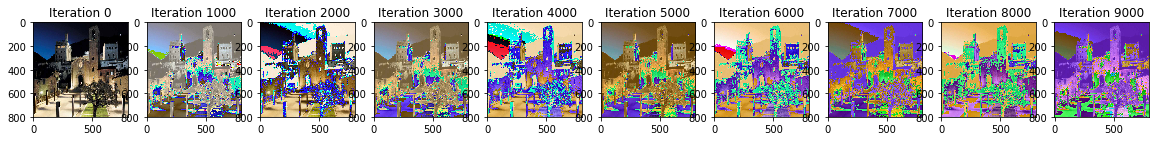

In [56]:
result = iterate_over_loss_optimization(content_img,
                                        style_img,
                                        alpha = 0.5,
                                        beta = 2.,
                                        iterations=10000,
                                        plots_per_row = 10,
                                        plot_every=1000)

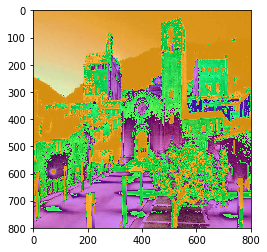

In [57]:
imshow(result)

In [59]:
from PIL import Image
from datetime import datetime
now = datetime.now()
Image.fromarray(result).save("data/style_transfer/results/gubbio_"+str(now.date())+"_"+ str(now.time())+".png")